<a href="https://colab.research.google.com/github/emmammolloy/arousal-in-translation/blob/main/MELD_data_clean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install numpy==1.26.4 pandas==2.2.2 srt transformers scipy

In [ ]:
#!pip install ffmpeg-python==0.2.0 audonnx==0.6.5 unbabel-comet audeer

In [ ]:
#!pip install audonnx comet-ml==3.31.12 sentence-transformers==2.2.2

In [ ]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from collections import Counter
from datetime import timedelta
from transformers import (
    MT5Tokenizer,
    MT5ForConditionalGeneration,
    Seq2SeqTrainingArguments,
    DataCollatorForSeq2Seq,
    Seq2SeqTrainer,
    EarlyStoppingCallback
)
from datasets import Dataset, DatasetDict
import requests
import re
import torch
import audonnx
import comet
import srt
import audeer

# Import / download / extract data


In [ ]:
#download data
!wget http://web.eecs.umich.edu/~mihalcea/downloads/MELD.Raw.tar.gz

In [ ]:
#unzip dataset
!tar -xvzf MELD.Raw.tar.gz

MELD.Raw/
MELD.Raw/train.tar.gz
MELD.Raw/dev.tar.gz
MELD.Raw/test_sent_emo.csv
MELD.Raw/._train_splits
MELD.Raw/dev_sent_emo.csv
MELD.Raw/README.txt
MELD.Raw/test.tar.gz


In [ ]:
#unzip mp4 files
!tar -xvzf MELD.Raw/train.tar.gz -C "./MELD.Raw"
!tar -xvzf MELD.Raw/dev.tar.gz -C "./MELD.Raw"
!tar -xvzf MELD.Raw/test.tar.gz -C "./MELD.Raw"

Streaming output truncated to the last 5000 lines.
train_splits/dia170_utt6.mp4
train_splits/dia676_utt14.mp4
train_splits/dia508_utt8.mp4
train_splits/dia168_utt13.mp4
train_splits/dia201_utt1.mp4
train_splits/dia390_utt1.mp4
train_splits/dia128_utt7.mp4
train_splits/dia463_utt1.mp4
train_splits/dia901_utt17.mp4
train_splits/dia54_utt11.mp4
train_splits/dia935_utt11.mp4
train_splits/dia22_utt3.mp4
train_splits/dia0_utt3.mp4
train_splits/dia423_utt3.mp4
train_splits/dia945_utt6.mp4
train_splits/dia254_utt5.mp4
train_splits/dia53_utt2.mp4
train_splits/dia663_utt8.mp4
train_splits/dia770_utt2.mp4
train_splits/dia297_utt5.mp4
train_splits/dia54_utt7.mp4
train_splits/dia146_utt9.mp4
train_splits/dia875_utt7.mp4
train_splits/dia122_utt6.mp4
train_splits/dia210_utt2.mp4
train_splits/dia555_utt2.mp4
train_splits/dia531_utt7.mp4
train_splits/dia841_utt5.mp4
train_splits/dia451_utt0.mp4
train_splits/dia57_utt1.mp4
train_splits/dia991_utt10.mp4
train_splits/dia884_utt4.mp4
train_splits/dia542_ut

## Save to Gdrive

In [ ]:
#mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# #move downloaded files to your gdrive
#import shutil
#colab = "/content/MELD.Raw"
#drive = "/content/drive/MyDrive/All_MELD" #update the path to your folder where the data should be saved
#shutil.copytree(colab, drive)

In [ ]:
# #download a file from device
# from google.colab import files
# files.download("file_name.csv")

## save as csv

In [ ]:
df_all.to_csv(os.path.join(path, "./MELD.Raw/MELD_df_all.csv"), index=False)

In [ ]:
df = pd.read_csv(os.path.join(path, "./MELD.Raw/MELD_df_all.csv"))
df.head()

Sr No.                                          Utterance          Speaker  \
0       1  also I was the point person on my companys tr...         Chandler   
1       2                   You mustve had your hands full.  The Interviewer   
2       3                            That I did. That I did.         Chandler   
3       4      So lets talk a little bit about your duties.  The Interviewer   
4       5                             My duties?  All right.         Chandler   

    Emotion Sentiment  Dialogue_ID  Utterance_ID  Season  Episode  \
0   neutral   neutral            0             0       8       21   
1   neutral   neutral            0             1       8       21   
2   neutral   neutral            0             2       8       21   
3   neutral   neutral            0             3       8       21   
4  surprise  positive            0             4       8       21   

      StartTime       EndTime  
0  00:16:16,059  00:16:21,731  
1  00:16:21,940  00:16:23,442  
2  00:16:23,442  00:16:26,389  
3  00:16:26,820  00:16:29,572  
4  00:16:34,452  00:16:40,917

# Looking at CSV data

In [ ]:
#update with path to the folder where the data has been exported to
#path = "/content/drive/MyDrive/Uni/ITC/ComputationalCogSci/CCS2/CCS2" #emma
#path="/content/drive/MyDrive/All_MELD" #wiktoria

In [ ]:
train_df = pd.read_csv(os.path.join(path, 'train_sent_emo.csv'))
dev_df   = pd.read_csv(os.path.join(path, 'dev_sent_emo.csv'))
test_df  = pd.read_csv(os.path.join(path, 'test_sent_emo.csv'))

df_all = pd.concat([train_df, dev_df, test_df], ignore_index=True)

df_all.head()

Sr No.                                          Utterance          Speaker  \
0       1  also I was the point person on my companys tr...         Chandler   
1       2                   You mustve had your hands full.  The Interviewer   
2       3                            That I did. That I did.         Chandler   
3       4      So lets talk a little bit about your duties.  The Interviewer   
4       5                             My duties?  All right.         Chandler   

    Emotion Sentiment  Dialogue_ID  Utterance_ID  Season  Episode  \
0   neutral   neutral            0             0       8       21   
1   neutral   neutral            0             1       8       21   
2   neutral   neutral            0             2       8       21   
3   neutral   neutral            0             3       8       21   
4  surprise  positive            0             4       8       21   

      StartTime       EndTime  
0  00:16:16,059  00:16:21,731  
1  00:16:21,940  00:16:23,442  
2  00:16:23,442  00:16:26,389  
3  00:16:26,820  00:16:29,572  
4  00:16:34,452  00:16:40,917

In [ ]:
df_all = pd.read_csv(os.path.join(path, "./MELD.Raw/MELD_df_all.csv"))


Data:

| Column                 | Description                                  | Type             |
| ---------------------- | -------------------------------------------- | ---------------- |
| `Sr No.`               | Unique ID for the utterance                  | Identifier       |
| `Utterance`            | What is said                              | Text             |
| `Speaker`              | Who said it (character name)                                 | Categorical      |
| `Emotion`              | One of 7 (neutral, joy, surprise, anger, sadness, disgust, fear )          | Categorical      |
| `Sentiment`            | Polarity (positive, negative, neutral)       | Categorical      |
| `Dialogue_ID`          | Groups utterances into dialogues             | Identifier       |
| `Utterance_ID`         | Order within dialogue                        | Ordinal          |
| `Season`, `Episode`    | Where utterance is from                    | Categorical      |
| `StartTime`, `EndTime` | Timestamps in episode | Numerical (Time) |


In [ ]:
#map utterances and file names
def read_meld_util(file_path):
  """
  Code from MELD's read_meld.py util file.
  Мaps utterances in the .csv annotation files to their corresponding video files.
  """
  df_train = pd.read_csv(file_path) # load the .csv file, specify the appropriate path
  utt = df_train['Utterance'].tolist() # load the list of utterances
  dia_id = df_train['Dialogue_ID'].tolist() # load the list of dialogue id's
  utt_id = df_train['Utterance_ID'].tolist() # load the list of utterance id's
  for i in range(5):
      print ('Utterance: ' + utt[i]) # display utterance
      print ('Video Path: train_splits/dia' + str(dia_id[i]) + '_utt' + str(utt_id[i]) + '.mp4') # display the video file path
      print ()

read_meld_util(os.path.join(path, "./dev_sent_emo.csv"))

Utterance: Oh my God, hes lost it. Hes totally lost it.
Video Path: train_splits/dia0_utt0.mp4

Utterance: What?
Video Path: train_splits/dia0_utt1.mp4

Utterance: Or! Or, we could go to the bank, close our accounts and cut them off at the source.
Video Path: train_splits/dia1_utt0.mp4

Utterance: Youre a genius!
Video Path: train_splits/dia1_utt1.mp4

Utterance: Aww, man, now we wont be bank buddies!
Video Path: train_splits/dia1_utt2.mp4



#Explore data

In [ ]:
df_all = pd.read_csv(os.path.join(path, "./MELD.Raw/MELD_df_all.csv"))

## Data cleaning

In [ ]:
#missing values?
df_all.isna().sum() #0

Sr No.          0
Utterance       0
Speaker         0
Emotion         0
Sentiment       0
Dialogue_ID     0
Utterance_ID    0
Season          0
Episode         0
StartTime       0
EndTime         0
dtype: int64

In [ ]:
#create new cleaned df
df_all_cleaned = df_all.copy(deep=True)

#fix apostrophes - they're an old unicode character - and strip white space
df_all_cleaned["Utterance"] = df_all_cleaned["Utterance"].str.replace("\u0092" , "\u2019")
df_all_cleaned["Utterance"] = df_all_cleaned["Utterance"].str.strip()

#replace commas in time codes with full stops and convert to time codes
df_all_cleaned["StartTime"] = df_all_cleaned["StartTime"].str.replace(",", ".")
df_all_cleaned["StartTime"] = pd.to_timedelta(df_all_cleaned["StartTime"])

df_all_cleaned["EndTime"] = df_all_cleaned["EndTime"].str.replace(",", ".")
df_all_cleaned["EndTime"] = pd.to_timedelta(df_all_cleaned["EndTime"])

df_all_cleaned.head()

Sr No.                                          Utterance          Speaker  \
0       1  also I was the point person on my company’s tr...         Chandler   
1       2                   You must’ve had your hands full.  The Interviewer   
2       3                            That I did. That I did.         Chandler   
3       4      So let’s talk a little bit about your duties.  The Interviewer   
4       5                             My duties?  All right.         Chandler   

    Emotion Sentiment  Dialogue_ID  Utterance_ID  Season  Episode  \
0   neutral   neutral            0             0       8       21   
1   neutral   neutral            0             1       8       21   
2   neutral   neutral            0             2       8       21   
3   neutral   neutral            0             3       8       21   
4  surprise  positive            0             4       8       21   

               StartTime                EndTime  
0 0 days 00:16:16.059000 0 days 00:16:21.731000  
1 0 days 00:16:21.940000 0 days 00:16:23.442000  
2 0 days 00:16:23.442000 0 days 00:16:26.389000  
3 0 days 00:16:26.820000 0 days 00:16:29.572000  
4 0 days 00:16:34.452000 0 days 00:16:40.917000

In [ ]:
# #check spellings
# !pip install pyspellchecker
# from spellchecker import SpellChecker
# import string

# spell_en = SpellChecker(distance=2, language="en")
# for utt in df_all_cleaned["Utterance"]:
#   for word in utt.split():
#     if spell_en.unknown([word]):
#       print(word)

# Explore data distribution

In [ ]:
df_all_cleaned.info()
print()
df_all_cleaned.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13708 entries, 0 to 13707
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype          
---  ------        --------------  -----          
 0   Sr No.        13708 non-null  int64          
 1   Utterance     13708 non-null  object         
 2   Speaker       13708 non-null  object         
 3   Emotion       13708 non-null  object         
 4   Sentiment     13708 non-null  object         
 5   Dialogue_ID   13708 non-null  int64          
 6   Utterance_ID  13708 non-null  int64          
 7   Season        13708 non-null  int64          
 8   Episode       13708 non-null  int64          
 9   StartTime     13708 non-null  timedelta64[ns]
 10  EndTime       13708 non-null  timedelta64[ns]
dtypes: int64(5), object(4), timedelta64[ns](2)
memory usage: 1.2+ MB



Sr No.   Dialogue_ID  Utterance_ID        Season       Episode  \
count  13708.000000  13708.000000  13708.000000  13708.000000  13708.000000   
mean    4145.282536    414.814634      6.082215      4.855632     12.602787   
std     3196.348091    319.233845      4.949474      2.362731      7.277891   
min        1.000000      0.000000      0.000000      1.000000      1.000000   
25%     1221.000000    125.000000      2.000000      3.000000      6.000000   
50%     3309.500000    331.000000      5.000000      5.000000     12.000000   
75%     6933.250000    680.000000      9.000000      7.000000     19.000000   
max    10478.000000   1038.000000     32.000000      9.000000     25.000000   

                       StartTime                    EndTime  
count                      13708                      13708  
mean   0 days 00:11:51.178832944  0 days 00:11:54.348220163  
std    0 days 00:06:29.477758766  0 days 00:06:29.480332262  
min       0 days 00:00:02.168000     0 days 00:00:03.300000  
25%       0 days 00:06:32.176000     0 days 00:06:35.148750  
50%       0 days 00:11:56.548500     0 days 00:11:59.759000  
75%       0 days 00:16:44.847250     0 days 00:16:47.629750  
max       0 days 00:46:29.119000     0 days 00:46:32.038000

In [ ]:
print(Counter(df_all_cleaned['Speaker']))
print(Counter(df_all_cleaned['Emotion']))
print(Counter(df_all_cleaned['Sentiment']))
print(Counter(df_all_cleaned['Dialogue_ID']))
print(Counter(df_all_cleaned['Season']))

Counter({'Joey': 2069, 'Ross': 2049, 'Rachel': 1955, 'Phoebe': 1797, 'Monica': 1782, 'Chandler': 1763, 'Janice': 89, 'Carol': 60, 'Tag': 60, 'Emily': 59, 'All': 51, 'Mona': 46, 'Doug': 44, 'Joanna': 38, 'Pete': 37, 'Frank': 37, 'Mark': 35, 'Susan': 35, 'Richard': 31, 'Paul': 29, 'Woman': 29, 'Gunther': 29, 'Danny': 28, 'Mr. Treeger': 27, 'Mr. Geller': 26, 'Phoebe Sr': 26, 'Mrs. Geller': 25, 'Elizabeth': 24, 'Julie': 24, 'Director': 21, 'Eric': 21, 'Mike': 21, 'Man': 19, 'Guy': 19, 'Dr. Green': 18, 'David': 18, 'Gary': 18, 'Chip': 18, 'Earl': 17, 'Barry': 17, 'Lydia': 17, 'Kate': 16, 'Nurse': 15, 'Dina': 15, 'Jill': 15, 'Chloe': 15, 'Dana': 15, 'Charlie': 14, 'Bonnie': 14, 'Leslie': 14, 'Janine': 14, 'The Casting Director': 13, 'Mr. Tribbiani': 13, 'Dr. Long': 13, 'Joshua': 13, 'Kim': 13, 'Cassie': 13, 'Kristen': 13, 'Tour Guide': 13, 'Steve': 13, 'Cliff': 12, 'Julio': 12, 'Katie': 12, 'Ben': 12, 'Russell': 12, 'Bob': 11, 'Policeman': 11, 'Duncan': 11, 'Issac': 11, 'Kathy': 11, 'Stanley

## Get DE/RU/PL subtitles

In [ ]:
import os
import re
import requests

def download_subtitles(show_name, season, language, save_folder=None):
    """
    Downloads the most popular subtitle files for a given show and season from OpenSubtitles.
    show_name (str): Name of the show
    season (int): Season number
    language (str): Subtitle language code
    save_folder (str, optional): Folder to save subtitles in. Defaults to "subtitles_<language>"
    """

    API_KEY = "RVPULvbWtxggDxd6Ovj1rrIsBhDuGubj"
    USER_AGENT = "curtains506"

    if save_folder is None:
        save_folder = f"subtitles_{language}"
    os.makedirs(save_folder, exist_ok=True)

    def search_subtitles(query, season, language, episode=None):
        url = "https://api.opensubtitles.com/api/v1/subtitles"
        headers = {
            "Api-Key": API_KEY,
            "User-Agent": USER_AGENT,
            "Content-Type": "application/json",
        }
        params = {
            "query": query,
            "season_number": season,
            "languages": language,
            "order_by": "download_count",
            "order_direction": "desc",
            "type": "episode",
            "episode_number": episode if episode else None
        }
        response = requests.get(url, headers=headers, params=params)
        response.raise_for_status()
        return response.json().get("data", [])

    def download_subtitle_file(file_id, save_path):
        url = "https://api.opensubtitles.com/api/v1/download"
        headers = {
            "Api-Key": API_KEY,
            "User-Agent": USER_AGENT,
            "Content-Type": "application/json",
        }
        json_data = {"file_id": file_id}
        response = requests.post(url, headers=headers, json=json_data)
        response.raise_for_status()
        download_link = response.json().get("link")
        if download_link:
            r = requests.get(download_link)
            with open(save_path, "wb") as f:
                f.write(r.content)
            print(f"Downloaded: {save_path}")
        else:
            print("Failed to get download link.")

    def extract_episode_num(attributes):
        #try structured episode_number
        episode_num = attributes.get("episode_number")
        if episode_num is not None:
            return int(episode_num)
        #try release title
        release = attributes.get("release", "")
        match = re.search(rf"[Ss]0*{season}[Ee](\d{{1,2}})", release)
        if match:
            return int(match.group(1))
        #try Season x Ep format
        match = re.search(rf"{season:02}[xX](\d{{1,2}})", release)
        if match:
            return int(match.group(1))
        return None

    subs = search_subtitles(show_name, season, language=language)
    seen_episodes = set() #don't repeat eps
    for sub in subs:
        attributes = sub.get("attributes", {})
        file_id = attributes.get("files", [{}])[0].get("file_id")
        episode_num = extract_episode_num(attributes)
        if not file_id or episode_num is None or episode_num in seen_episodes:
            continue
        filename = f"{show_name.replace(' ', '_')}_S{season:02}_E{episode_num:02}.srt" #name consistently
        save_path = os.path.join(save_folder, filename)
        download_subtitle_file(file_id, save_path)
        seen_episodes.add(episode_num)

def match_subtitles(MELDen_df, srt_file_path):
  """Matches utterances from the MELD dataset to subtitles (.srt file)
  based on the midpoint of an utterance's time codes.
  Returns a list of results.
  """

  def load_subtitles(srt_file_path):
    #load srt file
    with open(srt_file_path, "r", encoding="utf-8") as f:
      subs_list = list(srt.parse(f.read()))
      for sub in subs_list:
        sub.content = sub.content.replace("\n", " ") #remove new lines
      return subs_list

  subs_list = load_subtitles(srt_file_path)
  results = []
  for i in range(len(MELDen_df)):
    #match timecodes of middle of utterance as start and end might be wonky
    utter_start = MELDen_df.iloc[i]["StartTime"]
    utter_end = MELDen_df.iloc[i]["EndTime"]
    utter_mid = (utter_start + utter_end) / 2

    best_diff = timedelta.max
    best_sub = None

    for sub in subs_list:
      sub_start = pd.to_timedelta(sub.start)
      sub_end = pd.to_timedelta(sub.end)
      sub_mid = (sub_start + sub_end) / 2
      time_diff = abs(sub_mid - utter_mid)

      if time_diff < best_diff:
        best_diff = time_diff
        best_sub = sub

    #append matching subs to list
    if best_sub:
      results.append(best_sub.content)
    else:
      results.append(None)

  return results

In [ ]:
#download season 2
show_name = "Friends"
season = 2
language = "pl" #change language code as needed
save_folder = "subtitles_pl" #change as needed

download_subtitles(show_name, season, language, save_folder)

Downloaded: subtitles_pl/Friends_S02_E02.srt
Downloaded: subtitles_pl/Friends_S02_E03.srt
Downloaded: subtitles_pl/Friends_S02_E07.srt
Downloaded: subtitles_pl/Friends_S02_E01.srt
Downloaded: subtitles_pl/Friends_S02_E05.srt
Downloaded: subtitles_pl/Friends_S02_E06.srt
Downloaded: subtitles_pl/Friends_S02_E10.srt
Downloaded: subtitles_pl/Friends_S02_E13.srt
Downloaded: subtitles_pl/Friends_S02_E16.srt
Downloaded: subtitles_pl/Friends_S02_E08.srt
Downloaded: subtitles_pl/Friends_S02_E14.srt
Downloaded: subtitles_pl/Friends_S02_E20.srt
Downloaded: subtitles_pl/Friends_S02_E15.srt
Downloaded: subtitles_pl/Friends_S02_E09.srt
Downloaded: subtitles_pl/Friends_S02_E11.srt
Downloaded: subtitles_pl/Friends_S02_E12.srt
Downloaded: subtitles_pl/Friends_S02_E22.srt
Downloaded: subtitles_pl/Friends_S02_E18.srt
Downloaded: subtitles_pl/Friends_S02_E04.srt
Downloaded: subtitles_pl/Friends_S02_E21.srt
Downloaded: subtitles_pl/Friends_S02_E17.srt


In [ ]:
# save df to csv - need all subs
# withsubs_df = df_all_cleaned
# withsubs_df.to_csv(os.path.join(path, "./MELD.Raw/MELD_cleaned_subs.csv"), index=False)

In [ ]:
s2_df = df_all_cleaned[df_all_cleaned["Season"] == 2]
s2_df
s2_df.to_csv("MELD_s2_df.csv", index=False, encoding='utf-8')


In [ ]:
#add subtitles to dataframe
subtitle_directory = "./subtitles_pl_s02" #change if needed

#get file paths
episode_to_sub_path = {}
for sub_file in os.listdir(subtitle_directory):
    if sub_file.endswith(".srt"):
        match = re.search(r"_E(\d{2})\.srt", sub_file)
        if match:
            episode_num = int(match.group(1))
            episode_to_sub_path[episode_num] = os.path.join(subtitle_directory, sub_file)

#loop through s2_df by episode
for episode_num in s2_df["Episode"].unique():
    if episode_num in episode_to_sub_path:
        sub_path = episode_to_sub_path[episode_num]
        episode_df = s2_df[s2_df["Episode"] == episode_num]
        match_subtitles(episode_df, sub_path)
    else:
        print(f"No subtitle found for episode {episode_num}")

#save as csv
#s2_df.to_csv(os.path.join(path, "./MELD.Raw/MELD_s2.csv"), index=False)

s2_df

NameError: name 'srt' is not defined

In [ ]:
# to dowload wav files as zip
#%cd /content/subtitles_pl_s02
#!zip -r subtitles_pl_s02.zip subtitles_pl_s02/
#from google.colab import files
#files.download('/content/subtitles_pl_s02.zip')

# Extract audio - Emma

In [ ]:
def extract_audio(input_file, output_dir):
  """Extracts audio from .mp4 file and saves it as a .wav file."""

  def convert_to_wav(input_file, output_dir):
    file_name = os.path.splitext(os.path.basename(input_file))[0] + ".wav"
    os.makedirs(output_dir, exist_ok=True) #create output folder
    output_file = os.path.join(output_dir, file_name)
    try:
      ffmpeg.input(input_file).output(output_file, acodec="pcm_s16le").run() #convert input file to .wav
      print(f"Audio extracted to {output_file}")
    except ffmpeg.Error as e:
      print(f"Error processing {input_file}")
      if e.stderr is not None:
        print(e.stderr.decode())
      else:
        print(e)

  input_files = [os.path.join(input_file, f) for f in os.listdir(input_file) if f.endswith(".mp4")]
  for f in tqdm(input_files):
    convert_to_wav(f,output_dir)

In [ ]:
import ffmpeg
import os

#convert dev set - takes around 3min
input_file = os.path.join(path, "./dev_splits_complete")
output_dir = os.path.join(path, "./MELD.Raw/audio_outputs")
extract_audio(input_file, output_dir)

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Uni/ITC/ComputationalCogSci/CCS2/CCS2/./dev_splits_complete'

In [ ]:
import ffmpeg
import os

#convert train set - takes around 40min
input_file = os.path.join(path, "./MELD.Raw/train_splits")
output_dir = os.path.join(path, "./MELD.Raw/audio_outputs_train")
extract_audio(input_file, output_dir)


  0%|          | 1/9989 [00:00<2:16:09,  1.22it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia617_utt5.wav


  0%|          | 2/9989 [00:01<1:48:17,  1.54it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia608_utt1.wav


  0%|          | 3/9989 [00:02<2:05:18,  1.33it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia621_utt4.wav


  0%|          | 4/9989 [00:02<1:58:35,  1.40it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia632_utt14.wav


  0%|          | 5/9989 [00:03<2:07:33,  1.30it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia617_utt8.wav


  0%|          | 6/9989 [00:04<2:04:56,  1.33it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia617_utt4.wav


  0%|          | 7/9989 [00:05<1:59:36,  1.39it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia621_utt3.wav


  0%|          | 8/9989 [00:05<1:57:04,  1.42it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia632_utt0.wav


  0%|          | 9/9989 [00:06<1:54:35,  1.45it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia612_utt0.wav


  0%|          | 10/9989 [00:06<1:44:59,  1.58it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia623_utt4.wav


  0%|          | 11/9989 [00:07<1:55:53,  1.44it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia622_utt11.wav


  0%|          | 12/9989 [00:08<1:56:55,  1.42it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia629_utt1.wav


  0%|          | 13/9989 [00:09<1:57:38,  1.41it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia629_utt4.wav


  0%|          | 14/9989 [00:09<1:53:24,  1.47it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia629_utt14.wav


  0%|          | 15/9989 [00:10<1:50:11,  1.51it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia621_utt1.wav


  0%|          | 16/9989 [00:11<1:55:11,  1.44it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia623_utt0.wav


  0%|          | 17/9989 [00:11<1:51:43,  1.49it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia630_utt5.wav


  0%|          | 18/9989 [00:12<1:53:00,  1.47it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia629_utt15.wav


  0%|          | 19/9989 [00:13<1:45:09,  1.58it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia622_utt10.wav


  0%|          | 20/9989 [00:13<1:49:19,  1.52it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia608_utt3.wav


  0%|          | 21/9989 [00:14<1:48:47,  1.53it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia615_utt6.wav


  0%|          | 22/9989 [00:14<1:43:03,  1.61it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia623_utt11.wav


  0%|          | 23/9989 [00:15<1:52:37,  1.47it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia607_utt6.wav


  0%|          | 24/9989 [00:16<1:56:54,  1.42it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia622_utt0.wav


  0%|          | 25/9989 [00:17<1:59:18,  1.39it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia614_utt11.wav


  0%|          | 26/9989 [00:17<1:54:41,  1.45it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia608_utt4.wav


  0%|          | 27/9989 [00:18<1:54:06,  1.46it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia623_utt1.wav


  0%|          | 28/9989 [00:19<1:59:38,  1.39it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia632_utt1.wav


  0%|          | 29/9989 [00:20<1:54:24,  1.45it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia608_utt0.wav


  0%|          | 30/9989 [00:20<2:05:06,  1.33it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia607_utt9.wav


  0%|          | 31/9989 [00:21<1:56:07,  1.43it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia630_utt6.wav


  0%|          | 32/9989 [00:22<1:55:21,  1.44it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia62_utt6.wav


  0%|          | 33/9989 [00:22<1:51:43,  1.49it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia607_utt5.wav


  0%|          | 34/9989 [00:23<1:58:04,  1.41it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia612_utt8.wav


  0%|          | 35/9989 [00:24<1:54:14,  1.45it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia622_utt5.wav


  0%|          | 36/9989 [00:24<1:46:34,  1.56it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia630_utt7.wav


  0%|          | 37/9989 [00:25<1:47:57,  1.54it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia61_utt1.wav


  0%|          | 38/9989 [00:26<1:44:57,  1.58it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia614_utt12.wav


  0%|          | 39/9989 [00:26<1:54:05,  1.45it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia628_utt1.wav


  0%|          | 40/9989 [00:27<1:50:11,  1.50it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia625_utt11.wav


  0%|          | 41/9989 [00:28<1:44:21,  1.59it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia615_utt7.wav


  0%|          | 42/9989 [00:28<1:48:19,  1.53it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia615_utt8.wav


  0%|          | 43/9989 [00:29<1:42:01,  1.62it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia622_utt1.wav


  0%|          | 44/9989 [00:29<1:42:04,  1.62it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia626_utt6.wav


  0%|          | 45/9989 [00:30<1:42:40,  1.61it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia626_utt2.wav


  0%|          | 46/9989 [00:31<1:42:48,  1.61it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia617_utt9.wav


  0%|          | 47/9989 [00:31<1:39:40,  1.66it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia612_utt1.wav


  0%|          | 48/9989 [00:32<1:37:33,  1.70it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia614_utt15.wav


  0%|          | 49/9989 [00:32<1:39:34,  1.66it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia616_utt3.wav


  1%|          | 50/9989 [00:33<1:45:13,  1.57it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia623_utt5.wav


  1%|          | 51/9989 [00:34<1:46:49,  1.55it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia621_utt0.wav


  1%|          | 52/9989 [00:34<1:48:14,  1.53it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia62_utt5.wav


  1%|          | 53/9989 [00:35<1:56:48,  1.42it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia628_utt0.wav


  1%|          | 54/9989 [00:36<1:58:23,  1.40it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia623_utt10.wav


  1%|          | 55/9989 [00:37<1:55:19,  1.44it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia629_utt3.wav


  1%|          | 56/9989 [00:37<1:47:51,  1.53it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia626_utt5.wav


  1%|          | 57/9989 [00:38<2:08:38,  1.29it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia626_utt1.wav


  1%|          | 58/9989 [00:39<1:58:48,  1.39it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia623_utt6.wav


  1%|          | 59/9989 [00:39<1:48:31,  1.52it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia614_utt10.wav


  1%|          | 60/9989 [00:40<1:41:34,  1.63it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia616_utt4.wav


  1%|          | 61/9989 [00:40<1:41:38,  1.63it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia637_utt4.wav


  1%|          | 62/9989 [00:41<1:54:05,  1.45it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia655_utt0.wav


  1%|          | 63/9989 [00:42<1:51:59,  1.48it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia640_utt2.wav


  1%|          | 64/9989 [00:43<1:50:27,  1.50it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia649_utt13.wav


  1%|          | 65/9989 [00:43<1:50:33,  1.50it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia636_utt0.wav


  1%|          | 66/9989 [00:44<1:48:27,  1.52it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia637_utt6.wav


  1%|          | 67/9989 [00:45<1:46:23,  1.55it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia654_utt5.wav


  1%|          | 68/9989 [00:45<1:57:22,  1.41it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia652_utt14.wav


  1%|          | 69/9989 [00:46<2:04:31,  1.33it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia654_utt7.wav


  1%|          | 70/9989 [00:47<2:00:00,  1.38it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia645_utt1.wav


  1%|          | 71/9989 [00:48<2:03:37,  1.34it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia637_utt7.wav


  1%|          | 72/9989 [00:48<1:55:02,  1.44it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia637_utt8.wav


  1%|          | 73/9989 [00:49<1:55:31,  1.43it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia655_utt1.wav


  1%|          | 74/9989 [00:50<1:49:17,  1.51it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia64_utt3.wav


  1%|          | 75/9989 [00:50<1:49:08,  1.51it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia646_utt20.wav


  1%|          | 76/9989 [00:51<1:49:14,  1.51it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia646_utt7.wav


  1%|          | 77/9989 [00:51<1:41:44,  1.62it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia64_utt2.wav


  1%|          | 78/9989 [00:52<1:44:05,  1.59it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia654_utt6.wav


  1%|          | 79/9989 [00:53<1:45:18,  1.57it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia645_utt10.wav


  1%|          | 80/9989 [00:53<1:46:41,  1.55it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia634_utt8.wav


  1%|          | 81/9989 [00:54<1:41:21,  1.63it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia644_utt1.wav


  1%|          | 82/9989 [00:55<1:39:54,  1.65it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia634_utt7.wav


  1%|          | 83/9989 [00:55<1:42:54,  1.60it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia632_utt4.wav


  1%|          | 84/9989 [00:56<1:37:39,  1.69it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia637_utt5.wav


  1%|          | 85/9989 [00:56<1:45:16,  1.57it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia635_utt3.wav


  1%|          | 86/9989 [00:57<1:45:19,  1.57it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia633_utt7.wav


  1%|          | 87/9989 [00:58<1:43:18,  1.60it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia646_utt14.wav


  1%|          | 88/9989 [00:58<1:45:04,  1.57it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia64_utt1.wav


  1%|          | 89/9989 [00:59<1:49:07,  1.51it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia645_utt11.wav


  1%|          | 90/9989 [01:00<1:52:11,  1.47it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia632_utt5.wav


  1%|          | 91/9989 [01:00<1:49:45,  1.50it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia645_utt8.wav


  1%|          | 92/9989 [01:01<1:43:00,  1.60it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia637_utt3.wav


  1%|          | 93/9989 [01:02<1:39:19,  1.66it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia639_utt4.wav


  1%|          | 94/9989 [01:02<1:47:56,  1.53it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia633_utt8.wav


  1%|          | 95/9989 [01:03<1:44:45,  1.57it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia649_utt8.wav


  1%|          | 96/9989 [01:04<1:46:30,  1.55it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia643_utt2.wav


  1%|          | 97/9989 [01:04<1:40:52,  1.63it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia645_utt2.wav


  1%|          | 98/9989 [01:05<1:41:33,  1.62it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia652_utt15.wav


  1%|          | 99/9989 [01:05<1:40:06,  1.65it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia632_utt7.wav


  1%|          | 100/9989 [03:19<111:33:31, 40.61s/it]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia651_utt1.wav


  1%|          | 101/9989 [09:27<381:28:38, 138.89s/it]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia646_utt8.wav


  1%|          | 102/9989 [09:28<267:40:37, 97.47s/it] 

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia640_utt4.wav


  1%|          | 103/9989 [09:28<187:33:01, 68.30s/it]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia649_utt14.wav


  1%|          | 105/9989 [09:29<92:09:05, 33.56s/it] 

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia649_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia654_utt8.wav


  1%|          | 107/9989 [09:29<45:20:35, 16.52s/it]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia638_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia651_utt2.wav


  1%|          | 109/9989 [09:29<22:24:43,  8.17s/it]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia638_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia632_utt3.wav


  1%|          | 111/9989 [09:30<11:10:58,  4.08s/it]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia646_utt17.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia640_utt3.wav


  1%|          | 113/9989 [09:30<5:40:57,  2.07s/it]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia646_utt16.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia635_utt4.wav


  1%|          | 114/9989 [09:30<4:07:45,  1.51s/it]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia639_utt5.wav


  1%|          | 115/9989 [09:30<3:04:47,  1.12s/it]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia646_utt13.wav


  1%|          | 117/9989 [09:31<1:48:56,  1.51it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia645_utt9.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia636_utt1.wav


  1%|          | 119/9989 [09:31<1:04:24,  2.55it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia633_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia632_utt2.wav


  1%|          | 121/9989 [09:31<43:25,  3.79it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia643_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia633_utt9.wav


  1%|          | 123/9989 [09:32<33:41,  4.88it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia646_utt19.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia632_utt6.wav


  1%|▏         | 125/9989 [09:32<27:43,  5.93it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia644_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia678_utt1.wav


  1%|▏         | 127/9989 [09:32<25:16,  6.50it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia658_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia657_utt6.wav


  1%|▏         | 129/9989 [09:33<25:22,  6.47it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia660_utt13.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia663_utt5.wav


  1%|▏         | 131/9989 [09:33<24:52,  6.61it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia672_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia659_utt10.wav


  1%|▏         | 133/9989 [09:33<24:17,  6.76it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia658_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia671_utt10.wav


  1%|▏         | 135/9989 [09:33<23:26,  7.01it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia660_utt11.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia678_utt7.wav


  1%|▏         | 137/9989 [09:34<23:23,  7.02it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia667_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia675_utt1.wav


  1%|▏         | 139/9989 [09:34<24:49,  6.61it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia676_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia660_utt1.wav


  1%|▏         | 141/9989 [09:34<23:34,  6.96it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia657_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia666_utt0.wav


  1%|▏         | 143/9989 [09:35<23:33,  6.96it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia673_utt13.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia678_utt3.wav


  1%|▏         | 145/9989 [09:35<24:38,  6.66it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia657_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia671_utt17.wav


  1%|▏         | 147/9989 [09:35<23:28,  6.99it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia658_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia660_utt10.wav


  1%|▏         | 149/9989 [09:36<23:38,  6.94it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia676_utt13.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia658_utt19.wav


  2%|▏         | 151/9989 [09:36<24:15,  6.76it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia678_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia672_utt15.wav


  2%|▏         | 153/9989 [09:36<24:11,  6.78it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia666_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia678_utt4.wav


  2%|▏         | 155/9989 [09:36<23:33,  6.96it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia660_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia663_utt4.wav


  2%|▏         | 157/9989 [09:37<24:35,  6.66it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia674_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia667_utt8.wav


  2%|▏         | 159/9989 [09:37<23:22,  7.01it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia657_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia660_utt7.wav


  2%|▏         | 161/9989 [09:37<22:28,  7.29it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia673_utt14.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia659_utt13.wav


  2%|▏         | 163/9989 [09:38<23:20,  7.01it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia671_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia658_utt5.wav


  2%|▏         | 165/9989 [09:38<24:20,  6.73it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia676_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia676_utt12.wav


  2%|▏         | 167/9989 [09:38<23:50,  6.87it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia665_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia666_utt12.wav


  2%|▏         | 169/9989 [09:38<23:25,  6.99it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia665_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia678_utt2.wav


  2%|▏         | 171/9989 [09:39<22:42,  7.20it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia659_utt14.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia671_utt16.wav


  2%|▏         | 173/9989 [09:39<25:03,  6.53it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia678_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia672_utt4.wav


  2%|▏         | 174/9989 [09:39<29:14,  5.59it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia671_utt6.wav


  2%|▏         | 175/9989 [09:39<30:49,  5.31it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia660_utt9.wav


  2%|▏         | 176/9989 [09:40<33:14,  4.92it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia660_utt12.wav


  2%|▏         | 178/9989 [09:40<34:34,  4.73it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia658_utt18.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia674_utt6.wav


  2%|▏         | 179/9989 [09:40<33:46,  4.84it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia676_utt2.wav


  2%|▏         | 180/9989 [09:41<34:30,  4.74it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia659_utt15.wav


  2%|▏         | 182/9989 [09:41<34:49,  4.69it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia675_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia660_utt2.wav


  2%|▏         | 183/9989 [09:41<34:50,  4.69it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia671_utt11.wav


  2%|▏         | 184/9989 [09:41<35:42,  4.58it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia672_utt14.wav


  2%|▏         | 185/9989 [09:42<35:28,  4.61it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia666_utt13.wav


  2%|▏         | 186/9989 [09:42<36:53,  4.43it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia658_utt3.wav


  2%|▏         | 187/9989 [09:42<35:59,  4.54it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia678_utt5.wav


  2%|▏         | 188/9989 [09:42<36:15,  4.51it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia659_utt11.wav


  2%|▏         | 190/9989 [09:43<35:52,  4.55it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia663_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia6_utt15.wav


  2%|▏         | 192/9989 [09:43<34:38,  4.71it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia67_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia6_utt14.wav


  2%|▏         | 193/9989 [09:43<34:46,  4.69it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia699_utt6.wav


  2%|▏         | 195/9989 [09:44<34:51,  4.68it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia680_utt9.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia679_utt6.wav


  2%|▏         | 196/9989 [09:44<34:12,  4.77it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia689_utt2.wav


  2%|▏         | 197/9989 [09:44<34:37,  4.71it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia698_utt2.wav


  2%|▏         | 198/9989 [09:44<34:20,  4.75it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia690_utt5.wav


  2%|▏         | 199/9989 [09:45<36:55,  4.42it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia67_utt8.wav


  2%|▏         | 200/9989 [09:45<36:26,  4.48it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia690_utt4.wav


  2%|▏         | 202/9989 [09:46<56:49,  2.87it/s]  

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia690_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia699_utt9.wav


  2%|▏         | 204/9989 [09:46<40:04,  4.07it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia685_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia686_utt10.wav


  2%|▏         | 206/9989 [09:47<31:52,  5.11it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia686_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia678_utt9.wav


  2%|▏         | 208/9989 [09:47<27:04,  6.02it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia687_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia6_utt17.wav


  2%|▏         | 210/9989 [09:47<24:44,  6.59it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia6_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia686_utt7.wav


  2%|▏         | 212/9989 [09:47<23:59,  6.79it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia6_utt12.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia6_utt10.wav


  2%|▏         | 214/9989 [09:48<26:28,  6.16it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia679_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia686_utt1.wav


  2%|▏         | 216/9989 [09:48<24:58,  6.52it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia689_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia686_utt9.wav


  2%|▏         | 218/9989 [09:48<25:17,  6.44it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia699_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia682_utt12.wav


  2%|▏         | 220/9989 [09:49<24:53,  6.54it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia687_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia690_utt2.wav


  2%|▏         | 222/9989 [09:49<24:46,  6.57it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia67_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia67_utt13.wav


  2%|▏         | 224/9989 [09:49<23:32,  6.91it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia700_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia67_utt12.wav


  2%|▏         | 226/9989 [09:50<25:37,  6.35it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia689_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia690_utt8.wav


  2%|▏         | 228/9989 [09:50<23:20,  6.97it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia6_utt13.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia6_utt1.wav


  2%|▏         | 230/9989 [09:50<23:39,  6.87it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia682_utt11.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia678_utt8.wav


  2%|▏         | 232/9989 [09:51<24:03,  6.76it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia699_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia6_utt11.wav


  2%|▏         | 234/9989 [09:51<24:20,  6.68it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia679_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia695_utt2.wav


  2%|▏         | 236/9989 [09:51<24:43,  6.58it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia687_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia679_utt1.wav


  2%|▏         | 238/9989 [09:51<24:04,  6.75it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia686_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia700_utt4.wav


  2%|▏         | 240/9989 [09:52<23:22,  6.95it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia687_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia6_utt19.wav


  2%|▏         | 242/9989 [09:52<22:21,  7.27it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia700_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia685_utt0.wav


  2%|▏         | 244/9989 [09:52<23:03,  7.04it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia700_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia67_utt7.wav


  2%|▏         | 246/9989 [09:53<24:02,  6.75it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia698_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia6_utt2.wav


  2%|▏         | 248/9989 [09:53<23:33,  6.89it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia687_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia680_utt10.wav


  3%|▎         | 250/9989 [09:53<22:17,  7.28it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia695_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia6_utt4.wav


  3%|▎         | 252/9989 [09:53<22:07,  7.33it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia67_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia689_utt3.wav


  3%|▎         | 254/9989 [09:54<23:05,  7.03it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia699_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia6_utt18.wav


  3%|▎         | 256/9989 [09:54<22:54,  7.08it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia695_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia6_utt16.wav


  3%|▎         | 258/9989 [09:54<22:31,  7.20it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia6_utt20.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia690_utt9.wav


  3%|▎         | 260/9989 [09:55<23:48,  6.81it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia717_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia726_utt1.wav


  3%|▎         | 262/9989 [09:55<23:56,  6.77it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia722_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia707_utt2.wav


  3%|▎         | 264/9989 [09:55<24:49,  6.53it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia706_utt10.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia739_utt16.wav


  3%|▎         | 266/9989 [09:55<25:58,  6.24it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia722_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia717_utt8.wav


  3%|▎         | 267/9989 [09:56<28:30,  5.68it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia707_utt7.wav


  3%|▎         | 269/9989 [09:56<32:35,  4.97it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia737_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia703_utt1.wav


  3%|▎         | 270/9989 [09:56<34:09,  4.74it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia717_utt6.wav


  3%|▎         | 272/9989 [09:57<33:15,  4.87it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia726_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia725_utt1.wav


  3%|▎         | 273/9989 [09:57<34:33,  4.69it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia700_utt8.wav


  3%|▎         | 275/9989 [09:57<33:05,  4.89it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia700_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia735_utt15.wav


  3%|▎         | 276/9989 [09:58<33:18,  4.86it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia717_utt9.wav


  3%|▎         | 278/9989 [09:58<33:27,  4.84it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia718_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia700_utt5.wav


  3%|▎         | 279/9989 [09:58<34:02,  4.75it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia712_utt7.wav


  3%|▎         | 280/9989 [09:58<34:00,  4.76it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia712_utt8.wav


  3%|▎         | 281/9989 [09:59<34:26,  4.70it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia722_utt10.wav


  3%|▎         | 282/9989 [09:59<37:22,  4.33it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia707_utt14.wav


  3%|▎         | 283/9989 [09:59<36:41,  4.41it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia722_utt9.wav


  3%|▎         | 284/9989 [09:59<36:33,  4.42it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia712_utt10.wav


  3%|▎         | 285/9989 [10:00<37:24,  4.32it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia739_utt15.wav


  3%|▎         | 286/9989 [10:00<37:49,  4.28it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia703_utt3.wav


  3%|▎         | 287/9989 [10:00<37:31,  4.31it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia716_utt3.wav


  3%|▎         | 288/9989 [10:00<36:05,  4.48it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia738_utt2.wav


  3%|▎         | 289/9989 [10:01<36:03,  4.48it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia718_utt1.wav


  3%|▎         | 290/9989 [10:01<35:50,  4.51it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia706_utt3.wav


  3%|▎         | 291/9989 [10:01<38:19,  4.22it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia719_utt3.wav


  3%|▎         | 292/9989 [10:01<38:30,  4.20it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia738_utt1.wav


  3%|▎         | 293/9989 [10:02<39:11,  4.12it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia735_utt14.wav


  3%|▎         | 294/9989 [10:02<38:08,  4.24it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia725_utt5.wav


  3%|▎         | 295/9989 [10:02<41:12,  3.92it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia717_utt3.wav


  3%|▎         | 296/9989 [10:02<39:33,  4.08it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia71_utt1.wav


  3%|▎         | 298/9989 [10:03<34:29,  4.68it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia706_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia737_utt0.wav


  3%|▎         | 300/9989 [10:03<29:10,  5.53it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia71_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia707_utt3.wav


  3%|▎         | 302/9989 [10:03<27:06,  5.96it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia703_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia716_utt2.wav


  3%|▎         | 304/9989 [10:04<25:55,  6.23it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia712_utt11.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia707_utt6.wav


  3%|▎         | 306/9989 [10:04<24:13,  6.66it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia728_utt9.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia707_utt8.wav


  3%|▎         | 308/9989 [10:04<23:27,  6.88it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia723_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia719_utt2.wav


  3%|▎         | 310/9989 [10:04<24:38,  6.55it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia707_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia733_utt5.wav


  3%|▎         | 312/9989 [10:05<25:20,  6.37it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia717_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia703_utt4.wav


  3%|▎         | 314/9989 [10:05<24:56,  6.47it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia706_utt9.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia702_utt1.wav


  3%|▎         | 316/9989 [10:05<25:05,  6.42it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia725_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia723_utt3.wav


  3%|▎         | 318/9989 [10:06<25:37,  6.29it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia725_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia707_utt13.wav


  3%|▎         | 320/9989 [10:06<24:59,  6.45it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia702_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia733_utt4.wav


  3%|▎         | 322/9989 [10:06<24:44,  6.51it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia728_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia707_utt4.wav


  3%|▎         | 324/9989 [10:07<24:39,  6.53it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia752_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia752_utt7.wav


  3%|▎         | 326/9989 [10:07<24:09,  6.67it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia740_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia743_utt2.wav


  3%|▎         | 328/9989 [10:07<23:34,  6.83it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia757_utt9.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia757_utt10.wav


  3%|▎         | 330/9989 [10:08<24:44,  6.51it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia750_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia740_utt9.wav


  3%|▎         | 332/9989 [10:08<24:52,  6.47it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia73_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia744_utt4.wav


  3%|▎         | 334/9989 [10:08<24:24,  6.59it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia73_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia745_utt8.wav


  3%|▎         | 336/9989 [10:08<25:12,  6.38it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia743_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia758_utt1.wav


  3%|▎         | 338/9989 [10:09<24:31,  6.56it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia73_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia739_utt6.wav


  3%|▎         | 340/9989 [10:09<23:48,  6.75it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia752_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia739_utt3.wav


  3%|▎         | 342/9989 [10:09<24:23,  6.59it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia745_utt9.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia739_utt5.wav


  3%|▎         | 344/9989 [10:10<25:35,  6.28it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia749_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia747_utt4.wav


  3%|▎         | 346/9989 [10:10<24:04,  6.68it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia74_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia747_utt7.wav


  3%|▎         | 348/9989 [10:10<23:07,  6.95it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia750_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia755_utt3.wav


  4%|▎         | 350/9989 [10:11<22:56,  7.00it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia739_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia739_utt7.wav


  4%|▎         | 351/9989 [10:11<23:18,  6.89it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia752_utt6.wav


  4%|▎         | 353/9989 [10:11<27:02,  5.94it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia756_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia73_utt6.wav


  4%|▎         | 355/9989 [10:11<24:43,  6.49it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia747_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia747_utt8.wav


  4%|▎         | 357/9989 [10:12<24:47,  6.47it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia752_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia747_utt9.wav


  4%|▎         | 359/9989 [10:12<24:35,  6.53it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia755_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia758_utt3.wav


  4%|▎         | 361/9989 [10:12<24:11,  6.64it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia74_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia756_utt3.wav


  4%|▎         | 363/9989 [10:13<23:58,  6.69it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia745_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia756_utt2.wav


  4%|▎         | 364/9989 [10:13<27:21,  5.86it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia758_utt2.wav


  4%|▎         | 366/9989 [10:13<31:36,  5.07it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia741_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia741_utt1.wav


  4%|▎         | 367/9989 [10:13<33:34,  4.78it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia749_utt5.wav


  4%|▎         | 368/9989 [10:14<35:48,  4.48it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia744_utt3.wav


  4%|▎         | 369/9989 [10:14<35:32,  4.51it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia752_utt3.wav


  4%|▎         | 370/9989 [10:14<36:40,  4.37it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia745_utt3.wav


  4%|▎         | 371/9989 [10:14<35:41,  4.49it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia791_utt9.wav


  4%|▎         | 372/9989 [10:15<37:00,  4.33it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia78_utt4.wav


  4%|▎         | 373/9989 [10:15<38:30,  4.16it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia780_utt2.wav


  4%|▍         | 375/9989 [10:15<35:32,  4.51it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia771_utt10.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia791_utt10.wav


  4%|▍         | 376/9989 [10:16<34:56,  4.59it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia763_utt6.wav


  4%|▍         | 377/9989 [10:16<35:28,  4.52it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia77_utt1.wav


  4%|▍         | 379/9989 [10:16<33:10,  4.83it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia780_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia776_utt0.wav


  4%|▍         | 380/9989 [10:16<34:19,  4.67it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia766_utt4.wav


  4%|▍         | 381/9989 [10:17<34:06,  4.70it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia795_utt0.wav


  4%|▍         | 382/9989 [10:17<35:37,  4.49it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia763_utt7.wav


  4%|▍         | 384/9989 [10:17<34:35,  4.63it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia765_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia77_utt0.wav


  4%|▍         | 385/9989 [10:17<34:50,  4.59it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia776_utt3.wav


  4%|▍         | 386/9989 [10:18<35:43,  4.48it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia789_utt6.wav


  4%|▍         | 387/9989 [10:18<35:48,  4.47it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia772_utt5.wav


  4%|▍         | 388/9989 [10:18<36:26,  4.39it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia78_utt3.wav


  4%|▍         | 389/9989 [10:18<36:27,  4.39it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia791_utt3.wav


  4%|▍         | 390/9989 [10:19<35:24,  4.52it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia766_utt5.wav


  4%|▍         | 391/9989 [10:19<38:33,  4.15it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia763_utt2.wav


  4%|▍         | 392/9989 [10:19<40:32,  3.94it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia775_utt7.wav


  4%|▍         | 393/9989 [10:19<40:09,  3.98it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia782_utt1.wav


  4%|▍         | 395/9989 [10:20<34:31,  4.63it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia792_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia759_utt6.wav


  4%|▍         | 397/9989 [10:20<28:40,  5.57it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia777_utt11.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia774_utt4.wav


  4%|▍         | 399/9989 [10:20<26:16,  6.08it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia792_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia766_utt3.wav


  4%|▍         | 401/9989 [10:21<25:20,  6.31it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia763_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia776_utt2.wav


  4%|▍         | 403/9989 [10:21<24:43,  6.46it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia782_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia767_utt3.wav


  4%|▍         | 405/9989 [10:21<24:01,  6.65it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia776_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia794_utt4.wav


  4%|▍         | 407/9989 [10:22<23:40,  6.74it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia789_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia789_utt7.wav


  4%|▍         | 409/9989 [10:22<24:31,  6.51it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia779_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia771_utt11.wav


  4%|▍         | 411/9989 [10:22<24:13,  6.59it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia777_utt13.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia765_utt0.wav


  4%|▍         | 413/9989 [10:22<23:24,  6.82it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia777_utt12.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia780_utt5.wav


  4%|▍         | 415/9989 [10:23<22:56,  6.95it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia772_utt12.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia77_utt3.wav


  4%|▍         | 417/9989 [10:23<21:56,  7.27it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia76_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia766_utt2.wav


  4%|▍         | 419/9989 [10:23<22:26,  7.11it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia763_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia763_utt0.wav


  4%|▍         | 421/9989 [10:24<22:44,  7.01it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia767_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia777_utt10.wav


  4%|▍         | 423/9989 [10:24<23:52,  6.68it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia759_utt9.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia758_utt4.wav


  4%|▍         | 425/9989 [10:24<22:54,  6.96it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia77_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia772_utt13.wav


  4%|▍         | 427/9989 [10:24<22:10,  7.19it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia792_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia791_utt15.wav


  4%|▍         | 429/9989 [10:25<23:27,  6.79it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia789_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia775_utt6.wav


  4%|▍         | 431/9989 [10:25<22:59,  6.93it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia779_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia794_utt0.wav


  4%|▍         | 433/9989 [10:25<24:31,  6.49it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia759_utt10.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia794_utt1.wav


  4%|▍         | 435/9989 [10:26<23:24,  6.80it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia761_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia791_utt20.wav


  4%|▍         | 437/9989 [10:26<23:19,  6.83it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia791_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia780_utt6.wav


  4%|▍         | 439/9989 [10:26<23:23,  6.80it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia761_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia774_utt5.wav


  4%|▍         | 441/9989 [10:27<25:20,  6.28it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia772_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia759_utt7.wav


  4%|▍         | 443/9989 [10:27<24:11,  6.58it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia791_utt21.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia791_utt14.wav


  4%|▍         | 444/9989 [10:27<25:10,  6.32it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia789_utt3.wav


  4%|▍         | 446/9989 [10:27<27:18,  5.82it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia792_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia794_utt5.wav


  4%|▍         | 448/9989 [10:28<24:12,  6.57it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia791_utt13.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia76_utt6.wav


  5%|▍         | 450/9989 [10:28<23:58,  6.63it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia801_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia817_utt9.wav


  5%|▍         | 452/9989 [10:28<23:05,  6.89it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia796_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia796_utt7.wav


  5%|▍         | 454/9989 [10:29<23:26,  6.78it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia796_utt11.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia797_utt10.wav


  5%|▍         | 456/9989 [10:29<23:45,  6.69it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia797_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia821_utt14.wav


  5%|▍         | 458/9989 [10:29<22:29,  7.06it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia796_utt13.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia809_utt9.wav


  5%|▍         | 460/9989 [10:29<23:31,  6.75it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia809_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia812_utt2.wav


  5%|▍         | 461/9989 [10:30<23:28,  6.76it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia81_utt13.wav


  5%|▍         | 462/9989 [10:30<27:23,  5.80it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia813_utt10.wav


  5%|▍         | 463/9989 [10:30<29:53,  5.31it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia812_utt1.wav


  5%|▍         | 464/9989 [10:30<31:08,  5.10it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia79_utt6.wav


  5%|▍         | 465/9989 [10:31<33:14,  4.78it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia796_utt2.wav


  5%|▍         | 466/9989 [10:31<33:11,  4.78it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia796_utt10.wav


  5%|▍         | 468/9989 [10:31<33:02,  4.80it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia812_utt10.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia798_utt3.wav


  5%|▍         | 469/9989 [10:31<33:21,  4.76it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia81_utt6.wav


  5%|▍         | 471/9989 [10:32<31:38,  5.01it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia801_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia81_utt2.wav


  5%|▍         | 473/9989 [10:32<32:46,  4.84it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia820_utt18.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia798_utt2.wav


  5%|▍         | 474/9989 [10:32<31:07,  5.09it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia806_utt6.wav


  5%|▍         | 475/9989 [10:33<35:00,  4.53it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia812_utt11.wav


  5%|▍         | 476/9989 [10:33<35:20,  4.49it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia817_utt3.wav


  5%|▍         | 477/9989 [10:33<35:27,  4.47it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia812_utt15.wav


  5%|▍         | 478/9989 [10:33<34:51,  4.55it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia806_utt4.wav


  5%|▍         | 479/9989 [10:33<34:04,  4.65it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia820_utt6.wav


  5%|▍         | 481/9989 [10:34<33:15,  4.76it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia81_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia810_utt2.wav


  5%|▍         | 483/9989 [10:34<29:01,  5.46it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia79_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia810_utt3.wav


  5%|▍         | 485/9989 [10:35<25:25,  6.23it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia806_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia81_utt5.wav


  5%|▍         | 487/9989 [10:35<24:31,  6.46it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia822_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia802_utt3.wav


  5%|▍         | 489/9989 [10:35<24:11,  6.54it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia796_utt14.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia795_utt6.wav


  5%|▍         | 491/9989 [10:35<24:26,  6.48it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia809_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia797_utt0.wav


  5%|▍         | 493/9989 [10:36<23:58,  6.60it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia79_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia81_utt12.wav


  5%|▍         | 495/9989 [10:36<23:48,  6.65it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia810_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia81_utt7.wav


  5%|▍         | 497/9989 [10:36<22:53,  6.91it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia811_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia819_utt11.wav


  5%|▍         | 499/9989 [10:37<23:11,  6.82it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia802_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia820_utt17.wav


  5%|▌         | 501/9989 [10:37<23:31,  6.72it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia79_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia820_utt5.wav


  5%|▌         | 503/9989 [10:37<23:40,  6.68it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia811_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia817_utt2.wav


  5%|▌         | 505/9989 [10:37<23:23,  6.76it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia812_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia797_utt11.wav


  5%|▌         | 507/9989 [10:38<23:20,  6.77it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia809_utt10.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia795_utt7.wav


  5%|▌         | 509/9989 [10:38<23:47,  6.64it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia821_utt13.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia819_utt12.wav


  5%|▌         | 511/9989 [10:38<23:16,  6.78it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia813_utt9.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia812_utt4.wav


  5%|▌         | 513/9989 [10:39<22:59,  6.87it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia812_utt14.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia809_utt3.wav


  5%|▌         | 515/9989 [10:39<23:12,  6.81it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia817_utt10.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia806_utt3.wav


  5%|▌         | 517/9989 [10:39<24:33,  6.43it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia795_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia809_utt2.wav


  5%|▌         | 519/9989 [10:40<25:09,  6.27it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia796_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia842_utt7.wav


  5%|▌         | 521/9989 [10:40<23:53,  6.61it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia831_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia845_utt8.wav


  5%|▌         | 523/9989 [10:40<23:37,  6.68it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia836_utt11.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia825_utt0.wav


  5%|▌         | 525/9989 [10:40<22:47,  6.92it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia844_utt18.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia840_utt1.wav


  5%|▌         | 527/9989 [10:41<23:56,  6.59it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia830_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia827_utt6.wav


  5%|▌         | 529/9989 [10:41<25:09,  6.26it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia840_utt13.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia827_utt4.wav


  5%|▌         | 531/9989 [10:41<24:23,  6.46it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia841_utt20.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia841_utt5.wav


  5%|▌         | 533/9989 [10:42<24:11,  6.52it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia827_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia834_utt12.wav


  5%|▌         | 535/9989 [10:42<23:23,  6.73it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia841_utt19.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia822_utt8.wav


  5%|▌         | 537/9989 [10:42<23:37,  6.67it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia841_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia841_utt6.wav


  5%|▌         | 539/9989 [10:43<22:44,  6.92it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia851_utt10.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia833_utt2.wav


  5%|▌         | 541/9989 [10:43<23:19,  6.75it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia831_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia845_utt1.wav


  5%|▌         | 543/9989 [10:43<23:55,  6.58it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia845_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia843_utt11.wav


  5%|▌         | 545/9989 [10:43<23:19,  6.75it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia840_utt14.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia844_utt12.wav


  5%|▌         | 547/9989 [10:44<23:01,  6.83it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia836_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia832_utt6.wav


  5%|▌         | 548/9989 [10:44<24:52,  6.32it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia839_utt8.wav


  5%|▌         | 549/9989 [10:44<28:08,  5.59it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia841_utt17.wav


  6%|▌         | 550/9989 [10:44<30:50,  5.10it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia839_utt14.wav


  6%|▌         | 551/9989 [10:45<32:41,  4.81it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia839_utt11.wav


  6%|▌         | 552/9989 [10:45<32:48,  4.79it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia851_utt2.wav


  6%|▌         | 553/9989 [10:45<32:45,  4.80it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia851_utt1.wav


  6%|▌         | 554/9989 [10:45<34:24,  4.57it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia844_utt19.wav


  6%|▌         | 555/9989 [10:46<34:42,  4.53it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia828_utt10.wav


  6%|▌         | 556/9989 [10:46<36:50,  4.27it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia841_utt18.wav


  6%|▌         | 557/9989 [10:46<36:58,  4.25it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia843_utt10.wav


  6%|▌         | 558/9989 [10:46<37:52,  4.15it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia825_utt1.wav


  6%|▌         | 559/9989 [10:47<37:16,  4.22it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia831_utt6.wav


  6%|▌         | 560/9989 [10:47<37:50,  4.15it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia826_utt0.wav


  6%|▌         | 561/9989 [10:47<39:31,  3.98it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia851_utt11.wav


  6%|▌         | 562/9989 [10:47<37:17,  4.21it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia835_utt3.wav


  6%|▌         | 563/9989 [10:47<36:04,  4.36it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia836_utt4.wav


  6%|▌         | 565/9989 [10:48<34:30,  4.55it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia839_utt12.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia833_utt3.wav


  6%|▌         | 567/9989 [10:48<28:57,  5.42it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia826_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia845_utt9.wav


  6%|▌         | 569/9989 [10:49<28:09,  5.58it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia847_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia830_utt2.wav


  6%|▌         | 571/9989 [10:49<27:00,  5.81it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia836_utt12.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia839_utt13.wav


  6%|▌         | 573/9989 [10:49<25:17,  6.21it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia840_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia841_utt1.wav


  6%|▌         | 575/9989 [10:50<25:06,  6.25it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia832_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia827_utt3.wav


  6%|▌         | 577/9989 [10:50<25:41,  6.11it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia828_utt11.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia847_utt3.wav


  6%|▌         | 579/9989 [10:50<24:49,  6.32it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia835_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia844_utt13.wav


  6%|▌         | 581/9989 [10:50<24:54,  6.29it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia831_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia834_utt11.wav


  6%|▌         | 583/9989 [10:51<24:15,  6.46it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia863_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia864_utt1.wav


  6%|▌         | 585/9989 [10:51<25:10,  6.23it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia851_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia860_utt14.wav


  6%|▌         | 587/9989 [10:51<24:35,  6.37it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia866_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia863_utt4.wav


  6%|▌         | 589/9989 [10:52<25:15,  6.20it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia864_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia851_utt7.wav


  6%|▌         | 591/9989 [10:52<24:19,  6.44it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia858_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia866_utt0.wav


  6%|▌         | 593/9989 [10:52<22:46,  6.87it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia860_utt10.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia860_utt6.wav


  6%|▌         | 595/9989 [10:53<24:22,  6.42it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia860_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia857_utt5.wav


  6%|▌         | 597/9989 [10:53<24:09,  6.48it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia860_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia857_utt4.wav


  6%|▌         | 599/9989 [10:53<24:26,  6.40it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia851_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia852_utt0.wav


  6%|▌         | 601/9989 [10:54<24:35,  6.36it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia852_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia860_utt7.wav


  6%|▌         | 603/9989 [10:54<24:58,  6.27it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia858_utt12.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia860_utt13.wav


  6%|▌         | 605/9989 [10:54<23:56,  6.53it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia851_utt9.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia860_utt9.wav


  6%|▌         | 607/9989 [10:55<25:28,  6.14it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia858_utt13.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia858_utt8.wav


  6%|▌         | 608/9989 [10:55<28:51,  5.42it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia869_utt1.wav


  6%|▌         | 610/9989 [10:55<28:55,  5.41it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia879_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia891_utt5.wav


  6%|▌         | 612/9989 [10:55<27:34,  5.67it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia875_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia878_utt1.wav


  6%|▌         | 614/9989 [10:56<27:54,  5.60it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia866_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia887_utt11.wav


  6%|▌         | 616/9989 [10:56<27:10,  5.75it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia889_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia886_utt1.wav


  6%|▌         | 618/9989 [10:57<26:29,  5.90it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia867_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia869_utt2.wav


  6%|▌         | 620/9989 [10:57<25:29,  6.13it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia889_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia874_utt12.wav


  6%|▌         | 622/9989 [10:57<24:55,  6.26it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia888_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia891_utt3.wav


  6%|▌         | 624/9989 [10:57<24:39,  6.33it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia878_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia874_utt5.wav


  6%|▋         | 626/9989 [10:58<24:11,  6.45it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia891_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia887_utt7.wav


  6%|▋         | 627/9989 [10:58<27:43,  5.63it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia885_utt3.wav


  6%|▋         | 628/9989 [10:58<31:17,  4.99it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia874_utt13.wav


  6%|▋         | 629/9989 [10:58<31:40,  4.92it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia892_utt6.wav


  6%|▋         | 630/9989 [10:59<34:02,  4.58it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia893_utt14.wav


  6%|▋         | 631/9989 [10:59<36:52,  4.23it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia888_utt12.wav


  6%|▋         | 632/9989 [10:59<37:25,  4.17it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia87_utt0.wav


  6%|▋         | 633/9989 [10:59<38:00,  4.10it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia884_utt0.wav


  6%|▋         | 634/9989 [11:00<39:11,  3.98it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia886_utt0.wav


  6%|▋         | 635/9989 [11:00<41:07,  3.79it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia886_utt17.wav


  6%|▋         | 636/9989 [11:00<40:43,  3.83it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia883_utt3.wav


  6%|▋         | 637/9989 [11:01<39:18,  3.96it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia892_utt2.wav


  6%|▋         | 639/9989 [11:01<35:15,  4.42it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia892_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia883_utt4.wav


  6%|▋         | 640/9989 [11:01<35:06,  4.44it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia890_utt0.wav


  6%|▋         | 641/9989 [11:01<34:50,  4.47it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia892_utt9.wav


  6%|▋         | 642/9989 [11:02<36:26,  4.27it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia889_utt5.wav


  6%|▋         | 643/9989 [11:02<36:01,  4.32it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia886_utt8.wav


  6%|▋         | 645/9989 [11:02<32:03,  4.86it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia884_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia891_utt4.wav


  6%|▋         | 647/9989 [11:03<29:02,  5.36it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia87_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia875_utt4.wav


  6%|▋         | 649/9989 [11:03<27:07,  5.74it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia872_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia889_utt0.wav


  7%|▋         | 651/9989 [11:03<25:32,  6.09it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia885_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia893_utt13.wav


  7%|▋         | 653/9989 [11:04<26:01,  5.98it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia893_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia872_utt5.wav


  7%|▋         | 655/9989 [11:04<25:32,  6.09it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia87_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia867_utt4.wav


  7%|▋         | 657/9989 [11:04<24:57,  6.23it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia866_utt9.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia888_utt8.wav


  7%|▋         | 659/9989 [11:05<24:44,  6.29it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia888_utt13.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia87_utt1.wav


  7%|▋         | 661/9989 [11:05<24:08,  6.44it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia892_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia887_utt8.wav


  7%|▋         | 663/9989 [11:05<25:50,  6.02it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia890_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia889_utt4.wav


  7%|▋         | 665/9989 [11:06<28:21,  5.48it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia893_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia874_utt6.wav


  7%|▋         | 667/9989 [11:06<26:33,  5.85it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia886_utt9.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia887_utt10.wav


  7%|▋         | 669/9989 [11:06<25:20,  6.13it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia879_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia883_utt2.wav


  7%|▋         | 671/9989 [11:07<25:35,  6.07it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia883_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia892_utt8.wav


  7%|▋         | 673/9989 [11:07<24:53,  6.24it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia902_utt13.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia909_utt2.wav


  7%|▋         | 675/9989 [11:07<25:10,  6.17it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia912_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia897_utt9.wav


  7%|▋         | 677/9989 [11:08<27:10,  5.71it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia910_utt10.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia902_utt8.wav


  7%|▋         | 679/9989 [11:08<25:43,  6.03it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia893_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia895_utt6.wav


  7%|▋         | 681/9989 [11:08<26:15,  5.91it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia913_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia912_utt0.wav


  7%|▋         | 683/9989 [11:09<26:29,  5.86it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia893_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia905_utt1.wav


  7%|▋         | 685/9989 [11:09<25:52,  5.99it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia909_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia913_utt6.wav


  7%|▋         | 687/9989 [11:09<26:11,  5.92it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia910_utt11.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia893_utt8.wav


  7%|▋         | 689/9989 [11:10<25:24,  6.10it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia908_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia909_utt5.wav


  7%|▋         | 691/9989 [11:10<23:45,  6.52it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia905_utt9.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia895_utt8.wav


  7%|▋         | 693/9989 [11:10<23:01,  6.73it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia904_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia89_utt6.wav


  7%|▋         | 695/9989 [11:10<22:25,  6.91it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia893_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia902_utt7.wav


  7%|▋         | 697/9989 [11:11<25:16,  6.13it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia915_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia89_utt12.wav


  7%|▋         | 699/9989 [11:11<24:09,  6.41it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia900_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia909_utt3.wav


  7%|▋         | 701/9989 [11:11<25:42,  6.02it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia909_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia904_utt1.wav


  7%|▋         | 703/9989 [11:12<26:01,  5.95it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia908_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia908_utt4.wav


  7%|▋         | 705/9989 [11:12<25:55,  5.97it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia8_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia905_utt14.wav


  7%|▋         | 707/9989 [11:13<29:45,  5.20it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia908_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia911_utt3.wav


  7%|▋         | 708/9989 [11:13<31:14,  4.95it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia895_utt4.wav


  7%|▋         | 709/9989 [11:13<32:41,  4.73it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia902_utt12.wav


  7%|▋         | 710/9989 [11:13<34:44,  4.45it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia893_utt4.wav


  7%|▋         | 711/9989 [11:13<35:25,  4.36it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia904_utt5.wav


  7%|▋         | 712/9989 [11:14<36:36,  4.22it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia89_utt11.wav


  7%|▋         | 713/9989 [11:14<35:42,  4.33it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia900_utt0.wav


  7%|▋         | 714/9989 [11:14<37:22,  4.14it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia910_utt5.wav


  7%|▋         | 715/9989 [11:14<36:27,  4.24it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia895_utt9.wav


  7%|▋         | 716/9989 [11:15<37:11,  4.16it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia905_utt8.wav


  7%|▋         | 717/9989 [11:15<38:18,  4.03it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia89_utt9.wav


  7%|▋         | 718/9989 [11:15<37:39,  4.10it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia896_utt2.wav


  7%|▋         | 719/9989 [11:15<36:17,  4.26it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia897_utt10.wav


  7%|▋         | 720/9989 [11:16<38:01,  4.06it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia905_utt13.wav


  7%|▋         | 721/9989 [11:16<38:23,  4.02it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia89_utt10.wav


  7%|▋         | 722/9989 [11:16<39:31,  3.91it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia912_utt2.wav


  7%|▋         | 724/9989 [11:17<37:53,  4.08it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia900_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia895_utt3.wav


  7%|▋         | 726/9989 [11:17<31:22,  4.92it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia905_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia89_utt7.wav


  7%|▋         | 728/9989 [11:17<27:59,  5.51it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia912_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia902_utt14.wav


  7%|▋         | 730/9989 [11:18<25:51,  5.97it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia895_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia911_utt2.wav


  7%|▋         | 732/9989 [11:18<25:48,  5.98it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia908_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia908_utt0.wav


  7%|▋         | 734/9989 [11:18<25:37,  6.02it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia910_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia8_utt6.wav


  7%|▋         | 736/9989 [11:19<25:33,  6.03it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia904_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia900_utt6.wav


  7%|▋         | 738/9989 [11:19<25:47,  5.98it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia896_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia939_utt7.wav


  7%|▋         | 740/9989 [11:19<25:33,  6.03it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia918_utt9.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia925_utt3.wav


  7%|▋         | 742/9989 [11:20<26:17,  5.86it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia922_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia932_utt2.wav


  7%|▋         | 743/9989 [11:20<26:32,  5.81it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia918_utt10.wav


  7%|▋         | 744/9989 [11:20<30:40,  5.02it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia936_utt14.wav


  7%|▋         | 746/9989 [11:21<31:01,  4.97it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia918_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia915_utt7.wav


  7%|▋         | 748/9989 [11:21<28:30,  5.40it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia936_utt17.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia921_utt5.wav


  8%|▊         | 750/9989 [11:21<26:53,  5.73it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia937_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia926_utt11.wav


  8%|▊         | 752/9989 [11:22<26:38,  5.78it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia922_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia939_utt3.wav


  8%|▊         | 754/9989 [11:22<25:59,  5.92it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia925_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia940_utt1.wav


  8%|▊         | 756/9989 [11:22<25:24,  6.05it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia930_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia936_utt7.wav


  8%|▊         | 758/9989 [11:23<25:59,  5.92it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia930_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia933_utt5.wav


  8%|▊         | 760/9989 [11:23<26:27,  5.81it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia936_utt15.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia925_utt4.wav


  8%|▊         | 762/9989 [11:23<27:18,  5.63it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia922_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia917_utt5.wav


  8%|▊         | 764/9989 [11:24<27:21,  5.62it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia943_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia915_utt6.wav


  8%|▊         | 766/9989 [11:24<26:12,  5.86it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia935_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia921_utt6.wav


  8%|▊         | 768/9989 [11:24<25:23,  6.05it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia925_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia917_utt4.wav


  8%|▊         | 770/9989 [11:25<26:20,  5.83it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia926_utt15.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia922_utt7.wav


  8%|▊         | 772/9989 [11:25<25:42,  5.98it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia932_utt13.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia938_utt4.wav


  8%|▊         | 773/9989 [11:25<26:20,  5.83it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia940_utt0.wav


  8%|▊         | 775/9989 [11:26<28:13,  5.44it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia918_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia926_utt12.wav


  8%|▊         | 777/9989 [11:26<27:05,  5.67it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia937_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia943_utt4.wav


  8%|▊         | 779/9989 [11:26<26:44,  5.74it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia923_utt11.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia923_utt10.wav


  8%|▊         | 780/9989 [11:26<26:16,  5.84it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia922_utt8.wav


  8%|▊         | 781/9989 [11:27<31:39,  4.85it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia932_utt14.wav


  8%|▊         | 783/9989 [11:27<33:37,  4.56it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia936_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia925_utt7.wav


  8%|▊         | 784/9989 [11:27<35:09,  4.36it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia933_utt17.wav


  8%|▊         | 785/9989 [11:28<36:20,  4.22it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia939_utt4.wav


  8%|▊         | 786/9989 [11:28<35:41,  4.30it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia939_utt1.wav


  8%|▊         | 787/9989 [11:28<35:13,  4.35it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia935_utt1.wav


  8%|▊         | 788/9989 [11:28<36:36,  4.19it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia915_utt1.wav


  8%|▊         | 789/9989 [11:29<35:21,  4.34it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia926_utt13.wav


  8%|▊         | 790/9989 [11:29<35:21,  4.34it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia926_utt14.wav


  8%|▊         | 791/9989 [11:29<34:53,  4.39it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia939_utt6.wav


  8%|▊         | 792/9989 [11:29<36:12,  4.23it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia933_utt19.wav


  8%|▊         | 794/9989 [11:30<33:39,  4.55it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia939_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia937_utt0.wav


  8%|▊         | 796/9989 [11:30<32:15,  4.75it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia935_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia933_utt6.wav


  8%|▊         | 798/9989 [11:30<30:36,  5.00it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia938_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia933_utt18.wav


  8%|▊         | 799/9989 [11:31<30:55,  4.95it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia933_utt16.wav


  8%|▊         | 801/9989 [11:31<28:45,  5.32it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia928_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia937_utt1.wav


  8%|▊         | 803/9989 [11:31<25:09,  6.09it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia925_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia935_utt6.wav


  8%|▊         | 805/9989 [11:32<24:16,  6.31it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia928_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia932_utt3.wav


  8%|▊         | 807/9989 [11:32<23:14,  6.58it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia922_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia936_utt18.wav


  8%|▊         | 809/9989 [11:32<22:15,  6.87it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia917_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia953_utt16.wav


  8%|▊         | 811/9989 [11:33<23:18,  6.56it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia947_utt14.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia946_utt13.wav


  8%|▊         | 813/9989 [11:33<24:00,  6.37it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia956_utt11.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia954_utt3.wav


  8%|▊         | 815/9989 [11:33<24:41,  6.19it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia948_utt10.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia946_utt9.wav


  8%|▊         | 817/9989 [11:34<25:29,  6.00it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia954_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia947_utt15.wav


  8%|▊         | 819/9989 [11:34<25:14,  6.05it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia946_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia956_utt10.wav


  8%|▊         | 821/9989 [11:34<25:34,  5.98it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia945_utt13.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia953_utt2.wav


  8%|▊         | 823/9989 [11:35<25:20,  6.03it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia946_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia947_utt13.wav


  8%|▊         | 825/9989 [11:35<25:25,  6.01it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia946_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia950_utt9.wav


  8%|▊         | 827/9989 [11:35<24:38,  6.20it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia94_utt13.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia950_utt10.wav


  8%|▊         | 829/9989 [11:36<26:46,  5.70it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia953_utt14.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia95_utt10.wav


  8%|▊         | 831/9989 [11:36<26:15,  5.81it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia94_utt12.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia959_utt1.wav


  8%|▊         | 833/9989 [11:36<25:30,  5.98it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia951_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia946_utt1.wav


  8%|▊         | 835/9989 [11:37<25:36,  5.96it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia953_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia951_utt1.wav


  8%|▊         | 837/9989 [11:37<25:13,  6.05it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia946_utt14.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia948_utt7.wav


  8%|▊         | 839/9989 [11:37<26:02,  5.85it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia956_utt16.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia952_utt1.wav


  8%|▊         | 841/9989 [11:38<27:37,  5.52it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia956_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia947_utt10.wav


  8%|▊         | 843/9989 [11:38<25:58,  5.87it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia956_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia948_utt11.wav


  8%|▊         | 845/9989 [11:38<26:33,  5.74it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia946_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia946_utt10.wav


  8%|▊         | 847/9989 [11:39<26:35,  5.73it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia956_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia953_utt11.wav


  8%|▊         | 849/9989 [11:39<25:08,  6.06it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia953_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia947_utt12.wav


  9%|▊         | 851/9989 [11:39<25:05,  6.07it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia947_utt9.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia945_utt12.wav


  9%|▊         | 852/9989 [11:40<28:46,  5.29it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia956_utt9.wav


  9%|▊         | 853/9989 [11:40<32:37,  4.67it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia953_utt10.wav


  9%|▊         | 854/9989 [11:40<35:33,  4.28it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia953_utt15.wav


  9%|▊         | 856/9989 [11:41<34:15,  4.44it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia953_utt9.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia946_utt12.wav


  9%|▊         | 857/9989 [11:41<34:45,  4.38it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia948_utt6.wav


  9%|▊         | 858/9989 [11:41<36:54,  4.12it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia946_utt11.wav


  9%|▊         | 859/9989 [11:41<38:47,  3.92it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia953_utt8.wav


  9%|▊         | 860/9989 [11:42<40:08,  3.79it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia946_utt15.wav


  9%|▊         | 861/9989 [11:42<42:52,  3.55it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia949_utt8.wav


  9%|▊         | 862/9989 [11:42<45:17,  3.36it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia94_utt15.wav


  9%|▊         | 863/9989 [11:43<44:50,  3.39it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia952_utt0.wav


  9%|▊         | 864/9989 [11:43<43:54,  3.46it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia953_utt5.wav


  9%|▊         | 865/9989 [11:43<41:09,  3.69it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia956_utt15.wav


  9%|▊         | 866/9989 [11:43<38:30,  3.95it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia94_utt14.wav


  9%|▊         | 867/9989 [11:44<39:35,  3.84it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia956_utt8.wav


  9%|▊         | 868/9989 [11:44<41:50,  3.63it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia959_utt2.wav


  9%|▊         | 869/9989 [11:44<42:16,  3.60it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia949_utt9.wav


  9%|▊         | 870/9989 [11:44<41:41,  3.65it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia963_utt4.wav


  9%|▊         | 871/9989 [11:45<41:12,  3.69it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia966_utt6.wav


  9%|▊         | 872/9989 [11:45<41:51,  3.63it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia95_utt13.wav


  9%|▊         | 873/9989 [11:45<40:31,  3.75it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia95_utt6.wav


  9%|▊         | 874/9989 [11:46<40:16,  3.77it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia961_utt5.wav


  9%|▉         | 875/9989 [11:46<42:38,  3.56it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia963_utt1.wav


  9%|▉         | 877/9989 [11:46<37:08,  4.09it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia967_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia967_utt2.wav


  9%|▉         | 878/9989 [11:46<37:18,  4.07it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia973_utt8.wav


  9%|▉         | 879/9989 [11:47<38:07,  3.98it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia95_utt12.wav


  9%|▉         | 880/9989 [11:47<37:41,  4.03it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia966_utt4.wav


  9%|▉         | 881/9989 [11:47<37:58,  4.00it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia969_utt6.wav


  9%|▉         | 883/9989 [11:48<33:57,  4.47it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia975_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia964_utt5.wav


  9%|▉         | 885/9989 [11:48<28:07,  5.39it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia967_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia977_utt6.wav


  9%|▉         | 887/9989 [11:48<27:06,  5.60it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia978_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia972_utt4.wav


  9%|▉         | 889/9989 [11:49<26:08,  5.80it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia972_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia977_utt8.wav


  9%|▉         | 891/9989 [11:49<25:24,  5.97it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia967_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia972_utt2.wav


  9%|▉         | 893/9989 [11:49<24:39,  6.15it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia978_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia968_utt6.wav


  9%|▉         | 895/9989 [11:50<24:58,  6.07it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia977_utt9.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia971_utt1.wav


  9%|▉         | 897/9989 [11:50<25:00,  6.06it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia964_utt11.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia966_utt3.wav


  9%|▉         | 899/9989 [11:50<25:44,  5.88it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia980_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia975_utt4.wav


  9%|▉         | 901/9989 [11:51<25:36,  5.92it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia964_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia973_utt7.wav


  9%|▉         | 903/9989 [11:51<26:31,  5.71it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia977_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia964_utt3.wav


  9%|▉         | 905/9989 [11:51<27:18,  5.54it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia963_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia977_utt5.wav


  9%|▉         | 907/9989 [11:52<25:45,  5.87it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia96_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia972_utt1.wav


  9%|▉         | 909/9989 [11:52<24:36,  6.15it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia96_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia964_utt12.wav


  9%|▉         | 911/9989 [11:52<25:12,  6.00it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia976_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia965_utt2.wav


  9%|▉         | 913/9989 [11:53<24:14,  6.24it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia964_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia967_utt7.wav


  9%|▉         | 915/9989 [11:53<25:01,  6.04it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia964_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia968_utt2.wav


  9%|▉         | 917/9989 [11:53<25:18,  5.97it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia971_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia961_utt4.wav


  9%|▉         | 919/9989 [11:54<23:25,  6.45it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia95_utt11.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia962_utt0.wav


  9%|▉         | 921/9989 [11:54<22:41,  6.66it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia977_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia975_utt5.wav


  9%|▉         | 923/9989 [11:54<24:00,  6.29it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia976_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia963_utt2.wav


  9%|▉         | 925/9989 [11:55<23:19,  6.48it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia963_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia965_utt1.wav


  9%|▉         | 927/9989 [11:55<23:37,  6.39it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia975_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia969_utt5.wav


  9%|▉         | 929/9989 [11:55<22:45,  6.64it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia962_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia967_utt8.wav


  9%|▉         | 931/9989 [11:55<23:38,  6.39it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia964_utt9.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia968_utt1.wav


  9%|▉         | 933/9989 [11:56<23:58,  6.29it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia95_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia968_utt7.wav


  9%|▉         | 935/9989 [11:56<24:27,  6.17it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia980_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia966_utt2.wav


  9%|▉         | 937/9989 [11:56<25:34,  5.90it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia966_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia982_utt5.wav


  9%|▉         | 939/9989 [11:57<24:08,  6.25it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia996_utt13.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia990_utt12.wav


  9%|▉         | 941/9989 [11:57<22:29,  6.71it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia989_utt9.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia996_utt15.wav


  9%|▉         | 943/9989 [11:57<22:47,  6.61it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia991_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia986_utt7.wav


  9%|▉         | 944/9989 [11:58<24:21,  6.19it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia989_utt4.wav


  9%|▉         | 945/9989 [11:58<27:59,  5.39it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia982_utt2.wav


  9%|▉         | 947/9989 [11:58<29:37,  5.09it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia990_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia993_utt1.wav


  9%|▉         | 948/9989 [11:58<31:42,  4.75it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia981_utt3.wav


 10%|▉         | 949/9989 [11:59<34:29,  4.37it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia992_utt1.wav


 10%|▉         | 950/9989 [11:59<34:00,  4.43it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia991_utt3.wav


 10%|▉         | 952/9989 [11:59<33:37,  4.48it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia992_utt12.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia996_utt14.wav


 10%|▉         | 953/9989 [12:00<33:54,  4.44it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia986_utt14.wav


 10%|▉         | 955/9989 [12:00<31:55,  4.72it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia990_utt9.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia992_utt11.wav


 10%|▉         | 956/9989 [12:00<32:57,  4.57it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia986_utt13.wav


 10%|▉         | 957/9989 [12:00<33:10,  4.54it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia990_utt11.wav


 10%|▉         | 958/9989 [12:01<34:43,  4.33it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia996_utt17.wav


 10%|▉         | 959/9989 [12:01<34:28,  4.37it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia990_utt18.wav


 10%|▉         | 960/9989 [12:01<36:25,  4.13it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia986_utt8.wav


 10%|▉         | 961/9989 [12:02<36:50,  4.08it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia982_utt9.wav


 10%|▉         | 962/9989 [12:02<36:49,  4.08it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia990_utt19.wav


 10%|▉         | 964/9989 [12:02<31:51,  4.72it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia999_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia996_utt18.wav


 10%|▉         | 966/9989 [12:02<27:29,  5.47it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia989_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia991_utt4.wav


 10%|▉         | 968/9989 [12:03<26:22,  5.70it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia981_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia989_utt10.wav


 10%|▉         | 970/9989 [12:03<25:32,  5.89it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia983_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia999_utt3.wav


 10%|▉         | 972/9989 [12:03<25:31,  5.89it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia982_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia986_utt4.wav


 10%|▉         | 974/9989 [12:04<24:24,  6.15it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia989_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia99_utt1.wav


 10%|▉         | 976/9989 [12:04<24:45,  6.07it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia989_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia986_utt5.wav


 10%|▉         | 978/9989 [12:04<24:57,  6.02it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia992_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia982_utt3.wav


 10%|▉         | 980/9989 [12:05<24:44,  6.07it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia991_utt9.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia99_utt0.wav


 10%|▉         | 982/9989 [12:05<26:14,  5.72it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia980_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia980_utt7.wav


 10%|▉         | 984/9989 [12:05<25:55,  5.79it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia993_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia983_utt0.wav


 10%|▉         | 986/9989 [12:06<24:48,  6.05it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia981_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia991_utt8.wav


 10%|▉         | 988/9989 [12:06<25:46,  5.82it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia982_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia981_utt2.wav


 10%|▉         | 990/9989 [12:06<25:34,  5.87it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia991_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia99_utt17.wav


 10%|▉         | 992/9989 [12:07<26:05,  5.75it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia99_utt18.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia99_utt13.wav


 10%|▉         | 994/9989 [12:07<25:31,  5.88it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia99_utt15.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia99_utt14.wav


 10%|▉         | 996/9989 [12:07<24:59,  6.00it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia9_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia99_utt16.wav


 10%|▉         | 998/9989 [12:08<23:41,  6.33it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia9_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia556_utt6.wav


 10%|█         | 1000/9989 [12:08<24:09,  6.20it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia490_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia338_utt3.wav


 10%|█         | 1002/9989 [12:08<23:29,  6.38it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia20_utt10.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia220_utt6.wav


 10%|█         | 1004/9989 [12:09<23:24,  6.40it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia218_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia237_utt4.wav


 10%|█         | 1006/9989 [12:09<22:27,  6.67it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia223_utt13.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia228_utt4.wav


 10%|█         | 1008/9989 [12:09<21:51,  6.85it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia223_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia220_utt1.wav


 10%|█         | 1010/9989 [12:10<21:13,  7.05it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia223_utt12.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia231_utt12.wav


 10%|█         | 1012/9989 [12:10<20:37,  7.25it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia236_utt14.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia218_utt8.wav


 10%|█         | 1014/9989 [12:10<22:18,  6.70it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia216_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia219_utt11.wav


 10%|█         | 1016/9989 [12:10<22:10,  6.75it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia223_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia231_utt2.wav


 10%|█         | 1018/9989 [12:11<21:52,  6.84it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia238_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia211_utt11.wav


 10%|█         | 1020/9989 [12:11<21:22,  6.99it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia20_utt13.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia220_utt2.wav


 10%|█         | 1022/9989 [12:11<21:59,  6.80it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia211_utt12.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia208_utt9.wav


 10%|█         | 1024/9989 [12:12<22:49,  6.55it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia228_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia219_utt10.wav


 10%|█         | 1026/9989 [12:12<24:16,  6.15it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia211_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia20_utt3.wav


 10%|█         | 1028/9989 [12:12<28:27,  5.25it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia208_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia237_utt5.wav


 10%|█         | 1030/9989 [12:13<28:07,  5.31it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia231_utt9.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia20_utt5.wav


 10%|█         | 1031/9989 [12:13<28:10,  5.30it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia220_utt5.wav


 10%|█         | 1032/9989 [12:13<30:07,  4.96it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia231_utt6.wav


 10%|█         | 1033/9989 [12:13<31:40,  4.71it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia231_utt13.wav


 10%|█         | 1034/9989 [12:14<32:22,  4.61it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia228_utt6.wav


 10%|█         | 1035/9989 [12:14<32:36,  4.58it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia237_utt1.wav


 10%|█         | 1036/9989 [12:14<33:20,  4.47it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia21_utt7.wav


 10%|█         | 1037/9989 [12:14<33:16,  4.48it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia231_utt8.wav


 10%|█         | 1038/9989 [12:15<34:27,  4.33it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia218_utt1.wav


 10%|█         | 1039/9989 [12:15<34:18,  4.35it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia234_utt6.wav


 10%|█         | 1041/9989 [12:15<32:13,  4.63it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia219_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia232_utt8.wav


 10%|█         | 1042/9989 [12:15<32:50,  4.54it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia20_utt12.wav


 10%|█         | 1043/9989 [12:16<32:45,  4.55it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia220_utt4.wav


 10%|█         | 1045/9989 [12:16<29:05,  5.12it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia20_utt11.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia228_utt7.wav


 10%|█         | 1047/9989 [12:16<25:21,  5.88it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia21_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia221_utt0.wav


 11%|█         | 1049/9989 [12:17<23:38,  6.30it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia241_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia253_utt6.wav


 11%|█         | 1051/9989 [12:17<22:42,  6.56it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia254_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia256_utt9.wav


 11%|█         | 1053/9989 [12:17<21:42,  6.86it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia251_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia256_utt12.wav


 11%|█         | 1055/9989 [12:18<22:17,  6.68it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia259_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia256_utt11.wav


 11%|█         | 1057/9989 [12:18<21:38,  6.88it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia245_utt13.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia248_utt0.wav


 11%|█         | 1059/9989 [12:18<21:12,  7.02it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia25_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia257_utt1.wav


 11%|█         | 1061/9989 [12:18<21:29,  6.92it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia256_utt10.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia245_utt12.wav


 11%|█         | 1063/9989 [12:19<22:43,  6.55it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia260_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia238_utt5.wav


 11%|█         | 1065/9989 [12:19<21:47,  6.83it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia249_utt11.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia247_utt1.wav


 11%|█         | 1067/9989 [12:19<20:58,  7.09it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia249_utt9.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia257_utt4.wav


 11%|█         | 1069/9989 [12:20<20:45,  7.16it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia241_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia23_utt5.wav


 11%|█         | 1071/9989 [12:20<22:45,  6.53it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia253_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia257_utt2.wav


 11%|█         | 1073/9989 [12:20<21:52,  6.79it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia249_utt10.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia250_utt6.wav


 11%|█         | 1075/9989 [12:20<20:53,  7.11it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia256_utt13.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia254_utt5.wav


 11%|█         | 1077/9989 [12:21<21:41,  6.85it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia259_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia241_utt12.wav


 11%|█         | 1079/9989 [12:21<22:25,  6.62it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia253_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia262_utt1.wav


 11%|█         | 1081/9989 [12:21<21:29,  6.91it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia255_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia25_utt8.wav


 11%|█         | 1083/9989 [12:22<22:02,  6.74it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia255_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia257_utt3.wav


 11%|█         | 1085/9989 [12:22<21:34,  6.88it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia241_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia250_utt5.wav


 11%|█         | 1087/9989 [12:22<19:59,  7.42it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia241_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia241_utt5.wav


 11%|█         | 1089/9989 [12:22<20:55,  7.09it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia23_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia253_utt3.wav


 11%|█         | 1091/9989 [12:23<20:40,  7.17it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia260_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia23_utt4.wav


 11%|█         | 1093/9989 [12:23<20:47,  7.13it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia241_utt13.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia251_utt3.wav


 11%|█         | 1095/9989 [12:23<21:20,  6.95it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia254_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia23_utt2.wav


 11%|█         | 1097/9989 [12:24<20:29,  7.23it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia248_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia257_utt5.wav


 11%|█         | 1099/9989 [12:24<22:15,  6.66it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia247_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia262_utt0.wav


 11%|█         | 1101/9989 [12:24<21:07,  7.01it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia256_utt14.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia254_utt6.wav


 11%|█         | 1103/9989 [12:24<21:10,  6.99it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia274_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia285_utt11.wav


 11%|█         | 1105/9989 [12:25<22:26,  6.60it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia288_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia279_utt14.wav


 11%|█         | 1107/9989 [12:25<22:18,  6.64it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia273_utt12.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia271_utt4.wav


 11%|█         | 1109/9989 [12:25<22:15,  6.65it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia271_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia274_utt8.wav


 11%|█         | 1111/9989 [12:26<23:36,  6.27it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia264_utt12.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia283_utt6.wav


 11%|█         | 1112/9989 [12:26<23:09,  6.39it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia28_utt0.wav


 11%|█         | 1113/9989 [12:26<26:22,  5.61it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia280_utt1.wav


 11%|█         | 1114/9989 [12:26<28:04,  5.27it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia276_utt2.wav


 11%|█         | 1115/9989 [12:27<31:12,  4.74it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia287_utt6.wav


 11%|█         | 1116/9989 [12:27<32:05,  4.61it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia273_utt13.wav


 11%|█         | 1117/9989 [12:27<32:18,  4.58it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia262_utt4.wav


 11%|█         | 1118/9989 [12:27<33:13,  4.45it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia285_utt14.wav


 11%|█         | 1119/9989 [12:27<33:58,  4.35it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia293_utt12.wav


 11%|█         | 1120/9989 [12:28<33:17,  4.44it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia284_utt1.wav


 11%|█         | 1121/9989 [12:28<32:54,  4.49it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia264_utt11.wav


 11%|█         | 1122/9989 [12:28<32:53,  4.49it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia278_utt4.wav


 11%|█         | 1123/9989 [12:28<33:25,  4.42it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia287_utt10.wav


 11%|█▏        | 1125/9989 [12:29<31:43,  4.66it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia273_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia264_utt5.wav


 11%|█▏        | 1126/9989 [12:29<30:33,  4.83it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia273_utt14.wav


 11%|█▏        | 1127/9989 [12:29<31:44,  4.65it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia281_utt0.wav


 11%|█▏        | 1128/9989 [12:29<31:53,  4.63it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia285_utt15.wav


 11%|█▏        | 1129/9989 [12:30<31:34,  4.68it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia287_utt2.wav


 11%|█▏        | 1131/9989 [12:30<30:55,  4.77it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia287_utt9.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia278_utt5.wav


 11%|█▏        | 1133/9989 [12:30<25:38,  5.76it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia273_utt11.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia287_utt7.wav


 11%|█▏        | 1135/9989 [12:31<23:30,  6.28it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia264_utt10.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia293_utt11.wav


 11%|█▏        | 1137/9989 [12:31<22:28,  6.57it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia288_utt12.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia273_utt1.wav


 11%|█▏        | 1138/9989 [12:31<22:48,  6.47it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia283_utt5.wav


 11%|█▏        | 1140/9989 [12:31<25:18,  5.83it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia262_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia274_utt11.wav


 11%|█▏        | 1142/9989 [12:32<23:40,  6.23it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia288_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia274_utt5.wav


 11%|█▏        | 1144/9989 [12:32<23:12,  6.35it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia274_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia284_utt2.wav


 11%|█▏        | 1146/9989 [12:32<22:00,  6.69it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia28_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia280_utt0.wav


 11%|█▏        | 1148/9989 [12:33<21:49,  6.75it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia274_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia295_utt15.wav


 12%|█▏        | 1150/9989 [12:33<22:27,  6.56it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia274_utt12.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia264_utt9.wav


 12%|█▏        | 1152/9989 [12:33<24:06,  6.11it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia279_utt13.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia264_utt6.wav


 12%|█▏        | 1154/9989 [12:34<24:25,  6.03it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia294_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia295_utt17.wav


 12%|█▏        | 1156/9989 [12:34<25:26,  5.79it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia274_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia281_utt9.wav


 12%|█▏        | 1158/9989 [12:34<26:59,  5.45it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia274_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia288_utt10.wav


 12%|█▏        | 1160/9989 [12:35<26:40,  5.52it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia288_utt11.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia281_utt1.wav


 12%|█▏        | 1162/9989 [12:35<23:34,  6.24it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia294_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia28_utt2.wav


 12%|█▏        | 1164/9989 [12:35<22:39,  6.49it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia285_utt10.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia295_utt14.wav


 12%|█▏        | 1166/9989 [12:36<23:22,  6.29it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia287_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia281_utt10.wav


 12%|█▏        | 1168/9989 [12:36<21:05,  6.97it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia274_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia296_utt4.wav


 12%|█▏        | 1170/9989 [12:36<22:38,  6.49it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia300_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia296_utt6.wav


 12%|█▏        | 1172/9989 [12:37<27:11,  5.40it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia296_utt15.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia297_utt7.wav


 12%|█▏        | 1174/9989 [12:37<24:30,  5.99it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia2_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia300_utt4.wav


 12%|█▏        | 1176/9989 [12:37<25:38,  5.73it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia2_utt9.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia300_utt8.wav


 12%|█▏        | 1178/9989 [12:38<24:00,  6.12it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia301_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia297_utt8.wav


 12%|█▏        | 1180/9989 [12:38<23:42,  6.19it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia30_utt12.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia304_utt6.wav


 12%|█▏        | 1182/9989 [12:38<23:20,  6.29it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia301_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia300_utt7.wav


 12%|█▏        | 1184/9989 [12:39<24:02,  6.10it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia2_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia295_utt18.wav


 12%|█▏        | 1186/9989 [12:39<23:10,  6.33it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia299_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia30_utt9.wav


 12%|█▏        | 1188/9989 [12:39<22:52,  6.41it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia311_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia296_utt7.wav


 12%|█▏        | 1190/9989 [12:40<22:44,  6.45it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia300_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia309_utt3.wav


 12%|█▏        | 1192/9989 [12:40<22:56,  6.39it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia304_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia302_utt5.wav


 12%|█▏        | 1193/9989 [12:40<24:10,  6.07it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia304_utt1.wav


 12%|█▏        | 1194/9989 [12:40<27:11,  5.39it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia295_utt20.wav


 12%|█▏        | 1195/9989 [12:41<29:20,  5.00it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia29_utt4.wav


 12%|█▏        | 1196/9989 [12:41<30:23,  4.82it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia2_utt4.wav


 12%|█▏        | 1197/9989 [12:41<31:29,  4.65it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia297_utt3.wav


 12%|█▏        | 1198/9989 [12:41<32:18,  4.53it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia309_utt4.wav


 12%|█▏        | 1199/9989 [12:42<33:09,  4.42it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia298_utt1.wav


 12%|█▏        | 1201/9989 [12:42<31:32,  4.64it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia295_utt9.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia30_utt13.wav


 12%|█▏        | 1203/9989 [12:42<31:05,  4.71it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia298_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia30_utt10.wav


 12%|█▏        | 1204/9989 [12:43<32:40,  4.48it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia298_utt6.wav


 12%|█▏        | 1205/9989 [12:43<39:14,  3.73it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia300_utt2.wav


 12%|█▏        | 1206/9989 [12:43<40:45,  3.59it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia298_utt5.wav


 12%|█▏        | 1207/9989 [12:43<37:40,  3.89it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia301_utt7.wav


 12%|█▏        | 1208/9989 [12:44<35:32,  4.12it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia304_utt2.wav


 12%|█▏        | 1209/9989 [12:44<34:29,  4.24it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia2_utt2.wav


 12%|█▏        | 1211/9989 [12:44<30:15,  4.83it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia299_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia302_utt6.wav


 12%|█▏        | 1213/9989 [12:45<25:58,  5.63it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia311_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia297_utt2.wav


 12%|█▏        | 1215/9989 [12:45<23:11,  6.31it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia296_utt16.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia295_utt19.wav


 12%|█▏        | 1217/9989 [12:45<23:19,  6.27it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia2_utt11.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia300_utt14.wav


 12%|█▏        | 1219/9989 [12:45<21:37,  6.76it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia296_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia296_utt2.wav


 12%|█▏        | 1221/9989 [12:46<21:59,  6.65it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia29_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia295_utt8.wav


 12%|█▏        | 1223/9989 [12:46<21:38,  6.75it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia2_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia311_utt7.wav


 12%|█▏        | 1225/9989 [12:46<23:53,  6.12it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia2_utt10.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia326_utt3.wav


 12%|█▏        | 1226/9989 [12:47<23:18,  6.27it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia312_utt10.wav


 12%|█▏        | 1228/9989 [12:47<26:19,  5.55it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia324_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia32_utt6.wav


 12%|█▏        | 1230/9989 [12:47<25:38,  5.69it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia32_utt14.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia312_utt5.wav


 12%|█▏        | 1232/9989 [12:48<23:09,  6.30it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia318_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia321_utt11.wav


 12%|█▏        | 1234/9989 [12:48<22:11,  6.57it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia32_utt9.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia311_utt8.wav


 12%|█▏        | 1236/9989 [12:48<21:49,  6.68it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia318_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia326_utt4.wav


 12%|█▏        | 1238/9989 [12:49<22:13,  6.56it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia326_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia321_utt5.wav


 12%|█▏        | 1240/9989 [12:49<21:59,  6.63it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia32_utt13.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia321_utt10.wav


 12%|█▏        | 1242/9989 [12:49<20:51,  6.99it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia32_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia320_utt3.wav


 12%|█▏        | 1244/9989 [12:50<44:33,  3.27it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia330_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia32_utt4.wav


 12%|█▏        | 1246/9989 [12:50<33:42,  4.32it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia32_utt10.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia320_utt16.wav


 12%|█▏        | 1248/9989 [12:51<26:41,  5.46it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia330_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia321_utt6.wav


 13%|█▎        | 1250/9989 [12:51<24:53,  5.85it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia317_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia328_utt7.wav


 13%|█▎        | 1252/9989 [12:51<24:20,  5.98it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia317_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia329_utt8.wav


 13%|█▎        | 1254/9989 [12:52<22:35,  6.45it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia329_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia332_utt1.wav


 13%|█▎        | 1256/9989 [12:52<21:16,  6.84it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia312_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia320_utt17.wav


 13%|█▎        | 1258/9989 [12:52<20:03,  7.25it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia321_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia326_utt7.wav


 13%|█▎        | 1260/9989 [12:52<20:30,  7.09it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia329_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia312_utt9.wav


 13%|█▎        | 1262/9989 [12:53<21:35,  6.74it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia32_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia324_utt1.wav


 13%|█▎        | 1264/9989 [12:53<20:48,  6.99it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia321_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia329_utt2.wav


 13%|█▎        | 1266/9989 [12:53<21:05,  6.89it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia321_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia320_utt4.wav


 13%|█▎        | 1268/9989 [12:54<21:22,  6.80it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia328_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia321_utt4.wav


 13%|█▎        | 1270/9989 [12:54<21:09,  6.87it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia356_utt15.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia337_utt11.wav


 13%|█▎        | 1272/9989 [12:54<22:03,  6.59it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia351_utt14.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia349_utt1.wav


 13%|█▎        | 1273/9989 [12:55<25:28,  5.70it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia338_utt8.wav


 13%|█▎        | 1275/9989 [12:55<27:27,  5.29it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia354_utt17.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia356_utt19.wav


 13%|█▎        | 1276/9989 [12:55<28:26,  5.11it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia366_utt11.wav


 13%|█▎        | 1277/9989 [12:55<30:34,  4.75it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia356_utt18.wav


 13%|█▎        | 1278/9989 [12:56<30:33,  4.75it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia338_utt9.wav


 13%|█▎        | 1280/9989 [12:56<31:21,  4.63it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia346_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia351_utt10.wav


 13%|█▎        | 1282/9989 [12:56<29:22,  4.94it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia35_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia332_utt9.wav


 13%|█▎        | 1283/9989 [12:57<31:58,  4.54it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia35_utt0.wav


 13%|█▎        | 1284/9989 [12:57<36:41,  3.95it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia361_utt0.wav


 13%|█▎        | 1285/9989 [12:57<35:03,  4.14it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia344_utt12.wav


 13%|█▎        | 1286/9989 [12:57<34:48,  4.17it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia361_utt1.wav


 13%|█▎        | 1287/9989 [12:58<33:17,  4.36it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia366_utt1.wav


 13%|█▎        | 1288/9989 [12:58<33:47,  4.29it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia338_utt10.wav


 13%|█▎        | 1290/9989 [12:58<31:46,  4.56it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia344_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia337_utt12.wav


 13%|█▎        | 1292/9989 [12:59<26:59,  5.37it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia366_utt12.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia35_utt1.wav


 13%|█▎        | 1294/9989 [12:59<24:28,  5.92it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia332_utt12.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia332_utt3.wav


 13%|█▎        | 1296/9989 [12:59<22:47,  6.36it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia342_utt12.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia342_utt13.wav


 13%|█▎        | 1298/9989 [12:59<20:49,  6.95it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia332_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia34_utt11.wav


 13%|█▎        | 1300/9989 [13:00<21:29,  6.74it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia356_utt16.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia344_utt2.wav


 13%|█▎        | 1302/9989 [13:00<22:30,  6.43it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia352_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia356_utt20.wav


 13%|█▎        | 1304/9989 [13:00<21:11,  6.83it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia342_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia351_utt11.wav


 13%|█▎        | 1306/9989 [13:01<21:24,  6.76it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia349_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia355_utt1.wav


 13%|█▎        | 1308/9989 [13:01<22:15,  6.50it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia355_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia354_utt16.wav


 13%|█▎        | 1310/9989 [13:01<21:58,  6.58it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia344_utt11.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia347_utt10.wav


 13%|█▎        | 1312/9989 [13:02<21:55,  6.59it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia342_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia332_utt10.wav


 13%|█▎        | 1314/9989 [13:02<20:32,  7.04it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia346_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia351_utt2.wav


 13%|█▎        | 1316/9989 [13:02<21:48,  6.63it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia342_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia356_utt21.wav


 13%|█▎        | 1318/9989 [13:03<23:15,  6.21it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia351_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia349_utt2.wav


 13%|█▎        | 1320/9989 [13:03<22:07,  6.53it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia34_utt12.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia35_utt2.wav


 13%|█▎        | 1322/9989 [13:03<21:59,  6.57it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia344_utt10.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia349_utt0.wav


 13%|█▎        | 1324/9989 [13:03<21:32,  6.70it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia352_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia337_utt13.wav


 13%|█▎        | 1326/9989 [13:04<21:05,  6.84it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia352_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia356_utt5.wav


 13%|█▎        | 1328/9989 [13:04<21:14,  6.79it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia349_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia347_utt11.wav


 13%|█▎        | 1330/9989 [13:04<22:20,  6.46it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia345_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia332_utt2.wav


 13%|█▎        | 1332/9989 [13:05<21:59,  6.56it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia337_utt14.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia342_utt7.wav


 13%|█▎        | 1334/9989 [13:05<21:05,  6.84it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia338_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia35_utt4.wav


 13%|█▎        | 1336/9989 [13:05<20:10,  7.15it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia366_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia345_utt0.wav


 13%|█▎        | 1338/9989 [13:05<20:13,  7.13it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia351_utt13.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia332_utt11.wav


 13%|█▎        | 1340/9989 [13:06<20:47,  6.93it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia332_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia332_utt13.wav


 13%|█▎        | 1342/9989 [13:06<21:54,  6.58it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia356_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia378_utt0.wav


 13%|█▎        | 1344/9989 [13:06<22:28,  6.41it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia372_utt12.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia382_utt2.wav


 13%|█▎        | 1346/9989 [13:07<22:44,  6.33it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia374_utt12.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia36_utt5.wav


 13%|█▎        | 1348/9989 [13:07<22:05,  6.52it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia388_utt12.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia367_utt5.wav


 14%|█▎        | 1350/9989 [13:07<22:56,  6.28it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia371_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia375_utt2.wav


 14%|█▎        | 1352/9989 [13:08<22:20,  6.44it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia376_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia374_utt1.wav


 14%|█▎        | 1354/9989 [13:08<21:56,  6.56it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia374_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia372_utt1.wav


 14%|█▎        | 1355/9989 [13:08<21:51,  6.58it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia374_utt11.wav


 14%|█▎        | 1356/9989 [13:08<24:11,  5.95it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia367_utt11.wav


 14%|█▎        | 1358/9989 [13:09<27:07,  5.30it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia366_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia383_utt7.wav


 14%|█▎        | 1360/9989 [13:09<28:10,  5.10it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia367_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia375_utt3.wav


 14%|█▎        | 1361/9989 [13:09<28:17,  5.08it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia372_utt11.wav


 14%|█▎        | 1362/9989 [13:10<29:51,  4.82it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia371_utt5.wav


 14%|█▎        | 1364/9989 [13:10<30:51,  4.66it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia36_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia388_utt13.wav


 14%|█▎        | 1366/9989 [13:10<29:13,  4.92it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia371_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia371_utt0.wav


 14%|█▎        | 1368/9989 [13:11<28:16,  5.08it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia371_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia367_utt12.wav


 14%|█▎        | 1369/9989 [13:11<29:35,  4.86it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia376_utt1.wav


 14%|█▎        | 1370/9989 [13:11<30:31,  4.71it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia374_utt7.wav


 14%|█▎        | 1371/9989 [13:12<32:04,  4.48it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia374_utt0.wav


 14%|█▎        | 1372/9989 [13:12<32:22,  4.44it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia374_utt5.wav


 14%|█▎        | 1373/9989 [13:12<32:22,  4.44it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia372_utt0.wav


 14%|█▍        | 1374/9989 [13:12<33:39,  4.26it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia382_utt1.wav


 14%|█▍        | 1376/9989 [13:13<31:36,  4.54it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia371_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia374_utt8.wav


 14%|█▍        | 1378/9989 [13:13<28:34,  5.02it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia374_utt10.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia378_utt1.wav


 14%|█▍        | 1380/9989 [13:13<25:20,  5.66it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia374_utt13.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia383_utt6.wav


 14%|█▍        | 1382/9989 [13:14<25:28,  5.63it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia366_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia405_utt5.wav


 14%|█▍        | 1384/9989 [13:14<25:08,  5.70it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia398_utt12.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia390_utt0.wav


 14%|█▍        | 1385/9989 [13:14<25:02,  5.73it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia389_utt11.wav


 14%|█▍        | 1387/9989 [13:15<26:31,  5.40it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia389_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia398_utt13.wav


 14%|█▍        | 1389/9989 [13:15<24:23,  5.87it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia398_utt9.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia397_utt1.wav


 14%|█▍        | 1391/9989 [13:15<23:45,  6.03it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia404_utt12.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia392_utt3.wav


 14%|█▍        | 1393/9989 [13:16<23:28,  6.10it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia405_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia409_utt5.wav


 14%|█▍        | 1395/9989 [13:16<23:52,  6.00it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia39_utt17.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia405_utt4.wav


 14%|█▍        | 1397/9989 [13:16<24:38,  5.81it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia39_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia39_utt5.wav


 14%|█▍        | 1399/9989 [13:17<23:00,  6.22it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia392_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia404_utt14.wav


 14%|█▍        | 1401/9989 [13:17<22:44,  6.30it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia40_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia38_utt1.wav


 14%|█▍        | 1403/9989 [13:17<22:55,  6.24it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia404_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia401_utt6.wav


 14%|█▍        | 1405/9989 [13:18<23:12,  6.17it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia404_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia389_utt9.wav


 14%|█▍        | 1407/9989 [13:18<22:39,  6.31it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia39_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia39_utt18.wav


 14%|█▍        | 1409/9989 [13:18<24:00,  5.96it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia404_utt10.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia407_utt7.wav


 14%|█▍        | 1411/9989 [13:18<22:50,  6.26it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia389_utt12.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia39_utt9.wav


 14%|█▍        | 1413/9989 [13:19<22:00,  6.50it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia406_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia406_utt2.wav


 14%|█▍        | 1415/9989 [13:19<21:41,  6.59it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia404_utt13.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia409_utt3.wav


 14%|█▍        | 1417/9989 [13:19<22:30,  6.35it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia39_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia39_utt2.wav


 14%|█▍        | 1419/9989 [13:20<23:28,  6.08it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia405_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia404_utt18.wav


 14%|█▍        | 1421/9989 [13:20<24:01,  5.94it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia38_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia390_utt1.wav


 14%|█▍        | 1423/9989 [13:20<24:24,  5.85it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia408_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia3_utt2.wav


 14%|█▍        | 1425/9989 [13:21<24:41,  5.78it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia38_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia389_utt10.wav


 14%|█▍        | 1427/9989 [13:21<24:36,  5.80it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia40_utt10.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia389_utt1.wav


 14%|█▍        | 1429/9989 [13:21<23:54,  5.97it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia409_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia404_utt11.wav


 14%|█▍        | 1431/9989 [13:22<23:36,  6.04it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia392_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia392_utt2.wav


 14%|█▍        | 1433/9989 [13:22<23:20,  6.11it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia407_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia398_utt11.wav


 14%|█▍        | 1435/9989 [13:22<23:36,  6.04it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia3_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia398_utt10.wav


 14%|█▍        | 1436/9989 [13:23<27:15,  5.23it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia405_utt0.wav


 14%|█▍        | 1437/9989 [13:23<28:47,  4.95it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia38_utt8.wav


 14%|█▍        | 1438/9989 [13:23<29:37,  4.81it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia38_utt2.wav


 14%|█▍        | 1439/9989 [13:23<33:07,  4.30it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia406_utt1.wav


 14%|█▍        | 1440/9989 [13:24<32:55,  4.33it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia389_utt2.wav


 14%|█▍        | 1441/9989 [13:24<32:56,  4.33it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia397_utt2.wav


 14%|█▍        | 1442/9989 [13:24<36:08,  3.94it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia404_utt19.wav


 14%|█▍        | 1443/9989 [13:24<35:09,  4.05it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia401_utt5.wav


 14%|█▍        | 1444/9989 [13:25<35:01,  4.07it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia405_utt2.wav


 14%|█▍        | 1445/9989 [13:25<33:49,  4.21it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia408_utt1.wav


 14%|█▍        | 1446/9989 [13:25<32:57,  4.32it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia38_utt3.wav


 14%|█▍        | 1447/9989 [13:25<32:46,  4.34it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia422_utt5.wav


 14%|█▍        | 1448/9989 [13:26<33:12,  4.29it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia425_utt4.wav


 15%|█▍        | 1449/9989 [13:26<32:54,  4.33it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia418_utt7.wav


 15%|█▍        | 1450/9989 [13:26<32:55,  4.32it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia40_utt9.wav


 15%|█▍        | 1451/9989 [13:26<33:30,  4.25it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia413_utt1.wav


 15%|█▍        | 1452/9989 [13:27<34:16,  4.15it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia40_utt4.wav


 15%|█▍        | 1453/9989 [13:27<33:06,  4.30it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia421_utt2.wav


 15%|█▍        | 1454/9989 [13:27<35:40,  3.99it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia431_utt11.wav


 15%|█▍        | 1456/9989 [13:28<33:33,  4.24it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia410_utt13.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia40_utt3.wav


 15%|█▍        | 1458/9989 [13:28<29:29,  4.82it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia410_utt12.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia41_utt6.wav


 15%|█▍        | 1460/9989 [13:28<26:36,  5.34it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia415_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia423_utt2.wav


 15%|█▍        | 1462/9989 [13:29<25:17,  5.62it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia423_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia412_utt9.wav


 15%|█▍        | 1464/9989 [13:29<24:53,  5.71it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia426_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia414_utt0.wav


 15%|█▍        | 1466/9989 [13:29<24:32,  5.79it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia415_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia431_utt1.wav


 15%|█▍        | 1468/9989 [13:30<24:12,  5.87it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia434_utt14.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia423_utt9.wav


 15%|█▍        | 1470/9989 [13:30<24:18,  5.84it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia418_utt20.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia424_utt14.wav


 15%|█▍        | 1472/9989 [13:30<25:51,  5.49it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia415_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia431_utt3.wav


 15%|█▍        | 1474/9989 [13:31<24:35,  5.77it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia413_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia410_utt16.wav


 15%|█▍        | 1476/9989 [13:31<26:00,  5.46it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia412_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia415_utt3.wav


 15%|█▍        | 1478/9989 [13:31<24:43,  5.74it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia41_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia429_utt8.wav


 15%|█▍        | 1480/9989 [13:32<23:59,  5.91it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia425_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia414_utt2.wav


 15%|█▍        | 1482/9989 [13:32<24:18,  5.83it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia420_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia422_utt6.wav


 15%|█▍        | 1484/9989 [13:32<23:40,  5.99it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia426_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia41_utt9.wav


 15%|█▍        | 1486/9989 [13:33<23:45,  5.97it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia41_utt11.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia422_utt3.wav


 15%|█▍        | 1488/9989 [13:33<28:27,  4.98it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia418_utt10.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia431_utt10.wav


 15%|█▍        | 1490/9989 [13:34<25:55,  5.46it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia434_utt13.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia410_utt15.wav


 15%|█▍        | 1492/9989 [13:34<23:28,  6.03it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia414_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia41_utt8.wav


 15%|█▍        | 1494/9989 [13:34<22:52,  6.19it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia423_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia415_utt2.wav


 15%|█▍        | 1496/9989 [13:34<21:54,  6.46it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia41_utt12.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia422_utt2.wav


 15%|█▍        | 1498/9989 [13:35<22:49,  6.20it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia415_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia412_utt5.wav


 15%|█▌        | 1500/9989 [13:35<23:57,  5.91it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia423_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia431_utt2.wav


 15%|█▌        | 1502/9989 [13:35<23:45,  5.95it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia424_utt9.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia431_utt4.wav


 15%|█▌        | 1504/9989 [13:36<23:44,  5.95it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia418_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia434_utt10.wav


 15%|█▌        | 1506/9989 [13:36<22:25,  6.31it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia421_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia422_utt4.wav


 15%|█▌        | 1508/9989 [13:36<23:05,  6.12it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia423_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia418_utt11.wav


 15%|█▌        | 1510/9989 [13:37<23:59,  5.89it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia429_utt9.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia420_utt1.wav


 15%|█▌        | 1512/9989 [13:37<24:25,  5.79it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia421_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia412_utt4.wav


 15%|█▌        | 1513/9989 [13:37<24:03,  5.87it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia415_utt4.wav


 15%|█▌        | 1515/9989 [13:38<27:11,  5.19it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia424_utt10.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia434_utt2.wav


 15%|█▌        | 1516/9989 [13:38<26:42,  5.29it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia40_utt5.wav


 15%|█▌        | 1518/9989 [13:38<27:20,  5.16it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia426_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia418_utt19.wav


 15%|█▌        | 1519/9989 [13:39<28:30,  4.95it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia426_utt6.wav


 15%|█▌        | 1520/9989 [13:39<28:56,  4.88it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia456_utt11.wav


 15%|█▌        | 1521/9989 [13:39<30:08,  4.68it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia464_utt6.wav


 15%|█▌        | 1522/9989 [13:39<31:50,  4.43it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia44_utt1.wav


 15%|█▌        | 1523/9989 [13:39<31:06,  4.54it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia446_utt10.wav


 15%|█▌        | 1524/9989 [13:40<33:11,  4.25it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia451_utt3.wav


 15%|█▌        | 1525/9989 [13:40<33:15,  4.24it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia439_utt3.wav


 15%|█▌        | 1526/9989 [13:40<34:23,  4.10it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia438_utt8.wav


 15%|█▌        | 1527/9989 [13:40<35:16,  4.00it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia459_utt5.wav


 15%|█▌        | 1528/9989 [13:41<35:06,  4.02it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia434_utt9.wav


 15%|█▌        | 1529/9989 [13:41<34:47,  4.05it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia462_utt1.wav


 15%|█▌        | 1530/9989 [13:41<34:11,  4.12it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia435_utt3.wav


 15%|█▌        | 1531/9989 [13:41<34:11,  4.12it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia452_utt1.wav


 15%|█▌        | 1533/9989 [13:42<31:23,  4.49it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia456_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia463_utt6.wav


 15%|█▌        | 1535/9989 [13:42<26:39,  5.28it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia449_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia449_utt3.wav


 15%|█▌        | 1537/9989 [13:42<24:47,  5.68it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia435_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia445_utt10.wav


 15%|█▌        | 1539/9989 [13:43<22:49,  6.17it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia459_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia464_utt14.wav


 15%|█▌        | 1541/9989 [13:43<22:43,  6.19it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia452_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia448_utt3.wav


 15%|█▌        | 1542/9989 [13:43<22:52,  6.15it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia445_utt16.wav


 15%|█▌        | 1544/9989 [13:44<23:51,  5.90it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia445_utt18.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia445_utt11.wav


 15%|█▌        | 1546/9989 [13:44<22:49,  6.16it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia441_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia456_utt10.wav


 15%|█▌        | 1548/9989 [13:44<23:10,  6.07it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia461_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia457_utt13.wav


 16%|█▌        | 1550/9989 [13:45<22:45,  6.18it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia448_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia455_utt0.wav


 16%|█▌        | 1552/9989 [13:45<23:34,  5.97it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia456_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia440_utt11.wav


 16%|█▌        | 1554/9989 [13:45<23:45,  5.92it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia461_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia439_utt4.wav


 16%|█▌        | 1556/9989 [13:46<23:19,  6.02it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia44_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia449_utt4.wav


 16%|█▌        | 1558/9989 [13:46<23:46,  5.91it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia464_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia445_utt15.wav


 16%|█▌        | 1560/9989 [13:46<23:53,  5.88it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia464_utt13.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia464_utt1.wav


 16%|█▌        | 1562/9989 [13:47<24:07,  5.82it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia448_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia438_utt9.wav


 16%|█▌        | 1564/9989 [13:47<23:28,  5.98it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia459_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia441_utt2.wav


 16%|█▌        | 1566/9989 [13:47<23:44,  5.91it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia464_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia459_utt7.wav


 16%|█▌        | 1568/9989 [13:48<24:04,  5.83it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia449_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia446_utt9.wav


 16%|█▌        | 1570/9989 [13:48<23:21,  6.01it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia441_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia441_utt8.wav


 16%|█▌        | 1572/9989 [13:48<23:18,  6.02it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia459_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia440_utt10.wav


 16%|█▌        | 1574/9989 [13:49<24:10,  5.80it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia445_utt19.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia455_utt1.wav


 16%|█▌        | 1576/9989 [13:49<24:30,  5.72it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia457_utt12.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia463_utt7.wav


 16%|█▌        | 1578/9989 [13:49<24:12,  5.79it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia459_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia441_utt4.wav


 16%|█▌        | 1580/9989 [13:50<24:31,  5.71it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia448_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia462_utt0.wav


 16%|█▌        | 1582/9989 [13:50<23:52,  5.87it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia459_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia451_utt2.wav


 16%|█▌        | 1584/9989 [13:50<23:11,  6.04it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia445_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia441_utt9.wav


 16%|█▌        | 1586/9989 [13:51<22:44,  6.16it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia445_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia434_utt3.wav


 16%|█▌        | 1587/9989 [13:51<23:50,  5.87it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia445_utt12.wav


 16%|█▌        | 1589/9989 [13:51<25:10,  5.56it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia435_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia445_utt13.wav


 16%|█▌        | 1591/9989 [13:52<24:40,  5.67it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia435_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia467_utt0.wav


 16%|█▌        | 1592/9989 [13:52<25:24,  5.51it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia471_utt0.wav


 16%|█▌        | 1593/9989 [13:52<27:50,  5.02it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia475_utt14.wav


 16%|█▌        | 1594/9989 [13:52<29:30,  4.74it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia480_utt5.wav


 16%|█▌        | 1595/9989 [13:53<30:59,  4.51it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia479_utt9.wav


 16%|█▌        | 1596/9989 [13:53<31:42,  4.41it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia475_utt13.wav


 16%|█▌        | 1597/9989 [13:53<32:35,  4.29it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia480_utt2.wav


 16%|█▌        | 1598/9989 [13:53<31:49,  4.39it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia479_utt10.wav


 16%|█▌        | 1599/9989 [13:54<32:55,  4.25it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia46_utt10.wav


 16%|█▌        | 1601/9989 [13:54<33:44,  4.14it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia482_utt15.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia482_utt3.wav


 16%|█▌        | 1602/9989 [13:54<32:04,  4.36it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia480_utt1.wav


 16%|█▌        | 1603/9989 [13:54<30:55,  4.52it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia474_utt17.wav


 16%|█▌        | 1604/9989 [13:55<31:50,  4.39it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia474_utt11.wav


 16%|█▌        | 1605/9989 [13:55<30:44,  4.54it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia471_utt3.wav


 16%|█▌        | 1606/9989 [13:55<34:11,  4.09it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia482_utt1.wav


 16%|█▌        | 1608/9989 [13:56<31:07,  4.49it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia481_utt9.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia481_utt6.wav


 16%|█▌        | 1609/9989 [13:56<32:51,  4.25it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia47_utt3.wav


 16%|█▌        | 1611/9989 [13:56<30:10,  4.63it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia474_utt18.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia478_utt2.wav


 16%|█▌        | 1613/9989 [13:57<25:38,  5.44it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia480_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia46_utt4.wav


 16%|█▌        | 1615/9989 [13:57<23:08,  6.03it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia475_utt10.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia481_utt1.wav


 16%|█▌        | 1617/9989 [13:57<22:21,  6.24it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia481_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia482_utt16.wav


 16%|█▌        | 1619/9989 [13:57<21:30,  6.49it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia474_utt12.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia468_utt3.wav


 16%|█▌        | 1621/9989 [13:58<21:01,  6.64it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia47_utt9.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia46_utt5.wav


 16%|█▌        | 1623/9989 [13:58<21:19,  6.54it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia480_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia474_utt9.wav


 16%|█▋        | 1625/9989 [13:58<21:32,  6.47it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia478_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia471_utt4.wav


 16%|█▋        | 1627/9989 [13:59<21:03,  6.62it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia47_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia473_utt1.wav


 16%|█▋        | 1629/9989 [13:59<20:02,  6.95it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia474_utt16.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia471_utt6.wav


 16%|█▋        | 1631/9989 [13:59<20:20,  6.85it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia46_utt11.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia474_utt13.wav


 16%|█▋        | 1633/9989 [14:00<21:21,  6.52it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia47_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia475_utt15.wav


 16%|█▋        | 1635/9989 [14:00<21:23,  6.51it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia467_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia474_utt8.wav


 16%|█▋        | 1637/9989 [14:00<20:45,  6.70it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia468_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia47_utt8.wav


 16%|█▋        | 1639/9989 [14:00<20:40,  6.73it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia471_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia474_utt10.wav


 16%|█▋        | 1641/9989 [14:01<20:01,  6.95it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia480_utt9.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia480_utt0.wav


 16%|█▋        | 1643/9989 [14:01<21:05,  6.60it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia471_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia47_utt5.wav


 16%|█▋        | 1645/9989 [14:01<22:49,  6.09it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia473_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia482_utt2.wav


 16%|█▋        | 1647/9989 [14:02<21:13,  6.55it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia481_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia480_utt3.wav


 17%|█▋        | 1649/9989 [14:02<20:05,  6.92it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia481_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia475_utt11.wav


 17%|█▋        | 1651/9989 [14:02<19:41,  7.06it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia493_utt11.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia499_utt1.wav


 17%|█▋        | 1653/9989 [14:03<20:37,  6.74it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia496_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia484_utt1.wav


 17%|█▋        | 1655/9989 [14:03<21:19,  6.51it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia486_utt13.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia499_utt5.wav


 17%|█▋        | 1657/9989 [14:03<21:00,  6.61it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia499_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia493_utt7.wav


 17%|█▋        | 1659/9989 [14:03<21:00,  6.61it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia493_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia499_utt12.wav


 17%|█▋        | 1661/9989 [14:04<22:46,  6.09it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia499_utt11.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia498_utt4.wav


 17%|█▋        | 1663/9989 [14:04<22:07,  6.27it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia49_utt13.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia499_utt8.wav


 17%|█▋        | 1665/9989 [14:04<21:44,  6.38it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia486_utt16.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia496_utt7.wav


 17%|█▋        | 1667/9989 [14:05<20:50,  6.66it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia498_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia492_utt2.wav


 17%|█▋        | 1669/9989 [14:05<24:27,  5.67it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia489_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia499_utt0.wav


 17%|█▋        | 1671/9989 [14:05<22:00,  6.30it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia486_utt12.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia499_utt10.wav


 17%|█▋        | 1673/9989 [14:06<21:41,  6.39it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia492_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia484_utt0.wav


 17%|█▋        | 1675/9989 [14:06<21:02,  6.59it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia499_utt15.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia49_utt15.wav


 17%|█▋        | 1677/9989 [14:06<24:12,  5.72it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia498_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia493_utt1.wav


 17%|█▋        | 1679/9989 [14:07<26:08,  5.30it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia493_utt12.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia49_utt12.wav


 17%|█▋        | 1681/9989 [14:07<26:51,  5.15it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia499_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia488_utt5.wav


 17%|█▋        | 1682/9989 [14:07<25:47,  5.37it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia486_utt17.wav


 17%|█▋        | 1684/9989 [14:08<27:34,  5.02it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia493_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia499_utt16.wav


 17%|█▋        | 1686/9989 [14:08<27:09,  5.10it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia489_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia49_utt16.wav


 17%|█▋        | 1688/9989 [14:09<26:06,  5.30it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia498_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia488_utt4.wav


 17%|█▋        | 1690/9989 [14:09<25:56,  5.33it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia482_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia509_utt14.wav


 17%|█▋        | 1692/9989 [14:09<26:41,  5.18it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia504_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia503_utt8.wav


 17%|█▋        | 1693/9989 [14:10<26:40,  5.18it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia50_utt8.wav


 17%|█▋        | 1694/9989 [14:10<27:16,  5.07it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia504_utt12.wav


 17%|█▋        | 1696/9989 [14:10<26:46,  5.16it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia50_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia507_utt4.wav


 17%|█▋        | 1698/9989 [14:11<23:52,  5.79it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia50_utt13.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia507_utt3.wav


 17%|█▋        | 1700/9989 [14:11<21:20,  6.47it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia50_utt11.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia4_utt6.wav


 17%|█▋        | 1702/9989 [14:11<20:45,  6.65it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia501_utt10.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia508_utt9.wav


 17%|█▋        | 1704/9989 [14:11<20:55,  6.60it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia49_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia507_utt15.wav


 17%|█▋        | 1706/9989 [14:12<19:56,  6.92it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia50_utt14.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia512_utt0.wav


 17%|█▋        | 1708/9989 [14:12<19:26,  7.10it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia512_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia504_utt7.wav


 17%|█▋        | 1710/9989 [14:12<19:50,  6.95it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia509_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia509_utt15.wav


 17%|█▋        | 1712/9989 [14:13<20:33,  6.71it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia505_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia50_utt1.wav


 17%|█▋        | 1714/9989 [14:13<20:26,  6.74it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia509_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia508_utt12.wav


 17%|█▋        | 1716/9989 [14:13<19:43,  6.99it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia4_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia50_utt3.wav


 17%|█▋        | 1718/9989 [14:13<20:11,  6.83it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia50_utt9.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia503_utt3.wav


 17%|█▋        | 1720/9989 [14:14<19:41,  7.00it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia4_utt13.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia50_utt12.wav


 17%|█▋        | 1722/9989 [14:14<19:17,  7.14it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia503_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia504_utt8.wav


 17%|█▋        | 1724/9989 [14:14<22:30,  6.12it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia50_utt10.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia505_utt3.wav


 17%|█▋        | 1726/9989 [14:15<24:48,  5.55it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia501_utt11.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia49_utt7.wav


 17%|█▋        | 1728/9989 [14:15<22:02,  6.25it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia508_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia507_utt16.wav


 17%|█▋        | 1730/9989 [14:15<21:52,  6.29it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia511_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia49_utt20.wav


 17%|█▋        | 1732/9989 [14:16<20:58,  6.56it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia4_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia508_utt17.wav


 17%|█▋        | 1734/9989 [14:16<20:36,  6.68it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia511_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia508_utt18.wav


 17%|█▋        | 1736/9989 [14:16<21:42,  6.33it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia49_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia4_utt14.wav


 17%|█▋        | 1738/9989 [14:17<20:40,  6.65it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia50_utt15.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia503_utt7.wav


 17%|█▋        | 1740/9989 [14:17<20:44,  6.63it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia504_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia512_utt11.wav


 17%|█▋        | 1742/9989 [14:17<20:06,  6.84it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia4_utt10.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia512_utt2.wav


 17%|█▋        | 1744/9989 [14:17<20:57,  6.56it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia49_utt9.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia504_utt13.wav


 17%|█▋        | 1746/9989 [14:18<20:49,  6.59it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia509_utt13.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia508_utt6.wav


 17%|█▋        | 1748/9989 [14:18<20:49,  6.60it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia4_utt9.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia4_utt0.wav


 18%|█▊        | 1750/9989 [14:18<21:42,  6.33it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia4_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia507_utt5.wav


 18%|█▊        | 1752/9989 [14:19<21:03,  6.52it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia508_utt13.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia509_utt16.wav


 18%|█▊        | 1754/9989 [14:19<20:20,  6.75it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia504_utt9.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia507_utt2.wav


 18%|█▊        | 1756/9989 [14:19<20:25,  6.72it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia49_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia508_utt8.wav


 18%|█▊        | 1758/9989 [14:20<20:59,  6.54it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia509_utt9.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia49_utt6.wav


 18%|█▊        | 1760/9989 [14:20<20:44,  6.61it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia512_utt10.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia504_utt11.wav


 18%|█▊        | 1762/9989 [14:20<19:47,  6.93it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia49_utt21.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia509_utt10.wav


 18%|█▊        | 1763/9989 [14:20<22:59,  5.96it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia541_utt9.wav


 18%|█▊        | 1765/9989 [14:21<25:36,  5.35it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia542_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia541_utt19.wav


 18%|█▊        | 1766/9989 [14:21<27:15,  5.03it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia524_utt5.wav


 18%|█▊        | 1767/9989 [14:21<28:26,  4.82it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia523_utt22.wav


 18%|█▊        | 1768/9989 [14:21<28:44,  4.77it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia524_utt6.wav


 18%|█▊        | 1769/9989 [14:22<30:26,  4.50it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia541_utt10.wav


 18%|█▊        | 1770/9989 [14:22<32:49,  4.17it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia523_utt19.wav


 18%|█▊        | 1772/9989 [14:22<29:14,  4.68it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia541_utt18.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia517_utt0.wav


 18%|█▊        | 1773/9989 [14:23<28:02,  4.88it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia526_utt12.wav


 18%|█▊        | 1775/9989 [14:23<27:23,  5.00it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia527_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia531_utt2.wav


 18%|█▊        | 1777/9989 [14:23<27:32,  4.97it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia529_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia512_utt7.wav


 18%|█▊        | 1778/9989 [14:24<27:22,  5.00it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia533_utt4.wav


 18%|█▊        | 1779/9989 [14:24<28:02,  4.88it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia527_utt6.wav


 18%|█▊        | 1780/9989 [14:24<28:07,  4.86it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia532_utt8.wav


 18%|█▊        | 1782/9989 [14:24<27:56,  4.89it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia527_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia530_utt1.wav


 18%|█▊        | 1784/9989 [14:25<26:01,  5.25it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia526_utt10.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia525_utt7.wav


 18%|█▊        | 1786/9989 [14:25<22:21,  6.11it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia529_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia523_utt2.wav


 18%|█▊        | 1788/9989 [14:25<21:49,  6.26it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia541_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia523_utt11.wav


 18%|█▊        | 1790/9989 [14:26<21:11,  6.45it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia541_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia536_utt9.wav


 18%|█▊        | 1792/9989 [14:26<21:50,  6.25it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia520_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia523_utt9.wav


 18%|█▊        | 1794/9989 [14:26<20:59,  6.50it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia512_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia525_utt6.wav


 18%|█▊        | 1796/9989 [14:27<20:16,  6.73it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia520_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia526_utt9.wav


 18%|█▊        | 1798/9989 [14:27<20:42,  6.59it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia516_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia523_utt10.wav


 18%|█▊        | 1800/9989 [14:27<20:35,  6.63it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia542_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia533_utt5.wav


 18%|█▊        | 1802/9989 [14:28<21:20,  6.39it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia530_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia523_utt1.wav


 18%|█▊        | 1804/9989 [14:28<21:16,  6.41it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia536_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia525_utt1.wav


 18%|█▊        | 1806/9989 [14:28<20:32,  6.64it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia542_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia542_utt7.wav


 18%|█▊        | 1808/9989 [14:28<20:57,  6.51it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia542_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia530_utt6.wav


 18%|█▊        | 1810/9989 [14:29<21:23,  6.37it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia52_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia524_utt7.wav


 18%|█▊        | 1812/9989 [14:29<21:41,  6.28it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia52_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia535_utt1.wav


 18%|█▊        | 1814/9989 [14:29<20:50,  6.54it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia536_utt12.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia512_utt3.wav


 18%|█▊        | 1816/9989 [14:30<20:58,  6.49it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia525_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia527_utt2.wav


 18%|█▊        | 1818/9989 [14:30<20:00,  6.81it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia517_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia524_utt12.wav


 18%|█▊        | 1820/9989 [14:30<20:27,  6.65it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia531_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia530_utt5.wav


 18%|█▊        | 1822/9989 [14:31<19:55,  6.83it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia532_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia52_utt2.wav


 18%|█▊        | 1823/9989 [14:31<20:16,  6.71it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia524_utt13.wav


 18%|█▊        | 1825/9989 [14:32<42:50,  3.18it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia523_utt23.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia52_utt9.wav


 18%|█▊        | 1827/9989 [14:32<31:40,  4.29it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia532_utt9.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia535_utt0.wav


 18%|█▊        | 1829/9989 [14:32<25:01,  5.43it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia536_utt10.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia517_utt3.wav


 18%|█▊        | 1831/9989 [14:33<23:07,  5.88it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia530_utt9.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia536_utt4.wav


 18%|█▊        | 1833/9989 [14:33<20:54,  6.50it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia517_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia532_utt7.wav


 18%|█▊        | 1835/9989 [14:33<20:18,  6.69it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia523_utt18.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia516_utt2.wav


 18%|█▊        | 1837/9989 [14:34<20:00,  6.79it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia536_utt13.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia530_utt10.wav


 18%|█▊        | 1839/9989 [14:34<19:38,  6.92it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia526_utt11.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia55_utt13.wav


 18%|█▊        | 1841/9989 [14:34<19:37,  6.92it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia544_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia55_utt10.wav


 18%|█▊        | 1843/9989 [14:34<21:07,  6.42it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia548_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia55_utt7.wav


 18%|█▊        | 1844/9989 [14:35<25:14,  5.38it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia553_utt12.wav


 18%|█▊        | 1845/9989 [14:35<29:03,  4.67it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia548_utt3.wav


 18%|█▊        | 1847/9989 [14:35<28:34,  4.75it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia553_utt9.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia54_utt11.wav


 19%|█▊        | 1848/9989 [14:36<28:38,  4.74it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia551_utt8.wav


 19%|█▊        | 1849/9989 [14:36<29:13,  4.64it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia55_utt12.wav


 19%|█▊        | 1850/9989 [14:36<31:17,  4.33it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia559_utt6.wav


 19%|█▊        | 1851/9989 [14:36<30:41,  4.42it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia559_utt4.wav


 19%|█▊        | 1852/9989 [14:37<30:11,  4.49it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia55_utt11.wav


 19%|█▊        | 1853/9989 [14:37<30:31,  4.44it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia545_utt13.wav


 19%|█▊        | 1854/9989 [14:37<30:25,  4.46it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia552_utt4.wav


 19%|█▊        | 1856/9989 [14:37<29:38,  4.57it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia54_utt12.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia55_utt9.wav


 19%|█▊        | 1857/9989 [14:38<30:19,  4.47it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia552_utt3.wav


 19%|█▊        | 1859/9989 [14:38<28:41,  4.72it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia553_utt13.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia559_utt5.wav


 19%|█▊        | 1860/9989 [14:38<31:29,  4.30it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia548_utt4.wav


 19%|█▊        | 1862/9989 [14:39<27:22,  4.95it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia551_utt9.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia54_utt20.wav


 19%|█▊        | 1864/9989 [14:39<23:10,  5.84it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia553_utt10.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia554_utt11.wav


 19%|█▊        | 1866/9989 [14:39<20:59,  6.45it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia556_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia559_utt3.wav


 19%|█▊        | 1868/9989 [14:40<20:21,  6.65it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia556_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia54_utt19.wav


 19%|█▊        | 1870/9989 [14:40<19:35,  6.90it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia55_utt14.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia548_utt2.wav


 19%|█▊        | 1872/9989 [14:40<20:40,  6.54it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia554_utt10.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia54_utt21.wav


 19%|█▉        | 1874/9989 [14:40<20:07,  6.72it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia545_utt12.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia54_utt22.wav


 19%|█▉        | 1876/9989 [14:41<20:29,  6.60it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia55_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia544_utt2.wav


 19%|█▉        | 1878/9989 [14:41<20:15,  6.67it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia584_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia572_utt7.wav


 19%|█▉        | 1880/9989 [14:41<20:39,  6.54it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia568_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia564_utt5.wav


 19%|█▉        | 1882/9989 [14:42<21:08,  6.39it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia572_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia58_utt1.wav


 19%|█▉        | 1884/9989 [14:42<20:56,  6.45it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia584_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia566_utt0.wav


 19%|█▉        | 1886/9989 [14:42<20:17,  6.65it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia588_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia573_utt1.wav


 19%|█▉        | 1888/9989 [14:43<20:37,  6.54it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia584_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia564_utt4.wav


 19%|█▉        | 1890/9989 [14:43<20:30,  6.58it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia576_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia578_utt7.wav


 19%|█▉        | 1892/9989 [14:43<19:57,  6.76it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia563_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia584_utt9.wav


 19%|█▉        | 1894/9989 [14:43<20:12,  6.68it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia561_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia578_utt4.wav


 19%|█▉        | 1896/9989 [14:44<20:54,  6.45it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia58_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia589_utt9.wav


 19%|█▉        | 1898/9989 [14:44<19:59,  6.74it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia588_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia572_utt17.wav


 19%|█▉        | 1900/9989 [14:44<19:58,  6.75it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia561_utt14.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia571_utt4.wav


 19%|█▉        | 1902/9989 [14:45<19:51,  6.79it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia561_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia572_utt3.wav


 19%|█▉        | 1904/9989 [14:45<19:55,  6.77it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia588_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia563_utt5.wav


 19%|█▉        | 1906/9989 [14:45<21:22,  6.30it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia573_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia571_utt5.wav


 19%|█▉        | 1908/9989 [14:46<21:50,  6.17it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia573_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia585_utt12.wav


 19%|█▉        | 1910/9989 [14:46<21:00,  6.41it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia574_utt11.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia564_utt7.wav


 19%|█▉        | 1912/9989 [14:46<21:28,  6.27it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia573_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia572_utt9.wav


 19%|█▉        | 1914/9989 [14:47<21:08,  6.37it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia561_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia57_utt1.wav


 19%|█▉        | 1916/9989 [14:47<21:20,  6.31it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia577_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia584_utt4.wav


 19%|█▉        | 1918/9989 [14:47<20:08,  6.68it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia584_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia583_utt4.wav


 19%|█▉        | 1920/9989 [14:48<20:01,  6.72it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia578_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia589_utt4.wav


 19%|█▉        | 1922/9989 [14:48<19:52,  6.76it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia585_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia585_utt3.wav


 19%|█▉        | 1924/9989 [14:48<20:45,  6.48it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia577_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia561_utt13.wav


 19%|█▉        | 1926/9989 [14:48<21:46,  6.17it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia561_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia566_utt1.wav


 19%|█▉        | 1927/9989 [14:49<24:36,  5.46it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia564_utt8.wav


 19%|█▉        | 1928/9989 [14:49<27:26,  4.90it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia589_utt8.wav


 19%|█▉        | 1929/9989 [14:49<28:04,  4.78it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia573_utt7.wav


 19%|█▉        | 1930/9989 [14:49<28:31,  4.71it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia576_utt2.wav


 19%|█▉        | 1932/9989 [14:50<28:21,  4.74it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia588_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia572_utt6.wav


 19%|█▉        | 1933/9989 [14:50<29:03,  4.62it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia568_utt3.wav


 19%|█▉        | 1935/9989 [14:50<28:28,  4.71it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia585_utt11.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia574_utt10.wav


 19%|█▉        | 1937/9989 [14:51<28:21,  4.73it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia583_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia572_utt8.wav


 19%|█▉        | 1938/9989 [14:51<28:55,  4.64it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia589_utt3.wav


 19%|█▉        | 1939/9989 [14:51<28:52,  4.65it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia578_utt3.wav


 19%|█▉        | 1940/9989 [14:52<28:58,  4.63it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia573_utt3.wav


 19%|█▉        | 1941/9989 [14:52<29:28,  4.55it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia578_utt6.wav


 19%|█▉        | 1942/9989 [14:52<30:07,  4.45it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia578_utt2.wav


 19%|█▉        | 1943/9989 [14:52<30:06,  4.45it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia572_utt16.wav


 19%|█▉        | 1944/9989 [14:52<29:40,  4.52it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia58_utt8.wav


 19%|█▉        | 1946/9989 [14:53<27:34,  4.86it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia603_utt12.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia592_utt9.wav


 20%|█▉        | 1948/9989 [14:53<23:47,  5.63it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia593_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia592_utt5.wav


 20%|█▉        | 1950/9989 [14:53<22:37,  5.92it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia597_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia59_utt2.wav


 20%|█▉        | 1952/9989 [14:54<21:28,  6.24it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia599_utt16.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia593_utt6.wav


 20%|█▉        | 1954/9989 [14:54<20:59,  6.38it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia599_utt15.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia59_utt5.wav


 20%|█▉        | 1956/9989 [14:54<20:56,  6.39it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia603_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia594_utt1.wav


 20%|█▉        | 1958/9989 [14:55<20:33,  6.51it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia5_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia58_utt9.wav


 20%|█▉        | 1960/9989 [14:55<20:21,  6.57it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia595_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia606_utt8.wav


 20%|█▉        | 1962/9989 [14:55<21:18,  6.28it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia592_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia59_utt1.wav


 20%|█▉        | 1964/9989 [14:56<21:05,  6.34it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia59_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia607_utt10.wav


 20%|█▉        | 1966/9989 [14:56<21:04,  6.34it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia603_utt11.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia593_utt7.wav


 20%|█▉        | 1968/9989 [14:56<20:16,  6.59it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia594_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia592_utt4.wav


 20%|█▉        | 1970/9989 [14:57<21:08,  6.32it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia595_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia596_utt13.wav


 20%|█▉        | 1972/9989 [14:57<21:38,  6.17it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia596_utt14.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia593_utt4.wav


 20%|█▉        | 1974/9989 [14:57<21:05,  6.33it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia601_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia59_utt6.wav


 20%|█▉        | 1976/9989 [14:58<21:18,  6.27it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia594_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia59_utt4.wav


 20%|█▉        | 1978/9989 [14:58<21:35,  6.18it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia606_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia594_utt3.wav


 20%|█▉        | 1980/9989 [14:58<20:37,  6.47it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia603_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia594_utt2.wav


 20%|█▉        | 1982/9989 [14:59<21:30,  6.21it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia597_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia5_utt0.wav


 20%|█▉        | 1984/9989 [14:59<21:05,  6.32it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia592_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia593_utt0.wav


 20%|█▉        | 1986/9989 [14:59<21:34,  6.18it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia593_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia601_utt4.wav


 20%|█▉        | 1987/9989 [14:59<24:47,  5.38it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia601_utt2.wav


 20%|█▉        | 1988/9989 [15:00<26:30,  5.03it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia601_utt1.wav


 20%|█▉        | 1990/9989 [15:00<28:32,  4.67it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia593_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia604_utt6.wav


 20%|█▉        | 1991/9989 [15:00<28:31,  4.67it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia593_utt1.wav


 20%|█▉        | 1992/9989 [15:01<28:44,  4.64it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia604_utt5.wav


 20%|█▉        | 1993/9989 [15:01<29:32,  4.51it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia625_utt12.wav


 20%|█▉        | 1995/9989 [15:01<27:44,  4.80it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia612_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia61_utt2.wav


 20%|█▉        | 1997/9989 [15:02<28:27,  4.68it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia622_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia614_utt14.wav


 20%|██        | 1998/9989 [15:02<28:38,  4.65it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia632_utt13.wav


 20%|██        | 2000/9989 [15:02<28:38,  4.65it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia629_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia614_utt13.wav


 20%|██        | 2001/9989 [15:02<28:19,  4.70it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia326_utt1.wav


 20%|██        | 2002/9989 [15:03<28:54,  4.61it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia326_utt6.wav


 20%|██        | 2003/9989 [15:03<30:50,  4.32it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia322_utt0.wav


 20%|██        | 2004/9989 [15:03<32:36,  4.08it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia322_utt1.wav


 20%|██        | 2006/9989 [15:04<31:19,  4.25it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia326_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia326_utt5.wav


 20%|██        | 2008/9989 [15:04<29:48,  4.46it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia332_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia337_utt1.wav


 20%|██        | 2010/9989 [15:05<28:00,  4.75it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia332_utt14.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia332_utt6.wav


 20%|██        | 2011/9989 [15:05<29:12,  4.55it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia332_utt7.wav


 20%|██        | 2012/9989 [15:05<28:33,  4.66it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia337_utt0.wav


 20%|██        | 2013/9989 [15:05<28:42,  4.63it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia332_utt15.wav


 20%|██        | 2014/9989 [15:05<29:12,  4.55it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia337_utt2.wav


 20%|██        | 2015/9989 [15:06<30:05,  4.42it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia337_utt10.wav


 20%|██        | 2016/9989 [15:06<29:32,  4.50it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia337_utt17.wav


 20%|██        | 2018/9989 [15:07<54:50,  2.42it/s]  

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia337_utt19.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia337_utt16.wav


 20%|██        | 2020/9989 [15:08<37:25,  3.55it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia337_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia337_utt18.wav


 20%|██        | 2022/9989 [15:08<29:13,  4.54it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia337_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia337_utt3.wav


 20%|██        | 2024/9989 [15:08<25:28,  5.21it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia337_utt15.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia342_utt11.wav


 20%|██        | 2026/9989 [15:09<22:57,  5.78it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia337_utt9.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia342_utt19.wav


 20%|██        | 2028/9989 [15:09<21:26,  6.19it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia337_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia337_utt6.wav


 20%|██        | 2029/9989 [15:09<21:10,  6.26it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia342_utt2.wav


 20%|██        | 2031/9989 [15:09<22:42,  5.84it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia337_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia342_utt3.wav


 20%|██        | 2033/9989 [15:10<21:13,  6.25it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia342_utt14.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia342_utt16.wav


 20%|██        | 2035/9989 [15:10<20:13,  6.56it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia342_utt10.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia342_utt17.wav


 20%|██        | 2037/9989 [15:10<20:57,  6.33it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia342_utt15.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia342_utt18.wav


 20%|██        | 2039/9989 [15:11<20:48,  6.37it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia342_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia348_utt2.wav


 20%|██        | 2041/9989 [15:11<21:06,  6.28it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia351_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia351_utt0.wav


 20%|██        | 2043/9989 [15:11<21:39,  6.11it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia342_utt9.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia348_utt0.wav


 20%|██        | 2045/9989 [15:12<20:55,  6.33it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia351_utt15.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia351_utt12.wav


 20%|██        | 2047/9989 [15:12<20:26,  6.48it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia348_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia342_utt8.wav


 21%|██        | 2049/9989 [15:12<20:29,  6.46it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia342_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia348_utt4.wav


 21%|██        | 2051/9989 [15:13<21:12,  6.24it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia351_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia362_utt0.wav


 21%|██        | 2053/9989 [15:13<21:10,  6.25it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia351_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia362_utt4.wav


 21%|██        | 2055/9989 [15:13<20:32,  6.44it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia351_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia351_utt7.wav


 21%|██        | 2057/9989 [15:14<21:06,  6.26it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia362_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia351_utt5.wav


 21%|██        | 2059/9989 [15:14<20:45,  6.37it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia362_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia351_utt9.wav


 21%|██        | 2061/9989 [15:15<42:10,  3.13it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia362_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia362_utt5.wav


 21%|██        | 2063/9989 [15:15<31:11,  4.23it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia362_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia362_utt1.wav


 21%|██        | 2065/9989 [15:16<26:22,  5.01it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia374_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia362_utt9.wav


 21%|██        | 2067/9989 [15:16<23:10,  5.70it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia374_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia374_utt14.wav


 21%|██        | 2069/9989 [15:16<21:16,  6.20it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia374_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia374_utt15.wav


 21%|██        | 2071/9989 [15:16<21:37,  6.10it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia362_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia382_utt0.wav


 21%|██        | 2073/9989 [15:17<20:34,  6.41it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia383_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia374_utt9.wav


 21%|██        | 2075/9989 [15:17<23:53,  5.52it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia377_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia383_utt10.wav


 21%|██        | 2076/9989 [15:17<24:06,  5.47it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia383_utt0.wav


 21%|██        | 2077/9989 [15:18<24:51,  5.31it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia377_utt3.wav


 21%|██        | 2079/9989 [15:18<25:47,  5.11it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia383_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia377_utt4.wav


 21%|██        | 2080/9989 [15:18<26:10,  5.03it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia377_utt2.wav


 21%|██        | 2081/9989 [15:18<28:09,  4.68it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia377_utt6.wav


 21%|██        | 2082/9989 [15:19<28:09,  4.68it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia377_utt1.wav


 21%|██        | 2083/9989 [15:19<29:35,  4.45it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia377_utt0.wav


 21%|██        | 2084/9989 [15:19<28:58,  4.55it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia383_utt5.wav


 21%|██        | 2086/9989 [15:20<29:08,  4.52it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia383_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia383_utt11.wav


 21%|██        | 2088/9989 [15:20<27:22,  4.81it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia383_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia38_utt10.wav


 21%|██        | 2089/9989 [15:20<28:55,  4.55it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia38_utt6.wav


 21%|██        | 2090/9989 [15:20<28:44,  4.58it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia384_utt3.wav


 21%|██        | 2091/9989 [15:21<28:53,  4.56it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia384_utt4.wav


 21%|██        | 2093/9989 [15:21<28:00,  4.70it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia38_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia38_utt0.wav


 21%|██        | 2095/9989 [15:21<23:43,  5.55it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia383_utt9.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia383_utt8.wav


 21%|██        | 2097/9989 [15:22<21:56,  6.00it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia384_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia38_utt11.wav


 21%|██        | 2099/9989 [15:22<22:18,  5.90it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia384_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia384_utt0.wav


 21%|██        | 2101/9989 [15:22<21:30,  6.11it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia40_utt14.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia40_utt7.wav


 21%|██        | 2103/9989 [15:23<22:14,  5.91it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia40_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia40_utt0.wav


 21%|██        | 2105/9989 [15:23<22:06,  5.94it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia40_utt12.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia408_utt4.wav


 21%|██        | 2107/9989 [15:23<21:32,  6.10it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia38_utt9.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia408_utt2.wav


 21%|██        | 2109/9989 [15:24<21:24,  6.13it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia40_utt11.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia408_utt3.wav


 21%|██        | 2111/9989 [15:24<20:29,  6.41it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia40_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia40_utt13.wav


 21%|██        | 2113/9989 [15:24<20:08,  6.52it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia418_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia40_utt8.wav


 21%|██        | 2115/9989 [15:25<20:02,  6.55it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia418_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia418_utt21.wav


 21%|██        | 2117/9989 [15:25<20:35,  6.37it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia418_utt22.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia418_utt15.wav


 21%|██        | 2119/9989 [15:25<20:28,  6.41it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia418_utt13.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia418_utt17.wav


 21%|██        | 2121/9989 [15:26<19:14,  6.81it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia418_utt18.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia418_utt14.wav


 21%|██▏       | 2123/9989 [15:26<18:53,  6.94it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia418_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia418_utt16.wav


 21%|██▏       | 2125/9989 [15:26<19:39,  6.67it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia418_utt12.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia421_utt4.wav


 21%|██▏       | 2127/9989 [15:26<19:47,  6.62it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia421_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia421_utt7.wav


 21%|██▏       | 2129/9989 [15:27<18:59,  6.90it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia418_utt9.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia421_utt6.wav


 21%|██▏       | 2131/9989 [15:27<18:58,  6.90it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia421_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia421_utt3.wav


 21%|██▏       | 2133/9989 [15:27<19:36,  6.68it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia418_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia419_utt0.wav


 21%|██▏       | 2135/9989 [15:28<19:14,  6.80it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia418_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia418_utt5.wav


 21%|██▏       | 2137/9989 [15:28<19:53,  6.58it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia418_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia426_utt1.wav


 21%|██▏       | 2139/9989 [15:28<20:41,  6.32it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia422_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia422_utt7.wav


 21%|██▏       | 2141/9989 [15:29<20:25,  6.40it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia422_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia426_utt0.wav


 21%|██▏       | 2143/9989 [15:29<20:17,  6.44it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia426_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia434_utt0.wav


 21%|██▏       | 2145/9989 [15:29<20:42,  6.31it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia434_utt12.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia433_utt0.wav


 21%|██▏       | 2147/9989 [15:29<20:07,  6.49it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia434_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia434_utt1.wav


 22%|██▏       | 2149/9989 [15:30<19:43,  6.63it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia426_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia434_utt5.wav


 22%|██▏       | 2151/9989 [15:30<19:19,  6.76it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia434_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia434_utt7.wav


 22%|██▏       | 2153/9989 [15:30<19:22,  6.74it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia433_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia434_utt11.wav


 22%|██▏       | 2155/9989 [15:31<19:58,  6.53it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia434_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia435_utt8.wav


 22%|██▏       | 2157/9989 [15:31<20:02,  6.51it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia437_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia441_utt0.wav


 22%|██▏       | 2159/9989 [15:31<22:53,  5.70it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia437_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia435_utt1.wav


 22%|██▏       | 2161/9989 [15:32<26:06,  5.00it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia435_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia435_utt5.wav


 22%|██▏       | 2163/9989 [15:32<25:10,  5.18it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia441_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia437_utt2.wav


 22%|██▏       | 2165/9989 [15:33<25:49,  5.05it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia435_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia435_utt9.wav


 22%|██▏       | 2166/9989 [15:33<26:56,  4.84it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia445_utt0.wav


 22%|██▏       | 2167/9989 [15:33<27:49,  4.69it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia445_utt3.wav


 22%|██▏       | 2168/9989 [15:33<31:11,  4.18it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia445_utt1.wav


 22%|██▏       | 2170/9989 [15:34<28:39,  4.55it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia445_utt14.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia441_utt7.wav


 22%|██▏       | 2171/9989 [15:34<29:12,  4.46it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia445_utt20.wav


 22%|██▏       | 2172/9989 [15:34<29:36,  4.40it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia441_utt6.wav


 22%|██▏       | 2173/9989 [15:34<30:23,  4.29it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia445_utt2.wav


 22%|██▏       | 2174/9989 [15:35<31:33,  4.13it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia445_utt17.wav


 22%|██▏       | 2175/9989 [15:35<30:46,  4.23it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia445_utt7.wav


 22%|██▏       | 2177/9989 [15:35<27:19,  4.76it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia449_utt10.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia449_utt2.wav


 22%|██▏       | 2179/9989 [15:36<24:56,  5.22it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia449_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia449_utt12.wav


 22%|██▏       | 2181/9989 [15:36<21:35,  6.03it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia449_utt11.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia445_utt9.wav


 22%|██▏       | 2183/9989 [15:36<20:46,  6.26it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia445_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia449_utt13.wav


 22%|██▏       | 2185/9989 [15:37<21:17,  6.11it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia452_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia449_utt5.wav


 22%|██▏       | 2187/9989 [15:37<20:00,  6.50it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia449_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia445_utt6.wav


 22%|██▏       | 2189/9989 [15:37<19:31,  6.66it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia449_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia449_utt9.wav


 22%|██▏       | 2191/9989 [15:38<19:47,  6.57it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia454_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia468_utt1.wav


 22%|██▏       | 2193/9989 [15:38<21:10,  6.14it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia453_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia452_utt4.wav


 22%|██▏       | 2195/9989 [15:38<21:19,  6.09it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia454_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia454_utt2.wav


 22%|██▏       | 2197/9989 [15:39<21:30,  6.04it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia453_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia468_utt2.wav


 22%|██▏       | 2199/9989 [15:39<21:11,  6.13it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia452_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia468_utt0.wav


 22%|██▏       | 2201/9989 [15:39<20:00,  6.49it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia468_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia469_utt0.wav


 22%|██▏       | 2203/9989 [15:39<19:49,  6.55it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia468_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia471_utt2.wav


 22%|██▏       | 2205/9989 [15:40<21:16,  6.10it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia468_utt9.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia469_utt1.wav


 22%|██▏       | 2207/9989 [15:40<20:46,  6.24it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia468_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia468_utt8.wav


 22%|██▏       | 2209/9989 [15:40<21:09,  6.13it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia480_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia504_utt0.wav


 22%|██▏       | 2211/9989 [15:41<20:52,  6.21it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia504_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia480_utt6.wav


 22%|██▏       | 2213/9989 [15:41<19:42,  6.58it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia504_utt10.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia509_utt1.wav


 22%|██▏       | 2215/9989 [15:41<20:20,  6.37it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia504_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia509_utt11.wav


 22%|██▏       | 2217/9989 [15:42<20:30,  6.32it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia509_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia504_utt6.wav


 22%|██▏       | 2219/9989 [15:42<20:57,  6.18it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia509_utt12.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia504_utt5.wav


 22%|██▏       | 2221/9989 [15:42<20:25,  6.34it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia516_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia509_utt8.wav


 22%|██▏       | 2223/9989 [15:43<19:37,  6.59it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia516_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia509_utt5.wav


 22%|██▏       | 2225/9989 [15:43<19:43,  6.56it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia516_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia509_utt4.wav


 22%|██▏       | 2227/9989 [15:43<20:08,  6.42it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia509_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia509_utt6.wav


 22%|██▏       | 2229/9989 [15:44<20:56,  6.18it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia54_utt17.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia54_utt18.wav


 22%|██▏       | 2230/9989 [15:44<20:34,  6.28it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia54_utt1.wav


 22%|██▏       | 2232/9989 [15:44<21:58,  5.88it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia54_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia54_utt14.wav


 22%|██▏       | 2234/9989 [15:44<20:54,  6.18it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia517_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia516_utt5.wav


 22%|██▏       | 2236/9989 [15:45<19:44,  6.54it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia517_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia54_utt16.wav


 22%|██▏       | 2238/9989 [15:45<20:53,  6.18it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia54_utt15.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia54_utt13.wav


 22%|██▏       | 2240/9989 [15:45<24:22,  5.30it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia517_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia54_utt10.wav


 22%|██▏       | 2241/9989 [15:46<25:25,  5.08it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia54_utt3.wav


 22%|██▏       | 2242/9989 [15:46<25:47,  5.01it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia54_utt5.wav


 22%|██▏       | 2243/9989 [15:46<26:19,  4.90it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia54_utt4.wav


 22%|██▏       | 2244/9989 [15:46<26:54,  4.80it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia54_utt23.wav


 22%|██▏       | 2245/9989 [15:47<28:28,  4.53it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia54_utt6.wav


 22%|██▏       | 2246/9989 [15:47<29:50,  4.33it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia54_utt7.wav


 22%|██▏       | 2247/9989 [15:47<29:02,  4.44it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia54_utt9.wav


 23%|██▎       | 2248/9989 [15:47<31:19,  4.12it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia54_utt2.wav


 23%|██▎       | 2249/9989 [15:48<30:53,  4.18it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia54_utt8.wav


 23%|██▎       | 2251/9989 [15:48<29:38,  4.35it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia572_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia556_utt3.wav


 23%|██▎       | 2252/9989 [15:48<30:36,  4.21it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia572_utt13.wav


 23%|██▎       | 2253/9989 [15:49<31:00,  4.16it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia557_utt6.wav


 23%|██▎       | 2254/9989 [15:49<30:10,  4.27it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia572_utt12.wav


 23%|██▎       | 2255/9989 [15:49<30:09,  4.27it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia572_utt11.wav


 23%|██▎       | 2257/9989 [15:49<28:48,  4.47it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia557_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia557_utt1.wav


 23%|██▎       | 2259/9989 [15:50<24:17,  5.30it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia572_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia557_utt2.wav


 23%|██▎       | 2261/9989 [15:50<21:12,  6.07it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia557_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia556_utt4.wav


 23%|██▎       | 2263/9989 [15:50<21:19,  6.04it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia557_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia556_utt2.wav


 23%|██▎       | 2265/9989 [15:51<20:16,  6.35it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia572_utt15.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia557_utt3.wav


 23%|██▎       | 2267/9989 [15:51<19:36,  6.56it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia556_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia557_utt0.wav


 23%|██▎       | 2269/9989 [15:51<18:34,  6.93it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia572_utt10.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia572_utt14.wav


 23%|██▎       | 2271/9989 [15:52<19:36,  6.56it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia572_utt18.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia584_utt0.wav


 23%|██▎       | 2273/9989 [15:52<20:32,  6.26it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia572_utt20.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia572_utt19.wav


 23%|██▎       | 2275/9989 [15:52<20:34,  6.25it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia584_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia619_utt0.wav


 23%|██▎       | 2277/9989 [15:53<20:27,  6.28it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia619_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia619_utt4.wav


 23%|██▎       | 2279/9989 [15:53<21:39,  5.93it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia609_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia584_utt5.wav


 23%|██▎       | 2281/9989 [15:53<19:51,  6.47it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia619_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia584_utt7.wav


 23%|██▎       | 2283/9989 [15:53<19:42,  6.52it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia619_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia619_utt5.wav


 23%|██▎       | 2285/9989 [15:54<20:42,  6.20it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia620_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia621_utt6.wav


 23%|██▎       | 2287/9989 [15:54<20:03,  6.40it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia619_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia619_utt7.wav


 23%|██▎       | 2289/9989 [15:54<19:19,  6.64it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia621_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia621_utt5.wav


 23%|██▎       | 2291/9989 [15:55<20:44,  6.18it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia621_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia619_utt6.wav


 23%|██▎       | 2293/9989 [15:55<20:48,  6.16it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia622_utt9.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia622_utt7.wav


 23%|██▎       | 2295/9989 [15:55<20:32,  6.24it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia622_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia622_utt13.wav


 23%|██▎       | 2297/9989 [15:56<20:36,  6.22it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia62_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia622_utt14.wav


 23%|██▎       | 2299/9989 [15:56<19:25,  6.60it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia622_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia62_utt1.wav


 23%|██▎       | 2301/9989 [15:56<20:15,  6.32it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia622_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia622_utt6.wav


 23%|██▎       | 2303/9989 [15:57<20:16,  6.32it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia622_utt12.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia635_utt7.wav


 23%|██▎       | 2305/9989 [15:57<20:52,  6.14it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia635_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia635_utt5.wav


 23%|██▎       | 2307/9989 [15:57<20:26,  6.26it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia62_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia635_utt2.wav


 23%|██▎       | 2309/9989 [15:58<19:58,  6.41it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia62_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia635_utt6.wav


 23%|██▎       | 2311/9989 [15:58<19:50,  6.45it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia62_utt9.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia62_utt7.wav


 23%|██▎       | 2313/9989 [15:58<19:38,  6.51it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia62_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia635_utt0.wav


 23%|██▎       | 2315/9989 [15:59<20:13,  6.32it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia62_utt10.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia62_utt11.wav


 23%|██▎       | 2317/9989 [15:59<21:01,  6.08it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia635_utt9.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia645_utt3.wav


 23%|██▎       | 2319/9989 [15:59<21:51,  5.85it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia645_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia645_utt15.wav


 23%|██▎       | 2320/9989 [15:59<23:32,  5.43it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia645_utt13.wav


 23%|██▎       | 2321/9989 [16:00<26:08,  4.89it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia645_utt0.wav


 23%|██▎       | 2323/9989 [16:00<26:10,  4.88it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia645_utt16.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia645_utt4.wav


 23%|██▎       | 2324/9989 [16:00<26:46,  4.77it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia645_utt14.wav


 23%|██▎       | 2326/9989 [16:01<26:09,  4.88it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia645_utt12.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia635_utt8.wav


 23%|██▎       | 2327/9989 [16:01<26:41,  4.79it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia649_utt11.wav


 23%|██▎       | 2328/9989 [16:01<27:03,  4.72it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia645_utt6.wav


 23%|██▎       | 2330/9989 [16:02<30:44,  4.15it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia649_utt17.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia649_utt1.wav


 23%|██▎       | 2332/9989 [16:02<29:27,  4.33it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia649_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia649_utt15.wav


 23%|██▎       | 2334/9989 [16:03<26:27,  4.82it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia649_utt19.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia649_utt12.wav


 23%|██▎       | 2335/9989 [16:03<26:42,  4.78it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia645_utt7.wav


 23%|██▎       | 2336/9989 [16:03<26:52,  4.74it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia649_utt16.wav


 23%|██▎       | 2337/9989 [16:03<28:06,  4.54it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia649_utt18.wav


 23%|██▎       | 2339/9989 [16:04<24:37,  5.18it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia649_utt10.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia649_utt20.wav


 23%|██▎       | 2341/9989 [16:04<21:32,  5.92it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia649_utt22.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia649_utt3.wav


 23%|██▎       | 2343/9989 [16:04<20:30,  6.22it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia649_utt23.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia649_utt5.wav


 23%|██▎       | 2345/9989 [16:04<19:23,  6.57it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia649_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia649_utt6.wav


 23%|██▎       | 2347/9989 [16:05<18:52,  6.75it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia6_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia649_utt21.wav


 24%|██▎       | 2349/9989 [16:05<18:38,  6.83it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia649_utt9.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia649_utt2.wav


 24%|██▎       | 2351/9989 [16:05<19:34,  6.50it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia6_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia6_utt7.wav


 24%|██▎       | 2353/9989 [16:06<18:40,  6.82it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia6_utt9.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia6_utt21.wav


 24%|██▎       | 2355/9989 [16:06<18:26,  6.90it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia6_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia6_utt8.wav


 24%|██▎       | 2357/9989 [16:06<18:54,  6.73it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia709_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia712_utt5.wav


 24%|██▎       | 2359/9989 [16:07<19:37,  6.48it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia712_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia712_utt0.wav


 24%|██▎       | 2361/9989 [16:07<18:35,  6.84it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia710_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia713_utt0.wav


 24%|██▎       | 2363/9989 [16:07<18:44,  6.78it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia712_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia709_utt0.wav


 24%|██▎       | 2365/9989 [16:07<18:52,  6.73it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia712_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia712_utt6.wav


 24%|██▎       | 2367/9989 [16:08<18:35,  6.84it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia712_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia712_utt9.wav


 24%|██▎       | 2369/9989 [16:08<18:31,  6.85it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia713_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia76_utt2.wav


 24%|██▎       | 2371/9989 [16:08<19:28,  6.52it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia713_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia76_utt7.wav


 24%|██▍       | 2373/9989 [16:09<19:33,  6.49it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia76_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia76_utt3.wav


 24%|██▍       | 2375/9989 [16:09<20:25,  6.21it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia76_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia748_utt0.wav


 24%|██▍       | 2377/9989 [16:09<19:45,  6.42it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia76_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia791_utt11.wav


 24%|██▍       | 2379/9989 [16:10<20:18,  6.24it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia791_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia791_utt12.wav


 24%|██▍       | 2381/9989 [16:10<19:18,  6.57it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia77_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia791_utt17.wav


 24%|██▍       | 2383/9989 [16:10<19:11,  6.61it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia791_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia791_utt19.wav


 24%|██▍       | 2385/9989 [16:11<20:24,  6.21it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia791_utt18.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia791_utt16.wav


 24%|██▍       | 2387/9989 [16:11<19:54,  6.37it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia791_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia803_utt1.wav


 24%|██▍       | 2389/9989 [16:11<19:21,  6.54it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia802_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia803_utt5.wav


 24%|██▍       | 2391/9989 [16:12<19:54,  6.36it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia803_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia791_utt8.wav


 24%|██▍       | 2393/9989 [16:12<19:18,  6.56it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia791_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia802_utt2.wav


 24%|██▍       | 2395/9989 [16:12<19:49,  6.38it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia802_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia803_utt4.wav


 24%|██▍       | 2397/9989 [16:12<20:36,  6.14it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia803_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia791_utt7.wav


 24%|██▍       | 2399/9989 [16:13<20:48,  6.08it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia791_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia803_utt3.wav


 24%|██▍       | 2401/9989 [16:13<19:54,  6.35it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia806_utt17.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia806_utt13.wav


 24%|██▍       | 2403/9989 [16:13<19:07,  6.61it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia806_utt12.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia806_utt14.wav


 24%|██▍       | 2404/9989 [16:14<22:12,  5.69it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia806_utt2.wav


 24%|██▍       | 2405/9989 [16:14<23:53,  5.29it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia803_utt6.wav


 24%|██▍       | 2406/9989 [16:14<26:54,  4.70it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia806_utt15.wav


 24%|██▍       | 2407/9989 [16:14<26:35,  4.75it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia806_utt1.wav


 24%|██▍       | 2408/9989 [16:15<26:36,  4.75it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia806_utt0.wav


 24%|██▍       | 2409/9989 [16:15<26:52,  4.70it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia806_utt11.wav


 24%|██▍       | 2410/9989 [16:15<27:37,  4.57it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia806_utt10.wav


 24%|██▍       | 2411/9989 [16:15<28:17,  4.47it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia806_utt16.wav


 24%|██▍       | 2412/9989 [16:15<28:48,  4.38it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia806_utt5.wav


 24%|██▍       | 2414/9989 [16:16<27:40,  4.56it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia835_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia835_utt5.wav


 24%|██▍       | 2416/9989 [16:16<26:24,  4.78it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia806_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia835_utt1.wav


 24%|██▍       | 2417/9989 [16:16<25:20,  4.98it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia854_utt2.wav


 24%|██▍       | 2418/9989 [16:17<26:09,  4.82it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia854_utt0.wav


 24%|██▍       | 2419/9989 [16:17<27:50,  4.53it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia835_utt6.wav


 24%|██▍       | 2420/9989 [16:17<27:24,  4.60it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia835_utt7.wav


 24%|██▍       | 2421/9989 [16:17<27:44,  4.55it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia835_utt2.wav


 24%|██▍       | 2423/9989 [16:18<27:02,  4.66it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia835_utt11.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia854_utt1.wav


 24%|██▍       | 2425/9989 [16:18<23:13,  5.43it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia835_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia835_utt9.wav


 24%|██▍       | 2427/9989 [16:18<21:21,  5.90it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia835_utt10.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia806_utt9.wav


 24%|██▍       | 2429/9989 [16:19<21:19,  5.91it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia859_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia859_utt2.wav


 24%|██▍       | 2431/9989 [16:19<20:16,  6.21it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia860_utt15.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia859_utt3.wav


 24%|██▍       | 2433/9989 [16:19<19:17,  6.53it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia860_utt11.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia860_utt0.wav


 24%|██▍       | 2435/9989 [16:20<19:27,  6.47it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia859_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia854_utt4.wav


 24%|██▍       | 2437/9989 [16:20<20:21,  6.18it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia860_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia854_utt5.wav


 24%|██▍       | 2439/9989 [16:20<19:42,  6.39it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia860_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia860_utt12.wav


 24%|██▍       | 2441/9989 [16:21<21:03,  5.97it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia860_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia854_utt3.wav


 24%|██▍       | 2443/9989 [16:21<21:17,  5.91it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia891_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia891_utt0.wav


 24%|██▍       | 2445/9989 [16:21<20:31,  6.13it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia889_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia891_utt6.wav


 24%|██▍       | 2447/9989 [16:22<20:51,  6.03it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia860_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia892_utt13.wav


 25%|██▍       | 2449/9989 [16:22<21:24,  5.87it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia892_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia892_utt10.wav


 25%|██▍       | 2450/9989 [16:22<21:30,  5.84it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia892_utt0.wav


 25%|██▍       | 2452/9989 [16:23<23:13,  5.41it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia892_utt16.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia892_utt5.wav


 25%|██▍       | 2454/9989 [16:23<20:52,  6.01it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia892_utt11.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia892_utt12.wav


 25%|██▍       | 2456/9989 [16:23<20:43,  6.06it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia892_utt15.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia892_utt14.wav


 25%|██▍       | 2458/9989 [16:24<20:55,  6.00it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia892_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia895_utt10.wav


 25%|██▍       | 2460/9989 [16:24<21:00,  5.97it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia895_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia895_utt0.wav


 25%|██▍       | 2462/9989 [16:24<21:12,  5.92it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia895_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia895_utt2.wav


 25%|██▍       | 2464/9989 [16:25<19:48,  6.33it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia896_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia896_utt4.wav


 25%|██▍       | 2466/9989 [16:25<20:16,  6.19it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia896_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia911_utt1.wav


 25%|██▍       | 2468/9989 [16:25<19:50,  6.32it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia909_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia909_utt6.wav


 25%|██▍       | 2470/9989 [16:26<42:40,  2.94it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia911_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia896_utt5.wav


 25%|██▍       | 2472/9989 [16:27<31:32,  3.97it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia909_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia909_utt7.wav


 25%|██▍       | 2474/9989 [16:27<26:28,  4.73it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia916_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia916_utt12.wav


 25%|██▍       | 2476/9989 [16:27<24:12,  5.17it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia916_utt11.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia911_utt4.wav


 25%|██▍       | 2478/9989 [16:28<21:02,  5.95it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia916_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia916_utt13.wav


 25%|██▍       | 2479/9989 [16:28<22:53,  5.47it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia911_utt5.wav


 25%|██▍       | 2480/9989 [16:28<24:28,  5.11it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia916_utt10.wav


 25%|██▍       | 2482/9989 [16:29<24:41,  5.07it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia917_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia916_utt5.wav


 25%|██▍       | 2484/9989 [16:29<26:03,  4.80it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia916_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia921_utt0.wav


 25%|██▍       | 2485/9989 [16:29<26:34,  4.71it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia921_utt1.wav


 25%|██▍       | 2487/9989 [16:30<26:43,  4.68it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia917_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia916_utt8.wav


 25%|██▍       | 2488/9989 [16:30<26:45,  4.67it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia916_utt9.wav


 25%|██▍       | 2490/9989 [16:30<25:26,  4.91it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia916_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia921_utt3.wav


 25%|██▍       | 2491/9989 [16:31<26:11,  4.77it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia921_utt4.wav


 25%|██▍       | 2493/9989 [16:31<27:06,  4.61it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia916_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia916_utt3.wav


 25%|██▍       | 2494/9989 [16:31<27:29,  4.54it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia917_utt0.wav


 25%|██▍       | 2495/9989 [16:31<28:22,  4.40it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia921_utt10.wav


 25%|██▍       | 2496/9989 [16:32<28:46,  4.34it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia921_utt2.wav


 25%|██▌       | 2498/9989 [16:32<26:23,  4.73it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia916_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia921_utt9.wav


 25%|██▌       | 2500/9989 [16:32<22:34,  5.53it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia924_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia921_utt7.wav


 25%|██▌       | 2502/9989 [16:33<20:53,  5.97it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia937_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia937_utt3.wav


 25%|██▌       | 2504/9989 [16:33<19:51,  6.28it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia937_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia921_utt8.wav


 25%|██▌       | 2506/9989 [16:33<19:29,  6.40it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia924_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia924_utt0.wav


 25%|██▌       | 2508/9989 [16:34<18:32,  6.73it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia924_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia924_utt3.wav


 25%|██▌       | 2510/9989 [16:34<19:01,  6.55it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia924_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia924_utt2.wav


 25%|██▌       | 2512/9989 [16:34<18:32,  6.72it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia947_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia947_utt3.wav


 25%|██▌       | 2514/9989 [16:35<20:35,  6.05it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia947_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia947_utt11.wav


 25%|██▌       | 2516/9989 [16:35<20:41,  6.02it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia947_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia947_utt0.wav


 25%|██▌       | 2518/9989 [16:35<20:01,  6.22it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia947_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia947_utt2.wav


 25%|██▌       | 2520/9989 [16:36<19:44,  6.31it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia947_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia962_utt4.wav


 25%|██▌       | 2522/9989 [16:36<18:32,  6.71it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia962_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia952_utt5.wav


 25%|██▌       | 2524/9989 [16:36<18:45,  6.63it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia952_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia952_utt2.wav


 25%|██▌       | 2526/9989 [16:36<18:55,  6.57it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia966_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia966_utt1.wav


 25%|██▌       | 2528/9989 [16:37<18:55,  6.57it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia962_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia952_utt6.wav


 25%|██▌       | 2530/9989 [16:37<19:49,  6.27it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia962_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia952_utt3.wav


 25%|██▌       | 2532/9989 [16:37<20:20,  6.11it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia947_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia991_utt1.wav


 25%|██▌       | 2534/9989 [16:38<19:15,  6.45it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia966_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia991_utt10.wav


 25%|██▌       | 2536/9989 [16:38<17:59,  6.90it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia991_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia967_utt0.wav


 25%|██▌       | 2538/9989 [16:38<18:32,  6.70it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia991_utt14.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia991_utt11.wav


 25%|██▌       | 2540/9989 [16:39<18:01,  6.89it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia967_utt9.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia991_utt12.wav


 25%|██▌       | 2542/9989 [16:39<21:51,  5.68it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia967_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia967_utt4.wav


 25%|██▌       | 2544/9989 [16:39<19:57,  6.21it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia991_utt13.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia991_utt0.wav


 25%|██▌       | 2546/9989 [16:40<21:37,  5.74it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia991_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia308_utt3.wav


 26%|██▌       | 2548/9989 [16:40<20:19,  6.10it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia308_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia308_utt5.wav


 26%|██▌       | 2550/9989 [16:40<19:15,  6.44it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia313_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia313_utt1.wav


 26%|██▌       | 2552/9989 [16:41<20:27,  6.06it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia313_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia313_utt3.wav


 26%|██▌       | 2554/9989 [16:41<20:55,  5.92it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia314_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia314_utt1.wav


 26%|██▌       | 2556/9989 [16:41<20:48,  5.95it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia314_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia314_utt3.wav


 26%|██▌       | 2558/9989 [16:42<20:28,  6.05it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia314_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia314_utt5.wav


 26%|██▌       | 2560/9989 [16:42<20:23,  6.07it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia314_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia314_utt8.wav


 26%|██▌       | 2561/9989 [16:42<24:09,  5.13it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia314_utt9.wav


 26%|██▌       | 2562/9989 [16:42<25:57,  4.77it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia314_utt10.wav


 26%|██▌       | 2563/9989 [16:43<29:34,  4.18it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia314_utt11.wav


 26%|██▌       | 2564/9989 [16:43<31:14,  3.96it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia314_utt12.wav


 26%|██▌       | 2565/9989 [16:43<31:08,  3.97it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia317_utt0.wav


 26%|██▌       | 2566/9989 [16:44<31:02,  3.98it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia317_utt1.wav


 26%|██▌       | 2567/9989 [16:44<32:34,  3.80it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia317_utt2.wav


 26%|██▌       | 2568/9989 [16:44<32:00,  3.86it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia317_utt3.wav


 26%|██▌       | 2570/9989 [16:45<28:42,  4.31it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia317_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia317_utt7.wav


 26%|██▌       | 2571/9989 [16:45<29:07,  4.24it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia317_utt8.wav


 26%|██▌       | 2572/9989 [16:45<28:43,  4.30it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia317_utt9.wav


 26%|██▌       | 2573/9989 [16:45<28:34,  4.33it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia317_utt10.wav


 26%|██▌       | 2574/9989 [16:45<29:19,  4.22it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia317_utt11.wav


 26%|██▌       | 2575/9989 [16:46<28:55,  4.27it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia317_utt12.wav


 26%|██▌       | 2576/9989 [16:46<28:22,  4.36it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia317_utt13.wav


 26%|██▌       | 2577/9989 [16:46<30:01,  4.11it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia317_utt14.wav


 26%|██▌       | 2579/9989 [16:47<26:36,  4.64it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia317_utt15.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia318_utt0.wav


 26%|██▌       | 2581/9989 [16:47<22:50,  5.40it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia318_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia318_utt4.wav


 26%|██▌       | 2583/9989 [16:47<20:35,  6.00it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia0_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1012_utt5.wav


 26%|██▌       | 2585/9989 [16:48<21:17,  5.79it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1009_utt10.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1010_utt4.wav


 26%|██▌       | 2587/9989 [16:48<20:27,  6.03it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1008_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1011_utt3.wav


 26%|██▌       | 2589/9989 [16:48<20:58,  5.88it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1008_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1009_utt5.wav


 26%|██▌       | 2591/9989 [16:48<19:29,  6.33it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1001_utt9.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1009_utt3.wav


 26%|██▌       | 2593/9989 [16:49<18:43,  6.58it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia0_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1011_utt2.wav


 26%|██▌       | 2595/9989 [16:49<18:21,  6.72it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1005_utt19.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia100_utt3.wav


 26%|██▌       | 2597/9989 [16:49<21:16,  5.79it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia100_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1009_utt4.wav


 26%|██▌       | 2599/9989 [16:50<19:50,  6.21it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia0_utt9.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1010_utt7.wav


 26%|██▌       | 2601/9989 [16:50<18:00,  6.84it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia0_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1008_utt4.wav


 26%|██▌       | 2603/9989 [16:50<18:03,  6.82it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1007_utt10.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1010_utt3.wav


 26%|██▌       | 2605/9989 [16:51<18:15,  6.74it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1007_utt12.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1009_utt11.wav


 26%|██▌       | 2607/9989 [16:51<19:37,  6.27it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1011_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1012_utt6.wav


 26%|██▌       | 2609/9989 [16:51<18:25,  6.68it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1012_utt10.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1001_utt8.wav


 26%|██▌       | 2611/9989 [16:52<18:29,  6.65it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1011_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1008_utt3.wav


 26%|██▌       | 2613/9989 [16:52<20:00,  6.15it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1005_utt20.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1010_utt6.wav


 26%|██▌       | 2615/9989 [16:52<18:54,  6.50it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1007_utt11.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1008_utt5.wav


 26%|██▌       | 2617/9989 [16:53<19:36,  6.27it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1009_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1021_utt1.wav


 26%|██▌       | 2619/9989 [16:53<20:26,  6.01it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1017_utt9.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1022_utt12.wav


 26%|██▌       | 2621/9989 [16:53<19:47,  6.20it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1016_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1037_utt1.wav


 26%|██▋       | 2623/9989 [16:54<19:32,  6.28it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1018_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1017_utt0.wav


 26%|██▋       | 2625/9989 [16:54<20:53,  5.87it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1028_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1018_utt14.wav


 26%|██▋       | 2627/9989 [16:54<18:49,  6.52it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1018_utt15.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1029_utt4.wav


 26%|██▋       | 2629/9989 [16:54<19:23,  6.33it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1019_utt15.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1019_utt9.wav


 26%|██▋       | 2631/9989 [16:55<19:12,  6.39it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1032_utt10.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1017_utt1.wav


 26%|██▋       | 2633/9989 [16:55<19:03,  6.43it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1022_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1036_utt18.wav


 26%|██▋       | 2635/9989 [16:55<19:10,  6.39it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1014_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1036_utt17.wav


 26%|██▋       | 2637/9989 [16:56<19:12,  6.38it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1017_utt10.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1014_utt3.wav


 26%|██▋       | 2639/9989 [16:56<19:40,  6.23it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1024_utt9.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1025_utt8.wav


 26%|██▋       | 2640/9989 [16:56<19:52,  6.16it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1037_utt0.wav


 26%|██▋       | 2641/9989 [16:56<22:41,  5.40it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1032_utt11.wav


 26%|██▋       | 2643/9989 [16:57<24:19,  5.03it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1028_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1018_utt10.wav


 26%|██▋       | 2644/9989 [16:57<26:29,  4.62it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1016_utt12.wav


 26%|██▋       | 2646/9989 [16:58<24:55,  4.91it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1015_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1018_utt11.wav


 27%|██▋       | 2648/9989 [16:58<24:45,  4.94it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1021_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1029_utt3.wav


 27%|██▋       | 2650/9989 [16:58<24:49,  4.93it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1021_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1018_utt13.wav


 27%|██▋       | 2651/9989 [16:59<26:51,  4.55it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1038_utt10.wav


 27%|██▋       | 2653/9989 [16:59<26:51,  4.55it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1030_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1017_utt12.wav


 27%|██▋       | 2655/9989 [16:59<26:05,  4.68it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1036_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1022_utt9.wav


 27%|██▋       | 2657/9989 [17:00<24:46,  4.93it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1024_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1036_utt10.wav


 27%|██▋       | 2658/9989 [17:00<25:58,  4.71it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1036_utt14.wav


 27%|██▋       | 2659/9989 [17:00<26:23,  4.63it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1025_utt14.wav


 27%|██▋       | 2661/9989 [17:01<24:43,  4.94it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1030_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1019_utt2.wav


 27%|██▋       | 2663/9989 [17:01<25:35,  4.77it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1025_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1025_utt2.wav


 27%|██▋       | 2665/9989 [17:02<22:44,  5.37it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1019_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1036_utt4.wav


 27%|██▋       | 2667/9989 [17:02<20:07,  6.07it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1036_utt13.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1038_utt0.wav


 27%|██▋       | 2669/9989 [17:02<19:32,  6.25it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1025_utt15.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1036_utt11.wav


 27%|██▋       | 2671/9989 [17:02<19:22,  6.29it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1019_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1016_utt0.wav


 27%|██▋       | 2673/9989 [17:03<19:11,  6.35it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1035_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1017_utt13.wav


 27%|██▋       | 2675/9989 [17:03<18:34,  6.56it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1018_utt16.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1026_utt8.wav


 27%|██▋       | 2677/9989 [17:03<18:33,  6.56it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1012_utt9.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1036_utt12.wav


 27%|██▋       | 2679/9989 [17:04<17:58,  6.78it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1012_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1018_utt12.wav


 27%|██▋       | 2681/9989 [17:04<18:46,  6.49it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1019_utt16.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1035_utt3.wav


 27%|██▋       | 2683/9989 [17:04<18:16,  6.66it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1021_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1018_utt9.wav


 27%|██▋       | 2685/9989 [17:05<18:51,  6.46it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1036_utt9.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1038_utt1.wav


 27%|██▋       | 2687/9989 [17:05<18:24,  6.61it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1026_utt9.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1016_utt13.wav


 27%|██▋       | 2689/9989 [17:05<18:24,  6.61it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1015_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1025_utt10.wav


 27%|██▋       | 2691/9989 [17:05<17:40,  6.88it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1025_utt9.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1024_utt1.wav


 27%|██▋       | 2693/9989 [17:06<18:09,  6.70it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1024_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1018_utt1.wav


 27%|██▋       | 2695/9989 [17:06<19:32,  6.22it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1012_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1018_utt2.wav


 27%|██▋       | 2697/9989 [17:06<18:45,  6.48it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia109_utt10.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia111_utt9.wav


 27%|██▋       | 2699/9989 [17:07<19:17,  6.30it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia118_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia119_utt0.wav


 27%|██▋       | 2701/9989 [17:07<19:14,  6.31it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia10_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia123_utt10.wav


 27%|██▋       | 2703/9989 [17:07<18:39,  6.51it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia121_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia119_utt2.wav


 27%|██▋       | 2705/9989 [17:08<18:33,  6.54it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia103_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia111_utt8.wav


 27%|██▋       | 2707/9989 [17:08<18:33,  6.54it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia111_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia119_utt10.wav


 27%|██▋       | 2709/9989 [17:08<18:39,  6.50it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia103_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia120_utt9.wav


 27%|██▋       | 2711/9989 [17:09<19:06,  6.35it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia119_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia113_utt2.wav


 27%|██▋       | 2713/9989 [17:09<18:45,  6.47it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia11_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia121_utt1.wav


 27%|██▋       | 2715/9989 [17:09<18:22,  6.60it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia107_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia107_utt8.wav


 27%|██▋       | 2717/9989 [17:10<19:15,  6.29it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia11_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia109_utt11.wav


 27%|██▋       | 2719/9989 [17:10<19:24,  6.25it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia110_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia120_utt15.wav


 27%|██▋       | 2721/9989 [17:10<18:40,  6.49it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia10_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia118_utt1.wav


 27%|██▋       | 2723/9989 [17:10<18:35,  6.52it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia109_utt15.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia111_utt11.wav


 27%|██▋       | 2724/9989 [17:11<21:21,  5.67it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia109_utt14.wav


 27%|██▋       | 2725/9989 [17:11<27:15,  4.44it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia107_utt10.wav


 27%|██▋       | 2726/9989 [17:11<27:25,  4.41it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia123_utt1.wav


 27%|██▋       | 2727/9989 [17:12<28:40,  4.22it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia110_utt0.wav


 27%|██▋       | 2728/9989 [17:12<28:03,  4.31it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia120_utt4.wav


 27%|██▋       | 2730/9989 [17:12<26:23,  4.59it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia120_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia111_utt2.wav


 27%|██▋       | 2731/9989 [17:12<27:37,  4.38it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia119_utt3.wav


 27%|██▋       | 2733/9989 [17:13<26:02,  4.65it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia122_utt12.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia122_utt11.wav


 27%|██▋       | 2734/9989 [17:13<26:13,  4.61it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia109_utt16.wav


 27%|██▋       | 2735/9989 [17:13<26:32,  4.55it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia111_utt10.wav


 27%|██▋       | 2736/9989 [17:14<27:00,  4.48it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1038_utt9.wav


 27%|██▋       | 2737/9989 [17:14<28:59,  4.17it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia107_utt9.wav


 27%|██▋       | 2738/9989 [17:14<29:57,  4.03it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia113_utt3.wav


 27%|██▋       | 2739/9989 [17:14<28:39,  4.22it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia119_utt11.wav


 27%|██▋       | 2740/9989 [17:15<29:04,  4.15it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia120_utt14.wav


 27%|██▋       | 2742/9989 [17:15<27:32,  4.38it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia148_utt16.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia130_utt6.wav


 27%|██▋       | 2744/9989 [17:15<23:54,  5.05it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia130_utt14.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia130_utt12.wav


 27%|██▋       | 2746/9989 [17:16<20:49,  5.80it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia127_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia152_utt10.wav


 28%|██▊       | 2748/9989 [17:16<19:04,  6.33it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia138_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia151_utt12.wav


 28%|██▊       | 2750/9989 [17:16<19:16,  6.26it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia130_utt15.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia136_utt2.wav


 28%|██▊       | 2752/9989 [17:17<19:03,  6.33it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia146_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia129_utt7.wav


 28%|██▊       | 2754/9989 [17:17<19:00,  6.34it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia123_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia12_utt4.wav


 28%|██▊       | 2756/9989 [17:17<18:06,  6.66it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia129_utt13.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia136_utt5.wav


 28%|██▊       | 2758/9989 [17:17<18:03,  6.67it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia125_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia135_utt1.wav


 28%|██▊       | 2760/9989 [17:18<18:18,  6.58it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia148_utt17.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia151_utt13.wav


 28%|██▊       | 2762/9989 [17:18<17:46,  6.78it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia141_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia145_utt4.wav


 28%|██▊       | 2764/9989 [17:18<18:41,  6.44it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia148_utt14.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia128_utt1.wav


 28%|██▊       | 2766/9989 [17:19<18:45,  6.42it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia12_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia145_utt5.wav


 28%|██▊       | 2768/9989 [17:19<18:25,  6.53it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia129_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia127_utt2.wav


 28%|██▊       | 2770/9989 [17:19<19:23,  6.20it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia151_utt11.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia135_utt4.wav


 28%|██▊       | 2772/9989 [17:20<19:02,  6.32it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia137_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia138_utt3.wav


 28%|██▊       | 2774/9989 [17:20<18:06,  6.64it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia123_utt9.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia145_utt13.wav


 28%|██▊       | 2776/9989 [17:20<18:10,  6.61it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia146_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia130_utt7.wav


 28%|██▊       | 2778/9989 [17:21<18:21,  6.55it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia14_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia144_utt5.wav


 28%|██▊       | 2780/9989 [17:21<18:07,  6.63it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia138_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia146_utt4.wav


 28%|██▊       | 2782/9989 [17:21<19:55,  6.03it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia123_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia138_utt9.wav


 28%|██▊       | 2784/9989 [17:21<19:19,  6.21it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia148_utt13.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia132_utt8.wav


 28%|██▊       | 2786/9989 [17:22<19:10,  6.26it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia130_utt13.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia14_utt3.wav


 28%|██▊       | 2788/9989 [17:22<18:34,  6.46it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia146_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia137_utt1.wav


 28%|██▊       | 2790/9989 [17:22<18:11,  6.59it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia129_utt12.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia130_utt17.wav


 28%|██▊       | 2792/9989 [17:23<18:44,  6.40it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia135_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia146_utt9.wav


 28%|██▊       | 2794/9989 [17:23<18:28,  6.49it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia129_utt14.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia128_utt0.wav


 28%|██▊       | 2796/9989 [17:23<18:11,  6.59it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia129_utt9.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia135_utt5.wav


 28%|██▊       | 2798/9989 [17:24<18:17,  6.55it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia145_utt12.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia146_utt8.wav


 28%|██▊       | 2800/9989 [17:24<17:59,  6.66it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia123_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia132_utt9.wav


 28%|██▊       | 2802/9989 [17:24<19:34,  6.12it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia144_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia146_utt10.wav


 28%|██▊       | 2804/9989 [17:25<19:44,  6.07it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia129_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia125_utt7.wav


 28%|██▊       | 2806/9989 [17:25<20:41,  5.79it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia129_utt11.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia130_utt16.wav


 28%|██▊       | 2807/9989 [17:25<22:24,  5.34it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia141_utt2.wav


 28%|██▊       | 2808/9989 [17:25<24:44,  4.84it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia162_utt1.wav


 28%|██▊       | 2809/9989 [17:26<24:47,  4.83it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia163_utt6.wav


 28%|██▊       | 2810/9989 [17:26<25:47,  4.64it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia156_utt10.wav


 28%|██▊       | 2811/9989 [17:26<25:48,  4.63it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia155_utt12.wav


 28%|██▊       | 2812/9989 [17:26<25:39,  4.66it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia155_utt0.wav


 28%|██▊       | 2813/9989 [17:27<25:47,  4.64it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia160_utt13.wav


 28%|██▊       | 2814/9989 [17:27<27:21,  4.37it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia168_utt0.wav


 28%|██▊       | 2815/9989 [17:27<28:02,  4.26it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia15_utt9.wav


 28%|██▊       | 2816/9989 [17:27<28:07,  4.25it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia153_utt12.wav


 28%|██▊       | 2817/9989 [17:28<27:37,  4.33it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia154_utt3.wav


 28%|██▊       | 2818/9989 [17:28<27:13,  4.39it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia161_utt2.wav


 28%|██▊       | 2820/9989 [17:28<25:50,  4.62it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia156_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia155_utt1.wav


 28%|██▊       | 2821/9989 [17:28<25:45,  4.64it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia166_utt2.wav


 28%|██▊       | 2822/9989 [17:29<27:16,  4.38it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia160_utt14.wav


 28%|██▊       | 2823/9989 [17:29<27:21,  4.37it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia165_utt12.wav


 28%|██▊       | 2825/9989 [17:29<25:23,  4.70it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia15_utt15.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia166_utt1.wav


 28%|██▊       | 2827/9989 [17:30<21:38,  5.52it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia160_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia153_utt4.wav


 28%|██▊       | 2829/9989 [17:30<19:40,  6.07it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia160_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia15_utt17.wav


 28%|██▊       | 2831/9989 [17:30<18:47,  6.35it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia160_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia165_utt11.wav


 28%|██▊       | 2833/9989 [17:30<18:32,  6.43it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia165_utt18.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia159_utt2.wav


 28%|██▊       | 2835/9989 [17:31<18:37,  6.40it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia15_utt20.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia159_utt9.wav


 28%|██▊       | 2837/9989 [17:31<19:43,  6.04it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia160_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia159_utt8.wav


 28%|██▊       | 2839/9989 [17:31<19:33,  6.09it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia158_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia15_utt19.wav


 28%|██▊       | 2841/9989 [17:32<18:08,  6.56it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia153_utt11.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia156_utt9.wav


 28%|██▊       | 2843/9989 [17:32<17:57,  6.63it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia15_utt16.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia158_utt3.wav


 28%|██▊       | 2845/9989 [17:32<18:07,  6.57it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia15_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia154_utt2.wav


 29%|██▊       | 2847/9989 [17:33<18:39,  6.38it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia164_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia160_utt17.wav


 29%|██▊       | 2849/9989 [17:33<18:31,  6.42it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia164_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia163_utt2.wav


 29%|██▊       | 2851/9989 [17:33<18:20,  6.48it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia156_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia160_utt18.wav


 29%|██▊       | 2853/9989 [17:34<19:33,  6.08it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia15_utt14.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia15_utt18.wav


 29%|██▊       | 2854/9989 [17:34<21:21,  5.57it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia165_utt17.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia162_utt0.wav


 29%|██▊       | 2857/9989 [17:34<20:48,  5.71it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia163_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia164_utt7.wav


 29%|██▊       | 2859/9989 [17:35<21:00,  5.66it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia164_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia153_utt3.wav


 29%|██▊       | 2861/9989 [17:35<18:56,  6.27it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia155_utt11.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia155_utt4.wav


 29%|██▊       | 2863/9989 [17:35<18:46,  6.33it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia163_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia155_utt3.wav


 29%|██▊       | 2865/9989 [17:36<18:15,  6.50it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia161_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia152_utt9.wav


 29%|██▊       | 2867/9989 [17:36<18:00,  6.59it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia168_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia159_utt1.wav


 29%|██▊       | 2869/9989 [17:36<18:02,  6.58it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia179_utt17.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia177_utt10.wav


 29%|██▊       | 2871/9989 [17:37<18:15,  6.50it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia177_utt9.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia180_utt0.wav


 29%|██▉       | 2873/9989 [17:37<18:26,  6.43it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia171_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia179_utt5.wav


 29%|██▉       | 2875/9989 [17:37<18:46,  6.31it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia171_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia179_utt19.wav


 29%|██▉       | 2877/9989 [17:38<18:05,  6.55it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia173_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia179_utt12.wav


 29%|██▉       | 2879/9989 [17:38<17:29,  6.77it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia179_utt14.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia179_utt4.wav


 29%|██▉       | 2881/9989 [17:38<18:00,  6.58it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia183_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia182_utt13.wav


 29%|██▉       | 2883/9989 [17:38<19:29,  6.08it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia183_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia175_utt1.wav


 29%|██▉       | 2885/9989 [17:39<19:24,  6.10it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia176_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia179_utt2.wav


 29%|██▉       | 2887/9989 [17:39<19:17,  6.14it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia17_utt10.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia179_utt7.wav


 29%|██▉       | 2889/9989 [17:40<23:17,  5.08it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia172_utt10.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia179_utt9.wav


 29%|██▉       | 2891/9989 [17:40<23:16,  5.08it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia174_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia179_utt0.wav


 29%|██▉       | 2892/9989 [17:40<23:51,  4.96it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia172_utt7.wav


 29%|██▉       | 2894/9989 [17:41<23:45,  4.98it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia179_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia179_utt6.wav


 29%|██▉       | 2896/9989 [17:41<23:42,  4.99it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia182_utt9.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia183_utt1.wav


 29%|██▉       | 2897/9989 [17:41<24:20,  4.86it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia172_utt6.wav


 29%|██▉       | 2898/9989 [17:41<24:52,  4.75it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia183_utt4.wav


 29%|██▉       | 2899/9989 [17:42<26:24,  4.48it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia174_utt1.wav


 29%|██▉       | 2900/9989 [17:42<25:50,  4.57it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia179_utt16.wav


 29%|██▉       | 2902/9989 [17:42<25:34,  4.62it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia182_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia173_utt1.wav


 29%|██▉       | 2903/9989 [17:43<25:23,  4.65it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia179_utt18.wav


 29%|██▉       | 2905/9989 [17:43<25:08,  4.70it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia182_utt14.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia179_utt8.wav


 29%|██▉       | 2906/9989 [17:43<25:59,  4.54it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia179_utt13.wav


 29%|██▉       | 2908/9989 [17:44<25:32,  4.62it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia173_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia17_utt7.wav


 29%|██▉       | 2910/9989 [17:44<22:31,  5.24it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia173_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia183_utt7.wav


 29%|██▉       | 2912/9989 [17:44<20:42,  5.70it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia179_utt11.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia172_utt3.wav


 29%|██▉       | 2914/9989 [17:45<19:24,  6.07it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia173_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia173_utt7.wav


 29%|██▉       | 2916/9989 [17:45<20:10,  5.84it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia176_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia172_utt1.wav


 29%|██▉       | 2918/9989 [17:45<18:38,  6.32it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia179_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia17_utt8.wav


 29%|██▉       | 2920/9989 [17:46<17:57,  6.56it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia175_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia182_utt12.wav


 29%|██▉       | 2922/9989 [17:46<18:58,  6.21it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia17_utt9.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia208_utt15.wav


 29%|██▉       | 2924/9989 [17:46<19:02,  6.18it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia191_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia195_utt5.wav


 29%|██▉       | 2926/9989 [17:47<18:56,  6.21it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia200_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia208_utt14.wav


 29%|██▉       | 2928/9989 [17:47<19:44,  5.96it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia19_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia195_utt17.wav


 29%|██▉       | 2930/9989 [17:47<18:29,  6.36it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia185_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia200_utt8.wav


 29%|██▉       | 2932/9989 [17:48<17:38,  6.67it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia206_utt12.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia206_utt6.wav


 29%|██▉       | 2934/9989 [17:48<17:53,  6.57it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia206_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia199_utt1.wav


 29%|██▉       | 2936/9989 [17:48<18:33,  6.33it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia208_utt12.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia190_utt1.wav


 29%|██▉       | 2938/9989 [17:48<18:46,  6.26it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia202_utt9.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia200_utt2.wav


 29%|██▉       | 2940/9989 [17:49<18:27,  6.36it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia18_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia188_utt2.wav


 29%|██▉       | 2942/9989 [17:49<18:06,  6.49it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia192_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia208_utt16.wav


 29%|██▉       | 2944/9989 [17:49<17:48,  6.59it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia183_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia184_utt4.wav


 29%|██▉       | 2946/9989 [17:50<17:55,  6.55it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia189_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia200_utt0.wav


 30%|██▉       | 2948/9989 [17:50<18:25,  6.37it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia185_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia199_utt6.wav


 30%|██▉       | 2950/9989 [17:50<17:32,  6.69it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia202_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia199_utt7.wav


 30%|██▉       | 2952/9989 [17:51<17:49,  6.58it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia197_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia197_utt1.wav


 30%|██▉       | 2954/9989 [17:51<18:47,  6.24it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia184_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia204_utt2.wav


 30%|██▉       | 2956/9989 [17:51<18:21,  6.38it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia184_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia186_utt3.wav


 30%|██▉       | 2958/9989 [17:52<17:57,  6.52it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia18_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia192_utt1.wav


 30%|██▉       | 2960/9989 [17:52<18:04,  6.48it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia200_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia19_utt1.wav


 30%|██▉       | 2962/9989 [17:52<18:27,  6.34it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia206_utt11.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia190_utt0.wav


 30%|██▉       | 2964/9989 [17:53<17:55,  6.53it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia206_utt16.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia202_utt0.wav


 30%|██▉       | 2966/9989 [17:53<18:11,  6.43it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia184_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia204_utt3.wav


 30%|██▉       | 2968/9989 [17:53<17:57,  6.51it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia18_utt2.wav


 30%|██▉       | 2970/9989 [17:53<18:39,  6.27it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia191_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia206_utt17.wav


 30%|██▉       | 2971/9989 [17:54<19:27,  6.01it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia192_utt0.wav


 30%|██▉       | 2972/9989 [17:54<21:07,  5.54it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia206_utt18.wav


 30%|██▉       | 2973/9989 [17:54<22:20,  5.24it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia195_utt4.wav


 30%|██▉       | 2975/9989 [17:54<23:02,  5.07it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia200_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia192_utt4.wav


 30%|██▉       | 2976/9989 [17:55<24:15,  4.82it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia189_utt5.wav


 30%|██▉       | 2977/9989 [17:55<24:13,  4.82it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia208_utt6.wav


 30%|██▉       | 2978/9989 [17:55<24:34,  4.75it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia208_utt10.wav


 30%|██▉       | 2979/9989 [17:55<24:23,  4.79it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia207_utt5.wav


 30%|██▉       | 2980/9989 [17:56<24:34,  4.75it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia18_utt7.wav


 30%|██▉       | 2982/9989 [17:56<23:47,  4.91it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia195_utt16.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia206_utt15.wav


 30%|██▉       | 2984/9989 [17:56<23:26,  4.98it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia186_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia199_utt2.wav


 30%|██▉       | 2985/9989 [17:57<23:09,  5.04it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia207_utt6.wav


 30%|██▉       | 2986/9989 [17:57<24:57,  4.68it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia21_utt12.wav


 30%|██▉       | 2987/9989 [17:57<25:08,  4.64it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia236_utt13.wav


 30%|██▉       | 2988/9989 [17:57<27:56,  4.18it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia216_utt0.wav


 30%|██▉       | 2990/9989 [17:58<27:10,  4.29it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia237_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia231_utt7.wav


 30%|██▉       | 2992/9989 [17:58<23:23,  4.99it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia222_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia20_utt6.wav


 30%|██▉       | 2994/9989 [17:58<21:36,  5.39it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia231_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia21_utt13.wav


 30%|██▉       | 2996/9989 [17:59<20:13,  5.76it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia232_utt9.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia219_utt1.wav


 30%|███       | 2998/9989 [17:59<18:57,  6.15it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia234_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia20_utt4.wav


 30%|███       | 3000/9989 [17:59<18:47,  6.20it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia221_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia222_utt1.wav


 30%|███       | 3001/9989 [18:00<19:03,  6.11it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia644_utt10.wav


 30%|███       | 3003/9989 [18:00<20:38,  5.64it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia646_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia646_utt1.wav


 30%|███       | 3005/9989 [18:00<20:31,  5.67it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia646_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia646_utt3.wav


 30%|███       | 3007/9989 [18:01<21:35,  5.39it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia646_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia646_utt5.wav


 30%|███       | 3009/9989 [18:01<20:49,  5.58it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia646_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia646_utt9.wav


 30%|███       | 3011/9989 [18:01<20:08,  5.77it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia646_utt10.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia646_utt11.wav


 30%|███       | 3013/9989 [18:02<21:34,  5.39it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia646_utt12.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia646_utt15.wav


 30%|███       | 3015/9989 [18:02<23:43,  4.90it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia646_utt18.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia646_utt21.wav


 30%|███       | 3017/9989 [18:03<21:50,  5.32it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia647_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia648_utt0.wav


 30%|███       | 3019/9989 [18:03<21:07,  5.50it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia648_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia648_utt2.wav


 30%|███       | 3020/9989 [18:03<20:58,  5.54it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia648_utt3.wav


 30%|███       | 3022/9989 [18:04<22:44,  5.11it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia648_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia648_utt5.wav


 30%|███       | 3024/9989 [18:04<21:28,  5.40it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia648_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia654_utt0.wav


 30%|███       | 3026/9989 [18:04<20:59,  5.53it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia654_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia654_utt2.wav


 30%|███       | 3028/9989 [18:05<20:06,  5.77it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia654_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia654_utt4.wav


 30%|███       | 3030/9989 [18:05<20:06,  5.77it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia655_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia655_utt3.wav


 30%|███       | 3032/9989 [18:05<21:09,  5.48it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia655_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia655_utt5.wav


 30%|███       | 3034/9989 [18:06<20:09,  5.75it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia655_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia655_utt7.wav


 30%|███       | 3035/9989 [18:06<22:42,  5.10it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia655_utt8.wav


 30%|███       | 3037/9989 [18:06<25:49,  4.49it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia655_utt9.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia655_utt10.wav


 30%|███       | 3039/9989 [18:07<24:25,  4.74it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia655_utt11.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia655_utt12.wav


 30%|███       | 3041/9989 [18:07<22:27,  5.15it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia655_utt13.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia655_utt14.wav


 30%|███       | 3043/9989 [18:08<21:32,  5.37it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia655_utt15.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia656_utt0.wav


 30%|███       | 3044/9989 [18:08<21:27,  5.39it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia657_utt0.wav


 30%|███       | 3045/9989 [18:08<22:08,  5.23it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia657_utt3.wav


 30%|███       | 3046/9989 [18:08<24:49,  4.66it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia657_utt4.wav


 31%|███       | 3047/9989 [18:09<26:25,  4.38it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia657_utt7.wav


 31%|███       | 3048/9989 [18:09<27:08,  4.26it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia657_utt8.wav


 31%|███       | 3049/9989 [18:09<27:13,  4.25it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia657_utt9.wav


 31%|███       | 3050/9989 [18:09<28:20,  4.08it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia657_utt10.wav


 31%|███       | 3051/9989 [18:10<28:39,  4.03it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia657_utt11.wav


 31%|███       | 3052/9989 [18:10<29:52,  3.87it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia657_utt12.wav


 31%|███       | 3053/9989 [18:10<29:48,  3.88it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia657_utt13.wav


 31%|███       | 3054/9989 [18:10<29:47,  3.88it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia657_utt14.wav


 31%|███       | 3055/9989 [18:11<29:34,  3.91it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia657_utt15.wav


 31%|███       | 3056/9989 [18:11<28:07,  4.11it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia657_utt16.wav


 31%|███       | 3057/9989 [18:11<29:15,  3.95it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia657_utt17.wav


 31%|███       | 3058/9989 [18:11<28:22,  4.07it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia657_utt18.wav


 31%|███       | 3059/9989 [18:12<29:51,  3.87it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia657_utt19.wav


 31%|███       | 3060/9989 [18:12<28:22,  4.07it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia660_utt0.wav


 31%|███       | 3061/9989 [18:12<28:13,  4.09it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia660_utt3.wav


 31%|███       | 3062/9989 [18:12<29:25,  3.92it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia660_utt4.wav


 31%|███       | 3064/9989 [18:13<25:17,  4.56it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia660_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia660_utt6.wav


 31%|███       | 3066/9989 [18:13<22:52,  5.04it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia660_utt14.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia660_utt15.wav


 31%|███       | 3067/9989 [18:13<22:03,  5.23it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia673_utt0.wav


 31%|███       | 3069/9989 [18:14<25:43,  4.48it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia673_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia673_utt2.wav


 31%|███       | 3071/9989 [18:14<22:52,  5.04it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia673_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia673_utt4.wav


 31%|███       | 3073/9989 [18:14<21:32,  5.35it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia673_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia673_utt6.wav


 31%|███       | 3075/9989 [18:15<20:37,  5.59it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia673_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia673_utt8.wav


 31%|███       | 3077/9989 [18:15<20:26,  5.64it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia673_utt9.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia673_utt10.wav


 31%|███       | 3078/9989 [18:15<20:23,  5.65it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia673_utt11.wav


 31%|███       | 3080/9989 [18:16<21:19,  5.40it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia673_utt12.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia673_utt15.wav


 31%|███       | 3081/9989 [18:16<22:40,  5.08it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia673_utt16.wav


 31%|███       | 3082/9989 [18:16<24:37,  4.68it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia673_utt17.wav


 31%|███       | 3083/9989 [18:16<25:06,  4.58it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia673_utt18.wav


 31%|███       | 3084/9989 [18:17<26:00,  4.42it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia673_utt19.wav


 31%|███       | 3085/9989 [18:17<28:50,  3.99it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia673_utt20.wav


 31%|███       | 3086/9989 [18:17<28:37,  4.02it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia679_utt2.wav


 31%|███       | 3087/9989 [18:18<29:04,  3.96it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia679_utt3.wav


 31%|███       | 3088/9989 [18:18<30:40,  3.75it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia679_utt4.wav


 31%|███       | 3089/9989 [18:18<30:29,  3.77it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia679_utt5.wav


 31%|███       | 3090/9989 [18:18<29:18,  3.92it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia679_utt8.wav


 31%|███       | 3091/9989 [18:19<30:14,  3.80it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia679_utt9.wav


 31%|███       | 3093/9989 [18:20<52:57,  2.17it/s]  

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia679_utt10.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia679_utt11.wav


 31%|███       | 3095/9989 [18:20<35:51,  3.20it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia679_utt12.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia679_utt13.wav


 31%|███       | 3097/9989 [18:21<28:03,  4.09it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia679_utt14.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia679_utt15.wav


 31%|███       | 3099/9989 [18:21<23:13,  4.94it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia679_utt16.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia680_utt0.wav


 31%|███       | 3101/9989 [18:22<26:51,  4.28it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia680_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia680_utt2.wav


 31%|███       | 3103/9989 [18:22<22:18,  5.14it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia680_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia680_utt4.wav


 31%|███       | 3105/9989 [18:22<21:05,  5.44it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia680_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia680_utt6.wav


 31%|███       | 3106/9989 [18:23<21:07,  5.43it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia680_utt7.wav


 31%|███       | 3107/9989 [18:23<23:26,  4.89it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia680_utt8.wav


 31%|███       | 3108/9989 [18:23<25:16,  4.54it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia680_utt11.wav


 31%|███       | 3109/9989 [18:23<25:18,  4.53it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia680_utt12.wav


 31%|███       | 3111/9989 [18:24<41:27,  2.77it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia680_utt13.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia680_utt14.wav


 31%|███       | 3112/9989 [18:25<37:32,  3.05it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia684_utt0.wav


 31%|███       | 3113/9989 [18:25<33:29,  3.42it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia684_utt1.wav


 31%|███       | 3114/9989 [18:25<34:18,  3.34it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia684_utt2.wav


 31%|███       | 3115/9989 [18:25<33:11,  3.45it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia686_utt0.wav


 31%|███       | 3116/9989 [18:26<31:48,  3.60it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia686_utt3.wav


 31%|███       | 3117/9989 [18:26<32:02,  3.57it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia686_utt4.wav


 31%|███       | 3119/9989 [18:26<28:53,  3.96it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia686_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia686_utt8.wav


 31%|███       | 3121/9989 [18:27<24:49,  4.61it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia686_utt11.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia687_utt0.wav


 31%|███▏      | 3123/9989 [18:27<24:20,  4.70it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia687_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia687_utt7.wav


 31%|███▏      | 3125/9989 [18:28<21:31,  5.31it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia688_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia694_utt0.wav


 31%|███▏      | 3127/9989 [18:28<20:09,  5.67it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia694_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia694_utt2.wav


 31%|███▏      | 3129/9989 [18:28<20:42,  5.52it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia694_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia695_utt0.wav


 31%|███▏      | 3131/9989 [18:29<19:11,  5.96it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia695_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia695_utt5.wav


 31%|███▏      | 3132/9989 [18:29<19:14,  5.94it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia695_utt6.wav


 31%|███▏      | 3134/9989 [18:29<21:24,  5.34it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia700_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia700_utt6.wav


 31%|███▏      | 3136/9989 [18:30<21:17,  5.36it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia700_utt9.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia700_utt10.wav


 31%|███▏      | 3138/9989 [18:30<20:50,  5.48it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia700_utt11.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia700_utt12.wav


 31%|███▏      | 3140/9989 [18:30<19:33,  5.84it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia701_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia701_utt1.wav


 31%|███▏      | 3142/9989 [18:31<20:12,  5.65it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia702_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia714_utt0.wav


 31%|███▏      | 3144/9989 [18:31<20:58,  5.44it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia714_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia714_utt2.wav


 31%|███▏      | 3146/9989 [18:31<19:58,  5.71it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia714_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia714_utt4.wav


 32%|███▏      | 3148/9989 [18:32<21:38,  5.27it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia714_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia715_utt0.wav


 32%|███▏      | 3150/9989 [18:32<20:23,  5.59it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia716_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia716_utt1.wav


 32%|███▏      | 3152/9989 [18:32<20:34,  5.54it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia716_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia716_utt5.wav


 32%|███▏      | 3154/9989 [18:33<19:14,  5.92it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia719_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia719_utt1.wav


 32%|███▏      | 3156/9989 [18:33<20:13,  5.63it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia719_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia719_utt5.wav


 32%|███▏      | 3158/9989 [18:33<19:07,  5.96it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia719_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia719_utt7.wav


 32%|███▏      | 3160/9989 [18:34<18:40,  6.10it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia723_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia723_utt1.wav


 32%|███▏      | 3162/9989 [18:34<17:46,  6.40it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia723_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia723_utt5.wav


 32%|███▏      | 3163/9989 [18:34<18:25,  6.18it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia723_utt6.wav


 32%|███▏      | 3164/9989 [18:34<20:42,  5.49it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia723_utt7.wav


 32%|███▏      | 3166/9989 [18:35<21:42,  5.24it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia725_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia725_utt3.wav


 32%|███▏      | 3168/9989 [18:35<21:25,  5.31it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia725_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia726_utt2.wav


 32%|███▏      | 3170/9989 [18:36<19:58,  5.69it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia726_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia726_utt4.wav


 32%|███▏      | 3172/9989 [18:36<19:57,  5.69it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia726_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia726_utt6.wav


 32%|███▏      | 3174/9989 [18:36<18:15,  6.22it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia726_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia733_utt0.wav


 32%|███▏      | 3175/9989 [18:36<20:12,  5.62it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia733_utt1.wav


 32%|███▏      | 3176/9989 [18:37<22:31,  5.04it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia733_utt2.wav


 32%|███▏      | 3177/9989 [18:37<26:17,  4.32it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia733_utt3.wav


 32%|███▏      | 3178/9989 [18:37<27:17,  4.16it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia733_utt6.wav


 32%|███▏      | 3179/9989 [18:38<28:10,  4.03it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia733_utt7.wav


 32%|███▏      | 3180/9989 [18:38<27:06,  4.19it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia733_utt8.wav


 32%|███▏      | 3181/9989 [18:38<26:46,  4.24it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia733_utt9.wav


 32%|███▏      | 3182/9989 [18:38<27:50,  4.08it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia733_utt10.wav


 32%|███▏      | 3183/9989 [18:39<28:30,  3.98it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia733_utt11.wav


 32%|███▏      | 3184/9989 [18:39<30:26,  3.73it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia733_utt12.wav


 32%|███▏      | 3185/9989 [18:39<31:00,  3.66it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia737_utt2.wav


 32%|███▏      | 3186/9989 [18:39<30:15,  3.75it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia737_utt3.wav


 32%|███▏      | 3187/9989 [18:40<39:17,  2.88it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia737_utt4.wav


 32%|███▏      | 3188/9989 [18:40<35:59,  3.15it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia737_utt5.wav


 32%|███▏      | 3190/9989 [18:41<48:58,  2.31it/s]  

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia737_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia737_utt7.wav


 32%|███▏      | 3192/9989 [18:42<33:37,  3.37it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia737_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia738_utt0.wav


 32%|███▏      | 3193/9989 [18:42<29:04,  3.90it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia738_utt3.wav


 32%|███▏      | 3195/9989 [18:42<25:25,  4.45it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia738_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia738_utt5.wav


 32%|███▏      | 3197/9989 [18:43<21:58,  5.15it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia738_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia738_utt7.wav


 32%|███▏      | 3199/9989 [18:43<20:54,  5.41it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia738_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia740_utt0.wav


 32%|███▏      | 3201/9989 [18:43<20:18,  5.57it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia740_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia740_utt2.wav


 32%|███▏      | 3203/9989 [18:44<19:31,  5.79it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia740_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia740_utt4.wav


 32%|███▏      | 3205/9989 [18:44<19:31,  5.79it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia740_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia740_utt6.wav


 32%|███▏      | 3207/9989 [18:44<19:13,  5.88it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia740_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia740_utt10.wav


 32%|███▏      | 3209/9989 [18:45<19:05,  5.92it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia740_utt11.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia740_utt12.wav


 32%|███▏      | 3211/9989 [18:45<19:40,  5.74it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia740_utt13.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia741_utt2.wav


 32%|███▏      | 3213/9989 [18:45<19:46,  5.71it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia741_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia741_utt4.wav


 32%|███▏      | 3215/9989 [18:46<19:05,  5.91it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia747_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia747_utt1.wav


 32%|███▏      | 3217/9989 [18:46<18:23,  6.14it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia747_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia747_utt3.wav


 32%|███▏      | 3219/9989 [18:46<19:23,  5.82it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia747_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia747_utt10.wav


 32%|███▏      | 3221/9989 [18:47<24:44,  4.56it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia747_utt11.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia747_utt12.wav


 32%|███▏      | 3223/9989 [18:47<22:16,  5.06it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia747_utt13.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia747_utt14.wav


 32%|███▏      | 3225/9989 [18:48<20:49,  5.41it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia747_utt15.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia747_utt16.wav


 32%|███▏      | 3227/9989 [18:48<19:44,  5.71it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia747_utt17.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia747_utt18.wav


 32%|███▏      | 3229/9989 [18:48<20:40,  5.45it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia750_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia750_utt1.wav


 32%|███▏      | 3231/9989 [18:49<19:34,  5.75it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia750_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia751_utt0.wav


 32%|███▏      | 3233/9989 [18:49<19:02,  5.92it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia752_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia752_utt1.wav


 32%|███▏      | 3235/9989 [18:49<19:24,  5.80it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia752_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia752_utt9.wav


 32%|███▏      | 3237/9989 [18:50<19:22,  5.81it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia752_utt10.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia752_utt11.wav


 32%|███▏      | 3239/9989 [18:50<18:30,  6.08it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia760_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia760_utt1.wav


 32%|███▏      | 3240/9989 [18:50<18:51,  5.96it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia760_utt2.wav


 32%|███▏      | 3241/9989 [18:50<20:36,  5.46it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia760_utt3.wav


 32%|███▏      | 3242/9989 [18:51<23:55,  4.70it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia760_utt4.wav


 32%|███▏      | 3243/9989 [18:51<25:37,  4.39it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia763_utt4.wav


 32%|███▏      | 3244/9989 [18:51<26:44,  4.20it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia763_utt5.wav


 32%|███▏      | 3245/9989 [18:52<27:15,  4.12it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia763_utt8.wav


 32%|███▏      | 3246/9989 [18:52<28:51,  3.90it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia763_utt9.wav


 33%|███▎      | 3247/9989 [18:52<27:59,  4.01it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia763_utt10.wav


 33%|███▎      | 3249/9989 [18:52<26:18,  4.27it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia766_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia766_utt1.wav


 33%|███▎      | 3250/9989 [18:53<26:31,  4.23it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia766_utt6.wav


 33%|███▎      | 3251/9989 [18:53<26:08,  4.30it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia772_utt0.wav


 33%|███▎      | 3252/9989 [18:53<26:34,  4.23it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia772_utt1.wav


 33%|███▎      | 3253/9989 [18:53<26:29,  4.24it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia772_utt2.wav


 33%|███▎      | 3254/9989 [18:54<28:37,  3.92it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia772_utt3.wav


 33%|███▎      | 3255/9989 [18:54<27:32,  4.07it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia772_utt4.wav


 33%|███▎      | 3256/9989 [18:54<29:04,  3.86it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia772_utt7.wav


 33%|███▎      | 3257/9989 [18:54<27:45,  4.04it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia772_utt8.wav


 33%|███▎      | 3258/9989 [18:55<26:42,  4.20it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia772_utt9.wav


 33%|███▎      | 3259/9989 [18:55<26:29,  4.23it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia772_utt10.wav


 33%|███▎      | 3261/9989 [18:55<23:44,  4.72it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia772_utt11.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia772_utt14.wav


 33%|███▎      | 3262/9989 [18:55<22:20,  5.02it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia772_utt15.wav


 33%|███▎      | 3264/9989 [18:56<22:40,  4.94it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia777_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia777_utt1.wav


 33%|███▎      | 3266/9989 [18:56<20:49,  5.38it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia777_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia777_utt3.wav


 33%|███▎      | 3268/9989 [18:57<19:47,  5.66it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia777_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia777_utt5.wav


 33%|███▎      | 3269/9989 [18:57<19:44,  5.68it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia777_utt6.wav


 33%|███▎      | 3270/9989 [18:57<21:24,  5.23it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia777_utt7.wav


 33%|███▎      | 3272/9989 [18:57<21:37,  5.18it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia777_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia777_utt9.wav


 33%|███▎      | 3274/9989 [18:58<19:49,  5.64it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia787_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia787_utt1.wav


 33%|███▎      | 3276/9989 [18:58<19:49,  5.64it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia787_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia787_utt3.wav


 33%|███▎      | 3278/9989 [18:58<19:47,  5.65it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia787_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia787_utt5.wav


 33%|███▎      | 3280/9989 [18:59<18:40,  5.99it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia787_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia787_utt7.wav


 33%|███▎      | 3281/9989 [18:59<18:44,  5.97it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia787_utt8.wav


 33%|███▎      | 3283/9989 [18:59<19:56,  5.61it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia787_utt9.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia787_utt10.wav


 33%|███▎      | 3285/9989 [19:00<20:26,  5.47it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia788_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia788_utt1.wav


 33%|███▎      | 3286/9989 [19:00<20:45,  5.38it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia788_utt2.wav


 33%|███▎      | 3288/9989 [19:00<21:01,  5.31it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia788_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia788_utt4.wav


 33%|███▎      | 3290/9989 [19:01<20:52,  5.35it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia795_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia795_utt3.wav


 33%|███▎      | 3292/9989 [19:01<19:34,  5.70it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia795_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia795_utt5.wav


 33%|███▎      | 3294/9989 [19:01<19:24,  5.75it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia795_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia807_utt0.wav


 33%|███▎      | 3296/9989 [19:02<19:33,  5.71it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia807_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia808_utt0.wav


 33%|███▎      | 3297/9989 [19:02<20:05,  5.55it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia808_utt1.wav


 33%|███▎      | 3299/9989 [19:02<21:32,  5.18it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia808_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia808_utt3.wav


 33%|███▎      | 3301/9989 [19:03<19:46,  5.63it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia808_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia808_utt5.wav


 33%|███▎      | 3303/9989 [19:03<20:06,  5.54it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia808_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia808_utt7.wav


 33%|███▎      | 3304/9989 [19:03<19:47,  5.63it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia809_utt0.wav


 33%|███▎      | 3306/9989 [19:04<20:59,  5.30it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia809_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia809_utt6.wav


 33%|███▎      | 3308/9989 [19:04<20:15,  5.50it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia809_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia809_utt8.wav


 33%|███▎      | 3310/9989 [19:04<19:09,  5.81it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia809_utt11.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia809_utt12.wav


 33%|███▎      | 3312/9989 [19:05<19:24,  5.73it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia809_utt13.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia809_utt14.wav


 33%|███▎      | 3314/9989 [19:05<18:17,  6.08it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia809_utt15.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia810_utt0.wav


 33%|███▎      | 3315/9989 [19:05<18:26,  6.03it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia810_utt4.wav


 33%|███▎      | 3316/9989 [19:05<21:44,  5.12it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia810_utt5.wav


 33%|███▎      | 3317/9989 [19:06<24:49,  4.48it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia810_utt6.wav


 33%|███▎      | 3318/9989 [19:06<25:58,  4.28it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia810_utt7.wav


 33%|███▎      | 3319/9989 [19:06<26:16,  4.23it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia810_utt8.wav


 33%|███▎      | 3320/9989 [19:06<26:53,  4.13it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia810_utt9.wav


 33%|███▎      | 3321/9989 [19:07<26:36,  4.18it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia810_utt10.wav


 33%|███▎      | 3322/9989 [19:07<27:44,  4.01it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia810_utt11.wav


 33%|███▎      | 3323/9989 [19:07<27:42,  4.01it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia810_utt12.wav


 33%|███▎      | 3324/9989 [19:07<26:30,  4.19it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia810_utt13.wav


 33%|███▎      | 3326/9989 [19:08<25:09,  4.41it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia810_utt14.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia810_utt15.wav


 33%|███▎      | 3327/9989 [19:08<24:46,  4.48it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia810_utt16.wav


 33%|███▎      | 3328/9989 [19:08<28:33,  3.89it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia810_utt17.wav


 33%|███▎      | 3329/9989 [19:09<28:17,  3.92it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia811_utt0.wav


 33%|███▎      | 3330/9989 [19:09<28:09,  3.94it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia811_utt1.wav


 33%|███▎      | 3331/9989 [19:09<27:52,  3.98it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia811_utt2.wav


 33%|███▎      | 3333/9989 [19:10<41:31,  2.67it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia811_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia811_utt4.wav


 33%|███▎      | 3335/9989 [19:11<29:22,  3.78it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia811_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia811_utt8.wav


 33%|███▎      | 3337/9989 [19:11<24:46,  4.47it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia811_utt9.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia811_utt10.wav


 33%|███▎      | 3339/9989 [19:11<23:46,  4.66it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia814_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia814_utt1.wav


 33%|███▎      | 3341/9989 [19:12<22:08,  5.00it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia814_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia814_utt3.wav


 33%|███▎      | 3343/9989 [19:12<22:56,  4.83it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia814_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia815_utt0.wav


 33%|███▎      | 3345/9989 [19:12<20:34,  5.38it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia815_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia815_utt2.wav


 33%|███▎      | 3346/9989 [19:13<20:06,  5.50it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia815_utt3.wav


 34%|███▎      | 3348/9989 [19:13<20:48,  5.32it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia816_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia816_utt1.wav


 34%|███▎      | 3349/9989 [19:13<20:34,  5.38it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia816_utt2.wav


 34%|███▎      | 3351/9989 [19:14<21:34,  5.13it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia816_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia816_utt4.wav


 34%|███▎      | 3353/9989 [19:14<22:07,  5.00it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia819_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia819_utt1.wav


 34%|███▎      | 3355/9989 [19:14<21:01,  5.26it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia819_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia819_utt3.wav


 34%|███▎      | 3357/9989 [19:15<20:16,  5.45it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia819_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia819_utt5.wav


 34%|███▎      | 3359/9989 [19:15<19:51,  5.56it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia819_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia819_utt7.wav


 34%|███▎      | 3361/9989 [19:15<19:15,  5.73it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia819_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia819_utt9.wav


 34%|███▎      | 3363/9989 [19:16<18:51,  5.86it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia819_utt10.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia819_utt13.wav


 34%|███▎      | 3365/9989 [19:16<19:48,  5.58it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia819_utt14.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia819_utt15.wav


 34%|███▎      | 3367/9989 [19:16<19:04,  5.79it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia819_utt16.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia819_utt17.wav


 34%|███▎      | 3369/9989 [19:17<19:14,  5.74it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia819_utt18.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia820_utt0.wav


 34%|███▎      | 3371/9989 [19:17<19:12,  5.74it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia820_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia820_utt1.wav


 34%|███▍      | 3373/9989 [19:18<19:16,  5.72it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia820_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia820_utt4.wav


 34%|███▍      | 3375/9989 [19:18<19:18,  5.71it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia820_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia820_utt8.wav


 34%|███▍      | 3377/9989 [19:18<20:01,  5.50it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia820_utt9.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia820_utt10.wav


 34%|███▍      | 3379/9989 [19:19<19:22,  5.68it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia820_utt11.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia820_utt12.wav


 34%|███▍      | 3381/9989 [19:19<17:37,  6.25it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia820_utt13.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia820_utt14.wav


 34%|███▍      | 3382/9989 [19:19<18:45,  5.87it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia820_utt15.wav


 34%|███▍      | 3384/9989 [19:20<20:53,  5.27it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia820_utt16.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia820_utt19.wav


 34%|███▍      | 3385/9989 [19:20<24:27,  4.50it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia820_utt20.wav


 34%|███▍      | 3386/9989 [19:20<25:02,  4.39it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia820_utt21.wav


 34%|███▍      | 3387/9989 [19:20<26:26,  4.16it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia821_utt0.wav


 34%|███▍      | 3389/9989 [19:21<24:29,  4.49it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia821_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia821_utt2.wav


 34%|███▍      | 3390/9989 [19:21<26:09,  4.20it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia821_utt3.wav


 34%|███▍      | 3391/9989 [19:21<26:51,  4.10it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia821_utt4.wav


 34%|███▍      | 3392/9989 [19:22<28:08,  3.91it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia821_utt5.wav


 34%|███▍      | 3394/9989 [19:22<26:27,  4.15it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia821_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia821_utt7.wav


 34%|███▍      | 3395/9989 [19:22<26:05,  4.21it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia821_utt8.wav


 34%|███▍      | 3396/9989 [19:23<26:52,  4.09it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia821_utt9.wav


 34%|███▍      | 3397/9989 [19:23<25:45,  4.26it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia821_utt10.wav


 34%|███▍      | 3398/9989 [19:23<28:26,  3.86it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia821_utt11.wav


 34%|███▍      | 3399/9989 [19:23<29:23,  3.74it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia821_utt12.wav


 34%|███▍      | 3400/9989 [19:24<29:19,  3.74it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia824_utt0.wav


 34%|███▍      | 3402/9989 [19:24<25:24,  4.32it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia824_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia825_utt2.wav


 34%|███▍      | 3404/9989 [19:24<22:06,  4.97it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia833_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia833_utt1.wav


 34%|███▍      | 3406/9989 [19:25<21:37,  5.07it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia833_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia833_utt5.wav


 34%|███▍      | 3408/9989 [19:25<20:56,  5.24it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia833_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia834_utt0.wav


 34%|███▍      | 3410/9989 [19:26<20:11,  5.43it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia834_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia834_utt2.wav


 34%|███▍      | 3411/9989 [19:26<22:05,  4.96it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia834_utt3.wav


 34%|███▍      | 3412/9989 [19:26<23:19,  4.70it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia834_utt4.wav


 34%|███▍      | 3414/9989 [19:26<22:12,  4.94it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia834_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia834_utt6.wav


 34%|███▍      | 3416/9989 [19:27<22:34,  4.85it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia834_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia834_utt8.wav


 34%|███▍      | 3418/9989 [19:27<20:48,  5.26it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia834_utt9.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia834_utt10.wav


 34%|███▍      | 3420/9989 [19:28<19:23,  5.64it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia834_utt13.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia834_utt14.wav


 34%|███▍      | 3422/9989 [19:28<18:56,  5.78it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia834_utt15.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia837_utt0.wav


 34%|███▍      | 3424/9989 [19:28<19:24,  5.64it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia837_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia837_utt2.wav


 34%|███▍      | 3426/9989 [19:29<19:54,  5.49it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia838_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia839_utt0.wav


 34%|███▍      | 3428/9989 [19:29<19:23,  5.64it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia839_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia839_utt2.wav


 34%|███▍      | 3430/9989 [19:29<18:55,  5.77it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia839_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia839_utt4.wav


 34%|███▍      | 3432/9989 [19:30<18:03,  6.05it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia839_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia839_utt6.wav


 34%|███▍      | 3434/9989 [19:30<19:41,  5.55it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia839_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia839_utt15.wav


 34%|███▍      | 3435/9989 [19:30<19:47,  5.52it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia841_utt2.wav


 34%|███▍      | 3437/9989 [19:31<23:43,  4.60it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia841_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia841_utt4.wav


 34%|███▍      | 3439/9989 [19:31<20:55,  5.22it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia841_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia841_utt8.wav


 34%|███▍      | 3441/9989 [19:31<20:58,  5.20it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia841_utt9.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia841_utt10.wav


 34%|███▍      | 3443/9989 [19:32<18:35,  5.87it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia841_utt11.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia841_utt12.wav


 34%|███▍      | 3445/9989 [19:32<18:31,  5.89it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia841_utt13.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia841_utt14.wav


 35%|███▍      | 3447/9989 [19:32<18:48,  5.80it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia841_utt15.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia841_utt16.wav


 35%|███▍      | 3449/9989 [19:33<17:56,  6.07it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia841_utt21.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia841_utt22.wav


 35%|███▍      | 3451/9989 [19:33<18:31,  5.88it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia842_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia842_utt1.wav


 35%|███▍      | 3453/9989 [19:33<19:21,  5.63it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia842_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia842_utt3.wav


 35%|███▍      | 3455/9989 [19:34<19:26,  5.60it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia842_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia842_utt5.wav


 35%|███▍      | 3456/9989 [19:34<21:13,  5.13it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia842_utt6.wav


 35%|███▍      | 3457/9989 [19:34<23:17,  4.67it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia842_utt10.wav


 35%|███▍      | 3458/9989 [19:35<25:03,  4.34it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia842_utt11.wav


 35%|███▍      | 3459/9989 [19:35<25:35,  4.25it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia842_utt12.wav


 35%|███▍      | 3460/9989 [19:35<25:25,  4.28it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia843_utt0.wav


 35%|███▍      | 3461/9989 [19:35<28:08,  3.87it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia843_utt1.wav


 35%|███▍      | 3462/9989 [19:36<26:50,  4.05it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia843_utt2.wav


 35%|███▍      | 3464/9989 [19:36<26:04,  4.17it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia843_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia843_utt4.wav


 35%|███▍      | 3465/9989 [19:36<25:34,  4.25it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia843_utt5.wav


 35%|███▍      | 3466/9989 [19:37<25:16,  4.30it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia843_utt6.wav


 35%|███▍      | 3467/9989 [19:37<27:36,  3.94it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia843_utt7.wav


 35%|███▍      | 3468/9989 [19:37<27:13,  3.99it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia843_utt8.wav


 35%|███▍      | 3469/9989 [19:38<34:45,  3.13it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia843_utt9.wav


 35%|███▍      | 3470/9989 [19:38<32:42,  3.32it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia843_utt12.wav


 35%|███▍      | 3471/9989 [19:38<30:12,  3.60it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia843_utt13.wav


 35%|███▍      | 3473/9989 [19:38<26:34,  4.09it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia843_utt14.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia850_utt0.wav


 35%|███▍      | 3475/9989 [19:39<22:04,  4.92it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia850_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia850_utt2.wav


 35%|███▍      | 3477/9989 [19:39<19:40,  5.52it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia850_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia850_utt4.wav


 35%|███▍      | 3479/9989 [19:39<19:28,  5.57it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia850_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia850_utt6.wav


 35%|███▍      | 3481/9989 [19:40<18:07,  5.98it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia851_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia851_utt3.wav


 35%|███▍      | 3483/9989 [19:40<17:51,  6.07it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia851_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia851_utt5.wav


 35%|███▍      | 3485/9989 [19:41<18:58,  5.71it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia851_utt12.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia851_utt13.wav


 35%|███▍      | 3487/9989 [19:41<18:41,  5.80it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia851_utt14.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia851_utt15.wav


 35%|███▍      | 3489/9989 [19:41<18:10,  5.96it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia851_utt16.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia851_utt17.wav


 35%|███▍      | 3491/9989 [19:42<19:29,  5.56it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia851_utt18.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia851_utt19.wav


 35%|███▍      | 3493/9989 [19:42<19:11,  5.64it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia851_utt20.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia853_utt0.wav


 35%|███▍      | 3495/9989 [19:42<18:12,  5.94it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia853_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia853_utt2.wav


 35%|███▍      | 3496/9989 [19:42<18:03,  5.99it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia853_utt3.wav


 35%|███▌      | 3498/9989 [19:43<21:10,  5.11it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia853_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia853_utt5.wav


 35%|███▌      | 3500/9989 [19:43<19:13,  5.63it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia853_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia853_utt7.wav


 35%|███▌      | 3502/9989 [19:44<21:56,  4.93it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia853_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia853_utt9.wav


 35%|███▌      | 3503/9989 [19:44<20:42,  5.22it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia853_utt10.wav


 35%|███▌      | 3505/9989 [19:44<20:56,  5.16it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia853_utt11.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia853_utt12.wav


 35%|███▌      | 3507/9989 [19:45<20:35,  5.25it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia853_utt13.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia853_utt14.wav


 35%|███▌      | 3509/9989 [19:45<20:26,  5.28it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia855_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia855_utt1.wav


 35%|███▌      | 3511/9989 [19:45<19:54,  5.42it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia855_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia855_utt3.wav


 35%|███▌      | 3513/9989 [19:46<20:24,  5.29it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia855_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia855_utt5.wav


 35%|███▌      | 3515/9989 [19:46<19:34,  5.51it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia855_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia855_utt7.wav


 35%|███▌      | 3517/9989 [19:46<19:06,  5.65it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia864_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia864_utt3.wav


 35%|███▌      | 3519/9989 [19:47<20:46,  5.19it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia864_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia865_utt0.wav


 35%|███▌      | 3520/9989 [19:47<20:31,  5.25it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia865_utt1.wav


 35%|███▌      | 3521/9989 [19:47<22:35,  4.77it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia865_utt2.wav


 35%|███▌      | 3522/9989 [19:48<24:01,  4.49it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia865_utt3.wav


 35%|███▌      | 3524/9989 [19:48<25:22,  4.25it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia865_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia865_utt5.wav


 35%|███▌      | 3525/9989 [19:48<24:02,  4.48it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia865_utt6.wav


 35%|███▌      | 3526/9989 [19:48<23:32,  4.58it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia867_utt0.wav


 35%|███▌      | 3527/9989 [19:49<23:34,  4.57it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia867_utt1.wav


 35%|███▌      | 3528/9989 [19:49<23:43,  4.54it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia867_utt2.wav


 35%|███▌      | 3529/9989 [19:49<24:51,  4.33it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia867_utt3.wav


 35%|███▌      | 3530/9989 [19:49<25:19,  4.25it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia867_utt6.wav


 35%|███▌      | 3531/9989 [19:50<28:04,  3.83it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia867_utt7.wav


 35%|███▌      | 3532/9989 [19:50<27:16,  3.95it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia868_utt0.wav


 35%|███▌      | 3533/9989 [19:50<26:47,  4.02it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia868_utt1.wav


 35%|███▌      | 3534/9989 [19:50<26:05,  4.12it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia868_utt2.wav


 35%|███▌      | 3535/9989 [19:51<26:11,  4.11it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia868_utt3.wav


 35%|███▌      | 3536/9989 [19:51<25:40,  4.19it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia877_utt0.wav


 35%|███▌      | 3537/9989 [19:51<25:28,  4.22it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia877_utt1.wav


 35%|███▌      | 3538/9989 [19:51<25:16,  4.25it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia877_utt2.wav


 35%|███▌      | 3539/9989 [19:52<25:31,  4.21it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia877_utt3.wav


 35%|███▌      | 3540/9989 [19:52<25:45,  4.17it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia877_utt4.wav


 35%|███▌      | 3541/9989 [19:52<25:41,  4.18it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia878_utt2.wav


 35%|███▌      | 3542/9989 [19:52<28:54,  3.72it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia878_utt3.wav


 35%|███▌      | 3543/9989 [19:53<28:13,  3.81it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia879_utt2.wav


 35%|███▌      | 3545/9989 [19:53<26:45,  4.01it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia881_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia883_utt0.wav


 36%|███▌      | 3547/9989 [19:53<22:34,  4.76it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia883_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia883_utt6.wav


 36%|███▌      | 3549/9989 [19:54<20:13,  5.31it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia883_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia885_utt0.wav


 36%|███▌      | 3551/9989 [19:54<18:44,  5.72it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia885_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia885_utt4.wav


 36%|███▌      | 3553/9989 [19:54<18:10,  5.90it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia887_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia887_utt1.wav


 36%|███▌      | 3555/9989 [19:55<17:54,  5.99it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia887_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia887_utt3.wav


 36%|███▌      | 3557/9989 [19:55<18:35,  5.76it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia887_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia887_utt5.wav


 36%|███▌      | 3559/9989 [19:56<17:57,  5.97it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia887_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia887_utt9.wav


 36%|███▌      | 3561/9989 [19:56<18:10,  5.89it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia887_utt12.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia887_utt13.wav


 36%|███▌      | 3562/9989 [19:56<18:14,  5.87it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia890_utt2.wav


 36%|███▌      | 3564/9989 [19:56<19:51,  5.39it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia890_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia890_utt4.wav


 36%|███▌      | 3565/9989 [19:57<19:28,  5.50it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia893_utt0.wav


 36%|███▌      | 3567/9989 [19:57<20:15,  5.29it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia893_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia893_utt9.wav


 36%|███▌      | 3569/9989 [19:57<18:37,  5.74it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia893_utt10.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia893_utt11.wav


 36%|███▌      | 3571/9989 [19:58<19:22,  5.52it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia893_utt12.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia893_utt15.wav


 36%|███▌      | 3573/9989 [19:58<18:30,  5.78it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia893_utt16.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia893_utt17.wav


 36%|███▌      | 3574/9989 [19:58<19:00,  5.63it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia894_utt0.wav


 36%|███▌      | 3575/9989 [19:58<20:45,  5.15it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia902_utt0.wav


 36%|███▌      | 3576/9989 [19:59<22:31,  4.75it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia902_utt1.wav


 36%|███▌      | 3578/9989 [19:59<24:04,  4.44it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia902_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia902_utt3.wav


 36%|███▌      | 3580/9989 [20:00<20:41,  5.16it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia902_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia902_utt5.wav


 36%|███▌      | 3582/9989 [20:00<19:09,  5.57it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia902_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia902_utt9.wav


 36%|███▌      | 3584/9989 [20:00<19:02,  5.61it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia902_utt10.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia902_utt11.wav


 36%|███▌      | 3586/9989 [20:01<18:38,  5.73it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia902_utt15.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia902_utt16.wav


 36%|███▌      | 3587/9989 [20:01<19:08,  5.57it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia903_utt0.wav


 36%|███▌      | 3589/9989 [20:01<19:48,  5.39it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia903_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia903_utt2.wav


 36%|███▌      | 3590/9989 [20:01<19:45,  5.40it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia908_utt6.wav


 36%|███▌      | 3592/9989 [20:02<20:24,  5.23it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia908_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia908_utt8.wav


 36%|███▌      | 3594/9989 [20:02<18:14,  5.84it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia908_utt9.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia908_utt10.wav


 36%|███▌      | 3595/9989 [20:02<17:58,  5.93it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia908_utt11.wav


 36%|███▌      | 3597/9989 [20:03<18:46,  5.67it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia908_utt12.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia908_utt13.wav


 36%|███▌      | 3598/9989 [20:03<20:55,  5.09it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia908_utt14.wav


 36%|███▌      | 3599/9989 [20:03<21:45,  4.90it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia908_utt15.wav


 36%|███▌      | 3600/9989 [20:03<21:54,  4.86it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia908_utt16.wav


 36%|███▌      | 3601/9989 [20:04<22:27,  4.74it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia926_utt0.wav


 36%|███▌      | 3602/9989 [20:04<24:48,  4.29it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia926_utt1.wav


 36%|███▌      | 3603/9989 [20:04<26:46,  3.97it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia926_utt2.wav


 36%|███▌      | 3604/9989 [20:04<25:23,  4.19it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia926_utt3.wav


 36%|███▌      | 3605/9989 [20:05<26:50,  3.96it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia926_utt4.wav


 36%|███▌      | 3606/9989 [20:06<56:43,  1.88it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia926_utt5.wav


 36%|███▌      | 3607/9989 [20:06<47:18,  2.25it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia926_utt6.wav


 36%|███▌      | 3608/9989 [20:06<41:46,  2.55it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia926_utt7.wav


 36%|███▌      | 3610/9989 [20:07<35:49,  2.97it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia926_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia926_utt9.wav


 36%|███▌      | 3612/9989 [20:07<27:30,  3.86it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia926_utt10.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia926_utt16.wav


 36%|███▌      | 3614/9989 [20:08<22:56,  4.63it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia926_utt17.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia927_utt0.wav


 36%|███▌      | 3616/9989 [20:08<20:22,  5.21it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia927_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia927_utt2.wav


 36%|███▌      | 3618/9989 [20:08<19:10,  5.54it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia927_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia927_utt4.wav


 36%|███▌      | 3620/9989 [20:09<19:16,  5.51it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia930_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia930_utt1.wav


 36%|███▋      | 3622/9989 [20:09<18:21,  5.78it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia930_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia930_utt3.wav


 36%|███▋      | 3624/9989 [20:09<18:03,  5.87it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia930_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia930_utt5.wav


 36%|███▋      | 3626/9989 [20:10<18:27,  5.74it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia930_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia930_utt9.wav


 36%|███▋      | 3628/9989 [20:10<18:10,  5.83it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia930_utt10.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia930_utt11.wav


 36%|███▋      | 3630/9989 [20:10<18:51,  5.62it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia930_utt12.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia930_utt13.wav


 36%|███▋      | 3632/9989 [20:11<19:21,  5.47it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia930_utt14.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia930_utt15.wav


 36%|███▋      | 3634/9989 [20:11<19:18,  5.49it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia933_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia933_utt1.wav


 36%|███▋      | 3636/9989 [20:12<19:21,  5.47it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia933_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia933_utt3.wav


 36%|███▋      | 3638/9989 [20:12<19:06,  5.54it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia933_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia933_utt7.wav


 36%|███▋      | 3640/9989 [20:12<18:04,  5.86it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia933_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia933_utt9.wav


 36%|███▋      | 3642/9989 [20:13<18:56,  5.58it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia933_utt10.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia933_utt11.wav


 36%|███▋      | 3644/9989 [20:13<18:31,  5.71it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia933_utt12.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia933_utt13.wav


 37%|███▋      | 3646/9989 [20:13<18:38,  5.67it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia933_utt14.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia933_utt15.wav


 37%|███▋      | 3648/9989 [20:14<18:31,  5.70it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia934_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia934_utt1.wav


 37%|███▋      | 3649/9989 [20:14<18:24,  5.74it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia934_utt2.wav


 37%|███▋      | 3651/9989 [20:14<19:38,  5.38it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia934_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia934_utt4.wav


 37%|███▋      | 3653/9989 [20:15<19:31,  5.41it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia943_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia943_utt1.wav


 37%|███▋      | 3655/9989 [20:15<18:34,  5.68it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia943_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia943_utt3.wav


 37%|███▋      | 3657/9989 [20:15<18:29,  5.71it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia944_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia944_utt1.wav


 37%|███▋      | 3659/9989 [20:16<18:49,  5.60it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia968_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia968_utt3.wav


 37%|███▋      | 3661/9989 [20:16<18:17,  5.76it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia968_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia968_utt5.wav


 37%|███▋      | 3663/9989 [20:16<18:56,  5.56it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia969_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia969_utt1.wav


 37%|███▋      | 3664/9989 [20:17<19:28,  5.41it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia969_utt2.wav


 37%|███▋      | 3665/9989 [20:17<22:23,  4.71it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia969_utt3.wav


 37%|███▋      | 3666/9989 [20:17<22:51,  4.61it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia969_utt4.wav


 37%|███▋      | 3667/9989 [20:17<23:57,  4.40it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia970_utt0.wav


 37%|███▋      | 3668/9989 [20:18<26:05,  4.04it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia971_utt0.wav


 37%|███▋      | 3669/9989 [20:18<27:01,  3.90it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia972_utt0.wav


 37%|███▋      | 3670/9989 [20:18<27:39,  3.81it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia972_utt3.wav


 37%|███▋      | 3671/9989 [20:18<29:08,  3.61it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia972_utt6.wav


 37%|███▋      | 3672/9989 [20:19<28:41,  3.67it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia972_utt7.wav


 37%|███▋      | 3673/9989 [20:19<29:15,  3.60it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia972_utt8.wav


 37%|███▋      | 3674/9989 [20:19<30:19,  3.47it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia972_utt9.wav


 37%|███▋      | 3675/9989 [20:20<29:03,  3.62it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia972_utt10.wav


 37%|███▋      | 3676/9989 [20:20<29:09,  3.61it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia972_utt11.wav


 37%|███▋      | 3677/9989 [20:20<27:01,  3.89it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia981_utt0.wav


 37%|███▋      | 3678/9989 [20:20<25:45,  4.08it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia982_utt0.wav


 37%|███▋      | 3679/9989 [20:21<25:27,  4.13it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia982_utt1.wav


 37%|███▋      | 3680/9989 [20:21<25:17,  4.16it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia982_utt6.wav


 37%|███▋      | 3681/9989 [20:21<25:24,  4.14it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia982_utt7.wav


 37%|███▋      | 3682/9989 [20:21<25:43,  4.09it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia982_utt10.wav


 37%|███▋      | 3684/9989 [20:22<23:00,  4.57it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia983_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia983_utt3.wav


 37%|███▋      | 3685/9989 [20:22<22:18,  4.71it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia983_utt4.wav


 37%|███▋      | 3687/9989 [20:22<20:30,  5.12it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia983_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia983_utt6.wav


 37%|███▋      | 3689/9989 [20:23<20:30,  5.12it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia983_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia985_utt0.wav


 37%|███▋      | 3691/9989 [20:23<19:53,  5.28it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia985_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia985_utt2.wav


 37%|███▋      | 3693/9989 [20:23<19:09,  5.48it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia985_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia985_utt4.wav


 37%|███▋      | 3695/9989 [20:24<18:47,  5.58it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia988_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia988_utt1.wav


 37%|███▋      | 3697/9989 [20:24<19:42,  5.32it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia988_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia988_utt3.wav


 37%|███▋      | 3699/9989 [20:24<18:59,  5.52it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia988_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia988_utt5.wav


 37%|███▋      | 3701/9989 [20:25<17:47,  5.89it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia988_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia988_utt7.wav


 37%|███▋      | 3703/9989 [20:25<17:39,  5.93it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia989_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia989_utt1.wav


 37%|███▋      | 3705/9989 [20:25<17:49,  5.88it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia989_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia989_utt3.wav


 37%|███▋      | 3707/9989 [20:26<17:46,  5.89it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia989_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia989_utt11.wav


 37%|███▋      | 3709/9989 [20:26<17:30,  5.98it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia997_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia997_utt1.wav


 37%|███▋      | 3710/9989 [20:26<17:34,  5.95it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia997_utt2.wav


 37%|███▋      | 3712/9989 [20:27<19:11,  5.45it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia997_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia997_utt4.wav


 37%|███▋      | 3714/9989 [20:27<18:47,  5.56it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia997_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia997_utt6.wav


 37%|███▋      | 3716/9989 [20:27<18:35,  5.62it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia997_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia997_utt8.wav


 37%|███▋      | 3718/9989 [20:28<17:59,  5.81it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia997_utt9.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1004_utt0.wav


 37%|███▋      | 3720/9989 [20:28<18:11,  5.74it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1004_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1004_utt2.wav


 37%|███▋      | 3722/9989 [20:28<18:30,  5.64it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1006_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1006_utt1.wav


 37%|███▋      | 3724/9989 [20:29<18:13,  5.73it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1006_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1006_utt3.wav


 37%|███▋      | 3726/9989 [20:29<18:43,  5.57it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1006_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1006_utt5.wav


 37%|███▋      | 3728/9989 [20:30<18:21,  5.68it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1013_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1013_utt1.wav


 37%|███▋      | 3730/9989 [20:30<21:36,  4.83it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1013_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1013_utt3.wav


 37%|███▋      | 3732/9989 [20:30<20:09,  5.17it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1014_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1014_utt1.wav


 37%|███▋      | 3734/9989 [20:31<18:50,  5.53it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1014_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1019_utt0.wav


 37%|███▋      | 3736/9989 [20:31<18:18,  5.69it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1019_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1019_utt4.wav


 37%|███▋      | 3738/9989 [20:31<18:56,  5.50it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1019_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1019_utt6.wav


 37%|███▋      | 3739/9989 [20:32<21:42,  4.80it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1019_utt7.wav


 37%|███▋      | 3740/9989 [20:32<22:58,  4.53it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1019_utt10.wav


 37%|███▋      | 3741/9989 [20:32<24:18,  4.28it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1019_utt11.wav


 37%|███▋      | 3742/9989 [20:32<25:25,  4.10it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1019_utt12.wav


 37%|███▋      | 3743/9989 [20:33<26:10,  3.98it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1019_utt13.wav


 37%|███▋      | 3744/9989 [20:33<27:09,  3.83it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1019_utt14.wav


 37%|███▋      | 3745/9989 [20:33<26:28,  3.93it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1020_utt0.wav


 38%|███▊      | 3746/9989 [20:34<26:00,  4.00it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1020_utt1.wav


 38%|███▊      | 3747/9989 [20:34<24:36,  4.23it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1020_utt2.wav


 38%|███▊      | 3748/9989 [20:34<24:09,  4.31it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1020_utt3.wav


 38%|███▊      | 3749/9989 [20:34<25:07,  4.14it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1020_utt4.wav


 38%|███▊      | 3750/9989 [20:34<25:33,  4.07it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1020_utt5.wav


 38%|███▊      | 3751/9989 [20:35<25:48,  4.03it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1020_utt6.wav


 38%|███▊      | 3752/9989 [20:35<24:36,  4.22it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1022_utt0.wav


 38%|███▊      | 3753/9989 [20:35<26:04,  3.99it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1022_utt1.wav


 38%|███▊      | 3754/9989 [20:35<25:36,  4.06it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1022_utt2.wav


 38%|███▊      | 3755/9989 [20:36<25:00,  4.16it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1022_utt3.wav


 38%|███▊      | 3757/9989 [20:36<23:56,  4.34it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1022_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1022_utt5.wav


 38%|███▊      | 3759/9989 [20:36<21:05,  4.92it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1022_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1022_utt7.wav


 38%|███▊      | 3760/9989 [20:37<19:54,  5.21it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1022_utt10.wav


 38%|███▊      | 3762/9989 [20:37<21:01,  4.94it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1022_utt11.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1022_utt15.wav


 38%|███▊      | 3764/9989 [20:37<19:40,  5.27it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1022_utt16.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1022_utt17.wav


 38%|███▊      | 3765/9989 [20:38<19:31,  5.31it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1023_utt0.wav


 38%|███▊      | 3767/9989 [20:39<41:33,  2.49it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1023_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1023_utt2.wav


 38%|███▊      | 3769/9989 [20:39<30:20,  3.42it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1023_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1023_utt4.wav


 38%|███▊      | 3771/9989 [20:40<24:17,  4.27it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1023_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1023_utt6.wav


 38%|███▊      | 3773/9989 [20:40<20:54,  4.96it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1023_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1024_utt2.wav


 38%|███▊      | 3775/9989 [20:40<19:58,  5.19it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1024_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1024_utt4.wav


 38%|███▊      | 3777/9989 [20:41<19:04,  5.43it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1024_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1024_utt6.wav


 38%|███▊      | 3779/9989 [20:41<18:24,  5.62it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1024_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1024_utt10.wav


 38%|███▊      | 3781/9989 [20:42<19:22,  5.34it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1024_utt11.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1024_utt12.wav


 38%|███▊      | 3783/9989 [20:42<19:23,  5.33it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1024_utt13.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1024_utt14.wav


 38%|███▊      | 3785/9989 [20:42<18:52,  5.48it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1024_utt15.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1025_utt0.wav


 38%|███▊      | 3786/9989 [20:42<18:21,  5.63it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1025_utt3.wav


 38%|███▊      | 3788/9989 [20:44<33:56,  3.04it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1025_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1025_utt5.wav


 38%|███▊      | 3790/9989 [20:44<25:28,  4.06it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1025_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1025_utt7.wav


 38%|███▊      | 3792/9989 [20:44<22:32,  4.58it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1025_utt11.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1025_utt12.wav


 38%|███▊      | 3794/9989 [20:45<19:48,  5.21it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1025_utt13.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1025_utt16.wav


 38%|███▊      | 3796/9989 [20:45<18:47,  5.49it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1025_utt17.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1028_utt0.wav


 38%|███▊      | 3798/9989 [20:45<18:46,  5.49it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1028_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1028_utt2.wav


 38%|███▊      | 3800/9989 [20:46<17:44,  5.82it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1028_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1029_utt0.wav


 38%|███▊      | 3802/9989 [20:46<19:09,  5.38it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1029_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1029_utt2.wav


 38%|███▊      | 3803/9989 [20:46<20:37,  5.00it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1029_utt5.wav


 38%|███▊      | 3804/9989 [20:47<23:15,  4.43it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1029_utt6.wav


 38%|███▊      | 3805/9989 [20:47<24:29,  4.21it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1029_utt7.wav


 38%|███▊      | 3806/9989 [20:47<26:48,  3.84it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1029_utt8.wav


 38%|███▊      | 3807/9989 [20:47<28:24,  3.63it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1029_utt9.wav


 38%|███▊      | 3808/9989 [20:48<27:26,  3.75it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1029_utt10.wav


 38%|███▊      | 3809/9989 [20:48<27:28,  3.75it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1029_utt11.wav


 38%|███▊      | 3810/9989 [20:48<27:28,  3.75it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1029_utt12.wav


 38%|███▊      | 3811/9989 [20:49<27:13,  3.78it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1029_utt13.wav


 38%|███▊      | 3812/9989 [20:49<26:12,  3.93it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1029_utt14.wav


 38%|███▊      | 3813/9989 [20:49<26:35,  3.87it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1033_utt0.wav


 38%|███▊      | 3814/9989 [20:49<25:57,  3.97it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1033_utt1.wav


 38%|███▊      | 3815/9989 [20:50<27:45,  3.71it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1033_utt2.wav


 38%|███▊      | 3816/9989 [20:50<26:40,  3.86it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1033_utt3.wav


 38%|███▊      | 3818/9989 [20:50<24:05,  4.27it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia0_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia0_utt5.wav


 38%|███▊      | 3819/9989 [20:50<23:26,  4.39it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia0_utt12.wav


 38%|███▊      | 3821/9989 [20:51<21:48,  4.71it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia0_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia0_utt4.wav


 38%|███▊      | 3823/9989 [20:51<18:52,  5.45it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia0_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1018_utt0.wav


 38%|███▊      | 3825/9989 [20:52<17:43,  5.80it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia0_utt10.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia0_utt13.wav


 38%|███▊      | 3827/9989 [20:52<17:54,  5.74it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia0_utt11.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia0_utt6.wav


 38%|███▊      | 3829/9989 [20:52<17:31,  5.86it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia103_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia103_utt4.wav


 38%|███▊      | 3831/9989 [20:53<16:38,  6.16it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1018_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1018_utt5.wav


 38%|███▊      | 3833/9989 [20:53<16:35,  6.19it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia103_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia103_utt2.wav


 38%|███▊      | 3835/9989 [20:53<16:19,  6.28it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1018_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1018_utt6.wav


 38%|███▊      | 3837/9989 [20:54<17:05,  6.00it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia103_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1018_utt4.wav


 38%|███▊      | 3839/9989 [20:54<16:50,  6.09it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia108_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia106_utt4.wav


 38%|███▊      | 3841/9989 [20:54<16:19,  6.28it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia108_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia106_utt0.wav


 38%|███▊      | 3843/9989 [20:54<16:27,  6.22it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia106_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia104_utt0.wav


 38%|███▊      | 3845/9989 [20:55<17:07,  5.98it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia106_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia108_utt4.wav


 39%|███▊      | 3847/9989 [20:55<17:02,  6.01it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia103_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia108_utt2.wav


 39%|███▊      | 3849/9989 [20:56<18:26,  5.55it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia108_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia108_utt3.wav


 39%|███▊      | 3851/9989 [20:56<17:39,  5.79it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia104_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia106_utt3.wav


 39%|███▊      | 3853/9989 [20:56<16:43,  6.12it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia106_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia128_utt9.wav


 39%|███▊      | 3855/9989 [20:57<17:18,  5.91it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia136_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia108_utt6.wav


 39%|███▊      | 3857/9989 [20:57<18:29,  5.53it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia128_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia128_utt8.wav


 39%|███▊      | 3859/9989 [20:57<18:24,  5.55it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia128_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia13_utt1.wav


 39%|███▊      | 3861/9989 [20:58<17:45,  5.75it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia13_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia13_utt0.wav


 39%|███▊      | 3863/9989 [20:58<16:54,  6.04it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia136_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia128_utt6.wav


 39%|███▊      | 3865/9989 [20:58<16:45,  6.09it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia128_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia128_utt4.wav


 39%|███▊      | 3867/9989 [20:59<16:03,  6.35it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia128_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia136_utt1.wav


 39%|███▊      | 3869/9989 [20:59<15:42,  6.49it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia141_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia141_utt1.wav


 39%|███▉      | 3871/9989 [20:59<16:21,  6.24it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia149_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia141_utt6.wav


 39%|███▉      | 3873/9989 [21:00<17:15,  5.91it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia140_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia149_utt0.wav


 39%|███▉      | 3875/9989 [21:00<18:14,  5.59it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia141_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia140_utt0.wav


 39%|███▉      | 3877/9989 [21:00<17:30,  5.82it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia13_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia141_utt4.wav


 39%|███▉      | 3879/9989 [21:01<17:11,  5.92it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia140_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia141_utt0.wav


 39%|███▉      | 3880/9989 [21:01<18:15,  5.57it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia155_utt10.wav


 39%|███▉      | 3881/9989 [21:01<22:00,  4.63it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia150_utt2.wav


 39%|███▉      | 3882/9989 [21:01<22:03,  4.61it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia14_utt5.wav


 39%|███▉      | 3883/9989 [21:02<24:02,  4.23it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia14_utt2.wav


 39%|███▉      | 3884/9989 [21:02<25:02,  4.06it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia14_utt0.wav


 39%|███▉      | 3885/9989 [21:02<24:18,  4.19it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia150_utt3.wav


 39%|███▉      | 3886/9989 [21:02<24:46,  4.11it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia14_utt1.wav


 39%|███▉      | 3887/9989 [21:03<24:21,  4.18it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia149_utt3.wav


 39%|███▉      | 3888/9989 [21:03<24:14,  4.19it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia149_utt2.wav


 39%|███▉      | 3889/9989 [21:03<23:19,  4.36it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia150_utt0.wav


 39%|███▉      | 3891/9989 [21:04<22:22,  4.54it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia150_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia155_utt9.wav


 39%|███▉      | 3892/9989 [21:04<22:19,  4.55it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia155_utt7.wav


 39%|███▉      | 3894/9989 [21:04<21:13,  4.78it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia155_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia156_utt4.wav


 39%|███▉      | 3895/9989 [21:04<21:23,  4.75it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia156_utt1.wav


 39%|███▉      | 3896/9989 [21:05<22:13,  4.57it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia156_utt3.wav


 39%|███▉      | 3897/9989 [21:05<23:14,  4.37it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia156_utt0.wav


 39%|███▉      | 3898/9989 [21:05<22:59,  4.42it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia156_utt11.wav


 39%|███▉      | 3899/9989 [21:05<23:10,  4.38it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia155_utt8.wav


 39%|███▉      | 3901/9989 [21:06<21:23,  4.74it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia155_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia156_utt2.wav


 39%|███▉      | 3903/9989 [21:06<18:51,  5.38it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia155_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia156_utt6.wav


 39%|███▉      | 3905/9989 [21:06<17:38,  5.75it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia177_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia177_utt1.wav


 39%|███▉      | 3907/9989 [21:07<17:45,  5.71it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia177_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia177_utt6.wav


 39%|███▉      | 3909/9989 [21:07<16:30,  6.14it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia177_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia177_utt7.wav


 39%|███▉      | 3911/9989 [21:07<17:04,  5.93it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia177_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia177_utt5.wav


 39%|███▉      | 3913/9989 [21:08<16:44,  6.05it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia156_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia177_utt8.wav


 39%|███▉      | 3915/9989 [21:08<16:45,  6.04it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia180_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia180_utt9.wav


 39%|███▉      | 3917/9989 [21:08<16:17,  6.21it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia180_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia180_utt5.wav


 39%|███▉      | 3919/9989 [21:09<15:42,  6.44it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia180_utt13.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia180_utt7.wav


 39%|███▉      | 3921/9989 [21:09<15:47,  6.40it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia180_utt10.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia180_utt15.wav


 39%|███▉      | 3923/9989 [21:09<15:44,  6.43it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia180_utt12.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia180_utt14.wav


 39%|███▉      | 3925/9989 [21:10<16:05,  6.28it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia180_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia180_utt11.wav


 39%|███▉      | 3927/9989 [21:10<16:41,  6.05it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia203_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia192_utt5.wav


 39%|███▉      | 3929/9989 [21:10<16:56,  5.96it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia222_utt13.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia203_utt5.wav


 39%|███▉      | 3931/9989 [21:11<15:26,  6.54it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia222_utt15.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia203_utt1.wav


 39%|███▉      | 3933/9989 [21:11<15:28,  6.53it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia192_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia203_utt0.wav


 39%|███▉      | 3935/9989 [21:11<16:08,  6.25it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia192_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia222_utt12.wav


 39%|███▉      | 3937/9989 [21:12<16:05,  6.27it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia192_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia222_utt17.wav


 39%|███▉      | 3939/9989 [21:12<16:32,  6.09it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia222_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia222_utt18.wav


 39%|███▉      | 3941/9989 [21:12<16:01,  6.29it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia222_utt11.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia222_utt14.wav


 39%|███▉      | 3943/9989 [21:12<15:33,  6.48it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia222_utt16.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia203_utt4.wav


 39%|███▉      | 3945/9989 [21:13<15:21,  6.56it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia203_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia222_utt4.wav


 40%|███▉      | 3947/9989 [21:13<16:03,  6.27it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia222_utt19.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia246_utt5.wav


 40%|███▉      | 3949/9989 [21:13<16:18,  6.17it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia246_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia222_utt6.wav


 40%|███▉      | 3951/9989 [21:14<15:35,  6.45it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia222_utt9.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia246_utt0.wav


 40%|███▉      | 3953/9989 [21:14<16:29,  6.10it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia246_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia222_utt5.wav


 40%|███▉      | 3955/9989 [21:14<15:51,  6.34it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia222_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia222_utt7.wav


 40%|███▉      | 3957/9989 [21:15<16:35,  6.06it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia222_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia246_utt1.wav


 40%|███▉      | 3959/9989 [21:15<16:53,  5.95it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia246_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia246_utt4.wav


 40%|███▉      | 3961/9989 [21:15<16:06,  6.24it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia247_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia248_utt4.wav


 40%|███▉      | 3962/9989 [21:16<19:26,  5.17it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia248_utt5.wav


 40%|███▉      | 3963/9989 [21:16<21:04,  4.77it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia249_utt1.wav


 40%|███▉      | 3964/9989 [21:16<20:55,  4.80it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia248_utt7.wav


 40%|███▉      | 3965/9989 [21:16<22:20,  4.49it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia248_utt6.wav


 40%|███▉      | 3966/9989 [21:17<23:23,  4.29it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia248_utt3.wav


 40%|███▉      | 3967/9989 [21:17<23:02,  4.36it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia249_utt0.wav


 40%|███▉      | 3968/9989 [21:18<49:17,  2.04it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia256_utt1.wav


 40%|███▉      | 3969/9989 [21:18<42:02,  2.39it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia249_utt13.wav


 40%|███▉      | 3970/9989 [21:18<35:55,  2.79it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia249_utt2.wav


 40%|███▉      | 3971/9989 [21:19<33:20,  3.01it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia249_utt3.wav


 40%|███▉      | 3972/9989 [21:19<32:51,  3.05it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia249_utt6.wav


 40%|███▉      | 3974/9989 [21:19<28:05,  3.57it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia249_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia249_utt7.wav


 40%|███▉      | 3976/9989 [21:20<22:12,  4.51it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia249_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia256_utt0.wav


 40%|███▉      | 3978/9989 [21:20<18:29,  5.42it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia249_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia256_utt4.wav


 40%|███▉      | 3980/9989 [21:20<18:05,  5.53it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia256_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia256_utt6.wav


 40%|███▉      | 3982/9989 [21:21<17:38,  5.68it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia256_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia256_utt7.wav


 40%|███▉      | 3984/9989 [21:21<16:45,  5.97it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia256_utt15.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia256_utt2.wav


 40%|███▉      | 3986/9989 [21:21<17:19,  5.77it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia257_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia256_utt5.wav


 40%|███▉      | 3988/9989 [21:22<16:29,  6.06it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia277_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia277_utt5.wav


 40%|███▉      | 3990/9989 [21:22<15:54,  6.29it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia321_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia277_utt3.wav


 40%|███▉      | 3992/9989 [21:22<16:29,  6.06it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia277_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia321_utt2.wav


 40%|███▉      | 3994/9989 [21:23<16:09,  6.18it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia277_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia277_utt6.wav


 40%|████      | 3996/9989 [21:23<16:13,  6.15it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia321_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia277_utt0.wav


 40%|████      | 3998/9989 [21:23<16:16,  6.14it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia257_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia321_utt9.wav


 40%|████      | 4000/9989 [21:24<16:21,  6.10it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia332_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia326_utt2.wav


 40%|████      | 4002/9989 [21:24<17:16,  5.77it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia329_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia329_utt5.wav


 40%|████      | 4004/9989 [21:24<16:51,  5.91it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia329_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia329_utt9.wav


 40%|████      | 4006/9989 [21:25<16:50,  5.92it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia329_utt10.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia343_utt0.wav


 40%|████      | 4008/9989 [21:25<17:00,  5.86it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia345_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia345_utt3.wav


 40%|████      | 4010/9989 [21:26<18:16,  5.45it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia345_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia346_utt0.wav


 40%|████      | 4012/9989 [21:26<17:37,  5.65it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia346_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia346_utt4.wav


 40%|████      | 4014/9989 [21:26<18:39,  5.34it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia346_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia346_utt6.wav


 40%|████      | 4016/9989 [21:27<17:22,  5.73it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia367_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia367_utt1.wav


 40%|████      | 4018/9989 [21:27<17:21,  5.73it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia367_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia367_utt3.wav


 40%|████      | 4020/9989 [21:27<17:27,  5.70it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia367_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia367_utt7.wav


 40%|████      | 4022/9989 [21:28<16:20,  6.09it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia367_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia367_utt9.wav


 40%|████      | 4024/9989 [21:28<18:09,  5.48it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia367_utt10.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia367_utt13.wav


 40%|████      | 4026/9989 [21:28<18:15,  5.44it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia367_utt14.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia367_utt15.wav


 40%|████      | 4028/9989 [21:29<19:10,  5.18it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia376_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia376_utt3.wav


 40%|████      | 4030/9989 [21:29<17:30,  5.67it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia380_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia380_utt1.wav


 40%|████      | 4031/9989 [21:29<18:15,  5.44it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia380_utt2.wav


 40%|████      | 4032/9989 [21:30<19:18,  5.14it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia380_utt3.wav


 40%|████      | 4033/9989 [21:30<20:16,  4.90it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia380_utt4.wav


 40%|████      | 4034/9989 [21:30<22:01,  4.51it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia394_utt0.wav


 40%|████      | 4035/9989 [21:30<24:32,  4.04it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia394_utt1.wav


 40%|████      | 4036/9989 [21:31<24:17,  4.09it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia395_utt0.wav


 40%|████      | 4037/9989 [21:31<23:28,  4.22it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia395_utt1.wav


 40%|████      | 4038/9989 [21:31<23:32,  4.21it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia395_utt2.wav


 40%|████      | 4039/9989 [21:31<23:27,  4.23it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia395_utt3.wav


 40%|████      | 4040/9989 [21:32<23:15,  4.26it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia395_utt4.wav


 40%|████      | 4041/9989 [21:32<23:17,  4.26it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia395_utt5.wav


 40%|████      | 4043/9989 [21:32<22:17,  4.45it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia395_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia395_utt7.wav


 40%|████      | 4044/9989 [21:32<22:18,  4.44it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia395_utt8.wav


 40%|████      | 4045/9989 [21:33<23:20,  4.24it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia397_utt0.wav


 41%|████      | 4046/9989 [21:33<23:49,  4.16it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia402_utt0.wav


 41%|████      | 4047/9989 [21:33<24:09,  4.10it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia402_utt1.wav


 41%|████      | 4048/9989 [21:33<24:42,  4.01it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia403_utt0.wav


 41%|████      | 4049/9989 [21:34<24:57,  3.97it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia404_utt0.wav


 41%|████      | 4050/9989 [21:34<26:03,  3.80it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia404_utt1.wav


 41%|████      | 4051/9989 [21:34<26:01,  3.80it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia404_utt2.wav


 41%|████      | 4052/9989 [21:35<26:08,  3.79it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia404_utt3.wav


 41%|████      | 4053/9989 [21:35<27:03,  3.66it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia404_utt4.wav


 41%|████      | 4054/9989 [21:35<26:50,  3.69it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia404_utt5.wav


 41%|████      | 4055/9989 [21:35<26:46,  3.69it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia404_utt8.wav


 41%|████      | 4056/9989 [21:36<26:35,  3.72it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia404_utt9.wav


 41%|████      | 4057/9989 [21:36<24:53,  3.97it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia404_utt15.wav


 41%|████      | 4058/9989 [21:36<24:11,  4.09it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia404_utt17.wav


 41%|████      | 4059/9989 [21:36<24:44,  3.99it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia411_utt0.wav


 41%|████      | 4060/9989 [21:37<24:33,  4.02it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia411_utt1.wav


 41%|████      | 4061/9989 [21:37<25:58,  3.80it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia411_utt2.wav


 41%|████      | 4062/9989 [21:37<25:30,  3.87it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia411_utt3.wav


 41%|████      | 4063/9989 [21:37<24:53,  3.97it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia411_utt4.wav


 41%|████      | 4064/9989 [21:38<24:17,  4.06it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia425_utt0.wav


 41%|████      | 4065/9989 [21:38<25:03,  3.94it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia425_utt1.wav


 41%|████      | 4066/9989 [21:38<24:53,  3.97it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia425_utt2.wav


 41%|████      | 4068/9989 [21:39<23:41,  4.17it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia425_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia427_utt0.wav


 41%|████      | 4070/9989 [21:39<21:15,  4.64it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia427_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia430_utt0.wav


 41%|████      | 4072/9989 [21:39<19:46,  4.99it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia430_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia430_utt2.wav


 41%|████      | 4073/9989 [21:40<18:29,  5.33it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia430_utt3.wav


 41%|████      | 4075/9989 [21:40<18:51,  5.23it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia430_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia430_utt5.wav


 41%|████      | 4077/9989 [21:40<17:14,  5.72it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia430_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia430_utt7.wav


 41%|████      | 4079/9989 [21:41<19:31,  5.04it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia430_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia436_utt0.wav


 41%|████      | 4081/9989 [21:41<18:38,  5.28it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia436_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia436_utt2.wav


 41%|████      | 4082/9989 [21:41<18:26,  5.34it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia436_utt3.wav


 41%|████      | 4084/9989 [21:42<35:34,  2.77it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia436_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia436_utt5.wav


 41%|████      | 4086/9989 [21:43<27:00,  3.64it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia448_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia448_utt5.wav


 41%|████      | 4088/9989 [21:43<21:14,  4.63it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia448_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia448_utt7.wav


 41%|████      | 4090/9989 [21:44<18:47,  5.23it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia448_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia448_utt9.wav


 41%|████      | 4092/9989 [21:44<18:37,  5.28it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia448_utt10.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia448_utt11.wav


 41%|████      | 4094/9989 [21:44<17:48,  5.52it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia456_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia456_utt1.wav


 41%|████      | 4096/9989 [21:45<17:15,  5.69it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia456_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia456_utt3.wav


 41%|████      | 4097/9989 [21:45<17:14,  5.70it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia456_utt6.wav


 41%|████      | 4098/9989 [21:45<19:37,  5.00it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia456_utt7.wav


 41%|████      | 4099/9989 [21:45<21:57,  4.47it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia456_utt8.wav


 41%|████      | 4101/9989 [21:46<21:28,  4.57it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia456_utt9.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia460_utt0.wav


 41%|████      | 4103/9989 [21:46<21:12,  4.63it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia460_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia460_utt2.wav


 41%|████      | 4105/9989 [21:47<19:56,  4.92it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia460_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia463_utt0.wav


 41%|████      | 4106/9989 [21:47<21:40,  4.52it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia463_utt1.wav


 41%|████      | 4107/9989 [21:47<22:51,  4.29it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia463_utt2.wav


 41%|████      | 4108/9989 [21:47<23:20,  4.20it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia463_utt3.wav


 41%|████      | 4109/9989 [21:48<24:38,  3.98it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia463_utt4.wav


 41%|████      | 4110/9989 [21:48<24:13,  4.04it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia463_utt5.wav


 41%|████      | 4111/9989 [21:48<27:03,  3.62it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia463_utt8.wav


 41%|████      | 4112/9989 [21:48<27:24,  3.57it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia463_utt9.wav


 41%|████      | 4113/9989 [21:49<25:48,  3.79it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia463_utt10.wav


 41%|████      | 4114/9989 [21:49<24:52,  3.94it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia463_utt11.wav


 41%|████      | 4115/9989 [21:49<25:08,  3.89it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia463_utt12.wav


 41%|████      | 4116/9989 [21:49<24:36,  3.98it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia463_utt13.wav


 41%|████      | 4117/9989 [21:50<23:37,  4.14it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia123_utt6.wav


 41%|████      | 4119/9989 [21:50<20:48,  4.70it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia157_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia158_utt4.wav


 41%|████▏     | 4121/9989 [21:51<21:44,  4.50it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia158_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia157_utt0.wav


 41%|████▏     | 4123/9989 [21:51<18:38,  5.25it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia123_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia158_utt6.wav


 41%|████▏     | 4125/9989 [21:51<17:43,  5.51it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia123_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia123_utt0.wav


 41%|████▏     | 4127/9989 [21:52<17:21,  5.63it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia157_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia123_utt5.wav


 41%|████▏     | 4129/9989 [21:52<17:28,  5.59it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia240_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia240_utt2.wav


 41%|████▏     | 4131/9989 [21:52<16:54,  5.77it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia15_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia253_utt11.wav


 41%|████▏     | 4133/9989 [21:53<17:23,  5.61it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia172_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia15_utt21.wav


 41%|████▏     | 4135/9989 [21:53<16:55,  5.76it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia253_utt5.wav


 41%|████▏     | 4137/9989 [21:53<16:05,  6.06it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia184_utt9.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia184_utt11.wav


 41%|████▏     | 4139/9989 [21:54<17:00,  5.73it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia174_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia241_utt8.wav


 41%|████▏     | 4141/9989 [21:54<16:58,  5.74it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia158_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia241_utt7.wav


 41%|████▏     | 4143/9989 [21:54<19:01,  5.12it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia240_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia254_utt7.wav


 41%|████▏     | 4145/9989 [21:55<17:39,  5.52it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia184_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia174_utt5.wav


 42%|████▏     | 4147/9989 [21:55<16:26,  5.92it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia172_utt8.wav


 42%|████▏     | 4149/9989 [21:55<16:27,  5.91it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia174_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1_utt4.wav


 42%|████▏     | 4151/9989 [21:56<16:57,  5.74it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia172_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia15_utt0.wav


 42%|████▏     | 4153/9989 [21:56<17:00,  5.72it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia161_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia174_utt6.wav


 42%|████▏     | 4155/9989 [21:56<16:30,  5.89it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia240_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia161_utt0.wav


 42%|████▏     | 4157/9989 [21:57<17:09,  5.66it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia184_utt7.wav


 42%|████▏     | 4159/9989 [21:57<15:58,  6.08it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia184_utt14.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia184_utt10.wav


 42%|████▏     | 4161/9989 [21:58<16:31,  5.88it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia254_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia174_utt7.wav


 42%|████▏     | 4163/9989 [21:58<17:05,  5.68it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia184_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia241_utt0.wav


 42%|████▏     | 4165/9989 [21:58<17:15,  5.62it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia15_utt13.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia15_utt11.wav


 42%|████▏     | 4167/9989 [21:59<16:39,  5.82it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia184_utt17.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia253_utt8.wav


 42%|████▏     | 4169/9989 [21:59<17:05,  5.68it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia15_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia285_utt1.wav


 42%|████▏     | 4171/9989 [21:59<17:51,  5.43it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia184_utt16.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia184_utt0.wav


 42%|████▏     | 4173/9989 [22:00<17:16,  5.61it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia184_utt20.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia184_utt13.wav


 42%|████▏     | 4174/9989 [22:00<20:27,  4.74it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia285_utt13.wav


 42%|████▏     | 4175/9989 [22:00<21:54,  4.42it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia241_utt11.wav


 42%|████▏     | 4177/9989 [22:01<21:01,  4.61it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia241_utt10.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia253_utt4.wav


 42%|████▏     | 4178/9989 [22:01<22:33,  4.29it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia241_utt9.wav


 42%|████▏     | 4179/9989 [22:01<23:48,  4.07it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia253_utt9.wav


 42%|████▏     | 4180/9989 [22:01<23:59,  4.03it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1_utt0.wav


 42%|████▏     | 4181/9989 [22:02<26:05,  3.71it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia240_utt6.wav


 42%|████▏     | 4182/9989 [22:02<24:19,  3.98it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia240_utt4.wav


 42%|████▏     | 4183/9989 [22:02<23:23,  4.14it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia161_utt4.wav


 42%|████▏     | 4184/9989 [22:02<22:48,  4.24it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia285_utt0.wav


 42%|████▏     | 4185/9989 [22:03<24:13,  3.99it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia15_utt5.wav


 42%|████▏     | 4186/9989 [22:03<23:01,  4.20it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1_utt1.wav


 42%|████▏     | 4187/9989 [22:03<23:50,  4.06it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia253_utt0.wav


 42%|████▏     | 4188/9989 [22:03<23:25,  4.13it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia15_utt1.wav


 42%|████▏     | 4189/9989 [22:04<24:08,  4.00it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia184_utt8.wav


 42%|████▏     | 4190/9989 [22:04<24:37,  3.93it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia184_utt21.wav


 42%|████▏     | 4191/9989 [22:04<24:10,  4.00it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia254_utt0.wav


 42%|████▏     | 4193/9989 [22:05<22:58,  4.21it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia241_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia253_utt1.wav


 42%|████▏     | 4194/9989 [22:05<22:27,  4.30it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia174_utt4.wav


 42%|████▏     | 4196/9989 [22:05<22:04,  4.37it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia254_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia254_utt9.wav


 42%|████▏     | 4198/9989 [22:06<19:34,  4.93it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia15_utt12.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia184_utt15.wav


 42%|████▏     | 4200/9989 [22:06<17:19,  5.57it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia184_utt18.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia285_utt16.wav


 42%|████▏     | 4202/9989 [22:06<17:42,  5.45it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia15_utt22.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia15_utt6.wav


 42%|████▏     | 4204/9989 [22:07<17:04,  5.65it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia172_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia240_utt3.wav


 42%|████▏     | 4205/9989 [22:07<17:01,  5.66it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia254_utt1.wav


 42%|████▏     | 4207/9989 [22:07<18:11,  5.30it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia158_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia161_utt1.wav


 42%|████▏     | 4209/9989 [22:08<18:17,  5.27it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia15_utt10.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia15_utt2.wav


 42%|████▏     | 4211/9989 [22:08<17:38,  5.46it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia15_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia184_utt12.wav


 42%|████▏     | 4213/9989 [22:08<18:26,  5.22it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia253_utt10.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia184_utt19.wav


 42%|████▏     | 4215/9989 [22:09<17:23,  5.53it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia610_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia539_utt2.wav


 42%|████▏     | 4216/9989 [22:09<16:43,  5.75it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia285_utt3.wav


 42%|████▏     | 4218/9989 [22:09<18:03,  5.33it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia532_utt13.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia285_utt2.wav


 42%|████▏     | 4220/9989 [22:10<18:00,  5.34it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia29_utt12.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia475_utt0.wav


 42%|████▏     | 4222/9989 [22:10<16:25,  5.85it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia481_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia539_utt5.wav


 42%|████▏     | 4223/9989 [22:10<16:42,  5.75it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia632_utt15.wav


 42%|████▏     | 4225/9989 [22:11<17:33,  5.47it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia548_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia475_utt3.wav


 42%|████▏     | 4227/9989 [22:11<16:45,  5.73it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia632_utt12.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia539_utt6.wav


 42%|████▏     | 4229/9989 [22:11<18:26,  5.21it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia532_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia481_utt12.wav


 42%|████▏     | 4231/9989 [22:12<17:38,  5.44it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia475_utt9.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia610_utt4.wav


 42%|████▏     | 4233/9989 [22:12<16:40,  5.75it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia610_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia481_utt13.wav


 42%|████▏     | 4235/9989 [22:12<16:26,  5.83it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia475_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia475_utt6.wav


 42%|████▏     | 4237/9989 [22:13<16:29,  5.82it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia532_utt12.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia349_utt7.wav


 42%|████▏     | 4239/9989 [22:13<16:24,  5.84it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia29_utt9.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia532_utt5.wav


 42%|████▏     | 4241/9989 [22:13<15:52,  6.03it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia532_utt15.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia451_utt1.wav


 42%|████▏     | 4243/9989 [22:14<16:44,  5.72it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia29_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia475_utt1.wav


 42%|████▏     | 4245/9989 [22:14<16:03,  5.96it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia610_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia451_utt7.wav


 43%|████▎     | 4247/9989 [22:14<15:46,  6.06it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia349_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia451_utt5.wav


 43%|████▎     | 4248/9989 [22:15<17:37,  5.43it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia632_utt16.wav


 43%|████▎     | 4249/9989 [22:15<21:06,  4.53it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia44_utt0.wav


 43%|████▎     | 4250/9989 [22:15<24:42,  3.87it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia610_utt2.wav


 43%|████▎     | 4251/9989 [22:16<23:59,  3.98it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia285_utt9.wav


 43%|████▎     | 4252/9989 [22:16<24:02,  3.98it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia475_utt8.wav


 43%|████▎     | 4253/9989 [22:16<22:45,  4.20it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia548_utt1.wav


 43%|████▎     | 4254/9989 [22:16<21:59,  4.35it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia532_utt14.wav


 43%|████▎     | 4255/9989 [22:16<22:14,  4.30it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia285_utt8.wav


 43%|████▎     | 4256/9989 [22:17<22:38,  4.22it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia29_utt7.wav


 43%|████▎     | 4257/9989 [22:17<23:13,  4.11it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia548_utt10.wav


 43%|████▎     | 4258/9989 [22:17<22:09,  4.31it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia481_utt10.wav


 43%|████▎     | 4259/9989 [22:17<21:38,  4.41it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia532_utt11.wav


 43%|████▎     | 4260/9989 [22:18<23:22,  4.08it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia539_utt1.wav


 43%|████▎     | 4261/9989 [22:18<24:27,  3.90it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia285_utt6.wav


 43%|████▎     | 4262/9989 [22:18<23:57,  3.98it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia481_utt14.wav


 43%|████▎     | 4263/9989 [22:18<24:52,  3.84it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia349_utt8.wav


 43%|████▎     | 4264/9989 [22:19<25:04,  3.81it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia475_utt4.wav


 43%|████▎     | 4265/9989 [22:19<24:39,  3.87it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia481_utt2.wav


 43%|████▎     | 4266/9989 [22:19<25:32,  3.73it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia632_utt17.wav


 43%|████▎     | 4268/9989 [22:20<22:31,  4.23it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia285_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia632_utt11.wav


 43%|████▎     | 4270/9989 [22:20<19:37,  4.86it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia481_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia539_utt4.wav


 43%|████▎     | 4271/9989 [22:21<41:40,  2.29it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia548_utt7.wav


 43%|████▎     | 4273/9989 [22:21<30:15,  3.15it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia29_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia610_utt1.wav


 43%|████▎     | 4275/9989 [22:22<23:33,  4.04it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia539_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia29_utt1.wav


 43%|████▎     | 4277/9989 [22:22<20:09,  4.72it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia481_utt11.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia349_utt3.wav


 43%|████▎     | 4279/9989 [22:22<17:56,  5.31it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia475_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia451_utt4.wav


 43%|████▎     | 4281/9989 [22:23<17:58,  5.29it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia473_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia29_utt10.wav


 43%|████▎     | 4283/9989 [22:23<18:01,  5.28it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia29_utt13.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia349_utt9.wav


 43%|████▎     | 4285/9989 [22:24<16:43,  5.68it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia475_utt12.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia532_utt0.wav


 43%|████▎     | 4287/9989 [22:24<16:44,  5.67it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia548_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia475_utt5.wav


 43%|████▎     | 4289/9989 [22:24<15:36,  6.09it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia473_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia481_utt4.wav


 43%|████▎     | 4291/9989 [22:25<15:26,  6.15it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia349_utt10.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia473_utt2.wav


 43%|████▎     | 4293/9989 [22:25<15:20,  6.19it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia532_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia539_utt0.wav


 43%|████▎     | 4295/9989 [22:25<15:59,  5.93it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia29_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia532_utt4.wav


 43%|████▎     | 4297/9989 [22:26<16:09,  5.87it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia285_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia451_utt0.wav


 43%|████▎     | 4299/9989 [22:26<15:29,  6.12it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia532_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia632_utt10.wav


 43%|████▎     | 4301/9989 [22:26<17:06,  5.54it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia29_utt11.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia475_utt16.wav


 43%|████▎     | 4302/9989 [22:27<17:46,  5.33it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia285_utt5.wav


 43%|████▎     | 4304/9989 [22:27<20:58,  4.52it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia610_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia349_utt11.wav


 43%|████▎     | 4306/9989 [22:27<18:19,  5.17it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia451_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia610_utt6.wav


 43%|████▎     | 4308/9989 [22:28<17:58,  5.27it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia29_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia532_utt10.wav


 43%|████▎     | 4309/9989 [22:28<17:15,  5.48it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia792_utt17.wav


 43%|████▎     | 4310/9989 [22:28<19:46,  4.79it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia671_utt14.wav


 43%|████▎     | 4312/9989 [22:29<18:51,  5.02it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia792_utt10.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia785_utt0.wav


 43%|████▎     | 4314/9989 [22:29<17:16,  5.48it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia730_utt9.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia792_utt19.wav


 43%|████▎     | 4316/9989 [22:29<16:31,  5.72it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia931_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia932_utt0.wav


 43%|████▎     | 4317/9989 [22:29<17:34,  5.38it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia792_utt9.wav


 43%|████▎     | 4318/9989 [22:30<19:33,  4.83it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia931_utt0.wav


 43%|████▎     | 4319/9989 [22:30<21:37,  4.37it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia796_utt17.wav


 43%|████▎     | 4320/9989 [22:30<23:13,  4.07it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia671_utt1.wav


 43%|████▎     | 4321/9989 [22:31<23:24,  4.04it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia768_utt1.wav


 43%|████▎     | 4322/9989 [22:31<23:05,  4.09it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia88_utt1.wav


 43%|████▎     | 4323/9989 [22:31<23:17,  4.06it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia730_utt4.wav


 43%|████▎     | 4324/9989 [22:31<22:19,  4.23it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia730_utt2.wav


 43%|████▎     | 4325/9989 [22:31<21:27,  4.40it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia730_utt12.wav


 43%|████▎     | 4326/9989 [22:32<23:11,  4.07it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia829_utt0.wav


 43%|████▎     | 4327/9989 [22:32<23:40,  3.99it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia80_utt0.wav


 43%|████▎     | 4328/9989 [22:32<24:39,  3.83it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia784_utt0.wav


 43%|████▎     | 4329/9989 [22:33<23:19,  4.05it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia786_utt3.wav


 43%|████▎     | 4330/9989 [22:33<22:26,  4.20it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia796_utt20.wav


 43%|████▎     | 4331/9989 [22:33<21:34,  4.37it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia796_utt19.wav


 43%|████▎     | 4332/9989 [22:33<23:02,  4.09it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia796_utt3.wav


 43%|████▎     | 4333/9989 [22:34<24:40,  3.82it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia671_utt0.wav


 43%|████▎     | 4334/9989 [22:34<24:23,  3.86it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia931_utt1.wav


 43%|████▎     | 4335/9989 [22:34<25:38,  3.68it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia796_utt12.wav


 43%|████▎     | 4337/9989 [22:34<22:34,  4.17it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia792_utt13.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia80_utt2.wav


 43%|████▎     | 4339/9989 [22:35<20:24,  4.61it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia730_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia786_utt1.wav


 43%|████▎     | 4341/9989 [22:35<18:03,  5.21it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia796_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia80_utt5.wav


 43%|████▎     | 4343/9989 [22:36<17:28,  5.38it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia730_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia792_utt12.wav


 43%|████▎     | 4345/9989 [22:36<17:06,  5.50it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia796_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia796_utt16.wav


 44%|████▎     | 4347/9989 [22:36<16:46,  5.61it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia792_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia768_utt4.wav


 44%|████▎     | 4349/9989 [22:37<16:16,  5.78it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia730_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia932_utt1.wav


 44%|████▎     | 4351/9989 [22:37<16:07,  5.83it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia88_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia632_utt8.wav


 44%|████▎     | 4353/9989 [22:37<16:21,  5.74it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia632_utt9.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia731_utt0.wav


 44%|████▎     | 4354/9989 [22:38<16:11,  5.80it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia730_utt10.wav


 44%|████▎     | 4356/9989 [22:38<17:25,  5.39it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia792_utt16.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia862_utt3.wav


 44%|████▎     | 4358/9989 [22:38<17:12,  5.45it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia730_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia792_utt20.wav


 44%|████▎     | 4360/9989 [22:39<16:44,  5.60it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia792_utt14.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia80_utt1.wav


 44%|████▎     | 4361/9989 [22:39<16:26,  5.70it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia862_utt1.wav


 44%|████▎     | 4362/9989 [22:39<17:21,  5.40it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia671_utt8.wav


 44%|████▎     | 4364/9989 [22:39<18:01,  5.20it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia730_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia730_utt7.wav


 44%|████▎     | 4366/9989 [22:40<18:01,  5.20it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia792_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia792_utt15.wav


 44%|████▎     | 4368/9989 [22:40<18:24,  5.09it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia671_utt12.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia796_utt9.wav


 44%|████▎     | 4370/9989 [22:41<17:24,  5.38it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia768_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia730_utt11.wav


 44%|████▍     | 4372/9989 [22:41<16:51,  5.55it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia792_utt18.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia792_utt5.wav


 44%|████▍     | 4374/9989 [22:41<17:00,  5.50it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia730_utt13.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia671_utt3.wav


 44%|████▍     | 4376/9989 [22:42<16:57,  5.52it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia796_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia784_utt1.wav


 44%|████▍     | 4378/9989 [22:42<17:44,  5.27it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia671_utt15.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia829_utt1.wav


 44%|████▍     | 4380/9989 [22:42<17:24,  5.37it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia671_utt9.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia768_utt0.wav


 44%|████▍     | 4382/9989 [22:43<16:29,  5.67it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia88_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia932_utt11.wav


 44%|████▍     | 4384/9989 [22:43<16:36,  5.63it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia671_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia796_utt5.wav


 44%|████▍     | 4385/9989 [22:43<17:33,  5.32it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia732_utt1.wav


 44%|████▍     | 4387/9989 [22:44<18:11,  5.13it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia785_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia768_utt7.wav


 44%|████▍     | 4388/9989 [22:44<24:03,  3.88it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia786_utt2.wav


 44%|████▍     | 4389/9989 [22:44<23:13,  4.02it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia671_utt7.wav


 44%|████▍     | 4390/9989 [22:45<22:07,  4.22it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia796_utt15.wav


 44%|████▍     | 4391/9989 [22:45<23:08,  4.03it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia671_utt4.wav


 44%|████▍     | 4392/9989 [22:45<24:43,  3.77it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia768_utt6.wav


 44%|████▍     | 4393/9989 [22:45<24:50,  3.75it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia768_utt5.wav


 44%|████▍     | 4394/9989 [22:46<25:02,  3.72it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia88_utt2.wav


 44%|████▍     | 4395/9989 [22:46<24:53,  3.74it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia80_utt4.wav


 44%|████▍     | 4396/9989 [22:46<23:28,  3.97it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia768_utt8.wav


 44%|████▍     | 4397/9989 [22:47<24:59,  3.73it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia768_utt3.wav


 44%|████▍     | 4398/9989 [22:47<24:31,  3.80it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia671_utt13.wav


 44%|████▍     | 4399/9989 [22:47<23:43,  3.93it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia829_utt2.wav


 44%|████▍     | 4400/9989 [22:47<23:49,  3.91it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia80_utt3.wav


 44%|████▍     | 4401/9989 [22:48<24:19,  3.83it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia792_utt6.wav


 44%|████▍     | 4402/9989 [22:48<24:21,  3.82it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia732_utt0.wav


 44%|████▍     | 4403/9989 [22:48<25:39,  3.63it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia730_utt8.wav


 44%|████▍     | 4404/9989 [22:48<25:36,  3.63it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia786_utt0.wav


 44%|████▍     | 4405/9989 [22:49<23:57,  3.89it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia862_utt0.wav


 44%|████▍     | 4407/9989 [22:49<22:37,  4.11it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia796_utt18.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia932_utt10.wav


 44%|████▍     | 4408/9989 [22:49<21:39,  4.30it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia862_utt2.wav


 44%|████▍     | 4410/9989 [22:50<19:49,  4.69it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia792_utt11.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia792_utt4.wav


 44%|████▍     | 4411/9989 [22:50<19:43,  4.71it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia953_utt1.wav


 44%|████▍     | 4413/9989 [22:50<18:53,  4.92it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia953_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia953_utt18.wav


 44%|████▍     | 4415/9989 [22:51<17:46,  5.23it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia948_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia939_utt13.wav


 44%|████▍     | 4417/9989 [22:51<17:20,  5.35it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia939_utt11.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia953_utt6.wav


 44%|████▍     | 4419/9989 [22:51<17:01,  5.45it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia949_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia953_utt0.wav


 44%|████▍     | 4421/9989 [22:52<16:20,  5.68it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia939_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia939_utt18.wav


 44%|████▍     | 4423/9989 [22:52<16:04,  5.77it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia953_utt19.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia953_utt21.wav


 44%|████▍     | 4424/9989 [22:52<15:51,  5.85it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia953_utt12.wav


 44%|████▍     | 4426/9989 [22:54<35:11,  2.63it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia932_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia948_utt4.wav


 44%|████▍     | 4428/9989 [22:54<25:45,  3.60it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia939_utt9.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia948_utt1.wav


 44%|████▍     | 4429/9989 [22:54<23:30,  3.94it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia939_utt17.wav


 44%|████▍     | 4431/9989 [22:55<21:44,  4.26it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia953_utt13.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia948_utt13.wav


 44%|████▍     | 4433/9989 [22:55<18:20,  5.05it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia932_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia953_utt22.wav


 44%|████▍     | 4435/9989 [22:55<17:47,  5.20it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia948_utt12.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia939_utt5.wav


 44%|████▍     | 4437/9989 [22:56<16:49,  5.50it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia953_utt20.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia932_utt4.wav


 44%|████▍     | 4439/9989 [22:56<15:57,  5.79it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia932_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia949_utt11.wav


 44%|████▍     | 4441/9989 [22:56<16:18,  5.67it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia932_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia949_utt3.wav


 44%|████▍     | 4443/9989 [22:57<16:26,  5.62it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia939_utt20.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia949_utt0.wav


 44%|████▍     | 4445/9989 [22:57<17:10,  5.38it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia939_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia939_utt10.wav


 45%|████▍     | 4447/9989 [22:57<16:19,  5.66it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia948_utt15.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia953_utt17.wav


 45%|████▍     | 4449/9989 [22:58<17:18,  5.33it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia939_utt15.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia939_utt16.wav


 45%|████▍     | 4451/9989 [22:58<16:43,  5.52it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia939_utt12.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia948_utt2.wav


 45%|████▍     | 4453/9989 [22:59<16:37,  5.55it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia948_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia948_utt5.wav


 45%|████▍     | 4455/9989 [22:59<16:30,  5.58it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia949_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia932_utt16.wav


 45%|████▍     | 4456/9989 [22:59<18:23,  5.01it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia932_utt15.wav


 45%|████▍     | 4457/9989 [22:59<20:05,  4.59it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia948_utt14.wav


 45%|████▍     | 4458/9989 [23:00<20:57,  4.40it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia939_utt14.wav


 45%|████▍     | 4459/9989 [23:00<21:15,  4.34it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia948_utt9.wav


 45%|████▍     | 4460/9989 [23:00<23:43,  3.88it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia948_utt0.wav


 45%|████▍     | 4461/9989 [23:00<23:44,  3.88it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia949_utt6.wav


 45%|████▍     | 4462/9989 [23:01<24:02,  3.83it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia949_utt1.wav


 45%|████▍     | 4463/9989 [23:01<24:42,  3.73it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia949_utt4.wav


 45%|████▍     | 4464/9989 [23:01<24:36,  3.74it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia949_utt10.wav


 45%|████▍     | 4465/9989 [23:02<24:04,  3.82it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia939_utt19.wav


 45%|████▍     | 4466/9989 [23:02<24:16,  3.79it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia932_utt9.wav


 45%|████▍     | 4467/9989 [23:02<22:50,  4.03it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia949_utt12.wav


 45%|████▍     | 4469/9989 [23:03<21:48,  4.22it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia949_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia932_utt12.wav


 45%|████▍     | 4470/9989 [23:03<23:03,  3.99it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia464_utt2.wav


 45%|████▍     | 4471/9989 [23:03<23:07,  3.98it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia464_utt3.wav


 45%|████▍     | 4472/9989 [23:03<23:11,  3.97it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia464_utt4.wav


 45%|████▍     | 4473/9989 [23:04<23:11,  3.96it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia464_utt5.wav


 45%|████▍     | 4475/9989 [23:04<20:35,  4.46it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia464_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia464_utt9.wav


 45%|████▍     | 4477/9989 [23:04<18:02,  5.09it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia464_utt10.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia464_utt11.wav


 45%|████▍     | 4479/9989 [23:05<17:14,  5.33it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia464_utt12.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia464_utt15.wav


 45%|████▍     | 4481/9989 [23:05<16:32,  5.55it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia464_utt16.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia464_utt17.wav


 45%|████▍     | 4483/9989 [23:05<17:54,  5.12it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia464_utt18.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia464_utt19.wav


 45%|████▍     | 4485/9989 [23:06<17:32,  5.23it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia464_utt20.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia470_utt0.wav


 45%|████▍     | 4487/9989 [23:06<16:40,  5.50it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia472_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia472_utt2.wav


 45%|████▍     | 4489/9989 [23:07<16:42,  5.49it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia474_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia474_utt1.wav


 45%|████▍     | 4491/9989 [23:07<16:55,  5.41it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia474_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia474_utt3.wav


 45%|████▍     | 4493/9989 [23:07<15:55,  5.75it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia474_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia474_utt5.wav


 45%|████▍     | 4495/9989 [23:08<16:52,  5.42it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia474_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia474_utt7.wav


 45%|████▌     | 4497/9989 [23:08<17:25,  5.25it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia474_utt14.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia474_utt15.wav


 45%|████▌     | 4498/9989 [23:08<17:20,  5.28it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia478_utt0.wav


 45%|████▌     | 4500/9989 [23:09<17:12,  5.32it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia478_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia478_utt4.wav


 45%|████▌     | 4501/9989 [23:09<16:36,  5.51it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia478_utt5.wav


 45%|████▌     | 4503/9989 [23:09<16:57,  5.39it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia478_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia478_utt7.wav


 45%|████▌     | 4505/9989 [23:10<17:09,  5.33it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia478_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia478_utt9.wav


 45%|████▌     | 4507/9989 [23:10<18:07,  5.04it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia478_utt10.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia478_utt11.wav


 45%|████▌     | 4509/9989 [23:10<17:15,  5.29it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia478_utt12.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia478_utt13.wav


 45%|████▌     | 4511/9989 [23:11<16:22,  5.58it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia479_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia479_utt1.wav


 45%|████▌     | 4513/9989 [23:11<15:49,  5.77it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia479_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia479_utt3.wav


 45%|████▌     | 4514/9989 [23:11<16:37,  5.49it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia479_utt4.wav


 45%|████▌     | 4516/9989 [23:12<31:35,  2.89it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia479_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia479_utt6.wav


 45%|████▌     | 4518/9989 [23:13<23:59,  3.80it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia479_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia479_utt8.wav


 45%|████▌     | 4520/9989 [23:13<19:30,  4.67it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia479_utt11.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia482_utt0.wav


 45%|████▌     | 4522/9989 [23:13<17:33,  5.19it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia482_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia482_utt6.wav


 45%|████▌     | 4523/9989 [23:14<17:45,  5.13it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia482_utt7.wav


 45%|████▌     | 4524/9989 [23:14<18:33,  4.91it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia482_utt8.wav


 45%|████▌     | 4525/9989 [23:14<20:03,  4.54it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia482_utt9.wav


 45%|████▌     | 4526/9989 [23:14<21:49,  4.17it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia482_utt10.wav


 45%|████▌     | 4527/9989 [23:15<22:26,  4.06it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia482_utt11.wav


 45%|████▌     | 4528/9989 [23:15<22:44,  4.00it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia482_utt12.wav


 45%|████▌     | 4529/9989 [23:15<22:24,  4.06it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia482_utt13.wav


 45%|████▌     | 4530/9989 [23:15<23:07,  3.93it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia482_utt14.wav


 45%|████▌     | 4531/9989 [23:16<22:32,  4.04it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia482_utt17.wav


 45%|████▌     | 4532/9989 [23:16<21:48,  4.17it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia486_utt0.wav


 45%|████▌     | 4533/9989 [23:16<21:23,  4.25it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia486_utt1.wav


 45%|████▌     | 4534/9989 [23:16<21:48,  4.17it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia486_utt2.wav


 45%|████▌     | 4535/9989 [23:17<23:42,  3.83it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia486_utt3.wav


 45%|████▌     | 4536/9989 [23:17<23:38,  3.84it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia486_utt4.wav


 45%|████▌     | 4537/9989 [23:17<26:51,  3.38it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia486_utt5.wav


 45%|████▌     | 4538/9989 [23:18<27:03,  3.36it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia486_utt6.wav


 45%|████▌     | 4540/9989 [23:18<23:12,  3.91it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia486_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia486_utt8.wav


 45%|████▌     | 4541/9989 [23:18<22:34,  4.02it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia486_utt9.wav


 45%|████▌     | 4542/9989 [23:18<21:46,  4.17it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia486_utt10.wav


 45%|████▌     | 4544/9989 [23:19<20:26,  4.44it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia486_utt11.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia486_utt14.wav


 46%|████▌     | 4546/9989 [23:19<18:47,  4.83it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia486_utt15.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia493_utt0.wav


 46%|████▌     | 4547/9989 [23:19<18:04,  5.02it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia493_utt3.wav


 46%|████▌     | 4549/9989 [23:20<17:54,  5.06it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia493_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia493_utt5.wav


 46%|████▌     | 4551/9989 [23:20<16:32,  5.48it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia493_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia493_utt9.wav


 46%|████▌     | 4553/9989 [23:21<15:44,  5.75it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia493_utt10.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia495_utt0.wav


 46%|████▌     | 4555/9989 [23:21<16:04,  5.64it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia495_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia495_utt2.wav


 46%|████▌     | 4557/9989 [23:21<16:23,  5.52it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia498_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia498_utt1.wav


 46%|████▌     | 4558/9989 [23:21<16:59,  5.33it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia498_utt2.wav


 46%|████▌     | 4560/9989 [23:22<17:20,  5.22it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia498_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia498_utt8.wav


 46%|████▌     | 4562/9989 [23:22<16:37,  5.44it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia499_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia499_utt3.wav


 46%|████▌     | 4564/9989 [23:23<16:53,  5.35it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia499_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia499_utt9.wav


 46%|████▌     | 4566/9989 [23:23<16:18,  5.54it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia499_utt17.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia499_utt18.wav


 46%|████▌     | 4568/9989 [23:23<16:24,  5.51it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia499_utt19.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia499_utt20.wav


 46%|████▌     | 4570/9989 [23:24<17:22,  5.20it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia499_utt21.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia500_utt0.wav


 46%|████▌     | 4572/9989 [23:24<16:25,  5.50it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia500_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia501_utt0.wav


 46%|████▌     | 4574/9989 [23:24<15:47,  5.72it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia501_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia501_utt2.wav


 46%|████▌     | 4576/9989 [23:25<15:27,  5.84it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia501_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia501_utt4.wav


 46%|████▌     | 4578/9989 [23:25<15:19,  5.88it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia501_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia501_utt6.wav


 46%|████▌     | 4579/9989 [23:25<15:27,  5.83it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia501_utt7.wav


 46%|████▌     | 4580/9989 [23:25<16:45,  5.38it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia501_utt8.wav


 46%|████▌     | 4581/9989 [23:26<17:59,  5.01it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia501_utt9.wav


 46%|████▌     | 4583/9989 [23:26<17:08,  5.25it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia501_utt12.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia505_utt0.wav


 46%|████▌     | 4585/9989 [23:26<15:47,  5.70it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia505_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia505_utt4.wav


 46%|████▌     | 4587/9989 [23:27<15:12,  5.92it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia505_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia505_utt6.wav


 46%|████▌     | 4589/9989 [23:27<15:31,  5.80it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia505_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia505_utt8.wav


 46%|████▌     | 4590/9989 [23:27<15:39,  5.75it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia505_utt9.wav


 46%|████▌     | 4592/9989 [23:28<16:18,  5.52it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia505_utt10.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia505_utt11.wav


 46%|████▌     | 4594/9989 [23:28<15:35,  5.77it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia505_utt12.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia505_utt13.wav


 46%|████▌     | 4596/9989 [23:28<16:22,  5.49it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia505_utt14.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia505_utt15.wav


 46%|████▌     | 4597/9989 [23:29<16:42,  5.38it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia512_utt4.wav


 46%|████▌     | 4598/9989 [23:29<17:32,  5.12it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia512_utt5.wav


 46%|████▌     | 4599/9989 [23:29<19:50,  4.53it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia512_utt8.wav


 46%|████▌     | 4600/9989 [23:29<20:13,  4.44it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia512_utt9.wav


 46%|████▌     | 4601/9989 [23:30<20:27,  4.39it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia512_utt12.wav


 46%|████▌     | 4603/9989 [23:30<19:34,  4.59it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia512_utt13.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia512_utt14.wav


 46%|████▌     | 4604/9989 [23:30<19:21,  4.64it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia513_utt0.wav


 46%|████▌     | 4605/9989 [23:30<22:02,  4.07it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia513_utt1.wav


 46%|████▌     | 4606/9989 [23:31<21:57,  4.09it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia513_utt2.wav


 46%|████▌     | 4607/9989 [23:31<24:15,  3.70it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia513_utt3.wav


 46%|████▌     | 4608/9989 [23:31<23:18,  3.85it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia513_utt4.wav


 46%|████▌     | 4609/9989 [23:32<23:27,  3.82it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia519_utt0.wav


 46%|████▌     | 4610/9989 [23:32<22:22,  4.01it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia519_utt1.wav


 46%|████▌     | 4611/9989 [23:32<22:07,  4.05it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia519_utt2.wav


 46%|████▌     | 4612/9989 [23:32<22:52,  3.92it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia519_utt3.wav


 46%|████▌     | 4613/9989 [23:33<24:02,  3.73it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia519_utt4.wav


 46%|████▌     | 4614/9989 [23:33<23:36,  3.79it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia520_utt0.wav


 46%|████▌     | 4615/9989 [23:33<22:38,  3.96it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia520_utt1.wav


 46%|████▌     | 4616/9989 [23:33<22:11,  4.04it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia520_utt2.wav


 46%|████▌     | 4617/9989 [23:34<22:35,  3.96it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia520_utt5.wav


 46%|████▌     | 4619/9989 [23:34<21:22,  4.19it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia520_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia522_utt0.wav


 46%|████▋     | 4620/9989 [23:34<19:37,  4.56it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia522_utt1.wav


 46%|████▋     | 4621/9989 [23:34<20:04,  4.46it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia522_utt2.wav


 46%|████▋     | 4622/9989 [23:35<19:32,  4.58it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia522_utt3.wav


 46%|████▋     | 4624/9989 [23:35<19:02,  4.70it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia522_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia522_utt5.wav


 46%|████▋     | 4625/9989 [23:35<18:00,  4.96it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia522_utt6.wav


 46%|████▋     | 4626/9989 [23:36<19:30,  4.58it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia528_utt0.wav


 46%|████▋     | 4628/9989 [23:36<19:57,  4.48it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia528_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia528_utt2.wav


 46%|████▋     | 4629/9989 [23:37<41:56,  2.13it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia528_utt3.wav


 46%|████▋     | 4630/9989 [23:37<35:33,  2.51it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia528_utt4.wav


 46%|████▋     | 4632/9989 [23:38<26:45,  3.34it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia528_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia529_utt0.wav


 46%|████▋     | 4633/9989 [23:38<23:59,  3.72it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia529_utt1.wav


 46%|████▋     | 4635/9989 [23:38<22:06,  4.04it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia529_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia529_utt3.wav


 46%|████▋     | 4637/9989 [23:39<18:30,  4.82it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia529_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia529_utt7.wav


 46%|████▋     | 4639/9989 [23:39<16:29,  5.41it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia529_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia529_utt9.wav


 46%|████▋     | 4641/9989 [23:39<15:57,  5.58it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia531_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia531_utt3.wav


 46%|████▋     | 4642/9989 [23:40<15:44,  5.66it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia531_utt4.wav


 46%|████▋     | 4644/9989 [23:40<16:59,  5.24it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia531_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia531_utt6.wav


 47%|████▋     | 4646/9989 [23:40<17:05,  5.21it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia531_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia531_utt8.wav


 47%|████▋     | 4648/9989 [23:41<16:07,  5.52it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia531_utt9.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia531_utt10.wav


 47%|████▋     | 4650/9989 [23:41<15:56,  5.58it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia531_utt11.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia531_utt12.wav


 47%|████▋     | 4652/9989 [23:41<15:57,  5.58it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia531_utt13.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia531_utt14.wav


 47%|████▋     | 4654/9989 [23:42<16:08,  5.51it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia531_utt15.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia533_utt0.wav


 47%|████▋     | 4656/9989 [23:42<16:13,  5.48it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia533_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia533_utt2.wav


 47%|████▋     | 4658/9989 [23:43<16:11,  5.49it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia533_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia533_utt6.wav


 47%|████▋     | 4660/9989 [23:43<15:37,  5.68it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia533_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia533_utt8.wav


 47%|████▋     | 4662/9989 [23:43<16:04,  5.52it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia533_utt9.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia534_utt0.wav


 47%|████▋     | 4664/9989 [23:44<15:39,  5.67it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia534_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia534_utt2.wav


 47%|████▋     | 4665/9989 [23:44<15:32,  5.71it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia534_utt3.wav


 47%|████▋     | 4666/9989 [23:44<17:50,  4.97it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia537_utt0.wav


 47%|████▋     | 4667/9989 [23:44<19:25,  4.57it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia537_utt1.wav


 47%|████▋     | 4668/9989 [23:45<21:05,  4.20it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia537_utt2.wav


 47%|████▋     | 4669/9989 [23:45<21:45,  4.08it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia537_utt3.wav


 47%|████▋     | 4670/9989 [23:45<22:36,  3.92it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia537_utt4.wav


 47%|████▋     | 4671/9989 [23:45<22:36,  3.92it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia538_utt0.wav


 47%|████▋     | 4672/9989 [23:46<21:20,  4.15it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia538_utt1.wav


 47%|████▋     | 4673/9989 [23:46<22:01,  4.02it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia538_utt2.wav


 47%|████▋     | 4674/9989 [23:46<22:22,  3.96it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia538_utt3.wav


 47%|████▋     | 4675/9989 [23:46<21:55,  4.04it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia538_utt4.wav


 47%|████▋     | 4676/9989 [23:47<23:15,  3.81it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia538_utt5.wav


 47%|████▋     | 4677/9989 [23:47<23:08,  3.82it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia538_utt6.wav


 47%|████▋     | 4678/9989 [23:47<22:25,  3.95it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia538_utt7.wav


 47%|████▋     | 4679/9989 [23:47<22:03,  4.01it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia538_utt8.wav


 47%|████▋     | 4680/9989 [23:48<22:41,  3.90it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia538_utt9.wav


 47%|████▋     | 4681/9989 [23:48<23:30,  3.76it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia541_utt0.wav


 47%|████▋     | 4682/9989 [23:48<23:03,  3.84it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia541_utt1.wav


 47%|████▋     | 4683/9989 [23:48<23:29,  3.76it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia541_utt2.wav


 47%|████▋     | 4684/9989 [23:49<23:44,  3.72it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia541_utt5.wav


 47%|████▋     | 4686/9989 [23:49<21:08,  4.18it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia541_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia541_utt7.wav


 47%|████▋     | 4687/9989 [23:49<19:24,  4.55it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia541_utt8.wav


 47%|████▋     | 4688/9989 [23:50<19:35,  4.51it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia541_utt11.wav


 47%|████▋     | 4690/9989 [23:50<19:43,  4.48it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia541_utt12.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia541_utt13.wav


 47%|████▋     | 4692/9989 [23:50<18:56,  4.66it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia541_utt14.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia541_utt15.wav


 47%|████▋     | 4694/9989 [23:51<17:30,  5.04it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia541_utt16.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia541_utt17.wav


 47%|████▋     | 4696/9989 [23:51<16:43,  5.27it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia549_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia549_utt1.wav


 47%|████▋     | 4698/9989 [23:52<16:52,  5.23it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia549_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia549_utt3.wav


 47%|████▋     | 4700/9989 [23:52<16:51,  5.23it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia549_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia549_utt5.wav


 47%|████▋     | 4702/9989 [23:52<15:41,  5.62it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia549_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia549_utt7.wav


 47%|████▋     | 4704/9989 [23:53<16:12,  5.43it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia549_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia549_utt9.wav


 47%|████▋     | 4706/9989 [23:53<15:40,  5.62it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia551_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia551_utt1.wav


 47%|████▋     | 4707/9989 [23:53<15:56,  5.52it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia551_utt2.wav


 47%|████▋     | 4708/9989 [23:53<16:44,  5.26it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia551_utt3.wav


 47%|████▋     | 4709/9989 [23:54<18:14,  4.83it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia551_utt4.wav


 47%|████▋     | 4711/9989 [23:54<17:09,  5.13it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia551_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia551_utt6.wav


 47%|████▋     | 4713/9989 [23:54<15:36,  5.63it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia551_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia553_utt0.wav


 47%|████▋     | 4715/9989 [23:55<15:17,  5.75it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia553_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia553_utt2.wav


 47%|████▋     | 4717/9989 [23:55<15:11,  5.78it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia553_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia553_utt4.wav


 47%|████▋     | 4719/9989 [23:55<15:18,  5.74it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia553_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia553_utt6.wav


 47%|████▋     | 4721/9989 [23:56<15:36,  5.62it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia553_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia553_utt8.wav


 47%|████▋     | 4723/9989 [23:56<15:49,  5.55it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia553_utt11.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia553_utt14.wav


 47%|████▋     | 4725/9989 [23:57<14:59,  5.85it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia553_utt15.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia553_utt16.wav


 47%|████▋     | 4727/9989 [23:57<15:18,  5.73it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia553_utt17.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia553_utt18.wav


 47%|████▋     | 4729/9989 [23:57<15:15,  5.75it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia553_utt19.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia553_utt20.wav


 47%|████▋     | 4731/9989 [23:58<14:53,  5.89it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia554_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia554_utt1.wav


 47%|████▋     | 4733/9989 [23:58<15:37,  5.61it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia554_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia554_utt3.wav


 47%|████▋     | 4734/9989 [23:58<17:22,  5.04it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia554_utt4.wav


 47%|████▋     | 4736/9989 [23:59<17:17,  5.06it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia554_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia554_utt6.wav


 47%|████▋     | 4737/9989 [23:59<18:45,  4.67it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia554_utt7.wav


 47%|████▋     | 4738/9989 [23:59<19:56,  4.39it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia554_utt8.wav


 47%|████▋     | 4739/9989 [23:59<22:14,  3.94it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia554_utt9.wav


 47%|████▋     | 4740/9989 [24:00<22:31,  3.88it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia554_utt12.wav


 47%|████▋     | 4741/9989 [24:00<23:17,  3.75it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia555_utt0.wav


 47%|████▋     | 4742/9989 [24:00<27:38,  3.16it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia555_utt1.wav


 47%|████▋     | 4743/9989 [24:01<26:40,  3.28it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia555_utt2.wav


 47%|████▋     | 4744/9989 [24:01<24:41,  3.54it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia555_utt3.wav


 48%|████▊     | 4745/9989 [24:01<25:43,  3.40it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia555_utt4.wav


 48%|████▊     | 4746/9989 [24:02<25:51,  3.38it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia560_utt0.wav


 48%|████▊     | 4747/9989 [24:02<25:14,  3.46it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia560_utt1.wav


 48%|████▊     | 4748/9989 [24:02<25:02,  3.49it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia560_utt2.wav


 48%|████▊     | 4749/9989 [24:02<24:15,  3.60it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia560_utt3.wav


 48%|████▊     | 4750/9989 [24:03<24:40,  3.54it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia560_utt4.wav


 48%|████▊     | 4751/9989 [24:03<24:40,  3.54it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia560_utt5.wav


 48%|████▊     | 4752/9989 [24:03<24:04,  3.62it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia560_utt6.wav


 48%|████▊     | 4753/9989 [24:04<26:32,  3.29it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia560_utt7.wav


 48%|████▊     | 4754/9989 [24:04<25:29,  3.42it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia573_utt4.wav


 48%|████▊     | 4755/9989 [24:04<29:06,  3.00it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia573_utt5.wav


 48%|████▊     | 4756/9989 [24:05<28:14,  3.09it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia573_utt8.wav


 48%|████▊     | 4757/9989 [24:05<25:21,  3.44it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia573_utt9.wav


 48%|████▊     | 4758/9989 [24:05<24:23,  3.58it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia573_utt10.wav


 48%|████▊     | 4759/9989 [24:05<23:07,  3.77it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia580_utt0.wav


 48%|████▊     | 4760/9989 [24:05<21:46,  4.00it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia580_utt1.wav


 48%|████▊     | 4761/9989 [24:06<21:45,  4.00it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia581_utt0.wav


 48%|████▊     | 4763/9989 [24:06<20:05,  4.33it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia582_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia583_utt0.wav


 48%|████▊     | 4765/9989 [24:07<19:11,  4.54it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia583_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia583_utt2.wav


 48%|████▊     | 4766/9989 [24:07<20:21,  4.28it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia583_utt5.wav


 48%|████▊     | 4768/9989 [24:07<18:56,  4.59it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia583_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia583_utt7.wav


 48%|████▊     | 4770/9989 [24:08<18:05,  4.81it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia583_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia583_utt9.wav


 48%|████▊     | 4772/9989 [24:08<17:29,  4.97it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia586_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia588_utt4.wav


 48%|████▊     | 4773/9989 [24:08<17:25,  4.99it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia588_utt5.wav


 48%|████▊     | 4775/9989 [24:09<18:02,  4.82it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia588_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia589_utt0.wav


 48%|████▊     | 4777/9989 [24:09<17:56,  4.84it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia589_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia589_utt2.wav


 48%|████▊     | 4779/9989 [24:10<18:55,  4.59it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia589_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia589_utt6.wav


 48%|████▊     | 4780/9989 [24:10<18:27,  4.70it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia589_utt7.wav


 48%|████▊     | 4781/9989 [24:10<18:37,  4.66it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia589_utt10.wav


 48%|████▊     | 4782/9989 [24:10<19:04,  4.55it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia590_utt0.wav


 48%|████▊     | 4783/9989 [24:10<20:13,  4.29it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia590_utt1.wav


 48%|████▊     | 4785/9989 [24:11<22:19,  3.88it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia590_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia590_utt3.wav


 48%|████▊     | 4786/9989 [24:11<20:50,  4.16it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia590_utt4.wav


 48%|████▊     | 4788/9989 [24:12<18:48,  4.61it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia590_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia590_utt6.wav


 48%|████▊     | 4789/9989 [24:12<18:56,  4.57it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia590_utt7.wav


 48%|████▊     | 4791/9989 [24:12<19:01,  4.55it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia590_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia590_utt9.wav


 48%|████▊     | 4792/9989 [24:13<18:46,  4.61it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia590_utt10.wav


 48%|████▊     | 4793/9989 [24:13<19:47,  4.38it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia590_utt11.wav


 48%|████▊     | 4794/9989 [24:13<19:08,  4.52it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia590_utt12.wav


 48%|████▊     | 4795/9989 [24:13<20:01,  4.32it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia590_utt13.wav


 48%|████▊     | 4797/9989 [24:14<19:18,  4.48it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia590_utt14.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia590_utt15.wav


 48%|████▊     | 4798/9989 [24:14<18:39,  4.63it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia590_utt16.wav


 48%|████▊     | 4800/9989 [24:14<19:24,  4.45it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia590_utt17.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia594_utt5.wav


 48%|████▊     | 4801/9989 [24:15<21:03,  4.11it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia594_utt6.wav


 48%|████▊     | 4802/9989 [24:15<22:06,  3.91it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia594_utt7.wav


 48%|████▊     | 4803/9989 [24:15<24:07,  3.58it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia594_utt8.wav


 48%|████▊     | 4804/9989 [24:16<26:50,  3.22it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia594_utt9.wav


 48%|████▊     | 4805/9989 [24:16<31:09,  2.77it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia594_utt10.wav


 48%|████▊     | 4806/9989 [24:16<29:00,  2.98it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia595_utt0.wav


 48%|████▊     | 4807/9989 [24:17<28:11,  3.06it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia595_utt1.wav


 48%|████▊     | 4808/9989 [24:17<27:56,  3.09it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia595_utt4.wav


 48%|████▊     | 4809/9989 [24:17<27:03,  3.19it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia595_utt5.wav


 48%|████▊     | 4810/9989 [24:18<25:43,  3.35it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia595_utt6.wav


 48%|████▊     | 4811/9989 [24:18<25:08,  3.43it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia596_utt0.wav


 48%|████▊     | 4812/9989 [24:18<24:42,  3.49it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia596_utt1.wav


 48%|████▊     | 4813/9989 [24:18<25:44,  3.35it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia596_utt2.wav


 48%|████▊     | 4814/9989 [24:19<26:44,  3.22it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia596_utt3.wav


 48%|████▊     | 4815/9989 [24:19<25:48,  3.34it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia596_utt4.wav


 48%|████▊     | 4816/9989 [24:19<26:26,  3.26it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia596_utt5.wav


 48%|████▊     | 4817/9989 [24:20<25:52,  3.33it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia596_utt6.wav


 48%|████▊     | 4818/9989 [24:20<23:41,  3.64it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia596_utt7.wav


 48%|████▊     | 4820/9989 [24:20<20:42,  4.16it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia596_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia596_utt9.wav


 48%|████▊     | 4822/9989 [24:21<19:11,  4.49it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia596_utt10.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia596_utt11.wav


 48%|████▊     | 4824/9989 [24:21<19:12,  4.48it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia596_utt12.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia596_utt15.wav


 48%|████▊     | 4825/9989 [24:21<19:44,  4.36it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia596_utt16.wav


 48%|████▊     | 4826/9989 [24:22<19:05,  4.51it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia596_utt17.wav


 48%|████▊     | 4827/9989 [24:22<19:07,  4.50it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia596_utt18.wav


 48%|████▊     | 4828/9989 [24:22<19:24,  4.43it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia596_utt19.wav


 48%|████▊     | 4830/9989 [24:23<19:07,  4.49it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia596_utt20.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia596_utt21.wav


 48%|████▊     | 4831/9989 [24:23<18:23,  4.68it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia597_utt2.wav


 48%|████▊     | 4833/9989 [24:23<17:43,  4.85it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia597_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia597_utt4.wav


 48%|████▊     | 4835/9989 [24:24<17:39,  4.86it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia597_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia597_utt6.wav


 48%|████▊     | 4836/9989 [24:24<17:41,  4.85it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia597_utt7.wav


 48%|████▊     | 4837/9989 [24:24<17:45,  4.83it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia597_utt8.wav


 48%|████▊     | 4839/9989 [24:24<18:28,  4.64it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia597_utt9.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia597_utt10.wav


 48%|████▊     | 4841/9989 [24:25<17:35,  4.88it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia597_utt11.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia598_utt0.wav


 48%|████▊     | 4842/9989 [24:25<18:05,  4.74it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia598_utt1.wav


 48%|████▊     | 4844/9989 [24:25<17:02,  5.03it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia598_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia598_utt3.wav


 49%|████▊     | 4846/9989 [24:26<17:03,  5.03it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia598_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia599_utt0.wav


 49%|████▊     | 4847/9989 [24:26<17:00,  5.04it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia599_utt1.wav


 49%|████▊     | 4849/9989 [24:26<17:08,  5.00it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia599_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia599_utt3.wav


 49%|████▊     | 4851/9989 [24:27<17:07,  5.00it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia599_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia599_utt5.wav


 49%|████▊     | 4852/9989 [24:27<16:53,  5.07it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia599_utt6.wav


 49%|████▊     | 4853/9989 [24:27<18:30,  4.63it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia599_utt7.wav


 49%|████▊     | 4855/9989 [24:28<18:06,  4.73it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia599_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia599_utt9.wav


 49%|████▊     | 4857/9989 [24:28<17:34,  4.87it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia599_utt10.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia599_utt11.wav


 49%|████▊     | 4859/9989 [24:29<20:14,  4.23it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia599_utt12.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia599_utt13.wav


 49%|████▊     | 4861/9989 [24:29<18:38,  4.58it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia599_utt14.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia599_utt17.wav


 49%|████▊     | 4862/9989 [24:29<18:15,  4.68it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia600_utt0.wav


 49%|████▊     | 4863/9989 [24:30<18:16,  4.67it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia600_utt1.wav


 49%|████▊     | 4864/9989 [24:30<18:52,  4.53it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia603_utt0.wav


 49%|████▊     | 4865/9989 [24:30<19:29,  4.38it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia603_utt1.wav


 49%|████▊     | 4866/9989 [24:30<21:36,  3.95it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia603_utt2.wav


 49%|████▊     | 4867/9989 [24:31<22:57,  3.72it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia603_utt5.wav


 49%|████▊     | 4868/9989 [24:31<23:00,  3.71it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia603_utt6.wav


 49%|████▊     | 4869/9989 [24:31<21:25,  3.98it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia603_utt7.wav


 49%|████▉     | 4870/9989 [24:31<21:11,  4.03it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia603_utt8.wav


 49%|████▉     | 4871/9989 [24:32<22:12,  3.84it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia603_utt9.wav


 49%|████▉     | 4872/9989 [24:32<23:18,  3.66it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia603_utt10.wav


 49%|████▉     | 4873/9989 [24:32<23:18,  3.66it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia603_utt13.wav


 49%|████▉     | 4874/9989 [24:32<23:36,  3.61it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia612_utt2.wav


 49%|████▉     | 4875/9989 [24:33<24:39,  3.46it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia612_utt3.wav


 49%|████▉     | 4876/9989 [24:33<24:00,  3.55it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia612_utt4.wav


 49%|████▉     | 4877/9989 [24:33<22:57,  3.71it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia612_utt5.wav


 49%|████▉     | 4878/9989 [24:34<22:48,  3.74it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia612_utt6.wav


 49%|████▉     | 4879/9989 [24:34<23:04,  3.69it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia612_utt9.wav


 49%|████▉     | 4880/9989 [24:34<25:15,  3.37it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia613_utt0.wav


 49%|████▉     | 4881/9989 [24:34<24:02,  3.54it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia613_utt1.wav


 49%|████▉     | 4882/9989 [24:35<23:02,  3.69it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia613_utt2.wav


 49%|████▉     | 4883/9989 [24:35<25:18,  3.36it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia613_utt3.wav


 49%|████▉     | 4884/9989 [24:35<23:38,  3.60it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia613_utt4.wav


 49%|████▉     | 4885/9989 [24:36<23:22,  3.64it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia613_utt5.wav


 49%|████▉     | 4886/9989 [24:36<23:57,  3.55it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia613_utt6.wav


 49%|████▉     | 4887/9989 [24:36<23:33,  3.61it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia613_utt7.wav


 49%|████▉     | 4888/9989 [24:36<21:42,  3.92it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia613_utt8.wav


 49%|████▉     | 4889/9989 [24:37<22:42,  3.74it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia613_utt9.wav


 49%|████▉     | 4890/9989 [24:37<21:35,  3.94it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia613_utt10.wav


 49%|████▉     | 4892/9989 [24:37<20:22,  4.17it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia616_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia616_utt1.wav


 49%|████▉     | 4894/9989 [24:38<18:14,  4.66it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia616_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia617_utt0.wav


 49%|████▉     | 4895/9989 [24:38<17:41,  4.80it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia617_utt1.wav


 49%|████▉     | 4897/9989 [24:38<17:05,  4.96it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia617_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia617_utt3.wav


 49%|████▉     | 4899/9989 [24:39<17:03,  4.98it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia617_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia617_utt7.wav


 49%|████▉     | 4900/9989 [24:39<17:05,  4.96it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia617_utt10.wav


 49%|████▉     | 4901/9989 [24:39<18:44,  4.53it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia618_utt0.wav


 49%|████▉     | 4903/9989 [24:40<18:50,  4.50it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia618_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia625_utt0.wav


 49%|████▉     | 4904/9989 [24:40<18:35,  4.56it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia625_utt1.wav


 49%|████▉     | 4906/9989 [24:40<18:03,  4.69it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia625_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia625_utt3.wav


 49%|████▉     | 4908/9989 [24:41<17:27,  4.85it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia625_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia625_utt5.wav


 49%|████▉     | 4910/9989 [24:41<17:22,  4.87it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia625_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia625_utt7.wav


 49%|████▉     | 4911/9989 [24:41<18:40,  4.53it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia625_utt8.wav


 49%|████▉     | 4912/9989 [24:42<18:37,  4.54it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia625_utt9.wav


 49%|████▉     | 4913/9989 [24:42<18:33,  4.56it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia625_utt10.wav


 49%|████▉     | 4914/9989 [24:42<19:17,  4.38it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia625_utt13.wav


 49%|████▉     | 4915/9989 [24:42<20:12,  4.18it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia625_utt14.wav


 49%|████▉     | 4917/9989 [24:44<36:25,  2.32it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia625_utt15.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia625_utt16.wav


 49%|████▉     | 4919/9989 [24:44<27:06,  3.12it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia625_utt17.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia625_utt18.wav


 49%|████▉     | 4920/9989 [24:44<24:28,  3.45it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia625_utt19.wav


 49%|████▉     | 4922/9989 [24:45<21:06,  4.00it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia628_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia628_utt3.wav


 49%|████▉     | 4923/9989 [24:45<27:02,  3.12it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia628_utt4.wav


 49%|████▉     | 4924/9989 [24:45<24:25,  3.46it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia628_utt5.wav


 49%|████▉     | 4925/9989 [24:46<22:38,  3.73it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia628_utt6.wav


 49%|████▉     | 4926/9989 [24:46<21:56,  3.84it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia628_utt7.wav


 49%|████▉     | 4927/9989 [24:46<22:34,  3.74it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia628_utt8.wav


 49%|████▉     | 4928/9989 [24:47<23:01,  3.66it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia628_utt9.wav


 49%|████▉     | 4929/9989 [24:47<24:07,  3.50it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia628_utt10.wav


 49%|████▉     | 4930/9989 [24:47<23:47,  3.54it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia628_utt11.wav


 49%|████▉     | 4931/9989 [24:47<25:15,  3.34it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia628_utt12.wav


 49%|████▉     | 4932/9989 [24:48<25:10,  3.35it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia628_utt13.wav


 49%|████▉     | 4933/9989 [24:48<24:39,  3.42it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia630_utt0.wav


 49%|████▉     | 4934/9989 [24:48<24:47,  3.40it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia630_utt1.wav


 49%|████▉     | 4935/9989 [24:49<23:51,  3.53it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia630_utt2.wav


 49%|████▉     | 4936/9989 [24:49<23:15,  3.62it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia630_utt3.wav


 49%|████▉     | 4937/9989 [24:49<23:37,  3.56it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia630_utt4.wav


 49%|████▉     | 4938/9989 [24:49<23:44,  3.55it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia630_utt8.wav


 49%|████▉     | 4939/9989 [24:50<26:02,  3.23it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia630_utt9.wav


 49%|████▉     | 4940/9989 [24:50<25:49,  3.26it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia630_utt10.wav


 49%|████▉     | 4941/9989 [24:50<25:19,  3.32it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia630_utt11.wav


 49%|████▉     | 4942/9989 [24:51<26:20,  3.19it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia630_utt12.wav


 49%|████▉     | 4943/9989 [24:51<28:35,  2.94it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia630_utt13.wav


 49%|████▉     | 4944/9989 [24:51<28:22,  2.96it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia630_utt14.wav


 50%|████▉     | 4945/9989 [24:52<27:34,  3.05it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia631_utt0.wav


 50%|████▉     | 4946/9989 [24:52<28:06,  2.99it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia633_utt0.wav


 50%|████▉     | 4947/9989 [24:52<27:05,  3.10it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia633_utt1.wav


 50%|████▉     | 4948/9989 [24:53<26:42,  3.15it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia633_utt2.wav


 50%|████▉     | 4949/9989 [24:53<27:22,  3.07it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia633_utt3.wav


 50%|████▉     | 4950/9989 [24:53<26:49,  3.13it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia633_utt4.wav


 50%|████▉     | 4951/9989 [24:54<25:53,  3.24it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia633_utt5.wav


 50%|████▉     | 4952/9989 [24:54<27:02,  3.10it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia634_utt0.wav


 50%|████▉     | 4953/9989 [24:54<25:59,  3.23it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia634_utt1.wav


 50%|████▉     | 4954/9989 [24:55<25:36,  3.28it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia634_utt2.wav


 50%|████▉     | 4955/9989 [24:55<26:30,  3.17it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia634_utt3.wav


 50%|████▉     | 4956/9989 [24:55<25:18,  3.31it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia634_utt4.wav


 50%|████▉     | 4957/9989 [24:55<25:05,  3.34it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia634_utt5.wav


 50%|████▉     | 4958/9989 [24:56<24:28,  3.42it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia634_utt6.wav


 50%|████▉     | 4959/9989 [24:56<25:11,  3.33it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia636_utt2.wav


 50%|████▉     | 4960/9989 [24:56<25:21,  3.31it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia636_utt3.wav


 50%|████▉     | 4961/9989 [24:57<25:31,  3.28it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia636_utt4.wav


 50%|████▉     | 4962/9989 [24:57<25:03,  3.34it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia636_utt5.wav


 50%|████▉     | 4964/9989 [24:57<21:37,  3.87it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia636_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia637_utt0.wav


 50%|████▉     | 4965/9989 [24:58<20:41,  4.05it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia637_utt1.wav


 50%|████▉     | 4967/9989 [24:58<18:59,  4.41it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia637_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia637_utt9.wav


 50%|████▉     | 4968/9989 [24:58<19:24,  4.31it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia637_utt10.wav


 50%|████▉     | 4969/9989 [24:59<19:36,  4.27it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia637_utt11.wav


 50%|████▉     | 4970/9989 [24:59<19:18,  4.33it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia638_utt2.wav


 50%|████▉     | 4972/9989 [24:59<18:20,  4.56it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia638_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia638_utt4.wav


 50%|████▉     | 4974/9989 [25:00<18:13,  4.59it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia638_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia638_utt6.wav


 50%|████▉     | 4976/9989 [25:00<17:42,  4.72it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia638_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia638_utt8.wav


 50%|████▉     | 4978/9989 [25:01<19:19,  4.32it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia638_utt9.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia638_utt10.wav


 50%|████▉     | 4979/9989 [25:01<21:02,  3.97it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia638_utt11.wav


 50%|████▉     | 4980/9989 [25:01<20:03,  4.16it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia638_utt12.wav


 50%|████▉     | 4981/9989 [25:01<19:13,  4.34it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia641_utt0.wav


 50%|████▉     | 4983/9989 [25:02<18:23,  4.54it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia641_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia642_utt0.wav


 50%|████▉     | 4984/9989 [25:02<18:05,  4.61it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia642_utt1.wav


 50%|████▉     | 4986/9989 [25:02<18:09,  4.59it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia642_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia642_utt3.wav


 50%|████▉     | 4987/9989 [25:03<18:31,  4.50it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia642_utt4.wav


 50%|████▉     | 4988/9989 [25:03<19:12,  4.34it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia643_utt0.wav


 50%|████▉     | 4989/9989 [25:03<20:19,  4.10it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia643_utt3.wav


 50%|████▉     | 4990/9989 [25:03<20:33,  4.05it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia643_utt4.wav


 50%|████▉     | 4991/9989 [25:04<22:11,  3.75it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia643_utt5.wav


 50%|████▉     | 4992/9989 [25:04<21:18,  3.91it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia643_utt6.wav


 50%|████▉     | 4993/9989 [25:04<21:11,  3.93it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia644_utt2.wav


 50%|████▉     | 4994/9989 [25:04<20:39,  4.03it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia644_utt3.wav


 50%|█████     | 4995/9989 [25:05<21:57,  3.79it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia644_utt4.wav


 50%|█████     | 4996/9989 [25:05<22:48,  3.65it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia644_utt5.wav


 50%|█████     | 4997/9989 [25:05<23:22,  3.56it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia644_utt6.wav


 50%|█████     | 4998/9989 [25:06<23:12,  3.58it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia644_utt7.wav


 50%|█████     | 4999/9989 [25:06<23:44,  3.50it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia644_utt8.wav


 50%|█████     | 5000/9989 [25:06<22:58,  3.62it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia644_utt9.wav


 50%|█████     | 5001/9989 [25:06<21:40,  3.84it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia827_utt1.wav


 50%|█████     | 5002/9989 [25:07<20:50,  3.99it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia823_utt8.wav


 50%|█████     | 5003/9989 [25:07<20:19,  4.09it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia826_utt2.wav


 50%|█████     | 5004/9989 [25:07<20:58,  3.96it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia823_utt7.wav


 50%|█████     | 5005/9989 [25:07<20:35,  4.03it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia830_utt0.wav


 50%|█████     | 5007/9989 [25:08<19:28,  4.26it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia827_utt14.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia827_utt15.wav


 50%|█████     | 5009/9989 [25:08<17:22,  4.77it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia827_utt13.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia827_utt8.wav


 50%|█████     | 5010/9989 [25:08<17:01,  4.87it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia827_utt2.wav


 50%|█████     | 5012/9989 [25:09<16:16,  5.10it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia827_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia831_utt4.wav


 50%|█████     | 5014/9989 [25:09<15:05,  5.49it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia831_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia830_utt6.wav


 50%|█████     | 5016/9989 [25:09<13:53,  5.96it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia832_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia830_utt5.wav


 50%|█████     | 5018/9989 [25:10<14:20,  5.78it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia832_utt10.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia830_utt4.wav


 50%|█████     | 5019/9989 [25:10<14:15,  5.81it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia830_utt3.wav


 50%|█████     | 5021/9989 [25:10<14:51,  5.57it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia831_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia830_utt7.wav


 50%|█████     | 5022/9989 [25:10<15:00,  5.51it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia831_utt5.wav


 50%|█████     | 5024/9989 [25:11<15:20,  5.40it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia832_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia83_utt2.wav


 50%|█████     | 5026/9989 [25:11<14:49,  5.58it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia832_utt13.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia832_utt2.wav


 50%|█████     | 5028/9989 [25:12<15:19,  5.39it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia832_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia832_utt3.wav


 50%|█████     | 5029/9989 [25:12<14:55,  5.54it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia832_utt8.wav


 50%|█████     | 5031/9989 [25:12<16:18,  5.06it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia83_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia832_utt15.wav


 50%|█████     | 5033/9989 [25:13<15:45,  5.24it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia832_utt12.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia832_utt9.wav


 50%|█████     | 5035/9989 [25:13<15:43,  5.25it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia832_utt11.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia832_utt14.wav


 50%|█████     | 5037/9989 [25:14<26:43,  3.09it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia83_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia832_utt4.wav


 50%|█████     | 5039/9989 [25:14<20:44,  3.98it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia844_utt17.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia844_utt1.wav


 50%|█████     | 5041/9989 [25:15<18:12,  4.53it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia844_utt10.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia844_utt14.wav


 50%|█████     | 5043/9989 [25:15<16:03,  5.13it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia844_utt16.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia83_utt3.wav


 51%|█████     | 5045/9989 [25:15<14:43,  5.60it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia844_utt15.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia844_utt0.wav


 51%|█████     | 5046/9989 [25:16<14:40,  5.62it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia844_utt11.wav


 51%|█████     | 5048/9989 [25:16<15:55,  5.17it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia844_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia845_utt0.wav


 51%|█████     | 5049/9989 [25:16<16:02,  5.13it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia844_utt6.wav


 51%|█████     | 5051/9989 [25:17<16:47,  4.90it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia844_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia844_utt20.wav


 51%|█████     | 5053/9989 [25:17<18:30,  4.44it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia844_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia844_utt5.wav


 51%|█████     | 5055/9989 [25:18<16:23,  5.02it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia844_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia844_utt9.wav


 51%|█████     | 5056/9989 [25:18<18:22,  4.47it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia844_utt2.wav


 51%|█████     | 5057/9989 [25:18<19:09,  4.29it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia845_utt5.wav


 51%|█████     | 5058/9989 [25:18<19:17,  4.26it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia845_utt10.wav


 51%|█████     | 5059/9989 [25:19<19:17,  4.26it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia845_utt3.wav


 51%|█████     | 5060/9989 [25:19<20:33,  4.00it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia845_utt6.wav


 51%|█████     | 5062/9989 [25:19<19:03,  4.31it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia845_utt11.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia845_utt7.wav


 51%|█████     | 5063/9989 [25:20<20:31,  4.00it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia845_utt4.wav


 51%|█████     | 5064/9989 [25:20<21:52,  3.75it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia848_utt10.wav


 51%|█████     | 5065/9989 [25:20<22:19,  3.68it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia848_utt4.wav


 51%|█████     | 5067/9989 [25:21<19:47,  4.15it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia848_utt11.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia848_utt2.wav


 51%|█████     | 5068/9989 [25:21<19:04,  4.30it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia848_utt6.wav


 51%|█████     | 5069/9989 [25:21<19:50,  4.13it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia848_utt1.wav


 51%|█████     | 5070/9989 [25:21<20:18,  4.04it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia848_utt7.wav


 51%|█████     | 5071/9989 [25:22<20:24,  4.02it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia848_utt3.wav


 51%|█████     | 5072/9989 [25:22<20:37,  3.97it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia848_utt5.wav


 51%|█████     | 5073/9989 [25:22<21:44,  3.77it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia848_utt0.wav


 51%|█████     | 5074/9989 [25:22<21:13,  3.86it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia84_utt0.wav


 51%|█████     | 5076/9989 [25:23<18:38,  4.39it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia848_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia84_utt1.wav


 51%|█████     | 5077/9989 [25:23<17:36,  4.65it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia848_utt9.wav


 51%|█████     | 5079/9989 [25:23<17:07,  4.78it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia84_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia84_utt3.wav


 51%|█████     | 5081/9989 [25:24<15:04,  5.43it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia84_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia84_utt5.wav


 51%|█████     | 5082/9989 [25:24<14:52,  5.50it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia858_utt11.wav


 51%|█████     | 5084/9989 [25:24<15:13,  5.37it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia84_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia858_utt2.wav


 51%|█████     | 5086/9989 [25:25<15:00,  5.45it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia858_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia858_utt5.wav


 51%|█████     | 5088/9989 [25:25<13:56,  5.86it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia858_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia858_utt9.wav


 51%|█████     | 5090/9989 [25:25<13:49,  5.91it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia858_utt10.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia858_utt4.wav


 51%|█████     | 5091/9989 [25:25<14:01,  5.82it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia858_utt0.wav


 51%|█████     | 5093/9989 [25:26<14:24,  5.66it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia858_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia866_utt5.wav


 51%|█████     | 5094/9989 [25:26<14:04,  5.79it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia866_utt7.wav


 51%|█████     | 5096/9989 [25:26<16:21,  4.99it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia869_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia866_utt2.wav


 51%|█████     | 5097/9989 [25:27<16:40,  4.89it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia866_utt3.wav


 51%|█████     | 5099/9989 [25:27<15:59,  5.10it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia866_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia866_utt6.wav


 51%|█████     | 5101/9989 [25:27<15:19,  5.32it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia866_utt10.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia869_utt10.wav


 51%|█████     | 5103/9989 [25:28<14:30,  5.61it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia869_utt11.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia869_utt3.wav


 51%|█████     | 5105/9989 [25:28<14:40,  5.54it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia869_utt17.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia869_utt4.wav


 51%|█████     | 5107/9989 [25:28<14:06,  5.77it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia869_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia869_utt14.wav


 51%|█████     | 5108/9989 [25:29<14:17,  5.69it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia869_utt12.wav


 51%|█████     | 5110/9989 [25:29<14:52,  5.46it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia869_utt15.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia869_utt6.wav


 51%|█████     | 5112/9989 [25:29<14:49,  5.48it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia869_utt16.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia869_utt9.wav


 51%|█████     | 5114/9989 [25:30<14:30,  5.60it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia869_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia869_utt5.wav


 51%|█████     | 5116/9989 [25:30<14:49,  5.48it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia869_utt13.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia871_utt0.wav


 51%|█████     | 5118/9989 [25:31<15:21,  5.29it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia870_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia870_utt3.wav


 51%|█████▏    | 5120/9989 [25:31<14:32,  5.58it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia871_utt10.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia870_utt5.wav


 51%|█████▏    | 5122/9989 [25:31<16:17,  4.98it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia870_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia870_utt0.wav


 51%|█████▏    | 5124/9989 [25:32<14:52,  5.45it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia870_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia870_utt1.wav


 51%|█████▏    | 5126/9989 [25:32<14:52,  5.45it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia871_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia871_utt1.wav


 51%|█████▏    | 5127/9989 [25:32<21:05,  3.84it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia870_utt6.wav


 51%|█████▏    | 5128/9989 [25:33<21:04,  3.85it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia871_utt8.wav


 51%|█████▏    | 5129/9989 [25:33<21:13,  3.82it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia871_utt6.wav


 51%|█████▏    | 5130/9989 [25:33<21:05,  3.84it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia876_utt2.wav


 51%|█████▏    | 5131/9989 [25:34<22:11,  3.65it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia876_utt0.wav


 51%|█████▏    | 5132/9989 [25:34<20:58,  3.86it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia876_utt1.wav


 51%|█████▏    | 5133/9989 [25:34<20:02,  4.04it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia871_utt7.wav


 51%|█████▏    | 5134/9989 [25:34<20:02,  4.04it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia871_utt4.wav


 51%|█████▏    | 5135/9989 [25:35<20:58,  3.86it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia871_utt5.wav


 51%|█████▏    | 5136/9989 [25:35<21:07,  3.83it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia871_utt9.wav


 51%|█████▏    | 5137/9989 [25:35<21:04,  3.84it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia871_utt3.wav


 51%|█████▏    | 5138/9989 [25:35<21:06,  3.83it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia884_utt12.wav


 51%|█████▏    | 5139/9989 [25:36<20:54,  3.87it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia884_utt13.wav


 51%|█████▏    | 5141/9989 [25:36<19:54,  4.06it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia884_utt16.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia884_utt2.wav


 51%|█████▏    | 5142/9989 [25:36<21:08,  3.82it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia884_utt14.wav


 51%|█████▏    | 5143/9989 [25:37<21:14,  3.80it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia884_utt17.wav


 51%|█████▏    | 5144/9989 [25:37<20:53,  3.86it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia884_utt10.wav


 52%|█████▏    | 5145/9989 [25:37<20:05,  4.02it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia884_utt15.wav


 52%|█████▏    | 5146/9989 [25:37<19:59,  4.04it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia884_utt3.wav


 52%|█████▏    | 5148/9989 [25:39<36:44,  2.20it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia884_utt11.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia886_utt13.wav


 52%|█████▏    | 5150/9989 [25:39<25:29,  3.16it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia884_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia884_utt4.wav


 52%|█████▏    | 5151/9989 [25:39<22:56,  3.52it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia886_utt12.wav


 52%|█████▏    | 5153/9989 [25:41<33:35,  2.40it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia886_utt11.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia886_utt10.wav


 52%|█████▏    | 5155/9989 [25:41<24:28,  3.29it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia884_utt9.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia884_utt6.wav


 52%|█████▏    | 5156/9989 [25:41<21:08,  3.81it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia884_utt7.wav


 52%|█████▏    | 5158/9989 [25:42<18:41,  4.31it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia884_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia886_utt16.wav


 52%|█████▏    | 5160/9989 [25:42<17:09,  4.69it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia888_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia886_utt14.wav


 52%|█████▏    | 5162/9989 [25:42<16:07,  4.99it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia888_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia886_utt6.wav


 52%|█████▏    | 5164/9989 [25:43<14:57,  5.38it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia886_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia886_utt5.wav


 52%|█████▏    | 5166/9989 [25:43<14:21,  5.60it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia886_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia886_utt21.wav


 52%|█████▏    | 5168/9989 [25:44<14:36,  5.50it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia886_utt15.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia886_utt22.wav


 52%|█████▏    | 5170/9989 [25:44<14:11,  5.66it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia886_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia886_utt20.wav


 52%|█████▏    | 5172/9989 [25:44<13:25,  5.98it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia886_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia888_utt10.wav


 52%|█████▏    | 5174/9989 [25:45<14:00,  5.73it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia888_utt17.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia888_utt19.wav


 52%|█████▏    | 5176/9989 [25:45<15:00,  5.35it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia888_utt14.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia888_utt11.wav


 52%|█████▏    | 5178/9989 [25:45<14:52,  5.39it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia888_utt18.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia888_utt15.wav


 52%|█████▏    | 5180/9989 [25:46<14:50,  5.40it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia888_utt16.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia897_utt0.wav


 52%|█████▏    | 5182/9989 [25:46<15:04,  5.31it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia888_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia888_utt2.wav


 52%|█████▏    | 5184/9989 [25:46<14:40,  5.46it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia888_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia888_utt6.wav


 52%|█████▏    | 5186/9989 [25:47<14:28,  5.53it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia897_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia888_utt9.wav


 52%|█████▏    | 5188/9989 [25:47<14:43,  5.43it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia888_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia897_utt1.wav


 52%|█████▏    | 5189/9989 [25:47<15:55,  5.02it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia897_utt5.wav


 52%|█████▏    | 5190/9989 [25:48<17:50,  4.48it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia89_utt1.wav


 52%|█████▏    | 5191/9989 [25:48<18:54,  4.23it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia897_utt3.wav


 52%|█████▏    | 5192/9989 [25:48<19:57,  4.01it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia897_utt4.wav


 52%|█████▏    | 5193/9989 [25:48<19:25,  4.12it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia897_utt7.wav


 52%|█████▏    | 5194/9989 [25:49<19:20,  4.13it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia897_utt8.wav


 52%|█████▏    | 5196/9989 [25:49<18:56,  4.22it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia89_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia899_utt0.wav


 52%|█████▏    | 5197/9989 [25:49<18:41,  4.27it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia899_utt1.wav


 52%|█████▏    | 5198/9989 [25:50<18:29,  4.32it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia897_utt6.wav


 52%|█████▏    | 5199/9989 [25:50<18:00,  4.43it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia89_utt4.wav


 52%|█████▏    | 5200/9989 [25:50<19:32,  4.09it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia89_utt15.wav


 52%|█████▏    | 5201/9989 [25:50<20:58,  3.80it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia89_utt5.wav


 52%|█████▏    | 5202/9989 [25:51<20:55,  3.81it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia89_utt8.wav


 52%|█████▏    | 5203/9989 [25:51<19:36,  4.07it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia900_utt10.wav


 52%|█████▏    | 5204/9989 [25:51<19:54,  4.01it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia89_utt16.wav


 52%|█████▏    | 5205/9989 [25:51<19:56,  4.00it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia89_utt2.wav


 52%|█████▏    | 5206/9989 [25:52<20:01,  3.98it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia900_utt13.wav


 52%|█████▏    | 5207/9989 [25:52<19:41,  4.05it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia901_utt11.wav


 52%|█████▏    | 5208/9989 [25:52<19:48,  4.02it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia900_utt15.wav


 52%|█████▏    | 5209/9989 [25:52<20:07,  3.96it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia900_utt11.wav


 52%|█████▏    | 5211/9989 [25:53<17:33,  4.54it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia901_utt12.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia900_utt4.wav


 52%|█████▏    | 5213/9989 [25:53<16:21,  4.87it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia900_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia900_utt3.wav


 52%|█████▏    | 5215/9989 [25:54<14:54,  5.34it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia900_utt9.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia900_utt7.wav


 52%|█████▏    | 5217/9989 [25:54<13:55,  5.71it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia900_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia901_utt1.wav


 52%|█████▏    | 5218/9989 [25:54<13:33,  5.87it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia900_utt14.wav


 52%|█████▏    | 5220/9989 [25:54<15:01,  5.29it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia901_utt10.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia901_utt0.wav


 52%|█████▏    | 5222/9989 [25:55<14:36,  5.44it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia900_utt12.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia901_utt9.wav


 52%|█████▏    | 5224/9989 [25:55<13:53,  5.72it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia901_utt15.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia901_utt6.wav


 52%|█████▏    | 5226/9989 [25:56<15:04,  5.26it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia901_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia901_utt7.wav


 52%|█████▏    | 5228/9989 [25:56<14:35,  5.44it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia901_utt16.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia901_utt14.wav


 52%|█████▏    | 5229/9989 [25:56<14:24,  5.51it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia901_utt17.wav


 52%|█████▏    | 5231/9989 [25:56<15:00,  5.29it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia901_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia901_utt8.wav


 52%|█████▏    | 5232/9989 [25:57<15:18,  5.18it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia901_utt4.wav


 52%|█████▏    | 5234/9989 [25:57<17:19,  4.58it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia901_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia901_utt13.wav


 52%|█████▏    | 5236/9989 [25:58<16:03,  4.93it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia904_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia904_utt6.wav


 52%|█████▏    | 5238/9989 [25:58<14:31,  5.45it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia918_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia90_utt0.wav


 52%|█████▏    | 5239/9989 [25:58<14:30,  5.46it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia904_utt3.wav


 52%|█████▏    | 5241/9989 [25:59<16:22,  4.83it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia904_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia918_utt11.wav


 52%|█████▏    | 5243/9989 [25:59<15:52,  4.98it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia918_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia918_utt6.wav


 53%|█████▎    | 5245/9989 [25:59<14:54,  5.30it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia918_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia918_utt5.wav


 53%|█████▎    | 5247/9989 [26:00<14:52,  5.31it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia918_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia918_utt12.wav


 53%|█████▎    | 5248/9989 [26:00<14:57,  5.28it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia918_utt3.wav


 53%|█████▎    | 5250/9989 [26:00<14:49,  5.33it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia920_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia919_utt1.wav


 53%|█████▎    | 5252/9989 [26:01<14:20,  5.51it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia91_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia920_utt2.wav


 53%|█████▎    | 5254/9989 [26:01<13:19,  5.92it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia920_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia920_utt4.wav


 53%|█████▎    | 5255/9989 [26:01<13:36,  5.80it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia922_utt2.wav


 53%|█████▎    | 5257/9989 [26:02<14:38,  5.39it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia922_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia919_utt0.wav


 53%|█████▎    | 5259/9989 [26:06<1:17:14,  1.02it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia920_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia923_utt1.wav


 53%|█████▎    | 5261/9989 [26:06<44:49,  1.76it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia923_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia923_utt13.wav


 53%|█████▎    | 5263/9989 [26:06<29:24,  2.68it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia923_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia922_utt6.wav


 53%|█████▎    | 5264/9989 [26:07<24:25,  3.22it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia923_utt0.wav


 53%|█████▎    | 5265/9989 [26:07<22:13,  3.54it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia923_utt12.wav


 53%|█████▎    | 5267/9989 [26:07<19:18,  4.07it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia923_utt9.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia923_utt4.wav


 53%|█████▎    | 5269/9989 [26:08<16:40,  4.72it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia923_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia923_utt7.wav


 53%|█████▎    | 5270/9989 [26:08<16:01,  4.91it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia923_utt8.wav


 53%|█████▎    | 5272/9989 [26:08<15:21,  5.12it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia923_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia936_utt1.wav


 53%|█████▎    | 5274/9989 [26:08<13:53,  5.66it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia929_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia92_utt0.wav


 53%|█████▎    | 5276/9989 [26:09<13:57,  5.63it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia929_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia928_utt1.wav


 53%|█████▎    | 5278/9989 [26:09<14:00,  5.60it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia936_utt10.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia929_utt3.wav


 53%|█████▎    | 5280/9989 [26:10<14:05,  5.57it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia936_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia928_utt4.wav


 53%|█████▎    | 5282/9989 [26:10<13:54,  5.64it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia929_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia92_utt1.wav


 53%|█████▎    | 5284/9989 [26:10<14:25,  5.44it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia928_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia929_utt1.wav


 53%|█████▎    | 5285/9989 [26:11<14:57,  5.24it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia928_utt0.wav


 53%|█████▎    | 5287/9989 [26:11<17:23,  4.50it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia929_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia936_utt13.wav


 53%|█████▎    | 5289/9989 [26:11<15:31,  5.04it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia936_utt12.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia936_utt2.wav


 53%|█████▎    | 5291/9989 [26:12<15:31,  5.04it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia936_utt19.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia936_utt11.wav


 53%|█████▎    | 5292/9989 [26:12<15:19,  5.11it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia936_utt16.wav


 53%|█████▎    | 5294/9989 [26:12<15:03,  5.20it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia936_utt20.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia938_utt6.wav


 53%|█████▎    | 5296/9989 [26:13<14:35,  5.36it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia938_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia936_utt6.wav


 53%|█████▎    | 5298/9989 [26:13<14:46,  5.29it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia936_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia936_utt21.wav


 53%|█████▎    | 5300/9989 [26:13<13:52,  5.63it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia938_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia938_utt5.wav


 53%|█████▎    | 5302/9989 [26:14<13:51,  5.64it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia936_utt9.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia936_utt3.wav


 53%|█████▎    | 5304/9989 [26:14<13:31,  5.77it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia938_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia936_utt4.wav


 53%|█████▎    | 5305/9989 [26:14<15:05,  5.17it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia938_utt0.wav


 53%|█████▎    | 5306/9989 [26:15<16:37,  4.69it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia93_utt5.wav


 53%|█████▎    | 5307/9989 [26:15<18:01,  4.33it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia93_utt6.wav


 53%|█████▎    | 5308/9989 [26:15<17:25,  4.48it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia938_utt8.wav


 53%|█████▎    | 5309/9989 [26:15<18:54,  4.13it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia93_utt3.wav


 53%|█████▎    | 5310/9989 [26:16<19:53,  3.92it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia93_utt4.wav


 53%|█████▎    | 5311/9989 [26:16<21:15,  3.67it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia93_utt0.wav


 53%|█████▎    | 5312/9989 [26:16<19:50,  3.93it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia93_utt1.wav


 53%|█████▎    | 5313/9989 [26:17<20:31,  3.80it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia938_utt9.wav


 53%|█████▎    | 5314/9989 [26:17<20:18,  3.84it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia93_utt7.wav


 53%|█████▎    | 5315/9989 [26:17<19:46,  3.94it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia93_utt2.wav


 53%|█████▎    | 5316/9989 [26:17<21:04,  3.69it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia940_utt3.wav


 53%|█████▎    | 5317/9989 [26:18<22:11,  3.51it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia940_utt6.wav


 53%|█████▎    | 5318/9989 [26:18<21:22,  3.64it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia940_utt2.wav


 53%|█████▎    | 5319/9989 [26:18<21:09,  3.68it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia940_utt4.wav


 53%|█████▎    | 5320/9989 [26:18<22:22,  3.48it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia940_utt8.wav


 53%|█████▎    | 5321/9989 [26:19<22:53,  3.40it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia941_utt0.wav


 53%|█████▎    | 5322/9989 [26:19<22:12,  3.50it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia940_utt5.wav


 53%|█████▎    | 5324/9989 [26:20<19:49,  3.92it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia940_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia941_utt1.wav


 53%|█████▎    | 5326/9989 [26:20<17:21,  4.48it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia941_utt13.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia941_utt4.wav


 53%|█████▎    | 5328/9989 [26:20<16:20,  4.75it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia941_utt11.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia941_utt12.wav


 53%|█████▎    | 5329/9989 [26:21<17:17,  4.49it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia941_utt10.wav


 53%|█████▎    | 5331/9989 [26:21<17:55,  4.33it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia941_utt14.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia941_utt3.wav


 53%|█████▎    | 5333/9989 [26:21<16:07,  4.81it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia941_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia942_utt5.wav


 53%|█████▎    | 5335/9989 [26:22<15:01,  5.16it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia942_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia942_utt8.wav


 53%|█████▎    | 5336/9989 [26:22<16:11,  4.79it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia942_utt7.wav


 53%|█████▎    | 5338/9989 [26:22<15:11,  5.10it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia941_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia942_utt3.wav


 53%|█████▎    | 5340/9989 [26:23<14:43,  5.26it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia942_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia942_utt0.wav


 53%|█████▎    | 5342/9989 [26:23<14:40,  5.28it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia942_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia941_utt7.wav


 53%|█████▎    | 5344/9989 [26:24<13:30,  5.73it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia941_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia942_utt1.wav


 54%|█████▎    | 5346/9989 [26:24<13:34,  5.70it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia945_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia941_utt9.wav


 54%|█████▎    | 5348/9989 [26:24<13:37,  5.68it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia941_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia945_utt4.wav


 54%|█████▎    | 5350/9989 [26:25<14:07,  5.47it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia945_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia945_utt11.wav


 54%|█████▎    | 5352/9989 [26:25<13:32,  5.71it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia945_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia945_utt14.wav


 54%|█████▎    | 5354/9989 [26:25<14:33,  5.30it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia945_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia945_utt10.wav


 54%|█████▎    | 5356/9989 [26:26<13:37,  5.67it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia945_utt15.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia94_utt10.wav


 54%|█████▎    | 5357/9989 [26:26<13:30,  5.71it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia945_utt8.wav


 54%|█████▎    | 5359/9989 [26:26<14:07,  5.46it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia945_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia94_utt2.wav


 54%|█████▎    | 5361/9989 [26:27<16:56,  4.55it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia94_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia94_utt4.wav


 54%|█████▎    | 5363/9989 [26:27<14:35,  5.28it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia94_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia94_utt1.wav


 54%|█████▎    | 5365/9989 [26:28<14:37,  5.27it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia945_utt9.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia945_utt7.wav


 54%|█████▎    | 5367/9989 [26:28<14:08,  5.45it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia945_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia94_utt11.wav


 54%|█████▎    | 5369/9989 [26:28<13:48,  5.58it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia94_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia959_utt4.wav


 54%|█████▍    | 5371/9989 [26:29<13:52,  5.55it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia959_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia94_utt7.wav


 54%|█████▍    | 5373/9989 [26:29<14:20,  5.36it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia94_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia959_utt6.wav


 54%|█████▍    | 5375/9989 [26:29<14:19,  5.37it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia959_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia959_utt0.wav


 54%|█████▍    | 5376/9989 [26:30<16:21,  4.70it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia94_utt9.wav


 54%|█████▍    | 5378/9989 [26:30<16:29,  4.66it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia94_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia957_utt0.wav


 54%|█████▍    | 5379/9989 [26:30<18:06,  4.24it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia957_utt1.wav


 54%|█████▍    | 5380/9989 [26:31<18:34,  4.13it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia960_utt5.wav


 54%|█████▍    | 5381/9989 [26:31<19:25,  3.95it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia960_utt10.wav


 54%|█████▍    | 5382/9989 [26:31<19:41,  3.90it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia960_utt3.wav


 54%|█████▍    | 5383/9989 [26:31<21:20,  3.60it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia959_utt9.wav


 54%|█████▍    | 5384/9989 [26:32<21:20,  3.60it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia960_utt0.wav


 54%|█████▍    | 5386/9989 [26:32<19:19,  3.97it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia959_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia960_utt6.wav


 54%|█████▍    | 5387/9989 [26:32<18:08,  4.23it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia960_utt4.wav


 54%|█████▍    | 5388/9989 [26:33<19:09,  4.00it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia960_utt9.wav


 54%|█████▍    | 5389/9989 [26:33<18:10,  4.22it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia960_utt1.wav


 54%|█████▍    | 5390/9989 [26:33<17:31,  4.37it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia960_utt2.wav


 54%|█████▍    | 5391/9989 [26:33<17:28,  4.39it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia959_utt8.wav


 54%|█████▍    | 5392/9989 [26:34<18:35,  4.12it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia960_utt7.wav


 54%|█████▍    | 5393/9989 [26:34<18:11,  4.21it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia960_utt8.wav


 54%|█████▍    | 5394/9989 [26:34<18:12,  4.21it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia963_utt8.wav


 54%|█████▍    | 5395/9989 [26:34<17:24,  4.40it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia963_utt7.wav


 54%|█████▍    | 5396/9989 [26:35<17:43,  4.32it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia963_utt6.wav


 54%|█████▍    | 5397/9989 [26:35<17:29,  4.38it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia963_utt9.wav


 54%|█████▍    | 5399/9989 [26:35<16:03,  4.76it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia963_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia965_utt0.wav


 54%|█████▍    | 5401/9989 [26:36<14:52,  5.14it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia973_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia965_utt6.wav


 54%|█████▍    | 5402/9989 [26:36<14:59,  5.10it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia973_utt1.wav


 54%|█████▍    | 5403/9989 [26:36<16:27,  4.64it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia965_utt3.wav


 54%|█████▍    | 5405/9989 [26:36<15:46,  4.84it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia973_utt11.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia965_utt4.wav


 54%|█████▍    | 5407/9989 [26:37<15:01,  5.08it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia965_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia973_utt10.wav


 54%|█████▍    | 5409/9989 [26:37<15:23,  4.96it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia973_utt12.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia973_utt5.wav


 54%|█████▍    | 5410/9989 [26:37<14:34,  5.23it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia973_utt3.wav


 54%|█████▍    | 5412/9989 [26:38<14:16,  5.34it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia973_utt13.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia973_utt15.wav


 54%|█████▍    | 5414/9989 [26:38<16:57,  4.50it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia973_utt17.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia973_utt4.wav


 54%|█████▍    | 5416/9989 [26:39<15:42,  4.85it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia973_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia973_utt18.wav


 54%|█████▍    | 5418/9989 [26:39<14:24,  5.29it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia973_utt14.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia973_utt6.wav


 54%|█████▍    | 5420/9989 [26:39<13:39,  5.58it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia973_utt16.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia977_utt3.wav


 54%|█████▍    | 5422/9989 [26:40<13:08,  5.79it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia977_utt10.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia977_utt11.wav


 54%|█████▍    | 5424/9989 [26:40<13:18,  5.72it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia977_utt13.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia973_utt9.wav


 54%|█████▍    | 5426/9989 [26:40<13:00,  5.85it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia977_utt14.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia977_utt12.wav


 54%|█████▍    | 5428/9989 [26:41<13:22,  5.69it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia977_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia977_utt2.wav


 54%|█████▍    | 5430/9989 [26:41<13:53,  5.47it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia977_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia97_utt1.wav


 54%|█████▍    | 5432/9989 [26:41<13:31,  5.62it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia978_utt9.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia97_utt0.wav


 54%|█████▍    | 5434/9989 [26:42<13:05,  5.80it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia978_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia978_utt7.wav


 54%|█████▍    | 5436/9989 [26:42<13:20,  5.69it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia978_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia978_utt10.wav


 54%|█████▍    | 5438/9989 [26:43<13:34,  5.58it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia980_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia978_utt3.wav


 54%|█████▍    | 5439/9989 [26:43<13:32,  5.60it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia97_utt3.wav


 54%|█████▍    | 5440/9989 [26:43<14:19,  5.29it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia97_utt2.wav


 54%|█████▍    | 5442/9989 [26:43<14:22,  5.27it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia978_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia978_utt8.wav


 54%|█████▍    | 5444/9989 [26:44<14:08,  5.36it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia978_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia980_utt6.wav


 55%|█████▍    | 5446/9989 [26:44<14:02,  5.39it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia980_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia980_utt4.wav


 55%|█████▍    | 5448/9989 [26:44<13:38,  5.54it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia980_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia980_utt11.wav


 55%|█████▍    | 5449/9989 [26:45<14:16,  5.30it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia980_utt10.wav


 55%|█████▍    | 5450/9989 [26:45<16:52,  4.48it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia980_utt9.wav


 55%|█████▍    | 5451/9989 [26:45<17:57,  4.21it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia993_utt3.wav


 55%|█████▍    | 5452/9989 [26:45<17:49,  4.24it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia996_utt11.wav


 55%|█████▍    | 5453/9989 [26:46<18:33,  4.07it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia996_utt10.wav


 55%|█████▍    | 5454/9989 [26:46<18:29,  4.09it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia993_utt2.wav


 55%|█████▍    | 5455/9989 [26:46<18:55,  3.99it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia996_utt0.wav


 55%|█████▍    | 5456/9989 [26:46<20:02,  3.77it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia996_utt1.wav


 55%|█████▍    | 5457/9989 [26:47<19:51,  3.80it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia98_utt1.wav


 55%|█████▍    | 5458/9989 [26:47<20:08,  3.75it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia996_utt12.wav


 55%|█████▍    | 5459/9989 [26:47<20:57,  3.60it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia996_utt16.wav


 55%|█████▍    | 5460/9989 [26:48<20:17,  3.72it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia996_utt5.wav


 55%|█████▍    | 5461/9989 [26:48<18:46,  4.02it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia996_utt9.wav


 55%|█████▍    | 5462/9989 [26:48<20:07,  3.75it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia996_utt8.wav


 55%|█████▍    | 5463/9989 [26:48<20:45,  3.63it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia996_utt3.wav


 55%|█████▍    | 5464/9989 [26:49<20:54,  3.61it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia996_utt7.wav


 55%|█████▍    | 5465/9989 [26:49<20:47,  3.63it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia996_utt6.wav


 55%|█████▍    | 5466/9989 [26:49<20:29,  3.68it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia996_utt20.wav


 55%|█████▍    | 5468/9989 [26:50<18:03,  4.17it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia996_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia996_utt2.wav


 55%|█████▍    | 5470/9989 [26:50<15:23,  4.90it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia996_utt19.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia7_utt0.wav


 55%|█████▍    | 5471/9989 [26:50<14:52,  5.06it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia7_utt1.wav


 55%|█████▍    | 5472/9989 [26:51<35:10,  2.14it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia8_utt0.wav


 55%|█████▍    | 5474/9989 [26:52<24:42,  3.05it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia8_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia8_utt2.wav


 55%|█████▍    | 5476/9989 [26:52<19:10,  3.92it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia8_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia8_utt4.wav


 55%|█████▍    | 5477/9989 [26:52<18:05,  4.16it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia12_utt0.wav


 55%|█████▍    | 5479/9989 [26:53<16:55,  4.44it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia12_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia12_utt2.wav


 55%|█████▍    | 5480/9989 [26:53<15:36,  4.81it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia12_utt5.wav


 55%|█████▍    | 5482/9989 [26:53<16:01,  4.69it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia12_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia12_utt7.wav


 55%|█████▍    | 5484/9989 [26:54<15:14,  4.93it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia12_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia12_utt9.wav


 55%|█████▍    | 5486/9989 [26:54<14:27,  5.19it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia12_utt10.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia12_utt11.wav


 55%|█████▍    | 5488/9989 [26:55<16:16,  4.61it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia20_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia20_utt1.wav


 55%|█████▍    | 5490/9989 [26:55<14:45,  5.08it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia20_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia20_utt7.wav


 55%|█████▍    | 5492/9989 [26:55<13:36,  5.51it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia20_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia20_utt9.wav


 55%|█████▍    | 5493/9989 [26:55<15:00,  4.99it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia20_utt14.wav


 55%|█████▌    | 5495/9989 [26:56<15:26,  4.85it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia20_utt15.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia20_utt16.wav


 55%|█████▌    | 5497/9989 [26:56<14:30,  5.16it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia30_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia30_utt1.wav


 55%|█████▌    | 5499/9989 [26:57<13:59,  5.35it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia30_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia30_utt3.wav


 55%|█████▌    | 5501/9989 [26:57<13:48,  5.42it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia30_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia30_utt5.wav


 55%|█████▌    | 5503/9989 [26:57<13:56,  5.36it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia30_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia30_utt7.wav


 55%|█████▌    | 5505/9989 [26:58<13:53,  5.38it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia30_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia30_utt11.wav


 55%|█████▌    | 5507/9989 [26:58<13:43,  5.44it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia30_utt14.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia30_utt15.wav


 55%|█████▌    | 5509/9989 [26:59<16:53,  4.42it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia31_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia31_utt1.wav


 55%|█████▌    | 5511/9989 [26:59<15:44,  4.74it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia31_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia31_utt3.wav


 55%|█████▌    | 5512/9989 [26:59<16:57,  4.40it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia33_utt0.wav


 55%|█████▌    | 5513/9989 [27:00<17:32,  4.25it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia33_utt1.wav


 55%|█████▌    | 5514/9989 [27:00<17:50,  4.18it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia33_utt2.wav


 55%|█████▌    | 5515/9989 [27:00<19:05,  3.90it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia33_utt3.wav


 55%|█████▌    | 5516/9989 [27:00<18:31,  4.02it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia33_utt4.wav


 55%|█████▌    | 5517/9989 [27:01<18:55,  3.94it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia33_utt5.wav


 55%|█████▌    | 5518/9989 [27:01<18:03,  4.13it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia33_utt6.wav


 55%|█████▌    | 5519/9989 [27:01<18:22,  4.06it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia33_utt7.wav


 55%|█████▌    | 5520/9989 [27:01<18:52,  3.95it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia33_utt8.wav


 55%|█████▌    | 5521/9989 [27:02<20:21,  3.66it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia33_utt9.wav


 55%|█████▌    | 5522/9989 [27:02<21:23,  3.48it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia33_utt10.wav


 55%|█████▌    | 5523/9989 [27:02<22:12,  3.35it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia35_utt5.wav


 55%|█████▌    | 5525/9989 [27:04<37:40,  1.97it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia37_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia37_utt1.wav


 55%|█████▌    | 5527/9989 [27:04<25:58,  2.86it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia37_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia37_utt3.wav


 55%|█████▌    | 5529/9989 [27:05<19:44,  3.77it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia49_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia49_utt1.wav


 55%|█████▌    | 5531/9989 [27:05<16:45,  4.43it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia49_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia49_utt3.wav


 55%|█████▌    | 5532/9989 [27:05<15:51,  4.69it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia49_utt10.wav


 55%|█████▌    | 5534/9989 [27:06<14:54,  4.98it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia49_utt11.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia49_utt14.wav


 55%|█████▌    | 5536/9989 [27:06<14:10,  5.23it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia49_utt17.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia49_utt18.wav


 55%|█████▌    | 5538/9989 [27:06<13:31,  5.49it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia49_utt19.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia50_utt0.wav


 55%|█████▌    | 5540/9989 [27:07<14:20,  5.17it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia50_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia50_utt5.wav


 55%|█████▌    | 5542/9989 [27:07<13:26,  5.51it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia50_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia50_utt7.wav


 56%|█████▌    | 5544/9989 [27:08<13:31,  5.48it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia50_utt16.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia53_utt0.wav


 56%|█████▌    | 5546/9989 [27:08<13:07,  5.64it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia53_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia53_utt2.wav


 56%|█████▌    | 5548/9989 [27:08<13:00,  5.69it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia53_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia53_utt4.wav


 56%|█████▌    | 5550/9989 [27:09<13:13,  5.59it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia53_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia53_utt6.wav


 56%|█████▌    | 5551/9989 [27:09<14:23,  5.14it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia53_utt7.wav


 56%|█████▌    | 5553/9989 [27:09<14:54,  4.96it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia53_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia63_utt0.wav


 56%|█████▌    | 5555/9989 [27:10<15:12,  4.86it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia63_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia63_utt2.wav


 56%|█████▌    | 5556/9989 [27:10<14:31,  5.08it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia63_utt3.wav


 56%|█████▌    | 5558/9989 [27:10<14:44,  5.01it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia63_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia63_utt5.wav


 56%|█████▌    | 5560/9989 [27:11<13:58,  5.28it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia63_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia63_utt7.wav


 56%|█████▌    | 5562/9989 [27:11<14:39,  5.03it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia64_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia64_utt4.wav


 56%|█████▌    | 5564/9989 [27:11<13:51,  5.32it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia64_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia64_utt6.wav


 56%|█████▌    | 5566/9989 [27:12<13:54,  5.30it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia64_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia64_utt8.wav


 56%|█████▌    | 5568/9989 [27:12<13:34,  5.43it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia64_utt9.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia64_utt10.wav


 56%|█████▌    | 5570/9989 [27:13<13:38,  5.40it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia64_utt11.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia64_utt12.wav


 56%|█████▌    | 5571/9989 [27:13<13:33,  5.43it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia67_utt2.wav


 56%|█████▌    | 5573/9989 [27:13<13:42,  5.37it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia67_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia67_utt5.wav


 56%|█████▌    | 5574/9989 [27:13<13:29,  5.45it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia67_utt9.wav


 56%|█████▌    | 5575/9989 [27:14<14:28,  5.08it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia67_utt10.wav


 56%|█████▌    | 5576/9989 [27:14<14:51,  4.95it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia67_utt11.wav


 56%|█████▌    | 5577/9989 [27:14<16:35,  4.43it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia67_utt14.wav


 56%|█████▌    | 5578/9989 [27:14<18:58,  3.87it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia67_utt15.wav


 56%|█████▌    | 5579/9989 [27:15<18:03,  4.07it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia78_utt0.wav


 56%|█████▌    | 5580/9989 [27:15<18:23,  3.99it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia78_utt1.wav


 56%|█████▌    | 5581/9989 [27:15<18:20,  4.01it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia78_utt2.wav


 56%|█████▌    | 5582/9989 [27:15<18:57,  3.88it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia78_utt5.wav


 56%|█████▌    | 5583/9989 [27:16<19:45,  3.72it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia79_utt0.wav


 56%|█████▌    | 5584/9989 [27:16<19:43,  3.72it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia79_utt1.wav


 56%|█████▌    | 5585/9989 [27:16<20:03,  3.66it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia79_utt2.wav


 56%|█████▌    | 5586/9989 [27:16<19:32,  3.76it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia79_utt7.wav


 56%|█████▌    | 5587/9989 [27:17<19:08,  3.83it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia82_utt0.wav


 56%|█████▌    | 5588/9989 [27:17<18:44,  3.91it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia82_utt1.wav


 56%|█████▌    | 5589/9989 [27:17<18:16,  4.01it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia82_utt2.wav


 56%|█████▌    | 5590/9989 [27:17<18:31,  3.96it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia82_utt3.wav


 56%|█████▌    | 5591/9989 [27:18<17:57,  4.08it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia82_utt4.wav


 56%|█████▌    | 5592/9989 [27:18<18:35,  3.94it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia82_utt5.wav


 56%|█████▌    | 5593/9989 [27:18<20:01,  3.66it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia82_utt6.wav


 56%|█████▌    | 5594/9989 [27:19<20:18,  3.61it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia82_utt7.wav


 56%|█████▌    | 5596/9989 [27:19<17:36,  4.16it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia82_utt9.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia82_utt10.wav


 56%|█████▌    | 5598/9989 [27:19<14:55,  4.90it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia82_utt11.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia99_utt2.wav


 56%|█████▌    | 5599/9989 [27:20<14:52,  4.92it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia99_utt3.wav


 56%|█████▌    | 5601/9989 [27:20<14:19,  5.10it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia99_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia99_utt5.wav


 56%|█████▌    | 5603/9989 [27:20<14:15,  5.13it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia99_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia99_utt7.wav


 56%|█████▌    | 5605/9989 [27:21<15:10,  4.82it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia99_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia99_utt9.wav


 56%|█████▌    | 5607/9989 [27:21<13:42,  5.33it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia99_utt10.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia99_utt11.wav


 56%|█████▌    | 5609/9989 [27:21<13:39,  5.34it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia99_utt12.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia101_utt0.wav


 56%|█████▌    | 5611/9989 [27:22<13:05,  5.58it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia101_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia105_utt0.wav


 56%|█████▌    | 5613/9989 [27:22<13:22,  5.45it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia105_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia110_utt2.wav


 56%|█████▌    | 5615/9989 [27:23<13:07,  5.56it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia110_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia110_utt4.wav


 56%|█████▌    | 5617/9989 [27:23<12:53,  5.65it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia110_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia111_utt0.wav


 56%|█████▋    | 5619/9989 [27:23<13:33,  5.37it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia111_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia111_utt4.wav


 56%|█████▋    | 5621/9989 [27:24<14:16,  5.10it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia111_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia111_utt6.wav


 56%|█████▋    | 5623/9989 [27:24<13:58,  5.21it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia111_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia111_utt12.wav


 56%|█████▋    | 5624/9989 [27:24<13:43,  5.30it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia111_utt13.wav


 56%|█████▋    | 5625/9989 [27:25<16:02,  4.53it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia111_utt14.wav


 56%|█████▋    | 5627/9989 [27:25<14:50,  4.90it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia111_utt15.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia111_utt16.wav


 56%|█████▋    | 5629/9989 [27:25<14:45,  4.92it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia111_utt17.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia112_utt0.wav


 56%|█████▋    | 5631/9989 [27:26<13:42,  5.30it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia112_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia112_utt2.wav


 56%|█████▋    | 5633/9989 [27:26<14:15,  5.09it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia112_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia112_utt4.wav


 56%|█████▋    | 5635/9989 [27:27<13:45,  5.27it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia118_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia118_utt3.wav


 56%|█████▋    | 5637/9989 [27:27<13:39,  5.31it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia118_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia118_utt5.wav


 56%|█████▋    | 5638/9989 [27:27<13:39,  5.31it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia130_utt0.wav


 56%|█████▋    | 5639/9989 [27:27<14:18,  5.07it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia130_utt1.wav


 56%|█████▋    | 5641/9989 [27:28<14:41,  4.93it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia130_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia130_utt3.wav


 56%|█████▋    | 5643/9989 [27:28<14:02,  5.16it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia130_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia130_utt5.wav


 57%|█████▋    | 5645/9989 [27:29<14:02,  5.16it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia130_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia130_utt9.wav


 57%|█████▋    | 5646/9989 [27:29<14:18,  5.06it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia130_utt10.wav


 57%|█████▋    | 5647/9989 [27:29<15:29,  4.67it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia130_utt11.wav


 57%|█████▋    | 5648/9989 [27:29<15:40,  4.62it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia133_utt0.wav


 57%|█████▋    | 5649/9989 [27:29<16:38,  4.35it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia144_utt0.wav


 57%|█████▋    | 5650/9989 [27:30<17:52,  4.04it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia144_utt1.wav


 57%|█████▋    | 5651/9989 [27:30<18:18,  3.95it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia144_utt2.wav


 57%|█████▋    | 5652/9989 [27:30<19:44,  3.66it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia144_utt3.wav


 57%|█████▋    | 5653/9989 [27:31<19:58,  3.62it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia151_utt0.wav


 57%|█████▋    | 5654/9989 [27:31<19:36,  3.68it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia151_utt1.wav


 57%|█████▋    | 5655/9989 [27:31<20:14,  3.57it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia151_utt2.wav


 57%|█████▋    | 5656/9989 [27:31<20:21,  3.55it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia151_utt3.wav


 57%|█████▋    | 5657/9989 [27:32<19:26,  3.71it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia151_utt6.wav


 57%|█████▋    | 5658/9989 [27:32<20:01,  3.61it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia151_utt7.wav


 57%|█████▋    | 5659/9989 [27:32<19:44,  3.66it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia151_utt8.wav


 57%|█████▋    | 5660/9989 [27:33<21:29,  3.36it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia151_utt9.wav


 57%|█████▋    | 5661/9989 [27:33<20:14,  3.56it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia151_utt10.wav


 57%|█████▋    | 5662/9989 [27:33<20:35,  3.50it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia151_utt15.wav


 57%|█████▋    | 5663/9989 [27:33<20:06,  3.59it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia151_utt16.wav


 57%|█████▋    | 5664/9989 [27:34<19:54,  3.62it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia151_utt17.wav


 57%|█████▋    | 5665/9989 [27:34<19:17,  3.74it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia163_utt0.wav


 57%|█████▋    | 5667/9989 [27:34<16:27,  4.38it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia163_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia163_utt4.wav


 57%|█████▋    | 5669/9989 [27:35<14:51,  4.85it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia163_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia163_utt8.wav


 57%|█████▋    | 5671/9989 [27:35<13:45,  5.23it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia163_utt9.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia163_utt10.wav


 57%|█████▋    | 5673/9989 [27:35<13:24,  5.36it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia169_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia169_utt1.wav


 57%|█████▋    | 5674/9989 [27:36<14:33,  4.94it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia169_utt2.wav


 57%|█████▋    | 5676/9989 [27:36<13:50,  5.20it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia173_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia173_utt5.wav


 57%|█████▋    | 5678/9989 [27:36<13:22,  5.37it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia173_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia173_utt10.wav


 57%|█████▋    | 5680/9989 [27:37<14:59,  4.79it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia178_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia178_utt1.wav


 57%|█████▋    | 5682/9989 [27:37<13:52,  5.18it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia178_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia179_utt10.wav


 57%|█████▋    | 5683/9989 [27:37<13:29,  5.32it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia179_utt15.wav


 57%|█████▋    | 5684/9989 [27:38<13:58,  5.13it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia181_utt0.wav


 57%|█████▋    | 5686/9989 [27:38<14:07,  5.08it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia181_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia181_utt2.wav


 57%|█████▋    | 5687/9989 [27:38<13:42,  5.23it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia181_utt3.wav


 57%|█████▋    | 5689/9989 [27:39<14:22,  4.99it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia181_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia190_utt2.wav


 57%|█████▋    | 5691/9989 [27:39<13:40,  5.24it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia190_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia190_utt4.wav


 57%|█████▋    | 5693/9989 [27:39<12:45,  5.62it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia190_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia190_utt6.wav


 57%|█████▋    | 5695/9989 [27:40<12:46,  5.60it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia190_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia191_utt0.wav


 57%|█████▋    | 5697/9989 [27:40<12:28,  5.74it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia191_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia191_utt2.wav


 57%|█████▋    | 5699/9989 [27:40<12:33,  5.69it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia191_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia191_utt6.wav


 57%|█████▋    | 5700/9989 [27:41<13:04,  5.47it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia198_utt0.wav


 57%|█████▋    | 5701/9989 [27:41<14:31,  4.92it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia198_utt1.wav


 57%|█████▋    | 5703/9989 [27:41<14:17,  5.00it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia198_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia198_utt3.wav


 57%|█████▋    | 5704/9989 [27:41<14:03,  5.08it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia198_utt4.wav


 57%|█████▋    | 5706/9989 [27:42<14:18,  4.99it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia198_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia198_utt6.wav


 57%|█████▋    | 5708/9989 [27:42<13:44,  5.19it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia199_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia199_utt3.wav


 57%|█████▋    | 5710/9989 [27:43<13:15,  5.38it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia199_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia199_utt5.wav


 57%|█████▋    | 5712/9989 [27:43<16:38,  4.28it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia199_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia199_utt9.wav


 57%|█████▋    | 5714/9989 [27:44<14:54,  4.78it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia199_utt10.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia199_utt11.wav


 57%|█████▋    | 5715/9989 [27:44<14:54,  4.78it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia200_utt4.wav


 57%|█████▋    | 5716/9989 [27:44<16:06,  4.42it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia200_utt5.wav


 57%|█████▋    | 5717/9989 [27:44<17:23,  4.10it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia200_utt6.wav


 57%|█████▋    | 5718/9989 [27:45<17:37,  4.04it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia200_utt9.wav


 57%|█████▋    | 5719/9989 [27:45<18:13,  3.91it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia201_utt0.wav


 57%|█████▋    | 5720/9989 [27:45<18:43,  3.80it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia201_utt1.wav


 57%|█████▋    | 5721/9989 [27:45<19:07,  3.72it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia201_utt2.wav


 57%|█████▋    | 5722/9989 [27:46<20:39,  3.44it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia201_utt3.wav


 57%|█████▋    | 5723/9989 [27:46<19:36,  3.63it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia201_utt4.wav


 57%|█████▋    | 5724/9989 [27:46<18:39,  3.81it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia201_utt5.wav


 57%|█████▋    | 5725/9989 [27:47<18:51,  3.77it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia201_utt6.wav


 57%|█████▋    | 5726/9989 [27:47<19:33,  3.63it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia201_utt7.wav


 57%|█████▋    | 5727/9989 [27:47<19:08,  3.71it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia201_utt8.wav


 57%|█████▋    | 5728/9989 [27:47<19:39,  3.61it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia201_utt9.wav


 57%|█████▋    | 5729/9989 [27:48<20:31,  3.46it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia202_utt2.wav


 57%|█████▋    | 5730/9989 [27:48<19:48,  3.58it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia202_utt3.wav


 57%|█████▋    | 5731/9989 [27:48<22:05,  3.21it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia202_utt4.wav


 57%|█████▋    | 5732/9989 [27:49<20:28,  3.47it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia202_utt5.wav


 57%|█████▋    | 5733/9989 [27:49<20:10,  3.52it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia202_utt6.wav


 57%|█████▋    | 5734/9989 [27:49<19:38,  3.61it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia202_utt7.wav


 57%|█████▋    | 5736/9989 [27:50<27:09,  2.61it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia202_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia202_utt12.wav


 57%|█████▋    | 5738/9989 [27:51<20:12,  3.51it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia202_utt13.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia202_utt14.wav


 57%|█████▋    | 5740/9989 [27:51<16:16,  4.35it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia202_utt15.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia202_utt16.wav


 57%|█████▋    | 5742/9989 [27:51<14:41,  4.82it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia209_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia210_utt0.wav


 58%|█████▊    | 5744/9989 [27:52<13:42,  5.16it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia210_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia210_utt2.wav


 58%|█████▊    | 5746/9989 [27:52<13:56,  5.07it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia210_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia210_utt4.wav


 58%|█████▊    | 5748/9989 [27:52<13:57,  5.06it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia210_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia210_utt6.wav


 58%|█████▊    | 5750/9989 [27:53<13:16,  5.33it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia210_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia210_utt8.wav


 58%|█████▊    | 5751/9989 [27:53<13:51,  5.09it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia210_utt9.wav


 58%|█████▊    | 5753/9989 [27:53<14:18,  4.93it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia210_utt10.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia211_utt0.wav


 58%|█████▊    | 5755/9989 [27:54<13:11,  5.35it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia211_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia211_utt2.wav


 58%|█████▊    | 5757/9989 [27:54<13:16,  5.31it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia211_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia211_utt6.wav


 58%|█████▊    | 5759/9989 [27:55<12:25,  5.67it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia211_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia211_utt8.wav


 58%|█████▊    | 5760/9989 [27:55<12:41,  5.55it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia211_utt9.wav


 58%|█████▊    | 5762/9989 [27:55<13:37,  5.17it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia211_utt10.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia211_utt13.wav


 58%|█████▊    | 5764/9989 [27:56<13:18,  5.29it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia211_utt14.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia213_utt0.wav


 58%|█████▊    | 5766/9989 [27:56<13:08,  5.36it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia213_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia213_utt2.wav


 58%|█████▊    | 5768/9989 [27:56<12:34,  5.59it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia213_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia213_utt4.wav


 58%|█████▊    | 5770/9989 [27:57<12:33,  5.60it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia214_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia214_utt1.wav


 58%|█████▊    | 5772/9989 [27:57<12:58,  5.42it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia214_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia214_utt3.wav


 58%|█████▊    | 5774/9989 [27:57<13:07,  5.35it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia214_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia214_utt5.wav


 58%|█████▊    | 5776/9989 [27:58<12:57,  5.42it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia214_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia214_utt7.wav


 58%|█████▊    | 5777/9989 [27:58<13:27,  5.22it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia214_utt8.wav


 58%|█████▊    | 5779/9989 [27:58<13:34,  5.17it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia214_utt9.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia214_utt10.wav


 58%|█████▊    | 5781/9989 [27:59<13:26,  5.22it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia215_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia216_utt2.wav


 58%|█████▊    | 5782/9989 [27:59<14:04,  4.98it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia224_utt0.wav


 58%|█████▊    | 5783/9989 [27:59<15:29,  4.53it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia224_utt1.wav


 58%|█████▊    | 5784/9989 [28:00<17:08,  4.09it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia224_utt2.wav


 58%|█████▊    | 5785/9989 [28:00<18:12,  3.85it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia224_utt3.wav


 58%|█████▊    | 5786/9989 [28:00<18:50,  3.72it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia224_utt4.wav


 58%|█████▊    | 5787/9989 [28:00<21:09,  3.31it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia224_utt5.wav


 58%|█████▊    | 5788/9989 [28:01<21:51,  3.20it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia233_utt0.wav


 58%|█████▊    | 5789/9989 [28:01<20:49,  3.36it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia233_utt1.wav


 58%|█████▊    | 5790/9989 [28:01<19:57,  3.51it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia234_utt1.wav


 58%|█████▊    | 5791/9989 [28:02<19:12,  3.64it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia234_utt2.wav


 58%|█████▊    | 5792/9989 [28:02<17:41,  3.95it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia234_utt3.wav


 58%|█████▊    | 5793/9989 [28:02<16:55,  4.13it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia234_utt4.wav


 58%|█████▊    | 5794/9989 [28:02<16:59,  4.11it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia234_utt8.wav


 58%|█████▊    | 5795/9989 [28:02<16:42,  4.18it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia234_utt9.wav


 58%|█████▊    | 5796/9989 [28:03<16:55,  4.13it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia234_utt10.wav


 58%|█████▊    | 5798/9989 [28:04<31:45,  2.20it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia234_utt11.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia235_utt0.wav


 58%|█████▊    | 5799/9989 [28:04<26:53,  2.60it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia235_utt1.wav


 58%|█████▊    | 5800/9989 [28:05<23:21,  2.99it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia235_utt2.wav


 58%|█████▊    | 5801/9989 [28:05<21:40,  3.22it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia235_utt3.wav


 58%|█████▊    | 5802/9989 [28:05<19:38,  3.55it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia235_utt4.wav


 58%|█████▊    | 5803/9989 [28:05<18:20,  3.80it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia235_utt5.wav


 58%|█████▊    | 5804/9989 [28:06<17:48,  3.92it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia235_utt6.wav


 58%|█████▊    | 5806/9989 [28:06<18:14,  3.82it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia235_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia235_utt8.wav


 58%|█████▊    | 5807/9989 [28:06<16:46,  4.16it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia235_utt9.wav


 58%|█████▊    | 5809/9989 [28:07<15:18,  4.55it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia238_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia238_utt1.wav


 58%|█████▊    | 5811/9989 [28:07<13:41,  5.09it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia238_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia238_utt3.wav


 58%|█████▊    | 5812/9989 [28:07<13:07,  5.31it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia238_utt6.wav


 58%|█████▊    | 5814/9989 [28:08<13:29,  5.16it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia239_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia239_utt1.wav


 58%|█████▊    | 5815/9989 [28:08<13:50,  5.02it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia239_utt2.wav


 58%|█████▊    | 5817/9989 [28:08<14:11,  4.90it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia239_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia239_utt4.wav


 58%|█████▊    | 5819/9989 [28:09<13:29,  5.15it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia239_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia239_utt6.wav


 58%|█████▊    | 5821/9989 [28:09<12:39,  5.49it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia242_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia242_utt1.wav


 58%|█████▊    | 5822/9989 [28:09<12:55,  5.37it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia242_utt2.wav


 58%|█████▊    | 5823/9989 [28:10<13:38,  5.09it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia242_utt3.wav


 58%|█████▊    | 5824/9989 [28:10<16:39,  4.17it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia242_utt4.wav


 58%|█████▊    | 5825/9989 [28:10<16:02,  4.33it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia242_utt5.wav


 58%|█████▊    | 5826/9989 [28:10<17:17,  4.01it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia242_utt6.wav


 58%|█████▊    | 5827/9989 [28:11<17:30,  3.96it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia245_utt0.wav


 58%|█████▊    | 5828/9989 [28:11<18:42,  3.71it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia245_utt1.wav


 58%|█████▊    | 5829/9989 [28:11<17:41,  3.92it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia245_utt2.wav


 58%|█████▊    | 5830/9989 [28:11<17:01,  4.07it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia245_utt3.wav


 58%|█████▊    | 5831/9989 [28:12<16:55,  4.09it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia245_utt4.wav


 58%|█████▊    | 5832/9989 [28:12<17:40,  3.92it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia245_utt5.wav


 58%|█████▊    | 5833/9989 [28:12<17:42,  3.91it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia245_utt6.wav


 58%|█████▊    | 5834/9989 [28:12<18:47,  3.68it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia245_utt7.wav


 58%|█████▊    | 5835/9989 [28:13<19:22,  3.57it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia245_utt8.wav


 58%|█████▊    | 5836/9989 [28:13<20:32,  3.37it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia245_utt9.wav


 58%|█████▊    | 5837/9989 [28:13<19:29,  3.55it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia245_utt10.wav


 58%|█████▊    | 5838/9989 [28:14<19:53,  3.48it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia245_utt11.wav


 58%|█████▊    | 5839/9989 [28:14<20:09,  3.43it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia245_utt14.wav


 58%|█████▊    | 5840/9989 [28:14<20:14,  3.42it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia245_utt15.wav


 58%|█████▊    | 5841/9989 [28:14<19:03,  3.63it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia245_utt16.wav


 58%|█████▊    | 5842/9989 [28:15<19:04,  3.62it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia263_utt0.wav


 58%|█████▊    | 5843/9989 [28:15<19:15,  3.59it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia263_utt1.wav


 59%|█████▊    | 5844/9989 [28:15<19:11,  3.60it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia263_utt2.wav


 59%|█████▊    | 5845/9989 [28:16<18:14,  3.79it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia263_utt3.wav


 59%|█████▊    | 5846/9989 [28:16<17:55,  3.85it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia263_utt4.wav


 59%|█████▊    | 5847/9989 [28:16<19:02,  3.63it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia263_utt5.wav


 59%|█████▊    | 5848/9989 [28:16<19:31,  3.54it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia263_utt6.wav


 59%|█████▊    | 5849/9989 [28:17<18:58,  3.64it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia263_utt7.wav


 59%|█████▊    | 5850/9989 [28:17<19:27,  3.54it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia263_utt8.wav


 59%|█████▊    | 5851/9989 [28:17<18:36,  3.71it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia264_utt0.wav


 59%|█████▊    | 5852/9989 [28:17<19:18,  3.57it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia264_utt1.wav


 59%|█████▊    | 5853/9989 [28:18<18:23,  3.75it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia264_utt2.wav


 59%|█████▊    | 5854/9989 [28:18<18:45,  3.67it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia264_utt3.wav


 59%|█████▊    | 5855/9989 [28:18<18:18,  3.76it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia264_utt4.wav


 59%|█████▊    | 5856/9989 [28:19<18:19,  3.76it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia264_utt7.wav


 59%|█████▊    | 5857/9989 [28:19<19:15,  3.58it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia264_utt8.wav


 59%|█████▊    | 5858/9989 [28:19<20:58,  3.28it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia264_utt13.wav


 59%|█████▊    | 5859/9989 [28:19<20:43,  3.32it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia264_utt14.wav


 59%|█████▊    | 5861/9989 [28:20<16:41,  4.12it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia264_utt15.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia264_utt16.wav


 59%|█████▊    | 5863/9989 [28:20<14:19,  4.80it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia264_utt17.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia264_utt18.wav


 59%|█████▊    | 5865/9989 [28:21<13:18,  5.16it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia265_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia265_utt1.wav


 59%|█████▊    | 5866/9989 [28:21<13:50,  4.96it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia265_utt2.wav


 59%|█████▊    | 5867/9989 [28:21<13:52,  4.95it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia265_utt3.wav


 59%|█████▊    | 5868/9989 [28:21<14:36,  4.70it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia265_utt4.wav


 59%|█████▉    | 5870/9989 [28:22<13:56,  4.93it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia266_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia267_utt0.wav


 59%|█████▉    | 5872/9989 [28:22<13:00,  5.28it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia268_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia268_utt1.wav


 59%|█████▉    | 5873/9989 [28:22<13:01,  5.26it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia269_utt0.wav


 59%|█████▉    | 5875/9989 [28:23<14:16,  4.80it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia269_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia272_utt0.wav


 59%|█████▉    | 5877/9989 [28:23<13:41,  5.01it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia272_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia272_utt2.wav


 59%|█████▉    | 5879/9989 [28:23<12:53,  5.32it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia272_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia272_utt4.wav


 59%|█████▉    | 5881/9989 [28:24<12:10,  5.63it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia272_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia272_utt6.wav


 59%|█████▉    | 5883/9989 [28:24<11:53,  5.76it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia272_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia272_utt8.wav


 59%|█████▉    | 5885/9989 [28:25<12:55,  5.29it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia273_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia273_utt3.wav


 59%|█████▉    | 5887/9989 [28:25<12:29,  5.47it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia273_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia273_utt5.wav


 59%|█████▉    | 5889/9989 [28:25<12:48,  5.34it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia273_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia273_utt7.wav


 59%|█████▉    | 5890/9989 [28:25<13:39,  5.00it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia273_utt8.wav


 59%|█████▉    | 5892/9989 [28:26<13:47,  4.95it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia273_utt9.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia273_utt10.wav


 59%|█████▉    | 5894/9989 [28:26<12:41,  5.38it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia273_utt15.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia273_utt16.wav


 59%|█████▉    | 5896/9989 [28:27<12:03,  5.65it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia273_utt17.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia273_utt18.wav


 59%|█████▉    | 5898/9989 [28:27<11:55,  5.71it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia276_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia276_utt3.wav


 59%|█████▉    | 5900/9989 [28:27<11:42,  5.82it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia278_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia278_utt1.wav


 59%|█████▉    | 5902/9989 [28:28<12:00,  5.67it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia278_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia278_utt3.wav


 59%|█████▉    | 5904/9989 [28:28<12:20,  5.52it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia278_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia278_utt7.wav


 59%|█████▉    | 5905/9989 [28:28<12:45,  5.33it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia278_utt8.wav


 59%|█████▉    | 5907/9989 [28:29<13:15,  5.13it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia281_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia281_utt3.wav


 59%|█████▉    | 5909/9989 [28:29<12:38,  5.38it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia281_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia281_utt5.wav


 59%|█████▉    | 5911/9989 [28:29<13:52,  4.90it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia281_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia281_utt7.wav


 59%|█████▉    | 5912/9989 [28:30<14:28,  4.69it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia281_utt8.wav


 59%|█████▉    | 5913/9989 [28:30<15:11,  4.47it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia283_utt0.wav


 59%|█████▉    | 5914/9989 [28:30<16:12,  4.19it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia283_utt1.wav


 59%|█████▉    | 5915/9989 [28:30<16:54,  4.01it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia283_utt2.wav


 59%|█████▉    | 5916/9989 [28:31<18:19,  3.71it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia283_utt3.wav


 59%|█████▉    | 5917/9989 [28:31<17:14,  3.94it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia283_utt4.wav


 59%|█████▉    | 5918/9989 [28:31<17:59,  3.77it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia284_utt0.wav


 59%|█████▉    | 5919/9989 [28:32<17:49,  3.81it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia288_utt0.wav


 59%|█████▉    | 5920/9989 [28:32<18:01,  3.76it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia288_utt3.wav


 59%|█████▉    | 5921/9989 [28:32<17:32,  3.86it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia288_utt4.wav


 59%|█████▉    | 5922/9989 [28:32<17:29,  3.88it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia288_utt5.wav


 59%|█████▉    | 5923/9989 [28:33<17:14,  3.93it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia288_utt6.wav


 59%|█████▉    | 5924/9989 [28:33<17:31,  3.86it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia288_utt7.wav


 59%|█████▉    | 5925/9989 [28:33<16:39,  4.06it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia288_utt8.wav


 59%|█████▉    | 5926/9989 [28:33<17:20,  3.90it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia288_utt9.wav


 59%|█████▉    | 5927/9989 [28:34<18:49,  3.60it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia288_utt13.wav


 59%|█████▉    | 5928/9989 [28:34<18:22,  3.68it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia288_utt14.wav


 59%|█████▉    | 5929/9989 [28:34<18:26,  3.67it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia288_utt15.wav


 59%|█████▉    | 5930/9989 [28:34<17:57,  3.77it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia288_utt16.wav


 59%|█████▉    | 5932/9989 [28:35<17:37,  3.84it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia288_utt17.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia288_utt18.wav


 59%|█████▉    | 5934/9989 [28:35<14:47,  4.57it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia288_utt19.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia288_utt20.wav


 59%|█████▉    | 5935/9989 [28:36<14:23,  4.69it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia289_utt1.wav


 59%|█████▉    | 5937/9989 [28:36<14:00,  4.82it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia289_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia289_utt3.wav


 59%|█████▉    | 5939/9989 [28:36<12:51,  5.25it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia289_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia289_utt5.wav


 59%|█████▉    | 5941/9989 [28:37<13:01,  5.18it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia290_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia291_utt0.wav


 59%|█████▉    | 5943/9989 [28:37<12:57,  5.21it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia291_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia292_utt0.wav


 60%|█████▉    | 5945/9989 [28:37<12:33,  5.37it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia292_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia292_utt2.wav


 60%|█████▉    | 5947/9989 [28:38<12:20,  5.46it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia292_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia292_utt4.wav


 60%|█████▉    | 5948/9989 [28:38<12:20,  5.46it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia292_utt5.wav


 60%|█████▉    | 5950/9989 [28:38<12:59,  5.18it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia293_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia293_utt1.wav


 60%|█████▉    | 5952/9989 [28:39<12:30,  5.38it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia293_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia293_utt3.wav


 60%|█████▉    | 5953/9989 [28:39<14:49,  4.54it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia293_utt4.wav


 60%|█████▉    | 5955/9989 [28:39<13:45,  4.89it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia293_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia293_utt6.wav


 60%|█████▉    | 5957/9989 [28:40<12:57,  5.19it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia293_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia293_utt8.wav


 60%|█████▉    | 5959/9989 [28:40<12:14,  5.49it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia293_utt9.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia293_utt10.wav


 60%|█████▉    | 5961/9989 [28:41<12:03,  5.57it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia295_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia295_utt1.wav


 60%|█████▉    | 5963/9989 [28:41<12:30,  5.36it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia295_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia295_utt3.wav


 60%|█████▉    | 5965/9989 [28:41<14:02,  4.78it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia295_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia295_utt5.wav


 60%|█████▉    | 5967/9989 [28:42<12:59,  5.16it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia295_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia295_utt7.wav


 60%|█████▉    | 5969/9989 [28:42<12:52,  5.21it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia295_utt10.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia295_utt11.wav


 60%|█████▉    | 5971/9989 [28:43<12:08,  5.51it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia295_utt12.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia295_utt13.wav


 60%|█████▉    | 5973/9989 [28:43<12:01,  5.57it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia295_utt16.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia295_utt21.wav


 60%|█████▉    | 5974/9989 [28:43<12:45,  5.24it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia308_utt0.wav


 60%|█████▉    | 5976/9989 [28:43<12:55,  5.18it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia308_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia308_utt2.wav


 60%|█████▉    | 5978/9989 [28:44<12:41,  5.27it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia320_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia320_utt1.wav


 60%|█████▉    | 5980/9989 [28:44<12:34,  5.32it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia320_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia320_utt5.wav


 60%|█████▉    | 5982/9989 [28:45<11:41,  5.71it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia320_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia320_utt7.wav


 60%|█████▉    | 5983/9989 [28:45<12:10,  5.48it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia320_utt8.wav


 60%|█████▉    | 5984/9989 [28:45<12:57,  5.15it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia320_utt9.wav


 60%|█████▉    | 5985/9989 [28:45<14:35,  4.57it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia320_utt10.wav


 60%|█████▉    | 5986/9989 [28:46<16:25,  4.06it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia320_utt11.wav


 60%|█████▉    | 5987/9989 [28:46<17:13,  3.87it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia320_utt12.wav


 60%|█████▉    | 5988/9989 [28:46<18:33,  3.59it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia320_utt13.wav


 60%|█████▉    | 5989/9989 [28:46<18:41,  3.57it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia320_utt14.wav


 60%|█████▉    | 5990/9989 [28:47<18:37,  3.58it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia320_utt15.wav


 60%|█████▉    | 5991/9989 [28:47<18:04,  3.69it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia325_utt0.wav


 60%|█████▉    | 5992/9989 [28:47<17:41,  3.77it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia328_utt0.wav


 60%|█████▉    | 5993/9989 [28:48<17:48,  3.74it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia328_utt1.wav


 60%|██████    | 5994/9989 [28:48<17:25,  3.82it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia328_utt2.wav


 60%|██████    | 5995/9989 [28:48<20:55,  3.18it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia328_utt3.wav


 60%|██████    | 5996/9989 [28:48<20:26,  3.26it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia328_utt4.wav


 60%|██████    | 5997/9989 [28:49<19:19,  3.44it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia328_utt5.wav


 60%|██████    | 5998/9989 [28:49<19:34,  3.40it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia328_utt8.wav


 60%|██████    | 5999/9989 [28:49<18:12,  3.65it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia329_utt0.wav


 60%|██████    | 6000/9989 [28:50<17:55,  3.71it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia329_utt1.wav


 60%|██████    | 6002/9989 [28:50<16:21,  4.06it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia338_utt13.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia338_utt4.wav


 60%|██████    | 6004/9989 [28:50<14:25,  4.60it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia339_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia338_utt2.wav


 60%|██████    | 6005/9989 [28:51<13:25,  4.95it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia339_utt1.wav


 60%|██████    | 6006/9989 [28:51<13:47,  4.81it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia338_utt5.wav


 60%|██████    | 6008/9989 [28:51<13:37,  4.87it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia338_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia347_utt5.wav


 60%|██████    | 6010/9989 [28:52<12:28,  5.32it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia339_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia347_utt6.wav


 60%|██████    | 6011/9989 [28:52<12:39,  5.24it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia347_utt9.wav


 60%|██████    | 6013/9989 [28:52<12:40,  5.23it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia347_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia347_utt0.wav


 60%|██████    | 6015/9989 [28:53<12:37,  5.24it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia347_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia347_utt2.wav


 60%|██████    | 6017/9989 [28:53<12:21,  5.35it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia339_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia350_utt1.wav


 60%|██████    | 6019/9989 [28:53<11:46,  5.62it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia347_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia347_utt4.wav


 60%|██████    | 6021/9989 [28:54<12:15,  5.39it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia347_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia350_utt0.wav


 60%|██████    | 6022/9989 [28:54<12:29,  5.29it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia356_utt1.wav


 60%|██████    | 6024/9989 [28:54<13:03,  5.06it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia350_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia350_utt5.wav


 60%|██████    | 6026/9989 [28:55<12:55,  5.11it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia356_utt10.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia356_utt0.wav


 60%|██████    | 6028/9989 [28:55<12:44,  5.18it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia356_utt11.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia350_utt6.wav


 60%|██████    | 6030/9989 [28:55<12:21,  5.34it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia350_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia350_utt3.wav


 60%|██████    | 6031/9989 [28:56<12:00,  5.49it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia350_utt7.wav


 60%|██████    | 6032/9989 [28:56<13:28,  4.89it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia356_utt2.wav


 60%|██████    | 6034/9989 [28:56<13:02,  5.05it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia356_utt14.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia356_utt22.wav


 60%|██████    | 6036/9989 [28:57<12:08,  5.43it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia356_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia356_utt17.wav


 60%|██████    | 6038/9989 [28:57<12:45,  5.16it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia356_utt13.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia356_utt12.wav


 60%|██████    | 6040/9989 [28:57<12:20,  5.33it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia356_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia357_utt2.wav


 60%|██████    | 6042/9989 [28:58<12:44,  5.16it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia356_utt9.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia358_utt11.wav


 61%|██████    | 6044/9989 [28:58<13:07,  5.01it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia358_utt10.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia356_utt6.wav


 61%|██████    | 6046/9989 [28:59<13:04,  5.03it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia358_utt12.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia358_utt13.wav


 61%|██████    | 6048/9989 [28:59<12:45,  5.15it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia358_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia357_utt3.wav


 61%|██████    | 6050/9989 [28:59<12:19,  5.32it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia356_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia357_utt1.wav


 61%|██████    | 6052/9989 [29:00<11:26,  5.73it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia358_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia359_utt0.wav


 61%|██████    | 6053/9989 [29:00<13:11,  4.97it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia358_utt6.wav


 61%|██████    | 6054/9989 [29:00<13:37,  4.82it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia359_utt1.wav


 61%|██████    | 6055/9989 [29:00<14:31,  4.51it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia358_utt18.wav


 61%|██████    | 6056/9989 [29:01<15:15,  4.30it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia358_utt7.wav


 61%|██████    | 6057/9989 [29:01<17:23,  3.77it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia358_utt15.wav


 61%|██████    | 6058/9989 [29:01<18:14,  3.59it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia358_utt16.wav


 61%|██████    | 6059/9989 [29:02<17:13,  3.80it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia358_utt2.wav


 61%|██████    | 6060/9989 [29:02<17:12,  3.81it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia358_utt5.wav


 61%|██████    | 6061/9989 [29:02<17:42,  3.70it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia358_utt14.wav


 61%|██████    | 6062/9989 [29:02<17:23,  3.76it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia358_utt17.wav


 61%|██████    | 6063/9989 [29:03<17:53,  3.66it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia358_utt8.wav


 61%|██████    | 6064/9989 [29:03<17:40,  3.70it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia358_utt9.wav


 61%|██████    | 6065/9989 [29:03<17:24,  3.76it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia358_utt4.wav


 61%|██████    | 6066/9989 [29:03<16:50,  3.88it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia358_utt3.wav


 61%|██████    | 6067/9989 [29:04<16:49,  3.89it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia361_utt13.wav


 61%|██████    | 6068/9989 [29:04<17:12,  3.80it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia359_utt3.wav


 61%|██████    | 6069/9989 [29:04<17:19,  3.77it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia361_utt11.wav


 61%|██████    | 6070/9989 [29:04<16:30,  3.96it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia359_utt6.wav


 61%|██████    | 6071/9989 [29:05<16:42,  3.91it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia361_utt10.wav


 61%|██████    | 6072/9989 [29:05<18:17,  3.57it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia359_utt4.wav


 61%|██████    | 6073/9989 [29:05<17:31,  3.72it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia361_utt12.wav


 61%|██████    | 6075/9989 [29:06<15:58,  4.08it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia359_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia361_utt5.wav


 61%|██████    | 6077/9989 [29:06<13:42,  4.76it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia361_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia361_utt8.wav


 61%|██████    | 6078/9989 [29:06<14:24,  4.53it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia368_utt1.wav


 61%|██████    | 6079/9989 [29:07<15:25,  4.22it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia368_utt0.wav


 61%|██████    | 6081/9989 [29:07<15:52,  4.10it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia361_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia361_utt9.wav


 61%|██████    | 6083/9989 [29:07<13:45,  4.73it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia361_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia361_utt14.wav


 61%|██████    | 6084/9989 [29:08<13:35,  4.79it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia361_utt4.wav


 61%|██████    | 6086/9989 [29:08<13:16,  4.90it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia361_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia370_utt0.wav


 61%|██████    | 6088/9989 [29:08<12:48,  5.07it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia370_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia36_utt2.wav


 61%|██████    | 6090/9989 [29:09<12:41,  5.12it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia370_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia36_utt0.wav


 61%|██████    | 6092/9989 [29:09<12:32,  5.18it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia36_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia371_utt11.wav


 61%|██████    | 6094/9989 [29:10<12:07,  5.35it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia370_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia36_utt3.wav


 61%|██████    | 6095/9989 [29:10<12:17,  5.28it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia371_utt10.wav


 61%|██████    | 6097/9989 [29:10<13:19,  4.87it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia373_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia371_utt7.wav


 61%|██████    | 6099/9989 [29:11<12:48,  5.06it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia373_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia378_utt2.wav


 61%|██████    | 6100/9989 [29:11<12:45,  5.08it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia371_utt9.wav


 61%|██████    | 6102/9989 [29:11<13:04,  4.95it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia371_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia371_utt8.wav


 61%|██████    | 6104/9989 [29:12<12:29,  5.18it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia373_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia379_utt9.wav


 61%|██████    | 6106/9989 [29:12<11:49,  5.47it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia379_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia379_utt5.wav


 61%|██████    | 6108/9989 [29:12<12:03,  5.36it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia379_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia379_utt0.wav


 61%|██████    | 6110/9989 [29:13<12:03,  5.36it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia385_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia381_utt0.wav


 61%|██████    | 6112/9989 [29:13<11:04,  5.84it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia385_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia379_utt8.wav


 61%|██████    | 6114/9989 [29:13<10:54,  5.92it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia379_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia379_utt10.wav


 61%|██████    | 6116/9989 [29:14<11:18,  5.71it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia385_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia379_utt7.wav


 61%|██████    | 6118/9989 [29:14<11:15,  5.73it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia379_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia379_utt4.wav


 61%|██████▏   | 6120/9989 [29:14<11:01,  5.85it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia385_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia385_utt3.wav


 61%|██████▏   | 6121/9989 [29:15<10:49,  5.96it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia385_utt2.wav


 61%|██████▏   | 6123/9989 [29:15<11:59,  5.37it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia388_utt16.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia388_utt0.wav


 61%|██████▏   | 6125/9989 [29:15<11:43,  5.49it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia387_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia387_utt3.wav


 61%|██████▏   | 6126/9989 [29:16<12:30,  5.15it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia387_utt2.wav


 61%|██████▏   | 6127/9989 [29:16<13:54,  4.63it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia387_utt0.wav


 61%|██████▏   | 6128/9989 [29:16<14:50,  4.34it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia388_utt1.wav


 61%|██████▏   | 6130/9989 [29:17<14:36,  4.40it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia388_utt14.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia388_utt10.wav


 61%|██████▏   | 6131/9989 [29:17<14:22,  4.47it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia388_utt11.wav


 61%|██████▏   | 6132/9989 [29:17<15:35,  4.12it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia387_utt4.wav


 61%|██████▏   | 6133/9989 [29:17<15:14,  4.22it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia388_utt15.wav


 61%|██████▏   | 6134/9989 [29:18<29:35,  2.17it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia388_utt2.wav


 61%|██████▏   | 6135/9989 [29:19<24:52,  2.58it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia388_utt3.wav


 61%|██████▏   | 6136/9989 [29:19<23:23,  2.75it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia388_utt6.wav


 61%|██████▏   | 6137/9989 [29:19<22:09,  2.90it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia388_utt9.wav


 61%|██████▏   | 6138/9989 [29:19<20:34,  3.12it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia388_utt4.wav


 61%|██████▏   | 6139/9989 [29:20<20:13,  3.17it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia388_utt8.wav


 61%|██████▏   | 6141/9989 [29:20<17:13,  3.72it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia388_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia388_utt5.wav


 61%|██████▏   | 6142/9989 [29:20<15:45,  4.07it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia390_utt2.wav


 61%|██████▏   | 6143/9989 [29:21<14:59,  4.28it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia389_utt7.wav


 62%|██████▏   | 6145/9989 [29:21<14:37,  4.38it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia389_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia389_utt6.wav


 62%|██████▏   | 6147/9989 [29:21<13:16,  4.82it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia392_utt11.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia389_utt5.wav


 62%|██████▏   | 6149/9989 [29:22<12:41,  5.04it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia389_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia389_utt4.wav


 62%|██████▏   | 6151/9989 [29:22<12:12,  5.24it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia392_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia392_utt10.wav


 62%|██████▏   | 6153/9989 [29:23<12:16,  5.21it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia392_utt9.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia392_utt8.wav


 62%|██████▏   | 6155/9989 [29:23<12:44,  5.02it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia392_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia393_utt5.wav


 62%|██████▏   | 6157/9989 [29:23<12:15,  5.21it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia392_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia392_utt12.wav


 62%|██████▏   | 6159/9989 [29:24<12:14,  5.22it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia393_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia392_utt6.wav


 62%|██████▏   | 6161/9989 [29:24<11:53,  5.37it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia393_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia393_utt0.wav


 62%|██████▏   | 6162/9989 [29:24<11:43,  5.44it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia393_utt3.wav


 62%|██████▏   | 6164/9989 [29:25<12:32,  5.09it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia393_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia39_utt13.wav


 62%|██████▏   | 6165/9989 [29:25<12:42,  5.01it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia39_utt14.wav


 62%|██████▏   | 6166/9989 [29:25<12:45,  4.99it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia39_utt11.wav


 62%|██████▏   | 6167/9989 [29:25<12:52,  4.95it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia39_utt10.wav


 62%|██████▏   | 6168/9989 [29:26<14:01,  4.54it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia393_utt6.wav


 62%|██████▏   | 6170/9989 [29:26<14:02,  4.53it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia39_utt15.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia39_utt0.wav


 62%|██████▏   | 6171/9989 [29:26<13:18,  4.78it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia39_utt12.wav


 62%|██████▏   | 6172/9989 [29:26<13:15,  4.80it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia393_utt7.wav


 62%|██████▏   | 6173/9989 [29:27<13:21,  4.76it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia39_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia3_utt0.wav


 62%|██████▏   | 6176/9989 [29:27<12:55,  4.91it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia39_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia39_utt3.wav


 62%|██████▏   | 6177/9989 [29:27<12:53,  4.93it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia3_utt4.wav


 62%|██████▏   | 6179/9989 [29:28<12:59,  4.89it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia39_utt16.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia3_utt3.wav


 62%|██████▏   | 6181/9989 [29:28<12:30,  5.07it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia401_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia3_utt9.wav


 62%|██████▏   | 6183/9989 [29:29<12:33,  5.05it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia401_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia401_utt11.wav


 62%|██████▏   | 6184/9989 [29:29<13:06,  4.84it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia401_utt12.wav


 62%|██████▏   | 6185/9989 [29:29<13:26,  4.72it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia401_utt4.wav


 62%|██████▏   | 6187/9989 [29:30<13:36,  4.66it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia3_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia3_utt6.wav


 62%|██████▏   | 6188/9989 [29:30<13:03,  4.85it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia401_utt3.wav


 62%|██████▏   | 6189/9989 [29:30<14:14,  4.45it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia401_utt10.wav


 62%|██████▏   | 6190/9989 [29:30<15:31,  4.08it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia401_utt0.wav


 62%|██████▏   | 6191/9989 [29:31<16:24,  3.86it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia3_utt8.wav


 62%|██████▏   | 6192/9989 [29:31<16:05,  3.93it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia401_utt8.wav


 62%|██████▏   | 6193/9989 [29:31<17:30,  3.61it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia409_utt2.wav


 62%|██████▏   | 6194/9989 [29:32<18:45,  3.37it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia401_utt9.wav


 62%|██████▏   | 6195/9989 [29:32<19:41,  3.21it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia409_utt10.wav


 62%|██████▏   | 6196/9989 [29:32<19:09,  3.30it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia401_utt7.wav


 62%|██████▏   | 6197/9989 [29:32<18:27,  3.42it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia409_utt0.wav


 62%|██████▏   | 6198/9989 [29:33<18:13,  3.47it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia409_utt1.wav


 62%|██████▏   | 6199/9989 [29:33<18:32,  3.41it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia412_utt0.wav


 62%|██████▏   | 6200/9989 [29:33<17:41,  3.57it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia412_utt15.wav


 62%|██████▏   | 6201/9989 [29:34<17:25,  3.62it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia409_utt8.wav


 62%|██████▏   | 6202/9989 [29:34<16:40,  3.78it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia412_utt10.wav


 62%|██████▏   | 6203/9989 [29:34<16:59,  3.71it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia409_utt9.wav


 62%|██████▏   | 6204/9989 [29:34<17:54,  3.52it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia412_utt13.wav


 62%|██████▏   | 6205/9989 [29:35<17:11,  3.67it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia409_utt7.wav


 62%|██████▏   | 6206/9989 [29:35<17:18,  3.64it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia409_utt6.wav


 62%|██████▏   | 6207/9989 [29:35<17:12,  3.66it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia412_utt12.wav


 62%|██████▏   | 6208/9989 [29:35<17:07,  3.68it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia412_utt14.wav


 62%|██████▏   | 6209/9989 [29:36<16:58,  3.71it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia412_utt11.wav


 62%|██████▏   | 6211/9989 [29:36<14:46,  4.26it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia412_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia412_utt3.wav


 62%|██████▏   | 6213/9989 [29:37<13:37,  4.62it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia420_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia412_utt7.wav


 62%|██████▏   | 6214/9989 [29:37<13:18,  4.73it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia412_utt2.wav


 62%|██████▏   | 6216/9989 [29:37<14:01,  4.48it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia412_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia420_utt4.wav


 62%|██████▏   | 6217/9989 [29:37<14:49,  4.24it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia420_utt5.wav


 62%|██████▏   | 6218/9989 [29:38<14:11,  4.43it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia412_utt16.wav


 62%|██████▏   | 6220/9989 [29:38<14:01,  4.48it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia420_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia424_utt15.wav


 62%|██████▏   | 6221/9989 [29:38<13:21,  4.70it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia424_utt3.wav


 62%|██████▏   | 6222/9989 [29:39<15:54,  3.95it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia420_utt6.wav


 62%|██████▏   | 6223/9989 [29:39<16:58,  3.70it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia420_utt7.wav


 62%|██████▏   | 6225/9989 [29:39<15:20,  4.09it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia424_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia424_utt16.wav


 62%|██████▏   | 6226/9989 [29:40<15:03,  4.17it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia424_utt4.wav


 62%|██████▏   | 6227/9989 [29:40<15:23,  4.07it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia424_utt11.wav


 62%|██████▏   | 6228/9989 [29:40<15:03,  4.16it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia424_utt1.wav


 62%|██████▏   | 6229/9989 [29:40<14:39,  4.28it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia424_utt2.wav


 62%|██████▏   | 6231/9989 [29:41<14:09,  4.42it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia424_utt12.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia424_utt7.wav


 62%|██████▏   | 6232/9989 [29:41<13:50,  4.52it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia428_utt1.wav


 62%|██████▏   | 6234/9989 [29:41<14:01,  4.46it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia424_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia428_utt4.wav


 62%|██████▏   | 6235/9989 [29:42<13:51,  4.51it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia428_utt6.wav


 62%|██████▏   | 6236/9989 [29:42<13:33,  4.62it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia428_utt0.wav


 62%|██████▏   | 6238/9989 [29:42<14:15,  4.39it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia428_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia428_utt2.wav


 62%|██████▏   | 6240/9989 [29:43<13:51,  4.51it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia424_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia428_utt5.wav


 62%|██████▏   | 6241/9989 [29:43<13:22,  4.67it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia428_utt3.wav


 62%|██████▏   | 6242/9989 [29:43<13:49,  4.52it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia428_utt8.wav


 62%|██████▏   | 6243/9989 [29:44<14:29,  4.31it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia424_utt6.wav


 63%|██████▎   | 6244/9989 [29:44<14:38,  4.26it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia438_utt1.wav


 63%|██████▎   | 6246/9989 [29:44<13:45,  4.53it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia42_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia438_utt2.wav


 63%|██████▎   | 6248/9989 [29:45<16:11,  3.85it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia438_utt11.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia438_utt15.wav


 63%|██████▎   | 6249/9989 [29:45<14:54,  4.18it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia438_utt10.wav


 63%|██████▎   | 6250/9989 [29:45<14:51,  4.20it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia438_utt14.wav


 63%|██████▎   | 6251/9989 [29:46<15:48,  3.94it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia42_utt1.wav


 63%|██████▎   | 6252/9989 [29:46<15:43,  3.96it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia438_utt0.wav


 63%|██████▎   | 6253/9989 [29:46<15:10,  4.10it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia438_utt13.wav


 63%|██████▎   | 6254/9989 [29:46<15:38,  3.98it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia438_utt12.wav


 63%|██████▎   | 6256/9989 [29:47<15:00,  4.15it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia438_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia438_utt4.wav


 63%|██████▎   | 6257/9989 [29:47<15:00,  4.14it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia439_utt5.wav


 63%|██████▎   | 6258/9989 [29:47<15:57,  3.90it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia439_utt0.wav


 63%|██████▎   | 6259/9989 [29:48<16:09,  3.85it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia438_utt7.wav


 63%|██████▎   | 6260/9989 [29:48<15:40,  3.96it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia438_utt3.wav


 63%|██████▎   | 6261/9989 [29:48<15:55,  3.90it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia439_utt1.wav


 63%|██████▎   | 6262/9989 [29:48<16:24,  3.79it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia439_utt6.wav


 63%|██████▎   | 6263/9989 [29:49<16:10,  3.84it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia439_utt2.wav


 63%|██████▎   | 6264/9989 [29:49<15:40,  3.96it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia43_utt4.wav


 63%|██████▎   | 6265/9989 [29:49<14:56,  4.15it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia443_utt2.wav


 63%|██████▎   | 6266/9989 [29:49<14:41,  4.22it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia43_utt0.wav


 63%|██████▎   | 6267/9989 [29:49<14:08,  4.38it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia443_utt3.wav


 63%|██████▎   | 6268/9989 [29:50<13:44,  4.51it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia43_utt5.wav


 63%|██████▎   | 6269/9989 [29:50<14:32,  4.27it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia443_utt4.wav


 63%|██████▎   | 6270/9989 [29:50<14:29,  4.28it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia43_utt6.wav


 63%|██████▎   | 6271/9989 [29:51<15:57,  3.88it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia43_utt1.wav


 63%|██████▎   | 6272/9989 [29:51<15:34,  3.98it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia443_utt1.wav


 63%|██████▎   | 6273/9989 [29:51<15:58,  3.88it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia43_utt3.wav


 63%|██████▎   | 6275/9989 [29:51<14:59,  4.13it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia443_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia43_utt2.wav


 63%|██████▎   | 6276/9989 [29:52<13:37,  4.54it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia443_utt5.wav


 63%|██████▎   | 6277/9989 [29:52<14:15,  4.34it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia443_utt0.wav


 63%|██████▎   | 6279/9989 [29:52<13:19,  4.64it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia443_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia446_utt13.wav


 63%|██████▎   | 6281/9989 [29:53<11:51,  5.21it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia446_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia446_utt12.wav


 63%|██████▎   | 6283/9989 [29:53<11:39,  5.30it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia446_utt17.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia446_utt16.wav


 63%|██████▎   | 6285/9989 [29:53<10:56,  5.64it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia446_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia446_utt19.wav


 63%|██████▎   | 6287/9989 [29:54<10:51,  5.68it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia446_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia446_utt14.wav


 63%|██████▎   | 6288/9989 [29:54<11:04,  5.57it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia446_utt2.wav


 63%|██████▎   | 6290/9989 [29:54<12:09,  5.07it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia446_utt18.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia446_utt15.wav


 63%|██████▎   | 6292/9989 [29:55<11:41,  5.27it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia446_utt11.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia450_utt0.wav


 63%|██████▎   | 6293/9989 [29:55<11:24,  5.40it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia446_utt4.wav


 63%|██████▎   | 6294/9989 [29:55<12:13,  5.03it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia447_utt2.wav


 63%|██████▎   | 6295/9989 [29:55<12:38,  4.87it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia450_utt1.wav


 63%|██████▎   | 6297/9989 [29:56<12:05,  5.09it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia447_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia446_utt6.wav


 63%|██████▎   | 6299/9989 [29:56<11:30,  5.34it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia446_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia447_utt0.wav


 63%|██████▎   | 6301/9989 [29:56<11:16,  5.45it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia446_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia450_utt10.wav


 63%|██████▎   | 6303/9989 [29:57<10:53,  5.64it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia446_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia450_utt19.wav


 63%|██████▎   | 6305/9989 [29:57<11:23,  5.39it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia450_utt13.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia450_utt18.wav


 63%|██████▎   | 6307/9989 [29:58<11:48,  5.20it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia450_utt17.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia450_utt2.wav


 63%|██████▎   | 6309/9989 [29:58<11:13,  5.46it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia450_utt12.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia450_utt21.wav


 63%|██████▎   | 6311/9989 [29:58<13:19,  4.60it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia450_utt14.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia450_utt16.wav


 63%|██████▎   | 6313/9989 [29:59<12:07,  5.05it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia450_utt15.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia450_utt20.wav


 63%|██████▎   | 6315/9989 [29:59<12:14,  5.00it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia450_utt11.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia450_utt4.wav


 63%|██████▎   | 6317/9989 [30:00<11:39,  5.25it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia450_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia450_utt5.wav


 63%|██████▎   | 6318/9989 [30:00<12:11,  5.02it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia450_utt22.wav


 63%|██████▎   | 6319/9989 [30:00<12:35,  4.86it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia450_utt8.wav


 63%|██████▎   | 6320/9989 [30:00<13:08,  4.65it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia450_utt3.wav


 63%|██████▎   | 6322/9989 [30:01<12:44,  4.80it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia450_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia450_utt23.wav


 63%|██████▎   | 6324/9989 [30:01<11:23,  5.36it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia461_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia45_utt4.wav


 63%|██████▎   | 6325/9989 [30:01<11:17,  5.41it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia45_utt0.wav


 63%|██████▎   | 6327/9989 [30:02<13:11,  4.62it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia450_utt9.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia45_utt2.wav


 63%|██████▎   | 6328/9989 [30:02<13:29,  4.52it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia45_utt3.wav


 63%|██████▎   | 6329/9989 [30:02<14:50,  4.11it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia461_utt3.wav


 63%|██████▎   | 6330/9989 [30:03<15:08,  4.03it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia45_utt1.wav


 63%|██████▎   | 6331/9989 [30:04<30:37,  1.99it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia462_utt8.wav


 63%|██████▎   | 6332/9989 [30:04<26:35,  2.29it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia462_utt5.wav


 63%|██████▎   | 6333/9989 [30:04<23:06,  2.64it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia46_utt1.wav


 63%|██████▎   | 6334/9989 [30:04<21:09,  2.88it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia462_utt3.wav


 63%|██████▎   | 6335/9989 [30:05<19:59,  3.05it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia462_utt6.wav


 63%|██████▎   | 6336/9989 [30:05<19:03,  3.19it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia462_utt10.wav


 63%|██████▎   | 6338/9989 [30:05<15:55,  3.82it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia462_utt9.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia46_utt0.wav


 63%|██████▎   | 6339/9989 [30:06<15:40,  3.88it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia462_utt7.wav


 63%|██████▎   | 6340/9989 [30:06<15:15,  3.98it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia46_utt13.wav


 63%|██████▎   | 6342/9989 [30:07<16:42,  3.64it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia46_utt14.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia46_utt3.wav


 64%|██████▎   | 6344/9989 [30:07<14:07,  4.30it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia46_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia46_utt12.wav


 64%|██████▎   | 6346/9989 [30:07<12:21,  4.91it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia476_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia476_utt0.wav


 64%|██████▎   | 6348/9989 [30:08<11:07,  5.46it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia476_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia46_utt9.wav


 64%|██████▎   | 6350/9989 [30:08<11:14,  5.39it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia476_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia476_utt11.wav


 64%|██████▎   | 6351/9989 [30:08<11:01,  5.50it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia476_utt2.wav


 64%|██████▎   | 6353/9989 [30:09<11:42,  5.17it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia46_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia46_utt8.wav


 64%|██████▎   | 6355/9989 [30:09<11:24,  5.31it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia46_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia476_utt4.wav


 64%|██████▎   | 6357/9989 [30:09<10:41,  5.67it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia476_utt10.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia476_utt9.wav


 64%|██████▎   | 6359/9989 [30:10<10:46,  5.61it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia476_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia477_utt14.wav


 64%|██████▎   | 6361/9989 [30:10<10:47,  5.60it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia477_utt10.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia477_utt11.wav


 64%|██████▎   | 6362/9989 [30:10<12:27,  4.85it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia477_utt1.wav


 64%|██████▎   | 6364/9989 [30:11<13:00,  4.64it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia477_utt13.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia476_utt8.wav


 64%|██████▎   | 6366/9989 [30:11<11:56,  5.06it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia477_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia477_utt15.wav


 64%|██████▎   | 6367/9989 [30:11<11:28,  5.26it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia477_utt12.wav


 64%|██████▍   | 6369/9989 [30:12<11:41,  5.16it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia476_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia477_utt9.wav


 64%|██████▍   | 6371/9989 [30:12<11:31,  5.23it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia494_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia496_utt0.wav


 64%|██████▍   | 6372/9989 [30:12<11:14,  5.37it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia477_utt6.wav


 64%|██████▍   | 6374/9989 [30:13<11:24,  5.28it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia477_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia477_utt2.wav


 64%|██████▍   | 6375/9989 [30:13<11:08,  5.41it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia477_utt18.wav


 64%|██████▍   | 6377/9989 [30:13<11:32,  5.22it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia477_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia477_utt17.wav


 64%|██████▍   | 6379/9989 [30:14<10:51,  5.54it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia477_utt16.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia477_utt4.wav


 64%|██████▍   | 6381/9989 [30:14<10:21,  5.81it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia477_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia477_utt7.wav


 64%|██████▍   | 6383/9989 [30:14<10:50,  5.54it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia496_utt13.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia496_utt10.wav


 64%|██████▍   | 6385/9989 [30:15<10:26,  5.75it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia497_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia496_utt6.wav


 64%|██████▍   | 6386/9989 [30:15<10:41,  5.62it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia496_utt2.wav


 64%|██████▍   | 6387/9989 [30:15<11:06,  5.41it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia496_utt12.wav


 64%|██████▍   | 6388/9989 [30:15<11:29,  5.22it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia497_utt1.wav


 64%|██████▍   | 6389/9989 [30:15<12:32,  4.79it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia496_utt5.wav


 64%|██████▍   | 6390/9989 [30:16<14:40,  4.09it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia496_utt1.wav


 64%|██████▍   | 6391/9989 [30:16<14:39,  4.09it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia496_utt9.wav


 64%|██████▍   | 6392/9989 [30:16<14:34,  4.11it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia496_utt14.wav


 64%|██████▍   | 6393/9989 [30:17<15:25,  3.89it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia496_utt3.wav


 64%|██████▍   | 6394/9989 [30:17<19:24,  3.09it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia496_utt11.wav


 64%|██████▍   | 6395/9989 [30:17<17:18,  3.46it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia496_utt4.wav


 64%|██████▍   | 6396/9989 [30:18<17:15,  3.47it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia4_utt7.wav


 64%|██████▍   | 6397/9989 [30:18<17:08,  3.49it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia4_utt12.wav


 64%|██████▍   | 6399/9989 [30:18<16:43,  3.58it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia497_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia4_utt2.wav


 64%|██████▍   | 6400/9989 [30:19<17:01,  3.51it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia4_utt11.wav


 64%|██████▍   | 6401/9989 [30:19<16:12,  3.69it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia4_utt3.wav


 64%|██████▍   | 6402/9989 [30:19<16:01,  3.73it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia4_utt8.wav


 64%|██████▍   | 6403/9989 [30:19<14:59,  3.99it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia506_utt11.wav


 64%|██████▍   | 6404/9989 [30:20<14:36,  4.09it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia515_utt0.wav


 64%|██████▍   | 6405/9989 [30:20<15:36,  3.83it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia506_utt2.wav


 64%|██████▍   | 6406/9989 [30:20<16:12,  3.68it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia506_utt3.wav


 64%|██████▍   | 6408/9989 [30:21<14:34,  4.10it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia506_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia515_utt2.wav


 64%|██████▍   | 6410/9989 [30:21<12:33,  4.75it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia506_utt10.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia506_utt1.wav


 64%|██████▍   | 6412/9989 [30:21<11:47,  5.06it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia506_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia506_utt5.wav


 64%|██████▍   | 6414/9989 [30:22<12:12,  4.88it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia506_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia506_utt6.wav


 64%|██████▍   | 6416/9989 [30:22<13:40,  4.35it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia506_utt9.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia506_utt0.wav


 64%|██████▍   | 6418/9989 [30:23<12:50,  4.64it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia515_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia515_utt4.wav


 64%|██████▍   | 6420/9989 [30:23<11:52,  5.01it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia518_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia51_utt1.wav


 64%|██████▍   | 6422/9989 [30:23<11:07,  5.34it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia518_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia515_utt5.wav


 64%|██████▍   | 6424/9989 [30:24<11:02,  5.38it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia518_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia515_utt6.wav


 64%|██████▍   | 6426/9989 [30:24<10:42,  5.54it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia518_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia515_utt3.wav


 64%|██████▍   | 6428/9989 [30:25<10:54,  5.44it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia518_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia51_utt10.wav


 64%|██████▍   | 6430/9989 [30:25<11:08,  5.32it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia51_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia518_utt4.wav


 64%|██████▍   | 6432/9989 [30:25<11:15,  5.26it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia518_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia518_utt6.wav


 64%|██████▍   | 6434/9989 [30:26<10:49,  5.47it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia518_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia51_utt5.wav


 64%|██████▍   | 6436/9989 [30:26<11:08,  5.31it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia51_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia51_utt9.wav


 64%|██████▍   | 6438/9989 [30:27<11:20,  5.22it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia521_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia521_utt3.wav


 64%|██████▍   | 6439/9989 [30:27<11:29,  5.15it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia51_utt2.wav


 64%|██████▍   | 6440/9989 [30:27<11:40,  5.06it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia51_utt6.wav


 64%|██████▍   | 6442/9989 [30:27<11:52,  4.98it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia51_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia51_utt4.wav


 65%|██████▍   | 6443/9989 [30:28<12:03,  4.90it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia521_utt0.wav


 65%|██████▍   | 6445/9989 [30:28<12:20,  4.78it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia521_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia51_utt8.wav


 65%|██████▍   | 6447/9989 [30:29<14:01,  4.21it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia524_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia524_utt11.wav


 65%|██████▍   | 6449/9989 [30:29<12:06,  4.87it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia521_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia524_utt0.wav


 65%|██████▍   | 6451/9989 [30:29<11:51,  4.97it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia524_utt14.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia521_utt4.wav


 65%|██████▍   | 6453/9989 [30:30<11:01,  5.35it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia521_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia524_utt10.wav


 65%|██████▍   | 6455/9989 [30:30<11:07,  5.30it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia524_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia526_utt14.wav


 65%|██████▍   | 6457/9989 [30:30<11:27,  5.14it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia524_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia524_utt8.wav


 65%|██████▍   | 6458/9989 [30:31<13:23,  4.40it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia524_utt15.wav


 65%|██████▍   | 6459/9989 [30:31<15:08,  3.89it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia526_utt0.wav


 65%|██████▍   | 6460/9989 [30:31<15:49,  3.72it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia526_utt13.wav


 65%|██████▍   | 6461/9989 [30:32<16:32,  3.56it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia526_utt1.wav


 65%|██████▍   | 6462/9989 [30:32<15:26,  3.81it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia524_utt9.wav


 65%|██████▍   | 6463/9989 [30:32<14:33,  4.04it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia524_utt3.wav


 65%|██████▍   | 6464/9989 [30:32<14:52,  3.95it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia524_utt16.wav


 65%|██████▍   | 6465/9989 [30:33<15:02,  3.91it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia526_utt7.wav


 65%|██████▍   | 6466/9989 [30:33<14:18,  4.11it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia526_utt2.wav


 65%|██████▍   | 6467/9989 [30:33<13:40,  4.29it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia526_utt18.wav


 65%|██████▍   | 6468/9989 [30:33<13:26,  4.37it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia526_utt20.wav


 65%|██████▍   | 6469/9989 [30:34<14:18,  4.10it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia526_utt3.wav


 65%|██████▍   | 6470/9989 [30:34<13:39,  4.29it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia526_utt15.wav


 65%|██████▍   | 6471/9989 [30:34<13:18,  4.40it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia526_utt4.wav


 65%|██████▍   | 6472/9989 [30:34<13:07,  4.47it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia526_utt5.wav


 65%|██████▍   | 6473/9989 [30:34<13:47,  4.25it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia526_utt8.wav


 65%|██████▍   | 6474/9989 [30:35<13:39,  4.29it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia526_utt16.wav


 65%|██████▍   | 6475/9989 [30:35<14:41,  3.99it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia526_utt19.wav


 65%|██████▍   | 6476/9989 [30:35<14:46,  3.96it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia526_utt6.wav


 65%|██████▍   | 6477/9989 [30:36<16:16,  3.60it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia526_utt17.wav


 65%|██████▍   | 6478/9989 [30:36<15:40,  3.73it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia52_utt1.wav


 65%|██████▍   | 6479/9989 [30:36<16:06,  3.63it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia52_utt4.wav


 65%|██████▍   | 6481/9989 [30:37<14:20,  4.08it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia52_utt10.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia52_utt0.wav


 65%|██████▍   | 6483/9989 [30:37<12:23,  4.72it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia52_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia52_utt11.wav


 65%|██████▍   | 6484/9989 [30:37<11:49,  4.94it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia52_utt6.wav


 65%|██████▍   | 6485/9989 [30:37<12:15,  4.76it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia52_utt5.wav


 65%|██████▍   | 6487/9989 [30:38<12:40,  4.61it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia530_utt15.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia530_utt12.wav


 65%|██████▍   | 6489/9989 [30:38<11:35,  5.03it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia530_utt17.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia530_utt14.wav


 65%|██████▍   | 6491/9989 [30:39<11:29,  5.07it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia530_utt11.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia530_utt16.wav


 65%|██████▌   | 6493/9989 [30:39<11:38,  5.00it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia530_utt13.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia530_utt23.wav


 65%|██████▌   | 6495/9989 [30:39<10:51,  5.37it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia530_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia530_utt19.wav


 65%|██████▌   | 6497/9989 [30:40<10:51,  5.36it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia530_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia530_utt4.wav


 65%|██████▌   | 6499/9989 [30:40<11:10,  5.20it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia530_utt18.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia530_utt21.wav


 65%|██████▌   | 6500/9989 [30:40<10:57,  5.31it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia530_utt22.wav


 65%|██████▌   | 6502/9989 [30:41<11:55,  4.88it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia530_utt20.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia536_utt0.wav


 65%|██████▌   | 6504/9989 [30:41<11:30,  5.05it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia536_utt11.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia530_utt7.wav


 65%|██████▌   | 6506/9989 [30:41<10:45,  5.39it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia530_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia536_utt1.wav


 65%|██████▌   | 6507/9989 [30:42<10:56,  5.30it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia535_utt3.wav


 65%|██████▌   | 6508/9989 [30:42<11:12,  5.17it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia535_utt2.wav


 65%|██████▌   | 6509/9989 [30:42<11:45,  4.93it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia536_utt7.wav


 65%|██████▌   | 6510/9989 [30:42<11:50,  4.90it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia536_utt3.wav


 65%|██████▌   | 6512/9989 [30:43<11:50,  4.89it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia536_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia536_utt15.wav


 65%|██████▌   | 6514/9989 [30:43<11:24,  5.08it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia536_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia542_utt0.wav


 65%|██████▌   | 6516/9989 [30:43<10:50,  5.34it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia536_utt14.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia536_utt6.wav


 65%|██████▌   | 6518/9989 [30:44<10:23,  5.57it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia542_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia544_utt7.wav


 65%|██████▌   | 6520/9989 [30:44<10:16,  5.63it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia544_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia544_utt4.wav


 65%|██████▌   | 6522/9989 [30:45<10:29,  5.51it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia542_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia542_utt1.wav


 65%|██████▌   | 6524/9989 [30:45<10:29,  5.51it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia544_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia544_utt5.wav


 65%|██████▌   | 6526/9989 [30:45<10:37,  5.43it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia544_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia544_utt6.wav


 65%|██████▌   | 6528/9989 [30:46<11:12,  5.15it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia558_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia563_utt1.wav


 65%|██████▌   | 6530/9989 [30:46<12:28,  4.62it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia563_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia563_utt0.wav


 65%|██████▌   | 6531/9989 [30:46<13:00,  4.43it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia558_utt8.wav


 65%|██████▌   | 6532/9989 [30:47<13:43,  4.20it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia558_utt3.wav


 65%|██████▌   | 6533/9989 [30:47<14:26,  3.99it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia563_utt4.wav


 65%|██████▌   | 6534/9989 [30:47<14:14,  4.04it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia558_utt1.wav


 65%|██████▌   | 6535/9989 [30:48<15:02,  3.83it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia558_utt2.wav


 65%|██████▌   | 6536/9989 [30:48<15:27,  3.72it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia563_utt3.wav


 65%|██████▌   | 6537/9989 [30:48<15:22,  3.74it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia558_utt6.wav


 65%|██████▌   | 6538/9989 [30:48<16:44,  3.44it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia558_utt4.wav


 65%|██████▌   | 6539/9989 [30:49<16:26,  3.50it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia558_utt5.wav


 65%|██████▌   | 6540/9989 [30:49<16:34,  3.47it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia563_utt8.wav


 65%|██████▌   | 6541/9989 [30:49<16:12,  3.54it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia564_utt10.wav


 65%|██████▌   | 6542/9989 [30:50<15:31,  3.70it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia564_utt1.wav


 66%|██████▌   | 6543/9989 [30:50<15:01,  3.82it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia564_utt3.wav


 66%|██████▌   | 6544/9989 [30:50<14:29,  3.96it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia563_utt7.wav


 66%|██████▌   | 6545/9989 [30:50<14:52,  3.86it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia564_utt0.wav


 66%|██████▌   | 6546/9989 [30:51<14:44,  3.89it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia564_utt2.wav


 66%|██████▌   | 6547/9989 [30:51<15:09,  3.78it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia564_utt6.wav


 66%|██████▌   | 6548/9989 [30:51<14:43,  3.90it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia571_utt12.wav


 66%|██████▌   | 6549/9989 [30:51<15:25,  3.72it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia571_utt14.wav


 66%|██████▌   | 6550/9989 [30:52<15:19,  3.74it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia571_utt2.wav


 66%|██████▌   | 6551/9989 [30:52<15:08,  3.78it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia571_utt10.wav


 66%|██████▌   | 6553/9989 [30:52<13:52,  4.13it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia571_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia571_utt0.wav


 66%|██████▌   | 6554/9989 [30:53<12:57,  4.42it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia571_utt7.wav


 66%|██████▌   | 6555/9989 [30:53<12:42,  4.50it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia571_utt13.wav


 66%|██████▌   | 6557/9989 [30:54<27:39,  2.07it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia571_utt11.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia564_utt9.wav


 66%|██████▌   | 6559/9989 [30:55<19:22,  2.95it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia571_utt15.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia571_utt6.wav


 66%|██████▌   | 6561/9989 [30:55<15:13,  3.75it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia571_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia571_utt9.wav


 66%|██████▌   | 6562/9989 [30:56<15:17,  3.74it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia577_utt3.wav


 66%|██████▌   | 6564/9989 [30:56<13:19,  4.29it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia571_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia577_utt4.wav


 66%|██████▌   | 6565/9989 [30:56<12:16,  4.65it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia577_utt0.wav


 66%|██████▌   | 6567/9989 [30:57<12:33,  4.54it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia577_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia577_utt2.wav


 66%|██████▌   | 6569/9989 [30:57<12:05,  4.72it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia577_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia579_utt0.wav


 66%|██████▌   | 6570/9989 [30:57<11:14,  5.07it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia578_utt1.wav


 66%|██████▌   | 6571/9989 [30:57<12:37,  4.51it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia578_utt8.wav


 66%|██████▌   | 6573/9989 [30:58<12:13,  4.66it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia578_utt9.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia579_utt1.wav


 66%|██████▌   | 6575/9989 [30:58<11:15,  5.05it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia578_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia587_utt0.wav


 66%|██████▌   | 6577/9989 [30:59<10:54,  5.21it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia585_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia585_utt1.wav


 66%|██████▌   | 6579/9989 [30:59<10:20,  5.50it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia585_utt9.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia585_utt5.wav


 66%|██████▌   | 6581/9989 [30:59<10:27,  5.43it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia585_utt10.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia585_utt6.wav


 66%|██████▌   | 6583/9989 [31:00<10:44,  5.28it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia585_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia57_utt2.wav


 66%|██████▌   | 6585/9989 [31:00<10:55,  5.19it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia57_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia585_utt8.wav


 66%|██████▌   | 6587/9989 [31:00<10:18,  5.50it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia585_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia58_utt5.wav


 66%|██████▌   | 6589/9989 [31:01<09:50,  5.75it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia587_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia587_utt2.wav


 66%|██████▌   | 6591/9989 [31:01<10:08,  5.59it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia587_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia58_utt6.wav


 66%|██████▌   | 6592/9989 [31:01<10:29,  5.40it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia587_utt1.wav


 66%|██████▌   | 6594/9989 [31:02<10:50,  5.22it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia58_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia58_utt3.wav


 66%|██████▌   | 6595/9989 [31:02<10:36,  5.33it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia58_utt7.wav


 66%|██████▌   | 6596/9989 [31:02<11:51,  4.77it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia58_utt0.wav


 66%|██████▌   | 6597/9989 [31:02<12:18,  4.59it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia587_utt4.wav


 66%|██████▌   | 6598/9989 [31:03<12:42,  4.45it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia593_utt2.wav


 66%|██████▌   | 6599/9989 [31:03<13:45,  4.11it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia593_utt10.wav


 66%|██████▌   | 6600/9989 [31:03<14:33,  3.88it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia59_utt0.wav


 66%|██████▌   | 6601/9989 [31:04<15:17,  3.69it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia593_utt9.wav


 66%|██████▌   | 6602/9989 [31:04<14:48,  3.81it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia59_utt8.wav


 66%|██████▌   | 6603/9989 [31:04<14:17,  3.95it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia59_utt7.wav


 66%|██████▌   | 6604/9989 [31:04<13:54,  4.06it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia5_utt2.wav


 66%|██████▌   | 6605/9989 [31:05<13:52,  4.06it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia5_utt3.wav


 66%|██████▌   | 6606/9989 [31:05<14:38,  3.85it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia604_utt0.wav


 66%|██████▌   | 6607/9989 [31:05<14:37,  3.86it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia59_utt9.wav


 66%|██████▌   | 6608/9989 [31:05<14:17,  3.94it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia604_utt10.wav


 66%|██████▌   | 6609/9989 [31:06<14:08,  3.99it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia604_utt13.wav


 66%|██████▌   | 6610/9989 [31:06<13:39,  4.13it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia604_utt12.wav


 66%|██████▌   | 6611/9989 [31:06<13:13,  4.25it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia604_utt2.wav


 66%|██████▌   | 6612/9989 [31:06<13:11,  4.26it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia604_utt4.wav


 66%|██████▌   | 6613/9989 [31:06<13:14,  4.25it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia604_utt11.wav


 66%|██████▌   | 6614/9989 [31:07<14:09,  3.97it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia604_utt7.wav


 66%|██████▌   | 6615/9989 [31:07<15:05,  3.72it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia604_utt8.wav


 66%|██████▌   | 6616/9989 [31:07<15:42,  3.58it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia604_utt9.wav


 66%|██████▌   | 6617/9989 [31:08<15:45,  3.57it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia604_utt3.wav


 66%|██████▋   | 6619/9989 [31:08<14:57,  3.76it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia604_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia61_utt3.wav


 66%|██████▋   | 6621/9989 [31:09<13:03,  4.30it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia61_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia623_utt12.wav


 66%|██████▋   | 6622/9989 [31:09<12:31,  4.48it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia623_utt13.wav


 66%|██████▋   | 6624/9989 [31:09<12:15,  4.57it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia61_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia61_utt7.wav


 66%|██████▋   | 6626/9989 [31:10<11:09,  5.02it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia61_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia61_utt8.wav


 66%|██████▋   | 6628/9989 [31:10<10:39,  5.26it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia61_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia623_utt16.wav


 66%|██████▋   | 6629/9989 [31:10<10:27,  5.35it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia623_utt2.wav


 66%|██████▋   | 6630/9989 [31:10<11:04,  5.05it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia623_utt17.wav


 66%|██████▋   | 6631/9989 [31:11<11:14,  4.98it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia623_utt14.wav


 66%|██████▋   | 6632/9989 [31:11<11:18,  4.95it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia623_utt3.wav


 66%|██████▋   | 6633/9989 [31:11<12:02,  4.64it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia623_utt7.wav


 66%|██████▋   | 6635/9989 [31:11<11:59,  4.66it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia623_utt15.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia623_utt18.wav


 66%|██████▋   | 6637/9989 [31:12<10:54,  5.12it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia623_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia626_utt0.wav


 66%|██████▋   | 6638/9989 [31:12<10:49,  5.16it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia626_utt10.wav


 66%|██████▋   | 6640/9989 [31:12<11:41,  4.77it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia626_utt12.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia623_utt9.wav


 66%|██████▋   | 6642/9989 [31:13<11:09,  5.00it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia626_utt11.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia624_utt0.wav


 67%|██████▋   | 6643/9989 [31:13<11:48,  4.72it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia640_utt0.wav


 67%|██████▋   | 6645/9989 [31:14<13:25,  4.15it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia626_utt13.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia626_utt8.wav


 67%|██████▋   | 6646/9989 [31:14<13:05,  4.25it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia626_utt9.wav


 67%|██████▋   | 6648/9989 [31:14<11:52,  4.69it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia626_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia626_utt3.wav


 67%|██████▋   | 6650/9989 [31:15<11:04,  5.03it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia627_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia626_utt4.wav


 67%|██████▋   | 6652/9989 [31:15<10:41,  5.20it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia640_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia640_utt11.wav


 67%|██████▋   | 6654/9989 [31:15<10:21,  5.36it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia640_utt13.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia640_utt1.wav


 67%|██████▋   | 6655/9989 [31:16<10:11,  5.45it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia640_utt15.wav


 67%|██████▋   | 6657/9989 [31:16<10:48,  5.13it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia640_utt12.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia640_utt10.wav


 67%|██████▋   | 6659/9989 [31:16<10:37,  5.22it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia640_utt16.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia640_utt14.wav


 67%|██████▋   | 6661/9989 [31:17<10:27,  5.30it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia640_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia640_utt6.wav


 67%|██████▋   | 6663/9989 [31:17<09:51,  5.62it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia640_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia664_utt0.wav


 67%|██████▋   | 6665/9989 [31:17<10:20,  5.36it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia665_utt10.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia664_utt3.wav


 67%|██████▋   | 6667/9989 [31:18<10:14,  5.41it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia665_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia664_utt4.wav


 67%|██████▋   | 6668/9989 [31:18<10:37,  5.21it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia640_utt9.wav


 67%|██████▋   | 6669/9989 [31:18<12:27,  4.44it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia664_utt2.wav


 67%|██████▋   | 6670/9989 [31:19<13:30,  4.09it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia664_utt1.wav


 67%|██████▋   | 6671/9989 [31:19<14:18,  3.86it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia665_utt1.wav


 67%|██████▋   | 6672/9989 [31:19<14:46,  3.74it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia664_utt8.wav


 67%|██████▋   | 6673/9989 [31:19<14:14,  3.88it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia664_utt5.wav


 67%|██████▋   | 6674/9989 [31:20<13:58,  3.95it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia664_utt7.wav


 67%|██████▋   | 6675/9989 [31:20<17:20,  3.18it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia664_utt6.wav


 67%|██████▋   | 6676/9989 [31:20<16:52,  3.27it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia665_utt11.wav


 67%|██████▋   | 6677/9989 [31:21<16:49,  3.28it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia665_utt12.wav


 67%|██████▋   | 6678/9989 [31:21<16:01,  3.44it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia665_utt14.wav


 67%|██████▋   | 6679/9989 [31:21<15:18,  3.60it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia665_utt13.wav


 67%|██████▋   | 6680/9989 [31:22<15:27,  3.57it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia665_utt15.wav


 67%|██████▋   | 6681/9989 [31:22<15:30,  3.55it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia665_utt18.wav


 67%|██████▋   | 6682/9989 [31:22<15:24,  3.58it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia665_utt3.wav


 67%|██████▋   | 6683/9989 [31:22<15:47,  3.49it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia665_utt6.wav


 67%|██████▋   | 6684/9989 [31:23<14:55,  3.69it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia665_utt2.wav


 67%|██████▋   | 6685/9989 [31:23<15:28,  3.56it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia665_utt16.wav


 67%|██████▋   | 6686/9989 [31:23<15:21,  3.58it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia665_utt17.wav


 67%|██████▋   | 6688/9989 [31:24<13:24,  4.10it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia66_utt11.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia665_utt9.wav


 67%|██████▋   | 6690/9989 [31:24<11:31,  4.77it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia66_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia66_utt12.wav


 67%|██████▋   | 6692/9989 [31:24<10:58,  5.01it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia66_utt10.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia668_utt1.wav


 67%|██████▋   | 6693/9989 [31:25<11:16,  4.87it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia665_utt8.wav


 67%|██████▋   | 6695/9989 [31:25<10:50,  5.07it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia665_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia668_utt0.wav


 67%|██████▋   | 6697/9989 [31:25<10:29,  5.23it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia672_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia66_utt3.wav


 67%|██████▋   | 6699/9989 [31:26<10:41,  5.13it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia672_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia66_utt2.wav


 67%|██████▋   | 6701/9989 [31:26<10:46,  5.08it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia66_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia66_utt4.wav


 67%|██████▋   | 6703/9989 [31:27<09:57,  5.50it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia66_utt9.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia66_utt5.wav


 67%|██████▋   | 6705/9989 [31:27<10:21,  5.28it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia66_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia66_utt6.wav


 67%|██████▋   | 6706/9989 [31:27<13:57,  3.92it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia672_utt5.wav


 67%|██████▋   | 6708/9989 [31:28<13:08,  4.16it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia672_utt10.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia672_utt9.wav


 67%|██████▋   | 6710/9989 [31:28<11:28,  4.76it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia672_utt11.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia672_utt13.wav


 67%|██████▋   | 6712/9989 [31:29<10:37,  5.14it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia672_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia672_utt6.wav


 67%|██████▋   | 6714/9989 [31:29<10:16,  5.32it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia672_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia672_utt12.wav


 67%|██████▋   | 6715/9989 [31:29<12:11,  4.48it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia672_utt7.wav


 67%|██████▋   | 6716/9989 [31:29<13:10,  4.14it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia677_utt2.wav


 67%|██████▋   | 6717/9989 [31:30<13:34,  4.01it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia677_utt3.wav


 67%|██████▋   | 6719/9989 [31:30<12:33,  4.34it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia678_utt18.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia677_utt1.wav


 67%|██████▋   | 6720/9989 [31:30<12:22,  4.40it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia678_utt10.wav


 67%|██████▋   | 6721/9989 [31:31<12:37,  4.31it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia678_utt12.wav


 67%|██████▋   | 6722/9989 [31:31<13:14,  4.11it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia677_utt0.wav


 67%|██████▋   | 6723/9989 [31:31<13:55,  3.91it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia678_utt16.wav


 67%|██████▋   | 6724/9989 [31:31<14:14,  3.82it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia678_utt15.wav


 67%|██████▋   | 6725/9989 [31:32<13:24,  4.06it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia678_utt13.wav


 67%|██████▋   | 6726/9989 [31:32<13:28,  4.03it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia678_utt14.wav


 67%|██████▋   | 6727/9989 [31:32<13:42,  3.96it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia678_utt17.wav


 67%|██████▋   | 6728/9989 [31:32<13:39,  3.98it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia678_utt11.wav


 67%|██████▋   | 6729/9989 [31:33<14:58,  3.63it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia689_utt10.wav


 67%|██████▋   | 6730/9989 [31:33<14:39,  3.71it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia689_utt12.wav


 67%|██████▋   | 6731/9989 [31:33<15:00,  3.62it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia689_utt4.wav


 67%|██████▋   | 6732/9989 [31:34<15:07,  3.59it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia689_utt5.wav


 67%|██████▋   | 6733/9989 [31:34<15:36,  3.48it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia689_utt14.wav


 67%|██████▋   | 6734/9989 [31:34<16:34,  3.27it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia689_utt6.wav


 67%|██████▋   | 6735/9989 [31:35<17:10,  3.16it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia689_utt11.wav


 67%|██████▋   | 6736/9989 [31:35<18:02,  3.01it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia689_utt13.wav


 67%|██████▋   | 6737/9989 [31:35<17:39,  3.07it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia690_utt1.wav


 67%|██████▋   | 6738/9989 [31:36<16:53,  3.21it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia690_utt7.wav


 67%|██████▋   | 6739/9989 [31:36<16:28,  3.29it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia690_utt6.wav


 67%|██████▋   | 6740/9989 [31:36<17:20,  3.12it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia689_utt9.wav


 67%|██████▋   | 6741/9989 [31:36<16:08,  3.35it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia690_utt0.wav


 67%|██████▋   | 6742/9989 [31:37<15:26,  3.51it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia689_utt7.wav


 68%|██████▊   | 6743/9989 [31:37<15:03,  3.59it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia689_utt8.wav


 68%|██████▊   | 6744/9989 [31:37<15:11,  3.56it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia698_utt5.wav


 68%|██████▊   | 6745/9989 [31:38<14:43,  3.67it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia693_utt0.wav


 68%|██████▊   | 6746/9989 [31:38<14:15,  3.79it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia693_utt2.wav


 68%|██████▊   | 6747/9989 [31:38<14:31,  3.72it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia693_utt3.wav


 68%|██████▊   | 6748/9989 [31:38<14:34,  3.70it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia698_utt4.wav


 68%|██████▊   | 6749/9989 [31:39<14:06,  3.83it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia698_utt6.wav


 68%|██████▊   | 6750/9989 [31:39<13:42,  3.94it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia693_utt1.wav


 68%|██████▊   | 6751/9989 [31:39<12:58,  4.16it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia693_utt4.wav


 68%|██████▊   | 6752/9989 [31:39<12:50,  4.20it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia693_utt5.wav


 68%|██████▊   | 6753/9989 [31:39<13:07,  4.11it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia698_utt1.wav


 68%|██████▊   | 6754/9989 [31:40<14:06,  3.82it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia698_utt0.wav


 68%|██████▊   | 6755/9989 [31:40<14:46,  3.65it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia691_utt0.wav


 68%|██████▊   | 6756/9989 [31:40<15:43,  3.43it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia698_utt7.wav


 68%|██████▊   | 6757/9989 [31:41<15:49,  3.40it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia70_utt7.wav


 68%|██████▊   | 6758/9989 [31:41<15:57,  3.37it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia70_utt8.wav


 68%|██████▊   | 6759/9989 [31:41<15:22,  3.50it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia70_utt4.wav


 68%|██████▊   | 6761/9989 [31:42<13:33,  3.97it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia708_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia70_utt1.wav


 68%|██████▊   | 6763/9989 [31:42<11:50,  4.54it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia70_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia70_utt0.wav


 68%|██████▊   | 6764/9989 [31:42<11:58,  4.49it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia70_utt6.wav


 68%|██████▊   | 6765/9989 [31:43<11:40,  4.60it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia70_utt3.wav


 68%|██████▊   | 6767/9989 [31:43<11:33,  4.65it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia70_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia717_utt11.wav


 68%|██████▊   | 6768/9989 [31:43<11:07,  4.82it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia717_utt5.wav


 68%|██████▊   | 6769/9989 [31:43<11:24,  4.70it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia717_utt2.wav


 68%|██████▊   | 6770/9989 [31:44<11:47,  4.55it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia717_utt1.wav


 68%|██████▊   | 6772/9989 [31:44<11:46,  4.55it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia717_utt12.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia717_utt10.wav


 68%|██████▊   | 6774/9989 [31:45<11:23,  4.70it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia717_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia727_utt2.wav


 68%|██████▊   | 6776/9989 [31:45<10:39,  5.03it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia727_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia718_utt2.wav


 68%|██████▊   | 6778/9989 [31:45<10:28,  5.11it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia727_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia718_utt6.wav


 68%|██████▊   | 6779/9989 [31:46<11:30,  4.65it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia727_utt7.wav


 68%|██████▊   | 6780/9989 [31:46<12:11,  4.39it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia727_utt1.wav


 68%|██████▊   | 6782/9989 [31:46<11:51,  4.51it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia718_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia718_utt5.wav


 68%|██████▊   | 6783/9989 [31:46<11:51,  4.51it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia727_utt0.wav


 68%|██████▊   | 6784/9989 [31:47<12:35,  4.24it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia718_utt4.wav


 68%|██████▊   | 6785/9989 [31:47<12:55,  4.13it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia727_utt6.wav


 68%|██████▊   | 6786/9989 [31:47<12:28,  4.28it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia727_utt3.wav


 68%|██████▊   | 6787/9989 [31:47<12:53,  4.14it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia728_utt10.wav


 68%|██████▊   | 6788/9989 [31:48<12:38,  4.22it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia728_utt7.wav


 68%|██████▊   | 6789/9989 [31:48<12:28,  4.27it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia727_utt9.wav


 68%|██████▊   | 6790/9989 [31:48<12:41,  4.20it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia728_utt11.wav


 68%|██████▊   | 6791/9989 [31:48<12:26,  4.28it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia728_utt5.wav


 68%|██████▊   | 6792/9989 [31:49<12:19,  4.32it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia727_utt8.wav


 68%|██████▊   | 6793/9989 [31:49<12:48,  4.16it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia728_utt0.wav


 68%|██████▊   | 6795/9989 [31:49<12:12,  4.36it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia728_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia728_utt6.wav


 68%|██████▊   | 6796/9989 [31:50<11:49,  4.50it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia728_utt2.wav


 68%|██████▊   | 6797/9989 [31:50<11:29,  4.63it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia728_utt1.wav


 68%|██████▊   | 6798/9989 [31:50<11:56,  4.45it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia728_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia734_utt1.wav


 68%|██████▊   | 6800/9989 [31:50<11:41,  4.55it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia72_utt4.wav


 68%|██████▊   | 6801/9989 [31:51<13:49,  3.84it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia72_utt6.wav


 68%|██████▊   | 6802/9989 [31:51<13:57,  3.81it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia72_utt0.wav


 68%|██████▊   | 6803/9989 [31:51<13:49,  3.84it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia72_utt1.wav


 68%|██████▊   | 6804/9989 [31:52<14:25,  3.68it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia72_utt2.wav


 68%|██████▊   | 6805/9989 [31:52<13:45,  3.86it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia72_utt3.wav


 68%|██████▊   | 6806/9989 [31:52<13:44,  3.86it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia72_utt5.wav


 68%|██████▊   | 6807/9989 [31:52<14:22,  3.69it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia72_utt7.wav


 68%|██████▊   | 6809/9989 [31:53<12:31,  4.23it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia734_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia735_utt17.wav


 68%|██████▊   | 6810/9989 [31:53<12:08,  4.36it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia735_utt12.wav


 68%|██████▊   | 6811/9989 [31:53<12:47,  4.14it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia735_utt13.wav


 68%|██████▊   | 6812/9989 [31:54<13:54,  3.80it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia735_utt18.wav


 68%|██████▊   | 6813/9989 [31:54<13:28,  3.93it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia735_utt3.wav


 68%|██████▊   | 6814/9989 [31:54<14:05,  3.75it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia735_utt2.wav


 68%|██████▊   | 6815/9989 [31:54<14:20,  3.69it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia735_utt19.wav


 68%|██████▊   | 6816/9989 [31:55<13:46,  3.84it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia735_utt16.wav


 68%|██████▊   | 6817/9989 [31:55<12:52,  4.10it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia735_utt11.wav


 68%|██████▊   | 6818/9989 [31:55<12:27,  4.24it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia735_utt1.wav


 68%|██████▊   | 6819/9989 [31:55<12:13,  4.32it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia735_utt0.wav


 68%|██████▊   | 6820/9989 [31:56<13:00,  4.06it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia734_utt2.wav


 68%|██████▊   | 6821/9989 [31:56<15:05,  3.50it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia735_utt10.wav


 68%|██████▊   | 6822/9989 [31:56<14:38,  3.60it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia736_utt10.wav


 68%|██████▊   | 6823/9989 [31:56<14:31,  3.63it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia736_utt2.wav


 68%|██████▊   | 6825/9989 [31:57<13:31,  3.90it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia735_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia736_utt11.wav


 68%|██████▊   | 6827/9989 [31:57<11:13,  4.69it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia736_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia735_utt5.wav


 68%|██████▊   | 6829/9989 [31:58<10:51,  4.85it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia736_utt12.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia736_utt0.wav


 68%|██████▊   | 6831/9989 [31:58<10:52,  4.84it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia735_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia735_utt4.wav


 68%|██████▊   | 6833/9989 [31:59<10:36,  4.95it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia735_utt9.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia735_utt6.wav


 68%|██████▊   | 6835/9989 [31:59<10:17,  5.11it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia736_utt13.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia73_utt1.wav


 68%|██████▊   | 6837/9989 [31:59<10:23,  5.06it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia736_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia736_utt5.wav


 68%|██████▊   | 6839/9989 [32:00<10:03,  5.22it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia73_utt10.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia73_utt2.wav


 68%|██████▊   | 6841/9989 [32:00<09:47,  5.36it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia73_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia73_utt11.wav


 69%|██████▊   | 6843/9989 [32:00<09:56,  5.28it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia736_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia736_utt8.wav


 69%|██████▊   | 6845/9989 [32:01<10:05,  5.19it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia736_utt9.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia73_utt7.wav


 69%|██████▊   | 6847/9989 [32:01<09:41,  5.41it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia736_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia736_utt4.wav


 69%|██████▊   | 6848/9989 [32:01<10:06,  5.18it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia73_utt9.wav


 69%|██████▊   | 6850/9989 [32:02<10:38,  4.92it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia745_utt11.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia745_utt1.wav


 69%|██████▊   | 6852/9989 [32:02<11:33,  4.53it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia73_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia745_utt2.wav


 69%|██████▊   | 6854/9989 [32:03<13:36,  3.84it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia742_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia745_utt10.wav


 69%|██████▊   | 6856/9989 [32:03<12:01,  4.34it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia745_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia745_utt7.wav


 69%|██████▊   | 6858/9989 [32:04<11:01,  4.73it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia746_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia74_utt4.wav


 69%|██████▊   | 6859/9989 [32:04<10:47,  4.83it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia74_utt1.wav


 69%|██████▊   | 6860/9989 [32:04<10:48,  4.83it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia74_utt0.wav


 69%|██████▊   | 6861/9989 [32:04<10:45,  4.84it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia74_utt6.wav


 69%|██████▊   | 6862/9989 [32:05<11:33,  4.51it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia745_utt5.wav


 69%|██████▊   | 6864/9989 [32:05<10:52,  4.79it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia74_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia745_utt6.wav


 69%|██████▊   | 6866/9989 [32:05<10:31,  4.94it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia754_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia754_utt3.wav


 69%|██████▉   | 6868/9989 [32:06<09:59,  5.21it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia753_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia755_utt0.wav


 69%|██████▉   | 6870/9989 [32:06<09:52,  5.26it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia753_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia754_utt4.wav


 69%|██████▉   | 6872/9989 [32:07<10:11,  5.10it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia755_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia755_utt1.wav


 69%|██████▉   | 6873/9989 [32:07<10:38,  4.88it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia754_utt0.wav


 69%|██████▉   | 6874/9989 [32:07<12:02,  4.31it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia754_utt2.wav


 69%|██████▉   | 6875/9989 [32:07<14:14,  3.64it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia753_utt0.wav


 69%|██████▉   | 6876/9989 [32:08<14:10,  3.66it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia756_utt4.wav


 69%|██████▉   | 6877/9989 [32:08<14:52,  3.49it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia755_utt7.wav


 69%|██████▉   | 6878/9989 [32:08<14:41,  3.53it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia755_utt6.wav


 69%|██████▉   | 6879/9989 [32:09<14:52,  3.49it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia756_utt5.wav


 69%|██████▉   | 6880/9989 [32:09<14:30,  3.57it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia756_utt6.wav


 69%|██████▉   | 6881/9989 [32:09<14:04,  3.68it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia756_utt0.wav


 69%|██████▉   | 6882/9989 [32:09<14:55,  3.47it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia755_utt9.wav


 69%|██████▉   | 6883/9989 [32:10<15:27,  3.35it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia755_utt8.wav


 69%|██████▉   | 6884/9989 [32:10<15:16,  3.39it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia755_utt5.wav


 69%|██████▉   | 6885/9989 [32:10<15:18,  3.38it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia759_utt11.wav


 69%|██████▉   | 6886/9989 [32:11<15:19,  3.37it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia758_utt0.wav


 69%|██████▉   | 6887/9989 [32:11<14:36,  3.54it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia758_utt5.wav


 69%|██████▉   | 6888/9989 [32:11<14:34,  3.55it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia759_utt0.wav


 69%|██████▉   | 6889/9989 [32:11<14:05,  3.67it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia756_utt9.wav


 69%|██████▉   | 6890/9989 [32:12<14:35,  3.54it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia756_utt7.wav


 69%|██████▉   | 6891/9989 [32:12<14:11,  3.64it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia756_utt8.wav


 69%|██████▉   | 6892/9989 [32:12<13:52,  3.72it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia759_utt1.wav


 69%|██████▉   | 6893/9989 [32:13<13:58,  3.69it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia759_utt14.wav


 69%|██████▉   | 6894/9989 [32:13<14:23,  3.59it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia759_utt4.wav


 69%|██████▉   | 6895/9989 [32:13<13:56,  3.70it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia759_utt15.wav


 69%|██████▉   | 6896/9989 [32:13<15:12,  3.39it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia759_utt3.wav


 69%|██████▉   | 6897/9989 [32:14<15:07,  3.41it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia759_utt2.wav


 69%|██████▉   | 6898/9989 [32:14<13:53,  3.71it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia759_utt13.wav


 69%|██████▉   | 6900/9989 [32:14<12:26,  4.14it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia759_utt12.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia776_utt5.wav


 69%|██████▉   | 6902/9989 [32:15<10:46,  4.77it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia762_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia762_utt2.wav


 69%|██████▉   | 6904/9989 [32:15<09:40,  5.31it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia762_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia762_utt4.wav


 69%|██████▉   | 6905/9989 [32:15<10:04,  5.10it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia759_utt8.wav


 69%|██████▉   | 6906/9989 [32:16<10:29,  4.90it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia762_utt0.wav


 69%|██████▉   | 6908/9989 [32:16<10:43,  4.79it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia776_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia759_utt5.wav


 69%|██████▉   | 6910/9989 [32:16<09:56,  5.16it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia778_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia778_utt4.wav


 69%|██████▉   | 6912/9989 [32:17<09:32,  5.38it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia776_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia778_utt2.wav


 69%|██████▉   | 6914/9989 [32:17<09:16,  5.52it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia778_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia776_utt6.wav


 69%|██████▉   | 6916/9989 [32:17<09:20,  5.48it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia778_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia778_utt8.wav


 69%|██████▉   | 6918/9989 [32:18<11:26,  4.48it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia778_utt10.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia778_utt6.wav


 69%|██████▉   | 6920/9989 [32:18<10:34,  4.84it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia778_utt9.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia778_utt7.wav


 69%|██████▉   | 6922/9989 [32:19<10:14,  4.99it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia778_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia781_utt0.wav


 69%|██████▉   | 6924/9989 [32:19<09:32,  5.35it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia780_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia781_utt1.wav


 69%|██████▉   | 6926/9989 [32:19<09:15,  5.51it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia780_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia782_utt3.wav


 69%|██████▉   | 6928/9989 [32:20<09:11,  5.56it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia782_utt11.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia782_utt10.wav


 69%|██████▉   | 6930/9989 [32:20<09:03,  5.63it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia782_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia780_utt0.wav


 69%|██████▉   | 6932/9989 [32:21<09:02,  5.64it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia780_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia782_utt5.wav


 69%|██████▉   | 6934/9989 [32:21<09:15,  5.50it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia783_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia783_utt0.wav


 69%|██████▉   | 6936/9989 [32:21<09:27,  5.38it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia782_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia783_utt3.wav


 69%|██████▉   | 6938/9989 [32:22<09:35,  5.30it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia783_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia782_utt9.wav


 69%|██████▉   | 6939/9989 [32:23<22:34,  2.25it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia782_utt8.wav


 69%|██████▉   | 6941/9989 [32:23<16:38,  3.05it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia783_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia782_utt4.wav


 70%|██████▉   | 6943/9989 [32:24<13:20,  3.80it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia783_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia783_utt2.wav


 70%|██████▉   | 6944/9989 [32:24<12:01,  4.22it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia782_utt6.wav


 70%|██████▉   | 6945/9989 [32:24<12:00,  4.23it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia783_utt7.wav


 70%|██████▉   | 6946/9989 [32:24<12:36,  4.02it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia804_utt5.wav


 70%|██████▉   | 6947/9989 [32:25<13:36,  3.73it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia804_utt7.wav


 70%|██████▉   | 6948/9989 [32:25<13:55,  3.64it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia804_utt3.wav


 70%|██████▉   | 6949/9989 [32:25<13:55,  3.64it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia800_utt1.wav


 70%|██████▉   | 6950/9989 [32:25<13:22,  3.78it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia804_utt0.wav


 70%|██████▉   | 6951/9989 [32:26<13:01,  3.89it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia804_utt4.wav


 70%|██████▉   | 6952/9989 [32:26<13:02,  3.88it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia800_utt0.wav


 70%|██████▉   | 6953/9989 [32:26<13:45,  3.68it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia804_utt2.wav


 70%|██████▉   | 6955/9989 [32:27<11:45,  4.30it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia804_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia783_utt8.wav


 70%|██████▉   | 6956/9989 [32:27<12:59,  3.89it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia804_utt6.wav


 70%|██████▉   | 6957/9989 [32:27<13:45,  3.67it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia805_utt5.wav


 70%|██████▉   | 6958/9989 [32:27<13:28,  3.75it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia805_utt2.wav


 70%|██████▉   | 6959/9989 [32:28<12:53,  3.92it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia805_utt0.wav


 70%|██████▉   | 6960/9989 [32:28<13:20,  3.79it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia813_utt0.wav


 70%|██████▉   | 6961/9989 [32:28<12:54,  3.91it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia804_utt9.wav


 70%|██████▉   | 6962/9989 [32:29<13:46,  3.66it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia805_utt3.wav


 70%|██████▉   | 6963/9989 [32:29<14:38,  3.44it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia805_utt4.wav


 70%|██████▉   | 6964/9989 [32:29<14:09,  3.56it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia805_utt6.wav


 70%|██████▉   | 6965/9989 [32:29<13:52,  3.63it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia804_utt8.wav


 70%|██████▉   | 6967/9989 [32:30<11:51,  4.25it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia805_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia805_utt7.wav


 70%|██████▉   | 6968/9989 [32:30<11:06,  4.53it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia813_utt1.wav


 70%|██████▉   | 6970/9989 [32:31<12:16,  4.10it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia813_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia813_utt5.wav


 70%|██████▉   | 6972/9989 [32:31<10:35,  4.74it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia813_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia813_utt8.wav


 70%|██████▉   | 6974/9989 [32:31<09:51,  5.09it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia813_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia822_utt3.wav


 70%|██████▉   | 6976/9989 [32:32<09:49,  5.11it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia813_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia822_utt2.wav


 70%|██████▉   | 6978/9989 [32:32<09:26,  5.31it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia822_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia822_utt0.wav


 70%|██████▉   | 6980/9989 [32:32<09:14,  5.43it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia813_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia823_utt10.wav


 70%|██████▉   | 6982/9989 [32:33<09:44,  5.15it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia823_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia822_utt6.wav


 70%|██████▉   | 6984/9989 [32:33<08:55,  5.61it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia822_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia823_utt12.wav


 70%|██████▉   | 6986/9989 [32:34<09:23,  5.33it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia823_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia823_utt14.wav


 70%|██████▉   | 6988/9989 [32:34<08:58,  5.57it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia823_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia823_utt11.wav


 70%|██████▉   | 6990/9989 [32:34<09:33,  5.23it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia822_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia823_utt3.wav


 70%|██████▉   | 6992/9989 [32:35<09:11,  5.44it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia823_utt13.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia823_utt1.wav


 70%|███████   | 6994/9989 [32:35<09:31,  5.25it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia823_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia823_utt9.wav


 70%|███████   | 6996/9989 [32:35<09:48,  5.08it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia827_utt12.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia827_utt0.wav


 70%|███████   | 6998/9989 [32:36<09:18,  5.36it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia827_utt11.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia826_utt3.wav


 70%|███████   | 6999/9989 [32:36<09:11,  5.42it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia826_utt4.wav


 70%|███████   | 7001/9989 [32:37<10:48,  4.61it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia823_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia431_utt7.wav


 70%|███████   | 7003/9989 [32:37<10:04,  4.94it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia413_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia431_utt6.wav


 70%|███████   | 7005/9989 [32:37<09:23,  5.29it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia407_utt10.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia165_utt10.wav


 70%|███████   | 7007/9989 [32:38<09:11,  5.41it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia503_utt12.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia431_utt0.wav


 70%|███████   | 7009/9989 [32:38<08:34,  5.79it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia407_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia508_utt0.wav


 70%|███████   | 7011/9989 [32:38<09:14,  5.37it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia508_utt21.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia503_utt15.wav


 70%|███████   | 7013/9989 [32:39<08:48,  5.63it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia508_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia503_utt6.wav


 70%|███████   | 7015/9989 [32:39<08:28,  5.84it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia375_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia165_utt14.wav


 70%|███████   | 7017/9989 [32:39<08:35,  5.77it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia165_utt16.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia487_utt0.wav


 70%|███████   | 7018/9989 [32:40<09:21,  5.29it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia442_utt2.wav


 70%|███████   | 7019/9989 [32:40<10:10,  4.86it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia488_utt0.wav


 70%|███████   | 7020/9989 [32:40<11:11,  4.42it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia562_utt11.wav


 70%|███████   | 7021/9989 [32:40<13:13,  3.74it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia568_utt10.wav


 70%|███████   | 7022/9989 [32:41<14:08,  3.50it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia574_utt16.wav


 70%|███████   | 7023/9989 [32:41<14:04,  3.51it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia55_utt3.wav


 70%|███████   | 7024/9989 [32:41<13:06,  3.77it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia565_utt1.wav


 70%|███████   | 7025/9989 [32:42<13:34,  3.64it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia574_utt5.wav


 70%|███████   | 7026/9989 [32:42<13:17,  3.72it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia569_utt2.wav


 70%|███████   | 7027/9989 [32:42<12:27,  3.96it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia165_utt5.wav


 70%|███████   | 7028/9989 [32:42<12:12,  4.04it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia614_utt7.wav


 70%|███████   | 7029/9989 [32:43<11:49,  4.17it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia568_utt5.wav


 70%|███████   | 7030/9989 [32:43<12:14,  4.03it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia574_utt2.wav


 70%|███████   | 7031/9989 [32:43<11:45,  4.19it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia570_utt1.wav


 70%|███████   | 7032/9989 [32:43<12:29,  3.94it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia574_utt12.wav


 70%|███████   | 7033/9989 [32:44<12:07,  4.06it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia570_utt0.wav


 70%|███████   | 7034/9989 [32:44<12:00,  4.10it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia574_utt3.wav


 70%|███████   | 7035/9989 [32:44<11:54,  4.13it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia614_utt3.wav


 70%|███████   | 7036/9989 [32:44<11:32,  4.26it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia574_utt14.wav


 70%|███████   | 7037/9989 [32:45<11:55,  4.13it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia55_utt15.wav


 70%|███████   | 7038/9989 [32:45<12:22,  3.97it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia562_utt5.wav


 70%|███████   | 7040/9989 [32:45<11:43,  4.19it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia55_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia565_utt0.wav


 70%|███████   | 7042/9989 [32:46<10:40,  4.60it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia167_utt10.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia614_utt2.wav


 71%|███████   | 7044/9989 [32:46<10:21,  4.74it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia592_utt12.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia562_utt9.wav


 71%|███████   | 7046/9989 [32:46<09:19,  5.26it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia167_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia562_utt2.wav


 71%|███████   | 7048/9989 [32:47<09:10,  5.34it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia562_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia55_utt2.wav


 71%|███████   | 7050/9989 [32:47<09:02,  5.42it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia165_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia514_utt3.wav


 71%|███████   | 7051/9989 [32:47<09:08,  5.36it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia614_utt16.wav


 71%|███████   | 7053/9989 [32:48<09:56,  4.93it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia592_utt10.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia527_utt3.wav


 71%|███████   | 7055/9989 [32:48<09:11,  5.32it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia569_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia663_utt2.wav


 71%|███████   | 7057/9989 [32:49<09:07,  5.36it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia574_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia614_utt5.wav


 71%|███████   | 7059/9989 [32:49<08:46,  5.57it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia527_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia568_utt0.wav


 71%|███████   | 7061/9989 [32:49<08:49,  5.53it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia165_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia574_utt8.wav


 71%|███████   | 7063/9989 [32:50<09:03,  5.39it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia614_utt18.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia574_utt13.wav


 71%|███████   | 7065/9989 [32:50<09:12,  5.29it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia527_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia663_utt7.wav


 71%|███████   | 7066/9989 [32:50<09:09,  5.32it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia562_utt0.wav


 71%|███████   | 7068/9989 [32:51<09:26,  5.16it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia165_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia165_utt7.wav


 71%|███████   | 7070/9989 [32:51<09:15,  5.25it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia562_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia592_utt3.wav


 71%|███████   | 7072/9989 [32:51<09:12,  5.28it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia569_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia565_utt3.wav


 71%|███████   | 7074/9989 [32:52<08:51,  5.49it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia55_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia614_utt1.wav


 71%|███████   | 7076/9989 [32:52<08:34,  5.66it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia562_utt10.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia614_utt6.wav


 71%|███████   | 7078/9989 [32:52<08:20,  5.81it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia592_utt13.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia592_utt1.wav


 71%|███████   | 7080/9989 [32:53<08:30,  5.70it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia567_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia591_utt3.wav


 71%|███████   | 7082/9989 [32:53<08:06,  5.97it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia55_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia614_utt8.wav


 71%|███████   | 7084/9989 [32:54<09:13,  5.25it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia565_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia574_utt4.wav


 71%|███████   | 7086/9989 [32:54<08:27,  5.72it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia562_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia666_utt11.wav


 71%|███████   | 7088/9989 [32:54<08:02,  6.01it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia592_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia614_utt9.wav


 71%|███████   | 7090/9989 [32:55<08:52,  5.44it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia614_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia568_utt4.wav


 71%|███████   | 7092/9989 [32:55<08:44,  5.52it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia165_utt9.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia574_utt19.wav


 71%|███████   | 7093/9989 [32:55<09:27,  5.10it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia562_utt4.wav


 71%|███████   | 7094/9989 [32:55<10:01,  4.81it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia568_utt6.wav


 71%|███████   | 7095/9989 [32:56<11:07,  4.33it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia614_utt0.wav


 71%|███████   | 7096/9989 [32:56<12:10,  3.96it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia570_utt3.wav


 71%|███████   | 7097/9989 [32:56<12:15,  3.93it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia592_utt0.wav


 71%|███████   | 7098/9989 [32:57<12:58,  3.71it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia663_utt0.wav


 71%|███████   | 7099/9989 [32:57<12:33,  3.84it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia591_utt1.wav


 71%|███████   | 7100/9989 [32:57<12:15,  3.93it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia666_utt14.wav


 71%|███████   | 7101/9989 [32:57<12:06,  3.98it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia562_utt1.wav


 71%|███████   | 7102/9989 [32:58<12:39,  3.80it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia55_utt16.wav


 71%|███████   | 7103/9989 [32:58<14:27,  3.33it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia568_utt1.wav


 71%|███████   | 7104/9989 [32:58<13:08,  3.66it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia663_utt3.wav


 71%|███████   | 7105/9989 [32:58<12:53,  3.73it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia574_utt17.wav


 71%|███████   | 7106/9989 [32:59<12:25,  3.87it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia514_utt4.wav


 71%|███████   | 7107/9989 [32:59<12:26,  3.86it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia663_utt1.wav


 71%|███████   | 7108/9989 [32:59<12:20,  3.89it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia565_utt2.wav


 71%|███████   | 7109/9989 [33:00<13:37,  3.52it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia568_utt11.wav


 71%|███████   | 7110/9989 [33:00<13:43,  3.50it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia614_utt19.wav


 71%|███████   | 7111/9989 [33:00<13:09,  3.65it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia574_utt1.wav


 71%|███████   | 7112/9989 [33:00<13:16,  3.61it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia514_utt6.wav


 71%|███████   | 7114/9989 [33:01<11:42,  4.09it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia568_utt9.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia568_utt7.wav


 71%|███████   | 7116/9989 [33:01<10:29,  4.57it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia574_utt18.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia527_utt5.wav


 71%|███████▏  | 7118/9989 [33:02<09:57,  4.80it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia574_utt15.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia55_utt1.wav


 71%|███████▏  | 7120/9989 [33:02<08:53,  5.38it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia592_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia666_utt15.wav


 71%|███████▏  | 7122/9989 [33:02<08:43,  5.48it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia666_utt10.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia592_utt11.wav


 71%|███████▏  | 7123/9989 [33:02<08:40,  5.51it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia574_utt9.wav


 71%|███████▏  | 7125/9989 [33:03<09:18,  5.12it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia591_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia663_utt8.wav


 71%|███████▏  | 7127/9989 [33:03<09:08,  5.22it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia574_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia569_utt3.wav


 71%|███████▏  | 7129/9989 [33:04<08:50,  5.39it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia574_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia570_utt2.wav


 71%|███████▏  | 7130/9989 [33:04<09:05,  5.24it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia614_utt17.wav


 71%|███████▏  | 7131/9989 [33:04<09:36,  4.95it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia167_utt0.wav


 71%|███████▏  | 7133/9989 [33:04<09:50,  4.83it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia514_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia591_utt0.wav


 71%|███████▏  | 7135/9989 [33:05<09:28,  5.02it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia166_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia663_utt9.wav


 71%|███████▏  | 7137/9989 [33:05<08:51,  5.37it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia614_utt20.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia55_utt0.wav


 71%|███████▏  | 7139/9989 [33:06<09:04,  5.23it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia165_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia562_utt6.wav


 71%|███████▏  | 7141/9989 [33:06<08:52,  5.35it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia568_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia514_utt7.wav


 71%|███████▏  | 7142/9989 [33:06<09:03,  5.24it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia705_utt7.wav


 72%|███████▏  | 7143/9989 [33:06<09:35,  4.95it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia722_utt13.wav


 72%|███████▏  | 7145/9989 [33:07<10:10,  4.66it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia720_utt16.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia722_utt3.wav


 72%|███████▏  | 7147/9989 [33:07<09:07,  5.19it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia696_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia16_utt2.wav


 72%|███████▏  | 7149/9989 [33:08<09:54,  4.78it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia722_utt16.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia705_utt2.wav


 72%|███████▏  | 7151/9989 [33:08<09:27,  5.00it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia722_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia720_utt13.wav


 72%|███████▏  | 7152/9989 [33:08<09:24,  5.03it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia722_utt15.wav


 72%|███████▏  | 7153/9989 [33:09<09:41,  4.88it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia699_utt11.wav


 72%|███████▏  | 7155/9989 [33:09<10:07,  4.67it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia699_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia699_utt1.wav


 72%|███████▏  | 7157/9989 [33:09<09:05,  5.19it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia697_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia720_utt18.wav


 72%|███████▏  | 7159/9989 [33:10<09:02,  5.22it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia705_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia167_utt3.wav


 72%|███████▏  | 7161/9989 [33:10<08:38,  5.45it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia720_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia16_utt0.wav


 72%|███████▏  | 7162/9989 [33:10<08:46,  5.37it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia705_utt0.wav


 72%|███████▏  | 7163/9989 [33:10<09:19,  5.05it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia167_utt7.wav


 72%|███████▏  | 7164/9989 [33:11<10:08,  4.65it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia720_utt8.wav


 72%|███████▏  | 7165/9989 [33:11<11:00,  4.27it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia706_utt8.wav


 72%|███████▏  | 7166/9989 [33:11<11:28,  4.10it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia667_utt2.wav


 72%|███████▏  | 7167/9989 [33:12<12:31,  3.75it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia167_utt11.wav


 72%|███████▏  | 7168/9989 [33:12<13:04,  3.60it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia676_utt10.wav


 72%|███████▏  | 7169/9989 [33:12<12:22,  3.80it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia666_utt6.wav


 72%|███████▏  | 7170/9989 [33:12<11:34,  4.06it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia666_utt7.wav


 72%|███████▏  | 7171/9989 [33:13<12:33,  3.74it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia720_utt6.wav


 72%|███████▏  | 7172/9989 [33:13<12:14,  3.83it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia699_utt4.wav


 72%|███████▏  | 7173/9989 [33:13<12:23,  3.79it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia667_utt5.wav


 72%|███████▏  | 7174/9989 [33:13<11:55,  3.94it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia699_utt13.wav


 72%|███████▏  | 7175/9989 [33:14<14:31,  3.23it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia699_utt0.wav


 72%|███████▏  | 7176/9989 [33:14<13:42,  3.42it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia720_utt4.wav


 72%|███████▏  | 7177/9989 [33:14<13:36,  3.44it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia706_utt5.wav


 72%|███████▏  | 7178/9989 [33:15<12:36,  3.71it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia667_utt1.wav


 72%|███████▏  | 7179/9989 [33:15<11:53,  3.94it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia699_utt10.wav


 72%|███████▏  | 7180/9989 [33:15<11:19,  4.13it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia676_utt4.wav


 72%|███████▏  | 7181/9989 [33:15<12:24,  3.77it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia720_utt11.wav


 72%|███████▏  | 7182/9989 [33:16<12:05,  3.87it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia676_utt0.wav


 72%|███████▏  | 7183/9989 [33:16<11:54,  3.93it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia667_utt9.wav


 72%|███████▏  | 7184/9989 [33:16<12:10,  3.84it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia707_utt15.wav


 72%|███████▏  | 7185/9989 [33:16<12:59,  3.60it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia697_utt6.wav


 72%|███████▏  | 7187/9989 [33:17<11:23,  4.10it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia696_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia167_utt6.wav


 72%|███████▏  | 7189/9989 [33:17<10:01,  4.65it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia676_utt9.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia676_utt5.wav


 72%|███████▏  | 7191/9989 [33:18<09:14,  5.05it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia720_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia667_utt6.wav


 72%|███████▏  | 7193/9989 [33:18<08:44,  5.33it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia706_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia722_utt5.wav


 72%|███████▏  | 7194/9989 [33:18<09:04,  5.13it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia167_utt5.wav


 72%|███████▏  | 7196/9989 [33:19<09:09,  5.08it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia722_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia676_utt6.wav


 72%|███████▏  | 7198/9989 [33:19<08:34,  5.43it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia705_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia697_utt1.wav


 72%|███████▏  | 7200/9989 [33:19<08:57,  5.19it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia706_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia706_utt7.wav


 72%|███████▏  | 7202/9989 [33:20<08:52,  5.24it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia720_utt15.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia697_utt7.wav


 72%|███████▏  | 7204/9989 [33:20<08:25,  5.51it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia167_utt9.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia722_utt12.wav


 72%|███████▏  | 7206/9989 [33:20<08:08,  5.70it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia720_utt10.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia720_utt14.wav


 72%|███████▏  | 7207/9989 [33:21<10:22,  4.47it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia707_utt1.wav


 72%|███████▏  | 7209/9989 [33:21<10:05,  4.59it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia666_utt16.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia707_utt10.wav


 72%|███████▏  | 7211/9989 [33:22<09:07,  5.08it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia167_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia722_utt11.wav


 72%|███████▏  | 7213/9989 [33:22<08:46,  5.27it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia705_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia707_utt11.wav


 72%|███████▏  | 7215/9989 [33:22<08:39,  5.34it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia167_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia720_utt12.wav


 72%|███████▏  | 7217/9989 [33:23<09:00,  5.13it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia666_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia16_utt1.wav


 72%|███████▏  | 7219/9989 [33:23<08:27,  5.46it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia666_utt9.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia720_utt9.wav


 72%|███████▏  | 7221/9989 [33:23<08:12,  5.61it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia705_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia721_utt0.wav


 72%|███████▏  | 7223/9989 [33:24<08:27,  5.45it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia667_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia696_utt3.wav


 72%|███████▏  | 7225/9989 [33:24<08:16,  5.57it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia697_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia705_utt5.wav


 72%|███████▏  | 7227/9989 [33:25<08:46,  5.24it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia720_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia699_utt14.wav


 72%|███████▏  | 7229/9989 [33:25<08:26,  5.45it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia699_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia720_utt0.wav


 72%|███████▏  | 7231/9989 [33:25<08:23,  5.47it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia720_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia666_utt4.wav


 72%|███████▏  | 7233/9989 [33:26<08:20,  5.50it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia706_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia705_utt6.wav


 72%|███████▏  | 7235/9989 [33:26<08:19,  5.51it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia696_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia667_utt4.wav


 72%|███████▏  | 7237/9989 [33:26<08:39,  5.30it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia697_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia706_utt6.wav


 72%|███████▏  | 7238/9989 [33:27<09:04,  5.05it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia722_utt14.wav


 72%|███████▏  | 7239/9989 [33:27<09:54,  4.62it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia666_utt5.wav


 72%|███████▏  | 7240/9989 [33:27<10:12,  4.49it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia666_utt8.wav


 72%|███████▏  | 7241/9989 [33:27<10:29,  4.37it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia696_utt0.wav


 72%|███████▏  | 7242/9989 [33:28<10:11,  4.49it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia720_utt1.wav


 73%|███████▎  | 7243/9989 [33:28<10:08,  4.51it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia697_utt5.wav


 73%|███████▎  | 7244/9989 [33:28<10:56,  4.18it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia676_utt7.wav


 73%|███████▎  | 7245/9989 [33:28<11:26,  4.00it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia667_utt0.wav


 73%|███████▎  | 7246/9989 [33:29<11:47,  3.88it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia699_utt12.wav


 73%|███████▎  | 7247/9989 [33:29<12:06,  3.77it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia676_utt14.wav


 73%|███████▎  | 7248/9989 [33:29<12:19,  3.71it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia707_utt12.wav


 73%|███████▎  | 7249/9989 [33:30<13:01,  3.51it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia676_utt8.wav


 73%|███████▎  | 7250/9989 [33:30<12:31,  3.64it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia167_utt12.wav


 73%|███████▎  | 7251/9989 [33:30<11:42,  3.90it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia707_utt9.wav


 73%|███████▎  | 7252/9989 [33:30<11:15,  4.05it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia707_utt0.wav


 73%|███████▎  | 7253/9989 [33:30<11:42,  3.89it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia696_utt7.wav


 73%|███████▎  | 7254/9989 [33:31<11:14,  4.06it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia697_utt3.wav


 73%|███████▎  | 7255/9989 [33:31<11:04,  4.11it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia720_utt17.wav


 73%|███████▎  | 7256/9989 [33:31<10:59,  4.14it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia666_utt2.wav


 73%|███████▎  | 7257/9989 [33:32<11:57,  3.81it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia676_utt11.wav


 73%|███████▎  | 7258/9989 [33:32<12:54,  3.53it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia167_utt2.wav


 73%|███████▎  | 7259/9989 [33:32<12:53,  3.53it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia696_utt6.wav


 73%|███████▎  | 7260/9989 [33:32<13:06,  3.47it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia722_utt4.wav


 73%|███████▎  | 7262/9989 [33:33<11:26,  3.97it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia696_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia722_utt7.wav


 73%|███████▎  | 7264/9989 [33:33<09:31,  4.77it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia771_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia739_utt11.wav


 73%|███████▎  | 7266/9989 [33:34<09:15,  4.90it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia757_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia771_utt0.wav


 73%|███████▎  | 7268/9989 [33:34<09:12,  4.92it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia794_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia771_utt15.wav


 73%|███████▎  | 7270/9989 [33:34<08:40,  5.22it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia771_utt16.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia16_utt5.wav


 73%|███████▎  | 7271/9989 [33:35<09:41,  4.67it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia749_utt1.wav


 73%|███████▎  | 7273/9989 [33:35<09:13,  4.91it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia743_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia770_utt16.wav


 73%|███████▎  | 7275/9989 [33:35<09:02,  5.00it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia170_utt10.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia770_utt10.wav


 73%|███████▎  | 7277/9989 [33:36<08:51,  5.10it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia794_utt9.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia770_utt8.wav


 73%|███████▎  | 7278/9989 [33:36<09:00,  5.01it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia770_utt7.wav


 73%|███████▎  | 7280/9989 [33:37<09:35,  4.71it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia771_utt17.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia794_utt6.wav


 73%|███████▎  | 7282/9989 [33:37<08:52,  5.09it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia743_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia170_utt2.wav


 73%|███████▎  | 7283/9989 [33:37<08:41,  5.19it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia757_utt6.wav


 73%|███████▎  | 7285/9989 [33:37<09:11,  4.91it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia771_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia789_utt1.wav


 73%|███████▎  | 7287/9989 [33:38<08:51,  5.09it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia16_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia771_utt2.wav


 73%|███████▎  | 7288/9989 [33:38<09:24,  4.79it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia722_utt8.wav


 73%|███████▎  | 7290/9989 [33:39<09:18,  4.83it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia771_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia771_utt13.wav


 73%|███████▎  | 7292/9989 [33:39<08:54,  5.05it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia170_utt11.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia770_utt17.wav


 73%|███████▎  | 7293/9989 [33:39<08:59,  5.00it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia794_utt10.wav


 73%|███████▎  | 7295/9989 [33:40<09:14,  4.85it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia770_utt11.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia794_utt7.wav


 73%|███████▎  | 7297/9989 [33:40<09:15,  4.84it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia770_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia812_utt12.wav


 73%|███████▎  | 7299/9989 [33:40<09:56,  4.51it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia757_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia771_utt5.wav


 73%|███████▎  | 7301/9989 [33:41<11:23,  3.93it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia789_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia757_utt5.wav


 73%|███████▎  | 7303/9989 [33:41<09:35,  4.67it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia739_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia739_utt13.wav


 73%|███████▎  | 7305/9989 [33:42<08:52,  5.04it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia770_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia770_utt9.wav


 73%|███████▎  | 7307/9989 [33:42<08:40,  5.15it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia749_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia770_utt1.wav


 73%|███████▎  | 7309/9989 [33:43<08:22,  5.33it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia770_utt13.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia170_utt0.wav


 73%|███████▎  | 7310/9989 [33:43<09:08,  4.88it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia749_utt0.wav


 73%|███████▎  | 7311/9989 [33:43<09:34,  4.66it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia170_utt7.wav


 73%|███████▎  | 7312/9989 [33:43<10:10,  4.39it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia757_utt1.wav


 73%|███████▎  | 7313/9989 [33:44<10:41,  4.17it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia812_utt0.wav


 73%|███████▎  | 7314/9989 [33:44<10:44,  4.15it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia757_utt4.wav


 73%|███████▎  | 7315/9989 [33:44<11:05,  4.02it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia794_utt8.wav


 73%|███████▎  | 7316/9989 [33:44<11:00,  4.04it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia794_utt3.wav


 73%|███████▎  | 7317/9989 [33:45<11:56,  3.73it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia739_utt14.wav


 73%|███████▎  | 7318/9989 [33:45<11:42,  3.80it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia771_utt6.wav


 73%|███████▎  | 7319/9989 [33:45<11:58,  3.72it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia749_utt2.wav


 73%|███████▎  | 7320/9989 [33:45<12:25,  3.58it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia770_utt15.wav


 73%|███████▎  | 7321/9989 [33:46<12:07,  3.67it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia739_utt10.wav


 73%|███████▎  | 7322/9989 [33:46<12:21,  3.60it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia749_utt7.wav


 73%|███████▎  | 7323/9989 [33:46<11:35,  3.84it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia771_utt4.wav


 73%|███████▎  | 7324/9989 [33:47<11:29,  3.86it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia757_utt0.wav


 73%|███████▎  | 7325/9989 [33:47<11:26,  3.88it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia789_utt9.wav


 73%|███████▎  | 7326/9989 [33:47<11:56,  3.72it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia771_utt14.wav


 73%|███████▎  | 7327/9989 [33:47<12:02,  3.68it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia743_utt3.wav


 73%|███████▎  | 7328/9989 [33:48<12:20,  3.59it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia757_utt3.wav


 73%|███████▎  | 7329/9989 [33:48<11:51,  3.74it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia743_utt0.wav


 73%|███████▎  | 7330/9989 [33:48<11:24,  3.88it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia770_utt3.wav


 73%|███████▎  | 7331/9989 [33:48<11:34,  3.83it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia170_utt3.wav


 73%|███████▎  | 7332/9989 [33:49<11:25,  3.88it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia757_utt8.wav


 73%|███████▎  | 7334/9989 [33:49<10:13,  4.32it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia771_utt12.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia16_utt3.wav


 73%|███████▎  | 7336/9989 [33:49<08:59,  4.92it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia739_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia739_utt1.wav


 73%|███████▎  | 7338/9989 [33:50<08:18,  5.32it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia771_utt9.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia739_utt12.wav


 73%|███████▎  | 7340/9989 [33:50<07:58,  5.54it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia770_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia170_utt9.wav


 74%|███████▎  | 7342/9989 [33:50<07:38,  5.77it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia771_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia770_utt2.wav


 74%|███████▎  | 7344/9989 [33:51<07:55,  5.56it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia749_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia770_utt14.wav


 74%|███████▎  | 7346/9989 [33:51<08:02,  5.47it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia170_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia170_utt5.wav


 74%|███████▎  | 7348/9989 [33:52<08:08,  5.40it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia170_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia770_utt6.wav


 74%|███████▎  | 7349/9989 [33:52<08:22,  5.25it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia170_utt4.wav


 74%|███████▎  | 7350/9989 [33:52<08:34,  5.13it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia789_utt8.wav


 74%|███████▎  | 7351/9989 [33:52<09:07,  4.82it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia170_utt6.wav


 74%|███████▎  | 7353/9989 [33:53<08:58,  4.90it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia770_utt12.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia789_utt0.wav


 74%|███████▎  | 7355/9989 [33:53<08:25,  5.21it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia875_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia846_utt2.wav


 74%|███████▎  | 7357/9989 [33:53<08:00,  5.48it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia874_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia812_utt3.wav


 74%|███████▎  | 7359/9989 [33:54<08:22,  5.24it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia188_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia836_utt6.wav


 74%|███████▎  | 7361/9989 [33:54<08:24,  5.21it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia874_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia817_utt8.wav


 74%|███████▎  | 7363/9989 [33:55<08:24,  5.20it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia907_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia187_utt4.wav


 74%|███████▎  | 7365/9989 [33:55<07:57,  5.50it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia912_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia856_utt0.wav


 74%|███████▍  | 7367/9989 [33:55<08:04,  5.41it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia875_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia849_utt8.wav


 74%|███████▍  | 7369/9989 [33:56<07:49,  5.58it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia874_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia86_utt9.wav


 74%|███████▍  | 7370/9989 [33:56<08:23,  5.20it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia86_utt3.wav


 74%|███████▍  | 7371/9989 [33:56<08:45,  4.98it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia817_utt11.wav


 74%|███████▍  | 7373/9989 [33:57<09:26,  4.62it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia86_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia913_utt10.wav


 74%|███████▍  | 7375/9989 [33:57<08:27,  5.15it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia187_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia873_utt2.wav


 74%|███████▍  | 7377/9989 [33:57<08:55,  4.88it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia187_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia874_utt1.wav


 74%|███████▍  | 7378/9989 [33:58<08:41,  5.00it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia907_utt8.wav


 74%|███████▍  | 7380/9989 [33:58<09:07,  4.77it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia874_utt14.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia836_utt10.wav


 74%|███████▍  | 7381/9989 [33:58<09:25,  4.61it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia907_utt1.wav


 74%|███████▍  | 7382/9989 [33:58<09:18,  4.67it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia849_utt3.wav


 74%|███████▍  | 7383/9989 [33:59<10:38,  4.08it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia873_utt5.wav


 74%|███████▍  | 7384/9989 [33:59<11:08,  3.90it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia85_utt4.wav


 74%|███████▍  | 7385/9989 [33:59<11:32,  3.76it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia912_utt7.wav


 74%|███████▍  | 7386/9989 [34:00<10:56,  3.96it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia874_utt11.wav


 74%|███████▍  | 7387/9989 [34:00<10:39,  4.07it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia188_utt0.wav


 74%|███████▍  | 7388/9989 [34:00<10:31,  4.12it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia85_utt0.wav


 74%|███████▍  | 7389/9989 [34:00<10:29,  4.13it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia849_utt11.wav


 74%|███████▍  | 7390/9989 [34:00<10:37,  4.08it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia817_utt6.wav


 74%|███████▍  | 7391/9989 [34:01<10:27,  4.14it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia812_utt8.wav


 74%|███████▍  | 7392/9989 [34:01<10:39,  4.06it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia817_utt7.wav


 74%|███████▍  | 7393/9989 [34:01<12:49,  3.37it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia849_utt2.wav


 74%|███████▍  | 7394/9989 [34:02<12:42,  3.40it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia86_utt5.wav


 74%|███████▍  | 7395/9989 [34:02<12:03,  3.59it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia907_utt9.wav


 74%|███████▍  | 7396/9989 [34:02<12:03,  3.59it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia857_utt1.wav


 74%|███████▍  | 7397/9989 [34:02<11:43,  3.68it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia913_utt0.wav


 74%|███████▍  | 7398/9989 [34:03<11:28,  3.76it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia875_utt8.wav


 74%|███████▍  | 7399/9989 [34:03<11:53,  3.63it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia857_utt11.wav


 74%|███████▍  | 7400/9989 [34:03<11:40,  3.70it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia187_utt1.wav


 74%|███████▍  | 7401/9989 [34:04<12:02,  3.58it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia875_utt7.wav


 74%|███████▍  | 7402/9989 [34:04<12:14,  3.52it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia857_utt9.wav


 74%|███████▍  | 7403/9989 [34:04<12:11,  3.53it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia849_utt7.wav


 74%|███████▍  | 7404/9989 [34:04<12:40,  3.40it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia849_utt5.wav


 74%|███████▍  | 7405/9989 [34:05<12:27,  3.46it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia836_utt7.wav


 74%|███████▍  | 7407/9989 [34:05<10:21,  4.16it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia912_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia849_utt0.wav


 74%|███████▍  | 7409/9989 [34:06<09:09,  4.69it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia85_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia187_utt9.wav


 74%|███████▍  | 7411/9989 [34:06<08:44,  4.91it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia836_utt9.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia846_utt0.wav


 74%|███████▍  | 7412/9989 [34:06<08:41,  4.94it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia907_utt10.wav


 74%|███████▍  | 7414/9989 [34:07<09:10,  4.68it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia857_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia907_utt2.wav


 74%|███████▍  | 7416/9989 [34:07<08:56,  4.79it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia849_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia873_utt3.wav


 74%|███████▍  | 7418/9989 [34:07<08:17,  5.16it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia857_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia187_utt2.wav


 74%|███████▍  | 7420/9989 [34:08<07:55,  5.40it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia849_utt9.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia857_utt3.wav


 74%|███████▍  | 7421/9989 [34:08<08:01,  5.33it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia86_utt10.wav


 74%|███████▍  | 7422/9989 [34:08<08:25,  5.08it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia874_utt9.wav


 74%|███████▍  | 7424/9989 [34:09<16:09,  2.64it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia817_utt14.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia874_utt15.wav


 74%|███████▍  | 7425/9989 [34:10<14:32,  2.94it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia874_utt8.wav


 74%|███████▍  | 7427/9989 [34:10<11:20,  3.77it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia856_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia817_utt13.wav


 74%|███████▍  | 7429/9989 [34:10<09:35,  4.45it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia912_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia907_utt6.wav


 74%|███████▍  | 7431/9989 [34:11<09:06,  4.68it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia187_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia874_utt10.wav


 74%|███████▍  | 7432/9989 [34:11<08:54,  4.78it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia846_utt1.wav


 74%|███████▍  | 7433/9989 [34:11<08:51,  4.81it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia907_utt0.wav


 74%|███████▍  | 7435/9989 [34:12<09:28,  4.49it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia849_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia907_utt5.wav


 74%|███████▍  | 7437/9989 [34:12<08:39,  4.91it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia86_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia817_utt12.wav


 74%|███████▍  | 7439/9989 [34:12<08:21,  5.09it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia86_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia913_utt1.wav


 74%|███████▍  | 7441/9989 [34:13<07:48,  5.44it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia873_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia187_utt8.wav


 75%|███████▍  | 7443/9989 [34:13<07:47,  5.45it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia849_utt10.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia907_utt13.wav


 75%|███████▍  | 7445/9989 [34:14<08:17,  5.11it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia857_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia846_utt3.wav


 75%|███████▍  | 7447/9989 [34:14<08:11,  5.17it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia875_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia836_utt0.wav


 75%|███████▍  | 7449/9989 [34:14<08:21,  5.07it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia812_utt9.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia86_utt0.wav


 75%|███████▍  | 7451/9989 [34:15<08:08,  5.20it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia907_utt12.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia817_utt5.wav


 75%|███████▍  | 7452/9989 [34:15<08:43,  4.85it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia86_utt6.wav


 75%|███████▍  | 7453/9989 [34:15<09:57,  4.24it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia907_utt11.wav


 75%|███████▍  | 7454/9989 [34:16<11:12,  3.77it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia907_utt4.wav


 75%|███████▍  | 7455/9989 [34:16<11:49,  3.57it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia875_utt3.wav


 75%|███████▍  | 7456/9989 [34:16<11:07,  3.79it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia187_utt7.wav


 75%|███████▍  | 7457/9989 [34:16<10:49,  3.90it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia86_utt8.wav


 75%|███████▍  | 7458/9989 [34:17<11:02,  3.82it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia85_utt3.wav


 75%|███████▍  | 7459/9989 [34:17<10:40,  3.95it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia817_utt4.wav


 75%|███████▍  | 7460/9989 [34:17<11:06,  3.80it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia86_utt1.wav


 75%|███████▍  | 7461/9989 [34:18<11:22,  3.71it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia873_utt0.wav


 75%|███████▍  | 7462/9989 [34:18<11:50,  3.56it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia874_utt2.wav


 75%|███████▍  | 7463/9989 [34:18<11:39,  3.61it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia85_utt1.wav


 75%|███████▍  | 7464/9989 [34:18<11:58,  3.52it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia817_utt0.wav


 75%|███████▍  | 7465/9989 [34:19<12:19,  3.41it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia812_utt13.wav


 75%|███████▍  | 7466/9989 [34:19<12:14,  3.43it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia873_utt4.wav


 75%|███████▍  | 7467/9989 [34:19<11:32,  3.64it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia846_utt4.wav


 75%|███████▍  | 7468/9989 [34:20<12:32,  3.35it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia187_utt5.wav


 75%|███████▍  | 7469/9989 [34:20<12:41,  3.31it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia856_utt1.wav


 75%|███████▍  | 7470/9989 [34:20<12:13,  3.43it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia836_utt3.wav


 75%|███████▍  | 7471/9989 [34:20<11:43,  3.58it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia857_utt10.wav


 75%|███████▍  | 7472/9989 [34:21<11:34,  3.62it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia875_utt0.wav


 75%|███████▍  | 7473/9989 [34:21<10:57,  3.83it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia875_utt10.wav


 75%|███████▍  | 7474/9989 [34:21<11:06,  3.77it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia875_utt9.wav


 75%|███████▍  | 7475/9989 [34:21<11:14,  3.73it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia836_utt2.wav


 75%|███████▍  | 7477/9989 [34:22<10:11,  4.11it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia836_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia836_utt1.wav


 75%|███████▍  | 7479/9989 [34:22<08:56,  4.68it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia857_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia874_utt7.wav


 75%|███████▍  | 7481/9989 [34:23<08:16,  5.05it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia817_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia856_utt4.wav


 75%|███████▍  | 7483/9989 [34:23<07:32,  5.53it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia907_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia857_utt8.wav


 75%|███████▍  | 7485/9989 [34:23<07:48,  5.34it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia856_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia849_utt6.wav


 75%|███████▍  | 7487/9989 [34:24<07:40,  5.43it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia950_utt17.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia95_utt15.wav


 75%|███████▍  | 7489/9989 [34:24<07:29,  5.56it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia964_utt16.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia955_utt6.wav


 75%|███████▍  | 7491/9989 [34:24<07:40,  5.43it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia950_utt14.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia193_utt5.wav


 75%|███████▌  | 7493/9989 [34:25<07:54,  5.26it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia188_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia961_utt13.wav


 75%|███████▌  | 7494/9989 [34:25<07:48,  5.33it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia955_utt0.wav


 75%|███████▌  | 7495/9989 [34:25<08:03,  5.15it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia956_utt4.wav


 75%|███████▌  | 7497/9989 [34:26<08:20,  4.98it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia95_utt17.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia950_utt3.wav


 75%|███████▌  | 7499/9989 [34:26<07:39,  5.42it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia935_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia913_utt9.wav


 75%|███████▌  | 7500/9989 [34:26<07:31,  5.51it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia95_utt16.wav


 75%|███████▌  | 7502/9989 [34:27<07:47,  5.31it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia961_utt11.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia95_utt0.wav


 75%|███████▌  | 7504/9989 [34:27<07:26,  5.57it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia964_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia956_utt3.wav


 75%|███████▌  | 7506/9989 [34:27<07:20,  5.63it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia935_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia964_utt7.wav


 75%|███████▌  | 7508/9989 [34:28<07:47,  5.30it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia913_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia950_utt8.wav


 75%|███████▌  | 7510/9989 [34:28<07:22,  5.60it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia950_utt15.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia188_utt6.wav


 75%|███████▌  | 7512/9989 [34:28<07:34,  5.45it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia955_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia955_utt1.wav


 75%|███████▌  | 7514/9989 [34:29<07:24,  5.56it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia193_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia950_utt13.wav


 75%|███████▌  | 7515/9989 [34:29<08:17,  4.98it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia95_utt3.wav


 75%|███████▌  | 7517/9989 [34:30<08:53,  4.63it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia95_utt9.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia979_utt2.wav


 75%|███████▌  | 7519/9989 [34:30<08:16,  4.97it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia964_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia913_utt13.wav


 75%|███████▌  | 7521/9989 [34:30<07:48,  5.27it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia95_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia935_utt9.wav


 75%|███████▌  | 7522/9989 [34:30<07:38,  5.38it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia950_utt5.wav


 75%|███████▌  | 7524/9989 [34:31<08:04,  5.08it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia193_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia950_utt7.wav


 75%|███████▌  | 7526/9989 [34:31<07:41,  5.34it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia954_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia961_utt12.wav


 75%|███████▌  | 7527/9989 [34:31<07:52,  5.21it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia913_utt4.wav


 75%|███████▌  | 7528/9989 [34:32<08:19,  4.93it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia961_utt10.wav


 75%|███████▌  | 7529/9989 [34:32<10:07,  4.05it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia193_utt0.wav


 75%|███████▌  | 7530/9989 [34:32<10:28,  3.91it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia956_utt12.wav


 75%|███████▌  | 7531/9989 [34:33<10:56,  3.74it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia964_utt17.wav


 75%|███████▌  | 7532/9989 [34:33<11:00,  3.72it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia964_utt4.wav


 75%|███████▌  | 7533/9989 [34:33<10:17,  3.97it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia913_utt14.wav


 75%|███████▌  | 7534/9989 [34:33<10:21,  3.95it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia95_utt4.wav


 75%|███████▌  | 7535/9989 [34:34<10:55,  3.74it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia913_utt3.wav


 75%|███████▌  | 7536/9989 [34:34<10:59,  3.72it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia935_utt10.wav


 75%|███████▌  | 7537/9989 [34:34<10:44,  3.81it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia950_utt1.wav


 75%|███████▌  | 7538/9989 [34:34<11:48,  3.46it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia935_utt12.wav


 75%|███████▌  | 7539/9989 [34:35<11:04,  3.69it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia950_utt4.wav


 75%|███████▌  | 7540/9989 [34:35<11:08,  3.67it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia954_utt1.wav


 75%|███████▌  | 7541/9989 [34:35<10:47,  3.78it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia956_utt2.wav


 76%|███████▌  | 7542/9989 [34:35<10:43,  3.80it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia95_utt8.wav


 76%|███████▌  | 7543/9989 [34:36<10:45,  3.79it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia188_utt5.wav


 76%|███████▌  | 7544/9989 [34:36<11:28,  3.55it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia955_utt2.wav


 76%|███████▌  | 7545/9989 [34:36<11:30,  3.54it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia950_utt6.wav


 76%|███████▌  | 7546/9989 [34:37<11:25,  3.56it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia961_utt1.wav


 76%|███████▌  | 7547/9989 [34:37<13:44,  2.96it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia935_utt13.wav


 76%|███████▌  | 7549/9989 [34:38<11:09,  3.64it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia979_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia950_utt2.wav


 76%|███████▌  | 7551/9989 [34:38<09:37,  4.22it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia935_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia961_utt8.wav


 76%|███████▌  | 7553/9989 [34:38<08:42,  4.66it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia955_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia961_utt7.wav


 76%|███████▌  | 7555/9989 [34:39<07:46,  5.22it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia935_utt11.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia961_utt0.wav


 76%|███████▌  | 7557/9989 [34:39<07:32,  5.37it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia955_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia964_utt15.wav


 76%|███████▌  | 7559/9989 [34:39<08:02,  5.03it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia961_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia950_utt16.wav


 76%|███████▌  | 7560/9989 [34:40<08:07,  4.98it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia956_utt13.wav


 76%|███████▌  | 7562/9989 [34:40<08:18,  4.87it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia964_utt13.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia956_utt5.wav


 76%|███████▌  | 7564/9989 [34:40<07:50,  5.15it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia95_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia961_utt14.wav


 76%|███████▌  | 7565/9989 [34:41<08:00,  5.05it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia950_utt12.wav


 76%|███████▌  | 7567/9989 [34:41<07:59,  5.05it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia954_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia913_utt11.wav


 76%|███████▌  | 7569/9989 [34:42<08:04,  4.99it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia956_utt14.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia961_utt2.wav


 76%|███████▌  | 7571/9989 [34:42<07:45,  5.19it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia935_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia979_utt1.wav


 76%|███████▌  | 7573/9989 [34:42<08:07,  4.95it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia95_utt14.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia950_utt11.wav


 76%|███████▌  | 7575/9989 [34:43<07:46,  5.17it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia913_utt12.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia961_utt3.wav


 76%|███████▌  | 7577/9989 [34:43<07:29,  5.37it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia193_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia193_utt1.wav


 76%|███████▌  | 7579/9989 [34:44<08:42,  4.61it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia913_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia956_utt6.wav


 76%|███████▌  | 7581/9989 [34:44<07:55,  5.07it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia950_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia964_utt14.wav


 76%|███████▌  | 7583/9989 [34:44<07:35,  5.29it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia979_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia95_utt2.wav


 76%|███████▌  | 7585/9989 [34:45<07:41,  5.21it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia954_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia961_utt9.wav


 76%|███████▌  | 7587/9989 [34:45<07:23,  5.41it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia964_utt10.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia913_utt7.wav


 76%|███████▌  | 7589/9989 [34:45<07:30,  5.33it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia935_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia984_utt4.wav


 76%|███████▌  | 7591/9989 [34:46<07:49,  5.11it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia195_utt15.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia193_utt6.wav


 76%|███████▌  | 7593/9989 [34:46<07:27,  5.35it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia984_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia994_utt0.wav


 76%|███████▌  | 7595/9989 [34:47<07:34,  5.27it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia987_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia994_utt2.wav


 76%|███████▌  | 7597/9989 [34:47<07:35,  5.25it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia986_utt10.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia979_utt4.wav


 76%|███████▌  | 7598/9989 [34:47<08:18,  4.80it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia194_utt0.wav


 76%|███████▌  | 7599/9989 [34:48<09:00,  4.42it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia994_utt1.wav


 76%|███████▌  | 7600/9989 [34:48<09:55,  4.01it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia995_utt1.wav


 76%|███████▌  | 7601/9989 [34:48<10:24,  3.83it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia195_utt14.wav


 76%|███████▌  | 7602/9989 [34:48<10:31,  3.78it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia984_utt3.wav


 76%|███████▌  | 7603/9989 [34:49<11:05,  3.59it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia194_utt1.wav


 76%|███████▌  | 7604/9989 [34:49<10:54,  3.65it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia195_utt13.wav


 76%|███████▌  | 7605/9989 [34:49<10:21,  3.84it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia994_utt3.wav


 76%|███████▌  | 7606/9989 [34:49<09:45,  4.07it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia979_utt6.wav


 76%|███████▌  | 7607/9989 [34:50<09:36,  4.13it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia195_utt12.wav


 76%|███████▌  | 7608/9989 [34:50<09:17,  4.27it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia195_utt10.wav


 76%|███████▌  | 7609/9989 [34:50<09:52,  4.02it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia986_utt0.wav


 76%|███████▌  | 7610/9989 [34:50<10:14,  3.87it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia195_utt1.wav


 76%|███████▌  | 7611/9989 [34:51<10:10,  3.89it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia195_utt0.wav


 76%|███████▌  | 7612/9989 [34:51<10:11,  3.89it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia986_utt15.wav


 76%|███████▌  | 7613/9989 [34:51<10:02,  3.94it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia994_utt5.wav


 76%|███████▌  | 7614/9989 [34:51<09:56,  3.98it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia986_utt12.wav


 76%|███████▌  | 7615/9989 [34:52<10:08,  3.90it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia193_utt7.wav


 76%|███████▌  | 7616/9989 [34:52<09:50,  4.02it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia984_utt0.wav


 76%|███████▋  | 7617/9989 [34:52<09:21,  4.23it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia986_utt3.wav


 76%|███████▋  | 7618/9989 [34:52<09:35,  4.12it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia986_utt11.wav


 76%|███████▋  | 7619/9989 [34:53<09:24,  4.20it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia979_utt5.wav


 76%|███████▋  | 7620/9989 [34:53<10:31,  3.75it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia195_utt11.wav


 76%|███████▋  | 7621/9989 [34:53<10:41,  3.69it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia986_utt9.wav


 76%|███████▋  | 7622/9989 [34:53<10:41,  3.69it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia986_utt2.wav


 76%|███████▋  | 7623/9989 [34:54<10:22,  3.80it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia986_utt6.wav


 76%|███████▋  | 7624/9989 [34:54<10:32,  3.74it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia995_utt0.wav


 76%|███████▋  | 7625/9989 [34:54<10:23,  3.79it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia984_utt5.wav


 76%|███████▋  | 7626/9989 [34:55<10:08,  3.88it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia984_utt2.wav


 76%|███████▋  | 7627/9989 [34:55<10:16,  3.83it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia986_utt16.wav


 76%|███████▋  | 7628/9989 [34:55<10:14,  3.84it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia994_utt6.wav


 76%|███████▋  | 7629/9989 [34:55<10:31,  3.74it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia994_utt4.wav


 76%|███████▋  | 7630/9989 [34:56<10:23,  3.78it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia986_utt1.wav


 76%|███████▋  | 7631/9989 [34:56<10:22,  3.79it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia195_utt6.wav


 76%|███████▋  | 7632/9989 [34:56<10:02,  3.91it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia196_utt2.wav


 76%|███████▋  | 7633/9989 [34:56<09:51,  3.98it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia195_utt9.wav


 76%|███████▋  | 7634/9989 [34:57<09:21,  4.19it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia195_utt18.wav


 76%|███████▋  | 7635/9989 [34:57<09:06,  4.31it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia195_utt2.wav


 76%|███████▋  | 7636/9989 [34:57<09:18,  4.21it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia195_utt8.wav


 76%|███████▋  | 7637/9989 [34:57<09:08,  4.29it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia196_utt1.wav


 76%|███████▋  | 7638/9989 [34:57<09:21,  4.19it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia196_utt0.wav


 76%|███████▋  | 7639/9989 [34:58<09:55,  3.95it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia195_utt19.wav


 76%|███████▋  | 7640/9989 [34:58<10:05,  3.88it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia195_utt7.wav


 76%|███████▋  | 7641/9989 [34:58<09:34,  4.09it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia195_utt3.wav


 77%|███████▋  | 7642/9989 [34:59<09:48,  3.99it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia207_utt17.wav


 77%|███████▋  | 7643/9989 [34:59<09:32,  4.10it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia207_utt13.wav


 77%|███████▋  | 7644/9989 [34:59<09:21,  4.18it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia207_utt19.wav


 77%|███████▋  | 7645/9989 [34:59<09:05,  4.30it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia207_utt12.wav


 77%|███████▋  | 7646/9989 [34:59<08:55,  4.37it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia207_utt16.wav


 77%|███████▋  | 7648/9989 [35:00<08:53,  4.39it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia207_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia207_utt18.wav


 77%|███████▋  | 7650/9989 [35:00<08:37,  4.52it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia207_utt14.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia207_utt1.wav


 77%|███████▋  | 7652/9989 [35:01<07:51,  4.95it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia207_utt11.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia207_utt15.wav


 77%|███████▋  | 7653/9989 [35:01<08:14,  4.72it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia207_utt10.wav


 77%|███████▋  | 7655/9989 [35:01<08:09,  4.77it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia207_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia212_utt3.wav


 77%|███████▋  | 7657/9989 [35:02<07:39,  5.07it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia212_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia212_utt6.wav


 77%|███████▋  | 7658/9989 [35:02<07:31,  5.16it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia207_utt8.wav


 77%|███████▋  | 7660/9989 [35:02<07:41,  5.04it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia207_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia212_utt0.wav


 77%|███████▋  | 7662/9989 [35:03<07:23,  5.25it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia207_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia212_utt1.wav


 77%|███████▋  | 7664/9989 [35:03<07:23,  5.24it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia207_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia212_utt2.wav


 77%|███████▋  | 7666/9989 [35:03<07:06,  5.45it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia207_utt9.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia212_utt4.wav


 77%|███████▋  | 7668/9989 [35:04<07:16,  5.32it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia218_utt11.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia218_utt5.wav


 77%|███████▋  | 7669/9989 [35:04<07:12,  5.37it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia218_utt10.wav


 77%|███████▋  | 7671/9989 [35:05<08:54,  4.34it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia212_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia212_utt7.wav


 77%|███████▋  | 7673/9989 [35:05<08:08,  4.74it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia218_utt12.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia218_utt6.wav


 77%|███████▋  | 7675/9989 [35:05<07:32,  5.12it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia218_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia212_utt9.wav


 77%|███████▋  | 7677/9989 [35:06<07:30,  5.13it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia218_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia218_utt2.wav


 77%|███████▋  | 7678/9989 [35:06<07:26,  5.17it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia221_utt4.wav


 77%|███████▋  | 7679/9989 [35:06<07:37,  5.04it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia221_utt3.wav


 77%|███████▋  | 7680/9989 [35:06<08:11,  4.70it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia220_utt0.wav


 77%|███████▋  | 7682/9989 [35:07<08:42,  4.42it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia220_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia221_utt5.wav


 77%|███████▋  | 7684/9989 [35:07<08:03,  4.76it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia225_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia221_utt2.wav


 77%|███████▋  | 7685/9989 [35:08<08:44,  4.39it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia218_utt9.wav


 77%|███████▋  | 7686/9989 [35:08<08:39,  4.44it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia225_utt8.wav


 77%|███████▋  | 7687/9989 [35:08<09:18,  4.12it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia225_utt4.wav


 77%|███████▋  | 7688/9989 [35:08<10:05,  3.80it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia225_utt1.wav


 77%|███████▋  | 7689/9989 [35:09<10:24,  3.68it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia225_utt3.wav


 77%|███████▋  | 7690/9989 [35:09<09:56,  3.85it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia225_utt10.wav


 77%|███████▋  | 7691/9989 [35:09<10:45,  3.56it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia225_utt7.wav


 77%|███████▋  | 7692/9989 [35:09<10:43,  3.57it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia225_utt6.wav


 77%|███████▋  | 7693/9989 [35:10<10:51,  3.53it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia225_utt11.wav


 77%|███████▋  | 7694/9989 [35:10<10:16,  3.72it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia225_utt5.wav


 77%|███████▋  | 7695/9989 [35:10<09:45,  3.92it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia225_utt2.wav


 77%|███████▋  | 7696/9989 [35:10<09:55,  3.85it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia225_utt9.wav


 77%|███████▋  | 7697/9989 [35:11<09:43,  3.93it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia231_utt1.wav


 77%|███████▋  | 7698/9989 [35:11<10:38,  3.59it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia230_utt0.wav


 77%|███████▋  | 7699/9989 [35:11<10:21,  3.69it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia231_utt0.wav


 77%|███████▋  | 7700/9989 [35:12<11:20,  3.36it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia230_utt1.wav


 77%|███████▋  | 7702/9989 [35:12<10:16,  3.71it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia231_utt11.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia231_utt10.wav


 77%|███████▋  | 7704/9989 [35:13<08:24,  4.53it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia231_utt14.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia236_utt0.wav


 77%|███████▋  | 7705/9989 [35:13<08:12,  4.64it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia236_utt1.wav


 77%|███████▋  | 7706/9989 [35:13<08:17,  4.59it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia231_utt4.wav


 77%|███████▋  | 7708/9989 [35:13<08:08,  4.67it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia236_utt12.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia231_utt5.wav


 77%|███████▋  | 7710/9989 [35:14<07:46,  4.89it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia236_utt10.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia236_utt11.wav


 77%|███████▋  | 7712/9989 [35:15<17:49,  2.13it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia236_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia236_utt6.wav


 77%|███████▋  | 7714/9989 [35:16<12:25,  3.05it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia236_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia236_utt15.wav


 77%|███████▋  | 7716/9989 [35:16<09:51,  3.84it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia236_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia236_utt9.wav


 77%|███████▋  | 7718/9989 [35:17<08:19,  4.55it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia236_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia236_utt3.wav


 77%|███████▋  | 7720/9989 [35:17<07:38,  4.95it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia237_utt11.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia237_utt7.wav


 77%|███████▋  | 7721/9989 [35:17<08:06,  4.66it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia237_utt2.wav


 77%|███████▋  | 7722/9989 [35:18<09:05,  4.15it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia237_utt8.wav


 77%|███████▋  | 7724/9989 [35:18<08:24,  4.49it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia237_utt10.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia237_utt9.wav


 77%|███████▋  | 7726/9989 [35:18<07:50,  4.81it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia237_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia237_utt6.wav


 77%|███████▋  | 7728/9989 [35:19<07:12,  5.23it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia23_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia23_utt7.wav


 77%|███████▋  | 7730/9989 [35:19<07:27,  5.05it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia23_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia24_utt0.wav


 77%|███████▋  | 7731/9989 [35:19<07:32,  4.99it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia23_utt6.wav


 77%|███████▋  | 7733/9989 [35:20<07:26,  5.05it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia23_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia24_utt4.wav


 77%|███████▋  | 7735/9989 [35:20<07:04,  5.30it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia251_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia251_utt0.wav


 77%|███████▋  | 7737/9989 [35:20<07:05,  5.29it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia24_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia24_utt1.wav


 77%|███████▋  | 7739/9989 [35:21<06:42,  5.59it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia24_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia251_utt2.wav


 77%|███████▋  | 7741/9989 [35:21<06:46,  5.53it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia251_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia251_utt5.wav


 78%|███████▊  | 7743/9989 [35:22<06:46,  5.53it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia24_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia24_utt3.wav


 78%|███████▊  | 7744/9989 [35:22<07:03,  5.30it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia24_utt8.wav


 78%|███████▊  | 7745/9989 [35:22<07:21,  5.09it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia24_utt2.wav


 78%|███████▊  | 7746/9989 [35:22<07:46,  4.81it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia25_utt13.wav


 78%|███████▊  | 7747/9989 [35:23<08:52,  4.21it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia25_utt6.wav


 78%|███████▊  | 7748/9989 [35:23<08:43,  4.28it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia25_utt11.wav


 78%|███████▊  | 7749/9989 [35:23<09:13,  4.05it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia25_utt4.wav


 78%|███████▊  | 7750/9989 [35:23<09:25,  3.96it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia25_utt1.wav


 78%|███████▊  | 7752/9989 [35:24<08:49,  4.23it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia260_utt11.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia25_utt12.wav


 78%|███████▊  | 7753/9989 [35:24<08:52,  4.20it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia260_utt1.wav


 78%|███████▊  | 7754/9989 [35:24<09:05,  4.10it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia260_utt0.wav


 78%|███████▊  | 7755/9989 [35:25<09:19,  3.99it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia25_utt9.wav


 78%|███████▊  | 7756/9989 [35:25<09:23,  3.96it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia25_utt3.wav


 78%|███████▊  | 7757/9989 [35:25<09:07,  4.08it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia260_utt10.wav


 78%|███████▊  | 7758/9989 [35:25<08:45,  4.24it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia25_utt0.wav


 78%|███████▊  | 7759/9989 [35:25<08:38,  4.30it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia25_utt5.wav


 78%|███████▊  | 7760/9989 [35:26<08:22,  4.43it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia25_utt10.wav


 78%|███████▊  | 7761/9989 [35:26<09:07,  4.07it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia25_utt2.wav


 78%|███████▊  | 7762/9989 [35:26<09:30,  3.91it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia261_utt1.wav


 78%|███████▊  | 7763/9989 [35:26<09:06,  4.07it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia260_utt5.wav


 78%|███████▊  | 7764/9989 [35:27<08:44,  4.24it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia260_utt6.wav


 78%|███████▊  | 7765/9989 [35:27<08:45,  4.24it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia261_utt2.wav


 78%|███████▊  | 7766/9989 [35:27<08:54,  4.16it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia261_utt3.wav


 78%|███████▊  | 7767/9989 [35:27<08:42,  4.25it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia261_utt7.wav


 78%|███████▊  | 7768/9989 [35:28<09:24,  3.94it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia261_utt4.wav


 78%|███████▊  | 7769/9989 [35:28<09:48,  3.77it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia261_utt6.wav


 78%|███████▊  | 7770/9989 [35:28<10:11,  3.63it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia260_utt9.wav


 78%|███████▊  | 7771/9989 [35:28<09:45,  3.79it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia261_utt5.wav


 78%|███████▊  | 7772/9989 [35:29<09:35,  3.85it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia260_utt7.wav


 78%|███████▊  | 7774/9989 [35:29<08:58,  4.12it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia260_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia260_utt4.wav


 78%|███████▊  | 7776/9989 [35:30<07:38,  4.82it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia261_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia261_utt8.wav


 78%|███████▊  | 7778/9989 [35:30<07:12,  5.11it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia274_utt10.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia274_utt0.wav


 78%|███████▊  | 7780/9989 [35:30<07:18,  5.04it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia279_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia279_utt1.wav


 78%|███████▊  | 7782/9989 [35:31<06:52,  5.35it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia279_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia279_utt10.wav


 78%|███████▊  | 7784/9989 [35:31<06:52,  5.35it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia279_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia279_utt11.wav


 78%|███████▊  | 7786/9989 [35:31<06:58,  5.26it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia279_utt15.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia279_utt6.wav


 78%|███████▊  | 7788/9989 [35:32<06:43,  5.45it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia279_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia279_utt12.wav


 78%|███████▊  | 7790/9989 [35:32<06:34,  5.57it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia274_utt9.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia279_utt0.wav


 78%|███████▊  | 7791/9989 [35:32<07:02,  5.20it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia297_utt0.wav


 78%|███████▊  | 7792/9989 [35:33<07:12,  5.08it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia279_utt7.wav


 78%|███████▊  | 7794/9989 [35:33<07:17,  5.01it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia28_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia28_utt3.wav


 78%|███████▊  | 7795/9989 [35:33<07:32,  4.85it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia28_utt6.wav


 78%|███████▊  | 7797/9989 [35:34<07:43,  4.73it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia28_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia279_utt8.wav


 78%|███████▊  | 7799/9989 [35:34<07:04,  5.16it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia279_utt9.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia28_utt7.wav


 78%|███████▊  | 7801/9989 [35:34<07:04,  5.15it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia297_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia297_utt4.wav


 78%|███████▊  | 7803/9989 [35:35<07:07,  5.12it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia297_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia297_utt5.wav


 78%|███████▊  | 7805/9989 [35:35<07:07,  5.11it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia297_utt9.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia298_utt3.wav


 78%|███████▊  | 7806/9989 [35:35<07:00,  5.19it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia298_utt2.wav


 78%|███████▊  | 7808/9989 [35:36<07:09,  5.08it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia298_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia299_utt2.wav


 78%|███████▊  | 7810/9989 [35:36<06:52,  5.29it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia2_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia2_utt6.wav


 78%|███████▊  | 7812/9989 [35:38<14:41,  2.47it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia2_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia2_utt7.wav


 78%|███████▊  | 7814/9989 [35:38<10:19,  3.51it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia2_utt12.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia299_utt3.wav


 78%|███████▊  | 7816/9989 [35:38<08:27,  4.28it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia302_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia302_utt1.wav


 78%|███████▊  | 7817/9989 [35:39<08:49,  4.10it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia302_utt0.wav


 78%|███████▊  | 7818/9989 [35:39<10:09,  3.56it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia302_utt2.wav


 78%|███████▊  | 7819/9989 [35:39<09:47,  3.69it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia302_utt9.wav


 78%|███████▊  | 7820/9989 [35:39<10:14,  3.53it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia302_utt8.wav


 78%|███████▊  | 7821/9989 [35:40<10:21,  3.49it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia302_utt7.wav


 78%|███████▊  | 7822/9989 [35:40<10:19,  3.50it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia302_utt4.wav


 78%|███████▊  | 7823/9989 [35:40<10:30,  3.43it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia302_utt10.wav


 78%|███████▊  | 7824/9989 [35:41<10:24,  3.47it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia304_utt10.wav


 78%|███████▊  | 7825/9989 [35:41<10:31,  3.43it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia304_utt4.wav


 78%|███████▊  | 7826/9989 [35:41<11:35,  3.11it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia304_utt3.wav


 78%|███████▊  | 7828/9989 [35:42<10:01,  3.59it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia304_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia305_utt9.wav


 78%|███████▊  | 7829/9989 [35:42<09:57,  3.62it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia304_utt7.wav


 78%|███████▊  | 7830/9989 [35:42<10:12,  3.53it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia305_utt3.wav


 78%|███████▊  | 7831/9989 [35:43<09:44,  3.69it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia305_utt5.wav


 78%|███████▊  | 7832/9989 [35:43<09:30,  3.78it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia305_utt6.wav


 78%|███████▊  | 7833/9989 [35:43<09:12,  3.91it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia305_utt14.wav


 78%|███████▊  | 7834/9989 [35:43<08:53,  4.04it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia305_utt1.wav


 78%|███████▊  | 7835/9989 [35:44<09:10,  3.91it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia305_utt0.wav


 78%|███████▊  | 7836/9989 [35:44<08:50,  4.05it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia305_utt8.wav


 78%|███████▊  | 7838/9989 [35:44<08:05,  4.43it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia305_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia305_utt13.wav


 78%|███████▊  | 7840/9989 [35:45<07:20,  4.88it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia305_utt12.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia305_utt7.wav


 79%|███████▊  | 7842/9989 [35:45<06:53,  5.19it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia304_utt9.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia305_utt2.wav


 79%|███████▊  | 7844/9989 [35:45<07:05,  5.04it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia304_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia305_utt10.wav


 79%|███████▊  | 7845/9989 [35:46<07:21,  4.86it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia305_utt11.wav


 79%|███████▊  | 7846/9989 [35:46<07:26,  4.80it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia306_utt4.wav


 79%|███████▊  | 7848/9989 [35:46<07:16,  4.91it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia306_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia306_utt2.wav


 79%|███████▊  | 7850/9989 [35:47<06:40,  5.34it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia306_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia306_utt1.wav


 79%|███████▊  | 7852/9989 [35:47<06:28,  5.50it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia306_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia307_utt1.wav


 79%|███████▊  | 7854/9989 [35:47<06:24,  5.55it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia306_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia306_utt3.wav


 79%|███████▊  | 7855/9989 [35:48<06:38,  5.36it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia307_utt0.wav


 79%|███████▊  | 7857/9989 [35:48<07:02,  5.05it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia307_utt10.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia307_utt8.wav


 79%|███████▊  | 7859/9989 [35:48<06:45,  5.25it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia307_utt9.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia307_utt6.wav


 79%|███████▊  | 7861/9989 [35:49<06:39,  5.32it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia307_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia307_utt7.wav


 79%|███████▊  | 7863/9989 [35:49<06:14,  5.68it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia307_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia307_utt11.wav


 79%|███████▊  | 7864/9989 [35:49<07:14,  4.89it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia307_utt12.wav


 79%|███████▊  | 7866/9989 [35:50<07:59,  4.42it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia307_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia307_utt5.wav


 79%|███████▉  | 7868/9989 [35:50<07:13,  4.90it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia310_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia310_utt0.wav


 79%|███████▉  | 7869/9989 [35:50<07:34,  4.67it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia310_utt6.wav


 79%|███████▉  | 7871/9989 [35:51<07:15,  4.87it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia310_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia310_utt5.wav


 79%|███████▉  | 7873/9989 [35:51<06:42,  5.25it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia310_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia309_utt2.wav


 79%|███████▉  | 7874/9989 [35:52<08:53,  3.96it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia309_utt0.wav


 79%|███████▉  | 7876/9989 [35:52<07:57,  4.42it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia310_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia309_utt1.wav


 79%|███████▉  | 7878/9989 [35:52<07:08,  4.92it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia311_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia311_utt2.wav


 79%|███████▉  | 7879/9989 [35:54<22:22,  1.57it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia312_utt1.wav


 79%|███████▉  | 7880/9989 [35:54<18:08,  1.94it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia311_utt10.wav


 79%|███████▉  | 7881/9989 [35:55<15:32,  2.26it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia311_utt9.wav


 79%|███████▉  | 7882/9989 [35:55<13:21,  2.63it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia311_utt12.wav


 79%|███████▉  | 7883/9989 [35:55<12:01,  2.92it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia311_utt5.wav


 79%|███████▉  | 7884/9989 [35:55<10:49,  3.24it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia311_utt6.wav


 79%|███████▉  | 7885/9989 [35:55<10:03,  3.49it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia312_utt0.wav


 79%|███████▉  | 7886/9989 [35:56<10:08,  3.46it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia311_utt4.wav


 79%|███████▉  | 7887/9989 [35:56<09:26,  3.71it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia311_utt11.wav


 79%|███████▉  | 7888/9989 [35:56<09:39,  3.62it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia312_utt14.wav


 79%|███████▉  | 7889/9989 [35:57<09:32,  3.67it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia312_utt2.wav


 79%|███████▉  | 7890/9989 [35:57<08:52,  3.95it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia312_utt16.wav


 79%|███████▉  | 7891/9989 [35:57<08:49,  3.96it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia312_utt15.wav


 79%|███████▉  | 7892/9989 [35:57<08:47,  3.97it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia312_utt17.wav


 79%|███████▉  | 7893/9989 [35:57<08:28,  4.13it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia312_utt11.wav


 79%|███████▉  | 7894/9989 [35:58<08:13,  4.25it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia312_utt13.wav


 79%|███████▉  | 7895/9989 [35:58<08:38,  4.04it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia312_utt18.wav


 79%|███████▉  | 7896/9989 [35:58<08:50,  3.95it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia312_utt20.wav


 79%|███████▉  | 7897/9989 [35:58<08:33,  4.07it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia312_utt21.wav


 79%|███████▉  | 7898/9989 [35:59<09:35,  3.63it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia312_utt12.wav


 79%|███████▉  | 7899/9989 [35:59<09:51,  3.53it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia312_utt19.wav


 79%|███████▉  | 7901/9989 [36:00<08:35,  4.05it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia315_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia315_utt8.wav


 79%|███████▉  | 7903/9989 [36:00<07:10,  4.84it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia315_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia312_utt6.wav


 79%|███████▉  | 7904/9989 [36:00<06:55,  5.02it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia315_utt1.wav


 79%|███████▉  | 7905/9989 [36:00<07:29,  4.64it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia315_utt3.wav


 79%|███████▉  | 7907/9989 [36:01<07:48,  4.45it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia312_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia315_utt7.wav


 79%|███████▉  | 7909/9989 [36:01<07:05,  4.89it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia315_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia315_utt5.wav


 79%|███████▉  | 7911/9989 [36:02<06:50,  5.06it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia315_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia312_utt3.wav


 79%|███████▉  | 7913/9989 [36:02<06:39,  5.20it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia312_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia319_utt0.wav


 79%|███████▉  | 7915/9989 [36:02<06:28,  5.33it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia316_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia316_utt5.wav


 79%|███████▉  | 7916/9989 [36:03<06:31,  5.30it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia316_utt4.wav


 79%|███████▉  | 7918/9989 [36:03<06:42,  5.15it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia316_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia319_utt1.wav


 79%|███████▉  | 7920/9989 [36:03<06:11,  5.56it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia316_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia316_utt1.wav


 79%|███████▉  | 7922/9989 [36:04<06:15,  5.50it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia315_utt9.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia316_utt0.wav


 79%|███████▉  | 7924/9989 [36:04<06:23,  5.39it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia316_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia316_utt3.wav


 79%|███████▉  | 7926/9989 [36:04<06:27,  5.33it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia319_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia319_utt22.wav


 79%|███████▉  | 7928/9989 [36:05<07:23,  4.65it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia319_utt11.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia319_utt13.wav


 79%|███████▉  | 7930/9989 [36:05<06:52,  4.99it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia319_utt21.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia319_utt16.wav


 79%|███████▉  | 7931/9989 [36:06<06:50,  5.01it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia319_utt18.wav


 79%|███████▉  | 7933/9989 [36:06<06:45,  5.07it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia319_utt14.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia319_utt19.wav


 79%|███████▉  | 7935/9989 [36:06<06:21,  5.39it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia319_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia319_utt17.wav


 79%|███████▉  | 7936/9989 [36:06<06:25,  5.33it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia319_utt10.wav


 79%|███████▉  | 7938/9989 [36:07<06:39,  5.13it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia319_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia319_utt2.wav


 79%|███████▉  | 7940/9989 [36:07<06:29,  5.26it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia319_utt12.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia319_utt15.wav


 80%|███████▉  | 7942/9989 [36:08<06:19,  5.40it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia319_utt20.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia319_utt9.wav


 80%|███████▉  | 7944/9989 [36:08<05:58,  5.70it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia324_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia319_utt7.wav


 80%|███████▉  | 7945/9989 [36:08<06:15,  5.45it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia324_utt4.wav


 80%|███████▉  | 7947/9989 [36:09<06:35,  5.17it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia323_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia324_utt2.wav


 80%|███████▉  | 7949/9989 [36:09<06:35,  5.15it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia319_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia319_utt8.wav


 80%|███████▉  | 7950/9989 [36:09<06:24,  5.31it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia333_utt1.wav


 80%|███████▉  | 7951/9989 [36:09<06:44,  5.04it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia333_utt3.wav


 80%|███████▉  | 7952/9989 [36:10<07:02,  4.82it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia330_utt3.wav


 80%|███████▉  | 7953/9989 [36:10<07:27,  4.55it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia333_utt2.wav


 80%|███████▉  | 7954/9989 [36:10<08:20,  4.07it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia324_utt7.wav


 80%|███████▉  | 7955/9989 [36:10<08:44,  3.88it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia333_utt4.wav


 80%|███████▉  | 7956/9989 [36:11<08:23,  4.04it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia333_utt0.wav


 80%|███████▉  | 7957/9989 [36:11<08:50,  3.83it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia324_utt6.wav


 80%|███████▉  | 7958/9989 [36:11<10:34,  3.20it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia330_utt0.wav


 80%|███████▉  | 7959/9989 [36:12<10:48,  3.13it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia324_utt5.wav


 80%|███████▉  | 7961/9989 [36:12<08:55,  3.79it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia334_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia334_utt1.wav


 80%|███████▉  | 7962/9989 [36:12<08:34,  3.94it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia334_utt9.wav


 80%|███████▉  | 7963/9989 [36:13<08:57,  3.77it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia334_utt3.wav


 80%|███████▉  | 7964/9989 [36:13<08:24,  4.02it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia334_utt4.wav


 80%|███████▉  | 7965/9989 [36:13<07:59,  4.22it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia334_utt8.wav


 80%|███████▉  | 7966/9989 [36:13<07:51,  4.29it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia334_utt10.wav


 80%|███████▉  | 7967/9989 [36:14<08:03,  4.18it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia334_utt0.wav


 80%|███████▉  | 7968/9989 [36:14<08:23,  4.02it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia334_utt12.wav


 80%|███████▉  | 7969/9989 [36:14<08:29,  3.96it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia334_utt5.wav


 80%|███████▉  | 7970/9989 [36:14<09:00,  3.73it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia334_utt2.wav


 80%|███████▉  | 7971/9989 [36:15<08:51,  3.80it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia334_utt11.wav


 80%|███████▉  | 7972/9989 [36:15<08:50,  3.80it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia334_utt6.wav


 80%|███████▉  | 7974/9989 [36:15<08:37,  3.89it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia336_utt15.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia336_utt1.wav


 80%|███████▉  | 7976/9989 [36:16<07:34,  4.43it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia336_utt10.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia336_utt12.wav


 80%|███████▉  | 7978/9989 [36:16<06:39,  5.03it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia336_utt14.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia336_utt11.wav


 80%|███████▉  | 7979/9989 [36:17<08:13,  4.07it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia336_utt13.wav


 80%|███████▉  | 7981/9989 [36:17<07:36,  4.40it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia336_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia336_utt3.wav


 80%|███████▉  | 7983/9989 [36:17<06:50,  4.88it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia336_utt20.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia336_utt18.wav


 80%|███████▉  | 7985/9989 [36:18<06:36,  5.05it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia336_utt19.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia336_utt4.wav


 80%|███████▉  | 7986/9989 [36:18<06:40,  5.00it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia336_utt6.wav


 80%|███████▉  | 7987/9989 [36:18<06:50,  4.88it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia336_utt16.wav


 80%|███████▉  | 7988/9989 [36:18<06:49,  4.89it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia336_utt2.wav


 80%|███████▉  | 7990/9989 [36:19<06:57,  4.79it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia336_utt21.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia336_utt17.wav


 80%|███████▉  | 7991/9989 [36:19<07:05,  4.69it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia336_utt7.wav


 80%|████████  | 7993/9989 [36:19<07:05,  4.69it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia336_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia338_utt12.wav


 80%|████████  | 7995/9989 [36:20<06:19,  5.25it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia338_utt11.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia338_utt15.wav


 80%|████████  | 7996/9989 [36:20<06:34,  5.05it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia338_utt16.wav


 80%|████████  | 7998/9989 [36:20<06:41,  4.96it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia336_utt9.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia338_utt1.wav


 80%|████████  | 8000/9989 [36:21<06:38,  4.99it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia338_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia338_utt14.wav


 80%|████████  | 8002/9989 [36:21<06:09,  5.38it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia775_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia775_utt2.wav


 80%|████████  | 8003/9989 [36:21<06:05,  5.43it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia775_utt3.wav


 80%|████████  | 8004/9989 [36:22<06:17,  5.25it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia775_utt4.wav


 80%|████████  | 8006/9989 [36:22<06:20,  5.21it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia775_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia775_utt8.wav


 80%|████████  | 8008/9989 [36:22<06:02,  5.47it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia775_utt9.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia775_utt10.wav


 80%|████████  | 8009/9989 [36:23<06:02,  5.47it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia775_utt11.wav


 80%|████████  | 8011/9989 [36:23<06:28,  5.09it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia775_utt12.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia775_utt13.wav


 80%|████████  | 8012/9989 [36:23<06:20,  5.19it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia790_utt0.wav


 80%|████████  | 8014/9989 [36:24<06:36,  4.98it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia793_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia793_utt1.wav


 80%|████████  | 8016/9989 [36:24<06:20,  5.19it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia793_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia793_utt3.wav


 80%|████████  | 8017/9989 [36:24<06:54,  4.75it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia793_utt4.wav


 80%|████████  | 8018/9989 [36:24<06:56,  4.73it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia793_utt5.wav


 80%|████████  | 8019/9989 [36:25<07:02,  4.67it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia793_utt6.wav


 80%|████████  | 8021/9989 [36:25<06:50,  4.80it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia793_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia793_utt8.wav


 80%|████████  | 8022/9989 [36:25<06:58,  4.70it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia793_utt9.wav


 80%|████████  | 8023/9989 [36:25<06:54,  4.74it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia793_utt10.wav


 80%|████████  | 8024/9989 [36:26<07:09,  4.58it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia797_utt2.wav


 80%|████████  | 8025/9989 [36:26<07:35,  4.31it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia797_utt3.wav


 80%|████████  | 8026/9989 [36:26<08:09,  4.01it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia797_utt4.wav


 80%|████████  | 8027/9989 [36:26<08:14,  3.97it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia797_utt5.wav


 80%|████████  | 8028/9989 [36:27<08:26,  3.87it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia797_utt6.wav


 80%|████████  | 8029/9989 [36:27<08:24,  3.89it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia797_utt7.wav


 80%|████████  | 8030/9989 [36:27<08:22,  3.90it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia797_utt8.wav


 80%|████████  | 8031/9989 [36:28<08:19,  3.92it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia797_utt9.wav


 80%|████████  | 8032/9989 [36:28<08:23,  3.89it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia797_utt12.wav


 80%|████████  | 8033/9989 [36:28<08:03,  4.04it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia797_utt13.wav


 80%|████████  | 8034/9989 [36:28<09:05,  3.58it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia798_utt0.wav


 80%|████████  | 8035/9989 [36:29<08:58,  3.63it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia798_utt1.wav


 80%|████████  | 8036/9989 [36:29<08:18,  3.92it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia798_utt4.wav


 80%|████████  | 8037/9989 [36:29<08:15,  3.94it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia798_utt5.wav


 80%|████████  | 8039/9989 [36:30<07:26,  4.37it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia798_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia799_utt0.wav


 80%|████████  | 8040/9989 [36:30<07:32,  4.30it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia799_utt1.wav


 80%|████████  | 8041/9989 [36:30<08:12,  3.96it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia799_utt2.wav


 81%|████████  | 8042/9989 [36:30<08:06,  4.00it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia799_utt3.wav


 81%|████████  | 8043/9989 [36:31<08:20,  3.89it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia799_utt4.wav


 81%|████████  | 8044/9989 [36:31<08:56,  3.63it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia799_utt5.wav


 81%|████████  | 8045/9989 [36:31<08:28,  3.83it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia799_utt6.wav


 81%|████████  | 8046/9989 [36:31<08:15,  3.92it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia801_utt0.wav


 81%|████████  | 8047/9989 [36:32<08:03,  4.01it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia801_utt3.wav


 81%|████████  | 8049/9989 [36:32<07:16,  4.45it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia801_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia801_utt5.wav


 81%|████████  | 8051/9989 [36:32<06:36,  4.89it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia801_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia801_utt7.wav


 81%|████████  | 8053/9989 [36:33<06:15,  5.15it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia801_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia818_utt0.wav


 81%|████████  | 8055/9989 [36:33<06:07,  5.26it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia818_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia818_utt2.wav


 81%|████████  | 8056/9989 [36:33<06:17,  5.12it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia818_utt3.wav


 81%|████████  | 8058/9989 [36:34<06:19,  5.09it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia818_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia818_utt5.wav


 81%|████████  | 8060/9989 [36:34<06:14,  5.15it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia818_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia818_utt7.wav


 81%|████████  | 8062/9989 [36:34<06:06,  5.26it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia828_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia828_utt1.wav


 81%|████████  | 8064/9989 [36:35<06:06,  5.26it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia828_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia828_utt3.wav


 81%|████████  | 8066/9989 [36:35<05:53,  5.44it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia828_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia828_utt5.wav


 81%|████████  | 8068/9989 [36:36<05:40,  5.64it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia828_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia828_utt7.wav


 81%|████████  | 8070/9989 [36:36<05:51,  5.45it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia828_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia828_utt9.wav


 81%|████████  | 8071/9989 [36:36<05:46,  5.54it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia828_utt12.wav


 81%|████████  | 8072/9989 [36:36<06:30,  4.91it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia828_utt13.wav


 81%|████████  | 8074/9989 [36:37<07:05,  4.50it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia828_utt14.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia828_utt15.wav


 81%|████████  | 8076/9989 [36:37<06:29,  4.91it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia840_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia840_utt3.wav


 81%|████████  | 8078/9989 [36:38<06:29,  4.91it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia840_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia840_utt5.wav


 81%|████████  | 8080/9989 [36:38<06:08,  5.18it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia840_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia840_utt7.wav


 81%|████████  | 8081/9989 [36:38<06:28,  4.92it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia840_utt8.wav


 81%|████████  | 8082/9989 [36:39<06:56,  4.58it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia840_utt9.wav


 81%|████████  | 8083/9989 [36:39<07:36,  4.18it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia840_utt10.wav


 81%|████████  | 8085/9989 [36:39<06:57,  4.56it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia840_utt11.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia840_utt12.wav


 81%|████████  | 8087/9989 [36:40<06:05,  5.21it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia840_utt15.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia852_utt2.wav


 81%|████████  | 8088/9989 [36:40<06:28,  4.89it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia852_utt3.wav


 81%|████████  | 8090/9989 [36:40<06:20,  4.99it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia852_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia852_utt5.wav


 81%|████████  | 8091/9989 [36:40<06:13,  5.08it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia852_utt6.wav


 81%|████████  | 8092/9989 [36:41<06:19,  5.00it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia852_utt7.wav


 81%|████████  | 8093/9989 [36:41<06:23,  4.94it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia852_utt8.wav


 81%|████████  | 8095/9989 [36:41<07:37,  4.14it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia861_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia861_utt1.wav


 81%|████████  | 8096/9989 [36:42<07:35,  4.16it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia861_utt2.wav


 81%|████████  | 8097/9989 [36:42<08:12,  3.84it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia861_utt3.wav


 81%|████████  | 8098/9989 [36:42<07:53,  4.00it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia861_utt4.wav


 81%|████████  | 8099/9989 [36:42<07:42,  4.09it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia861_utt5.wav


 81%|████████  | 8100/9989 [36:43<07:38,  4.12it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia861_utt6.wav


 81%|████████  | 8101/9989 [36:43<07:36,  4.14it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia861_utt7.wav


 81%|████████  | 8102/9989 [36:43<07:36,  4.13it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia861_utt8.wav


 81%|████████  | 8103/9989 [36:43<07:31,  4.18it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia861_utt9.wav


 81%|████████  | 8104/9989 [36:44<08:04,  3.89it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia861_utt10.wav


 81%|████████  | 8105/9989 [36:44<07:37,  4.12it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia861_utt11.wav


 81%|████████  | 8106/9989 [36:44<07:44,  4.05it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia861_utt12.wav


 81%|████████  | 8107/9989 [36:44<07:27,  4.21it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia861_utt13.wav


 81%|████████  | 8108/9989 [36:45<07:07,  4.40it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia861_utt14.wav


 81%|████████  | 8109/9989 [36:45<07:15,  4.32it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia861_utt15.wav


 81%|████████  | 8110/9989 [36:45<07:26,  4.21it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia861_utt16.wav


 81%|████████  | 8111/9989 [36:45<07:34,  4.13it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia861_utt17.wav


 81%|████████  | 8112/9989 [36:46<07:55,  3.95it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia861_utt18.wav


 81%|████████  | 8113/9989 [36:46<08:06,  3.86it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia863_utt0.wav


 81%|████████  | 8114/9989 [36:46<08:08,  3.84it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia863_utt1.wav


 81%|████████  | 8115/9989 [36:46<09:00,  3.47it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia863_utt2.wav


 81%|████████  | 8116/9989 [36:47<08:48,  3.55it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia863_utt3.wav


 81%|████████▏ | 8117/9989 [36:47<08:11,  3.81it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia863_utt6.wav


 81%|████████▏ | 8118/9989 [36:47<07:47,  4.00it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia863_utt7.wav


 81%|████████▏ | 8119/9989 [36:47<07:51,  3.96it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia872_utt0.wav


 81%|████████▏ | 8120/9989 [36:48<08:09,  3.82it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia872_utt1.wav


 81%|████████▏ | 8121/9989 [36:48<08:23,  3.71it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia872_utt2.wav


 81%|████████▏ | 8122/9989 [36:48<07:52,  3.95it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia872_utt3.wav


 81%|████████▏ | 8123/9989 [36:48<07:45,  4.00it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia872_utt6.wav


 81%|████████▏ | 8124/9989 [36:49<07:35,  4.09it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia872_utt7.wav


 81%|████████▏ | 8126/9989 [36:49<07:04,  4.39it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia872_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia872_utt9.wav


 81%|████████▏ | 8128/9989 [36:49<06:17,  4.93it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia880_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia880_utt1.wav


 81%|████████▏ | 8130/9989 [36:50<06:07,  5.05it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia880_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia882_utt0.wav


 81%|████████▏ | 8132/9989 [36:50<06:01,  5.13it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia898_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia898_utt1.wav


 81%|████████▏ | 8134/9989 [36:51<06:04,  5.08it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia898_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia898_utt3.wav


 81%|████████▏ | 8136/9989 [36:51<06:17,  4.90it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia898_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia905_utt0.wav


 81%|████████▏ | 8138/9989 [36:51<06:04,  5.09it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia905_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia905_utt4.wav


 81%|████████▏ | 8139/9989 [36:52<06:37,  4.66it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia905_utt5.wav


 81%|████████▏ | 8141/9989 [36:52<06:23,  4.82it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia905_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia905_utt7.wav


 82%|████████▏ | 8143/9989 [36:53<06:08,  5.01it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia905_utt10.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia905_utt11.wav


 82%|████████▏ | 8144/9989 [36:53<06:29,  4.73it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia905_utt12.wav


 82%|████████▏ | 8146/9989 [36:53<06:57,  4.42it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia905_utt15.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia905_utt16.wav


 82%|████████▏ | 8148/9989 [36:54<06:30,  4.71it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia906_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia906_utt1.wav


 82%|████████▏ | 8150/9989 [36:54<05:58,  5.13it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia906_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia906_utt3.wav


 82%|████████▏ | 8151/9989 [36:54<06:02,  5.07it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia906_utt4.wav


 82%|████████▏ | 8153/9989 [36:55<05:57,  5.13it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia906_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia910_utt0.wav


 82%|████████▏ | 8154/9989 [36:55<06:00,  5.08it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia910_utt1.wav


 82%|████████▏ | 8156/9989 [36:55<06:08,  4.98it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia910_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia910_utt3.wav


 82%|████████▏ | 8157/9989 [36:55<06:31,  4.68it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia910_utt6.wav


 82%|████████▏ | 8159/9989 [36:56<06:17,  4.85it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia910_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia910_utt8.wav


 82%|████████▏ | 8161/9989 [36:56<06:17,  4.84it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia910_utt9.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia910_utt12.wav


 82%|████████▏ | 8163/9989 [36:57<06:11,  4.92it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia910_utt13.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia910_utt14.wav


 82%|████████▏ | 8165/9989 [36:57<06:25,  4.73it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia914_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia914_utt1.wav


 82%|████████▏ | 8167/9989 [36:58<06:45,  4.49it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia914_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia915_utt2.wav


 82%|████████▏ | 8168/9989 [36:58<06:53,  4.40it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia915_utt3.wav


 82%|████████▏ | 8169/9989 [36:58<07:47,  3.90it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia915_utt4.wav


 82%|████████▏ | 8170/9989 [36:58<07:50,  3.86it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia915_utt5.wav


 82%|████████▏ | 8171/9989 [36:59<07:21,  4.12it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia915_utt8.wav


 82%|████████▏ | 8172/9989 [36:59<07:44,  3.91it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia915_utt9.wav


 82%|████████▏ | 8173/9989 [36:59<07:28,  4.05it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia925_utt0.wav


 82%|████████▏ | 8174/9989 [36:59<07:42,  3.93it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia925_utt1.wav


 82%|████████▏ | 8175/9989 [37:00<08:15,  3.66it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia925_utt2.wav


 82%|████████▏ | 8176/9989 [37:00<08:32,  3.54it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia946_utt0.wav


 82%|████████▏ | 8177/9989 [37:00<08:59,  3.36it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia946_utt5.wav


 82%|████████▏ | 8178/9989 [37:01<08:41,  3.47it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia946_utt6.wav


 82%|████████▏ | 8179/9989 [37:01<08:29,  3.55it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia946_utt7.wav


 82%|████████▏ | 8180/9989 [37:01<08:11,  3.68it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia946_utt16.wav


 82%|████████▏ | 8181/9989 [37:01<07:56,  3.79it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia958_utt0.wav


 82%|████████▏ | 8182/9989 [37:02<07:51,  3.83it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia974_utt0.wav


 82%|████████▏ | 8183/9989 [37:02<08:21,  3.60it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia974_utt1.wav


 82%|████████▏ | 8184/9989 [37:02<08:19,  3.61it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia976_utt0.wav


 82%|████████▏ | 8185/9989 [37:03<08:14,  3.65it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia976_utt1.wav


 82%|████████▏ | 8186/9989 [37:03<08:36,  3.49it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia976_utt2.wav


 82%|████████▏ | 8187/9989 [37:03<08:16,  3.63it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia976_utt3.wav


 82%|████████▏ | 8188/9989 [37:03<08:08,  3.69it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia976_utt4.wav


 82%|████████▏ | 8189/9989 [37:04<07:48,  3.84it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia976_utt5.wav


 82%|████████▏ | 8190/9989 [37:04<07:42,  3.89it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia976_utt8.wav


 82%|████████▏ | 8191/9989 [37:04<08:35,  3.49it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia976_utt9.wav


 82%|████████▏ | 8193/9989 [37:05<07:31,  3.98it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia976_utt10.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia976_utt11.wav


 82%|████████▏ | 8194/9989 [37:05<07:17,  4.10it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia976_utt12.wav


 82%|████████▏ | 8195/9989 [37:05<07:04,  4.23it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia990_utt0.wav


 82%|████████▏ | 8196/9989 [37:05<07:00,  4.26it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia990_utt1.wav


 82%|████████▏ | 8197/9989 [37:06<06:51,  4.36it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia990_utt2.wav


 82%|████████▏ | 8198/9989 [37:06<06:50,  4.37it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia990_utt3.wav


 82%|████████▏ | 8200/9989 [37:06<06:22,  4.68it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia990_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia990_utt5.wav


 82%|████████▏ | 8202/9989 [37:07<05:54,  5.04it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia990_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia990_utt7.wav


 82%|████████▏ | 8203/9989 [37:07<05:57,  4.99it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia990_utt10.wav


 82%|████████▏ | 8204/9989 [37:07<06:27,  4.61it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia990_utt13.wav


 82%|████████▏ | 8205/9989 [37:07<07:06,  4.18it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia990_utt14.wav


 82%|████████▏ | 8206/9989 [37:08<06:58,  4.26it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia990_utt15.wav


 82%|████████▏ | 8208/9989 [37:08<07:14,  4.10it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia990_utt16.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia990_utt17.wav


 82%|████████▏ | 8210/9989 [37:08<06:28,  4.58it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia992_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia992_utt3.wav


 82%|████████▏ | 8212/9989 [37:09<05:50,  5.07it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia992_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia992_utt5.wav


 82%|████████▏ | 8214/9989 [37:10<10:16,  2.88it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia992_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia992_utt7.wav


 82%|████████▏ | 8216/9989 [37:10<07:50,  3.77it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia992_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia992_utt9.wav


 82%|████████▏ | 8217/9989 [37:11<07:10,  4.12it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia992_utt10.wav


 82%|████████▏ | 8219/9989 [37:11<06:35,  4.48it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia992_utt13.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia992_utt14.wav


 82%|████████▏ | 8221/9989 [37:11<06:03,  4.86it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia992_utt15.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia998_utt0.wav


 82%|████████▏ | 8223/9989 [37:12<05:35,  5.27it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia998_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia998_utt2.wav


 82%|████████▏ | 8225/9989 [37:12<05:28,  5.37it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia999_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia999_utt1.wav


 82%|████████▏ | 8226/9989 [37:12<06:10,  4.75it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia999_utt4.wav


 82%|████████▏ | 8228/9989 [37:13<06:18,  4.65it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1000_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1000_utt1.wav


 82%|████████▏ | 8230/9989 [37:13<06:01,  4.87it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1000_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1000_utt3.wav


 82%|████████▏ | 8232/9989 [37:14<05:43,  5.12it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1001_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1001_utt1.wav


 82%|████████▏ | 8234/9989 [37:14<05:35,  5.23it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1001_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1001_utt3.wav


 82%|████████▏ | 8235/9989 [37:14<05:54,  4.95it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1001_utt4.wav


 82%|████████▏ | 8236/9989 [37:14<06:16,  4.66it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1001_utt5.wav


 82%|████████▏ | 8237/9989 [37:15<06:51,  4.26it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1001_utt6.wav


 82%|████████▏ | 8238/9989 [37:15<07:38,  3.82it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1001_utt7.wav


 82%|████████▏ | 8239/9989 [37:15<07:44,  3.77it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1001_utt10.wav


 82%|████████▏ | 8240/9989 [37:15<07:36,  3.83it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1001_utt11.wav


 83%|████████▎ | 8241/9989 [37:16<07:42,  3.78it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1002_utt0.wav


 83%|████████▎ | 8242/9989 [37:16<07:48,  3.73it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1002_utt1.wav


 83%|████████▎ | 8243/9989 [37:16<07:45,  3.75it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1002_utt2.wav


 83%|████████▎ | 8244/9989 [37:17<08:01,  3.63it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1002_utt3.wav


 83%|████████▎ | 8245/9989 [37:17<08:17,  3.51it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1002_utt4.wav


 83%|████████▎ | 8246/9989 [37:17<08:37,  3.37it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1002_utt5.wav


 83%|████████▎ | 8247/9989 [37:18<08:42,  3.33it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1008_utt0.wav


 83%|████████▎ | 8248/9989 [37:18<09:53,  2.93it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1008_utt1.wav


 83%|████████▎ | 8249/9989 [37:18<09:32,  3.04it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1008_utt2.wav


 83%|████████▎ | 8250/9989 [37:19<09:02,  3.21it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1008_utt6.wav


 83%|████████▎ | 8251/9989 [37:19<08:41,  3.33it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1008_utt9.wav


 83%|████████▎ | 8252/9989 [37:19<08:42,  3.33it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1009_utt0.wav


 83%|████████▎ | 8253/9989 [37:19<08:46,  3.30it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1009_utt1.wav


 83%|████████▎ | 8254/9989 [37:20<08:16,  3.49it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1009_utt2.wav


 83%|████████▎ | 8255/9989 [37:20<08:46,  3.29it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1009_utt7.wav


 83%|████████▎ | 8257/9989 [37:21<07:49,  3.69it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1009_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1009_utt9.wav


 83%|████████▎ | 8259/9989 [37:21<06:46,  4.26it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1009_utt12.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1009_utt13.wav


 83%|████████▎ | 8261/9989 [37:21<06:07,  4.70it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1009_utt14.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1009_utt15.wav


 83%|████████▎ | 8263/9989 [37:22<05:56,  4.85it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1009_utt16.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1009_utt17.wav


 83%|████████▎ | 8264/9989 [37:22<05:54,  4.86it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1009_utt18.wav


 83%|████████▎ | 8266/9989 [37:22<05:54,  4.86it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1015_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1015_utt1.wav


 83%|████████▎ | 8267/9989 [37:23<05:51,  4.90it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1015_utt2.wav


 83%|████████▎ | 8268/9989 [37:23<05:56,  4.82it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1015_utt3.wav


 83%|████████▎ | 8269/9989 [37:23<06:27,  4.44it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1015_utt6.wav


 83%|████████▎ | 8271/9989 [37:23<06:03,  4.73it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1015_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1015_utt8.wav


 83%|████████▎ | 8273/9989 [37:24<05:58,  4.79it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1015_utt9.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1037_utt2.wav


 83%|████████▎ | 8275/9989 [37:24<05:26,  5.25it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1038_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1038_utt3.wav


 83%|████████▎ | 8277/9989 [37:25<05:38,  5.06it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1038_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1038_utt5.wav


 83%|████████▎ | 8279/9989 [37:25<05:34,  5.11it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1038_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1038_utt7.wav


 83%|████████▎ | 8280/9989 [37:25<05:39,  5.03it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1038_utt8.wav


 83%|████████▎ | 8282/9989 [37:26<05:52,  4.84it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1038_utt11.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1038_utt12.wav


 83%|████████▎ | 8284/9989 [37:26<05:42,  4.98it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1038_utt13.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1038_utt14.wav


 83%|████████▎ | 8286/9989 [37:26<05:42,  4.97it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1038_utt15.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1038_utt16.wav


 83%|████████▎ | 8288/9989 [37:27<05:37,  5.05it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1038_utt17.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia975_utt6.wav


 83%|████████▎ | 8290/9989 [37:27<05:23,  5.24it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia183_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia183_utt5.wav


 83%|████████▎ | 8291/9989 [37:27<05:36,  5.04it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia183_utt6.wav


 83%|████████▎ | 8292/9989 [37:28<05:45,  4.91it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia183_utt9.wav


 83%|████████▎ | 8293/9989 [37:28<06:11,  4.56it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia183_utt10.wav


 83%|████████▎ | 8294/9989 [37:28<06:03,  4.66it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia183_utt11.wav


 83%|████████▎ | 8295/9989 [37:28<06:18,  4.48it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia183_utt12.wav


 83%|████████▎ | 8296/9989 [37:29<06:28,  4.36it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia183_utt13.wav


 83%|████████▎ | 8297/9989 [37:29<06:45,  4.18it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia183_utt14.wav


 83%|████████▎ | 8299/9989 [37:29<06:33,  4.29it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia183_utt15.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia183_utt16.wav


 83%|████████▎ | 8301/9989 [37:30<05:56,  4.74it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia183_utt17.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia183_utt18.wav


 83%|████████▎ | 8303/9989 [37:30<05:49,  4.83it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia183_utt19.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia244_utt0.wav


 83%|████████▎ | 8304/9989 [37:30<06:10,  4.54it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia244_utt1.wav


 83%|████████▎ | 8305/9989 [37:31<06:33,  4.28it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia244_utt3.wav


 83%|████████▎ | 8306/9989 [37:31<06:52,  4.08it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia244_utt4.wav


 83%|████████▎ | 8307/9989 [37:31<06:38,  4.22it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia244_utt5.wav


 83%|████████▎ | 8308/9989 [37:31<07:15,  3.86it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia244_utt6.wav


 83%|████████▎ | 8309/9989 [37:32<07:03,  3.96it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia417_utt0.wav


 83%|████████▎ | 8310/9989 [37:32<06:54,  4.05it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia432_utt0.wav


 83%|████████▎ | 8311/9989 [37:32<07:04,  3.95it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia552_utt0.wav


 83%|████████▎ | 8312/9989 [37:32<07:04,  3.95it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia552_utt1.wav


 83%|████████▎ | 8313/9989 [37:33<07:20,  3.80it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia552_utt2.wav


 83%|████████▎ | 8314/9989 [37:33<07:09,  3.90it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia575_utt0.wav


 83%|████████▎ | 8315/9989 [37:33<07:29,  3.73it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia575_utt1.wav


 83%|████████▎ | 8316/9989 [37:34<07:15,  3.84it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia575_utt2.wav


 83%|████████▎ | 8317/9989 [37:34<07:44,  3.60it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia575_utt3.wav


 83%|████████▎ | 8318/9989 [37:34<08:48,  3.16it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia675_utt2.wav


 83%|████████▎ | 8319/9989 [37:35<08:59,  3.10it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia675_utt3.wav


 83%|████████▎ | 8320/9989 [37:35<08:32,  3.26it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia675_utt4.wav


 83%|████████▎ | 8321/9989 [37:35<08:19,  3.34it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia675_utt5.wav


 83%|████████▎ | 8322/9989 [37:35<08:00,  3.47it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia774_utt0.wav


 83%|████████▎ | 8323/9989 [37:36<08:12,  3.38it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia774_utt1.wav


 83%|████████▎ | 8324/9989 [37:36<07:53,  3.52it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia774_utt2.wav


 83%|████████▎ | 8326/9989 [37:36<06:54,  4.02it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia774_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia774_utt6.wav


 83%|████████▎ | 8328/9989 [37:37<05:52,  4.71it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia774_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia774_utt8.wav


 83%|████████▎ | 8330/9989 [37:37<05:24,  5.12it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia774_utt9.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia774_utt10.wav


 83%|████████▎ | 8332/9989 [37:38<05:24,  5.10it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia847_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia847_utt1.wav


 83%|████████▎ | 8334/9989 [37:38<05:33,  4.96it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia847_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia847_utt5.wav


 83%|████████▎ | 8336/9989 [37:38<05:31,  4.98it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia975_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia975_utt3.wav


 83%|████████▎ | 8338/9989 [37:39<05:32,  4.96it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1003_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1003_utt1.wav


 83%|████████▎ | 8340/9989 [37:39<05:20,  5.15it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1003_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1003_utt2.wav


 84%|████████▎ | 8342/9989 [37:40<05:43,  4.79it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1003_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1003_utt4.wav


 84%|████████▎ | 8343/9989 [37:40<05:40,  4.83it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1007_utt0.wav


 84%|████████▎ | 8344/9989 [37:40<05:42,  4.80it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1007_utt13.wav


 84%|████████▎ | 8345/9989 [37:40<05:48,  4.71it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1003_utt5.wav


 84%|████████▎ | 8346/9989 [37:40<05:48,  4.71it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1003_utt6.wav


 84%|████████▎ | 8348/9989 [37:41<05:57,  4.60it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1007_utt14.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1007_utt15.wav


 84%|████████▎ | 8349/9989 [37:41<07:47,  3.51it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1007_utt1.wav


 84%|████████▎ | 8350/9989 [37:42<07:06,  3.84it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1007_utt7.wav


 84%|████████▎ | 8351/9989 [37:42<06:46,  4.03it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia100_utt0.wav


 84%|████████▎ | 8352/9989 [37:42<06:46,  4.03it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1007_utt6.wav


 84%|████████▎ | 8354/9989 [37:42<06:15,  4.35it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1007_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1007_utt8.wav


 84%|████████▎ | 8356/9989 [37:43<06:04,  4.48it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1007_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1007_utt4.wav


 84%|████████▎ | 8357/9989 [37:43<06:02,  4.50it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia100_utt1.wav


 84%|████████▎ | 8358/9989 [37:43<06:33,  4.15it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1007_utt5.wav


 84%|████████▎ | 8359/9989 [37:44<06:31,  4.17it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1007_utt9.wav


 84%|████████▎ | 8360/9989 [37:44<06:17,  4.31it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1010_utt10.wav


 84%|████████▎ | 8362/9989 [37:44<05:50,  4.64it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia100_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia100_utt6.wav


 84%|████████▎ | 8364/9989 [37:45<05:34,  4.86it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia100_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia100_utt7.wav


 84%|████████▍ | 8366/9989 [37:45<05:34,  4.85it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1010_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1010_utt0.wav


 84%|████████▍ | 8367/9989 [37:45<05:44,  4.71it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1010_utt5.wav


 84%|████████▍ | 8368/9989 [37:46<06:01,  4.49it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1010_utt2.wav


 84%|████████▍ | 8369/9989 [37:46<05:51,  4.61it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1010_utt11.wav


 84%|████████▍ | 8370/9989 [37:46<06:16,  4.30it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1010_utt8.wav


 84%|████████▍ | 8371/9989 [37:46<06:49,  3.95it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1011_utt10.wav


 84%|████████▍ | 8372/9989 [37:47<07:11,  3.75it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1011_utt11.wav


 84%|████████▍ | 8373/9989 [37:47<07:02,  3.82it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1011_utt1.wav


 84%|████████▍ | 8374/9989 [37:47<07:38,  3.52it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1010_utt9.wav


 84%|████████▍ | 8375/9989 [37:48<08:16,  3.25it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1011_utt0.wav


 84%|████████▍ | 8376/9989 [37:48<08:12,  3.27it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1011_utt12.wav


 84%|████████▍ | 8377/9989 [37:48<08:26,  3.18it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1011_utt4.wav


 84%|████████▍ | 8378/9989 [37:48<08:13,  3.27it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1016_utt17.wav


 84%|████████▍ | 8379/9989 [37:49<08:16,  3.24it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1011_utt9.wav


 84%|████████▍ | 8380/9989 [37:49<08:36,  3.11it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1016_utt16.wav


 84%|████████▍ | 8381/9989 [37:49<08:32,  3.14it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1016_utt10.wav


 84%|████████▍ | 8382/9989 [37:50<08:17,  3.23it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1016_utt11.wav


 84%|████████▍ | 8383/9989 [37:50<08:26,  3.17it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1016_utt14.wav


 84%|████████▍ | 8384/9989 [37:50<08:06,  3.30it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1011_utt8.wav


 84%|████████▍ | 8385/9989 [37:51<08:02,  3.33it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1016_utt15.wav


 84%|████████▍ | 8386/9989 [37:51<08:06,  3.30it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1011_utt7.wav


 84%|████████▍ | 8387/9989 [37:51<08:00,  3.33it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1016_utt5.wav


 84%|████████▍ | 8388/9989 [37:52<08:04,  3.30it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1016_utt4.wav


 84%|████████▍ | 8389/9989 [37:52<07:58,  3.35it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1016_utt8.wav


 84%|████████▍ | 8390/9989 [37:52<07:54,  3.37it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1016_utt19.wav


 84%|████████▍ | 8391/9989 [37:52<08:03,  3.31it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1016_utt18.wav


 84%|████████▍ | 8392/9989 [37:53<07:57,  3.34it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1016_utt6.wav


 84%|████████▍ | 8393/9989 [37:53<07:48,  3.41it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1016_utt7.wav


 84%|████████▍ | 8394/9989 [37:53<07:34,  3.51it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1016_utt3.wav


 84%|████████▍ | 8395/9989 [37:54<07:16,  3.65it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1016_utt20.wav


 84%|████████▍ | 8397/9989 [37:54<06:27,  4.11it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1016_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1016_utt21.wav


 84%|████████▍ | 8398/9989 [37:54<06:30,  4.07it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1016_utt9.wav


 84%|████████▍ | 8399/9989 [37:55<06:54,  3.83it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1021_utt2.wav


 84%|████████▍ | 8400/9989 [37:55<06:48,  3.89it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1021_utt6.wav


 84%|████████▍ | 8402/9989 [37:55<06:20,  4.18it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia102_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1021_utt3.wav


 84%|████████▍ | 8404/9989 [37:56<05:46,  4.58it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1030_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1030_utt4.wav


 84%|████████▍ | 8406/9989 [37:56<05:43,  4.60it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia102_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1030_utt1.wav


 84%|████████▍ | 8407/9989 [37:56<05:48,  4.54it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia102_utt1.wav


 84%|████████▍ | 8408/9989 [37:57<06:05,  4.33it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1032_utt7.wav


 84%|████████▍ | 8409/9989 [37:57<05:51,  4.49it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1032_utt0.wav


 84%|████████▍ | 8410/9989 [37:57<06:33,  4.01it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1030_utt5.wav


 84%|████████▍ | 8411/9989 [37:57<06:19,  4.15it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1032_utt1.wav


 84%|████████▍ | 8412/9989 [37:58<06:04,  4.32it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1032_utt6.wav


 84%|████████▍ | 8413/9989 [37:58<06:09,  4.27it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1031_utt2.wav


 84%|████████▍ | 8414/9989 [37:58<06:10,  4.26it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1031_utt1.wav


 84%|████████▍ | 8416/9989 [37:58<06:09,  4.26it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1031_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1031_utt3.wav


 84%|████████▍ | 8417/9989 [37:59<06:09,  4.26it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1032_utt4.wav


 84%|████████▍ | 8418/9989 [37:59<06:17,  4.16it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1032_utt2.wav


 84%|████████▍ | 8419/9989 [37:59<06:30,  4.02it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1032_utt5.wav


 84%|████████▍ | 8420/9989 [37:59<06:17,  4.16it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1032_utt8.wav


 84%|████████▍ | 8421/9989 [38:00<06:10,  4.23it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1032_utt3.wav


 84%|████████▍ | 8422/9989 [38:00<06:19,  4.13it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1035_utt5.wav


 84%|████████▍ | 8424/9989 [38:00<05:54,  4.41it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1034_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia109_utt1.wav


 84%|████████▍ | 8425/9989 [38:01<05:45,  4.52it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1035_utt0.wav


 84%|████████▍ | 8426/9989 [38:01<05:46,  4.51it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia109_utt0.wav


 84%|████████▍ | 8427/9989 [38:01<06:15,  4.16it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1035_utt1.wav


 84%|████████▍ | 8429/9989 [38:02<06:01,  4.32it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1034_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1034_utt2.wav


 84%|████████▍ | 8431/9989 [38:02<06:42,  3.87it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1035_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1035_utt6.wav


 84%|████████▍ | 8433/9989 [38:03<06:06,  4.25it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1032_utt9.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia109_utt17.wav


 84%|████████▍ | 8434/9989 [38:03<06:12,  4.17it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia109_utt13.wav


 84%|████████▍ | 8435/9989 [38:03<06:02,  4.28it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia109_utt18.wav


 84%|████████▍ | 8436/9989 [38:03<06:14,  4.14it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia109_utt12.wav


 84%|████████▍ | 8437/9989 [38:04<06:18,  4.10it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia109_utt20.wav


 84%|████████▍ | 8438/9989 [38:04<06:11,  4.18it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia109_utt19.wav


 84%|████████▍ | 8439/9989 [38:04<06:30,  3.97it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia114_utt4.wav


 84%|████████▍ | 8440/9989 [38:04<06:21,  4.06it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia114_utt0.wav


 85%|████████▍ | 8441/9989 [38:05<06:37,  3.90it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia109_utt3.wav


 85%|████████▍ | 8442/9989 [38:05<06:38,  3.88it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia109_utt9.wav


 85%|████████▍ | 8443/9989 [38:05<06:47,  3.80it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia114_utt2.wav


 85%|████████▍ | 8444/9989 [38:05<07:11,  3.58it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia109_utt8.wav


 85%|████████▍ | 8445/9989 [38:06<07:03,  3.64it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia115_utt0.wav


 85%|████████▍ | 8446/9989 [38:06<07:09,  3.59it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia114_utt3.wav


 85%|████████▍ | 8447/9989 [38:06<07:22,  3.48it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia114_utt1.wav


 85%|████████▍ | 8448/9989 [38:07<07:12,  3.56it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia109_utt7.wav


 85%|████████▍ | 8449/9989 [38:07<07:13,  3.56it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia109_utt21.wav


 85%|████████▍ | 8450/9989 [38:07<07:05,  3.62it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia109_utt4.wav


 85%|████████▍ | 8451/9989 [38:07<07:29,  3.43it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia109_utt6.wav


 85%|████████▍ | 8452/9989 [38:08<07:11,  3.56it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia109_utt5.wav


 85%|████████▍ | 8453/9989 [38:08<07:47,  3.28it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia115_utt1.wav


 85%|████████▍ | 8454/9989 [38:08<07:20,  3.48it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia115_utt3.wav


 85%|████████▍ | 8455/9989 [38:09<07:19,  3.49it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia115_utt5.wav


 85%|████████▍ | 8456/9989 [38:09<07:21,  3.47it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia115_utt7.wav


 85%|████████▍ | 8457/9989 [38:09<07:35,  3.36it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia116_utt1.wav


 85%|████████▍ | 8458/9989 [38:09<07:33,  3.38it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia115_utt2.wav


 85%|████████▍ | 8459/9989 [38:10<07:03,  3.61it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia115_utt6.wav


 85%|████████▍ | 8460/9989 [38:10<06:46,  3.76it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia115_utt4.wav


 85%|████████▍ | 8461/9989 [38:10<07:03,  3.60it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia116_utt3.wav


 85%|████████▍ | 8462/9989 [38:11<07:06,  3.58it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia116_utt0.wav


 85%|████████▍ | 8463/9989 [38:11<07:31,  3.38it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia116_utt2.wav


 85%|████████▍ | 8464/9989 [38:11<07:15,  3.50it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia117_utt3.wav


 85%|████████▍ | 8465/9989 [38:11<07:14,  3.51it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia11_utt0.wav


 85%|████████▍ | 8466/9989 [38:12<07:07,  3.56it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia11_utt6.wav


 85%|████████▍ | 8467/9989 [38:12<07:37,  3.33it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia116_utt5.wav


 85%|████████▍ | 8468/9989 [38:12<07:21,  3.44it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia117_utt0.wav


 85%|████████▍ | 8469/9989 [38:13<07:10,  3.53it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia117_utt1.wav


 85%|████████▍ | 8470/9989 [38:13<07:19,  3.45it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia116_utt6.wav


 85%|████████▍ | 8471/9989 [38:13<07:49,  3.24it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia11_utt7.wav


 85%|████████▍ | 8472/9989 [38:14<07:28,  3.38it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia116_utt4.wav


 85%|████████▍ | 8473/9989 [38:14<07:26,  3.40it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia11_utt2.wav


 85%|████████▍ | 8474/9989 [38:14<06:57,  3.63it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia11_utt1.wav


 85%|████████▍ | 8475/9989 [38:14<06:24,  3.94it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia11_utt3.wav


 85%|████████▍ | 8476/9989 [38:14<06:05,  4.14it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia117_utt2.wav


 85%|████████▍ | 8478/9989 [38:15<05:57,  4.23it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia116_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia120_utt12.wav


 85%|████████▍ | 8479/9989 [38:15<06:00,  4.19it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia11_utt9.wav


 85%|████████▍ | 8480/9989 [38:15<05:46,  4.35it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia120_utt0.wav


 85%|████████▍ | 8481/9989 [38:16<05:52,  4.27it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia120_utt1.wav


 85%|████████▍ | 8482/9989 [38:16<06:11,  4.06it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia120_utt10.wav


 85%|████████▍ | 8483/9989 [38:16<06:17,  3.98it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia120_utt2.wav


 85%|████████▍ | 8485/9989 [38:17<09:59,  2.51it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia120_utt11.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia11_utt8.wav


 85%|████████▍ | 8487/9989 [38:18<07:25,  3.37it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia120_utt13.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia120_utt3.wav


 85%|████████▍ | 8489/9989 [38:18<06:01,  4.15it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia120_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia121_utt4.wav


 85%|████████▍ | 8490/9989 [38:18<05:58,  4.18it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia121_utt0.wav


 85%|████████▌ | 8491/9989 [38:19<05:59,  4.16it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia121_utt5.wav


 85%|████████▌ | 8493/9989 [38:19<05:42,  4.37it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia122_utt10.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia121_utt7.wav


 85%|████████▌ | 8495/9989 [38:19<05:05,  4.90it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia121_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia122_utt1.wav


 85%|████████▌ | 8497/9989 [38:20<05:16,  4.71it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia122_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia122_utt14.wav


 85%|████████▌ | 8498/9989 [38:20<05:35,  4.44it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia122_utt7.wav


 85%|████████▌ | 8499/9989 [38:20<05:43,  4.34it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia122_utt2.wav


 85%|████████▌ | 8500/9989 [38:21<05:53,  4.21it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia122_utt5.wav


 85%|████████▌ | 8501/9989 [38:21<06:32,  3.79it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia122_utt13.wav


 85%|████████▌ | 8502/9989 [38:21<06:14,  3.97it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia122_utt4.wav


 85%|████████▌ | 8503/9989 [38:21<06:07,  4.04it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia122_utt15.wav


 85%|████████▌ | 8504/9989 [38:22<05:59,  4.14it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia122_utt6.wav


 85%|████████▌ | 8505/9989 [38:22<06:16,  3.94it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia122_utt3.wav


 85%|████████▌ | 8506/9989 [38:22<06:33,  3.77it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia122_utt8.wav


 85%|████████▌ | 8507/9989 [38:23<06:34,  3.76it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia125_utt6.wav


 85%|████████▌ | 8508/9989 [38:23<07:06,  3.47it/s]

Error processing /content/drive/MyDrive/All_MELD/train_splits/dia125_utt3.mp4
ffmpeg error (see stderr output for detail)


 85%|████████▌ | 8509/9989 [38:23<06:50,  3.61it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia125_utt0.wav


 85%|████████▌ | 8510/9989 [38:23<06:38,  3.71it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia125_utt4.wav


 85%|████████▌ | 8511/9989 [38:24<06:11,  3.98it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia125_utt5.wav


 85%|████████▌ | 8512/9989 [38:24<05:55,  4.16it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia125_utt1.wav


 85%|████████▌ | 8513/9989 [38:24<06:33,  3.75it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia125_utt2.wav


 85%|████████▌ | 8514/9989 [38:24<06:51,  3.59it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia122_utt9.wav


 85%|████████▌ | 8515/9989 [38:25<06:18,  3.89it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia126_utt1.wav


 85%|████████▌ | 8516/9989 [38:25<06:24,  3.83it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia126_utt6.wav


 85%|████████▌ | 8517/9989 [38:25<07:17,  3.36it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia126_utt10.wav


 85%|████████▌ | 8518/9989 [38:26<07:45,  3.16it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia126_utt7.wav


 85%|████████▌ | 8519/9989 [38:26<07:45,  3.16it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia126_utt4.wav


 85%|████████▌ | 8520/9989 [38:26<07:41,  3.18it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia126_utt3.wav


 85%|████████▌ | 8521/9989 [38:27<07:47,  3.14it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia126_utt2.wav


 85%|████████▌ | 8522/9989 [38:27<07:37,  3.21it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia126_utt5.wav


 85%|████████▌ | 8524/9989 [38:27<06:08,  3.98it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia126_utt12.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia126_utt11.wav


 85%|████████▌ | 8526/9989 [38:28<05:40,  4.30it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia126_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia129_utt0.wav


 85%|████████▌ | 8528/9989 [38:28<04:56,  4.93it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia126_utt9.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia126_utt8.wav


 85%|████████▌ | 8529/9989 [38:28<05:22,  4.52it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia127_utt4.wav


 85%|████████▌ | 8531/9989 [38:29<05:22,  4.52it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia129_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia129_utt10.wav


 85%|████████▌ | 8533/9989 [38:29<04:56,  4.92it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia127_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia127_utt3.wav


 85%|████████▌ | 8535/9989 [38:30<04:43,  5.13it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia129_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia129_utt3.wav


 85%|████████▌ | 8537/9989 [38:30<04:40,  5.18it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia131_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia132_utt0.wav


 85%|████████▌ | 8538/9989 [38:30<04:51,  4.98it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia129_utt4.wav


 85%|████████▌ | 8540/9989 [38:31<04:55,  4.90it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia131_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia131_utt2.wav


 86%|████████▌ | 8542/9989 [38:31<04:56,  4.88it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia129_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia143_utt4.wav


 86%|████████▌ | 8543/9989 [38:31<04:55,  4.90it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia132_utt5.wav


 86%|████████▌ | 8544/9989 [38:32<06:17,  3.83it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia143_utt0.wav


 86%|████████▌ | 8546/9989 [38:32<05:31,  4.35it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia132_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia132_utt1.wav


 86%|████████▌ | 8548/9989 [38:32<04:59,  4.81it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia132_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia143_utt1.wav


 86%|████████▌ | 8549/9989 [38:33<04:58,  4.83it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia132_utt4.wav


 86%|████████▌ | 8551/9989 [38:33<05:07,  4.68it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia143_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia132_utt10.wav


 86%|████████▌ | 8553/9989 [38:33<04:49,  4.96it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia132_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia143_utt3.wav


 86%|████████▌ | 8555/9989 [38:34<04:51,  4.92it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia146_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia132_utt7.wav


 86%|████████▌ | 8556/9989 [38:34<05:05,  4.69it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia146_utt1.wav


 86%|████████▌ | 8558/9989 [38:34<04:51,  4.91it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia146_utt12.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia146_utt3.wav


 86%|████████▌ | 8559/9989 [38:35<04:56,  4.83it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia146_utt11.wav


 86%|████████▌ | 8561/9989 [38:35<04:52,  4.88it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia146_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1005_utt12.wav


 86%|████████▌ | 8563/9989 [38:35<04:43,  5.02it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1005_utt14.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1017_utt8.wav


 86%|████████▌ | 8565/9989 [38:36<04:48,  4.94it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1005_utt15.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1026_utt13.wav


 86%|████████▌ | 8567/9989 [38:36<04:32,  5.23it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1026_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1026_utt4.wav


 86%|████████▌ | 8568/9989 [38:36<04:36,  5.14it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1017_utt5.wav


 86%|████████▌ | 8569/9989 [38:37<05:05,  4.64it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1005_utt4.wav


 86%|████████▌ | 8570/9989 [38:37<05:30,  4.30it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1027_utt3.wav


 86%|████████▌ | 8571/9989 [38:37<05:54,  4.00it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia153_utt0.wav


 86%|████████▌ | 8572/9989 [38:37<05:34,  4.24it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1026_utt0.wav


 86%|████████▌ | 8573/9989 [38:38<05:32,  4.26it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1005_utt18.wav


 86%|████████▌ | 8574/9989 [38:38<06:04,  3.88it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia153_utt1.wav


 86%|████████▌ | 8575/9989 [38:38<06:05,  3.87it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1005_utt1.wav


 86%|████████▌ | 8576/9989 [38:39<06:25,  3.67it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1012_utt3.wav


 86%|████████▌ | 8577/9989 [38:39<07:03,  3.34it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1012_utt0.wav


 86%|████████▌ | 8578/9989 [38:39<06:51,  3.42it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1005_utt5.wav


 86%|████████▌ | 8579/9989 [38:39<06:33,  3.58it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1027_utt0.wav


 86%|████████▌ | 8580/9989 [38:40<06:29,  3.61it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1005_utt6.wav


 86%|████████▌ | 8581/9989 [38:40<06:45,  3.47it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1027_utt1.wav


 86%|████████▌ | 8582/9989 [38:40<06:48,  3.45it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1005_utt8.wav


 86%|████████▌ | 8583/9989 [38:41<06:25,  3.65it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia153_utt2.wav


 86%|████████▌ | 8584/9989 [38:41<06:03,  3.86it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1017_utt2.wav


 86%|████████▌ | 8585/9989 [38:41<05:58,  3.91it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1017_utt3.wav


 86%|████████▌ | 8586/9989 [38:41<05:45,  4.06it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1017_utt6.wav


 86%|████████▌ | 8587/9989 [38:42<05:56,  3.93it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1026_utt11.wav


 86%|████████▌ | 8588/9989 [38:42<05:59,  3.89it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1026_utt12.wav


 86%|████████▌ | 8589/9989 [38:42<05:50,  4.00it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1026_utt3.wav


 86%|████████▌ | 8590/9989 [38:42<05:38,  4.13it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia153_utt5.wav


 86%|████████▌ | 8591/9989 [38:43<06:21,  3.67it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1005_utt16.wav


 86%|████████▌ | 8592/9989 [38:43<06:26,  3.62it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1012_utt11.wav


 86%|████████▌ | 8593/9989 [38:43<06:14,  3.73it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1005_utt10.wav


 86%|████████▌ | 8594/9989 [38:43<05:53,  3.95it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1026_utt7.wav


 86%|████████▌ | 8595/9989 [38:44<05:58,  3.89it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1005_utt11.wav


 86%|████████▌ | 8596/9989 [38:44<05:48,  4.00it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1005_utt3.wav


 86%|████████▌ | 8597/9989 [38:44<05:47,  4.01it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1005_utt9.wav


 86%|████████▌ | 8598/9989 [38:44<05:52,  3.95it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1017_utt7.wav


 86%|████████▌ | 8599/9989 [38:45<05:36,  4.13it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1027_utt4.wav


 86%|████████▌ | 8601/9989 [38:45<04:59,  4.63it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1005_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1012_utt4.wav


 86%|████████▌ | 8603/9989 [38:45<04:48,  4.81it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia153_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1027_utt2.wav


 86%|████████▌ | 8605/9989 [38:46<04:46,  4.83it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1017_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1005_utt0.wav


 86%|████████▌ | 8607/9989 [38:46<04:29,  5.12it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1012_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1026_utt15.wav


 86%|████████▌ | 8609/9989 [38:47<04:36,  4.99it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1026_utt10.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1005_utt2.wav


 86%|████████▌ | 8611/9989 [38:47<04:37,  4.96it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia153_utt10.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1026_utt5.wav


 86%|████████▌ | 8613/9989 [38:47<04:27,  5.15it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1005_utt17.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1026_utt2.wav


 86%|████████▌ | 8615/9989 [38:48<04:32,  5.03it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1017_utt11.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1005_utt13.wav


 86%|████████▋ | 8617/9989 [38:48<04:37,  4.94it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1005_utt21.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1026_utt1.wav


 86%|████████▋ | 8619/9989 [38:49<04:16,  5.34it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1012_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1026_utt14.wav


 86%|████████▋ | 8621/9989 [38:49<04:17,  5.32it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1036_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia124_utt8.wav


 86%|████████▋ | 8622/9989 [38:49<04:13,  5.39it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia168_utt11.wav


 86%|████████▋ | 8623/9989 [38:49<04:32,  5.00it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia124_utt4.wav


 86%|████████▋ | 8624/9989 [38:50<05:12,  4.36it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia10_utt4.wav


 86%|████████▋ | 8625/9989 [38:50<05:10,  4.39it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia168_utt2.wav


 86%|████████▋ | 8627/9989 [38:51<08:58,  2.53it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1036_utt16.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1036_utt0.wav


 86%|████████▋ | 8629/9989 [38:52<06:37,  3.42it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia138_utt15.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1036_utt19.wav


 86%|████████▋ | 8631/9989 [38:52<05:24,  4.19it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia138_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia168_utt5.wav


 86%|████████▋ | 8633/9989 [38:52<04:53,  4.62it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia124_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia119_utt6.wav


 86%|████████▋ | 8635/9989 [38:53<05:09,  4.37it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia124_utt11.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia138_utt5.wav


 86%|████████▋ | 8636/9989 [38:53<04:53,  4.61it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia10_utt3.wav


 86%|████████▋ | 8637/9989 [38:53<05:08,  4.38it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia168_utt7.wav


 86%|████████▋ | 8638/9989 [38:54<05:06,  4.41it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1036_utt8.wav


 86%|████████▋ | 8639/9989 [38:54<05:21,  4.20it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia124_utt6.wav


 86%|████████▋ | 8640/9989 [38:54<05:15,  4.28it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia139_utt2.wav


 87%|████████▋ | 8641/9989 [38:54<05:39,  3.97it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia124_utt7.wav


 87%|████████▋ | 8642/9989 [38:55<05:57,  3.77it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia137_utt6.wav


 87%|████████▋ | 8644/9989 [38:55<05:16,  4.24it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia168_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia17_utt3.wav


 87%|████████▋ | 8645/9989 [38:55<05:51,  3.82it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia119_utt5.wav


 87%|████████▋ | 8646/9989 [38:56<06:07,  3.65it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia153_utt9.wav


 87%|████████▋ | 8647/9989 [38:56<05:58,  3.74it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia124_utt2.wav


 87%|████████▋ | 8648/9989 [38:56<06:52,  3.25it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia153_utt8.wav


 87%|████████▋ | 8649/9989 [38:57<06:23,  3.49it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia124_utt3.wav


 87%|████████▋ | 8650/9989 [38:57<06:10,  3.62it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1036_utt20.wav


 87%|████████▋ | 8651/9989 [38:57<05:59,  3.72it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia137_utt7.wav


 87%|████████▋ | 8652/9989 [38:57<05:58,  3.73it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia119_utt4.wav


 87%|████████▋ | 8653/9989 [38:58<06:07,  3.63it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia138_utt11.wav


 87%|████████▋ | 8654/9989 [38:58<05:45,  3.87it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia137_utt2.wav


 87%|████████▋ | 8655/9989 [38:58<05:55,  3.76it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia139_utt3.wav


 87%|████████▋ | 8656/9989 [38:58<06:24,  3.47it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1027_utt5.wav


 87%|████████▋ | 8657/9989 [38:59<06:38,  3.34it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia139_utt5.wav


 87%|████████▋ | 8658/9989 [38:59<06:16,  3.53it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia138_utt13.wav


 87%|████████▋ | 8659/9989 [38:59<06:27,  3.43it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia154_utt0.wav


 87%|████████▋ | 8660/9989 [39:00<06:13,  3.56it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia119_utt8.wav


 87%|████████▋ | 8661/9989 [39:00<06:08,  3.61it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1036_utt15.wav


 87%|████████▋ | 8663/9989 [39:00<05:19,  4.15it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia119_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1036_utt2.wav


 87%|████████▋ | 8665/9989 [39:01<08:26,  2.62it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia137_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia124_utt0.wav


 87%|████████▋ | 8666/9989 [39:02<08:07,  2.71it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia168_utt8.wav


 87%|████████▋ | 8668/9989 [39:02<06:29,  3.39it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia153_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia138_utt4.wav


 87%|████████▋ | 8670/9989 [39:03<05:16,  4.16it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia17_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia138_utt16.wav


 87%|████████▋ | 8671/9989 [39:03<04:58,  4.42it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia137_utt4.wav


 87%|████████▋ | 8673/9989 [39:03<04:37,  4.74it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia17_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia119_utt12.wav


 87%|████████▋ | 8675/9989 [39:04<04:14,  5.17it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia168_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia124_utt1.wav


 87%|████████▋ | 8676/9989 [39:04<04:27,  4.91it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1036_utt1.wav


 87%|████████▋ | 8678/9989 [39:04<04:30,  4.85it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia168_utt12.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia168_utt14.wav


 87%|████████▋ | 8680/9989 [39:05<04:20,  5.03it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia138_utt10.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia137_utt5.wav


 87%|████████▋ | 8682/9989 [39:05<04:21,  5.00it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia168_utt10.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1036_utt6.wav


 87%|████████▋ | 8683/9989 [39:05<04:30,  4.82it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia138_utt0.wav


 87%|████████▋ | 8684/9989 [39:05<04:29,  4.83it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia10_utt5.wav


 87%|████████▋ | 8685/9989 [39:06<04:28,  4.86it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1027_utt6.wav


 87%|████████▋ | 8686/9989 [39:06<05:25,  4.00it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia139_utt0.wav


 87%|████████▋ | 8688/9989 [39:06<05:01,  4.31it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia138_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia124_utt9.wav


 87%|████████▋ | 8689/9989 [39:07<04:53,  4.43it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia17_utt0.wav


 87%|████████▋ | 8691/9989 [39:07<04:40,  4.62it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia154_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia10_utt2.wav


 87%|████████▋ | 8693/9989 [39:07<04:29,  4.81it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia168_utt13.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia119_utt9.wav


 87%|████████▋ | 8695/9989 [39:08<04:12,  5.12it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia168_utt9.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia138_utt6.wav


 87%|████████▋ | 8696/9989 [39:08<04:14,  5.08it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia124_utt10.wav


 87%|████████▋ | 8698/9989 [39:09<04:33,  4.71it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia138_utt12.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia1036_utt7.wav


 87%|████████▋ | 8700/9989 [39:09<04:14,  5.07it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia139_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia168_utt4.wav


 87%|████████▋ | 8702/9989 [39:09<04:21,  4.91it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia138_utt14.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia139_utt4.wav


 87%|████████▋ | 8703/9989 [39:10<04:22,  4.91it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia226_utt3.wav


 87%|████████▋ | 8704/9989 [39:10<04:37,  4.62it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia223_utt4.wav


 87%|████████▋ | 8705/9989 [39:10<05:06,  4.20it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia223_utt10.wav


 87%|████████▋ | 8706/9989 [39:10<05:29,  3.90it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia226_utt19.wav


 87%|████████▋ | 8708/9989 [39:11<05:58,  3.57it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia182_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia189_utt9.wav


 87%|████████▋ | 8709/9989 [39:11<06:06,  3.49it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia189_utt10.wav


 87%|████████▋ | 8710/9989 [39:12<06:09,  3.46it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia18_utt9.wav


 87%|████████▋ | 8711/9989 [39:12<06:04,  3.51it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia182_utt2.wav


 87%|████████▋ | 8712/9989 [39:12<05:43,  3.71it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia18_utt5.wav


 87%|████████▋ | 8713/9989 [39:12<05:44,  3.71it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia189_utt12.wav


 87%|████████▋ | 8714/9989 [39:13<05:26,  3.91it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia186_utt0.wav


 87%|████████▋ | 8715/9989 [39:13<05:18,  4.00it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia226_utt12.wav


 87%|████████▋ | 8716/9989 [39:13<05:47,  3.66it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia208_utt0.wav


 87%|████████▋ | 8717/9989 [39:13<05:46,  3.68it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia197_utt3.wav


 87%|████████▋ | 8718/9989 [39:14<05:46,  3.67it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia226_utt4.wav


 87%|████████▋ | 8719/9989 [39:14<05:40,  3.73it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia154_utt8.wav


 87%|████████▋ | 8720/9989 [39:14<05:18,  3.98it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia223_utt7.wav


 87%|████████▋ | 8721/9989 [39:14<05:20,  3.96it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia186_utt5.wav


 87%|████████▋ | 8722/9989 [39:15<05:15,  4.01it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia159_utt5.wav


 87%|████████▋ | 8723/9989 [39:15<05:18,  3.98it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia219_utt0.wav


 87%|████████▋ | 8724/9989 [39:15<05:35,  3.77it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia182_utt3.wav


 87%|████████▋ | 8725/9989 [39:15<05:32,  3.81it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia18_utt0.wav


 87%|████████▋ | 8726/9989 [39:16<05:16,  4.00it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia226_utt20.wav


 87%|████████▋ | 8727/9989 [39:16<05:12,  4.04it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia189_utt7.wav


 87%|████████▋ | 8728/9989 [39:16<05:40,  3.70it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia18_utt3.wav


 87%|████████▋ | 8729/9989 [39:17<05:41,  3.69it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia154_utt6.wav


 87%|████████▋ | 8730/9989 [39:17<05:24,  3.88it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia18_utt10.wav


 87%|████████▋ | 8731/9989 [39:17<05:25,  3.86it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia208_utt11.wav


 87%|████████▋ | 8732/9989 [39:17<05:26,  3.86it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia189_utt8.wav


 87%|████████▋ | 8733/9989 [39:18<05:44,  3.65it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia208_utt4.wav


 87%|████████▋ | 8735/9989 [39:18<04:56,  4.23it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia182_utt10.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia226_utt13.wav


 87%|████████▋ | 8737/9989 [39:18<04:42,  4.44it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia223_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia197_utt7.wav


 87%|████████▋ | 8738/9989 [39:19<04:46,  4.37it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia226_utt17.wav


 87%|████████▋ | 8739/9989 [39:19<04:36,  4.52it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia197_utt0.wav


 88%|████████▊ | 8741/9989 [39:19<04:38,  4.47it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia208_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia18_utt4.wav


 88%|████████▊ | 8743/9989 [39:20<04:17,  4.84it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia189_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia18_utt8.wav


 88%|████████▊ | 8745/9989 [39:20<04:03,  5.12it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia223_utt9.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia189_utt13.wav


 88%|████████▊ | 8747/9989 [39:21<04:11,  4.93it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia219_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia197_utt6.wav


 88%|████████▊ | 8749/9989 [39:21<04:46,  4.32it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia219_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia226_utt1.wav


 88%|████████▊ | 8750/9989 [39:21<04:33,  4.53it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia17_utt4.wav


 88%|████████▊ | 8752/9989 [39:22<04:12,  4.90it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia219_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia186_utt2.wav


 88%|████████▊ | 8754/9989 [39:22<04:02,  5.09it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia159_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia219_utt5.wav


 88%|████████▊ | 8756/9989 [39:22<04:11,  4.91it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia189_utt15.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia219_utt12.wav


 88%|████████▊ | 8758/9989 [39:23<04:11,  4.90it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia182_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia182_utt5.wav


 88%|████████▊ | 8760/9989 [39:23<04:05,  5.00it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia226_utt10.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia223_utt6.wav


 88%|████████▊ | 8762/9989 [39:24<03:55,  5.20it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia154_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia159_utt4.wav


 88%|████████▊ | 8764/9989 [39:24<03:49,  5.35it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia17_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia226_utt11.wav


 88%|████████▊ | 8765/9989 [39:24<03:59,  5.12it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia189_utt3.wav


 88%|████████▊ | 8766/9989 [39:24<04:07,  4.95it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia219_utt7.wav


 88%|████████▊ | 8768/9989 [39:25<04:08,  4.91it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia223_utt14.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia219_utt4.wav


 88%|████████▊ | 8770/9989 [39:25<04:00,  5.07it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia154_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia182_utt15.wav


 88%|████████▊ | 8771/9989 [39:25<04:03,  5.01it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia208_utt5.wav


 88%|████████▊ | 8773/9989 [39:26<04:09,  4.87it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia223_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia189_utt6.wav


 88%|████████▊ | 8774/9989 [39:26<04:27,  4.54it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia186_utt1.wav


 88%|████████▊ | 8775/9989 [39:26<04:56,  4.09it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia226_utt2.wav


 88%|████████▊ | 8776/9989 [39:27<04:44,  4.26it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia189_utt1.wav


 88%|████████▊ | 8777/9989 [39:27<04:51,  4.16it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia208_utt1.wav


 88%|████████▊ | 8778/9989 [39:27<04:56,  4.09it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia189_utt14.wav


 88%|████████▊ | 8779/9989 [39:28<06:03,  3.33it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia159_utt6.wav


 88%|████████▊ | 8780/9989 [39:28<05:51,  3.44it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia182_utt7.wav


 88%|████████▊ | 8781/9989 [39:28<05:24,  3.72it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia197_utt4.wav


 88%|████████▊ | 8782/9989 [39:28<05:37,  3.58it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia154_utt5.wav


 88%|████████▊ | 8783/9989 [39:29<05:41,  3.53it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia182_utt11.wav


 88%|████████▊ | 8784/9989 [39:29<05:41,  3.53it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia223_utt11.wav


 88%|████████▊ | 8785/9989 [39:29<05:40,  3.53it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia208_utt8.wav


 88%|████████▊ | 8786/9989 [39:30<05:42,  3.52it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia208_utt2.wav


 88%|████████▊ | 8787/9989 [39:30<05:35,  3.58it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia182_utt4.wav


 88%|████████▊ | 8788/9989 [39:30<05:24,  3.70it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia226_utt0.wav


 88%|████████▊ | 8789/9989 [39:30<05:13,  3.83it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia17_utt5.wav


 88%|████████▊ | 8790/9989 [39:31<05:36,  3.56it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia159_utt7.wav


 88%|████████▊ | 8791/9989 [39:31<05:38,  3.54it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia226_utt18.wav


 88%|████████▊ | 8792/9989 [39:31<05:19,  3.74it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia226_utt5.wav


 88%|████████▊ | 8793/9989 [39:31<05:14,  3.80it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia182_utt0.wav


 88%|████████▊ | 8794/9989 [39:32<05:15,  3.79it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia226_utt21.wav


 88%|████████▊ | 8795/9989 [39:32<05:23,  3.69it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia189_utt0.wav


 88%|████████▊ | 8796/9989 [39:32<05:18,  3.75it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia159_utt0.wav


 88%|████████▊ | 8797/9989 [39:32<05:21,  3.71it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia197_utt5.wav


 88%|████████▊ | 8798/9989 [39:33<05:20,  3.71it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia223_utt0.wav


 88%|████████▊ | 8799/9989 [39:33<05:16,  3.76it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia219_utt9.wav


 88%|████████▊ | 8800/9989 [39:33<05:09,  3.84it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia223_utt5.wav


 88%|████████▊ | 8802/9989 [39:34<04:33,  4.34it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia228_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia258_utt1.wav


 88%|████████▊ | 8804/9989 [39:34<04:09,  4.75it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia160_utt12.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia280_utt2.wav


 88%|████████▊ | 8806/9989 [39:34<03:58,  4.96it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia34_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia160_utt16.wav


 88%|████████▊ | 8808/9989 [39:35<03:54,  5.03it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia226_utt9.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia331_utt6.wav


 88%|████████▊ | 8810/9989 [39:35<03:52,  5.06it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia331_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia271_utt5.wav


 88%|████████▊ | 8812/9989 [39:36<03:54,  5.02it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia335_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia258_utt0.wav


 88%|████████▊ | 8814/9989 [39:36<03:45,  5.22it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia275_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia26_utt6.wav


 88%|████████▊ | 8815/9989 [39:36<03:40,  5.33it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia34_utt4.wav


 88%|████████▊ | 8816/9989 [39:36<03:45,  5.19it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia27_utt1.wav


 88%|████████▊ | 8817/9989 [39:37<04:04,  4.79it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia327_utt7.wav


 88%|████████▊ | 8819/9989 [39:37<03:58,  4.90it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia344_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia258_utt6.wav


 88%|████████▊ | 8820/9989 [39:37<03:58,  4.89it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia275_utt13.wav


 88%|████████▊ | 8821/9989 [39:38<04:18,  4.52it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia26_utt11.wav


 88%|████████▊ | 8823/9989 [39:38<04:04,  4.77it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia331_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia271_utt6.wav


 88%|████████▊ | 8825/9989 [39:38<03:51,  5.02it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia331_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia160_utt11.wav


 88%|████████▊ | 8827/9989 [39:39<03:49,  5.07it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia275_utt16.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia26_utt2.wav


 88%|████████▊ | 8828/9989 [39:39<03:47,  5.10it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia160_utt2.wav


 88%|████████▊ | 8829/9989 [39:39<04:38,  4.16it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia275_utt6.wav


 88%|████████▊ | 8831/9989 [39:40<04:22,  4.41it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia258_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia344_utt7.wav


 88%|████████▊ | 8833/9989 [39:40<04:07,  4.68it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia258_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia271_utt1.wav


 88%|████████▊ | 8835/9989 [39:40<03:54,  4.92it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia26_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia335_utt0.wav


 88%|████████▊ | 8837/9989 [39:41<03:49,  5.03it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia275_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia335_utt2.wav


 88%|████████▊ | 8839/9989 [39:41<03:38,  5.27it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia160_utt15.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia275_utt5.wav


 89%|████████▊ | 8841/9989 [39:42<03:45,  5.09it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia26_utt12.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia228_utt0.wav


 89%|████████▊ | 8843/9989 [39:42<04:04,  4.68it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia344_utt15.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia34_utt2.wav


 89%|████████▊ | 8844/9989 [39:42<04:02,  4.72it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia331_utt5.wav


 89%|████████▊ | 8845/9989 [39:43<04:42,  4.04it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia160_utt10.wav


 89%|████████▊ | 8846/9989 [39:43<04:51,  3.92it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia275_utt10.wav


 89%|████████▊ | 8847/9989 [39:43<04:50,  3.93it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia344_utt0.wav


 89%|████████▊ | 8848/9989 [39:43<04:42,  4.04it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia275_utt2.wav


 89%|████████▊ | 8849/9989 [39:44<04:38,  4.09it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia259_utt0.wav


 89%|████████▊ | 8850/9989 [39:44<05:45,  3.30it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia34_utt5.wav


 89%|████████▊ | 8851/9989 [39:44<05:11,  3.66it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia275_utt8.wav


 89%|████████▊ | 8852/9989 [39:45<04:51,  3.90it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia275_utt14.wav


 89%|████████▊ | 8853/9989 [39:45<04:43,  4.00it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia331_utt3.wav


 89%|████████▊ | 8854/9989 [39:45<04:34,  4.13it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia331_utt9.wav


 89%|████████▊ | 8855/9989 [39:45<04:38,  4.08it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia275_utt3.wav


 89%|████████▊ | 8856/9989 [39:45<04:41,  4.02it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia344_utt13.wav


 89%|████████▊ | 8857/9989 [39:46<04:39,  4.05it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia26_utt1.wav


 89%|████████▊ | 8858/9989 [39:46<04:48,  3.91it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia226_utt8.wav


 89%|████████▊ | 8859/9989 [39:46<04:58,  3.78it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia375_utt1.wav


 89%|████████▊ | 8860/9989 [39:47<04:59,  3.77it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia271_utt7.wav


 89%|████████▊ | 8861/9989 [39:47<04:59,  3.76it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia227_utt0.wav


 89%|████████▊ | 8862/9989 [39:47<05:06,  3.68it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia275_utt12.wav


 89%|████████▊ | 8863/9989 [39:47<04:43,  3.97it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia34_utt0.wav


 89%|████████▊ | 8864/9989 [39:48<04:41,  4.00it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia271_utt2.wav


 89%|████████▊ | 8865/9989 [39:48<05:11,  3.61it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia275_utt1.wav


 89%|████████▉ | 8866/9989 [39:48<05:16,  3.55it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia26_utt4.wav


 89%|████████▉ | 8867/9989 [39:49<05:26,  3.44it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia226_utt6.wav


 89%|████████▉ | 8868/9989 [39:49<05:15,  3.55it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia259_utt1.wav


 89%|████████▉ | 8869/9989 [39:49<05:20,  3.49it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia270_utt1.wav


 89%|████████▉ | 8870/9989 [39:49<06:04,  3.07it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia275_utt15.wav


 89%|████████▉ | 8871/9989 [39:50<05:45,  3.23it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia344_utt4.wav


 89%|████████▉ | 8872/9989 [39:50<05:11,  3.59it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia34_utt3.wav


 89%|████████▉ | 8873/9989 [39:50<04:45,  3.90it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia327_utt0.wav


 89%|████████▉ | 8874/9989 [39:50<04:29,  4.14it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia327_utt5.wav


 89%|████████▉ | 8875/9989 [39:51<04:35,  4.04it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia26_utt5.wav


 89%|████████▉ | 8877/9989 [39:51<04:02,  4.58it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia270_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia26_utt10.wav


 89%|████████▉ | 8879/9989 [39:51<03:45,  4.91it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia258_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia34_utt10.wav


 89%|████████▉ | 8880/9989 [39:52<03:40,  5.04it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia226_utt7.wav


 89%|████████▉ | 8882/9989 [39:52<03:39,  5.05it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia331_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia375_utt0.wav


 89%|████████▉ | 8884/9989 [39:52<03:26,  5.35it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia344_utt9.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia335_utt1.wav


 89%|████████▉ | 8885/9989 [39:53<03:35,  5.13it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia344_utt3.wav


 89%|████████▉ | 8887/9989 [39:53<03:37,  5.08it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia26_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia270_utt2.wav


 89%|████████▉ | 8889/9989 [39:53<03:39,  5.02it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia258_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia331_utt4.wav


 89%|████████▉ | 8891/9989 [39:54<03:31,  5.20it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia271_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia271_utt10.wav


 89%|████████▉ | 8893/9989 [39:54<03:27,  5.28it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia26_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia275_utt9.wav


 89%|████████▉ | 8894/9989 [39:54<03:32,  5.15it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia327_utt6.wav


 89%|████████▉ | 8895/9989 [39:55<03:55,  4.64it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia34_utt13.wav


 89%|████████▉ | 8897/9989 [39:55<03:55,  4.63it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia228_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia160_utt4.wav


 89%|████████▉ | 8899/9989 [39:55<03:54,  4.66it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia271_utt9.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia327_utt2.wav


 89%|████████▉ | 8901/9989 [39:56<03:33,  5.09it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia344_utt14.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia327_utt4.wav


 89%|████████▉ | 8903/9989 [39:56<03:32,  5.10it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia34_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia26_utt13.wav


 89%|████████▉ | 8905/9989 [39:57<03:16,  5.53it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia34_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia331_utt0.wav


 89%|████████▉ | 8907/9989 [39:57<03:26,  5.24it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia26_utt9.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia27_utt0.wav


 89%|████████▉ | 8909/9989 [39:57<03:33,  5.06it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia327_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia275_utt11.wav


 89%|████████▉ | 8911/9989 [39:58<03:34,  5.03it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia344_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia271_utt0.wav


 89%|████████▉ | 8913/9989 [39:58<03:36,  4.97it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia160_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia34_utt1.wav


 89%|████████▉ | 8915/9989 [39:59<03:26,  5.21it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia26_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia327_utt3.wav


 89%|████████▉ | 8917/9989 [39:59<03:18,  5.41it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia34_utt9.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia270_utt3.wav


 89%|████████▉ | 8918/9989 [39:59<03:45,  4.74it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia275_utt7.wav


 89%|████████▉ | 8919/9989 [39:59<03:56,  4.52it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia228_utt2.wav


 89%|████████▉ | 8920/9989 [40:00<04:29,  3.97it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia514_utt2.wav


 89%|████████▉ | 8921/9989 [40:00<04:25,  4.03it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia514_utt1.wav


 89%|████████▉ | 8923/9989 [40:01<04:47,  3.71it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia503_utt14.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia431_utt9.wav


 89%|████████▉ | 8924/9989 [40:01<04:26,  3.99it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia459_utt11.wav


 89%|████████▉ | 8925/9989 [40:01<04:27,  3.98it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia413_utt3.wav


 89%|████████▉ | 8926/9989 [40:01<04:31,  3.91it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia442_utt1.wav


 89%|████████▉ | 8927/9989 [40:02<04:33,  3.88it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia415_utt0.wav


 89%|████████▉ | 8928/9989 [40:02<04:21,  4.06it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia165_utt2.wav


 89%|████████▉ | 8930/9989 [40:02<03:55,  4.49it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia431_utt17.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia431_utt12.wav


 89%|████████▉ | 8931/9989 [40:02<03:54,  4.51it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia415_utt10.wav


 89%|████████▉ | 8932/9989 [40:03<04:02,  4.35it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia431_utt14.wav


 89%|████████▉ | 8933/9989 [40:03<03:56,  4.47it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia503_utt10.wav


 89%|████████▉ | 8934/9989 [40:03<04:07,  4.26it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia407_utt3.wav


 89%|████████▉ | 8936/9989 [40:04<03:45,  4.67it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia508_utt16.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia431_utt8.wav


 89%|████████▉ | 8937/9989 [40:04<03:44,  4.69it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia459_utt2.wav


 89%|████████▉ | 8938/9989 [40:04<03:56,  4.45it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia431_utt13.wav


 89%|████████▉ | 8939/9989 [40:04<04:25,  3.95it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia442_utt3.wav


 89%|████████▉ | 8940/9989 [40:05<04:49,  3.62it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia502_utt2.wav


 90%|████████▉ | 8941/9989 [40:05<04:43,  3.70it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia406_utt0.wav


 90%|████████▉ | 8942/9989 [40:05<04:40,  3.73it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia459_utt9.wav


 90%|████████▉ | 8943/9989 [40:05<04:32,  3.84it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia508_utt19.wav


 90%|████████▉ | 8945/9989 [40:06<04:02,  4.30it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia508_utt10.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia414_utt11.wav


 90%|████████▉ | 8946/9989 [40:06<03:47,  4.59it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia508_utt20.wav


 90%|████████▉ | 8947/9989 [40:06<03:45,  4.63it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia415_utt8.wav


 90%|████████▉ | 8948/9989 [40:07<04:05,  4.24it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia431_utt16.wav


 90%|████████▉ | 8949/9989 [40:07<03:59,  4.34it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia415_utt9.wav


 90%|████████▉ | 8951/9989 [40:07<03:49,  4.52it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia503_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia503_utt5.wav


 90%|████████▉ | 8953/9989 [40:08<03:32,  4.88it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia160_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia407_utt4.wav


 90%|████████▉ | 8955/9989 [40:08<03:17,  5.23it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia431_utt19.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia414_utt8.wav


 90%|████████▉ | 8956/9989 [40:08<03:28,  4.94it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia503_utt9.wav


 90%|████████▉ | 8958/9989 [40:09<03:41,  4.66it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia431_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia488_utt2.wav


 90%|████████▉ | 8960/9989 [40:09<03:27,  4.97it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia503_utt13.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia459_utt10.wav


 90%|████████▉ | 8962/9989 [40:09<03:20,  5.13it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia459_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia508_utt15.wav


 90%|████████▉ | 8964/9989 [40:10<03:48,  4.48it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia407_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia503_utt0.wav


 90%|████████▉ | 8965/9989 [40:10<03:44,  4.56it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia503_utt11.wav


 90%|████████▉ | 8966/9989 [40:10<03:45,  4.54it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia414_utt4.wav


 90%|████████▉ | 8968/9989 [40:11<03:32,  4.81it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia405_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia431_utt15.wav


 90%|████████▉ | 8970/9989 [40:11<03:16,  5.20it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia165_utt15.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia414_utt7.wav


 90%|████████▉ | 8972/9989 [40:12<03:15,  5.21it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia414_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia502_utt1.wav


 90%|████████▉ | 8974/9989 [40:12<03:16,  5.17it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia508_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia165_utt0.wav


 90%|████████▉ | 8975/9989 [40:12<03:21,  5.04it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia413_utt2.wav


 90%|████████▉ | 8977/9989 [40:13<03:24,  4.96it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia508_utt14.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia503_utt1.wav


 90%|████████▉ | 8979/9989 [40:14<06:22,  2.64it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia160_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia502_utt0.wav


 90%|████████▉ | 8981/9989 [40:14<04:49,  3.48it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia165_utt13.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia414_utt10.wav


 90%|████████▉ | 8983/9989 [40:15<04:02,  4.15it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia165_utt19.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia442_utt0.wav


 90%|████████▉ | 8984/9989 [40:15<04:30,  3.72it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia407_utt5.wav


 90%|████████▉ | 8985/9989 [40:15<04:13,  3.97it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia442_utt5.wav


 90%|████████▉ | 8986/9989 [40:15<04:10,  4.00it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia508_utt11.wav


 90%|████████▉ | 8987/9989 [40:16<04:17,  3.89it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia407_utt6.wav


 90%|████████▉ | 8988/9989 [40:16<04:16,  3.90it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia407_utt2.wav


 90%|████████▉ | 8989/9989 [40:16<04:17,  3.89it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia508_utt7.wav


 90%|████████▉ | 8990/9989 [40:16<04:02,  4.12it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia488_utt3.wav


 90%|█████████ | 8991/9989 [40:17<04:00,  4.14it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia407_utt9.wav


 90%|█████████ | 8992/9989 [40:17<04:02,  4.11it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia431_utt18.wav


 90%|█████████ | 8993/9989 [40:17<04:17,  3.86it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia514_utt0.wav


 90%|█████████ | 8994/9989 [40:17<04:22,  3.80it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia508_utt22.wav


 90%|█████████ | 8995/9989 [40:18<04:16,  3.87it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia165_utt1.wav


 90%|█████████ | 8996/9989 [40:18<04:32,  3.65it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia414_utt6.wav


 90%|█████████ | 8997/9989 [40:18<04:28,  3.69it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia442_utt4.wav


 90%|█████████ | 8998/9989 [40:19<04:22,  3.77it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia508_utt4.wav


 90%|█████████ | 8999/9989 [40:19<04:31,  3.64it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia414_utt9.wav


 90%|█████████ | 9000/9989 [40:19<04:38,  3.55it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia488_utt1.wav


 90%|█████████ | 9001/9989 [40:19<04:20,  3.79it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia9_utt0.wav


 90%|█████████ | 9002/9989 [40:20<04:33,  3.60it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia9_utt1.wav


 90%|█████████ | 9003/9989 [40:20<04:30,  3.64it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia9_utt2.wav


 90%|█████████ | 9004/9989 [40:20<05:04,  3.24it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia9_utt3.wav


 90%|█████████ | 9005/9989 [40:21<04:40,  3.51it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia9_utt4.wav


 90%|█████████ | 9006/9989 [40:21<04:33,  3.59it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia9_utt7.wav


 90%|█████████ | 9007/9989 [40:21<04:25,  3.70it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia9_utt8.wav


 90%|█████████ | 9008/9989 [40:21<04:32,  3.59it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia9_utt9.wav


 90%|█████████ | 9009/9989 [40:22<04:40,  3.50it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia9_utt10.wav


 90%|█████████ | 9010/9989 [40:22<04:30,  3.62it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia9_utt11.wav


 90%|█████████ | 9011/9989 [40:22<04:23,  3.71it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia9_utt12.wav


 90%|█████████ | 9012/9989 [40:22<04:23,  3.71it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia9_utt13.wav


 90%|█████████ | 9013/9989 [40:23<04:22,  3.72it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia21_utt0.wav


 90%|█████████ | 9014/9989 [40:23<04:21,  3.73it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia21_utt1.wav


 90%|█████████ | 9016/9989 [40:23<04:02,  4.01it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia21_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia21_utt3.wav


 90%|█████████ | 9018/9989 [40:24<03:34,  4.53it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia21_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia21_utt5.wav


 90%|█████████ | 9020/9989 [40:24<03:19,  4.87it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia21_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia21_utt9.wav


 90%|█████████ | 9021/9989 [40:24<03:29,  4.62it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia21_utt10.wav


 90%|█████████ | 9023/9989 [40:25<03:23,  4.76it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia21_utt11.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia22_utt0.wav


 90%|█████████ | 9024/9989 [40:25<03:28,  4.63it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia22_utt1.wav


 90%|█████████ | 9026/9989 [40:26<03:38,  4.40it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia22_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia22_utt3.wav


 90%|█████████ | 9027/9989 [40:26<03:29,  4.60it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia32_utt0.wav


 90%|█████████ | 9029/9989 [40:26<03:31,  4.53it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia32_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia32_utt2.wav


 90%|█████████ | 9031/9989 [40:27<03:18,  4.82it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia32_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia32_utt8.wav


 90%|█████████ | 9032/9989 [40:27<03:17,  4.83it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia32_utt11.wav


 90%|█████████ | 9034/9989 [40:28<07:11,  2.21it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia32_utt12.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia32_utt15.wav


 90%|█████████ | 9036/9989 [40:29<05:04,  3.13it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia32_utt16.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia32_utt17.wav


 90%|█████████ | 9038/9989 [40:29<04:01,  3.94it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia32_utt18.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia41_utt0.wav


 90%|█████████ | 9039/9989 [40:29<03:59,  3.97it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia41_utt1.wav


 90%|█████████ | 9040/9989 [40:30<03:53,  4.07it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia41_utt2.wav


 91%|█████████ | 9041/9989 [40:30<03:55,  4.02it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia41_utt3.wav


 91%|█████████ | 9042/9989 [40:30<03:53,  4.05it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia41_utt4.wav


 91%|█████████ | 9044/9989 [40:31<03:31,  4.46it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia41_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia41_utt10.wav


 91%|█████████ | 9046/9989 [40:31<03:40,  4.28it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia41_utt13.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia41_utt14.wav


 91%|█████████ | 9048/9989 [40:32<03:20,  4.69it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia41_utt15.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia47_utt0.wav


 91%|█████████ | 9049/9989 [40:32<03:28,  4.51it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia47_utt1.wav


 91%|█████████ | 9050/9989 [40:32<03:40,  4.25it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia47_utt2.wav


 91%|█████████ | 9051/9989 [40:32<03:57,  3.95it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia47_utt7.wav


 91%|█████████ | 9053/9989 [40:33<03:32,  4.40it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia47_utt11.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia47_utt12.wav


 91%|█████████ | 9054/9989 [40:33<03:49,  4.08it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia47_utt13.wav


 91%|█████████ | 9055/9989 [40:33<03:40,  4.24it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia47_utt14.wav


 91%|█████████ | 9056/9989 [40:34<07:15,  2.14it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia47_utt15.wav


 91%|█████████ | 9057/9989 [40:34<06:02,  2.57it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia47_utt16.wav


 91%|█████████ | 9058/9989 [40:35<05:12,  2.98it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia47_utt17.wav


 91%|█████████ | 9059/9989 [40:35<04:53,  3.17it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia48_utt0.wav


 91%|█████████ | 9060/9989 [40:35<04:38,  3.34it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia56_utt0.wav


 91%|█████████ | 9061/9989 [40:35<04:20,  3.56it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia56_utt1.wav


 91%|█████████ | 9062/9989 [40:36<04:25,  3.49it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia56_utt2.wav


 91%|█████████ | 9063/9989 [40:36<04:15,  3.63it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia56_utt3.wav


 91%|█████████ | 9064/9989 [40:36<04:12,  3.66it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia56_utt4.wav


 91%|█████████ | 9065/9989 [40:37<04:16,  3.61it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia56_utt5.wav


 91%|█████████ | 9066/9989 [40:37<04:47,  3.21it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia56_utt6.wav


 91%|█████████ | 9068/9989 [40:37<03:58,  3.87it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia65_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia65_utt1.wav


 91%|█████████ | 9069/9989 [40:38<03:41,  4.16it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia65_utt2.wav


 91%|█████████ | 9071/9989 [40:38<03:36,  4.23it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia65_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia68_utt0.wav


 91%|█████████ | 9073/9989 [40:38<03:17,  4.65it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia68_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia68_utt2.wav


 91%|█████████ | 9075/9989 [40:39<03:05,  4.92it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia68_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia69_utt0.wav


 91%|█████████ | 9077/9989 [40:39<03:01,  5.03it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia69_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia69_utt2.wav


 91%|█████████ | 9079/9989 [40:40<03:00,  5.05it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia69_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia69_utt4.wav


 91%|█████████ | 9080/9989 [40:40<02:58,  5.09it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia69_utt5.wav


 91%|█████████ | 9082/9989 [40:40<03:01,  4.99it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia69_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia75_utt0.wav


 91%|█████████ | 9084/9989 [40:41<03:00,  5.01it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia81_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia81_utt3.wav


 91%|█████████ | 9085/9989 [40:41<03:00,  5.01it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia81_utt4.wav


 91%|█████████ | 9087/9989 [40:41<03:22,  4.46it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia81_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia81_utt9.wav


 91%|█████████ | 9089/9989 [40:42<03:10,  4.73it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia81_utt10.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia81_utt11.wav


 91%|█████████ | 9091/9989 [40:42<02:56,  5.08it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia81_utt14.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia81_utt15.wav


 91%|█████████ | 9092/9989 [40:42<03:01,  4.93it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia81_utt16.wav


 91%|█████████ | 9094/9989 [40:43<03:04,  4.84it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia87_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia87_utt5.wav


 91%|█████████ | 9096/9989 [40:43<02:54,  5.12it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia87_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia87_utt7.wav


 91%|█████████ | 9097/9989 [40:43<02:56,  5.05it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia87_utt8.wav


 91%|█████████ | 9099/9989 [40:44<03:03,  4.85it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia87_utt9.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia96_utt0.wav


 91%|█████████ | 9101/9989 [40:44<02:52,  5.14it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia96_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia96_utt2.wav


 91%|█████████ | 9103/9989 [40:45<02:48,  5.25it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia107_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia107_utt1.wav


 91%|█████████ | 9105/9989 [40:45<02:46,  5.30it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia107_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia107_utt4.wav


 91%|█████████ | 9107/9989 [40:45<02:55,  5.03it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia107_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia107_utt6.wav


 91%|█████████ | 9109/9989 [40:46<02:53,  5.08it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia113_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia113_utt1.wav


 91%|█████████ | 9111/9989 [40:46<02:55,  4.99it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia113_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia113_utt5.wav


 91%|█████████ | 9113/9989 [40:47<02:54,  5.03it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia113_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia113_utt7.wav


 91%|█████████ | 9114/9989 [40:47<03:04,  4.73it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia113_utt8.wav


 91%|█████████▏| 9115/9989 [40:47<03:19,  4.37it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia113_utt9.wav


 91%|█████████▏| 9116/9989 [40:47<03:22,  4.31it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia113_utt10.wav


 91%|█████████▏| 9117/9989 [40:48<03:32,  4.10it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia134_utt0.wav


 91%|█████████▏| 9118/9989 [40:48<03:48,  3.80it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia135_utt2.wav


 91%|█████████▏| 9119/9989 [40:48<03:48,  3.80it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia135_utt6.wav


 91%|█████████▏| 9120/9989 [40:48<03:54,  3.70it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia135_utt7.wav


 91%|█████████▏| 9121/9989 [40:49<03:55,  3.68it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia135_utt8.wav


 91%|█████████▏| 9122/9989 [40:49<04:05,  3.54it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia142_utt0.wav


 91%|█████████▏| 9123/9989 [40:49<03:58,  3.63it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia142_utt1.wav


 91%|█████████▏| 9124/9989 [40:50<04:17,  3.36it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia145_utt0.wav


 91%|█████████▏| 9125/9989 [40:50<04:18,  3.35it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia145_utt1.wav


 91%|█████████▏| 9126/9989 [40:50<04:06,  3.51it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia145_utt2.wav


 91%|█████████▏| 9127/9989 [40:51<04:26,  3.24it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia145_utt3.wav


 91%|█████████▏| 9128/9989 [40:51<04:24,  3.26it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia145_utt6.wav


 91%|█████████▏| 9129/9989 [40:51<04:21,  3.29it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia145_utt7.wav


 91%|█████████▏| 9130/9989 [40:51<04:23,  3.26it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia145_utt8.wav


 91%|█████████▏| 9131/9989 [40:52<04:13,  3.38it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia145_utt9.wav


 91%|█████████▏| 9132/9989 [40:52<04:05,  3.50it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia145_utt10.wav


 91%|█████████▏| 9133/9989 [40:52<04:00,  3.56it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia145_utt11.wav


 91%|█████████▏| 9134/9989 [40:53<03:53,  3.67it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia145_utt14.wav


 91%|█████████▏| 9135/9989 [40:53<04:02,  3.53it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia145_utt15.wav


 91%|█████████▏| 9136/9989 [40:53<03:49,  3.72it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia145_utt16.wav


 91%|█████████▏| 9137/9989 [40:53<03:49,  3.71it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia145_utt17.wav


 91%|█████████▏| 9138/9989 [40:54<03:49,  3.71it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia145_utt18.wav


 91%|█████████▏| 9139/9989 [40:54<03:43,  3.81it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia147_utt0.wav


 92%|█████████▏| 9140/9989 [40:54<03:43,  3.80it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia147_utt1.wav


 92%|█████████▏| 9141/9989 [40:54<03:27,  4.08it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia147_utt2.wav


 92%|█████████▏| 9143/9989 [40:55<03:07,  4.51it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia147_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia147_utt4.wav


 92%|█████████▏| 9145/9989 [40:55<02:52,  4.89it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia147_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia147_utt6.wav


 92%|█████████▏| 9146/9989 [40:55<03:00,  4.68it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia147_utt7.wav


 92%|█████████▏| 9148/9989 [40:56<03:08,  4.45it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia147_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia147_utt9.wav


 92%|█████████▏| 9150/9989 [40:56<02:52,  4.86it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia147_utt10.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia147_utt11.wav


 92%|█████████▏| 9152/9989 [40:57<02:47,  5.01it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia148_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia148_utt1.wav


 92%|█████████▏| 9154/9989 [40:57<02:47,  4.98it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia148_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia148_utt3.wav


 92%|█████████▏| 9156/9989 [40:57<02:43,  5.08it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia148_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia148_utt5.wav


 92%|█████████▏| 9158/9989 [40:58<02:50,  4.89it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia148_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia148_utt7.wav


 92%|█████████▏| 9160/9989 [40:58<02:38,  5.23it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia148_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia148_utt9.wav


 92%|█████████▏| 9162/9989 [40:59<02:32,  5.43it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia148_utt10.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia148_utt11.wav


 92%|█████████▏| 9164/9989 [40:59<02:34,  5.34it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia148_utt12.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia148_utt15.wav


 92%|█████████▏| 9166/9989 [40:59<02:35,  5.30it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia148_utt18.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia148_utt19.wav


 92%|█████████▏| 9168/9989 [41:00<02:31,  5.43it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia148_utt20.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia152_utt0.wav


 92%|█████████▏| 9170/9989 [41:00<02:41,  5.08it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia152_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia152_utt4.wav


 92%|█████████▏| 9172/9989 [41:01<02:42,  5.04it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia152_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia152_utt6.wav


 92%|█████████▏| 9174/9989 [41:01<02:35,  5.23it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia152_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia152_utt8.wav


 92%|█████████▏| 9175/9989 [41:02<06:14,  2.18it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia152_utt11.wav


 92%|█████████▏| 9177/9989 [41:02<04:28,  3.03it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia164_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia164_utt1.wav


 92%|█████████▏| 9178/9989 [41:03<04:28,  3.02it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia164_utt2.wav


 92%|█████████▏| 9179/9989 [41:03<04:05,  3.30it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia164_utt5.wav


 92%|█████████▏| 9180/9989 [41:03<03:45,  3.58it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia164_utt8.wav


 92%|█████████▏| 9181/9989 [41:03<03:42,  3.62it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia164_utt9.wav


 92%|█████████▏| 9182/9989 [41:04<03:32,  3.79it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia171_utt0.wav


 92%|█████████▏| 9183/9989 [41:04<03:47,  3.54it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia171_utt1.wav


 92%|█████████▏| 9184/9989 [41:04<03:37,  3.70it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia171_utt2.wav


 92%|█████████▏| 9185/9989 [41:05<03:44,  3.58it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia171_utt3.wav


 92%|█████████▏| 9186/9989 [41:05<03:33,  3.77it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia171_utt6.wav


 92%|█████████▏| 9187/9989 [41:05<03:30,  3.81it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia171_utt7.wav


 92%|█████████▏| 9188/9989 [41:05<03:20,  4.00it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia175_utt2.wav


 92%|█████████▏| 9189/9989 [41:06<03:38,  3.65it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia175_utt3.wav


 92%|█████████▏| 9190/9989 [41:06<03:37,  3.67it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia175_utt4.wav


 92%|█████████▏| 9191/9989 [41:06<03:37,  3.67it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia175_utt5.wav


 92%|█████████▏| 9192/9989 [41:06<03:21,  3.96it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia175_utt6.wav


 92%|█████████▏| 9193/9989 [41:07<03:18,  4.02it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia175_utt7.wav


 92%|█████████▏| 9194/9989 [41:07<03:10,  4.17it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia175_utt8.wav


 92%|█████████▏| 9195/9989 [41:07<03:18,  4.00it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia175_utt9.wav


 92%|█████████▏| 9196/9989 [41:07<03:12,  4.11it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia175_utt10.wav


 92%|█████████▏| 9197/9989 [41:08<03:21,  3.93it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia175_utt11.wav


 92%|█████████▏| 9198/9989 [41:08<03:24,  3.88it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia176_utt0.wav


 92%|█████████▏| 9199/9989 [41:08<03:31,  3.73it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia176_utt1.wav


 92%|█████████▏| 9200/9989 [41:08<03:27,  3.80it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia176_utt2.wav


 92%|█████████▏| 9201/9989 [41:09<03:45,  3.49it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia176_utt6.wav


 92%|█████████▏| 9202/9989 [41:09<03:38,  3.61it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia176_utt7.wav


 92%|█████████▏| 9203/9989 [41:09<03:46,  3.47it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia176_utt8.wav


 92%|█████████▏| 9204/9989 [41:10<03:41,  3.54it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia176_utt9.wav


 92%|█████████▏| 9205/9989 [41:10<03:42,  3.52it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia176_utt10.wav


 92%|█████████▏| 9207/9989 [41:10<03:11,  4.07it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia185_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia185_utt3.wav


 92%|█████████▏| 9208/9989 [41:11<03:03,  4.27it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia185_utt4.wav


 92%|█████████▏| 9209/9989 [41:11<03:15,  4.00it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia185_utt5.wav


 92%|█████████▏| 9210/9989 [41:11<03:09,  4.10it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia185_utt6.wav


 92%|█████████▏| 9211/9989 [41:11<03:13,  4.01it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia185_utt7.wav


 92%|█████████▏| 9212/9989 [41:12<03:24,  3.79it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia185_utt8.wav


 92%|█████████▏| 9213/9989 [41:12<03:13,  4.00it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia185_utt9.wav


 92%|█████████▏| 9215/9989 [41:12<03:06,  4.16it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia185_utt10.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia185_utt11.wav


 92%|█████████▏| 9217/9989 [41:13<02:42,  4.75it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia185_utt12.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia185_utt13.wav


 92%|█████████▏| 9218/9989 [41:13<02:42,  4.76it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia204_utt0.wav


 92%|█████████▏| 9220/9989 [41:13<02:47,  4.58it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia204_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia204_utt4.wav


 92%|█████████▏| 9222/9989 [41:14<02:37,  4.87it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia204_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia204_utt6.wav


 92%|█████████▏| 9224/9989 [41:14<02:31,  5.05it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia204_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia204_utt8.wav


 92%|█████████▏| 9226/9989 [41:15<02:31,  5.04it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia204_utt9.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia204_utt10.wav


 92%|█████████▏| 9228/9989 [41:15<02:28,  5.13it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia204_utt11.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia204_utt12.wav


 92%|█████████▏| 9230/9989 [41:15<02:41,  4.70it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia204_utt13.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia205_utt0.wav


 92%|█████████▏| 9232/9989 [41:16<02:30,  5.02it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia205_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia205_utt2.wav


 92%|█████████▏| 9234/9989 [41:16<02:40,  4.71it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia205_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia205_utt4.wav


 92%|█████████▏| 9236/9989 [41:17<02:32,  4.95it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia205_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia205_utt6.wav


 92%|█████████▏| 9237/9989 [41:17<02:30,  5.01it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia206_utt0.wav


 92%|█████████▏| 9238/9989 [41:19<08:17,  1.51it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia206_utt1.wav


 93%|█████████▎| 9240/9989 [41:19<05:55,  2.11it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia206_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia206_utt3.wav


 93%|█████████▎| 9242/9989 [41:20<04:05,  3.04it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia206_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia206_utt7.wav


 93%|█████████▎| 9243/9989 [41:20<03:32,  3.51it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia206_utt8.wav


 93%|█████████▎| 9244/9989 [41:20<03:16,  3.79it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia206_utt9.wav


 93%|█████████▎| 9245/9989 [41:20<03:10,  3.90it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia206_utt10.wav


 93%|█████████▎| 9246/9989 [41:20<03:18,  3.74it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia206_utt13.wav


 93%|█████████▎| 9247/9989 [41:21<03:21,  3.69it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia206_utt14.wav


 93%|█████████▎| 9248/9989 [41:21<03:08,  3.93it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia217_utt0.wav


 93%|█████████▎| 9249/9989 [41:21<03:01,  4.07it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia229_utt0.wav


 93%|█████████▎| 9250/9989 [41:22<03:26,  3.57it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia229_utt1.wav


 93%|█████████▎| 9251/9989 [41:22<03:35,  3.43it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia229_utt2.wav


 93%|█████████▎| 9252/9989 [41:22<03:38,  3.37it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia229_utt3.wav


 93%|█████████▎| 9253/9989 [41:23<03:48,  3.22it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia229_utt4.wav


 93%|█████████▎| 9254/9989 [41:23<03:39,  3.35it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia232_utt0.wav


 93%|█████████▎| 9255/9989 [41:23<03:25,  3.57it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia232_utt1.wav


 93%|█████████▎| 9256/9989 [41:23<03:28,  3.51it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia232_utt2.wav


 93%|█████████▎| 9257/9989 [41:24<03:26,  3.54it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia232_utt3.wav


 93%|█████████▎| 9258/9989 [41:24<03:25,  3.56it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia232_utt4.wav


 93%|█████████▎| 9259/9989 [41:24<03:21,  3.63it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia232_utt5.wav


 93%|█████████▎| 9260/9989 [41:24<03:05,  3.92it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia232_utt6.wav


 93%|█████████▎| 9261/9989 [41:25<03:11,  3.81it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia232_utt7.wav


 93%|█████████▎| 9262/9989 [41:25<03:12,  3.79it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia232_utt10.wav


 93%|█████████▎| 9263/9989 [41:25<03:05,  3.91it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia232_utt11.wav


 93%|█████████▎| 9264/9989 [41:25<03:14,  3.73it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia232_utt12.wav


 93%|█████████▎| 9265/9989 [41:26<03:22,  3.58it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia232_utt13.wav


 93%|█████████▎| 9266/9989 [41:26<03:25,  3.52it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia232_utt14.wav


 93%|█████████▎| 9267/9989 [41:26<03:18,  3.63it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia232_utt15.wav


 93%|█████████▎| 9268/9989 [41:27<03:37,  3.32it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia232_utt16.wav


 93%|█████████▎| 9269/9989 [41:27<03:41,  3.25it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia232_utt17.wav


 93%|█████████▎| 9270/9989 [41:27<03:40,  3.27it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia232_utt18.wav


 93%|█████████▎| 9271/9989 [41:28<03:23,  3.52it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia232_utt19.wav


 93%|█████████▎| 9272/9989 [41:28<03:21,  3.56it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia243_utt0.wav


 93%|█████████▎| 9273/9989 [41:28<03:27,  3.45it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia243_utt1.wav


 93%|█████████▎| 9274/9989 [41:28<03:35,  3.32it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia250_utt0.wav


 93%|█████████▎| 9275/9989 [41:29<03:21,  3.54it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia250_utt1.wav


 93%|█████████▎| 9276/9989 [41:29<03:15,  3.64it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia250_utt2.wav


 93%|█████████▎| 9277/9989 [41:30<06:09,  1.93it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia250_utt3.wav


 93%|█████████▎| 9278/9989 [41:30<05:16,  2.24it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia250_utt4.wav


 93%|█████████▎| 9279/9989 [41:31<04:34,  2.59it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia252_utt0.wav


 93%|█████████▎| 9280/9989 [41:31<04:09,  2.84it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia252_utt1.wav


 93%|█████████▎| 9281/9989 [41:31<03:43,  3.17it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia252_utt2.wav


 93%|█████████▎| 9282/9989 [41:31<03:19,  3.55it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia252_utt3.wav


 93%|█████████▎| 9283/9989 [41:32<03:19,  3.55it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia252_utt4.wav


 93%|█████████▎| 9284/9989 [41:32<03:08,  3.73it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia252_utt5.wav


 93%|█████████▎| 9285/9989 [41:32<03:09,  3.72it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia252_utt6.wav


 93%|█████████▎| 9286/9989 [41:32<03:15,  3.60it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia252_utt7.wav


 93%|█████████▎| 9287/9989 [41:33<03:15,  3.59it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia252_utt8.wav


 93%|█████████▎| 9288/9989 [41:33<03:07,  3.75it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia252_utt9.wav


 93%|█████████▎| 9289/9989 [41:33<02:58,  3.91it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia252_utt10.wav


 93%|█████████▎| 9290/9989 [41:33<03:02,  3.83it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia252_utt13.wav


 93%|█████████▎| 9291/9989 [41:34<02:59,  3.89it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia252_utt14.wav


 93%|█████████▎| 9293/9989 [41:34<02:43,  4.27it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia252_utt15.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia252_utt16.wav


 93%|█████████▎| 9295/9989 [41:34<02:29,  4.63it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia252_utt17.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia252_utt18.wav


 93%|█████████▎| 9296/9989 [41:35<02:34,  4.49it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia252_utt19.wav


 93%|█████████▎| 9298/9989 [41:35<02:26,  4.71it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia255_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia255_utt1.wav


 93%|█████████▎| 9300/9989 [41:35<02:23,  4.81it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia255_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia255_utt3.wav


 93%|█████████▎| 9302/9989 [41:36<02:27,  4.67it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia255_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia255_utt5.wav


 93%|█████████▎| 9304/9989 [41:36<02:16,  5.03it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia255_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia255_utt9.wav


 93%|█████████▎| 9306/9989 [41:37<02:13,  5.12it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia255_utt10.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia255_utt11.wav


 93%|█████████▎| 9308/9989 [41:37<02:18,  4.91it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia255_utt12.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia255_utt13.wav


 93%|█████████▎| 9310/9989 [41:38<02:19,  4.88it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia255_utt14.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia255_utt15.wav


 93%|█████████▎| 9311/9989 [41:38<02:47,  4.06it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia262_utt2.wav


 93%|█████████▎| 9312/9989 [41:38<02:53,  3.90it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia282_utt0.wav


 93%|█████████▎| 9313/9989 [41:38<03:00,  3.74it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia282_utt1.wav


 93%|█████████▎| 9314/9989 [41:39<03:08,  3.58it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia282_utt2.wav


 93%|█████████▎| 9315/9989 [41:39<03:11,  3.52it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia286_utt0.wav


 93%|█████████▎| 9316/9989 [41:39<03:02,  3.70it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia286_utt1.wav


 93%|█████████▎| 9317/9989 [41:40<02:52,  3.89it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia286_utt2.wav


 93%|█████████▎| 9318/9989 [41:40<02:58,  3.75it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia286_utt3.wav


 93%|█████████▎| 9319/9989 [41:40<03:04,  3.64it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia287_utt0.wav


 93%|█████████▎| 9320/9989 [41:40<03:11,  3.49it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia287_utt3.wav


 93%|█████████▎| 9321/9989 [41:41<03:19,  3.34it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia287_utt4.wav


 93%|█████████▎| 9322/9989 [41:41<03:13,  3.45it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia287_utt5.wav


 93%|█████████▎| 9323/9989 [41:41<03:10,  3.50it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia287_utt8.wav


 93%|█████████▎| 9324/9989 [41:42<03:07,  3.55it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia287_utt11.wav


 93%|█████████▎| 9325/9989 [41:42<03:05,  3.58it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia287_utt12.wav


 93%|█████████▎| 9326/9989 [41:42<03:07,  3.54it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia296_utt0.wav


 93%|█████████▎| 9327/9989 [41:42<03:12,  3.44it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia296_utt1.wav


 93%|█████████▎| 9328/9989 [41:43<03:19,  3.31it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia296_utt5.wav


 93%|█████████▎| 9329/9989 [41:43<03:26,  3.19it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia296_utt8.wav


 93%|█████████▎| 9330/9989 [41:43<03:27,  3.17it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia296_utt9.wav


 93%|█████████▎| 9331/9989 [41:44<03:10,  3.46it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia296_utt10.wav


 93%|█████████▎| 9332/9989 [41:44<03:14,  3.38it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia296_utt11.wav


 93%|█████████▎| 9333/9989 [41:44<03:06,  3.52it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia296_utt12.wav


 93%|█████████▎| 9334/9989 [41:45<02:59,  3.65it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia296_utt13.wav


 93%|█████████▎| 9335/9989 [41:45<02:58,  3.66it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia296_utt14.wav


 93%|█████████▎| 9336/9989 [41:45<02:48,  3.87it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia296_utt17.wav


 93%|█████████▎| 9337/9989 [41:45<02:46,  3.93it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia296_utt18.wav


 93%|█████████▎| 9338/9989 [41:45<02:37,  4.13it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia296_utt19.wav


 93%|█████████▎| 9339/9989 [41:46<02:44,  3.95it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia296_utt20.wav


 94%|█████████▎| 9340/9989 [41:46<02:42,  3.99it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia300_utt0.wav


 94%|█████████▎| 9342/9989 [41:46<02:30,  4.29it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia300_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia300_utt6.wav


 94%|█████████▎| 9343/9989 [41:47<02:27,  4.37it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia300_utt9.wav


 94%|█████████▎| 9345/9989 [41:47<02:20,  4.57it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia300_utt10.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia300_utt11.wav


 94%|█████████▎| 9346/9989 [41:47<02:18,  4.63it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia300_utt12.wav


 94%|█████████▎| 9347/9989 [41:48<02:24,  4.43it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia300_utt15.wav


 94%|█████████▎| 9348/9989 [41:48<02:39,  4.02it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia301_utt0.wav


 94%|█████████▎| 9349/9989 [41:48<02:36,  4.09it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia301_utt1.wav


 94%|█████████▎| 9350/9989 [41:48<02:28,  4.31it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia301_utt2.wav


 94%|█████████▎| 9351/9989 [41:49<02:30,  4.23it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia301_utt3.wav


 94%|█████████▎| 9352/9989 [41:49<02:26,  4.35it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia301_utt4.wav


 94%|█████████▎| 9353/9989 [41:49<02:31,  4.20it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia301_utt9.wav


 94%|█████████▎| 9355/9989 [41:49<02:30,  4.21it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia301_utt10.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia301_utt11.wav


 94%|█████████▎| 9356/9989 [41:51<07:19,  1.44it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia301_utt12.wav


 94%|█████████▎| 9358/9989 [41:52<04:43,  2.22it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia301_utt13.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia301_utt14.wav


 94%|█████████▎| 9359/9989 [41:52<04:03,  2.59it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia301_utt15.wav


 94%|█████████▎| 9360/9989 [41:52<03:33,  2.94it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia301_utt16.wav


 94%|█████████▎| 9361/9989 [41:52<03:08,  3.33it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia303_utt0.wav


 94%|█████████▎| 9362/9989 [41:53<03:05,  3.37it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia303_utt1.wav


 94%|█████████▎| 9363/9989 [41:53<02:51,  3.65it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia340_utt0.wav


 94%|█████████▎| 9364/9989 [41:53<02:41,  3.87it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia341_utt0.wav


 94%|█████████▍| 9365/9989 [41:53<02:37,  3.97it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia352_utt0.wav


 94%|█████████▍| 9366/9989 [41:54<02:30,  4.13it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia352_utt1.wav


 94%|█████████▍| 9368/9989 [41:54<02:18,  4.49it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia352_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia352_utt6.wav


 94%|█████████▍| 9369/9989 [41:54<02:28,  4.16it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia353_utt0.wav


 94%|█████████▍| 9370/9989 [41:55<02:40,  3.86it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia353_utt1.wav


 94%|█████████▍| 9371/9989 [41:55<02:49,  3.65it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia354_utt0.wav


 94%|█████████▍| 9372/9989 [41:55<02:52,  3.57it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia354_utt1.wav


 94%|█████████▍| 9373/9989 [41:55<03:01,  3.40it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia354_utt2.wav


 94%|█████████▍| 9374/9989 [41:56<02:53,  3.54it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia354_utt3.wav


 94%|█████████▍| 9375/9989 [41:56<02:51,  3.58it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia354_utt4.wav


 94%|█████████▍| 9376/9989 [41:56<02:49,  3.61it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia354_utt5.wav


 94%|█████████▍| 9377/9989 [41:57<02:52,  3.55it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia354_utt6.wav


 94%|█████████▍| 9378/9989 [41:57<02:55,  3.47it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia354_utt7.wav


 94%|█████████▍| 9379/9989 [41:57<02:59,  3.40it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia354_utt8.wav


 94%|█████████▍| 9380/9989 [41:57<03:01,  3.36it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia354_utt9.wav


 94%|█████████▍| 9381/9989 [41:58<02:46,  3.65it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia354_utt10.wav


 94%|█████████▍| 9382/9989 [41:58<02:45,  3.67it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia354_utt11.wav


 94%|█████████▍| 9383/9989 [41:58<02:39,  3.79it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia354_utt12.wav


 94%|█████████▍| 9384/9989 [41:59<02:46,  3.62it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia354_utt13.wav


 94%|█████████▍| 9385/9989 [41:59<02:39,  3.80it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia354_utt14.wav


 94%|█████████▍| 9386/9989 [41:59<02:44,  3.67it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia354_utt15.wav


 94%|█████████▍| 9387/9989 [41:59<02:39,  3.78it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia355_utt0.wav


 94%|█████████▍| 9388/9989 [42:00<02:40,  3.75it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia355_utt3.wav


 94%|█████████▍| 9389/9989 [42:00<02:37,  3.80it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia355_utt4.wav


 94%|█████████▍| 9390/9989 [42:00<02:40,  3.73it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia360_utt0.wav


 94%|█████████▍| 9391/9989 [42:00<02:41,  3.70it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia360_utt1.wav


 94%|█████████▍| 9392/9989 [42:01<02:44,  3.64it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia360_utt2.wav


 94%|█████████▍| 9393/9989 [42:01<02:42,  3.67it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia360_utt3.wav


 94%|█████████▍| 9394/9989 [42:01<02:34,  3.84it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia360_utt4.wav


 94%|█████████▍| 9395/9989 [42:01<02:26,  4.06it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia360_utt5.wav


 94%|█████████▍| 9396/9989 [42:02<02:20,  4.23it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia363_utt0.wav


 94%|█████████▍| 9397/9989 [42:02<02:18,  4.26it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia363_utt1.wav


 94%|█████████▍| 9399/9989 [42:02<02:11,  4.50it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia364_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia365_utt0.wav


 94%|█████████▍| 9400/9989 [42:02<02:10,  4.51it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia365_utt1.wav


 94%|█████████▍| 9401/9989 [42:03<02:11,  4.47it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia365_utt2.wav


 94%|█████████▍| 9402/9989 [42:03<02:19,  4.22it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia365_utt3.wav


 94%|█████████▍| 9403/9989 [42:03<02:13,  4.39it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia365_utt4.wav


 94%|█████████▍| 9404/9989 [42:03<02:18,  4.24it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia365_utt5.wav


 94%|█████████▍| 9405/9989 [42:04<02:13,  4.37it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia365_utt6.wav


 94%|█████████▍| 9406/9989 [42:04<02:15,  4.31it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia365_utt7.wav


 94%|█████████▍| 9407/9989 [42:04<02:13,  4.38it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia365_utt8.wav


 94%|█████████▍| 9408/9989 [42:04<02:08,  4.50it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia365_utt9.wav


 94%|█████████▍| 9410/9989 [42:05<02:07,  4.55it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia365_utt10.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia365_utt11.wav


 94%|█████████▍| 9411/9989 [42:05<02:08,  4.48it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia365_utt12.wav


 94%|█████████▍| 9413/9989 [42:05<02:05,  4.60it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia365_utt13.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia365_utt14.wav


 94%|█████████▍| 9414/9989 [42:06<02:01,  4.75it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia366_utt4.wav


 94%|█████████▍| 9415/9989 [42:06<02:02,  4.69it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia366_utt5.wav


 94%|█████████▍| 9416/9989 [42:06<02:07,  4.49it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia366_utt6.wav


 94%|█████████▍| 9417/9989 [42:06<02:20,  4.07it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia366_utt7.wav


 94%|█████████▍| 9419/9989 [42:07<02:20,  4.05it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia366_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia366_utt9.wav


 94%|█████████▍| 9420/9989 [42:07<02:23,  3.95it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia366_utt10.wav


 94%|█████████▍| 9421/9989 [42:07<02:17,  4.12it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia366_utt13.wav


 94%|█████████▍| 9423/9989 [42:08<02:12,  4.28it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia366_utt14.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia366_utt15.wav


 94%|█████████▍| 9425/9989 [42:08<01:58,  4.76it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia366_utt16.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia366_utt17.wav


 94%|█████████▍| 9427/9989 [42:09<01:54,  4.92it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia366_utt18.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia369_utt0.wav


 94%|█████████▍| 9429/9989 [42:09<01:51,  5.02it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia372_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia372_utt3.wav


 94%|█████████▍| 9431/9989 [42:09<01:50,  5.03it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia372_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia372_utt5.wav


 94%|█████████▍| 9433/9989 [42:10<01:48,  5.12it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia372_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia372_utt7.wav


 94%|█████████▍| 9435/9989 [42:10<01:48,  5.08it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia372_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia372_utt9.wav


 94%|█████████▍| 9437/9989 [42:11<01:47,  5.12it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia372_utt10.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia386_utt0.wav


 94%|█████████▍| 9438/9989 [42:11<01:57,  4.70it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia391_utt0.wav


 94%|█████████▍| 9439/9989 [42:11<02:08,  4.29it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia396_utt0.wav


 95%|█████████▍| 9440/9989 [42:11<02:19,  3.94it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia398_utt0.wav


 95%|█████████▍| 9441/9989 [42:12<02:13,  4.11it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia398_utt1.wav


 95%|█████████▍| 9442/9989 [42:12<02:36,  3.49it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia398_utt2.wav


 95%|█████████▍| 9443/9989 [42:12<02:36,  3.49it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia398_utt3.wav


 95%|█████████▍| 9444/9989 [42:13<02:46,  3.27it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia398_utt4.wav


 95%|█████████▍| 9445/9989 [42:13<02:37,  3.45it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia398_utt5.wav


 95%|█████████▍| 9446/9989 [42:13<02:33,  3.54it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia398_utt6.wav


 95%|█████████▍| 9447/9989 [42:14<02:36,  3.46it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia398_utt7.wav


 95%|█████████▍| 9448/9989 [42:14<02:36,  3.47it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia398_utt8.wav


 95%|█████████▍| 9449/9989 [42:14<02:25,  3.71it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia399_utt0.wav


 95%|█████████▍| 9450/9989 [42:14<02:22,  3.79it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia400_utt0.wav


 95%|█████████▍| 9451/9989 [42:15<02:25,  3.69it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia400_utt1.wav


 95%|█████████▍| 9452/9989 [42:15<02:43,  3.28it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia400_utt2.wav


 95%|█████████▍| 9453/9989 [42:15<02:34,  3.47it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia400_utt3.wav


 95%|█████████▍| 9454/9989 [42:15<02:22,  3.74it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia400_utt4.wav


 95%|█████████▍| 9455/9989 [42:16<02:17,  3.88it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia400_utt5.wav


 95%|█████████▍| 9456/9989 [42:16<02:26,  3.64it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia400_utt6.wav


 95%|█████████▍| 9457/9989 [42:16<02:27,  3.62it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia400_utt7.wav


 95%|█████████▍| 9458/9989 [42:17<02:29,  3.54it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia400_utt8.wav


 95%|█████████▍| 9459/9989 [42:17<02:27,  3.58it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia410_utt0.wav


 95%|█████████▍| 9460/9989 [42:17<02:36,  3.38it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia410_utt1.wav


 95%|█████████▍| 9461/9989 [42:17<02:36,  3.38it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia410_utt2.wav


 95%|█████████▍| 9462/9989 [42:18<02:22,  3.69it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia410_utt3.wav


 95%|█████████▍| 9463/9989 [42:18<02:41,  3.26it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia410_utt4.wav


 95%|█████████▍| 9464/9989 [42:18<02:31,  3.46it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia410_utt5.wav


 95%|█████████▍| 9465/9989 [42:19<02:26,  3.57it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia410_utt6.wav


 95%|█████████▍| 9466/9989 [42:19<02:25,  3.59it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia410_utt7.wav


 95%|█████████▍| 9467/9989 [42:19<02:16,  3.82it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia410_utt8.wav


 95%|█████████▍| 9468/9989 [42:19<02:12,  3.94it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia410_utt9.wav


 95%|█████████▍| 9469/9989 [42:20<02:12,  3.92it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia410_utt10.wav


 95%|█████████▍| 9470/9989 [42:20<02:06,  4.11it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia410_utt11.wav


 95%|█████████▍| 9471/9989 [42:20<02:01,  4.28it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia410_utt14.wav


 95%|█████████▍| 9472/9989 [42:20<01:59,  4.34it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia410_utt17.wav


 95%|█████████▍| 9473/9989 [42:20<01:59,  4.33it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia410_utt18.wav


 95%|█████████▍| 9474/9989 [42:21<01:54,  4.49it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia416_utt0.wav


 95%|█████████▍| 9475/9989 [42:21<01:54,  4.51it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia416_utt1.wav


 95%|█████████▍| 9476/9989 [42:21<01:57,  4.37it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia416_utt2.wav


 95%|█████████▍| 9477/9989 [42:21<01:53,  4.53it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia416_utt4.wav


 95%|█████████▍| 9479/9989 [42:22<01:49,  4.65it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia423_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia423_utt5.wav


 95%|█████████▍| 9481/9989 [42:22<01:44,  4.87it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia423_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia423_utt7.wav


 95%|█████████▍| 9482/9989 [42:22<01:42,  4.93it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia423_utt10.wav


 95%|█████████▍| 9484/9989 [42:23<01:43,  4.87it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia429_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia429_utt1.wav


 95%|█████████▍| 9486/9989 [42:23<01:43,  4.87it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia429_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia429_utt3.wav


 95%|█████████▍| 9488/9989 [42:24<01:48,  4.62it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia429_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia429_utt5.wav


 95%|█████████▌| 9490/9989 [42:24<01:41,  4.92it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia429_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia429_utt7.wav


 95%|█████████▌| 9492/9989 [42:24<01:39,  5.00it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia429_utt10.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia429_utt11.wav


 95%|█████████▌| 9494/9989 [42:25<01:40,  4.93it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia440_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia440_utt1.wav


 95%|█████████▌| 9495/9989 [42:25<01:50,  4.47it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia440_utt2.wav


 95%|█████████▌| 9496/9989 [42:25<01:50,  4.44it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia440_utt3.wav


 95%|█████████▌| 9497/9989 [42:26<01:47,  4.56it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia440_utt4.wav


 95%|█████████▌| 9498/9989 [42:26<01:59,  4.12it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia440_utt5.wav


 95%|█████████▌| 9499/9989 [42:26<01:53,  4.32it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia440_utt6.wav


 95%|█████████▌| 9501/9989 [42:27<01:53,  4.32it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia440_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia440_utt8.wav


 95%|█████████▌| 9502/9989 [42:27<01:51,  4.35it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia440_utt9.wav


 95%|█████████▌| 9503/9989 [42:27<01:47,  4.51it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia440_utt12.wav


 95%|█████████▌| 9504/9989 [42:27<01:46,  4.57it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia440_utt13.wav


 95%|█████████▌| 9505/9989 [42:27<01:48,  4.47it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia444_utt0.wav


 95%|█████████▌| 9506/9989 [42:28<01:59,  4.06it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia444_utt1.wav


 95%|█████████▌| 9507/9989 [42:28<01:58,  4.07it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia444_utt2.wav


 95%|█████████▌| 9508/9989 [42:28<02:01,  3.96it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia444_utt3.wav


 95%|█████████▌| 9509/9989 [42:29<02:14,  3.57it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia444_utt4.wav


 95%|█████████▌| 9510/9989 [42:29<02:09,  3.70it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia444_utt5.wav


 95%|█████████▌| 9511/9989 [42:29<02:11,  3.64it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia444_utt6.wav


 95%|█████████▌| 9512/9989 [42:29<02:05,  3.79it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia455_utt2.wav


 95%|█████████▌| 9513/9989 [42:31<05:08,  1.54it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia455_utt3.wav


 95%|█████████▌| 9514/9989 [42:31<04:19,  1.83it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia455_utt4.wav


 95%|█████████▌| 9515/9989 [42:32<03:46,  2.09it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia455_utt5.wav


 95%|█████████▌| 9516/9989 [42:32<03:17,  2.40it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia455_utt6.wav


 95%|█████████▌| 9517/9989 [42:32<02:52,  2.74it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia455_utt7.wav


 95%|█████████▌| 9518/9989 [42:32<02:37,  2.99it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia455_utt8.wav


 95%|█████████▌| 9520/9989 [42:33<02:04,  3.76it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia455_utt9.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia455_utt10.wav


 95%|█████████▌| 9522/9989 [42:33<01:54,  4.08it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia455_utt11.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia455_utt12.wav


 95%|█████████▌| 9523/9989 [42:33<01:57,  3.98it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia455_utt13.wav


 95%|█████████▌| 9525/9989 [42:34<01:51,  4.16it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia455_utt14.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia455_utt15.wav


 95%|█████████▌| 9526/9989 [42:34<01:45,  4.39it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia455_utt16.wav


 95%|█████████▌| 9527/9989 [42:34<01:50,  4.20it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia455_utt17.wav


 95%|█████████▌| 9528/9989 [42:35<01:45,  4.37it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia457_utt0.wav


 95%|█████████▌| 9529/9989 [42:35<01:52,  4.10it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia457_utt1.wav


 95%|█████████▌| 9530/9989 [42:35<01:50,  4.17it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia457_utt2.wav


 95%|█████████▌| 9531/9989 [42:35<01:47,  4.25it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia457_utt3.wav


 95%|█████████▌| 9533/9989 [42:36<01:42,  4.44it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia457_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia457_utt5.wav


 95%|█████████▌| 9534/9989 [42:36<01:42,  4.44it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia457_utt6.wav


 95%|█████████▌| 9536/9989 [42:36<01:39,  4.57it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia457_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia457_utt8.wav


 95%|█████████▌| 9538/9989 [42:37<01:30,  4.96it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia457_utt9.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia457_utt10.wav


 96%|█████████▌| 9540/9989 [42:37<01:30,  4.95it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia457_utt11.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia458_utt0.wav


 96%|█████████▌| 9542/9989 [42:38<01:30,  4.93it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia465_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia465_utt1.wav


 96%|█████████▌| 9543/9989 [42:38<01:35,  4.66it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia465_utt2.wav


 96%|█████████▌| 9545/9989 [42:38<01:35,  4.64it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia465_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia465_utt4.wav


 96%|█████████▌| 9546/9989 [42:39<01:34,  4.66it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia465_utt5.wav


 96%|█████████▌| 9547/9989 [42:39<01:35,  4.63it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia466_utt0.wav


 96%|█████████▌| 9549/9989 [42:39<01:35,  4.58it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia466_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia466_utt2.wav


 96%|█████████▌| 9551/9989 [42:40<01:29,  4.92it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia466_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia466_utt4.wav


 96%|█████████▌| 9552/9989 [42:40<01:32,  4.73it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia466_utt5.wav


 96%|█████████▌| 9553/9989 [42:40<01:37,  4.48it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia466_utt6.wav


 96%|█████████▌| 9554/9989 [42:40<01:43,  4.19it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia466_utt7.wav


 96%|█████████▌| 9555/9989 [42:41<01:39,  4.37it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia466_utt8.wav


 96%|█████████▌| 9556/9989 [42:41<01:41,  4.27it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia466_utt9.wav


 96%|█████████▌| 9557/9989 [42:41<01:41,  4.25it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia466_utt10.wav


 96%|█████████▌| 9558/9989 [42:41<01:45,  4.07it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia466_utt11.wav


 96%|█████████▌| 9559/9989 [42:42<01:47,  3.98it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia466_utt12.wav


 96%|█████████▌| 9560/9989 [42:42<01:42,  4.17it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia466_utt13.wav


 96%|█████████▌| 9561/9989 [42:42<01:46,  4.03it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia466_utt14.wav


 96%|█████████▌| 9562/9989 [42:42<01:49,  3.88it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia466_utt15.wav


 96%|█████████▌| 9563/9989 [42:43<01:51,  3.82it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia467_utt2.wav


 96%|█████████▌| 9564/9989 [42:43<02:10,  3.25it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia483_utt0.wav


 96%|█████████▌| 9565/9989 [42:43<02:12,  3.20it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia483_utt1.wav


 96%|█████████▌| 9566/9989 [42:44<02:06,  3.33it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia483_utt2.wav


 96%|█████████▌| 9567/9989 [42:44<02:00,  3.50it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia483_utt3.wav


 96%|█████████▌| 9568/9989 [42:44<01:51,  3.77it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia483_utt4.wav


 96%|█████████▌| 9569/9989 [42:44<01:53,  3.70it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia483_utt5.wav


 96%|█████████▌| 9570/9989 [42:45<01:57,  3.58it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia483_utt6.wav


 96%|█████████▌| 9571/9989 [42:45<01:58,  3.53it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia483_utt7.wav


 96%|█████████▌| 9572/9989 [42:45<01:57,  3.54it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia483_utt8.wav


 96%|█████████▌| 9573/9989 [42:45<01:52,  3.71it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia483_utt9.wav


 96%|█████████▌| 9574/9989 [42:46<01:53,  3.65it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia483_utt10.wav


 96%|█████████▌| 9575/9989 [42:46<01:54,  3.62it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia483_utt11.wav


 96%|█████████▌| 9576/9989 [42:46<01:57,  3.53it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia483_utt12.wav


 96%|█████████▌| 9577/9989 [42:47<02:00,  3.41it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia483_utt13.wav


 96%|█████████▌| 9578/9989 [42:47<01:58,  3.48it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia483_utt14.wav


 96%|█████████▌| 9579/9989 [42:47<01:58,  3.47it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia483_utt15.wav


 96%|█████████▌| 9580/9989 [42:47<01:52,  3.62it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia484_utt2.wav


 96%|█████████▌| 9581/9989 [42:48<02:15,  3.01it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia485_utt0.wav


 96%|█████████▌| 9582/9989 [42:48<02:12,  3.07it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia489_utt0.wav


 96%|█████████▌| 9583/9989 [42:48<02:06,  3.20it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia489_utt1.wav


 96%|█████████▌| 9584/9989 [42:49<02:06,  3.20it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia489_utt4.wav


 96%|█████████▌| 9585/9989 [42:49<01:55,  3.49it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia491_utt0.wav


 96%|█████████▌| 9586/9989 [42:49<01:46,  3.78it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia491_utt1.wav


 96%|█████████▌| 9587/9989 [42:50<01:47,  3.74it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia491_utt2.wav


 96%|█████████▌| 9588/9989 [42:50<01:39,  4.02it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia492_utt0.wav


 96%|█████████▌| 9589/9989 [42:50<01:35,  4.19it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia492_utt3.wav


 96%|█████████▌| 9590/9989 [42:50<01:35,  4.17it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia507_utt0.wav


 96%|█████████▌| 9591/9989 [42:50<01:41,  3.93it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia507_utt1.wav


 96%|█████████▌| 9592/9989 [42:51<01:42,  3.88it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia507_utt6.wav


 96%|█████████▌| 9593/9989 [42:51<01:40,  3.93it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia507_utt7.wav


 96%|█████████▌| 9594/9989 [42:51<01:39,  3.95it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia507_utt8.wav


 96%|█████████▌| 9595/9989 [42:52<01:43,  3.81it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia507_utt9.wav


 96%|█████████▌| 9596/9989 [42:52<01:43,  3.78it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia507_utt10.wav


 96%|█████████▌| 9597/9989 [42:52<01:45,  3.71it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia507_utt11.wav


 96%|█████████▌| 9598/9989 [42:52<01:41,  3.83it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia507_utt12.wav


 96%|█████████▌| 9599/9989 [42:53<01:37,  3.98it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia507_utt13.wav


 96%|█████████▌| 9600/9989 [42:53<01:34,  4.13it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia507_utt14.wav


 96%|█████████▌| 9601/9989 [42:53<01:41,  3.83it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia510_utt0.wav


 96%|█████████▌| 9602/9989 [42:53<01:50,  3.50it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia510_utt1.wav


 96%|█████████▌| 9604/9989 [42:54<01:36,  4.01it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia510_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia510_utt3.wav


 96%|█████████▌| 9606/9989 [42:54<01:29,  4.27it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia510_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia510_utt5.wav


 96%|█████████▌| 9608/9989 [42:55<01:22,  4.60it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia511_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia511_utt3.wav


 96%|█████████▌| 9609/9989 [42:55<01:21,  4.68it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia511_utt4.wav


 96%|█████████▌| 9610/9989 [42:55<01:20,  4.69it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia511_utt5.wav


 96%|█████████▌| 9611/9989 [42:55<01:26,  4.35it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia511_utt6.wav


 96%|█████████▌| 9612/9989 [42:56<01:26,  4.35it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia523_utt0.wav


 96%|█████████▌| 9613/9989 [42:56<01:24,  4.46it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia523_utt3.wav


 96%|█████████▌| 9614/9989 [42:56<01:24,  4.46it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia523_utt4.wav


 96%|█████████▋| 9616/9989 [42:57<01:35,  3.92it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia523_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia523_utt6.wav


 96%|█████████▋| 9618/9989 [42:57<01:22,  4.51it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia523_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia523_utt8.wav


 96%|█████████▋| 9620/9989 [42:57<01:19,  4.66it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia523_utt12.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia523_utt13.wav


 96%|█████████▋| 9622/9989 [42:58<01:17,  4.71it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia523_utt14.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia523_utt15.wav


 96%|█████████▋| 9624/9989 [42:58<01:14,  4.93it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia523_utt16.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia523_utt17.wav


 96%|█████████▋| 9626/9989 [42:59<01:15,  4.82it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia523_utt20.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia523_utt21.wav


 96%|█████████▋| 9627/9989 [42:59<01:18,  4.61it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia525_utt2.wav


 96%|█████████▋| 9628/9989 [42:59<01:22,  4.38it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia525_utt3.wav


 96%|█████████▋| 9629/9989 [42:59<01:25,  4.23it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia525_utt4.wav


 96%|█████████▋| 9630/9989 [43:00<01:29,  4.03it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia525_utt5.wav


 96%|█████████▋| 9631/9989 [43:00<01:32,  3.88it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia525_utt8.wav


 96%|█████████▋| 9632/9989 [43:00<01:35,  3.75it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia540_utt0.wav


 96%|█████████▋| 9633/9989 [43:01<01:35,  3.72it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia540_utt1.wav


 96%|█████████▋| 9634/9989 [43:01<01:33,  3.78it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia540_utt2.wav


 96%|█████████▋| 9635/9989 [43:01<01:39,  3.57it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia540_utt3.wav


 96%|█████████▋| 9636/9989 [43:02<01:56,  3.04it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia540_utt5.wav


 96%|█████████▋| 9637/9989 [43:02<01:44,  3.37it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia543_utt0.wav


 96%|█████████▋| 9638/9989 [43:02<01:34,  3.72it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia543_utt1.wav


 96%|█████████▋| 9639/9989 [43:02<01:35,  3.68it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia543_utt2.wav


 97%|█████████▋| 9640/9989 [43:03<01:32,  3.78it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia545_utt0.wav


 97%|█████████▋| 9641/9989 [43:03<01:37,  3.57it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia545_utt1.wav


 97%|█████████▋| 9642/9989 [43:03<01:34,  3.68it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia545_utt2.wav


 97%|█████████▋| 9643/9989 [43:03<01:35,  3.62it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia545_utt3.wav


 97%|█████████▋| 9644/9989 [43:04<01:35,  3.63it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia545_utt4.wav


 97%|█████████▋| 9645/9989 [43:04<01:40,  3.41it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia545_utt5.wav


 97%|█████████▋| 9646/9989 [43:04<01:40,  3.42it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia545_utt6.wav


 97%|█████████▋| 9647/9989 [43:05<01:41,  3.36it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia545_utt7.wav


 97%|█████████▋| 9648/9989 [43:05<01:45,  3.24it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia545_utt8.wav


 97%|█████████▋| 9649/9989 [43:05<01:41,  3.35it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia545_utt9.wav


 97%|█████████▋| 9650/9989 [43:06<01:37,  3.49it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia545_utt10.wav


 97%|█████████▋| 9651/9989 [43:06<01:32,  3.66it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia545_utt11.wav


 97%|█████████▋| 9652/9989 [43:06<01:27,  3.86it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia546_utt0.wav


 97%|█████████▋| 9653/9989 [43:06<01:23,  4.04it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia546_utt1.wav


 97%|█████████▋| 9654/9989 [43:06<01:19,  4.20it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia546_utt2.wav


 97%|█████████▋| 9655/9989 [43:07<01:22,  4.04it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia546_utt3.wav


 97%|█████████▋| 9656/9989 [43:07<01:36,  3.45it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia546_utt4.wav


 97%|█████████▋| 9657/9989 [43:07<01:33,  3.55it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia546_utt5.wav


 97%|█████████▋| 9658/9989 [43:08<01:27,  3.78it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia546_utt6.wav


 97%|█████████▋| 9659/9989 [43:08<01:22,  4.00it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia546_utt7.wav


 97%|█████████▋| 9660/9989 [43:08<01:21,  4.04it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia546_utt8.wav


 97%|█████████▋| 9662/9989 [43:08<01:17,  4.21it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia546_utt9.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia546_utt10.wav


 97%|█████████▋| 9664/9989 [43:09<01:10,  4.64it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia546_utt11.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia546_utt12.wav


 97%|█████████▋| 9665/9989 [43:09<01:08,  4.71it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia546_utt13.wav


 97%|█████████▋| 9666/9989 [43:09<01:10,  4.58it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia546_utt14.wav


 97%|█████████▋| 9667/9989 [43:10<01:08,  4.68it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia546_utt15.wav


 97%|█████████▋| 9668/9989 [43:10<01:07,  4.76it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia546_utt16.wav


 97%|█████████▋| 9670/9989 [43:10<01:08,  4.69it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia546_utt17.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia546_utt18.wav


 97%|█████████▋| 9672/9989 [43:11<01:04,  4.89it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia547_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia547_utt1.wav


 97%|█████████▋| 9674/9989 [43:11<01:02,  5.03it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia547_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia550_utt0.wav


 97%|█████████▋| 9675/9989 [43:11<01:06,  4.69it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia559_utt0.wav


 97%|█████████▋| 9676/9989 [43:11<01:08,  4.59it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia559_utt1.wav


 97%|█████████▋| 9677/9989 [43:12<01:08,  4.54it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia559_utt2.wav


 97%|█████████▋| 9678/9989 [43:12<01:15,  4.14it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia559_utt7.wav


 97%|█████████▋| 9679/9989 [43:13<02:59,  1.73it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia561_utt0.wav


 97%|█████████▋| 9680/9989 [43:14<02:28,  2.08it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia561_utt1.wav


 97%|█████████▋| 9681/9989 [43:14<02:03,  2.49it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia561_utt2.wav


 97%|█████████▋| 9683/9989 [43:14<01:35,  3.21it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia561_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia561_utt8.wav


 97%|█████████▋| 9684/9989 [43:15<01:29,  3.39it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia561_utt9.wav


 97%|█████████▋| 9685/9989 [43:15<01:21,  3.73it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia561_utt10.wav


 97%|█████████▋| 9686/9989 [43:15<01:38,  3.07it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia561_utt11.wav


 97%|█████████▋| 9687/9989 [43:15<01:33,  3.22it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia561_utt12.wav


 97%|█████████▋| 9688/9989 [43:16<01:31,  3.29it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia561_utt15.wav


 97%|█████████▋| 9689/9989 [43:16<01:30,  3.32it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia561_utt16.wav


 97%|█████████▋| 9690/9989 [43:16<01:26,  3.47it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia561_utt17.wav


 97%|█████████▋| 9691/9989 [43:17<01:25,  3.49it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia561_utt18.wav


 97%|█████████▋| 9692/9989 [43:17<01:27,  3.39it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia576_utt0.wav


 97%|█████████▋| 9693/9989 [43:17<01:23,  3.56it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia576_utt1.wav


 97%|█████████▋| 9694/9989 [43:17<01:20,  3.65it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia576_utt4.wav


 97%|█████████▋| 9695/9989 [43:18<01:17,  3.79it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia576_utt5.wav


 97%|█████████▋| 9696/9989 [43:18<01:21,  3.59it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia576_utt6.wav


 97%|█████████▋| 9697/9989 [43:18<01:15,  3.87it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia576_utt7.wav


 97%|█████████▋| 9698/9989 [43:18<01:15,  3.87it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia576_utt8.wav


 97%|█████████▋| 9699/9989 [43:19<02:23,  2.02it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia576_utt9.wav


 97%|█████████▋| 9700/9989 [43:20<02:04,  2.33it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia576_utt10.wav


 97%|█████████▋| 9701/9989 [43:20<01:50,  2.61it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia601_utt0.wav


 97%|█████████▋| 9702/9989 [43:20<01:46,  2.70it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia601_utt5.wav


 97%|█████████▋| 9703/9989 [43:21<01:35,  3.00it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia602_utt0.wav


 97%|█████████▋| 9704/9989 [43:21<01:26,  3.28it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia602_utt1.wav


 97%|█████████▋| 9705/9989 [43:21<01:24,  3.35it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia602_utt2.wav


 97%|█████████▋| 9706/9989 [43:21<01:21,  3.45it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia602_utt3.wav


 97%|█████████▋| 9707/9989 [43:22<01:18,  3.61it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia602_utt4.wav


 97%|█████████▋| 9708/9989 [43:22<01:13,  3.85it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia602_utt5.wav


 97%|█████████▋| 9709/9989 [43:22<01:09,  4.05it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia605_utt0.wav


 97%|█████████▋| 9710/9989 [43:22<01:13,  3.80it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia605_utt1.wav


 97%|█████████▋| 9712/9989 [43:23<01:03,  4.33it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia605_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia605_utt3.wav


 97%|█████████▋| 9714/9989 [43:23<00:58,  4.72it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia605_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia605_utt5.wav


 97%|█████████▋| 9716/9989 [43:24<00:55,  4.95it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia605_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia605_utt7.wav


 97%|█████████▋| 9718/9989 [43:24<00:53,  5.10it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia605_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia606_utt0.wav


 97%|█████████▋| 9720/9989 [43:24<00:53,  5.03it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia606_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia606_utt2.wav


 97%|█████████▋| 9722/9989 [43:25<00:52,  5.09it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia606_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia606_utt4.wav


 97%|█████████▋| 9724/9989 [43:25<00:50,  5.22it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia606_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia606_utt6.wav


 97%|█████████▋| 9725/9989 [43:25<00:53,  4.90it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia606_utt9.wav


 97%|█████████▋| 9726/9989 [43:26<00:53,  4.91it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia606_utt10.wav


 97%|█████████▋| 9728/9989 [43:26<00:56,  4.63it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia606_utt11.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia607_utt0.wav


 97%|█████████▋| 9729/9989 [43:26<00:55,  4.71it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia607_utt1.wav


 97%|█████████▋| 9730/9989 [43:26<00:54,  4.77it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia607_utt2.wav


 97%|█████████▋| 9732/9989 [43:27<00:54,  4.70it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia607_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia607_utt4.wav


 97%|█████████▋| 9734/9989 [43:28<01:33,  2.74it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia607_utt7.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia607_utt8.wav


 97%|█████████▋| 9735/9989 [43:28<01:25,  2.97it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia607_utt11.wav


 97%|█████████▋| 9736/9989 [43:29<01:17,  3.29it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia607_utt12.wav


 97%|█████████▋| 9738/9989 [43:29<01:03,  3.93it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia607_utt13.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia607_utt14.wav


 97%|█████████▋| 9739/9989 [43:29<01:01,  4.06it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia607_utt15.wav


 98%|█████████▊| 9741/9989 [43:30<00:58,  4.24it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia608_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia608_utt5.wav


 98%|█████████▊| 9743/9989 [43:30<00:51,  4.74it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia608_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia608_utt7.wav


 98%|█████████▊| 9744/9989 [43:30<00:50,  4.84it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia608_utt8.wav


 98%|█████████▊| 9745/9989 [43:31<00:54,  4.46it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia608_utt9.wav


 98%|█████████▊| 9746/9989 [43:31<00:52,  4.59it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia611_utt0.wav


 98%|█████████▊| 9748/9989 [43:31<00:54,  4.42it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia611_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia611_utt2.wav


 98%|█████████▊| 9749/9989 [43:31<00:58,  4.12it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia611_utt3.wav


 98%|█████████▊| 9750/9989 [43:32<01:03,  3.79it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia611_utt4.wav


 98%|█████████▊| 9751/9989 [43:32<01:05,  3.62it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia611_utt5.wav


 98%|█████████▊| 9752/9989 [43:32<01:05,  3.63it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia611_utt6.wav


 98%|█████████▊| 9753/9989 [43:33<01:05,  3.58it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia611_utt7.wav


 98%|█████████▊| 9754/9989 [43:33<01:04,  3.66it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia611_utt8.wav


 98%|█████████▊| 9755/9989 [43:33<01:01,  3.81it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia611_utt9.wav


 98%|█████████▊| 9756/9989 [43:33<01:01,  3.77it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia611_utt10.wav


 98%|█████████▊| 9757/9989 [43:34<01:01,  3.78it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia611_utt11.wav


 98%|█████████▊| 9758/9989 [43:34<01:04,  3.59it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia611_utt12.wav


 98%|█████████▊| 9759/9989 [43:34<01:01,  3.73it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia611_utt13.wav


 98%|█████████▊| 9760/9989 [43:35<01:00,  3.78it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia611_utt14.wav


 98%|█████████▊| 9762/9989 [43:35<00:53,  4.24it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia615_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia615_utt1.wav


 98%|█████████▊| 9763/9989 [43:35<00:53,  4.22it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia615_utt2.wav


 98%|█████████▊| 9764/9989 [43:35<00:54,  4.11it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia615_utt3.wav


 98%|█████████▊| 9765/9989 [43:36<00:56,  3.94it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia615_utt4.wav


 98%|█████████▊| 9766/9989 [43:36<00:54,  4.10it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia615_utt5.wav


 98%|█████████▊| 9767/9989 [43:36<00:58,  3.80it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia615_utt9.wav


 98%|█████████▊| 9768/9989 [43:37<00:58,  3.77it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia615_utt10.wav


 98%|█████████▊| 9769/9989 [43:37<00:57,  3.84it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia615_utt11.wav


 98%|█████████▊| 9770/9989 [43:37<00:58,  3.77it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia615_utt12.wav


 98%|█████████▊| 9771/9989 [43:37<00:58,  3.72it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia615_utt13.wav


 98%|█████████▊| 9772/9989 [43:38<01:00,  3.59it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia615_utt14.wav


 98%|█████████▊| 9773/9989 [43:38<01:00,  3.57it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia615_utt15.wav


 98%|█████████▊| 9774/9989 [43:38<00:58,  3.65it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia615_utt16.wav


 98%|█████████▊| 9775/9989 [43:38<00:56,  3.76it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia615_utt17.wav


 98%|█████████▊| 9776/9989 [43:39<00:53,  4.00it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia615_utt18.wav


 98%|█████████▊| 9777/9989 [43:39<00:51,  4.10it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia615_utt19.wav


 98%|█████████▊| 9778/9989 [43:39<00:52,  4.05it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia615_utt20.wav


 98%|█████████▊| 9779/9989 [43:39<00:50,  4.20it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia615_utt21.wav


 98%|█████████▊| 9780/9989 [43:40<00:50,  4.14it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia615_utt22.wav


 98%|█████████▊| 9781/9989 [43:40<00:49,  4.21it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia629_utt0.wav


 98%|█████████▊| 9782/9989 [43:40<00:50,  4.06it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia629_utt5.wav


 98%|█████████▊| 9783/9989 [43:40<00:50,  4.11it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia629_utt6.wav


 98%|█████████▊| 9784/9989 [43:41<00:50,  4.07it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia629_utt7.wav


 98%|█████████▊| 9785/9989 [43:41<00:55,  3.67it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia629_utt8.wav


 98%|█████████▊| 9786/9989 [43:41<00:53,  3.82it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia629_utt9.wav


 98%|█████████▊| 9787/9989 [43:41<00:56,  3.55it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia629_utt10.wav


 98%|█████████▊| 9788/9989 [43:42<00:54,  3.68it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia629_utt11.wav


 98%|█████████▊| 9789/9989 [43:42<00:52,  3.77it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia629_utt12.wav


 98%|█████████▊| 9791/9989 [43:42<00:48,  4.12it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia629_utt13.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia629_utt16.wav


 98%|█████████▊| 9793/9989 [43:43<00:46,  4.23it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia629_utt17.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia639_utt0.wav


 98%|█████████▊| 9795/9989 [43:43<00:41,  4.70it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia639_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia639_utt2.wav


 98%|█████████▊| 9796/9989 [43:43<00:40,  4.72it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia639_utt3.wav


 98%|█████████▊| 9797/9989 [43:44<00:41,  4.64it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia639_utt6.wav


 98%|█████████▊| 9798/9989 [43:44<00:43,  4.40it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia639_utt7.wav


 98%|█████████▊| 9800/9989 [43:44<00:42,  4.44it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia639_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia639_utt9.wav


 98%|█████████▊| 9801/9989 [43:45<00:43,  4.37it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia639_utt10.wav


 98%|█████████▊| 9803/9989 [43:45<00:40,  4.54it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia650_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia650_utt1.wav


 98%|█████████▊| 9805/9989 [43:45<00:38,  4.79it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia650_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia650_utt3.wav


 98%|█████████▊| 9806/9989 [43:46<00:38,  4.70it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia650_utt4.wav


 98%|█████████▊| 9808/9989 [43:46<00:39,  4.57it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia650_utt5.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia650_utt6.wav


 98%|█████████▊| 9809/9989 [43:46<00:39,  4.59it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia650_utt7.wav


 98%|█████████▊| 9810/9989 [43:47<00:39,  4.48it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia650_utt8.wav


 98%|█████████▊| 9811/9989 [43:47<00:38,  4.61it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia651_utt0.wav


 98%|█████████▊| 9812/9989 [43:47<00:38,  4.54it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia651_utt3.wav


 98%|█████████▊| 9813/9989 [43:47<00:37,  4.63it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia651_utt4.wav


 98%|█████████▊| 9814/9989 [43:47<00:39,  4.45it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia651_utt5.wav


 98%|█████████▊| 9815/9989 [43:48<00:40,  4.26it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia651_utt6.wav


 98%|█████████▊| 9816/9989 [43:48<00:42,  4.12it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia651_utt7.wav


 98%|█████████▊| 9817/9989 [43:48<00:51,  3.34it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia651_utt8.wav


 98%|█████████▊| 9818/9989 [43:49<00:50,  3.37it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia651_utt9.wav


 98%|█████████▊| 9819/9989 [43:49<00:47,  3.58it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia651_utt10.wav


 98%|█████████▊| 9820/9989 [43:49<00:44,  3.80it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia651_utt11.wav


 98%|█████████▊| 9821/9989 [43:49<00:42,  3.92it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia651_utt12.wav


 98%|█████████▊| 9822/9989 [43:50<00:44,  3.75it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia652_utt0.wav


 98%|█████████▊| 9823/9989 [43:50<00:42,  3.91it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia652_utt1.wav


 98%|█████████▊| 9824/9989 [43:50<00:41,  4.01it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia652_utt2.wav


 98%|█████████▊| 9825/9989 [43:50<00:42,  3.90it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia652_utt3.wav


 98%|█████████▊| 9826/9989 [43:51<00:41,  3.90it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia652_utt4.wav


 98%|█████████▊| 9827/9989 [43:51<00:43,  3.76it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia652_utt5.wav


 98%|█████████▊| 9828/9989 [43:51<00:42,  3.81it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia652_utt6.wav


 98%|█████████▊| 9829/9989 [43:52<00:45,  3.52it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia652_utt7.wav


 98%|█████████▊| 9830/9989 [43:52<00:44,  3.56it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia652_utt8.wav


 98%|█████████▊| 9831/9989 [43:52<00:45,  3.49it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia652_utt9.wav


 98%|█████████▊| 9832/9989 [43:52<00:45,  3.47it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia652_utt10.wav


 98%|█████████▊| 9833/9989 [43:53<00:45,  3.44it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia652_utt11.wav


 98%|█████████▊| 9834/9989 [43:53<00:43,  3.60it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia652_utt12.wav


 98%|█████████▊| 9835/9989 [43:53<00:43,  3.51it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia652_utt13.wav


 98%|█████████▊| 9836/9989 [43:54<00:43,  3.51it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia653_utt0.wav


 98%|█████████▊| 9837/9989 [43:54<00:42,  3.60it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia653_utt1.wav


 98%|█████████▊| 9838/9989 [43:54<00:43,  3.49it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia653_utt2.wav


 98%|█████████▊| 9839/9989 [43:54<00:40,  3.70it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia653_utt3.wav


 99%|█████████▊| 9840/9989 [43:55<00:39,  3.82it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia653_utt4.wav


 99%|█████████▊| 9841/9989 [43:55<00:39,  3.76it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia658_utt0.wav


 99%|█████████▊| 9842/9989 [43:55<00:36,  4.04it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia658_utt1.wav


 99%|█████████▊| 9843/9989 [43:55<00:34,  4.18it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia658_utt2.wav


 99%|█████████▊| 9844/9989 [43:56<00:33,  4.31it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia658_utt8.wav


 99%|█████████▊| 9845/9989 [43:56<00:33,  4.36it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia658_utt9.wav


 99%|█████████▊| 9846/9989 [43:56<00:33,  4.22it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia658_utt10.wav


 99%|█████████▊| 9847/9989 [43:56<00:33,  4.23it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia658_utt11.wav


 99%|█████████▊| 9848/9989 [43:57<00:36,  3.82it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia658_utt12.wav


 99%|█████████▊| 9849/9989 [43:57<00:36,  3.80it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia658_utt13.wav


 99%|█████████▊| 9850/9989 [43:57<00:35,  3.94it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia658_utt14.wav


 99%|█████████▊| 9851/9989 [43:57<00:35,  3.92it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia658_utt15.wav


 99%|█████████▊| 9852/9989 [43:58<00:36,  3.79it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia658_utt16.wav


 99%|█████████▊| 9853/9989 [43:58<00:36,  3.77it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia658_utt17.wav


 99%|█████████▊| 9854/9989 [43:58<00:36,  3.65it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia658_utt20.wav


 99%|█████████▊| 9855/9989 [43:58<00:34,  3.87it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia659_utt0.wav


 99%|█████████▊| 9856/9989 [43:59<00:35,  3.74it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia659_utt1.wav


 99%|█████████▊| 9857/9989 [44:00<01:04,  2.04it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia659_utt2.wav


 99%|█████████▊| 9859/9989 [44:00<00:48,  2.70it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia659_utt3.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia659_utt4.wav


 99%|█████████▊| 9860/9989 [44:00<00:41,  3.08it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia659_utt5.wav


 99%|█████████▊| 9862/9989 [44:01<00:33,  3.83it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia659_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia659_utt7.wav


 99%|█████████▊| 9864/9989 [44:01<00:29,  4.29it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia659_utt8.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia659_utt9.wav


 99%|█████████▉| 9866/9989 [44:02<00:26,  4.60it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia659_utt12.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia659_utt16.wav


 99%|█████████▉| 9868/9989 [44:02<00:25,  4.83it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia659_utt17.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia659_utt18.wav


 99%|█████████▉| 9870/9989 [44:03<00:26,  4.53it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia659_utt19.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia661_utt0.wav


 99%|█████████▉| 9871/9989 [44:03<00:27,  4.34it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia661_utt1.wav


 99%|█████████▉| 9872/9989 [44:03<00:26,  4.34it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia661_utt2.wav


 99%|█████████▉| 9873/9989 [44:03<00:26,  4.37it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia661_utt3.wav


 99%|█████████▉| 9875/9989 [44:04<00:25,  4.53it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia661_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia661_utt5.wav


 99%|█████████▉| 9876/9989 [44:04<00:25,  4.48it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia661_utt6.wav


 99%|█████████▉| 9877/9989 [44:04<00:26,  4.26it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia661_utt7.wav


 99%|█████████▉| 9878/9989 [44:04<00:27,  4.04it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia661_utt8.wav


 99%|█████████▉| 9879/9989 [44:05<00:35,  3.14it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia661_utt9.wav


 99%|█████████▉| 9880/9989 [44:05<00:33,  3.27it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia662_utt0.wav


 99%|█████████▉| 9881/9989 [44:06<00:32,  3.32it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia662_utt1.wav


 99%|█████████▉| 9882/9989 [44:06<00:33,  3.19it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia662_utt2.wav


 99%|█████████▉| 9883/9989 [44:06<00:31,  3.42it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia662_utt3.wav


 99%|█████████▉| 9884/9989 [44:06<00:29,  3.53it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia662_utt4.wav


 99%|█████████▉| 9885/9989 [44:07<00:29,  3.58it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia662_utt5.wav


 99%|█████████▉| 9886/9989 [44:07<00:28,  3.57it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia662_utt6.wav


 99%|█████████▉| 9887/9989 [44:07<00:27,  3.65it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia669_utt0.wav


 99%|█████████▉| 9888/9989 [44:07<00:27,  3.63it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia669_utt1.wav


 99%|█████████▉| 9889/9989 [44:08<00:26,  3.72it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia669_utt2.wav


 99%|█████████▉| 9890/9989 [44:08<00:27,  3.66it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia669_utt3.wav


 99%|█████████▉| 9891/9989 [44:08<00:27,  3.63it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia669_utt4.wav


 99%|█████████▉| 9893/9989 [44:09<00:23,  4.11it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia670_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia670_utt1.wav


 99%|█████████▉| 9894/9989 [44:09<00:22,  4.17it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia670_utt2.wav


 99%|█████████▉| 9895/9989 [44:09<00:22,  4.19it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia670_utt3.wav


 99%|█████████▉| 9896/9989 [44:09<00:23,  4.01it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia670_utt4.wav


 99%|█████████▉| 9897/9989 [44:10<00:24,  3.82it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia670_utt5.wav


 99%|█████████▉| 9898/9989 [44:10<00:24,  3.65it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia670_utt6.wav


 99%|█████████▉| 9899/9989 [44:10<00:26,  3.44it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia670_utt7.wav


 99%|█████████▉| 9900/9989 [44:11<00:24,  3.59it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia670_utt8.wav


 99%|█████████▉| 9901/9989 [44:11<00:24,  3.60it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia670_utt9.wav


 99%|█████████▉| 9902/9989 [44:11<00:23,  3.67it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia670_utt10.wav


 99%|█████████▉| 9903/9989 [44:11<00:22,  3.82it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia670_utt11.wav


 99%|█████████▉| 9904/9989 [44:12<00:23,  3.70it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia670_utt12.wav


 99%|█████████▉| 9905/9989 [44:12<00:23,  3.55it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia670_utt13.wav


 99%|█████████▉| 9906/9989 [44:12<00:21,  3.81it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia670_utt14.wav


 99%|█████████▉| 9907/9989 [44:12<00:20,  3.93it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia670_utt15.wav


 99%|█████████▉| 9908/9989 [44:13<00:21,  3.81it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia674_utt0.wav


 99%|█████████▉| 9909/9989 [44:13<00:21,  3.80it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia674_utt1.wav


 99%|█████████▉| 9910/9989 [44:13<00:20,  3.95it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia674_utt2.wav


 99%|█████████▉| 9911/9989 [44:14<00:20,  3.90it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia674_utt3.wav


 99%|█████████▉| 9912/9989 [44:14<00:20,  3.78it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia674_utt4.wav


 99%|█████████▉| 9913/9989 [44:14<00:20,  3.79it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia674_utt7.wav


 99%|█████████▉| 9914/9989 [44:14<00:19,  3.85it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia674_utt8.wav


 99%|█████████▉| 9915/9989 [44:15<00:19,  3.83it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia681_utt0.wav


 99%|█████████▉| 9916/9989 [44:15<00:18,  3.89it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia681_utt1.wav


 99%|█████████▉| 9917/9989 [44:15<00:18,  3.92it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia681_utt2.wav


 99%|█████████▉| 9918/9989 [44:15<00:17,  4.02it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia681_utt3.wav


 99%|█████████▉| 9919/9989 [44:16<00:19,  3.56it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia681_utt4.wav


 99%|█████████▉| 9920/9989 [44:16<00:18,  3.74it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia681_utt5.wav


 99%|█████████▉| 9922/9989 [44:16<00:16,  3.98it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia682_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia682_utt1.wav


 99%|█████████▉| 9923/9989 [44:17<00:16,  3.96it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia682_utt2.wav


 99%|█████████▉| 9924/9989 [44:17<00:15,  4.11it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia682_utt3.wav


 99%|█████████▉| 9926/9989 [44:17<00:14,  4.42it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia682_utt4.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia682_utt5.wav


 99%|█████████▉| 9927/9989 [44:18<00:13,  4.43it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia682_utt6.wav


 99%|█████████▉| 9928/9989 [44:18<00:14,  4.17it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia682_utt7.wav


 99%|█████████▉| 9929/9989 [44:18<00:14,  4.26it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia682_utt8.wav


 99%|█████████▉| 9931/9989 [44:18<00:12,  4.48it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia682_utt9.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia682_utt10.wav


 99%|█████████▉| 9933/9989 [44:19<00:12,  4.63it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia682_utt13.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia682_utt14.wav


 99%|█████████▉| 9935/9989 [44:19<00:11,  4.79it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia683_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia692_utt0.wav


 99%|█████████▉| 9936/9989 [44:20<00:11,  4.66it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia692_utt1.wav


 99%|█████████▉| 9937/9989 [44:20<00:11,  4.43it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia703_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia703_utt5.wav


100%|█████████▉| 9940/9989 [44:20<00:11,  4.43it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia703_utt6.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia704_utt0.wav


100%|█████████▉| 9941/9989 [44:21<00:11,  4.02it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia704_utt1.wav


100%|█████████▉| 9942/9989 [44:21<00:12,  3.72it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia704_utt2.wav


100%|█████████▉| 9943/9989 [44:21<00:13,  3.47it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia704_utt3.wav


100%|█████████▉| 9944/9989 [44:22<00:14,  3.21it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia704_utt4.wav


100%|█████████▉| 9945/9989 [44:22<00:12,  3.39it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia711_utt0.wav


100%|█████████▉| 9946/9989 [44:22<00:11,  3.60it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia724_utt0.wav


100%|█████████▉| 9947/9989 [44:23<00:12,  3.45it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia724_utt1.wav


100%|█████████▉| 9948/9989 [44:23<00:11,  3.61it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia724_utt2.wav


100%|█████████▉| 9949/9989 [44:23<00:11,  3.43it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia724_utt3.wav


100%|█████████▉| 9950/9989 [44:23<00:11,  3.39it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia724_utt4.wav


100%|█████████▉| 9951/9989 [44:24<00:10,  3.56it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia724_utt5.wav


100%|█████████▉| 9952/9989 [44:24<00:10,  3.61it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia729_utt0.wav


100%|█████████▉| 9953/9989 [44:24<00:09,  3.90it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia729_utt1.wav


100%|█████████▉| 9954/9989 [44:24<00:09,  3.87it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia744_utt0.wav


100%|█████████▉| 9955/9989 [44:25<00:08,  3.93it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia744_utt1.wav


100%|█████████▉| 9956/9989 [44:25<00:08,  3.76it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia744_utt2.wav


100%|█████████▉| 9957/9989 [44:25<00:08,  3.62it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia744_utt5.wav


100%|█████████▉| 9958/9989 [44:26<00:08,  3.78it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia744_utt6.wav


100%|█████████▉| 9959/9989 [44:26<00:07,  4.04it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia744_utt7.wav


100%|█████████▉| 9960/9989 [44:26<00:08,  3.45it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia744_utt8.wav


100%|█████████▉| 9961/9989 [44:26<00:08,  3.33it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia744_utt9.wav


100%|█████████▉| 9962/9989 [44:27<00:07,  3.44it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia744_utt10.wav


100%|█████████▉| 9963/9989 [44:27<00:07,  3.52it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia744_utt11.wav


100%|█████████▉| 9964/9989 [44:27<00:06,  3.70it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia761_utt0.wav


100%|█████████▉| 9965/9989 [44:28<00:06,  3.49it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia761_utt1.wav


100%|█████████▉| 9966/9989 [44:28<00:06,  3.65it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia761_utt2.wav


100%|█████████▉| 9967/9989 [44:28<00:05,  3.80it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia761_utt3.wav


100%|█████████▉| 9968/9989 [44:28<00:05,  3.98it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia761_utt4.wav


100%|█████████▉| 9969/9989 [44:28<00:04,  4.17it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia761_utt5.wav


100%|█████████▉| 9970/9989 [44:29<00:04,  4.07it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia761_utt6.wav


100%|█████████▉| 9971/9989 [44:29<00:04,  3.95it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia761_utt9.wav


100%|█████████▉| 9972/9989 [44:29<00:04,  4.12it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia764_utt0.wav


100%|█████████▉| 9973/9989 [44:29<00:04,  3.99it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia767_utt0.wav


100%|█████████▉| 9974/9989 [44:30<00:03,  4.04it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia767_utt1.wav


100%|█████████▉| 9975/9989 [44:30<00:03,  3.80it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia767_utt2.wav


100%|█████████▉| 9976/9989 [44:30<00:03,  4.04it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia767_utt5.wav


100%|█████████▉| 9977/9989 [44:30<00:03,  3.94it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia767_utt6.wav


100%|█████████▉| 9978/9989 [44:31<00:02,  4.12it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia767_utt7.wav


100%|█████████▉| 9979/9989 [44:31<00:02,  3.93it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia767_utt8.wav


100%|█████████▉| 9981/9989 [44:32<00:02,  3.99it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia767_utt9.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia767_utt10.wav


100%|█████████▉| 9982/9989 [44:32<00:01,  4.27it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia767_utt11.wav


100%|█████████▉| 9983/9989 [44:32<00:01,  4.17it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia769_utt0.wav


100%|█████████▉| 9985/9989 [44:32<00:00,  4.56it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia769_utt1.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia769_utt2.wav


100%|█████████▉| 9987/9989 [44:33<00:00,  4.74it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia773_utt0.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia773_utt1.wav


100%|██████████| 9989/9989 [44:33<00:00,  3.74it/s]

Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia773_utt2.wav
Audio extracted to /content/drive/MyDrive/All_MELD/./MELD.Raw/audio_outputs_train/dia775_utt0.wav
/content/drive/MyDrive/All_MELD/MELD.Raw/audio_outputs_train


	zip warning: name not matched: audio_outputs_train/

zip error: Nothing to do! (try: zip -r audio_outputs_train.zip . -i audio_outputs_train/)


FileNotFoundError: Cannot find file: /content/drive/MyDrive/All_MELD/MELD.Raw/audio_outputs_train.zip

In [ ]:
import ffmpeg
import os

# convert test set
input_file = "/content/MELD.Raw/train_splits"
output_dir = "/content/MELD.Raw/audio_outputs"
extract_audio(input_file, output_dir)

  0%|          | 1/9989 [00:00<37:38,  4.42it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia334_utt7.wav


  0%|          | 2/9989 [00:00<40:53,  4.07it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia438_utt7.wav


  0%|          | 3/9989 [00:00<39:41,  4.19it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia138_utt16.wav


  0%|          | 4/9989 [00:01<43:06,  3.86it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia972_utt6.wav


  0%|          | 5/9989 [00:01<41:15,  4.03it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia526_utt1.wav


  0%|          | 6/9989 [00:01<41:39,  3.99it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia176_utt10.wav


  0%|          | 7/9989 [00:01<40:28,  4.11it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia968_utt1.wav


  0%|          | 8/9989 [00:01<39:36,  4.20it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia334_utt4.wav


  0%|          | 9/9989 [00:02<38:03,  4.37it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia206_utt18.wav


  0%|          | 10/9989 [00:02<40:03,  4.15it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia523_utt5.wav


  0%|          | 11/9989 [00:02<38:57,  4.27it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia264_utt14.wav


  0%|          | 12/9989 [00:02<38:19,  4.34it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia337_utt17.wav


  0%|          | 13/9989 [00:03<38:53,  4.28it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia305_utt0.wav


  0%|          | 14/9989 [00:03<37:55,  4.38it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia639_utt0.wav


  0%|          | 15/9989 [00:03<38:19,  4.34it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia593_utt6.wav


  0%|          | 16/9989 [00:03<38:44,  4.29it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia575_utt3.wav


  0%|          | 17/9989 [00:04<38:40,  4.30it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1022_utt0.wav


  0%|          | 19/9989 [00:04<36:11,  4.59it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia342_utt10.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia55_utt10.wav


  0%|          | 20/9989 [00:04<36:40,  4.53it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia682_utt13.wav


  0%|          | 21/9989 [00:04<36:40,  4.53it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia795_utt4.wav


  0%|          | 22/9989 [00:05<39:57,  4.16it/s]

Error processing /content/MELD.Raw/train_splits/dia126_utt11.mp4
ffmpeg error (see stderr output for detail)


  0%|          | 23/9989 [00:05<42:38,  3.89it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia833_utt0.wav


  0%|          | 24/9989 [00:05<49:33,  3.35it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia533_utt3.wav


  0%|          | 26/9989 [00:06<45:00,  3.69it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia430_utt7.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia673_utt1.wav


  0%|          | 27/9989 [00:06<46:51,  3.54it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia744_utt11.wav


  0%|          | 28/9989 [00:07<52:00,  3.19it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia706_utt3.wav


  0%|          | 29/9989 [00:07<48:55,  3.39it/s]

Error processing /content/MELD.Raw/train_splits/dia256_utt1.mp4
ffmpeg error (see stderr output for detail)


  0%|          | 30/9989 [00:07<47:35,  3.49it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia938_utt3.wav


  0%|          | 31/9989 [00:07<50:49,  3.26it/s]

Error processing /content/MELD.Raw/train_splits/dia239_utt3.mp4
ffmpeg error (see stderr output for detail)


  0%|          | 32/9989 [00:08<55:13,  3.00it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia542_utt4.wav


  0%|          | 33/9989 [00:08<50:38,  3.28it/s]

Error processing /content/MELD.Raw/train_splits/dia12_utt2.mp4
ffmpeg error (see stderr output for detail)


  0%|          | 34/9989 [00:08<49:01,  3.38it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia611_utt5.wav


  0%|          | 35/9989 [00:09<50:55,  3.26it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia645_utt10.wav


  0%|          | 36/9989 [00:09<53:12,  3.12it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia320_utt5.wav


  0%|          | 37/9989 [00:09<49:52,  3.33it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia841_utt13.wav


  0%|          | 38/9989 [00:10<48:41,  3.41it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia478_utt10.wav


  0%|          | 40/9989 [00:10<45:25,  3.65it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia183_utt11.wav
Error processing /content/MELD.Raw/train_splits/dia65_utt3.mp4
ffmpeg error (see stderr output for detail)


  0%|          | 41/9989 [00:10<40:38,  4.08it/s]

Error processing /content/MELD.Raw/train_splits/dia42_utt0.mp4
ffmpeg error (see stderr output for detail)


  0%|          | 42/9989 [00:11<41:06,  4.03it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia881_utt0.wav


  0%|          | 43/9989 [00:11<40:16,  4.12it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia973_utt6.wav


  0%|          | 44/9989 [00:11<40:38,  4.08it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia304_utt6.wav


  0%|          | 45/9989 [00:11<40:05,  4.13it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia293_utt8.wav


  0%|          | 46/9989 [00:12<41:51,  3.96it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia954_utt4.wav


  0%|          | 47/9989 [00:12<42:46,  3.87it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia523_utt14.wav


  0%|          | 48/9989 [00:12<40:34,  4.08it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia992_utt11.wav


  0%|          | 49/9989 [00:12<43:16,  3.83it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia129_utt8.wav


  1%|          | 50/9989 [00:13<42:52,  3.86it/s]

Error processing /content/MELD.Raw/train_splits/dia160_utt11.mp4
ffmpeg error (see stderr output for detail)


  1%|          | 51/9989 [00:13<57:11,  2.90it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia612_utt1.wav


  1%|          | 53/9989 [00:14<44:18,  3.74it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia770_utt7.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia256_utt10.wav


  1%|          | 55/9989 [00:14<34:55,  4.74it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia282_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia302_utt9.wav


  1%|          | 57/9989 [00:14<30:38,  5.40it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia726_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia958_utt0.wav


  1%|          | 59/9989 [00:15<29:54,  5.53it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia407_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia350_utt2.wav


  1%|          | 61/9989 [00:15<26:45,  6.18it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia973_utt15.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia874_utt4.wav


  1%|          | 63/9989 [00:15<23:11,  7.13it/s]

Error processing /content/MELD.Raw/train_splits/dia173_utt4.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia213_utt0.mp4
ffmpeg error (see stderr output for detail)


  1%|          | 65/9989 [00:15<23:28,  7.05it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia464_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia172_utt4.wav


  1%|          | 67/9989 [00:16<24:17,  6.81it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia730_utt11.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia219_utt3.wav


  1%|          | 69/9989 [00:16<23:48,  6.94it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia576_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia366_utt15.wav


  1%|          | 71/9989 [00:16<23:25,  7.06it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia20_utt9.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia331_utt9.wav


  1%|          | 73/9989 [00:16<23:47,  6.95it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia307_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia302_utt6.wav


  1%|          | 75/9989 [00:17<23:38,  6.99it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia464_utt7.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia39_utt14.wav


  1%|          | 77/9989 [00:17<22:32,  7.33it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia474_utt4.wav
Error processing /content/MELD.Raw/train_splits/dia250_utt1.mp4
ffmpeg error (see stderr output for detail)


  1%|          | 79/9989 [00:17<23:50,  6.93it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia976_utt0.wav
Error processing /content/MELD.Raw/train_splits/dia166_utt0.mp4
ffmpeg error (see stderr output for detail)


  1%|          | 81/9989 [00:18<24:06,  6.85it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1016_utt19.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia635_utt0.wav


  1%|          | 83/9989 [00:18<25:34,  6.45it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia596_utt13.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia530_utt12.wav


  1%|          | 85/9989 [00:18<24:41,  6.69it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia940_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia415_utt5.wav


  1%|          | 87/9989 [00:19<24:03,  6.86it/s]

Error processing /content/MELD.Raw/train_splits/dia85_utt4.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia851_utt19.wav


  1%|          | 89/9989 [00:19<23:44,  6.95it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia811_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia401_utt3.wav


  1%|          | 91/9989 [00:19<25:02,  6.59it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia932_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia207_utt2.wav


  1%|          | 93/9989 [00:20<28:22,  5.81it/s]

Error processing /content/MELD.Raw/train_splits/dia153_utt1.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia1025_utt15.wav


  1%|          | 95/9989 [00:20<29:31,  5.59it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia316_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia398_utt11.wav


  1%|          | 96/9989 [00:20<33:01,  4.99it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia590_utt1.wav


  1%|          | 97/9989 [00:20<35:27,  4.65it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia424_utt11.wav


  1%|          | 99/9989 [00:21<34:21,  4.80it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia94_utt15.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia867_utt2.wav


  1%|          | 101/9989 [00:21<33:51,  4.87it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia506_utt5.wav
Error processing /content/MELD.Raw/train_splits/dia105_utt1.mp4
ffmpeg error (see stderr output for detail)


  1%|          | 103/9989 [00:22<32:40,  5.04it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1028_utt5.wav
Error processing /content/MELD.Raw/train_splits/dia182_utt0.mp4
ffmpeg error (see stderr output for detail)


  1%|          | 105/9989 [00:22<32:06,  5.13it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia720_utt7.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia487_utt0.wav


  1%|          | 106/9989 [00:22<32:03,  5.14it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia933_utt4.wav


  1%|          | 107/9989 [00:22<33:27,  4.92it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia834_utt1.wav


  1%|          | 109/9989 [00:23<34:42,  4.74it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia214_utt8.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia803_utt6.wav


  1%|          | 111/9989 [00:23<29:11,  5.64it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia726_utt7.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia361_utt9.wav


  1%|          | 113/9989 [00:23<25:43,  6.40it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia699_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia407_utt4.wav


  1%|          | 115/9989 [00:24<25:10,  6.54it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia344_utt12.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia626_utt6.wav


  1%|          | 117/9989 [00:24<23:29,  7.00it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia410_utt18.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia665_utt0.wav


  1%|          | 119/9989 [00:24<24:33,  6.70it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia907_utt9.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia578_utt0.wav


  1%|          | 121/9989 [00:25<24:22,  6.75it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia336_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia1010_utt8.wav


  1%|          | 123/9989 [00:25<25:16,  6.51it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia604_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia706_utt9.wav


  1%|▏         | 125/9989 [00:25<23:33,  6.98it/s]

Error processing /content/MELD.Raw/train_splits/dia238_utt0.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia886_utt16.wav


  1%|▏         | 127/9989 [00:25<23:00,  7.14it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia694_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia908_utt0.wav


  1%|▏         | 129/9989 [00:26<24:24,  6.73it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1022_utt8.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia319_utt2.wav


  1%|▏         | 131/9989 [00:26<23:24,  7.02it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia418_utt7.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia311_utt1.wav


  1%|▏         | 133/9989 [00:26<25:44,  6.38it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia523_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia854_utt3.wav


  1%|▏         | 135/9989 [00:27<24:59,  6.57it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia623_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia771_utt7.wav


  1%|▏         | 137/9989 [00:27<24:47,  6.62it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia875_utt7.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia623_utt4.wav


  1%|▏         | 139/9989 [00:27<24:30,  6.70it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia503_utt10.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia947_utt0.wav


  1%|▏         | 141/9989 [00:27<22:39,  7.25it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia806_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia629_utt14.wav


  1%|▏         | 143/9989 [00:28<21:59,  7.46it/s]

Error processing /content/MELD.Raw/train_splits/dia47_utt13.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia282_utt1.wav


  1%|▏         | 145/9989 [00:28<25:04,  6.54it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia398_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia376_utt1.wav


  1%|▏         | 147/9989 [00:28<23:24,  7.01it/s]

Error processing /content/MELD.Raw/train_splits/dia228_utt5.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia720_utt9.wav


  1%|▏         | 149/9989 [00:29<23:02,  7.12it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia630_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia561_utt13.wav


  2%|▏         | 151/9989 [00:29<23:28,  6.99it/s]

Error processing /content/MELD.Raw/train_splits/dia145_utt1.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia219_utt2.wav


  2%|▏         | 153/9989 [00:29<23:32,  6.97it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia475_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia878_utt0.wav


  2%|▏         | 155/9989 [00:30<24:21,  6.73it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia801_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia466_utt2.wav


  2%|▏         | 157/9989 [00:30<25:10,  6.51it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1007_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia885_utt4.wav


  2%|▏         | 159/9989 [00:30<24:25,  6.71it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia152_utt9.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia504_utt3.wav


  2%|▏         | 161/9989 [00:30<23:14,  7.05it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia887_utt4.wav
Error processing /content/MELD.Raw/train_splits/dia58_utt1.mp4
ffmpeg error (see stderr output for detail)


  2%|▏         | 163/9989 [00:31<22:11,  7.38it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia962_utt4.wav
Error processing /content/MELD.Raw/train_splits/dia161_utt2.mp4
ffmpeg error (see stderr output for detail)


  2%|▏         | 165/9989 [00:31<23:18,  7.03it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia382_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia771_utt0.wav


  2%|▏         | 167/9989 [00:31<23:04,  7.09it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia296_utt20.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia909_utt1.wav


  2%|▏         | 169/9989 [00:32<22:58,  7.12it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia672_utt8.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia510_utt4.wav


  2%|▏         | 171/9989 [00:32<23:53,  6.85it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia388_utt16.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia32_utt18.wav


  2%|▏         | 173/9989 [00:32<23:23,  6.99it/s]

Error processing /content/MELD.Raw/train_splits/dia96_utt4.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia658_utt5.wav


  2%|▏         | 175/9989 [00:32<22:52,  7.15it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia931_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia366_utt4.wav


  2%|▏         | 177/9989 [00:33<22:58,  7.12it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia723_utt6.wav
Error processing /content/MELD.Raw/train_splits/dia253_utt1.mp4
ffmpeg error (see stderr output for detail)


  2%|▏         | 179/9989 [00:33<24:41,  6.62it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia845_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia795_utt1.wav


  2%|▏         | 180/9989 [00:33<30:23,  5.38it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia486_utt7.wav


  2%|▏         | 182/9989 [00:34<31:19,  5.22it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia152_utt10.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia827_utt1.wav


  2%|▏         | 184/9989 [00:34<31:26,  5.20it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia587_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia460_utt0.wav


  2%|▏         | 186/9989 [00:34<29:22,  5.56it/s]

Error processing /content/MELD.Raw/train_splits/dia173_utt1.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia278_utt4.mp4
ffmpeg error (see stderr output for detail)


  2%|▏         | 188/9989 [00:35<32:42,  5.00it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia960_utt9.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia632_utt1.wav


  2%|▏         | 190/9989 [00:35<32:12,  5.07it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia546_utt16.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia478_utt4.wav


  2%|▏         | 191/9989 [00:35<32:12,  5.07it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia952_utt3.wav


  2%|▏         | 192/9989 [00:36<33:01,  4.94it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia283_utt2.wav


  2%|▏         | 193/9989 [00:36<33:42,  4.84it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia354_utt1.wav


  2%|▏         | 195/9989 [00:36<34:41,  4.71it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia884_utt16.wav
Error processing /content/MELD.Raw/train_splits/dia26_utt3.mp4
ffmpeg error (see stderr output for detail)


  2%|▏         | 196/9989 [00:36<33:24,  4.89it/s]

Error processing /content/MELD.Raw/train_splits/dia123_utt4.mp4
ffmpeg error (see stderr output for detail)


  2%|▏         | 198/9989 [00:37<30:30,  5.35it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia945_utt5.wav
Error processing /content/MELD.Raw/train_splits/dia20_utt2.mp4
ffmpeg error (see stderr output for detail)


  2%|▏         | 200/9989 [00:37<26:27,  6.17it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia451_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia933_utt9.wav


  2%|▏         | 202/9989 [00:37<24:47,  6.58it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia812_utt9.wav
Error processing /content/MELD.Raw/train_splits/dia97_utt2.mp4
ffmpeg error (see stderr output for detail)


  2%|▏         | 204/9989 [00:38<23:06,  7.06it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia523_utt22.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia830_utt1.wav


  2%|▏         | 206/9989 [00:38<23:30,  6.94it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia660_utt14.wav
Error processing /content/MELD.Raw/train_splits/dia204_utt0.mp4
ffmpeg error (see stderr output for detail)


  2%|▏         | 208/9989 [00:38<24:06,  6.76it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia554_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia770_utt17.wav


  2%|▏         | 210/9989 [00:39<26:42,  6.10it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia801_utt8.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia510_utt0.wav


  2%|▏         | 212/9989 [00:39<25:44,  6.33it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia435_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia526_utt4.wav


  2%|▏         | 214/9989 [00:39<24:39,  6.61it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia320_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia434_utt14.wav


  2%|▏         | 216/9989 [00:40<24:54,  6.54it/s]

Error processing /content/MELD.Raw/train_splits/dia258_utt2.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia1009_utt1.wav


  2%|▏         | 218/9989 [00:40<23:34,  6.91it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia595_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia392_utt5.wav


  2%|▏         | 220/9989 [00:40<23:28,  6.93it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia747_utt11.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia723_utt5.wav


  2%|▏         | 222/9989 [00:40<21:55,  7.42it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia867_utt0.wav
Error processing /content/MELD.Raw/train_splits/dia43_utt6.mp4
ffmpeg error (see stderr output for detail)


  2%|▏         | 224/9989 [00:41<23:15,  7.00it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia796_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia129_utt12.wav


  2%|▏         | 226/9989 [00:41<22:16,  7.31it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia806_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia728_utt9.wav


  2%|▏         | 228/9989 [00:41<22:40,  7.17it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia699_utt9.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia1026_utt3.wav


  2%|▏         | 230/9989 [00:42<23:50,  6.82it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia678_utt18.wav
Error processing /content/MELD.Raw/train_splits/dia124_utt9.mp4
ffmpeg error (see stderr output for detail)


  2%|▏         | 232/9989 [00:42<23:45,  6.84it/s]

Error processing /content/MELD.Raw/train_splits/dia95_utt4.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia373_utt3.wav


  2%|▏         | 234/9989 [00:42<22:39,  7.18it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia440_utt10.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia530_utt9.wav


  2%|▏         | 236/9989 [00:42<21:53,  7.43it/s]

Error processing /content/MELD.Raw/train_splits/dia208_utt0.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia275_utt3.mp4
ffmpeg error (see stderr output for detail)


  2%|▏         | 238/9989 [00:43<23:43,  6.85it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia849_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia909_utt6.wav


  2%|▏         | 240/9989 [00:43<22:41,  7.16it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia305_utt11.wav
Error processing /content/MELD.Raw/train_splits/dia138_utt0.mp4
ffmpeg error (see stderr output for detail)


  2%|▏         | 242/9989 [00:43<24:56,  6.51it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia625_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia777_utt5.wav


  2%|▏         | 244/9989 [00:44<23:03,  7.04it/s]

Error processing /content/MELD.Raw/train_splits/dia93_utt3.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia959_utt3.wav


  2%|▏         | 246/9989 [00:44<24:52,  6.53it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia747_utt9.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia430_utt1.wav


  2%|▏         | 248/9989 [00:44<22:22,  7.26it/s]

Error processing /content/MELD.Raw/train_splits/dia155_utt3.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia185_utt7.mp4
ffmpeg error (see stderr output for detail)


  3%|▎         | 250/9989 [00:44<22:06,  7.34it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia338_utt9.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia595_utt2.wav


  3%|▎         | 252/9989 [00:45<23:22,  6.94it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia728_utt10.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia371_utt3.wav


  3%|▎         | 254/9989 [00:45<22:10,  7.32it/s]

Error processing /content/MELD.Raw/train_splits/dia21_utt3.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia818_utt0.wav


  3%|▎         | 256/9989 [00:45<21:46,  7.45it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1005_utt5.wav
Error processing /content/MELD.Raw/train_splits/dia130_utt14.mp4
ffmpeg error (see stderr output for detail)


  3%|▎         | 257/9989 [00:45<22:48,  7.11it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia482_utt12.wav


  3%|▎         | 259/9989 [00:46<26:39,  6.08it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia720_utt17.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia973_utt0.wav


  3%|▎         | 261/9989 [00:46<24:19,  6.67it/s]

Error processing /content/MELD.Raw/train_splits/dia208_utt6.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia769_utt1.wav


  3%|▎         | 263/9989 [00:46<23:09,  7.00it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia615_utt16.wav
Error processing /content/MELD.Raw/train_splits/dia30_utt4.mp4
ffmpeg error (see stderr output for detail)


  3%|▎         | 264/9989 [00:46<22:58,  7.06it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia808_utt7.wav


  3%|▎         | 266/9989 [00:47<27:22,  5.92it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia657_utt14.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia541_utt4.wav


  3%|▎         | 268/9989 [00:47<28:09,  5.75it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia734_utt1.wav
Error processing /content/MELD.Raw/train_splits/dia73_utt1.mp4
ffmpeg error (see stderr output for detail)


  3%|▎         | 270/9989 [00:48<28:59,  5.59it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia375_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia223_utt14.wav


  3%|▎         | 272/9989 [00:48<29:15,  5.53it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia841_utt4.wav
Error processing /content/MELD.Raw/train_splits/dia52_utt8.mp4
ffmpeg error (see stderr output for detail)


  3%|▎         | 274/9989 [00:48<32:09,  5.04it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia545_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia608_utt7.wav


  3%|▎         | 275/9989 [00:49<33:48,  4.79it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia530_utt18.wav


  3%|▎         | 276/9989 [00:49<35:45,  4.53it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia527_utt4.wav


  3%|▎         | 278/9989 [00:49<34:11,  4.73it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia532_utt7.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia986_utt8.wav


  3%|▎         | 280/9989 [00:50<31:54,  5.07it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia474_utt17.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia886_utt10.wav


  3%|▎         | 281/9989 [00:50<31:09,  5.19it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia948_utt7.wav


  3%|▎         | 282/9989 [00:50<31:36,  5.12it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia607_utt7.wav


  3%|▎         | 283/9989 [00:50<33:20,  4.85it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia159_utt4.wav


  3%|▎         | 285/9989 [00:51<30:36,  5.28it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia922_utt8.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia464_utt8.wav


  3%|▎         | 287/9989 [00:51<27:27,  5.89it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia507_utt16.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia389_utt7.wav


  3%|▎         | 289/9989 [00:51<24:48,  6.52it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia339_utt4.wav
Error processing /content/MELD.Raw/train_splits/dia8_utt4.mp4
ffmpeg error (see stderr output for detail)


  3%|▎         | 291/9989 [00:51<23:43,  6.81it/s]

Error processing /content/MELD.Raw/train_splits/dia26_utt4.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia375_utt4.wav


  3%|▎         | 293/9989 [00:52<21:56,  7.36it/s]

Error processing /content/MELD.Raw/train_splits/dia39_utt9.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia738_utt2.wav


  3%|▎         | 295/9989 [00:52<20:47,  7.77it/s]

Error processing /content/MELD.Raw/train_splits/dia182_utt5.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia192_utt6.mp4
ffmpeg error (see stderr output for detail)


  3%|▎         | 297/9989 [00:52<21:40,  7.45it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia606_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia883_utt4.wav


  3%|▎         | 299/9989 [00:52<21:53,  7.38it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia505_utt13.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia430_utt8.wav


  3%|▎         | 301/9989 [00:53<22:00,  7.34it/s]

Error processing /content/MELD.Raw/train_splits/dia163_utt9.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia151_utt7.wav


  3%|▎         | 303/9989 [00:53<22:58,  7.03it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia451_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia287_utt0.wav


  3%|▎         | 305/9989 [00:53<21:55,  7.36it/s]

Error processing /content/MELD.Raw/train_splits/dia116_utt4.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia28_utt1.mp4
ffmpeg error (see stderr output for detail)


  3%|▎         | 307/9989 [00:54<22:00,  7.33it/s]

Error processing /content/MELD.Raw/train_splits/dia245_utt1.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia530_utt2.wav


  3%|▎         | 309/9989 [00:54<24:08,  6.68it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia334_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia236_utt2.wav


  3%|▎         | 311/9989 [00:54<23:53,  6.75it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia371_utt7.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia968_utt5.wav


  3%|▎         | 313/9989 [00:54<23:23,  6.89it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1019_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia700_utt5.wav


  3%|▎         | 315/9989 [00:55<22:04,  7.30it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia405_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia459_utt7.wav


  3%|▎         | 317/9989 [00:55<22:55,  7.03it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia232_utt11.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia232_utt10.wav


  3%|▎         | 319/9989 [00:55<22:15,  7.24it/s]

Error processing /content/MELD.Raw/train_splits/dia241_utt1.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia639_utt6.wav


  3%|▎         | 321/9989 [00:56<24:01,  6.71it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia655_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia342_utt16.wav


  3%|▎         | 323/9989 [00:56<23:27,  6.87it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia273_utt15.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia248_utt3.wav


  3%|▎         | 325/9989 [00:56<22:18,  7.22it/s]

Error processing /content/MELD.Raw/train_splits/dia171_utt6.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia358_utt11.wav


  3%|▎         | 327/9989 [00:56<23:36,  6.82it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia823_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia15_utt21.wav


  3%|▎         | 328/9989 [00:57<23:56,  6.72it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia611_utt0.wav


  3%|▎         | 330/9989 [00:57<26:14,  6.13it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia665_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia904_utt5.wav


  3%|▎         | 331/9989 [00:57<25:43,  6.26it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia934_utt1.wav


  3%|▎         | 333/9989 [00:58<28:07,  5.72it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia528_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia945_utt10.wav


  3%|▎         | 335/9989 [00:58<27:07,  5.93it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia599_utt11.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia965_utt3.wav


  3%|▎         | 337/9989 [00:58<24:22,  6.60it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia503_utt14.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia348_utt0.wav


  3%|▎         | 339/9989 [00:58<22:36,  7.11it/s]

Error processing /content/MELD.Raw/train_splits/dia66_utt1.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia296_utt15.wav


  3%|▎         | 341/9989 [00:59<22:11,  7.24it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia606_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia183_utt17.wav


  3%|▎         | 343/9989 [00:59<24:04,  6.68it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia964_utt10.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia252_utt19.wav


  3%|▎         | 345/9989 [00:59<22:34,  7.12it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia819_utt9.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia666_utt1.wav


  3%|▎         | 346/9989 [00:59<22:11,  7.24it/s]

Error processing /content/MELD.Raw/train_splits/dia76_utt7.mp4
ffmpeg error (see stderr output for detail)


  3%|▎         | 348/9989 [01:00<25:10,  6.38it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia531_utt8.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia606_utt9.wav


  4%|▎         | 350/9989 [01:00<23:32,  6.82it/s]

Error processing /content/MELD.Raw/train_splits/dia174_utt2.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia821_utt8.wav


  4%|▎         | 352/9989 [01:00<22:22,  7.18it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia951_utt0.wav
Error processing /content/MELD.Raw/train_splits/dia205_utt6.mp4
ffmpeg error (see stderr output for detail)


  4%|▎         | 354/9989 [01:01<22:48,  7.04it/s]

Error processing /content/MELD.Raw/train_splits/dia7_utt1.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia207_utt3.wav


  4%|▎         | 355/9989 [01:01<24:33,  6.54it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia576_utt7.wav


  4%|▎         | 357/9989 [01:01<29:35,  5.42it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia365_utt7.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia527_utt6.wav


  4%|▎         | 358/9989 [01:01<30:42,  5.23it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia918_utt7.wav


  4%|▎         | 359/9989 [01:02<33:22,  4.81it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia634_utt2.wav


  4%|▎         | 360/9989 [01:02<33:25,  4.80it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia681_utt1.wav


  4%|▎         | 362/9989 [01:02<32:57,  4.87it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia415_utt10.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia357_utt3.wav


  4%|▎         | 363/9989 [01:02<31:08,  5.15it/s]

Error processing /content/MELD.Raw/train_splits/dia1_utt3.mp4
ffmpeg error (see stderr output for detail)


  4%|▎         | 365/9989 [01:03<33:17,  4.82it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia483_utt8.wav
Error processing /content/MELD.Raw/train_splits/dia100_utt6.mp4
ffmpeg error (see stderr output for detail)


  4%|▎         | 367/9989 [01:03<33:23,  4.80it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia207_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia62_utt8.wav


  4%|▎         | 368/9989 [01:03<33:59,  4.72it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia461_utt3.wav


  4%|▎         | 369/9989 [01:04<35:08,  4.56it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia287_utt11.wav


  4%|▎         | 371/9989 [01:04<33:38,  4.76it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia704_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia666_utt0.wav


  4%|▎         | 373/9989 [01:04<27:36,  5.80it/s]

Error processing /content/MELD.Raw/train_splits/dia141_utt1.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia839_utt13.wav


  4%|▍         | 375/9989 [01:05<24:36,  6.51it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia860_utt10.wav
Error processing /content/MELD.Raw/train_splits/dia167_utt3.mp4
ffmpeg error (see stderr output for detail)


  4%|▍         | 377/9989 [01:05<25:02,  6.40it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia682_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia380_utt4.wav


  4%|▍         | 379/9989 [01:05<21:46,  7.35it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia967_utt9.wav
Error processing /content/MELD.Raw/train_splits/dia113_utt3.mp4
ffmpeg error (see stderr output for detail)


  4%|▍         | 381/9989 [01:06<21:22,  7.49it/s]

Error processing /content/MELD.Raw/train_splits/dia97_utt3.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia776_utt3.wav


  4%|▍         | 383/9989 [01:06<23:28,  6.82it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia474_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia459_utt5.wav


  4%|▍         | 385/9989 [01:06<23:20,  6.86it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia456_utt7.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia379_utt1.wav


  4%|▍         | 387/9989 [01:06<21:14,  7.53it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia508_utt9.wav
Error processing /content/MELD.Raw/train_splits/dia221_utt0.mp4
ffmpeg error (see stderr output for detail)


  4%|▍         | 389/9989 [01:07<21:20,  7.50it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia753_utt1.wav
Error processing /content/MELD.Raw/train_splits/dia124_utt10.mp4
ffmpeg error (see stderr output for detail)


  4%|▍         | 391/9989 [01:07<20:44,  7.71it/s]

Error processing /content/MELD.Raw/train_splits/dia241_utt12.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia240_utt3.mp4
ffmpeg error (see stderr output for detail)


  4%|▍         | 393/9989 [01:07<22:27,  7.12it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia757_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia649_utt23.wav


  4%|▍         | 395/9989 [01:07<21:56,  7.29it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia911_utt5.wav
Error processing /content/MELD.Raw/train_splits/dia183_utt2.mp4
ffmpeg error (see stderr output for detail)


  4%|▍         | 397/9989 [01:08<22:43,  7.03it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia767_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia444_utt5.wav


  4%|▍         | 399/9989 [01:08<22:56,  6.96it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia260_utt11.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia284_utt1.wav


  4%|▍         | 401/9989 [01:08<21:46,  7.34it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia819_utt11.wav
Error processing /content/MELD.Raw/train_splits/dia262_utt1.mp4
ffmpeg error (see stderr output for detail)


  4%|▍         | 403/9989 [01:09<21:25,  7.46it/s]

Error processing /content/MELD.Raw/train_splits/dia52_utt7.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia354_utt5.wav


  4%|▍         | 405/9989 [01:09<21:42,  7.36it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia282_utt2.wav
Error processing /content/MELD.Raw/train_splits/dia76_utt1.mp4
ffmpeg error (see stderr output for detail)


  4%|▍         | 407/9989 [01:09<21:24,  7.46it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia891_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia792_utt8.wav


  4%|▍         | 409/9989 [01:09<20:37,  7.74it/s]

Error processing /content/MELD.Raw/train_splits/dia78_utt3.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia223_utt12.wav


  4%|▍         | 411/9989 [01:10<21:25,  7.45it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia182_utt14.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia503_utt1.wav


  4%|▍         | 413/9989 [01:10<22:36,  7.06it/s]

Error processing /content/MELD.Raw/train_splits/dia250_utt3.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia223_utt8.wav


  4%|▍         | 415/9989 [01:10<24:08,  6.61it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia87_utt9.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia607_utt4.wav


  4%|▍         | 417/9989 [01:11<24:42,  6.46it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1009_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia245_utt9.wav


  4%|▍         | 419/9989 [01:11<24:58,  6.38it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia206_utt11.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia518_utt7.wav


  4%|▍         | 421/9989 [01:11<24:22,  6.54it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia599_utt17.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia773_utt2.wav


  4%|▍         | 423/9989 [01:12<26:05,  6.11it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia734_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia613_utt10.wav


  4%|▍         | 425/9989 [01:12<23:33,  6.77it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia578_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia859_utt3.wav


  4%|▍         | 427/9989 [01:12<23:43,  6.72it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1007_utt7.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia775_utt13.wav


  4%|▍         | 429/9989 [01:12<23:31,  6.77it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia523_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia758_utt4.wav


  4%|▍         | 431/9989 [01:13<23:29,  6.78it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia941_utt7.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia622_utt3.wav


  4%|▍         | 433/9989 [01:13<22:45,  7.00it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia616_utt2.wav
Error processing /content/MELD.Raw/train_splits/dia168_utt2.mp4
ffmpeg error (see stderr output for detail)


  4%|▍         | 435/9989 [01:13<23:17,  6.84it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1034_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia463_utt6.wav


  4%|▍         | 437/9989 [01:14<23:51,  6.67it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia530_utt23.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia638_utt10.wav


  4%|▍         | 439/9989 [01:14<24:24,  6.52it/s]

Error processing /content/MELD.Raw/train_splits/dia57_utt1.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia1025_utt7.wav


  4%|▍         | 441/9989 [01:14<25:30,  6.24it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia665_utt13.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia722_utt1.wav


  4%|▍         | 442/9989 [01:14<26:40,  5.96it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia342_utt1.wav


  4%|▍         | 443/9989 [01:15<30:53,  5.15it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia933_utt14.wav


  4%|▍         | 444/9989 [01:15<31:23,  5.07it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia953_utt0.wav


  4%|▍         | 445/9989 [01:15<31:45,  5.01it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia418_utt10.wav


  4%|▍         | 447/9989 [01:15<31:45,  5.01it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia407_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia851_utt4.wav


  4%|▍         | 449/9989 [01:16<30:13,  5.26it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia756_utt9.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia882_utt0.wav


  5%|▍         | 450/9989 [01:16<30:33,  5.20it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia632_utt7.wav


  5%|▍         | 452/9989 [01:16<31:02,  5.12it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia358_utt6.wav
Error processing /content/MELD.Raw/train_splits/dia219_utt1.mp4
ffmpeg error (see stderr output for detail)


  5%|▍         | 453/9989 [01:17<30:50,  5.15it/s]

Error processing /content/MELD.Raw/train_splits/dia116_utt3.mp4
ffmpeg error (see stderr output for detail)


  5%|▍         | 455/9989 [01:17<32:04,  4.95it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia219_utt7.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia791_utt8.wav


  5%|▍         | 457/9989 [01:17<31:17,  5.08it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia206_utt12.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia687_utt6.wav


  5%|▍         | 459/9989 [01:18<30:11,  5.26it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia614_utt13.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia509_utt8.wav


  5%|▍         | 461/9989 [01:18<28:12,  5.63it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia501_utt8.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia170_utt9.wav


  5%|▍         | 463/9989 [01:18<27:00,  5.88it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia464_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia576_utt0.wav


  5%|▍         | 465/9989 [01:19<23:44,  6.69it/s]

Error processing /content/MELD.Raw/train_splits/dia200_utt3.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia556_utt3.wav


  5%|▍         | 467/9989 [01:19<22:04,  7.19it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia718_utt6.wav
Error processing /content/MELD.Raw/train_splits/dia183_utt4.mp4
ffmpeg error (see stderr output for detail)


  5%|▍         | 469/9989 [01:19<20:37,  7.69it/s]

Error processing /content/MELD.Raw/train_splits/dia198_utt6.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia126_utt1.mp4
ffmpeg error (see stderr output for detail)


  5%|▍         | 471/9989 [01:19<21:50,  7.26it/s]

Error processing /content/MELD.Raw/train_splits/dia66_utt8.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia639_utt2.wav


  5%|▍         | 473/9989 [01:20<23:05,  6.87it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia976_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia479_utt0.wav


  5%|▍         | 475/9989 [01:20<22:21,  7.09it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia457_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia445_utt17.wav


  5%|▍         | 477/9989 [01:20<22:10,  7.15it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia809_utt8.wav
Error processing /content/MELD.Raw/train_splits/dia9_utt8.mp4
ffmpeg error (see stderr output for detail)


  5%|▍         | 479/9989 [01:21<22:37,  7.01it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia905_utt5.wav
Error processing /content/MELD.Raw/train_splits/dia241_utt9.mp4
ffmpeg error (see stderr output for detail)


  5%|▍         | 481/9989 [01:21<22:22,  7.08it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia657_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia54_utt20.wav


  5%|▍         | 483/9989 [01:21<22:08,  7.16it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia418_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia892_utt7.wav


  5%|▍         | 485/9989 [01:21<21:56,  7.22it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia374_utt13.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia809_utt3.wav


  5%|▍         | 487/9989 [01:22<22:29,  7.04it/s]

Error processing /content/MELD.Raw/train_splits/dia51_utt4.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia596_utt20.wav


  5%|▍         | 489/9989 [01:22<21:33,  7.34it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia835_utt11.wav
Error processing /content/MELD.Raw/train_splits/dia30_utt1.mp4
ffmpeg error (see stderr output for detail)


  5%|▍         | 491/9989 [01:22<21:32,  7.35it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia570_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia434_utt8.wav


  5%|▍         | 493/9989 [01:23<22:53,  6.91it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia732_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia939_utt13.wav


  5%|▍         | 495/9989 [01:23<22:02,  7.18it/s]

Error processing /content/MELD.Raw/train_splits/dia9_utt3.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia782_utt0.wav


  5%|▍         | 497/9989 [01:23<22:30,  7.03it/s]

Error processing /content/MELD.Raw/train_splits/dia118_utt2.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia755_utt9.wav


  5%|▍         | 499/9989 [01:23<22:08,  7.15it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia761_utt3.wav
Error processing /content/MELD.Raw/train_splits/dia214_utt7.mp4
ffmpeg error (see stderr output for detail)


  5%|▌         | 501/9989 [01:24<22:45,  6.95it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia983_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia588_utt0.wav


  5%|▌         | 503/9989 [01:24<23:59,  6.59it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia830_utt7.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia561_utt10.wav


  5%|▌         | 505/9989 [01:24<23:08,  6.83it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia416_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia518_utt5.wav


  5%|▌         | 507/9989 [01:25<24:18,  6.50it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia532_utt9.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia231_utt14.wav


  5%|▌         | 509/9989 [01:25<24:58,  6.33it/s]

Error processing /content/MELD.Raw/train_splits/dia53_utt7.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia884_utt7.wav


  5%|▌         | 511/9989 [01:25<23:23,  6.76it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia702_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia155_utt9.wav


  5%|▌         | 513/9989 [01:26<23:27,  6.73it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia59_utt7.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia1009_utt10.wav


  5%|▌         | 515/9989 [01:26<22:48,  6.92it/s]

Error processing /content/MELD.Raw/train_splits/dia187_utt8.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia625_utt11.wav


  5%|▌         | 517/9989 [01:26<23:59,  6.58it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia605_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia526_utt17.wav


  5%|▌         | 519/9989 [01:26<22:03,  7.16it/s]

Error processing /content/MELD.Raw/train_splits/dia173_utt7.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia902_utt12.wav


  5%|▌         | 521/9989 [01:27<23:07,  6.82it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia499_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia312_utt18.wav


  5%|▌         | 523/9989 [01:27<22:13,  7.10it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia964_utt15.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia136_utt1.wav


  5%|▌         | 525/9989 [01:27<22:20,  7.06it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia20_utt13.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia460_utt2.wav


  5%|▌         | 527/9989 [01:28<22:44,  6.93it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia611_utt10.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia503_utt12.wav


  5%|▌         | 529/9989 [01:28<21:53,  7.20it/s]

Error processing /content/MELD.Raw/train_splits/dia174_utt3.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia41_utt4.mp4
ffmpeg error (see stderr output for detail)


  5%|▌         | 531/9989 [01:28<25:17,  6.23it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia589_utt7.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia366_utt18.wav


  5%|▌         | 533/9989 [01:29<26:30,  5.94it/s]

Error processing /content/MELD.Raw/train_splits/dia210_utt8.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia150_utt1.mp4
ffmpeg error (see stderr output for detail)


  5%|▌         | 534/9989 [01:29<27:53,  5.65it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia628_utt3.wav


  5%|▌         | 536/9989 [01:29<30:18,  5.20it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia507_utt13.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia747_utt3.wav


  5%|▌         | 537/9989 [01:29<32:26,  4.86it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia245_utt5.wav


  5%|▌         | 538/9989 [01:30<32:31,  4.84it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia619_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia697_utt1.wav


  5%|▌         | 540/9989 [01:30<31:30,  5.00it/s]

Error processing /content/MELD.Raw/train_splits/dia67_utt2.mp4
ffmpeg error (see stderr output for detail)


  5%|▌         | 541/9989 [01:30<33:21,  4.72it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia358_utt0.wav


  5%|▌         | 542/9989 [01:30<35:10,  4.48it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia310_utt5.wav


  5%|▌         | 543/9989 [01:31<34:56,  4.51it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia682_utt14.wav


  5%|▌         | 545/9989 [01:31<33:00,  4.77it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia646_utt21.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia503_utt0.wav


  5%|▌         | 547/9989 [01:32<32:10,  4.89it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia658_utt13.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia676_utt12.wav


  5%|▌         | 549/9989 [01:32<28:45,  5.47it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia129_utt14.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia287_utt7.wav


  6%|▌         | 551/9989 [01:32<24:43,  6.36it/s]

Error processing /content/MELD.Raw/train_splits/dia139_utt1.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia164_utt1.mp4
ffmpeg error (see stderr output for detail)


  6%|▌         | 553/9989 [01:32<24:01,  6.54it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia598_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia1024_utt6.wav


  6%|▌         | 555/9989 [01:33<22:32,  6.97it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia869_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia606_utt7.wav


  6%|▌         | 557/9989 [01:33<23:12,  6.77it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia429_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia679_utt12.wav


  6%|▌         | 559/9989 [01:33<23:16,  6.75it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia945_utt11.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia763_utt1.wav


  6%|▌         | 561/9989 [01:34<23:19,  6.74it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia541_utt15.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia498_utt7.wav


  6%|▌         | 563/9989 [01:34<22:04,  7.12it/s]

Error processing /content/MELD.Raw/train_splits/dia202_utt7.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia734_utt0.wav


  6%|▌         | 565/9989 [01:34<22:54,  6.86it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia744_utt7.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia1018_utt6.wav


  6%|▌         | 567/9989 [01:34<22:59,  6.83it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia823_utt10.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia486_utt4.wav


  6%|▌         | 569/9989 [01:35<22:35,  6.95it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia400_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia324_utt0.wav


  6%|▌         | 571/9989 [01:35<24:17,  6.46it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia915_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia806_utt13.wav


  6%|▌         | 573/9989 [01:35<23:49,  6.59it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia592_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia776_utt1.wav


  6%|▌         | 575/9989 [01:36<22:39,  6.93it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia791_utt14.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia135_utt6.wav


  6%|▌         | 577/9989 [01:36<22:28,  6.98it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia812_utt15.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia264_utt10.wav


  6%|▌         | 579/9989 [01:36<23:19,  6.72it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia407_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia463_utt9.wav


  6%|▌         | 581/9989 [01:36<22:08,  7.08it/s]

Error processing /content/MELD.Raw/train_splits/dia93_utt7.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia356_utt16.wav


  6%|▌         | 583/9989 [01:37<21:59,  7.13it/s]

Error processing /content/MELD.Raw/train_splits/dia141_utt2.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia782_utt5.wav


  6%|▌         | 585/9989 [01:37<22:21,  7.01it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia516_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia767_utt5.wav


  6%|▌         | 587/9989 [01:37<22:37,  6.92it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia901_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia38_utt5.wav


  6%|▌         | 589/9989 [01:38<21:56,  7.14it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia634_utt4.wav
Error processing /content/MELD.Raw/train_splits/dia268_utt0.mp4
ffmpeg error (see stderr output for detail)


  6%|▌         | 591/9989 [01:38<20:25,  7.67it/s]

Error processing /content/MELD.Raw/train_splits/dia238_utt1.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia86_utt1.mp4
ffmpeg error (see stderr output for detail)


  6%|▌         | 593/9989 [01:38<21:04,  7.43it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia493_utt3.wav
Error processing /content/MELD.Raw/train_splits/dia70_utt6.mp4
ffmpeg error (see stderr output for detail)


  6%|▌         | 595/9989 [01:38<22:20,  7.01it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia590_utt10.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia1036_utt14.wav


  6%|▌         | 597/9989 [01:39<22:37,  6.92it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia679_utt8.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia550_utt0.wav


  6%|▌         | 599/9989 [01:39<21:45,  7.19it/s]

Error processing /content/MELD.Raw/train_splits/dia71_utt0.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia165_utt12.wav


  6%|▌         | 601/9989 [01:39<24:19,  6.43it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia446_utt15.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia410_utt9.wav


  6%|▌         | 603/9989 [01:40<23:36,  6.63it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia309_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia965_utt1.wav


  6%|▌         | 605/9989 [01:40<22:20,  7.00it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1016_utt16.wav
Error processing /content/MELD.Raw/train_splits/dia263_utt5.mp4
ffmpeg error (see stderr output for detail)


  6%|▌         | 607/9989 [01:40<22:59,  6.80it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia856_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia334_utt10.wav


  6%|▌         | 609/9989 [01:40<22:16,  7.02it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia653_utt3.wav
Error processing /content/MELD.Raw/train_splits/dia237_utt0.mp4
ffmpeg error (see stderr output for detail)


  6%|▌         | 611/9989 [01:41<21:52,  7.15it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1015_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia374_utt14.wav


  6%|▌         | 613/9989 [01:41<22:31,  6.94it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia356_utt9.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia860_utt4.wav


  6%|▌         | 615/9989 [01:41<21:55,  7.13it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia830_utt4.wav
Error processing /content/MELD.Raw/train_splits/dia51_utt6.mp4
ffmpeg error (see stderr output for detail)


  6%|▌         | 617/9989 [01:42<22:12,  7.03it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia236_utt7.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia508_utt2.wav


  6%|▌         | 619/9989 [01:42<25:04,  6.23it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia601_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia893_utt6.wav


  6%|▌         | 621/9989 [01:42<27:53,  5.60it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia119_utt12.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia573_utt9.wav


  6%|▌         | 623/9989 [01:43<28:14,  5.53it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia285_utt15.wav
Error processing /content/MELD.Raw/train_splits/dia204_utt2.mp4
ffmpeg error (see stderr output for detail)


  6%|▋         | 625/9989 [01:43<30:25,  5.13it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1020_utt0.wav
Error processing /content/MELD.Raw/train_splits/dia251_utt2.mp4
ffmpeg error (see stderr output for detail)


  6%|▋         | 626/9989 [01:43<29:54,  5.22it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia866_utt5.wav


  6%|▋         | 627/9989 [01:44<32:59,  4.73it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia669_utt0.wav


  6%|▋         | 629/9989 [01:44<33:17,  4.68it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia532_utt13.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia747_utt1.wav


  6%|▋         | 630/9989 [01:44<33:07,  4.71it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia544_utt8.wav


  6%|▋         | 632/9989 [01:45<31:44,  4.91it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia477_utt4.wav
Error processing /content/MELD.Raw/train_splits/dia234_utt4.mp4
ffmpeg error (see stderr output for detail)


  6%|▋         | 634/9989 [01:45<31:21,  4.97it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia354_utt7.wav
Error processing /content/MELD.Raw/train_splits/dia139_utt5.mp4
ffmpeg error (see stderr output for detail)


  6%|▋         | 636/9989 [01:45<28:59,  5.38it/s]

Error processing /content/MELD.Raw/train_splits/dia63_utt2.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia745_utt4.wav


  6%|▋         | 638/9989 [01:46<28:34,  5.45it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia319_utt16.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia841_utt20.wav


  6%|▋         | 640/9989 [01:46<23:55,  6.51it/s]

Error processing /content/MELD.Raw/train_splits/dia123_utt7.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia132_utt9.mp4
ffmpeg error (see stderr output for detail)


  6%|▋         | 642/9989 [01:46<22:49,  6.82it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia431_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia0_utt10.wav


  6%|▋         | 644/9989 [01:47<21:43,  7.17it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia953_utt8.wav
Error processing /content/MELD.Raw/train_splits/dia109_utt1.mp4
ffmpeg error (see stderr output for detail)


  6%|▋         | 646/9989 [01:47<22:10,  7.02it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia54_utt23.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia439_utt2.wav


  6%|▋         | 648/9989 [01:47<22:50,  6.82it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia482_utt8.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia291_utt1.wav


  7%|▋         | 650/9989 [01:48<23:39,  6.58it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia496_utt12.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia590_utt12.wav


  7%|▋         | 652/9989 [01:48<23:23,  6.65it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia301_utt13.wav
Error processing /content/MELD.Raw/train_splits/dia58_utt3.mp4
ffmpeg error (see stderr output for detail)


  7%|▋         | 654/9989 [01:48<21:55,  7.10it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia429_utt9.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia953_utt2.wav


  7%|▋         | 656/9989 [01:48<22:09,  7.02it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia956_utt8.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia355_utt4.wav


  7%|▋         | 658/9989 [01:49<21:24,  7.27it/s]

Error processing /content/MELD.Raw/train_splits/dia132_utt6.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia960_utt3.wav


  7%|▋         | 660/9989 [01:49<23:26,  6.63it/s]

Error processing /content/MELD.Raw/train_splits/dia75_utt0.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia794_utt2.wav


  7%|▋         | 662/9989 [01:49<22:41,  6.85it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia449_utt12.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia752_utt7.wav


  7%|▋         | 664/9989 [01:50<23:11,  6.70it/s]

Error processing /content/MELD.Raw/train_splits/dia146_utt0.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia106_utt5.mp4
ffmpeg error (see stderr output for detail)


  7%|▋         | 666/9989 [01:50<22:40,  6.85it/s]

Error processing /content/MELD.Raw/train_splits/dia208_utt12.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia99_utt10.wav


  7%|▋         | 668/9989 [01:50<21:15,  7.31it/s]

Error processing /content/MELD.Raw/train_splits/dia132_utt4.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia445_utt10.wav


  7%|▋         | 670/9989 [01:50<20:39,  7.52it/s]

Error processing /content/MELD.Raw/train_splits/dia36_utt3.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia991_utt3.wav


  7%|▋         | 672/9989 [01:51<21:28,  7.23it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia15_utt17.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia380_utt1.wav


  7%|▋         | 674/9989 [01:51<23:32,  6.59it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia561_utt11.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia923_utt2.wav


  7%|▋         | 676/9989 [01:51<21:17,  7.29it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia632_utt14.wav
Error processing /content/MELD.Raw/train_splits/dia126_utt0.mp4
ffmpeg error (see stderr output for detail)


  7%|▋         | 678/9989 [01:51<20:42,  7.49it/s]

Error processing /content/MELD.Raw/train_splits/dia244_utt6.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia808_utt5.wav


  7%|▋         | 680/9989 [01:52<21:44,  7.14it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia861_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia912_utt4.wav


  7%|▋         | 682/9989 [01:52<21:15,  7.30it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia256_utt15.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia952_utt1.wav


  7%|▋         | 684/9989 [01:52<24:54,  6.23it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia466_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia671_utt12.wav


  7%|▋         | 686/9989 [01:53<24:38,  6.29it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia822_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia513_utt2.wav


  7%|▋         | 688/9989 [01:53<23:22,  6.63it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia895_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia841_utt8.wav


  7%|▋         | 690/9989 [01:53<23:39,  6.55it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia941_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia759_utt14.wav


  7%|▋         | 692/9989 [01:54<24:38,  6.29it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia296_utt9.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia629_utt10.wav


  7%|▋         | 694/9989 [01:54<22:54,  6.76it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1020_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia645_utt9.wav


  7%|▋         | 696/9989 [01:54<23:06,  6.70it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia526_utt9.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia679_utt5.wav


  7%|▋         | 698/9989 [01:55<24:18,  6.37it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia529_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia679_utt2.wav


  7%|▋         | 700/9989 [01:55<23:39,  6.55it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia794_utt9.wav
Error processing /content/MELD.Raw/train_splits/dia29_utt10.mp4
ffmpeg error (see stderr output for detail)


  7%|▋         | 702/9989 [01:55<22:44,  6.81it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia435_utt6.wav
Error processing /content/MELD.Raw/train_splits/dia193_utt3.mp4
ffmpeg error (see stderr output for detail)


  7%|▋         | 704/9989 [01:55<22:51,  6.77it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia910_utt14.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia277_utt3.wav


  7%|▋         | 706/9989 [01:56<24:33,  6.30it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia499_utt8.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia603_utt7.wav


  7%|▋         | 708/9989 [01:56<26:04,  5.93it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia21_utt9.wav
Error processing /content/MELD.Raw/train_splits/dia178_utt0.mp4
ffmpeg error (see stderr output for detail)


  7%|▋         | 710/9989 [01:57<31:03,  4.98it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia301_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia371_utt5.wav


  7%|▋         | 711/9989 [01:57<31:41,  4.88it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia638_utt6.wav


  7%|▋         | 712/9989 [01:57<31:45,  4.87it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia965_utt4.wav


  7%|▋         | 713/9989 [01:57<34:23,  4.50it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia628_utt7.wav


  7%|▋         | 714/9989 [01:57<33:48,  4.57it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia492_utt0.wav


  7%|▋         | 715/9989 [01:58<35:29,  4.36it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia977_utt14.wav


  7%|▋         | 716/9989 [01:58<34:24,  4.49it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia666_utt5.wav


  7%|▋         | 717/9989 [01:58<34:31,  4.48it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia917_utt1.wav


  7%|▋         | 718/9989 [01:58<33:49,  4.57it/s]

Error processing /content/MELD.Raw/train_splits/dia38_utt1.mp4
ffmpeg error (see stderr output for detail)


  7%|▋         | 719/9989 [01:59<36:11,  4.27it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia345_utt4.wav


  7%|▋         | 721/9989 [01:59<33:11,  4.65it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia603_utt1.wav
Error processing /content/MELD.Raw/train_splits/dia9_utt4.mp4
ffmpeg error (see stderr output for detail)


  7%|▋         | 723/9989 [01:59<30:53,  5.00it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia517_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia989_utt6.wav


  7%|▋         | 725/9989 [02:00<27:52,  5.54it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia186_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia1029_utt3.wav


  7%|▋         | 727/9989 [02:00<25:57,  5.95it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia15_utt14.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia876_utt1.wav


  7%|▋         | 729/9989 [02:00<23:20,  6.61it/s]

Error processing /content/MELD.Raw/train_splits/dia110_utt2.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia797_utt6.wav


  7%|▋         | 731/9989 [02:01<24:01,  6.42it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia583_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia678_utt9.wav


  7%|▋         | 733/9989 [02:01<24:18,  6.35it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia614_utt17.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia988_utt0.wav


  7%|▋         | 735/9989 [02:01<23:14,  6.63it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1017_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia902_utt6.wav


  7%|▋         | 737/9989 [02:02<22:18,  6.91it/s]

Error processing /content/MELD.Raw/train_splits/dia120_utt15.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia329_utt0.wav


  7%|▋         | 739/9989 [02:02<21:40,  7.11it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1002_utt1.wav
Error processing /content/MELD.Raw/train_splits/dia15_utt7.mp4
ffmpeg error (see stderr output for detail)


  7%|▋         | 741/9989 [02:02<21:58,  7.01it/s]

Error processing /content/MELD.Raw/train_splits/dia215_utt0.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia815_utt0.wav


  7%|▋         | 743/9989 [02:02<22:13,  6.93it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia345_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia949_utt4.wav


  7%|▋         | 745/9989 [02:03<21:53,  7.04it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia482_utt11.wav
Error processing /content/MELD.Raw/train_splits/dia76_utt3.mp4
ffmpeg error (see stderr output for detail)


  7%|▋         | 747/9989 [02:03<21:39,  7.11it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia834_utt10.wav
Error processing /content/MELD.Raw/train_splits/dia154_utt6.mp4
ffmpeg error (see stderr output for detail)


  7%|▋         | 749/9989 [02:03<22:42,  6.78it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia129_utt11.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia780_utt3.wav


  8%|▊         | 751/9989 [02:04<24:01,  6.41it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia932_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia717_utt2.wav


  8%|▊         | 753/9989 [02:04<23:36,  6.52it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia892_utt8.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia993_utt2.wav


  8%|▊         | 755/9989 [02:04<22:01,  6.99it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia463_utt12.wav
Error processing /content/MELD.Raw/train_splits/dia147_utt2.mp4
ffmpeg error (see stderr output for detail)


  8%|▊         | 757/9989 [02:04<21:35,  7.13it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia457_utt9.wav
Error processing /content/MELD.Raw/train_splits/dia147_utt9.mp4
ffmpeg error (see stderr output for detail)


  8%|▊         | 759/9989 [02:05<21:48,  7.06it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia509_utt14.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia728_utt8.wav


  8%|▊         | 761/9989 [02:05<23:04,  6.67it/s]

Error processing /content/MELD.Raw/train_splits/dia49_utt3.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia943_utt2.wav


  8%|▊         | 763/9989 [02:05<20:51,  7.37it/s]

Error processing /content/MELD.Raw/train_splits/dia12_utt4.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia264_utt2.mp4
ffmpeg error (see stderr output for detail)


  8%|▊         | 765/9989 [02:06<21:46,  7.06it/s]

Error processing /content/MELD.Raw/train_splits/dia226_utt2.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia165_utt13.wav


  8%|▊         | 767/9989 [02:06<21:44,  7.07it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia671_utt10.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia673_utt2.wav


  8%|▊         | 769/9989 [02:06<21:29,  7.15it/s]

Error processing /content/MELD.Raw/train_splits/dia265_utt0.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia667_utt4.wav


  8%|▊         | 771/9989 [02:06<21:28,  7.15it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia329_utt7.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia342_utt9.wav


  8%|▊         | 773/9989 [02:07<22:47,  6.74it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia611_utt8.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia717_utt10.wav


  8%|▊         | 775/9989 [02:07<23:03,  6.66it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia388_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia493_utt4.wav


  8%|▊         | 777/9989 [02:07<22:47,  6.74it/s]

Error processing /content/MELD.Raw/train_splits/dia120_utt3.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia1030_utt5.wav


  8%|▊         | 779/9989 [02:08<21:40,  7.08it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia365_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia530_utt8.wav


  8%|▊         | 781/9989 [02:08<22:22,  6.86it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia446_utt10.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia655_utt1.wav


  8%|▊         | 783/9989 [02:08<22:10,  6.92it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia665_utt18.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia55_utt14.wav


  8%|▊         | 785/9989 [02:08<21:36,  7.10it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1017_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia329_utt10.wav


  8%|▊         | 787/9989 [02:09<23:32,  6.52it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia572_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia775_utt1.wav


  8%|▊         | 789/9989 [02:09<22:01,  6.96it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia871_utt10.wav
Error processing /content/MELD.Raw/train_splits/dia212_utt1.mp4
ffmpeg error (see stderr output for detail)


  8%|▊         | 791/9989 [02:09<21:35,  7.10it/s]

Error processing /content/MELD.Raw/train_splits/dia113_utt2.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia605_utt5.wav


  8%|▊         | 793/9989 [02:10<22:26,  6.83it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia610_utt7.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia956_utt11.wav


  8%|▊         | 795/9989 [02:10<25:55,  5.91it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia604_utt8.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia321_utt10.wav


  8%|▊         | 796/9989 [02:10<27:51,  5.50it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia430_utt5.wav


  8%|▊         | 797/9989 [02:10<28:50,  5.31it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia966_utt5.wav


  8%|▊         | 799/9989 [02:11<29:09,  5.25it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia401_utt4.wav
Error processing /content/MELD.Raw/train_splits/dia274_utt0.mp4
ffmpeg error (see stderr output for detail)


  8%|▊         | 800/9989 [02:11<29:33,  5.18it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia443_utt4.wav


  8%|▊         | 801/9989 [02:11<31:33,  4.85it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia461_utt0.wav


  8%|▊         | 803/9989 [02:12<30:45,  4.98it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia245_utt14.wav
Error processing /content/MELD.Raw/train_splits/dia146_utt6.mp4
ffmpeg error (see stderr output for detail)


  8%|▊         | 804/9989 [02:12<31:08,  4.92it/s]

Error processing /content/MELD.Raw/train_splits/dia260_utt0.mp4
ffmpeg error (see stderr output for detail)


  8%|▊         | 806/9989 [02:12<30:22,  5.04it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia476_utt0.wav
Error processing /content/MELD.Raw/train_splits/dia45_utt2.mp4
ffmpeg error (see stderr output for detail)


  8%|▊         | 808/9989 [02:13<30:08,  5.08it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia856_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia449_utt2.wav


  8%|▊         | 809/9989 [02:13<31:51,  4.80it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia680_utt10.wav


  8%|▊         | 810/9989 [02:13<32:23,  4.72it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia479_utt7.wav


  8%|▊         | 812/9989 [02:13<29:40,  5.15it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia739_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia766_utt4.wav


  8%|▊         | 814/9989 [02:14<26:59,  5.67it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia448_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia393_utt7.wav


  8%|▊         | 816/9989 [02:14<24:17,  6.30it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia464_utt14.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia321_utt8.wav


  8%|▊         | 818/9989 [02:14<21:30,  7.11it/s]

Error processing /content/MELD.Raw/train_splits/dia6_utt8.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia47_utt7.mp4
ffmpeg error (see stderr output for detail)


  8%|▊         | 820/9989 [02:15<21:05,  7.25it/s]

Error processing /content/MELD.Raw/train_splits/dia246_utt1.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia372_utt7.wav


  8%|▊         | 822/9989 [02:15<22:17,  6.85it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1030_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia936_utt12.wav


  8%|▊         | 824/9989 [02:15<24:56,  6.12it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia912_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia720_utt10.wav


  8%|▊         | 826/9989 [02:16<22:38,  6.74it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia795_utt7.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia478_utt3.wav


  8%|▊         | 828/9989 [02:16<23:59,  6.36it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia649_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia735_utt7.wav


  8%|▊         | 830/9989 [02:16<24:19,  6.28it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia825_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia356_utt1.wav


  8%|▊         | 832/9989 [02:16<23:01,  6.63it/s]

Error processing /content/MELD.Raw/train_splits/dia121_utt2.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia569_utt3.wav


  8%|▊         | 834/9989 [02:17<22:46,  6.70it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia214_utt10.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia898_utt3.wav


  8%|▊         | 836/9989 [02:17<23:24,  6.52it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia462_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia576_utt9.wav


  8%|▊         | 838/9989 [02:17<23:07,  6.59it/s]

Error processing /content/MELD.Raw/train_splits/dia70_utt5.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia888_utt18.wav


  8%|▊         | 840/9989 [02:18<24:18,  6.27it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia317_utt13.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia623_utt12.wav


  8%|▊         | 842/9989 [02:18<24:27,  6.23it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia288_utt12.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia442_utt5.wav


  8%|▊         | 844/9989 [02:18<24:16,  6.28it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia422_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia702_utt1.wav


  8%|▊         | 846/9989 [02:19<24:54,  6.12it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia415_utt7.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia1016_utt14.wav


  8%|▊         | 848/9989 [02:19<23:10,  6.57it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia835_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia574_utt3.wav


  9%|▊         | 850/9989 [02:19<22:01,  6.91it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia926_utt15.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia969_utt1.wav


  9%|▊         | 852/9989 [02:20<24:58,  6.10it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia425_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia349_utt7.wav


  9%|▊         | 854/9989 [02:20<23:34,  6.46it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia426_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia423_utt0.wav


  9%|▊         | 856/9989 [02:20<22:28,  6.77it/s]

Error processing /content/MELD.Raw/train_splits/dia182_utt9.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia775_utt7.wav


  9%|▊         | 858/9989 [02:20<24:31,  6.20it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia420_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia264_utt18.wav


  9%|▊         | 860/9989 [02:21<24:37,  6.18it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1038_utt8.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia904_utt2.wav


  9%|▊         | 862/9989 [02:21<23:28,  6.48it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia235_utt8.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia789_utt0.wav


  9%|▊         | 864/9989 [02:21<22:55,  6.63it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia477_utt8.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia908_utt10.wav


  9%|▊         | 866/9989 [02:22<24:36,  6.18it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia745_utt7.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia869_utt6.wav


  9%|▊         | 868/9989 [02:22<23:56,  6.35it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia478_utt12.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia1005_utt10.wav


  9%|▊         | 870/9989 [02:22<24:04,  6.31it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia856_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia946_utt14.wav


  9%|▊         | 872/9989 [02:23<23:19,  6.51it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1026_utt14.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia498_utt0.wav


  9%|▊         | 874/9989 [02:23<23:04,  6.58it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia327_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia939_utt7.wav


  9%|▉         | 876/9989 [02:23<23:05,  6.58it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia334_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia990_utt7.wav


  9%|▉         | 877/9989 [02:23<22:58,  6.61it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia430_utt4.wav


  9%|▉         | 878/9989 [02:24<26:24,  5.75it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1003_utt6.wav


  9%|▉         | 880/9989 [02:24<28:17,  5.36it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia295_utt20.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia307_utt0.wav


  9%|▉         | 881/9989 [02:24<28:15,  5.37it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia723_utt0.wav


  9%|▉         | 882/9989 [02:24<29:53,  5.08it/s]

Error processing /content/MELD.Raw/train_splits/dia204_utt1.mp4
ffmpeg error (see stderr output for detail)


  9%|▉         | 884/9989 [02:25<30:43,  4.94it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia462_utt5.wav
Error processing /content/MELD.Raw/train_splits/dia100_utt0.mp4
ffmpeg error (see stderr output for detail)


  9%|▉         | 886/9989 [02:25<30:51,  4.92it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia741_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia179_utt10.wav


  9%|▉         | 887/9989 [02:25<30:43,  4.94it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia165_utt17.wav


  9%|▉         | 888/9989 [02:26<33:00,  4.59it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia783_utt6.wav


  9%|▉         | 889/9989 [02:26<35:43,  4.24it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia308_utt3.wav


  9%|▉         | 890/9989 [02:26<36:35,  4.14it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia346_utt4.wav


  9%|▉         | 891/9989 [02:27<37:32,  4.04it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia564_utt5.wav


  9%|▉         | 893/9989 [02:27<34:00,  4.46it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia418_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia700_utt0.wav


  9%|▉         | 895/9989 [02:27<31:11,  4.86it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia356_utt17.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia947_utt11.wav


  9%|▉         | 897/9989 [02:28<25:09,  6.02it/s]

Error processing /content/MELD.Raw/train_splits/dia187_utt3.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia1038_utt0.wav


  9%|▉         | 899/9989 [02:28<25:45,  5.88it/s]

Error processing /content/MELD.Raw/train_splits/dia74_utt4.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia984_utt3.wav


  9%|▉         | 901/9989 [02:28<23:58,  6.32it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1009_utt18.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia530_utt0.wav


  9%|▉         | 903/9989 [02:29<22:24,  6.76it/s]

Error processing /content/MELD.Raw/train_splits/dia115_utt5.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia953_utt18.wav


  9%|▉         | 905/9989 [02:29<21:20,  7.09it/s]

Error processing /content/MELD.Raw/train_splits/dia153_utt2.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia998_utt0.wav


  9%|▉         | 907/9989 [02:29<22:59,  6.59it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia409_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia780_utt7.wav


  9%|▉         | 909/9989 [02:29<22:26,  6.74it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia505_utt9.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia911_utt3.wav


  9%|▉         | 911/9989 [02:30<22:29,  6.73it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia207_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia336_utt12.wav


  9%|▉         | 912/9989 [02:30<22:36,  6.69it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1017_utt6.wav


  9%|▉         | 913/9989 [02:30<26:30,  5.70it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia425_utt5.wav


  9%|▉         | 915/9989 [02:30<27:09,  5.57it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia599_utt7.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia398_utt8.wav


  9%|▉         | 917/9989 [02:31<23:47,  6.35it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia698_utt2.wav
Error processing /content/MELD.Raw/train_splits/dia99_utt4.mp4
ffmpeg error (see stderr output for detail)


  9%|▉         | 919/9989 [02:31<22:38,  6.68it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia302_utt1.wav
Error processing /content/MELD.Raw/train_splits/dia125_utt0.mp4
ffmpeg error (see stderr output for detail)


  9%|▉         | 921/9989 [02:31<22:14,  6.80it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia680_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia973_utt7.wav


  9%|▉         | 923/9989 [02:32<22:38,  6.67it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia996_utt10.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia636_utt1.wav


  9%|▉         | 925/9989 [02:32<22:05,  6.84it/s]

Error processing /content/MELD.Raw/train_splits/dia147_utt10.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia789_utt1.wav


  9%|▉         | 927/9989 [02:32<21:20,  7.08it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia277_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia834_utt11.wav


  9%|▉         | 929/9989 [02:32<20:04,  7.52it/s]

Error processing /content/MELD.Raw/train_splits/dia17_utt2.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia112_utt0.mp4
ffmpeg error (see stderr output for detail)


  9%|▉         | 931/9989 [02:33<22:49,  6.61it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1007_utt13.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia1038_utt7.wav


  9%|▉         | 933/9989 [02:33<23:03,  6.54it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia409_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia482_utt7.wav


  9%|▉         | 935/9989 [02:33<22:08,  6.82it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia832_utt7.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia264_utt6.wav


  9%|▉         | 937/9989 [02:34<21:20,  7.07it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia950_utt9.wav
Error processing /content/MELD.Raw/train_splits/dia228_utt4.mp4
ffmpeg error (see stderr output for detail)


  9%|▉         | 939/9989 [02:34<21:25,  7.04it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia628_utt13.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia435_utt5.wav


  9%|▉         | 941/9989 [02:34<21:38,  6.97it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia883_utt2.wav
Error processing /content/MELD.Raw/train_splits/dia93_utt4.mp4
ffmpeg error (see stderr output for detail)


  9%|▉         | 943/9989 [02:35<22:09,  6.80it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia311_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia844_utt0.wav


  9%|▉         | 945/9989 [02:35<20:31,  7.34it/s]

Error processing /content/MELD.Raw/train_splits/dia208_utt9.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia234_utt1.mp4
ffmpeg error (see stderr output for detail)


  9%|▉         | 947/9989 [02:35<21:34,  6.98it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia810_utt16.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia827_utt4.wav


 10%|▉         | 949/9989 [02:35<22:40,  6.65it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia791_utt18.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia331_utt3.wav


 10%|▉         | 951/9989 [02:36<22:55,  6.57it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia360_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia664_utt5.wav


 10%|▉         | 953/9989 [02:36<21:15,  7.08it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia509_utt9.wav
Error processing /content/MELD.Raw/train_splits/dia33_utt7.mp4
ffmpeg error (see stderr output for detail)


 10%|▉         | 955/9989 [02:36<22:26,  6.71it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia747_utt13.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia629_utt12.wav


 10%|▉         | 957/9989 [02:37<21:25,  7.03it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia665_utt4.wav
Error processing /content/MELD.Raw/train_splits/dia52_utt11.mp4
ffmpeg error (see stderr output for detail)


 10%|▉         | 959/9989 [02:37<21:06,  7.13it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia809_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia445_utt16.wav


 10%|▉         | 961/9989 [02:37<22:34,  6.66it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia673_utt7.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia1003_utt1.wav


 10%|▉         | 962/9989 [02:37<24:22,  6.17it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia321_utt7.wav


 10%|▉         | 963/9989 [02:38<26:12,  5.74it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia720_utt16.wav


 10%|▉         | 965/9989 [02:38<27:44,  5.42it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia873_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia857_utt5.wav


 10%|▉         | 967/9989 [02:38<27:28,  5.47it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia614_utt12.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia972_utt5.wav


 10%|▉         | 969/9989 [02:39<30:08,  4.99it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia747_utt15.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia853_utt3.wav


 10%|▉         | 970/9989 [02:39<30:37,  4.91it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia791_utt10.wav


 10%|▉         | 971/9989 [02:39<31:59,  4.70it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1016_utt11.wav


 10%|▉         | 973/9989 [02:40<29:34,  5.08it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia190_utt6.wav
Error processing /content/MELD.Raw/train_splits/dia173_utt2.mp4
ffmpeg error (see stderr output for detail)


 10%|▉         | 975/9989 [02:40<30:13,  4.97it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia910_utt5.wav
Error processing /content/MELD.Raw/train_splits/dia181_utt4.mp4
ffmpeg error (see stderr output for detail)


 10%|▉         | 976/9989 [02:40<31:58,  4.70it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia595_utt4.wav


 10%|▉         | 978/9989 [02:41<29:47,  5.04it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia539_utt4.wav
Error processing /content/MELD.Raw/train_splits/dia203_utt0.mp4
ffmpeg error (see stderr output for detail)


 10%|▉         | 979/9989 [02:41<31:23,  4.78it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia326_utt3.wav


 10%|▉         | 980/9989 [02:41<31:23,  4.78it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia580_utt1.wav


 10%|▉         | 982/9989 [02:41<30:16,  4.96it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia840_utt9.wav
Error processing /content/MELD.Raw/train_splits/dia204_utt4.mp4
ffmpeg error (see stderr output for detail)


 10%|▉         | 984/9989 [02:42<25:20,  5.92it/s]

Error processing /content/MELD.Raw/train_splits/dia10_utt2.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia29_utt0.mp4
ffmpeg error (see stderr output for detail)


 10%|▉         | 986/9989 [02:42<24:58,  6.01it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia696_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia457_utt2.wav


 10%|▉         | 988/9989 [02:42<24:03,  6.24it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia360_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia177_utt5.wav


 10%|▉         | 990/9989 [02:43<23:16,  6.44it/s]

Error processing /content/MELD.Raw/train_splits/dia125_utt6.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia917_utt4.wav


 10%|▉         | 992/9989 [02:43<22:52,  6.55it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia525_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia657_utt18.wav


 10%|▉         | 994/9989 [02:43<22:31,  6.65it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia20_utt11.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia505_utt12.wav


 10%|▉         | 996/9989 [02:44<24:19,  6.16it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia690_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia541_utt11.wav


 10%|▉         | 998/9989 [02:44<23:13,  6.45it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia298_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia367_utt8.wav


 10%|█         | 1000/9989 [02:44<22:34,  6.63it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia962_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia692_utt1.wav


 10%|█         | 1002/9989 [02:44<22:05,  6.78it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia777_utt13.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia287_utt8.wav


 10%|█         | 1004/9989 [02:45<22:49,  6.56it/s]

Error processing /content/MELD.Raw/train_splits/dia107_utt5.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia819_utt8.wav


 10%|█         | 1006/9989 [02:45<22:46,  6.57it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia852_utt6.wav
Error processing /content/MELD.Raw/train_splits/dia147_utt7.mp4
ffmpeg error (see stderr output for detail)


 10%|█         | 1008/9989 [02:45<22:28,  6.66it/s]

Error processing /content/MELD.Raw/train_splits/dia33_utt9.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia300_utt9.wav


 10%|█         | 1010/9989 [02:46<21:12,  7.05it/s]

Error processing /content/MELD.Raw/train_splits/dia12_utt10.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia414_utt1.wav


 10%|█         | 1012/9989 [02:46<21:00,  7.12it/s]

Error processing /content/MELD.Raw/train_splits/dia160_utt3.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia891_utt3.wav


 10%|█         | 1014/9989 [02:46<23:13,  6.44it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia316_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia1028_utt4.wav


 10%|█         | 1016/9989 [02:47<23:43,  6.30it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia888_utt11.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia886_utt20.wav


 10%|█         | 1018/9989 [02:47<23:04,  6.48it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia159_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia418_utt22.wav


 10%|█         | 1020/9989 [02:47<23:40,  6.31it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1025_utt17.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia871_utt6.wav


 10%|█         | 1022/9989 [02:47<21:50,  6.84it/s]

Error processing /content/MELD.Raw/train_splits/dia175_utt3.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia181_utt0.mp4
ffmpeg error (see stderr output for detail)


 10%|█         | 1024/9989 [02:48<22:19,  6.69it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia596_utt18.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia533_utt4.wav


 10%|█         | 1026/9989 [02:48<22:35,  6.61it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia632_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia442_utt3.wav


 10%|█         | 1028/9989 [02:48<20:38,  7.23it/s]

Error processing /content/MELD.Raw/train_splits/dia59_utt1.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia87_utt3.mp4
ffmpeg error (see stderr output for detail)


 10%|█         | 1030/9989 [02:49<23:00,  6.49it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1025_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia703_utt0.wav


 10%|█         | 1032/9989 [02:49<22:34,  6.61it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia797_utt8.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia665_utt10.wav


 10%|█         | 1034/9989 [02:49<21:57,  6.79it/s]

Error processing /content/MELD.Raw/train_splits/dia161_utt5.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia574_utt6.wav


 10%|█         | 1036/9989 [02:50<22:34,  6.61it/s]

Error processing /content/MELD.Raw/train_splits/dia1_utt0.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia1036_utt20.wav


 10%|█         | 1038/9989 [02:50<22:58,  6.49it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia366_utt9.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia638_utt7.wav


 10%|█         | 1040/9989 [02:50<22:18,  6.69it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia977_utt11.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia603_utt9.wav


 10%|█         | 1042/9989 [02:50<21:42,  6.87it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia886_utt2.wav
Error processing /content/MELD.Raw/train_splits/dia228_utt0.mp4
ffmpeg error (see stderr output for detail)


 10%|█         | 1044/9989 [02:51<22:43,  6.56it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia611_utt11.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia486_utt3.wav


 10%|█         | 1046/9989 [02:51<23:34,  6.32it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia763_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia715_utt0.wav


 10%|█         | 1047/9989 [02:51<25:44,  5.79it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia662_utt1.wav


 11%|█         | 1049/9989 [02:52<28:10,  5.29it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia344_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia0_utt5.wav


 11%|█         | 1050/9989 [02:52<29:00,  5.13it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia946_utt7.wav


 11%|█         | 1051/9989 [02:52<30:58,  4.81it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia961_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia587_utt1.wav


 11%|█         | 1054/9989 [02:53<29:54,  4.98it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia533_utt8.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia285_utt3.wav


 11%|█         | 1055/9989 [02:53<30:59,  4.80it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia649_utt0.wav


 11%|█         | 1056/9989 [02:53<31:37,  4.71it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia532_utt12.wav


 11%|█         | 1058/9989 [02:54<30:35,  4.86it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia650_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia556_utt1.wav


 11%|█         | 1059/9989 [02:54<31:29,  4.73it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia828_utt6.wav


 11%|█         | 1060/9989 [02:54<31:52,  4.67it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia466_utt5.wav


 11%|█         | 1062/9989 [02:54<30:56,  4.81it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia283_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia992_utt3.wav


 11%|█         | 1064/9989 [02:55<29:26,  5.05it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia503_utt8.wav
Error processing /content/MELD.Raw/train_splits/dia80_utt2.mp4
ffmpeg error (see stderr output for detail)


 11%|█         | 1066/9989 [02:55<27:19,  5.44it/s]

Error processing /content/MELD.Raw/train_splits/dia34_utt10.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia614_utt18.wav


 11%|█         | 1068/9989 [02:56<24:53,  5.97it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia871_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia629_utt3.wav


 11%|█         | 1070/9989 [02:56<22:49,  6.51it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia351_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia892_utt5.wav


 11%|█         | 1072/9989 [02:56<24:11,  6.15it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia661_utt8.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia937_utt6.wav


 11%|█         | 1074/9989 [02:56<22:22,  6.64it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia6_utt21.wav
Error processing /content/MELD.Raw/train_splits/dia156_utt10.mp4
ffmpeg error (see stderr output for detail)


 11%|█         | 1076/9989 [02:57<22:01,  6.74it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia496_utt14.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia379_utt10.wav


 11%|█         | 1078/9989 [02:57<21:30,  6.90it/s]

Error processing /content/MELD.Raw/train_splits/dia232_utt5.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia287_utt9.wav


 11%|█         | 1080/9989 [02:57<21:20,  6.96it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia398_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia319_utt7.wav


 11%|█         | 1082/9989 [02:58<22:51,  6.50it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia774_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia414_utt6.wav


 11%|█         | 1084/9989 [02:58<22:47,  6.51it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia589_utt8.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia853_utt2.wav


 11%|█         | 1086/9989 [02:58<23:34,  6.29it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia570_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia884_utt17.wav


 11%|█         | 1088/9989 [02:59<23:58,  6.19it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia640_utt10.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia999_utt0.wav


 11%|█         | 1090/9989 [02:59<22:17,  6.66it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia858_utt12.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia674_utt7.wav


 11%|█         | 1092/9989 [02:59<21:23,  6.93it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia614_utt16.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia499_utt7.wav


 11%|█         | 1094/9989 [02:59<21:43,  6.82it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia319_utt14.wav
Error processing /content/MELD.Raw/train_splits/dia186_utt2.mp4
ffmpeg error (see stderr output for detail)


 11%|█         | 1096/9989 [03:00<21:14,  6.98it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia918_utt8.wav
Error processing /content/MELD.Raw/train_splits/dia180_utt9.mp4
ffmpeg error (see stderr output for detail)


 11%|█         | 1098/9989 [03:00<19:41,  7.52it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia264_utt9.wav
Error processing /content/MELD.Raw/train_splits/dia25_utt12.mp4
ffmpeg error (see stderr output for detail)


 11%|█         | 1100/9989 [03:00<19:08,  7.74it/s]

Error processing /content/MELD.Raw/train_splits/dia205_utt4.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia351_utt3.wav


 11%|█         | 1102/9989 [03:01<21:13,  6.98it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia562_utt9.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia159_utt3.wav


 11%|█         | 1104/9989 [03:01<21:59,  6.73it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia617_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia420_utt2.wav


 11%|█         | 1106/9989 [03:01<21:47,  6.80it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia434_utt10.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia15_utt15.wav


 11%|█         | 1108/9989 [03:01<22:45,  6.50it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia850_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia1026_utt9.wav


 11%|█         | 1110/9989 [03:02<21:06,  7.01it/s]

Error processing /content/MELD.Raw/train_splits/dia108_utt2.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia222_utt6.mp4
ffmpeg error (see stderr output for detail)


 11%|█         | 1112/9989 [03:02<20:23,  7.25it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia635_utt9.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia909_utt2.wav


 11%|█         | 1114/9989 [03:02<23:18,  6.35it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia393_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia832_utt2.wav


 11%|█         | 1116/9989 [03:03<22:38,  6.53it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia887_utt13.wav
Error processing /content/MELD.Raw/train_splits/dia82_utt2.mp4
ffmpeg error (see stderr output for detail)


 11%|█         | 1118/9989 [03:03<21:30,  6.87it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia592_utt13.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia431_utt11.wav


 11%|█         | 1120/9989 [03:03<21:32,  6.86it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia866_utt0.wav
Error processing /content/MELD.Raw/train_splits/dia52_utt0.mp4
ffmpeg error (see stderr output for detail)


 11%|█         | 1122/9989 [03:04<22:24,  6.59it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia973_utt10.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia819_utt12.wav


 11%|█         | 1123/9989 [03:04<23:17,  6.35it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia460_utt1.wav


 11%|█▏        | 1125/9989 [03:04<23:32,  6.27it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia655_utt11.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia136_utt2.wav


 11%|█▏        | 1127/9989 [03:04<21:35,  6.84it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia911_utt4.wav
Error processing /content/MELD.Raw/train_splits/dia76_utt6.mp4
ffmpeg error (see stderr output for detail)


 11%|█▏        | 1129/9989 [03:05<23:30,  6.28it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia906_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia898_utt4.wav


 11%|█▏        | 1131/9989 [03:05<21:54,  6.74it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia351_utt12.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia179_utt17.wav


 11%|█▏        | 1133/9989 [03:05<23:56,  6.16it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia844_utt10.wav
Error processing /content/MELD.Raw/train_splits/dia103_utt1.mp4
ffmpeg error (see stderr output for detail)


 11%|█▏        | 1135/9989 [03:06<28:17,  5.22it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia855_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia533_utt7.wav


 11%|█▏        | 1137/9989 [03:06<26:31,  5.56it/s]

Error processing /content/MELD.Raw/train_splits/dia212_utt3.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia342_utt2.wav


 11%|█▏        | 1138/9989 [03:06<27:24,  5.38it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia667_utt5.wav


 11%|█▏        | 1139/9989 [03:06<28:50,  5.11it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia736_utt2.wav


 11%|█▏        | 1141/9989 [03:07<29:02,  5.08it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia450_utt21.wav
Error processing /content/MELD.Raw/train_splits/dia262_utt0.mp4
ffmpeg error (see stderr output for detail)


 11%|█▏        | 1142/9989 [03:07<32:05,  4.59it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia561_utt0.wav


 11%|█▏        | 1144/9989 [03:08<31:42,  4.65it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia703_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia961_utt7.wav


 11%|█▏        | 1146/9989 [03:08<29:19,  5.03it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia922_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia351_utt4.wav


 11%|█▏        | 1148/9989 [03:08<28:52,  5.10it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia947_utt15.wav
Error processing /content/MELD.Raw/train_splits/dia64_utt3.mp4
ffmpeg error (see stderr output for detail)


 12%|█▏        | 1150/9989 [03:09<31:06,  4.74it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia736_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia679_utt0.wav


 12%|█▏        | 1152/9989 [03:09<29:04,  5.07it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1004_utt1.wav
Error processing /content/MELD.Raw/train_splits/dia234_utt2.mp4
ffmpeg error (see stderr output for detail)


 12%|█▏        | 1154/9989 [03:09<25:50,  5.70it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia685_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia475_utt7.wav


 12%|█▏        | 1156/9989 [03:10<23:41,  6.22it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia658_utt10.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia804_utt0.wav


 12%|█▏        | 1158/9989 [03:10<22:32,  6.53it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia453_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia652_utt6.wav


 12%|█▏        | 1160/9989 [03:10<22:25,  6.56it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia933_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia151_utt16.wav


 12%|█▏        | 1162/9989 [03:11<22:57,  6.41it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia821_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia219_utt5.wav


 12%|█▏        | 1164/9989 [03:11<22:14,  6.61it/s]

Error processing /content/MELD.Raw/train_splits/dia273_utt1.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia479_utt2.wav


 12%|█▏        | 1166/9989 [03:11<22:33,  6.52it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia574_utt16.wav
Error processing /content/MELD.Raw/train_splits/dia44_utt1.mp4
ffmpeg error (see stderr output for detail)


 12%|█▏        | 1168/9989 [03:12<21:36,  6.80it/s]

Error processing /content/MELD.Raw/train_splits/dia56_utt2.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia588_utt5.wav


 12%|█▏        | 1170/9989 [03:12<22:56,  6.41it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia842_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia1020_utt2.wav


 12%|█▏        | 1172/9989 [03:12<22:55,  6.41it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia666_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia897_utt1.wav


 12%|█▏        | 1174/9989 [03:13<23:05,  6.36it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia861_utt17.wav
Error processing /content/MELD.Raw/train_splits/dia102_utt0.mp4
ffmpeg error (see stderr output for detail)


 12%|█▏        | 1176/9989 [03:13<23:36,  6.22it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia629_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia820_utt1.wav


 12%|█▏        | 1178/9989 [03:13<21:31,  6.82it/s]

Error processing /content/MELD.Raw/train_splits/dia37_utt0.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia312_utt9.wav


 12%|█▏        | 1180/9989 [03:13<22:08,  6.63it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia851_utt11.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia404_utt2.wav


 12%|█▏        | 1182/9989 [03:14<23:18,  6.30it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia177_utt10.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia838_utt0.wav


 12%|█▏        | 1184/9989 [03:14<22:26,  6.54it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1019_utt9.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia879_utt2.wav


 12%|█▏        | 1186/9989 [03:14<21:00,  6.98it/s]

Error processing /content/MELD.Raw/train_splits/dia83_utt1.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia1018_utt11.wav


 12%|█▏        | 1188/9989 [03:15<21:16,  6.90it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1009_utt8.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia667_utt8.wav


 12%|█▏        | 1190/9989 [03:15<22:26,  6.54it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1017_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia843_utt8.wav


 12%|█▏        | 1192/9989 [03:15<21:52,  6.70it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia707_utt14.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia480_utt7.wav


 12%|█▏        | 1194/9989 [03:16<22:05,  6.64it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia953_utt19.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia673_utt5.wav


 12%|█▏        | 1196/9989 [03:16<23:00,  6.37it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia625_utt10.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia315_utt7.wav


 12%|█▏        | 1198/9989 [03:16<20:53,  7.01it/s]

Error processing /content/MELD.Raw/train_splits/dia43_utt5.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia155_utt2.mp4
ffmpeg error (see stderr output for detail)


 12%|█▏        | 1200/9989 [03:16<19:54,  7.36it/s]

Error processing /content/MELD.Raw/train_splits/dia126_utt5.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia206_utt15.wav


 12%|█▏        | 1201/9989 [03:17<22:23,  6.54it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia935_utt4.wav


 12%|█▏        | 1203/9989 [03:17<25:05,  5.83it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia591_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia851_utt7.wav


 12%|█▏        | 1205/9989 [03:17<22:35,  6.48it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia491_utt1.wav
Error processing /content/MELD.Raw/train_splits/dia260_utt6.mp4
ffmpeg error (see stderr output for detail)


 12%|█▏        | 1207/9989 [03:18<21:44,  6.73it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia770_utt0.wav
Error processing /content/MELD.Raw/train_splits/dia10_utt1.mp4
ffmpeg error (see stderr output for detail)


 12%|█▏        | 1209/9989 [03:18<21:57,  6.66it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia302_utt10.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia523_utt3.wav


 12%|█▏        | 1211/9989 [03:18<20:37,  7.09it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia433_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia809_utt4.wav


 12%|█▏        | 1213/9989 [03:18<22:34,  6.48it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia865_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia821_utt9.wav


 12%|█▏        | 1215/9989 [03:19<22:45,  6.42it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia743_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia251_utt6.wav


 12%|█▏        | 1217/9989 [03:19<22:29,  6.50it/s]

Error processing /content/MELD.Raw/train_splits/dia111_utt3.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia877_utt1.wav


 12%|█▏        | 1218/9989 [03:19<23:07,  6.32it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia924_utt3.wav


 12%|█▏        | 1219/9989 [03:19<25:16,  5.78it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia523_utt7.wav


 12%|█▏        | 1220/9989 [03:20<27:52,  5.24it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia658_utt9.wav


 12%|█▏        | 1222/9989 [03:20<29:12,  5.00it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia840_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia840_utt2.wav


 12%|█▏        | 1224/9989 [03:20<26:40,  5.48it/s]

Error processing /content/MELD.Raw/train_splits/dia18_utt5.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia191_utt2.mp4
ffmpeg error (see stderr output for detail)


 12%|█▏        | 1226/9989 [03:21<29:45,  4.91it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia972_utt11.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia275_utt8.wav


 12%|█▏        | 1228/9989 [03:21<27:26,  5.32it/s]

Error processing /content/MELD.Raw/train_splits/dia143_utt3.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia832_utt4.wav


 12%|█▏        | 1230/9989 [03:22<27:10,  5.37it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia347_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia315_utt1.wav


 12%|█▏        | 1232/9989 [03:22<30:11,  4.83it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia507_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia590_utt15.wav


 12%|█▏        | 1234/9989 [03:22<28:59,  5.03it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia439_utt4.wav
Error processing /content/MELD.Raw/train_splits/dia204_utt9.mp4
ffmpeg error (see stderr output for detail)


 12%|█▏        | 1235/9989 [03:23<28:32,  5.11it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia791_utt15.wav


 12%|█▏        | 1236/9989 [03:23<29:59,  4.86it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia290_utt0.wav


 12%|█▏        | 1238/9989 [03:23<30:13,  4.83it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia632_utt17.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia796_utt17.wav


 12%|█▏        | 1240/9989 [03:24<25:13,  5.78it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia549_utt7.wav
Error processing /content/MELD.Raw/train_splits/dia64_utt9.mp4
ffmpeg error (see stderr output for detail)


 12%|█▏        | 1242/9989 [03:24<23:24,  6.23it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia650_utt0.wav
Error processing /content/MELD.Raw/train_splits/dia46_utt9.mp4
ffmpeg error (see stderr output for detail)


 12%|█▏        | 1244/9989 [03:24<22:12,  6.56it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia930_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia1005_utt19.wav


 12%|█▏        | 1246/9989 [03:25<22:06,  6.59it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia976_utt7.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia846_utt4.wav


 12%|█▏        | 1248/9989 [03:25<22:04,  6.60it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia357_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia312_utt20.wav


 13%|█▎        | 1250/9989 [03:25<21:13,  6.86it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia788_utt4.wav
Error processing /content/MELD.Raw/train_splits/dia172_utt1.mp4
ffmpeg error (see stderr output for detail)


 13%|█▎        | 1252/9989 [03:25<21:32,  6.76it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia464_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia950_utt0.wav


 13%|█▎        | 1254/9989 [03:26<22:07,  6.58it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia872_utt7.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia519_utt0.wav


 13%|█▎        | 1256/9989 [03:26<21:30,  6.77it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia464_utt0.wav
Error processing /content/MELD.Raw/train_splits/dia68_utt0.mp4
ffmpeg error (see stderr output for detail)


 13%|█▎        | 1258/9989 [03:26<21:15,  6.85it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia706_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia617_utt2.wav


 13%|█▎        | 1260/9989 [03:27<21:27,  6.78it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia706_utt4.wav
Error processing /content/MELD.Raw/train_splits/dia72_utt6.mp4
ffmpeg error (see stderr output for detail)


 13%|█▎        | 1262/9989 [03:27<22:06,  6.58it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia888_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia735_utt15.wav


 13%|█▎        | 1264/9989 [03:27<21:45,  6.68it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia950_utt15.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia963_utt3.wav


 13%|█▎        | 1266/9989 [03:28<22:23,  6.49it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia792_utt17.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia438_utt11.wav


 13%|█▎        | 1267/9989 [03:28<22:24,  6.49it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia338_utt7.wav


 13%|█▎        | 1269/9989 [03:28<23:18,  6.24it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia363_utt1.wav
Error processing /content/MELD.Raw/train_splits/dia20_utt3.mp4
ffmpeg error (see stderr output for detail)


 13%|█▎        | 1271/9989 [03:28<21:44,  6.68it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia978_utt10.wav
Error processing /content/MELD.Raw/train_splits/dia41_utt8.mp4
ffmpeg error (see stderr output for detail)


 13%|█▎        | 1273/9989 [03:29<22:52,  6.35it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia593_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia505_utt5.wav


 13%|█▎        | 1275/9989 [03:29<20:58,  6.92it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia778_utt4.wav
Error processing /content/MELD.Raw/train_splits/dia132_utt3.mp4
ffmpeg error (see stderr output for detail)


 13%|█▎        | 1277/9989 [03:29<21:24,  6.78it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia791_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia296_utt16.wav


 13%|█▎        | 1279/9989 [03:29<20:00,  7.25it/s]

Error processing /content/MELD.Raw/train_splits/dia120_utt2.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia23_utt0.mp4
ffmpeg error (see stderr output for detail)


 13%|█▎        | 1281/9989 [03:30<21:29,  6.75it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia950_utt7.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia870_utt4.wav


 13%|█▎        | 1283/9989 [03:30<21:25,  6.77it/s]

Error processing /content/MELD.Raw/train_splits/dia254_utt8.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia295_utt21.wav


 13%|█▎        | 1285/9989 [03:30<21:25,  6.77it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia796_utt8.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia389_utt2.wav


 13%|█▎        | 1287/9989 [03:31<21:21,  6.79it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia964_utt11.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia619_utt2.wav


 13%|█▎        | 1289/9989 [03:31<20:46,  6.98it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia296_utt18.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia607_utt13.wav


 13%|█▎        | 1291/9989 [03:31<20:40,  7.01it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia623_utt16.wav
Error processing /content/MELD.Raw/train_splits/dia18_utt7.mp4
ffmpeg error (see stderr output for detail)


 13%|█▎        | 1293/9989 [03:32<20:33,  7.05it/s]

Error processing /content/MELD.Raw/train_splits/dia172_utt0.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia761_utt7.wav


 13%|█▎        | 1295/9989 [03:32<21:49,  6.64it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia821_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia625_utt3.wav


 13%|█▎        | 1297/9989 [03:32<21:28,  6.75it/s]

Error processing /content/MELD.Raw/train_splits/dia113_utt10.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia222_utt16.wav


 13%|█▎        | 1299/9989 [03:32<22:03,  6.57it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1007_utt10.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia985_utt0.wav


 13%|█▎        | 1301/9989 [03:33<20:57,  6.91it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia739_utt7.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia316_utt1.wav


 13%|█▎        | 1303/9989 [03:33<22:34,  6.42it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia172_utt8.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia814_utt1.wav


 13%|█▎        | 1304/9989 [03:33<23:41,  6.11it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia955_utt0.wav


 13%|█▎        | 1306/9989 [03:34<25:05,  5.77it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia46_utt14.wav
Error processing /content/MELD.Raw/train_splits/dia49_utt15.mp4
ffmpeg error (see stderr output for detail)


 13%|█▎        | 1308/9989 [03:34<26:33,  5.45it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia822_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia359_utt0.wav


 13%|█▎        | 1309/9989 [03:34<27:23,  5.28it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia311_utt5.wav


 13%|█▎        | 1311/9989 [03:35<29:17,  4.94it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia275_utt12.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia666_utt13.wav


 13%|█▎        | 1313/9989 [03:35<29:45,  4.86it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia561_utt12.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia354_utt16.wav


 13%|█▎        | 1314/9989 [03:35<29:45,  4.86it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia573_utt7.wav


 13%|█▎        | 1315/9989 [03:35<31:24,  4.60it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia634_utt6.wav


 13%|█▎        | 1316/9989 [03:36<31:26,  4.60it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia256_utt3.wav


 13%|█▎        | 1318/9989 [03:36<29:27,  4.91it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia293_utt7.wav
Error processing /content/MELD.Raw/train_splits/dia78_utt1.mp4
ffmpeg error (see stderr output for detail)


 13%|█▎        | 1319/9989 [03:36<28:15,  5.11it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia585_utt7.wav


 13%|█▎        | 1321/9989 [03:37<28:58,  4.99it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia615_utt17.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia337_utt1.wav


 13%|█▎        | 1322/9989 [03:37<28:32,  5.06it/s]

Error processing /content/MELD.Raw/train_splits/dia13_utt2.mp4
ffmpeg error (see stderr output for detail)


 13%|█▎        | 1324/9989 [03:37<27:13,  5.31it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia507_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia539_utt5.wav


 13%|█▎        | 1326/9989 [03:38<24:43,  5.84it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia527_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia770_utt16.wav


 13%|█▎        | 1328/9989 [03:38<24:00,  6.01it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia381_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia483_utt6.wav


 13%|█▎        | 1330/9989 [03:38<22:35,  6.39it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia305_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia1019_utt16.wav


 13%|█▎        | 1332/9989 [03:38<21:41,  6.65it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia312_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia400_utt3.wav


 13%|█▎        | 1334/9989 [03:39<21:27,  6.72it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia665_utt7.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia990_utt11.wav


 13%|█▎        | 1336/9989 [03:39<23:20,  6.18it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia814_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia444_utt4.wav


 13%|█▎        | 1338/9989 [03:39<21:22,  6.75it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia832_utt11.wav
Error processing /content/MELD.Raw/train_splits/dia214_utt3.mp4
ffmpeg error (see stderr output for detail)


 13%|█▎        | 1340/9989 [03:40<20:49,  6.92it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia438_utt9.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia810_utt0.wav


 13%|█▎        | 1342/9989 [03:40<20:57,  6.87it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia459_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia701_utt1.wav


 13%|█▎        | 1344/9989 [03:40<21:58,  6.56it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia954_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia858_utt10.wav


 13%|█▎        | 1346/9989 [03:41<20:03,  7.18it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia948_utt6.wav
Error processing /content/MELD.Raw/train_splits/dia6_utt5.mp4
ffmpeg error (see stderr output for detail)


 13%|█▎        | 1348/9989 [03:41<21:06,  6.82it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia248_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia544_utt6.wav


 14%|█▎        | 1350/9989 [03:41<19:53,  7.24it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia645_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia208_utt16.wav


 14%|█▎        | 1352/9989 [03:41<20:52,  6.89it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia275_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia482_utt0.wav


 14%|█▎        | 1354/9989 [03:42<22:35,  6.37it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia808_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia1024_utt9.wav


 14%|█▎        | 1356/9989 [03:42<21:21,  6.74it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia646_utt9.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia457_utt10.wav


 14%|█▎        | 1358/9989 [03:42<22:11,  6.48it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia147_utt11.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia761_utt1.wav


 14%|█▎        | 1360/9989 [03:43<22:35,  6.37it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia483_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia672_utt14.wav


 14%|█▎        | 1362/9989 [03:43<22:51,  6.29it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia200_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia615_utt19.wav


 14%|█▎        | 1364/9989 [03:43<25:10,  5.71it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia888_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia659_utt4.wav


 14%|█▎        | 1366/9989 [03:44<22:38,  6.35it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia572_utt20.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia382_utt1.wav


 14%|█▎        | 1368/9989 [03:44<22:13,  6.46it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1019_utt7.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia660_utt5.wav


 14%|█▎        | 1370/9989 [03:44<21:29,  6.69it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia541_utt10.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia337_utt7.wav


 14%|█▎        | 1372/9989 [03:45<20:42,  6.94it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia326_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia977_utt0.wav


 14%|█▍        | 1374/9989 [03:45<21:19,  6.73it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1036_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia962_utt2.wav


 14%|█▍        | 1376/9989 [03:45<21:22,  6.72it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1016_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia679_utt7.wav


 14%|█▍        | 1378/9989 [03:45<20:35,  6.97it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia834_utt6.wav
Error processing /content/MELD.Raw/train_splits/dia25_utt9.mp4
ffmpeg error (see stderr output for detail)


 14%|█▍        | 1380/9989 [03:46<20:20,  7.05it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia706_utt7.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia863_utt4.wav


 14%|█▍        | 1382/9989 [03:46<21:30,  6.67it/s]

Error processing /content/MELD.Raw/train_splits/dia271_utt2.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia853_utt4.wav


 14%|█▍        | 1384/9989 [03:46<22:58,  6.24it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia544_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia644_utt5.wav


 14%|█▍        | 1386/9989 [03:47<22:18,  6.43it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia519_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia614_utt6.wav


 14%|█▍        | 1388/9989 [03:47<23:09,  6.19it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia658_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia896_utt5.wav


 14%|█▍        | 1390/9989 [03:47<23:28,  6.11it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia679_utt3.wav
Error processing /content/MELD.Raw/train_splits/dia16_utt1.mp4
ffmpeg error (see stderr output for detail)


 14%|█▍        | 1391/9989 [03:48<27:45,  5.16it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia672_utt1.wav


 14%|█▍        | 1393/9989 [03:48<30:31,  4.69it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia745_utt11.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia614_utt2.wav


 14%|█▍        | 1394/9989 [03:48<31:28,  4.55it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia854_utt4.wav


 14%|█▍        | 1396/9989 [03:49<32:10,  4.45it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia41_utt13.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia916_utt3.wav


 14%|█▍        | 1398/9989 [03:49<30:04,  4.76it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia728_utt1.wav
Error processing /content/MELD.Raw/train_splits/dia38_utt2.mp4
ffmpeg error (see stderr output for detail)


 14%|█▍        | 1400/9989 [03:50<30:05,  4.76it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia658_utt17.wav
Error processing /content/MELD.Raw/train_splits/dia143_utt0.mp4
ffmpeg error (see stderr output for detail)


 14%|█▍        | 1401/9989 [03:50<30:56,  4.63it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia698_utt7.wav


 14%|█▍        | 1403/9989 [03:50<30:54,  4.63it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia655_utt13.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia947_utt10.wav


 14%|█▍        | 1404/9989 [03:50<29:19,  4.88it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia459_utt2.wav


 14%|█▍        | 1405/9989 [03:51<30:02,  4.76it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia934_utt2.wav


 14%|█▍        | 1407/9989 [03:51<28:53,  4.95it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia574_utt15.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia1032_utt6.wav


 14%|█▍        | 1409/9989 [03:51<24:49,  5.76it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia841_utt16.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia321_utt0.wav


 14%|█▍        | 1411/9989 [03:52<23:21,  6.12it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia572_utt18.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia673_utt12.wav


 14%|█▍        | 1413/9989 [03:52<25:14,  5.66it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia486_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia368_utt1.wav


 14%|█▍        | 1415/9989 [03:52<25:51,  5.53it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia703_utt6.wav
Error processing /content/MELD.Raw/train_splits/dia184_utt6.mp4
ffmpeg error (see stderr output for detail)


 14%|█▍        | 1417/9989 [03:53<26:12,  5.45it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia528_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia658_utt2.wav


 14%|█▍        | 1419/9989 [03:53<23:48,  6.00it/s]

Error processing /content/MELD.Raw/train_splits/dia5_utt3.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia611_utt12.wav


 14%|█▍        | 1421/9989 [03:53<23:20,  6.12it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia914_utt0.wav
Error processing /content/MELD.Raw/train_splits/dia226_utt6.mp4
ffmpeg error (see stderr output for detail)


 14%|█▍        | 1423/9989 [03:54<22:21,  6.38it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia991_utt13.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia828_utt8.wav


 14%|█▍        | 1425/9989 [03:54<21:04,  6.77it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia478_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia812_utt10.wav


 14%|█▍        | 1427/9989 [03:54<20:36,  6.93it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia893_utt0.wav
Error processing /content/MELD.Raw/train_splits/dia68_utt2.mp4
ffmpeg error (see stderr output for detail)


 14%|█▍        | 1429/9989 [03:55<20:40,  6.90it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia556_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia221_utt5.wav


 14%|█▍        | 1431/9989 [03:55<19:45,  7.22it/s]

Error processing /content/MELD.Raw/train_splits/dia185_utt6.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia270_utt1.mp4
ffmpeg error (see stderr output for detail)


 14%|█▍        | 1433/9989 [03:55<21:11,  6.73it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia966_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia1038_utt14.wav


 14%|█▍        | 1435/9989 [03:56<24:13,  5.88it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia577_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia991_utt1.wav


 14%|█▍        | 1437/9989 [03:56<23:23,  6.09it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia862_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia858_utt0.wav


 14%|█▍        | 1439/9989 [03:56<21:55,  6.50it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia793_utt7.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia390_utt1.wav


 14%|█▍        | 1441/9989 [03:57<23:23,  6.09it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia735_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia428_utt8.wav


 14%|█▍        | 1443/9989 [03:57<21:50,  6.52it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia848_utt5.wav
Error processing /content/MELD.Raw/train_splits/dia238_utt4.mp4
ffmpeg error (see stderr output for detail)


 14%|█▍        | 1445/9989 [03:57<21:36,  6.59it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia574_utt14.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia338_utt1.wav


 14%|█▍        | 1447/9989 [03:57<21:33,  6.60it/s]

Error processing /content/MELD.Raw/train_splits/dia147_utt4.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia577_utt2.wav


 15%|█▍        | 1449/9989 [03:58<22:00,  6.47it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia573_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia523_utt18.wav


 15%|█▍        | 1451/9989 [03:58<20:42,  6.87it/s]

Error processing /content/MELD.Raw/train_splits/dia201_utt4.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia455_utt16.wav


 15%|█▍        | 1453/9989 [03:58<21:35,  6.59it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia874_utt9.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia637_utt6.wav


 15%|█▍        | 1455/9989 [03:59<21:46,  6.53it/s]

Error processing /content/MELD.Raw/train_splits/dia18_utt4.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia414_utt9.wav


 15%|█▍        | 1457/9989 [03:59<21:48,  6.52it/s]

Error processing /content/MELD.Raw/train_splits/dia110_utt1.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia628_utt12.wav


 15%|█▍        | 1459/9989 [03:59<21:28,  6.62it/s]

Error processing /content/MELD.Raw/train_splits/dia58_utt0.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia254_utt5.mp4
ffmpeg error (see stderr output for detail)


 15%|█▍        | 1461/9989 [04:00<21:41,  6.55it/s]

Error processing /content/MELD.Raw/train_splits/dia23_utt6.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia604_utt13.wav


 15%|█▍        | 1463/9989 [04:00<20:24,  6.96it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia571_utt9.wav
Error processing /content/MELD.Raw/train_splits/dia163_utt5.mp4
ffmpeg error (see stderr output for detail)


 15%|█▍        | 1465/9989 [04:00<20:17,  7.00it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia778_utt8.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia657_utt13.wav


 15%|█▍        | 1467/9989 [04:00<21:21,  6.65it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia226_utt21.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia619_utt6.wav


 15%|█▍        | 1469/9989 [04:01<22:29,  6.31it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia663_utt9.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia853_utt12.wav


 15%|█▍        | 1471/9989 [04:01<21:57,  6.47it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia904_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia999_utt2.wav


 15%|█▍        | 1472/9989 [04:01<23:11,  6.12it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia398_utt0.wav


 15%|█▍        | 1474/9989 [04:02<26:14,  5.41it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia910_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia55_utt11.wav


 15%|█▍        | 1475/9989 [04:02<28:11,  5.03it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia745_utt0.wav


 15%|█▍        | 1477/9989 [04:02<28:24,  5.00it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia895_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia961_utt9.wav


 15%|█▍        | 1479/9989 [04:03<27:26,  5.17it/s]

Error processing /content/MELD.Raw/train_splits/dia67_utt5.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia526_utt12.wav


 15%|█▍        | 1480/9989 [04:03<28:47,  4.93it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia305_utt10.wav


 15%|█▍        | 1482/9989 [04:03<28:51,  4.91it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia573_utt10.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia392_utt2.wav


 15%|█▍        | 1483/9989 [04:04<29:45,  4.76it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1029_utt2.wav


 15%|█▍        | 1484/9989 [04:04<29:49,  4.75it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1005_utt13.wav


 15%|█▍        | 1485/9989 [04:04<29:56,  4.73it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia520_utt3.wav


 15%|█▍        | 1486/9989 [04:04<32:06,  4.41it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia546_utt9.wav


 15%|█▍        | 1487/9989 [04:04<32:30,  4.36it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia367_utt3.wav


 15%|█▍        | 1488/9989 [04:05<31:40,  4.47it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia184_utt21.wav


 15%|█▍        | 1489/9989 [04:05<32:27,  4.36it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia699_utt11.wav


 15%|█▍        | 1491/9989 [04:05<30:40,  4.62it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia939_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia759_utt8.wav


 15%|█▍        | 1493/9989 [04:06<26:01,  5.44it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia712_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia797_utt2.wav


 15%|█▍        | 1495/9989 [04:06<22:59,  6.16it/s]

Error processing /content/MELD.Raw/train_splits/dia45_utt1.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia466_utt15.wav


 15%|█▍        | 1497/9989 [04:06<22:39,  6.25it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia749_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia1022_utt6.wav


 15%|█▌        | 1499/9989 [04:07<21:53,  6.47it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia774_utt6.wav
Error processing /content/MELD.Raw/train_splits/dia3_utt4.mp4
ffmpeg error (see stderr output for detail)


 15%|█▌        | 1501/9989 [04:07<20:42,  6.83it/s]

Error processing /content/MELD.Raw/train_splits/dia234_utt11.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia719_utt3.wav


 15%|█▌        | 1503/9989 [04:07<21:39,  6.53it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia375_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia1005_utt8.wav


 15%|█▌        | 1505/9989 [04:07<21:26,  6.60it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia596_utt12.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia336_utt17.wav


 15%|█▌        | 1507/9989 [04:08<22:49,  6.19it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia50_utt13.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia521_utt4.wav


 15%|█▌        | 1509/9989 [04:08<22:09,  6.38it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia674_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia386_utt0.wav


 15%|█▌        | 1511/9989 [04:08<21:53,  6.46it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia864_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia202_utt15.wav


 15%|█▌        | 1513/9989 [04:09<22:18,  6.33it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia759_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia984_utt1.wav


 15%|█▌        | 1515/9989 [04:09<21:25,  6.59it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia841_utt7.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia551_utt8.wav


 15%|█▌        | 1517/9989 [04:09<23:23,  6.04it/s]

Error processing /content/MELD.Raw/train_splits/dia10_utt4.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia431_utt17.wav


 15%|█▌        | 1519/9989 [04:10<24:00,  5.88it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1017_utt8.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia828_utt13.wav


 15%|█▌        | 1521/9989 [04:10<22:22,  6.31it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia558_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia1009_utt2.wav


 15%|█▌        | 1523/9989 [04:10<21:39,  6.52it/s]

Error processing /content/MELD.Raw/train_splits/dia94_utt11.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia845_utt6.wav


 15%|█▌        | 1525/9989 [04:11<20:45,  6.80it/s]

Error processing /content/MELD.Raw/train_splits/dia253_utt10.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia488_utt2.wav


 15%|█▌        | 1527/9989 [04:11<21:10,  6.66it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia659_utt17.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia801_utt2.wav


 15%|█▌        | 1529/9989 [04:11<21:04,  6.69it/s]

Error processing /content/MELD.Raw/train_splits/dia252_utt6.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia468_utt2.wav


 15%|█▌        | 1531/9989 [04:11<21:18,  6.62it/s]

Error processing /content/MELD.Raw/train_splits/dia11_utt2.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia450_utt1.wav


 15%|█▌        | 1533/9989 [04:12<21:52,  6.44it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia392_utt7.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia839_utt12.wav


 15%|█▌        | 1535/9989 [04:12<23:16,  6.05it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia941_utt11.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia954_utt1.wav


 15%|█▌        | 1537/9989 [04:12<23:21,  6.03it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia574_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia686_utt4.wav


 15%|█▌        | 1539/9989 [04:13<21:40,  6.50it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia925_utt0.wav
Error processing /content/MELD.Raw/train_splits/dia8_utt1.mp4
ffmpeg error (see stderr output for detail)


 15%|█▌        | 1541/9989 [04:13<21:20,  6.60it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia699_utt10.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia622_utt13.wav


 15%|█▌        | 1543/9989 [04:13<21:08,  6.66it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia851_utt12.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia462_utt0.wav


 15%|█▌        | 1545/9989 [04:14<20:55,  6.72it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia694_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia772_utt13.wav


 15%|█▌        | 1547/9989 [04:14<20:53,  6.73it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia356_utt20.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia735_utt16.wav


 16%|█▌        | 1549/9989 [04:14<20:32,  6.85it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia271_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia365_utt4.wav


 16%|█▌        | 1551/9989 [04:15<22:11,  6.34it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia568_utt9.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia735_utt12.wav


 16%|█▌        | 1553/9989 [04:15<20:47,  6.76it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia803_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia722_utt13.wav


 16%|█▌        | 1555/9989 [04:15<20:43,  6.78it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia523_utt23.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia612_utt4.wav


 16%|█▌        | 1557/9989 [04:16<23:07,  6.08it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia593_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia94_utt13.wav


 16%|█▌        | 1558/9989 [04:16<26:08,  5.38it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia665_utt3.wav


 16%|█▌        | 1560/9989 [04:16<27:18,  5.14it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia872_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia901_utt16.wav


 16%|█▌        | 1561/9989 [04:16<28:25,  4.94it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia499_utt2.wav


 16%|█▌        | 1562/9989 [04:17<28:58,  4.85it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia448_utt3.wav


 16%|█▌        | 1564/9989 [04:17<30:39,  4.58it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia295_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia606_utt11.wav


 16%|█▌        | 1566/9989 [04:18<30:38,  4.58it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia940_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia366_utt2.wav


 16%|█▌        | 1568/9989 [04:18<30:15,  4.64it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia593_utt10.wav
Error processing /content/MELD.Raw/train_splits/dia163_utt1.mp4
ffmpeg error (see stderr output for detail)


 16%|█▌        | 1569/9989 [04:18<30:18,  4.63it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia625_utt19.wav


 16%|█▌        | 1570/9989 [04:18<29:51,  4.70it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia401_utt2.wav


 16%|█▌        | 1572/9989 [04:19<29:21,  4.78it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia836_utt2.wav
Error processing /content/MELD.Raw/train_splits/dia14_utt5.mp4
ffmpeg error (see stderr output for detail)


 16%|█▌        | 1573/9989 [04:19<30:02,  4.67it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1032_utt11.wav


 16%|█▌        | 1575/9989 [04:19<28:28,  4.92it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia336_utt10.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia54_utt16.wav


 16%|█▌        | 1577/9989 [04:20<26:34,  5.28it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia521_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia206_utt9.wav


 16%|█▌        | 1579/9989 [04:20<23:01,  6.09it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia507_utt12.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia996_utt18.wav


 16%|█▌        | 1581/9989 [04:20<20:24,  6.87it/s]

Error processing /content/MELD.Raw/train_splits/dia109_utt4.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia163_utt3.mp4
ffmpeg error (see stderr output for detail)


 16%|█▌        | 1583/9989 [04:21<21:18,  6.58it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia456_utt8.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia792_utt4.wav


 16%|█▌        | 1585/9989 [04:21<21:15,  6.59it/s]

Error processing /content/MELD.Raw/train_splits/dia231_utt6.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia533_utt1.wav


 16%|█▌        | 1587/9989 [04:21<20:29,  6.83it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia362_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia645_utt8.wav


 16%|█▌        | 1589/9989 [04:22<20:44,  6.75it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia596_utt16.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia649_utt17.wav


 16%|█▌        | 1591/9989 [04:22<20:14,  6.91it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia806_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia459_utt3.wav


 16%|█▌        | 1593/9989 [04:22<19:57,  7.01it/s]

Error processing /content/MELD.Raw/train_splits/dia160_utt0.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia1021_utt6.wav


 16%|█▌        | 1595/9989 [04:22<19:15,  7.26it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia331_utt5.wav
Error processing /content/MELD.Raw/train_splits/dia197_utt1.mp4
ffmpeg error (see stderr output for detail)


 16%|█▌        | 1597/9989 [04:23<20:16,  6.90it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia872_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia622_utt5.wav


 16%|█▌        | 1599/9989 [04:23<20:39,  6.77it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia398_utt10.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia864_utt1.wav


 16%|█▌        | 1601/9989 [04:23<22:50,  6.12it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia543_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia735_utt2.wav


 16%|█▌        | 1603/9989 [04:24<21:31,  6.50it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1001_utt8.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia578_utt1.wav


 16%|█▌        | 1605/9989 [04:24<21:29,  6.50it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia695_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia585_utt11.wav


 16%|█▌        | 1607/9989 [04:24<21:36,  6.47it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia218_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia109_utt15.wav


 16%|█▌        | 1609/9989 [04:25<20:41,  6.75it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia644_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia966_utt1.wav


 16%|█▌        | 1611/9989 [04:25<22:39,  6.16it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia121_utt7.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia540_utt0.wav


 16%|█▌        | 1613/9989 [04:25<21:51,  6.38it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia975_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia936_utt1.wav


 16%|█▌        | 1615/9989 [04:25<21:46,  6.41it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia440_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia479_utt6.wav


 16%|█▌        | 1617/9989 [04:26<21:16,  6.56it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia657_utt7.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia285_utt1.wav


 16%|█▌        | 1619/9989 [04:26<21:29,  6.49it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia663_utt7.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia660_utt2.wav


 16%|█▌        | 1621/9989 [04:26<20:00,  6.97it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia735_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia860_utt1.wav


 16%|█▌        | 1623/9989 [04:27<18:43,  7.44it/s]

Error processing /content/MELD.Raw/train_splits/dia115_utt2.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia130_utt12.mp4
ffmpeg error (see stderr output for detail)


 16%|█▋        | 1625/9989 [04:27<18:43,  7.45it/s]

Error processing /content/MELD.Raw/train_splits/dia84_utt2.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia649_utt9.wav


 16%|█▋        | 1627/9989 [04:27<20:07,  6.93it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia872_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia223_utt11.wav


 16%|█▋        | 1629/9989 [04:28<20:29,  6.80it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia910_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia913_utt2.wav


 16%|█▋        | 1631/9989 [04:28<20:26,  6.81it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia251_utt5.wav
Error processing /content/MELD.Raw/train_splits/dia130_utt3.mp4
ffmpeg error (see stderr output for detail)


 16%|█▋        | 1633/9989 [04:28<19:57,  6.98it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia304_utt10.wav
Error processing /content/MELD.Raw/train_splits/dia251_utt1.mp4
ffmpeg error (see stderr output for detail)


 16%|█▋        | 1635/9989 [04:28<21:23,  6.51it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia839_utt7.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia463_utt3.wav


 16%|█▋        | 1637/9989 [04:29<20:50,  6.68it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia640_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia320_utt15.wav


 16%|█▋        | 1639/9989 [04:29<22:03,  6.31it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia768_utt8.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia497_utt1.wav


 16%|█▋        | 1641/9989 [04:29<22:55,  6.07it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia655_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia512_utt11.wav


 16%|█▋        | 1642/9989 [04:30<25:21,  5.49it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia792_utt15.wav


 16%|█▋        | 1643/9989 [04:30<28:11,  4.93it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia512_utt6.wav


 16%|█▋        | 1644/9989 [04:30<30:10,  4.61it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia655_utt2.wav


 16%|█▋        | 1646/9989 [04:31<29:02,  4.79it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia0_utt7.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia471_utt1.wav


 16%|█▋        | 1647/9989 [04:31<29:07,  4.77it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia412_utt12.wav


 17%|█▋        | 1649/9989 [04:31<28:26,  4.89it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia197_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia988_utt5.wav


 17%|█▋        | 1651/9989 [04:32<32:16,  4.31it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia398_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia435_utt1.wav


 17%|█▋        | 1652/9989 [04:32<31:47,  4.37it/s]

Error processing /content/MELD.Raw/train_splits/dia252_utt14.mp4
ffmpeg error (see stderr output for detail)


 17%|█▋        | 1654/9989 [04:32<30:24,  4.57it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia507_utt10.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia986_utt6.wav


 17%|█▋        | 1656/9989 [04:33<30:38,  4.53it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia888_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia200_utt9.wav


 17%|█▋        | 1658/9989 [04:33<29:01,  4.78it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia503_utt15.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia752_utt5.wav


 17%|█▋        | 1660/9989 [04:34<25:37,  5.42it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia531_utt3.wav
Error processing /content/MELD.Raw/train_splits/dia81_utt1.mp4
ffmpeg error (see stderr output for detail)


 17%|█▋        | 1662/9989 [04:34<24:15,  5.72it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia820_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia977_utt8.wav


 17%|█▋        | 1664/9989 [04:34<23:27,  5.91it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia961_utt11.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia553_utt18.wav


 17%|█▋        | 1666/9989 [04:34<22:14,  6.23it/s]

Error processing /content/MELD.Raw/train_splits/dia126_utt6.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia613_utt1.wav


 17%|█▋        | 1668/9989 [04:35<21:34,  6.43it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia297_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia351_utt15.wav


 17%|█▋        | 1670/9989 [04:35<21:30,  6.45it/s]

Error processing /content/MELD.Raw/train_splits/dia164_utt8.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia180_utt14.wav


 17%|█▋        | 1672/9989 [04:35<21:22,  6.48it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia892_utt10.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia508_utt21.wav


 17%|█▋        | 1674/9989 [04:36<21:08,  6.55it/s]

Error processing /content/MELD.Raw/train_splits/dia187_utt2.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia456_utt10.wav


 17%|█▋        | 1676/9989 [04:36<21:56,  6.31it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia530_utt16.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia646_utt5.wav


 17%|█▋        | 1678/9989 [04:36<20:41,  6.69it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia737_utt8.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia963_utt2.wav


 17%|█▋        | 1680/9989 [04:37<21:29,  6.44it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia969_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia593_utt1.wav


 17%|█▋        | 1682/9989 [04:37<20:36,  6.72it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia771_utt11.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia868_utt1.wav


 17%|█▋        | 1684/9989 [04:37<21:16,  6.51it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia736_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia978_utt3.wav


 17%|█▋        | 1686/9989 [04:38<20:36,  6.71it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia360_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia973_utt9.wav


 17%|█▋        | 1688/9989 [04:38<20:53,  6.62it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia973_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia524_utt8.wav


 17%|█▋        | 1690/9989 [04:38<20:12,  6.84it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia908_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia936_utt2.wav


 17%|█▋        | 1692/9989 [04:38<21:01,  6.58it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia786_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia496_utt9.wav


 17%|█▋        | 1694/9989 [04:39<21:17,  6.49it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia744_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia939_utt12.wav


 17%|█▋        | 1696/9989 [04:39<20:39,  6.69it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia739_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia733_utt6.wav


 17%|█▋        | 1698/9989 [04:39<20:58,  6.59it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia895_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia776_utt6.wav


 17%|█▋        | 1700/9989 [04:40<21:18,  6.48it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia426_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia448_utt6.wav


 17%|█▋        | 1701/9989 [04:40<22:03,  6.26it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia541_utt17.wav


 17%|█▋        | 1703/9989 [04:40<22:21,  6.17it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia424_utt10.wav
Error processing /content/MELD.Raw/train_splits/dia210_utt4.mp4
ffmpeg error (see stderr output for detail)


 17%|█▋        | 1705/9989 [04:40<20:59,  6.58it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia483_utt11.wav
Error processing /content/MELD.Raw/train_splits/dia111_utt5.mp4
ffmpeg error (see stderr output for detail)


 17%|█▋        | 1707/9989 [04:41<21:18,  6.48it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia652_utt10.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia965_utt5.wav


 17%|█▋        | 1709/9989 [04:41<21:44,  6.35it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia992_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia794_utt8.wav


 17%|█▋        | 1711/9989 [04:41<21:14,  6.49it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia667_utt9.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia564_utt10.wav


 17%|█▋        | 1713/9989 [04:42<20:55,  6.59it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia841_utt18.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia867_utt5.wav


 17%|█▋        | 1715/9989 [04:42<21:45,  6.34it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia585_utt10.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia810_utt14.wav


 17%|█▋        | 1717/9989 [04:42<20:08,  6.85it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia902_utt7.wav
Error processing /content/MELD.Raw/train_splits/dia192_utt4.mp4
ffmpeg error (see stderr output for detail)


 17%|█▋        | 1719/9989 [04:43<18:55,  7.28it/s]

Error processing /content/MELD.Raw/train_splits/dia118_utt5.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia47_utt9.mp4
ffmpeg error (see stderr output for detail)


 17%|█▋        | 1721/9989 [04:43<19:15,  7.15it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1019_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia1014_utt0.wav


 17%|█▋        | 1723/9989 [04:43<20:09,  6.83it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia651_utt12.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia832_utt12.wav


 17%|█▋        | 1725/9989 [04:43<21:58,  6.27it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia525_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia54_utt19.wav


 17%|█▋        | 1726/9989 [04:44<22:56,  6.01it/s]

Error processing /content/MELD.Raw/train_splits/dia11_utt5.mp4
ffmpeg error (see stderr output for detail)


 17%|█▋        | 1727/9989 [04:44<26:11,  5.26it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia271_utt7.wav


 17%|█▋        | 1728/9989 [04:44<26:52,  5.12it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia273_utt7.wav


 17%|█▋        | 1730/9989 [04:45<27:54,  4.93it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia387_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia953_utt3.wav


 17%|█▋        | 1732/9989 [04:45<27:42,  4.97it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia938_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia594_utt0.wav


 17%|█▋        | 1733/9989 [04:45<31:29,  4.37it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia782_utt10.wav


 17%|█▋        | 1735/9989 [04:46<29:52,  4.61it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia887_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia962_utt1.wav


 17%|█▋        | 1737/9989 [04:46<27:58,  4.92it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia39_utt17.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia705_utt0.wav


 17%|█▋        | 1739/9989 [04:46<26:43,  5.14it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia39_utt13.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia835_utt3.wav


 17%|█▋        | 1740/9989 [04:47<30:37,  4.49it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia671_utt14.wav


 17%|█▋        | 1741/9989 [04:47<30:11,  4.55it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia678_utt7.wav


 17%|█▋        | 1742/9989 [04:47<29:40,  4.63it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia527_utt3.wav


 17%|█▋        | 1744/9989 [04:48<27:38,  4.97it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia528_utt2.wav
Error processing /content/MELD.Raw/train_splits/dia126_utt3.mp4
ffmpeg error (see stderr output for detail)


 17%|█▋        | 1746/9989 [04:48<24:37,  5.58it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia861_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia444_utt6.wav


 17%|█▋        | 1748/9989 [04:48<21:52,  6.28it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia346_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia827_utt6.wav


 18%|█▊        | 1750/9989 [04:48<20:57,  6.55it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia908_utt8.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia441_utt7.wav


 18%|█▊        | 1752/9989 [04:49<21:08,  6.49it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia892_utt11.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia119_utt8.wav


 18%|█▊        | 1754/9989 [04:49<20:06,  6.83it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia827_utt11.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia649_utt14.wav


 18%|█▊        | 1756/9989 [04:49<20:54,  6.56it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia659_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia179_utt8.wav


 18%|█▊        | 1758/9989 [04:50<19:45,  6.94it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia598_utt4.wav
Error processing /content/MELD.Raw/train_splits/dia110_utt4.mp4
ffmpeg error (see stderr output for detail)


 18%|█▊        | 1760/9989 [04:50<19:15,  7.12it/s]

Error processing /content/MELD.Raw/train_splits/dia137_utt6.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia831_utt3.wav


 18%|█▊        | 1762/9989 [04:50<21:13,  6.46it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia636_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia501_utt10.wav


 18%|█▊        | 1764/9989 [04:51<22:36,  6.06it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia670_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia666_utt3.wav


 18%|█▊        | 1766/9989 [04:51<21:55,  6.25it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia295_utt10.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia827_utt13.wav


 18%|█▊        | 1768/9989 [04:51<20:36,  6.65it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia295_utt18.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia658_utt3.wav


 18%|█▊        | 1770/9989 [04:51<20:26,  6.70it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia635_utt7.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia1009_utt11.wav


 18%|█▊        | 1772/9989 [04:52<21:13,  6.45it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia640_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia705_utt8.wav


 18%|█▊        | 1774/9989 [04:52<21:00,  6.52it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia959_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia602_utt2.wav


 18%|█▊        | 1776/9989 [04:52<20:27,  6.69it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia523_utt21.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia393_utt0.wav


 18%|█▊        | 1778/9989 [04:53<19:43,  6.94it/s]

Error processing /content/MELD.Raw/train_splits/dia208_utt2.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia1025_utt1.wav


 18%|█▊        | 1780/9989 [04:53<21:06,  6.48it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia573_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia539_utt3.wav


 18%|█▊        | 1782/9989 [04:53<20:20,  6.73it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia809_utt12.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia578_utt2.wav


 18%|█▊        | 1784/9989 [04:54<20:02,  6.82it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia593_utt9.wav
Error processing /content/MELD.Raw/train_splits/dia31_utt3.mp4
ffmpeg error (see stderr output for detail)


 18%|█▊        | 1786/9989 [04:54<19:50,  6.89it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia470_utt0.wav
Error processing /content/MELD.Raw/train_splits/dia41_utt7.mp4
ffmpeg error (see stderr output for detail)


 18%|█▊        | 1788/9989 [04:54<20:49,  6.57it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia288_utt19.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia796_utt18.wav


 18%|█▊        | 1790/9989 [04:54<19:20,  7.07it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia943_utt1.wav
Error processing /content/MELD.Raw/train_splits/dia30_utt12.mp4
ffmpeg error (see stderr output for detail)


 18%|█▊        | 1792/9989 [04:55<19:27,  7.02it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia445_utt1.wav
Error processing /content/MELD.Raw/train_splits/dia107_utt1.mp4
ffmpeg error (see stderr output for detail)


 18%|█▊        | 1794/9989 [04:55<19:26,  7.02it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia474_utt7.wav
Error processing /content/MELD.Raw/train_splits/dia119_utt1.mp4
ffmpeg error (see stderr output for detail)


 18%|█▊        | 1796/9989 [04:55<22:22,  6.10it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia808_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia744_utt4.wav


 18%|█▊        | 1798/9989 [04:56<22:24,  6.09it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia346_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia866_utt8.wav


 18%|█▊        | 1800/9989 [04:56<20:53,  6.53it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia861_utt8.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia195_utt13.wav


 18%|█▊        | 1802/9989 [04:56<20:56,  6.52it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia735_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia991_utt7.wav


 18%|█▊        | 1804/9989 [04:57<20:47,  6.56it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia849_utt9.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia617_utt1.wav


 18%|█▊        | 1806/9989 [04:57<20:36,  6.62it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia202_utt8.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia965_utt2.wav


 18%|█▊        | 1808/9989 [04:57<20:57,  6.50it/s]

Error processing /content/MELD.Raw/train_splits/dia52_utt1.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia842_utt1.wav


 18%|█▊        | 1809/9989 [04:57<20:15,  6.73it/s]

Error processing /content/MELD.Raw/train_splits/dia144_utt0.mp4
ffmpeg error (see stderr output for detail)


 18%|█▊        | 1811/9989 [04:58<24:41,  5.52it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia545_utt10.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia626_utt5.wav


 18%|█▊        | 1812/9989 [04:58<25:22,  5.37it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia509_utt16.wav


 18%|█▊        | 1814/9989 [04:58<27:40,  4.92it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia783_utt5.wav
Error processing /content/MELD.Raw/train_splits/dia210_utt9.mp4
ffmpeg error (see stderr output for detail)


 18%|█▊        | 1815/9989 [04:59<29:56,  4.55it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia808_utt1.wav


 18%|█▊        | 1816/9989 [04:59<31:04,  4.38it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia821_utt0.wav


 18%|█▊        | 1818/9989 [04:59<29:34,  4.60it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia798_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia288_utt9.wav


 18%|█▊        | 1820/9989 [05:00<27:48,  4.90it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia374_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia129_utt9.wav


 18%|█▊        | 1821/9989 [05:00<28:46,  4.73it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia682_utt1.wav


 18%|█▊        | 1822/9989 [05:00<28:46,  4.73it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia597_utt11.wav


 18%|█▊        | 1824/9989 [05:01<29:25,  4.62it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia547_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia771_utt12.wav


 18%|█▊        | 1826/9989 [05:01<28:19,  4.80it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia841_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia991_utt11.wav


 18%|█▊        | 1828/9989 [05:01<26:55,  5.05it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia778_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia630_utt7.wav


 18%|█▊        | 1830/9989 [05:02<24:48,  5.48it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia625_utt16.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia632_utt11.wav


 18%|█▊        | 1832/9989 [05:02<21:03,  6.46it/s]

Error processing /content/MELD.Raw/train_splits/dia203_utt1.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia434_utt0.wav


 18%|█▊        | 1834/9989 [05:02<21:20,  6.37it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia594_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia477_utt1.wav


 18%|█▊        | 1836/9989 [05:03<20:51,  6.51it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia688_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia666_utt10.wav


 18%|█▊        | 1838/9989 [05:03<19:56,  6.81it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia615_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia793_utt10.wav


 18%|█▊        | 1840/9989 [05:03<20:27,  6.64it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia977_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia538_utt3.wav


 18%|█▊        | 1842/9989 [05:04<20:04,  6.76it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia372_utt3.wav
Error processing /content/MELD.Raw/train_splits/dia110_utt3.mp4
ffmpeg error (see stderr output for detail)


 18%|█▊        | 1844/9989 [05:04<20:35,  6.59it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia356_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia482_utt6.wav


 18%|█▊        | 1846/9989 [05:04<20:36,  6.59it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1018_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia463_utt11.wav


 19%|█▊        | 1848/9989 [05:04<20:23,  6.66it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia745_utt1.wav
Error processing /content/MELD.Raw/train_splits/dia16_utt5.mp4
ffmpeg error (see stderr output for detail)


 19%|█▊        | 1850/9989 [05:05<19:47,  6.85it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia170_utt5.wav
Error processing /content/MELD.Raw/train_splits/dia279_utt6.mp4
ffmpeg error (see stderr output for detail)


 19%|█▊        | 1852/9989 [05:05<18:50,  7.20it/s]

Error processing /content/MELD.Raw/train_splits/dia120_utt14.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia876_utt2.wav


 19%|█▊        | 1854/9989 [05:05<21:02,  6.44it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia405_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia1013_utt1.wav


 19%|█▊        | 1856/9989 [05:06<21:25,  6.33it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia900_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia663_utt6.wav


 19%|█▊        | 1858/9989 [05:06<20:44,  6.54it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia384_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia445_utt7.wav


 19%|█▊        | 1860/9989 [05:06<21:33,  6.28it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia596_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia1023_utt5.wav


 19%|█▊        | 1862/9989 [05:07<21:23,  6.33it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia219_utt11.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia361_utt1.wav


 19%|█▊        | 1864/9989 [05:07<19:29,  6.95it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia907_utt12.wav
Error processing /content/MELD.Raw/train_splits/dia125_utt8.mp4
ffmpeg error (see stderr output for detail)


 19%|█▊        | 1866/9989 [05:07<19:49,  6.83it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia510_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia358_utt1.wav


 19%|█▊        | 1868/9989 [05:07<19:05,  7.09it/s]

Error processing /content/MELD.Raw/train_splits/dia145_utt2.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia162_utt1.mp4
ffmpeg error (see stderr output for detail)


 19%|█▊        | 1870/9989 [05:08<19:53,  6.80it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia412_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia949_utt6.wav


 19%|█▊        | 1872/9989 [05:08<21:56,  6.17it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia457_utt7.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia778_utt5.wav


 19%|█▉        | 1874/9989 [05:08<20:27,  6.61it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia640_utt14.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia146_utt9.wav


 19%|█▉        | 1876/9989 [05:09<19:53,  6.80it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia851_utt10.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia383_utt2.wav


 19%|█▉        | 1878/9989 [05:09<19:45,  6.84it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia356_utt7.wav
Error processing /content/MELD.Raw/train_splits/dia2_utt7.mp4
ffmpeg error (see stderr output for detail)


 19%|█▉        | 1880/9989 [05:09<19:48,  6.82it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia644_utt10.wav
Error processing /content/MELD.Raw/train_splits/dia44_utt2.mp4
ffmpeg error (see stderr output for detail)


 19%|█▉        | 1882/9989 [05:10<19:53,  6.79it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia730_utt13.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia771_utt10.wav


 19%|█▉        | 1884/9989 [05:10<19:33,  6.91it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia275_utt16.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia179_utt15.wav


 19%|█▉        | 1886/9989 [05:10<20:09,  6.70it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia821_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia395_utt0.wav


 19%|█▉        | 1888/9989 [05:10<20:13,  6.68it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia855_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia676_utt14.wav


 19%|█▉        | 1890/9989 [05:11<22:03,  6.12it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia398_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia367_utt14.wav


 19%|█▉        | 1892/9989 [05:11<21:45,  6.20it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia964_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia613_utt6.wav


 19%|█▉        | 1894/9989 [05:11<22:10,  6.08it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia496_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia901_utt12.wav


 19%|█▉        | 1895/9989 [05:12<21:35,  6.25it/s]

Error processing /content/MELD.Raw/train_splits/dia201_utt9.mp4
ffmpeg error (see stderr output for detail)


 19%|█▉        | 1896/9989 [05:12<24:39,  5.47it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia207_utt12.wav


 19%|█▉        | 1898/9989 [05:12<25:04,  5.38it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia424_utt8.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia689_utt3.wav


 19%|█▉        | 1899/9989 [05:12<26:29,  5.09it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia836_utt0.wav


 19%|█▉        | 1900/9989 [05:13<28:28,  4.73it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia582_utt0.wav


 19%|█▉        | 1902/9989 [05:13<27:58,  4.82it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia560_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia900_utt8.wav


 19%|█▉        | 1903/9989 [05:13<28:34,  4.72it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia552_utt3.wav


 19%|█▉        | 1904/9989 [05:14<29:08,  4.62it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia545_utt4.wav


 19%|█▉        | 1906/9989 [05:14<29:24,  4.58it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1011_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia511_utt5.wav


 19%|█▉        | 1908/9989 [05:14<26:57,  5.00it/s]

Error processing /content/MELD.Raw/train_splits/dia128_utt8.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia1012_utt5.wav


 19%|█▉        | 1909/9989 [05:15<25:16,  5.33it/s]

Error processing /content/MELD.Raw/train_splits/dia272_utt2.mp4
ffmpeg error (see stderr output for detail)


 19%|█▉        | 1910/9989 [05:15<26:22,  5.10it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia739_utt0.wav


 19%|█▉        | 1912/9989 [05:15<27:06,  4.97it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia81_utt10.wav
Error processing /content/MELD.Raw/train_splits/dia39_utt7.mp4
ffmpeg error (see stderr output for detail)


 19%|█▉        | 1913/9989 [05:15<27:41,  4.86it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia138_utt13.wav


 19%|█▉        | 1914/9989 [05:16<30:03,  4.48it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia301_utt10.wav


 19%|█▉        | 1916/9989 [05:16<27:02,  4.98it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia388_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia358_utt14.wav


 19%|█▉        | 1918/9989 [05:16<23:52,  5.63it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia992_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia498_utt1.wav


 19%|█▉        | 1920/9989 [05:17<21:09,  6.35it/s]

Error processing /content/MELD.Raw/train_splits/dia46_utt8.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia503_utt6.wav


 19%|█▉        | 1922/9989 [05:17<22:02,  6.10it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia571_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia759_utt10.wav


 19%|█▉        | 1923/9989 [05:17<22:37,  5.94it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia717_utt12.wav


 19%|█▉        | 1925/9989 [05:18<24:11,  5.56it/s]

Error processing /content/MELD.Raw/train_splits/dia125_utt3.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia658_utt20.wav


 19%|█▉        | 1927/9989 [05:18<23:16,  5.77it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia996_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia300_utt3.wav


 19%|█▉        | 1929/9989 [05:18<21:30,  6.24it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1026_utt7.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia977_utt5.wav


 19%|█▉        | 1931/9989 [05:18<19:50,  6.77it/s]

Error processing /content/MELD.Raw/train_splits/dia231_utt4.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia26_utt12.mp4
ffmpeg error (see stderr output for detail)


 19%|█▉        | 1933/9989 [05:19<20:03,  6.69it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia165_utt15.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia901_utt5.wav


 19%|█▉        | 1935/9989 [05:19<21:24,  6.27it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia676_utt13.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia301_utt15.wav


 19%|█▉        | 1937/9989 [05:19<20:24,  6.57it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia947_utt13.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia478_utt11.wav


 19%|█▉        | 1939/9989 [05:20<20:48,  6.45it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1022_utt17.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia777_utt2.wav


 19%|█▉        | 1941/9989 [05:20<19:13,  6.97it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia206_utt16.wav
Error processing /content/MELD.Raw/train_splits/dia21_utt2.mp4
ffmpeg error (see stderr output for detail)


 19%|█▉        | 1943/9989 [05:20<18:13,  7.36it/s]

Error processing /content/MELD.Raw/train_splits/dia110_utt0.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia5_utt1.mp4
ffmpeg error (see stderr output for detail)


 19%|█▉        | 1945/9989 [05:20<18:49,  7.12it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia305_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia922_utt0.wav


 19%|█▉        | 1947/9989 [05:21<19:39,  6.82it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia329_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia575_utt1.wav


 20%|█▉        | 1949/9989 [05:21<21:44,  6.16it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia947_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia450_utt15.wav


 20%|█▉        | 1951/9989 [05:21<21:14,  6.31it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia170_utt10.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia668_utt1.wav


 20%|█▉        | 1953/9989 [05:22<20:09,  6.65it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1014_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia179_utt5.wav


 20%|█▉        | 1955/9989 [05:22<19:11,  6.98it/s]

Error processing /content/MELD.Raw/train_splits/dia58_utt4.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia213_utt4.mp4
ffmpeg error (see stderr output for detail)


 20%|█▉        | 1957/9989 [05:22<20:01,  6.69it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia334_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia287_utt2.wav


 20%|█▉        | 1959/9989 [05:23<19:11,  6.97it/s]

Error processing /content/MELD.Raw/train_splits/dia178_utt1.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia599_utt3.wav


 20%|█▉        | 1961/9989 [05:23<19:40,  6.80it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia601_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia871_utt0.wav


 20%|█▉        | 1963/9989 [05:23<21:46,  6.14it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia719_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia987_utt0.wav


 20%|█▉        | 1965/9989 [05:24<20:37,  6.49it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia193_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia504_utt11.wav


 20%|█▉        | 1967/9989 [05:24<20:24,  6.55it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia818_utt7.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia869_utt14.wav


 20%|█▉        | 1969/9989 [05:24<22:22,  5.97it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia963_utt9.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia236_utt11.wav


 20%|█▉        | 1971/9989 [05:25<21:54,  6.10it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia292_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia441_utt6.wav


 20%|█▉        | 1973/9989 [05:25<20:46,  6.43it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia509_utt11.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia508_utt6.wav


 20%|█▉        | 1975/9989 [05:25<19:16,  6.93it/s]

Error processing /content/MELD.Raw/train_splits/dia79_utt3.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia614_utt11.wav


 20%|█▉        | 1977/9989 [05:25<18:48,  7.10it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia680_utt12.wav
Error processing /content/MELD.Raw/train_splits/dia123_utt3.mp4
ffmpeg error (see stderr output for detail)


 20%|█▉        | 1979/9989 [05:26<18:40,  7.15it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia367_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia1030_utt1.wav


 20%|█▉        | 1981/9989 [05:26<20:48,  6.42it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia151_utt12.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia474_utt13.wav


 20%|█▉        | 1982/9989 [05:26<24:11,  5.52it/s]

Error processing /content/MELD.Raw/train_splits/dia3_utt3.mp4
ffmpeg error (see stderr output for detail)


 20%|█▉        | 1984/9989 [05:27<26:44,  4.99it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia799_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia275_utt14.wav


 20%|█▉        | 1985/9989 [05:27<25:46,  5.18it/s]

Error processing /content/MELD.Raw/train_splits/dia82_utt10.mp4
ffmpeg error (see stderr output for detail)


 20%|█▉        | 1986/9989 [05:27<28:13,  4.72it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia977_utt7.wav


 20%|█▉        | 1987/9989 [05:27<27:52,  4.78it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia585_utt3.wav


 20%|█▉        | 1989/9989 [05:28<27:13,  4.90it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia507_utt15.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia733_utt4.wav


 20%|█▉        | 1991/9989 [05:28<25:20,  5.26it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia603_utt13.wav
Error processing /content/MELD.Raw/train_splits/dia111_utt0.mp4
ffmpeg error (see stderr output for detail)


 20%|█▉        | 1992/9989 [05:28<25:26,  5.24it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia657_utt5.wav


 20%|█▉        | 1994/9989 [05:29<26:03,  5.11it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia747_utt10.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia456_utt3.wav


 20%|█▉        | 1995/9989 [05:29<25:00,  5.33it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia996_utt15.wav


 20%|█▉        | 1996/9989 [05:29<26:29,  5.03it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia395_utt1.wav


 20%|██        | 1998/9989 [05:30<27:15,  4.89it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia823_utt11.wav
Error processing /content/MELD.Raw/train_splits/dia26_utt8.mp4
ffmpeg error (see stderr output for detail)


 20%|██        | 1999/9989 [05:30<27:47,  4.79it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1026_utt12.wav


 20%|██        | 2001/9989 [05:30<25:44,  5.17it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia968_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia347_utt2.wav


 20%|██        | 2003/9989 [05:30<21:58,  6.06it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia317_utt7.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia637_utt7.wav


 20%|██        | 2005/9989 [05:31<21:06,  6.30it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia314_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia1036_utt8.wav


 20%|██        | 2007/9989 [05:31<20:19,  6.55it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia819_utt17.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia909_utt8.wav


 20%|██        | 2009/9989 [05:31<19:58,  6.66it/s]

Error processing /content/MELD.Raw/train_splits/dia278_utt8.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia596_utt19.wav


 20%|██        | 2011/9989 [05:32<19:52,  6.69it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia787_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia827_utt14.wav


 20%|██        | 2013/9989 [05:32<21:23,  6.21it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia385_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia1037_utt1.wav


 20%|██        | 2015/9989 [05:32<21:13,  6.26it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia226_utt11.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia81_utt8.wav


 20%|██        | 2017/9989 [05:33<20:11,  6.58it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia376_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia148_utt20.wav


 20%|██        | 2019/9989 [05:33<20:37,  6.44it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia379_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia496_utt11.wav


 20%|██        | 2021/9989 [05:33<20:07,  6.60it/s]

Error processing /content/MELD.Raw/train_splits/dia95_utt9.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia338_utt13.wav


 20%|██        | 2023/9989 [05:33<20:12,  6.57it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia832_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia936_utt17.wav


 20%|██        | 2025/9989 [05:34<19:53,  6.67it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia831_utt7.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia434_utt11.wav


 20%|██        | 2027/9989 [05:34<19:59,  6.64it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia300_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia311_utt6.wav


 20%|██        | 2029/9989 [05:34<19:27,  6.82it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia564_utt9.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia860_utt2.wav


 20%|██        | 2031/9989 [05:35<18:53,  7.02it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia481_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia481_utt10.wav


 20%|██        | 2033/9989 [05:35<19:13,  6.90it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia329_utt8.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia477_utt12.wav


 20%|██        | 2035/9989 [05:35<18:40,  7.10it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1022_utt2.wav
Error processing /content/MELD.Raw/train_splits/dia37_utt2.mp4
ffmpeg error (see stderr output for detail)


 20%|██        | 2037/9989 [05:35<18:45,  7.06it/s]

Error processing /content/MELD.Raw/train_splits/dia126_utt12.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia41_utt14.wav


 20%|██        | 2039/9989 [05:36<21:10,  6.26it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia462_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia953_utt7.wav


 20%|██        | 2041/9989 [05:36<22:14,  5.96it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia883_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia674_utt0.wav


 20%|██        | 2043/9989 [05:36<21:11,  6.25it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia697_utt7.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia942_utt6.wav


 20%|██        | 2045/9989 [05:37<21:34,  6.14it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia837_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia315_utt3.wav


 20%|██        | 2047/9989 [05:37<21:16,  6.22it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia86_utt9.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia148_utt4.wav


 21%|██        | 2049/9989 [05:37<20:55,  6.32it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia563_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia792_utt9.wav


 21%|██        | 2051/9989 [05:38<20:55,  6.32it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia736_utt11.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia405_utt3.wav


 21%|██        | 2053/9989 [05:38<20:26,  6.47it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia583_utt2.wav
Error processing /content/MELD.Raw/train_splits/dia226_utt3.mp4
ffmpeg error (see stderr output for detail)


 21%|██        | 2055/9989 [05:38<19:40,  6.72it/s]

Error processing /content/MELD.Raw/train_splits/dia139_utt0.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia988_utt6.wav


 21%|██        | 2057/9989 [05:39<21:15,  6.22it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia473_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia1025_utt11.wav


 21%|██        | 2059/9989 [05:39<20:51,  6.34it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia886_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia300_utt2.wav


 21%|██        | 2061/9989 [05:39<19:54,  6.64it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia950_utt17.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia374_utt2.wav


 21%|██        | 2063/9989 [05:40<19:08,  6.90it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia15_utt22.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia255_utt15.wav


 21%|██        | 2065/9989 [05:40<19:43,  6.69it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia468_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia681_utt2.wav


 21%|██        | 2067/9989 [05:40<23:29,  5.62it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1005_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia220_utt5.wav


 21%|██        | 2069/9989 [05:41<25:20,  5.21it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia446_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia817_utt6.wav


 21%|██        | 2071/9989 [05:41<26:10,  5.04it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia768_utt2.wav
Error processing /content/MELD.Raw/train_splits/dia145_utt0.mp4
ffmpeg error (see stderr output for detail)


 21%|██        | 2072/9989 [05:41<25:56,  5.09it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia700_utt8.wav


 21%|██        | 2073/9989 [05:42<26:53,  4.91it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia477_utt9.wav


 21%|██        | 2075/9989 [05:42<26:13,  5.03it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia371_utt10.wav
Error processing /content/MELD.Raw/train_splits/dia80_utt1.mp4
ffmpeg error (see stderr output for detail)


 21%|██        | 2076/9989 [05:42<28:33,  4.62it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia813_utt5.wav


 21%|██        | 2077/9989 [05:42<30:15,  4.36it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia703_utt3.wav


 21%|██        | 2079/9989 [05:43<27:18,  4.83it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia365_utt2.wav
Error processing /content/MELD.Raw/train_splits/dia199_utt6.mp4
ffmpeg error (see stderr output for detail)


 21%|██        | 2081/9989 [05:43<26:00,  5.07it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia415_utt9.wav
Error processing /content/MELD.Raw/train_splits/dia26_utt9.mp4
ffmpeg error (see stderr output for detail)


 21%|██        | 2083/9989 [05:44<25:16,  5.21it/s]

Error processing /content/MELD.Raw/train_splits/dia189_utt1.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia678_utt3.wav


 21%|██        | 2084/9989 [05:44<25:35,  5.15it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia583_utt8.wav


 21%|██        | 2085/9989 [05:44<27:46,  4.74it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1029_utt10.wav


 21%|██        | 2087/9989 [05:44<26:07,  5.04it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia739_utt14.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia314_utt12.wav


 21%|██        | 2089/9989 [05:45<22:45,  5.79it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia821_utt7.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia525_utt4.wav


 21%|██        | 2091/9989 [05:45<21:24,  6.15it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia625_utt12.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia658_utt4.wav


 21%|██        | 2093/9989 [05:45<20:00,  6.58it/s]

Error processing /content/MELD.Raw/train_splits/dia99_utt6.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia509_utt3.wav


 21%|██        | 2095/9989 [05:46<20:13,  6.51it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia693_utt3.wav
Error processing /content/MELD.Raw/train_splits/dia247_utt2.mp4
ffmpeg error (see stderr output for detail)


 21%|██        | 2097/9989 [05:46<20:40,  6.36it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia400_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia959_utt4.wav


 21%|██        | 2099/9989 [05:46<21:21,  6.16it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia815_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia331_utt8.wav


 21%|██        | 2101/9989 [05:47<21:27,  6.13it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia55_utt15.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia158_utt8.wav


 21%|██        | 2103/9989 [05:47<20:48,  6.31it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia302_utt7.wav
Error processing /content/MELD.Raw/train_splits/dia154_utt2.mp4
ffmpeg error (see stderr output for detail)


 21%|██        | 2105/9989 [05:47<20:00,  6.57it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia474_utt16.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia978_utt4.wav


 21%|██        | 2107/9989 [05:47<18:54,  6.94it/s]

Error processing /content/MELD.Raw/train_splits/dia211_utt0.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia146_utt5.mp4
ffmpeg error (see stderr output for detail)


 21%|██        | 2109/9989 [05:48<20:48,  6.31it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia933_utt16.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia540_utt5.wav


 21%|██        | 2111/9989 [05:48<20:45,  6.33it/s]

Error processing /content/MELD.Raw/train_splits/dia237_utt4.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia572_utt12.wav


 21%|██        | 2113/9989 [05:48<20:06,  6.53it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia434_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia462_utt8.wav


 21%|██        | 2115/9989 [05:49<20:58,  6.26it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1036_utt19.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia648_utt1.wav


 21%|██        | 2117/9989 [05:49<19:59,  6.56it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia273_utt10.wav
Error processing /content/MELD.Raw/train_splits/dia278_utt3.mp4
ffmpeg error (see stderr output for detail)


 21%|██        | 2119/9989 [05:49<21:02,  6.23it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia560_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia936_utt20.wav


 21%|██        | 2121/9989 [05:50<20:41,  6.34it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia770_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia1031_utt3.wav


 21%|██▏       | 2123/9989 [05:50<19:49,  6.61it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia407_utt0.wav
Error processing /content/MELD.Raw/train_splits/dia66_utt2.mp4
ffmpeg error (see stderr output for detail)


 21%|██▏       | 2125/9989 [05:50<18:34,  7.06it/s]

Error processing /content/MELD.Raw/train_splits/dia4_utt12.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia261_utt5.mp4
ffmpeg error (see stderr output for detail)


 21%|██▏       | 2126/9989 [05:50<18:10,  7.21it/s]

Error processing /content/MELD.Raw/train_splits/dia112_utt4.mp4
ffmpeg error (see stderr output for detail)


 21%|██▏       | 2128/9989 [05:51<21:09,  6.19it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia358_utt10.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia313_utt1.wav


 21%|██▏       | 2130/9989 [05:51<21:17,  6.15it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia148_utt7.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia911_utt0.wav


 21%|██▏       | 2132/9989 [05:51<21:29,  6.09it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia568_utt11.wav
Error processing /content/MELD.Raw/train_splits/dia129_utt0.mp4
ffmpeg error (see stderr output for detail)


 21%|██▏       | 2134/9989 [05:52<21:07,  6.20it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia625_utt7.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia712_utt7.wav


 21%|██▏       | 2136/9989 [05:52<20:28,  6.39it/s]

Error processing /content/MELD.Raw/train_splits/dia81_utt2.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia1025_utt4.wav


 21%|██▏       | 2138/9989 [05:52<20:40,  6.33it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia610_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia728_utt6.wav


 21%|██▏       | 2140/9989 [05:53<20:42,  6.32it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia841_utt15.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia626_utt9.wav


 21%|██▏       | 2142/9989 [05:53<21:14,  6.16it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia538_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia318_utt2.wav


 21%|██▏       | 2144/9989 [05:53<20:01,  6.53it/s]

Error processing /content/MELD.Raw/train_splits/dia85_utt0.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia153_utt10.mp4
ffmpeg error (see stderr output for detail)


 21%|██▏       | 2146/9989 [05:54<19:48,  6.60it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia456_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia365_utt11.wav


 22%|██▏       | 2148/9989 [05:54<19:48,  6.60it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia332_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia649_utt15.wav


 22%|██▏       | 2149/9989 [05:54<19:44,  6.62it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia705_utt6.wav


 22%|██▏       | 2150/9989 [05:54<24:48,  5.26it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia607_utt11.wav


 22%|██▏       | 2151/9989 [05:55<26:22,  4.95it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia796_utt5.wav


 22%|██▏       | 2152/9989 [05:55<26:31,  4.93it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia393_utt4.wav


 22%|██▏       | 2154/9989 [05:55<26:59,  4.84it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia573_utt6.wav
Error processing /content/MELD.Raw/train_splits/dia69_utt3.mp4
ffmpeg error (see stderr output for detail)


 22%|██▏       | 2156/9989 [05:56<25:53,  5.04it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia923_utt10.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia763_utt0.wav


 22%|██▏       | 2157/9989 [05:56<26:31,  4.92it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia496_utt2.wav


 22%|██▏       | 2158/9989 [05:56<28:51,  4.52it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia298_utt4.wav


 22%|██▏       | 2159/9989 [05:56<29:01,  4.50it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia615_utt9.wav


 22%|██▏       | 2160/9989 [05:57<30:02,  4.34it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia505_utt14.wav


 22%|██▏       | 2161/9989 [05:57<31:12,  4.18it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia638_utt8.wav


 22%|██▏       | 2162/9989 [05:57<30:10,  4.32it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia632_utt0.wav


 22%|██▏       | 2164/9989 [05:57<28:22,  4.60it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia176_utt9.wav
Error processing /content/MELD.Raw/train_splits/dia15_utt0.mp4
ffmpeg error (see stderr output for detail)


 22%|██▏       | 2165/9989 [05:58<29:02,  4.49it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia810_utt10.wav


 22%|██▏       | 2166/9989 [05:58<29:19,  4.45it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia291_utt0.wav


 22%|██▏       | 2168/9989 [05:58<28:55,  4.51it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia236_utt3.wav
Error processing /content/MELD.Raw/train_splits/dia189_utt2.mp4
ffmpeg error (see stderr output for detail)


 22%|██▏       | 2170/9989 [05:59<24:31,  5.31it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia553_utt16.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia200_utt8.wav


 22%|██▏       | 2172/9989 [05:59<21:51,  5.96it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia407_utt9.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia506_utt4.wav


 22%|██▏       | 2174/9989 [05:59<21:17,  6.12it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia329_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia129_utt13.wav


 22%|██▏       | 2176/9989 [06:00<18:59,  6.86it/s]

Error processing /content/MELD.Raw/train_splits/dia46_utt4.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia119_utt2.mp4
ffmpeg error (see stderr output for detail)


 22%|██▏       | 2178/9989 [06:00<19:28,  6.68it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia356_utt19.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia507_utt8.wav


 22%|██▏       | 2180/9989 [06:00<20:12,  6.44it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia924_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia468_utt0.wav


 22%|██▏       | 2182/9989 [06:00<19:07,  6.80it/s]

Error processing /content/MELD.Raw/train_splits/dia214_utt4.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia404_utt10.wav


 22%|██▏       | 2184/9989 [06:01<18:50,  6.90it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia782_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia614_utt1.wav


 22%|██▏       | 2186/9989 [06:01<19:36,  6.63it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia319_utt8.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia287_utt6.wav


 22%|██▏       | 2188/9989 [06:01<20:08,  6.45it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia21_utt12.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia440_utt5.wav


 22%|██▏       | 2190/9989 [06:02<19:35,  6.64it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia653_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia765_utt0.wav


 22%|██▏       | 2192/9989 [06:02<20:23,  6.37it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia831_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia387_utt0.wav


 22%|██▏       | 2194/9989 [06:02<21:01,  6.18it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia562_utt7.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia1038_utt12.wav


 22%|██▏       | 2196/9989 [06:03<19:04,  6.81it/s]

Error processing /content/MELD.Raw/train_splits/dia272_utt3.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia337_utt14.wav


 22%|██▏       | 2198/9989 [06:03<19:26,  6.68it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia789_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia955_utt4.wav


 22%|██▏       | 2200/9989 [06:03<19:22,  6.70it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia344_utt8.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia666_utt9.wav


 22%|██▏       | 2201/9989 [06:03<19:32,  6.64it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia937_utt3.wav


 22%|██▏       | 2203/9989 [06:04<20:43,  6.26it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia541_utt14.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia421_utt6.wav


 22%|██▏       | 2205/9989 [06:04<19:55,  6.51it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia739_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia1032_utt10.wav


 22%|██▏       | 2207/9989 [06:04<19:30,  6.65it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia813_utt8.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia337_utt19.wav


 22%|██▏       | 2209/9989 [06:05<20:01,  6.48it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia109_utt11.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia897_utt2.wav


 22%|██▏       | 2211/9989 [06:05<21:01,  6.16it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia884_utt11.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia561_utt8.wav


 22%|██▏       | 2213/9989 [06:05<20:10,  6.43it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia439_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia756_utt3.wav


 22%|██▏       | 2215/9989 [06:06<21:06,  6.14it/s]

Error processing /content/MELD.Raw/train_splits/dia185_utt3.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia997_utt2.wav


 22%|██▏       | 2217/9989 [06:06<19:41,  6.58it/s]

Error processing /content/MELD.Raw/train_splits/dia129_utt4.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia299_utt0.wav


 22%|██▏       | 2219/9989 [06:06<19:45,  6.56it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia789_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia435_utt8.wav


 22%|██▏       | 2221/9989 [06:07<19:51,  6.52it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia558_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia605_utt4.wav


 22%|██▏       | 2223/9989 [06:07<19:21,  6.69it/s]

Error processing /content/MELD.Raw/train_splits/dia71_utt1.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia843_utt10.wav


 22%|██▏       | 2225/9989 [06:07<18:44,  6.90it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia912_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia964_utt6.wav


 22%|██▏       | 2227/9989 [06:07<19:18,  6.70it/s]

Error processing /content/MELD.Raw/train_splits/dia79_utt6.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia819_utt16.wav


 22%|██▏       | 2229/9989 [06:08<19:26,  6.65it/s]

Error processing /content/MELD.Raw/train_splits/dia236_utt0.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia926_utt6.wav


 22%|██▏       | 2231/9989 [06:08<21:13,  6.09it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia553_utt14.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia359_utt5.wav


 22%|██▏       | 2233/9989 [06:08<20:27,  6.32it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia473_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia402_utt1.wav


 22%|██▏       | 2234/9989 [06:09<21:41,  5.96it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia314_utt9.wav


 22%|██▏       | 2236/9989 [06:09<25:14,  5.12it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia219_utt12.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia493_utt11.wav


 22%|██▏       | 2238/9989 [06:09<26:17,  4.91it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia590_utt7.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia690_utt2.wav


 22%|██▏       | 2239/9989 [06:10<27:08,  4.76it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia281_utt7.wav


 22%|██▏       | 2241/9989 [06:10<26:45,  4.83it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia857_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia622_utt2.wav


 22%|██▏       | 2242/9989 [06:10<26:11,  4.93it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia429_utt10.wav


 22%|██▏       | 2243/9989 [06:11<29:43,  4.34it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia477_utt5.wav


 22%|██▏       | 2244/9989 [06:11<32:51,  3.93it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia853_utt11.wav


 22%|██▏       | 2245/9989 [06:11<32:55,  3.92it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia822_utt2.wav


 22%|██▏       | 2246/9989 [06:11<31:34,  4.09it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia868_utt3.wav


 23%|██▎       | 2248/9989 [06:12<29:35,  4.36it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia808_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia312_utt0.wav


 23%|██▎       | 2250/9989 [06:12<30:32,  4.22it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia590_utt17.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia529_utt8.wav


 23%|██▎       | 2252/9989 [06:13<28:04,  4.59it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia573_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia449_utt8.wav


 23%|██▎       | 2254/9989 [06:13<23:32,  5.48it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia367_utt4.wav
Error processing /content/MELD.Raw/train_splits/dia279_utt15.mp4
ffmpeg error (see stderr output for detail)


 23%|██▎       | 2256/9989 [06:13<21:29,  6.00it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia791_utt12.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia900_utt13.wav


 23%|██▎       | 2258/9989 [06:14<20:58,  6.14it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia948_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia874_utt11.wav


 23%|██▎       | 2260/9989 [06:14<20:07,  6.40it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia504_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia338_utt0.wav


 23%|██▎       | 2262/9989 [06:14<21:39,  5.95it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia873_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia235_utt6.wav


 23%|██▎       | 2264/9989 [06:15<21:18,  6.04it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia934_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia412_utt15.wav


 23%|██▎       | 2266/9989 [06:15<19:33,  6.58it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia388_utt11.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia6_utt14.wav


 23%|██▎       | 2268/9989 [06:15<21:09,  6.08it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia218_utt11.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia821_utt11.wav


 23%|██▎       | 2270/9989 [06:16<20:44,  6.20it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia354_utt15.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia772_utt11.wav


 23%|██▎       | 2272/9989 [06:16<20:14,  6.35it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia922_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia685_utt0.wav


 23%|██▎       | 2273/9989 [06:16<19:15,  6.68it/s]

Error processing /content/MELD.Raw/train_splits/dia100_utt1.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia317_utt0.wav


 23%|██▎       | 2276/9989 [06:17<20:29,  6.27it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia893_utt4.wav
Error processing /content/MELD.Raw/train_splits/dia96_utt0.mp4
ffmpeg error (see stderr output for detail)


 23%|██▎       | 2278/9989 [06:17<19:08,  6.72it/s]

Error processing /content/MELD.Raw/train_splits/dia32_utt5.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia390_utt0.wav


 23%|██▎       | 2280/9989 [06:17<18:50,  6.82it/s]

Error processing /content/MELD.Raw/train_splits/dia237_utt1.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia355_utt1.wav


 23%|██▎       | 2282/9989 [06:17<19:13,  6.68it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia928_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia312_utt15.wav


 23%|██▎       | 2284/9989 [06:18<18:04,  7.10it/s]

Error processing /content/MELD.Raw/train_splits/dia276_utt0.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia183_utt0.mp4
ffmpeg error (see stderr output for detail)


 23%|██▎       | 2286/9989 [06:18<18:19,  7.01it/s]

Error processing /content/MELD.Raw/train_splits/dia95_utt10.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia354_utt3.wav


 23%|██▎       | 2288/9989 [06:18<18:56,  6.77it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia973_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia926_utt11.wav


 23%|██▎       | 2290/9989 [06:19<19:15,  6.66it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia845_utt7.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia311_utt0.wav


 23%|██▎       | 2292/9989 [06:19<18:14,  7.03it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia787_utt4.wav
Error processing /content/MELD.Raw/train_splits/dia222_utt4.mp4
ffmpeg error (see stderr output for detail)


 23%|██▎       | 2294/9989 [06:19<20:19,  6.31it/s]

Error processing /content/MELD.Raw/train_splits/dia145_utt10.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia358_utt15.wav


 23%|██▎       | 2296/9989 [06:20<20:32,  6.24it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1006_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia827_utt0.wav


 23%|██▎       | 2298/9989 [06:20<20:24,  6.28it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia942_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia501_utt6.wav


 23%|██▎       | 2300/9989 [06:20<18:30,  6.92it/s]

Error processing /content/MELD.Raw/train_splits/dia272_utt0.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia226_utt0.mp4
ffmpeg error (see stderr output for detail)


 23%|██▎       | 2302/9989 [06:20<20:29,  6.25it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia826_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia774_utt1.wav


 23%|██▎       | 2304/9989 [06:21<21:10,  6.05it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia945_utt7.wav
Error processing /content/MELD.Raw/train_splits/dia267_utt0.mp4
ffmpeg error (see stderr output for detail)


 23%|██▎       | 2306/9989 [06:21<21:53,  5.85it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia634_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia39_utt16.wav


 23%|██▎       | 2308/9989 [06:21<20:28,  6.25it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia946_utt12.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia693_utt0.wav


 23%|██▎       | 2310/9989 [06:22<20:21,  6.28it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia245_utt16.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia941_utt13.wav


 23%|██▎       | 2312/9989 [06:22<20:39,  6.19it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia809_utt9.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia317_utt8.wav


 23%|██▎       | 2314/9989 [06:22<19:59,  6.40it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia964_utt12.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia525_utt1.wav


 23%|██▎       | 2316/9989 [06:23<19:54,  6.42it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia666_utt15.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia994_utt3.wav


 23%|██▎       | 2317/9989 [06:23<21:53,  5.84it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia449_utt0.wav


 23%|██▎       | 2319/9989 [06:23<23:18,  5.49it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia639_utt5.wav
Error processing /content/MELD.Raw/train_splits/dia171_utt7.mp4
ffmpeg error (see stderr output for detail)


 23%|██▎       | 2321/9989 [06:24<24:03,  5.31it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia572_utt9.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia935_utt6.wav


 23%|██▎       | 2322/9989 [06:24<24:16,  5.26it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia307_utt2.wav


 23%|██▎       | 2323/9989 [06:24<25:48,  4.95it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia806_utt2.wav


 23%|██▎       | 2325/9989 [06:25<27:41,  4.61it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia737_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia578_utt8.wav


 23%|██▎       | 2326/9989 [06:25<26:24,  4.84it/s]

Error processing /content/MELD.Raw/train_splits/dia214_utt2.mp4
ffmpeg error (see stderr output for detail)


 23%|██▎       | 2327/9989 [06:25<26:28,  4.82it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia819_utt6.wav


 23%|██▎       | 2328/9989 [06:25<28:25,  4.49it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia481_utt9.wav


 23%|██▎       | 2330/9989 [06:26<27:44,  4.60it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1036_utt16.wav
Error processing /content/MELD.Raw/train_splits/dia167_utt11.mp4
ffmpeg error (see stderr output for detail)


 23%|██▎       | 2332/9989 [06:26<25:35,  4.99it/s]

Error processing /content/MELD.Raw/train_splits/dia162_utt0.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia689_utt12.wav


 23%|██▎       | 2334/9989 [06:26<26:45,  4.77it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia450_utt14.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia991_utt8.wav


 23%|██▎       | 2335/9989 [06:27<26:05,  4.89it/s]

Error processing /content/MELD.Raw/train_splits/dia251_utt4.mp4
ffmpeg error (see stderr output for detail)


 23%|██▎       | 2337/9989 [06:27<24:32,  5.19it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia603_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia666_utt8.wav


 23%|██▎       | 2339/9989 [06:27<21:40,  5.88it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia313_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia1005_utt12.wav


 23%|██▎       | 2341/9989 [06:28<19:46,  6.45it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia374_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia149_utt3.wav


 23%|██▎       | 2343/9989 [06:28<20:14,  6.30it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia587_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia988_utt2.wav


 23%|██▎       | 2345/9989 [06:28<19:11,  6.64it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia861_utt15.wav
Error processing /content/MELD.Raw/train_splits/dia72_utt0.mp4
ffmpeg error (see stderr output for detail)


 23%|██▎       | 2347/9989 [06:29<20:26,  6.23it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia895_utt9.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia613_utt9.wav


 24%|██▎       | 2349/9989 [06:29<20:37,  6.17it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia946_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia446_utt14.wav


 24%|██▎       | 2351/9989 [06:29<19:52,  6.40it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia477_utt17.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia860_utt0.wav


 24%|██▎       | 2353/9989 [06:30<20:50,  6.11it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia996_utt16.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia288_utt2.wav


 24%|██▎       | 2355/9989 [06:30<19:52,  6.40it/s]

Error processing /content/MELD.Raw/train_splits/dia174_utt6.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia828_utt12.wav


 24%|██▎       | 2357/9989 [06:30<18:38,  6.82it/s]

Error processing /content/MELD.Raw/train_splits/dia100_utt4.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia255_utt7.mp4
ffmpeg error (see stderr output for detail)


 24%|██▎       | 2359/9989 [06:30<20:00,  6.36it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia400_utt8.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia1035_utt6.wav


 24%|██▎       | 2361/9989 [06:31<19:37,  6.48it/s]

Error processing /content/MELD.Raw/train_splits/dia33_utt6.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia218_utt7.wav


 24%|██▎       | 2363/9989 [06:31<19:26,  6.54it/s]

Error processing /content/MELD.Raw/train_splits/dia180_utt5.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia902_utt4.wav


 24%|██▎       | 2365/9989 [06:31<19:17,  6.59it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia902_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia960_utt8.wav


 24%|██▎       | 2367/9989 [06:32<19:40,  6.46it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia912_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia1001_utt11.wav


 24%|██▎       | 2369/9989 [06:32<20:19,  6.25it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia570_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia782_utt3.wav


 24%|██▎       | 2371/9989 [06:32<19:07,  6.64it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia176_utt4.wav
Error processing /content/MELD.Raw/train_splits/dia132_utt10.mp4
ffmpeg error (see stderr output for detail)


 24%|██▍       | 2373/9989 [06:33<18:21,  6.91it/s]

Error processing /content/MELD.Raw/train_splits/dia240_utt5.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia964_utt8.wav


 24%|██▍       | 2375/9989 [06:33<18:38,  6.81it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia759_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia319_utt9.wav


 24%|██▍       | 2377/9989 [06:33<18:04,  7.02it/s]

Error processing /content/MELD.Raw/train_splits/dia232_utt8.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia169_utt0.mp4
ffmpeg error (see stderr output for detail)


 24%|██▍       | 2379/9989 [06:34<19:31,  6.50it/s]

Error processing /content/MELD.Raw/train_splits/dia195_utt7.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia923_utt6.wav


 24%|██▍       | 2381/9989 [06:34<18:35,  6.82it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia886_utt6.wav
Error processing /content/MELD.Raw/train_splits/dia135_utt2.mp4
ffmpeg error (see stderr output for detail)


 24%|██▍       | 2383/9989 [06:34<18:50,  6.73it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia612_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia658_utt19.wav


 24%|██▍       | 2385/9989 [06:34<19:01,  6.66it/s]

Error processing /content/MELD.Raw/train_splits/dia220_utt1.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia306_utt1.wav


 24%|██▍       | 2387/9989 [06:35<18:59,  6.67it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia721_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia399_utt0.wav


 24%|██▍       | 2389/9989 [06:35<18:57,  6.68it/s]

Error processing /content/MELD.Raw/train_splits/dia95_utt1.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia698_utt5.wav


 24%|██▍       | 2391/9989 [06:35<18:22,  6.89it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia572_utt8.wav
Error processing /content/MELD.Raw/train_splits/dia225_utt5.mp4
ffmpeg error (see stderr output for detail)


 24%|██▍       | 2393/9989 [06:36<19:37,  6.45it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia873_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia473_utt3.wav


 24%|██▍       | 2395/9989 [06:36<20:32,  6.16it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1011_utt10.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia1017_utt9.wav


 24%|██▍       | 2397/9989 [06:36<19:24,  6.52it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia275_utt9.wav
Error processing /content/MELD.Raw/train_splits/dia36_utt0.mp4
ffmpeg error (see stderr output for detail)


 24%|██▍       | 2399/9989 [06:37<20:30,  6.17it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia629_utt8.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia337_utt16.wav


 24%|██▍       | 2401/9989 [06:37<20:39,  6.12it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia526_utt19.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia319_utt19.wav


 24%|██▍       | 2402/9989 [06:37<21:22,  5.92it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1018_utt15.wav


 24%|██▍       | 2403/9989 [06:37<23:56,  5.28it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia956_utt13.wav


 24%|██▍       | 2404/9989 [06:38<26:18,  4.81it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia975_utt6.wav


 24%|██▍       | 2405/9989 [06:38<27:16,  4.64it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia994_utt4.wav


 24%|██▍       | 2406/9989 [06:38<27:55,  4.53it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia561_utt2.wav


 24%|██▍       | 2407/9989 [06:38<28:53,  4.37it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia696_utt2.wav


 24%|██▍       | 2408/9989 [06:39<28:27,  4.44it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia54_utt17.wav


 24%|██▍       | 2409/9989 [06:39<28:23,  4.45it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia606_utt0.wav


 24%|██▍       | 2410/9989 [06:39<28:02,  4.50it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia429_utt5.wav


 24%|██▍       | 2411/9989 [06:39<32:53,  3.84it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia923_utt12.wav


 24%|██▍       | 2412/9989 [06:40<34:08,  3.70it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia884_utt6.wav


 24%|██▍       | 2414/9989 [06:40<32:19,  3.91it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia840_utt8.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia663_utt2.wav


 24%|██▍       | 2415/9989 [06:40<31:31,  4.00it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia549_utt5.wav


 24%|██▍       | 2416/9989 [06:41<31:46,  3.97it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia947_utt2.wav


 24%|██▍       | 2417/9989 [06:41<32:01,  3.94it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia744_utt2.wav


 24%|██▍       | 2418/9989 [06:41<31:31,  4.00it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia595_utt5.wav


 24%|██▍       | 2420/9989 [06:41<27:15,  4.63it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia633_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia384_utt1.wav


 24%|██▍       | 2422/9989 [06:42<23:14,  5.42it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia900_utt10.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia777_utt9.wav


 24%|██▍       | 2424/9989 [06:42<21:49,  5.78it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia946_utt16.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia630_utt4.wav


 24%|██▍       | 2426/9989 [06:42<19:24,  6.49it/s]

Error processing /content/MELD.Raw/train_splits/dia145_utt6.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia17_utt3.mp4
ffmpeg error (see stderr output for detail)


 24%|██▍       | 2428/9989 [06:43<19:22,  6.51it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia705_utt7.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia592_utt4.wav


 24%|██▍       | 2430/9989 [06:43<19:46,  6.37it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1016_utt5.wav
Error processing /content/MELD.Raw/train_splits/dia66_utt9.mp4
ffmpeg error (see stderr output for detail)


 24%|██▍       | 2432/9989 [06:43<20:57,  6.01it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia755_utt7.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia306_utt7.wav


 24%|██▍       | 2434/9989 [06:44<19:56,  6.32it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia672_utt12.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia978_utt9.wav


 24%|██▍       | 2436/9989 [06:44<19:05,  6.60it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia297_utt0.wav
Error processing /content/MELD.Raw/train_splits/dia10_utt3.mp4
ffmpeg error (see stderr output for detail)


 24%|██▍       | 2438/9989 [06:44<18:06,  6.95it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia837_utt0.wav
Error processing /content/MELD.Raw/train_splits/dia208_utt8.mp4
ffmpeg error (see stderr output for detail)


 24%|██▍       | 2440/9989 [06:45<17:27,  7.21it/s]

Error processing /content/MELD.Raw/train_splits/dia139_utt3.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia262_utt4.mp4
ffmpeg error (see stderr output for detail)


 24%|██▍       | 2442/9989 [06:45<20:25,  6.16it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia920_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia707_utt1.wav


 24%|██▍       | 2444/9989 [06:45<20:21,  6.18it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia981_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia514_utt4.wav


 24%|██▍       | 2446/9989 [06:46<18:39,  6.74it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia347_utt11.wav
Error processing /content/MELD.Raw/train_splits/dia30_utt15.mp4
ffmpeg error (see stderr output for detail)


 25%|██▍       | 2448/9989 [06:46<17:40,  7.11it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia893_utt17.wav
Error processing /content/MELD.Raw/train_splits/dia25_utt11.mp4
ffmpeg error (see stderr output for detail)


 25%|██▍       | 2450/9989 [06:46<17:53,  7.03it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia973_utt18.wav
Error processing /content/MELD.Raw/train_splits/dia89_utt10.mp4
ffmpeg error (see stderr output for detail)


 25%|██▍       | 2452/9989 [06:46<18:37,  6.75it/s]

Error processing /content/MELD.Raw/train_splits/dia255_utt4.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia469_utt1.wav


 25%|██▍       | 2454/9989 [06:47<17:59,  6.98it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia148_utt14.wav
Error processing /content/MELD.Raw/train_splits/dia83_utt2.mp4
ffmpeg error (see stderr output for detail)


 25%|██▍       | 2456/9989 [06:47<19:08,  6.56it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia273_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia410_utt3.wav


 25%|██▍       | 2458/9989 [06:47<17:56,  7.00it/s]

Error processing /content/MELD.Raw/train_splits/dia99_utt0.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia245_utt3.mp4
ffmpeg error (see stderr output for detail)


 25%|██▍       | 2460/9989 [06:48<18:06,  6.93it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia756_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia803_utt4.wav


 25%|██▍       | 2462/9989 [06:48<19:51,  6.32it/s]

Error processing /content/MELD.Raw/train_splits/dia23_utt4.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia565_utt4.wav


 25%|██▍       | 2464/9989 [06:48<20:10,  6.22it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia50_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia320_utt0.wav


 25%|██▍       | 2466/9989 [06:48<18:54,  6.63it/s]

Error processing /content/MELD.Raw/train_splits/dia192_utt0.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia476_utt11.wav


 25%|██▍       | 2468/9989 [06:49<18:11,  6.89it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia423_utt8.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia795_utt6.wav


 25%|██▍       | 2470/9989 [06:49<19:35,  6.40it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia273_utt8.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia807_utt0.wav


 25%|██▍       | 2472/9989 [06:49<18:11,  6.89it/s]

Error processing /content/MELD.Raw/train_splits/dia251_utt3.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia700_utt4.wav


 25%|██▍       | 2474/9989 [06:50<19:59,  6.27it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia847_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia894_utt0.wav


 25%|██▍       | 2476/9989 [06:50<19:37,  6.38it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia798_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia886_utt9.wav


 25%|██▍       | 2478/9989 [06:50<19:24,  6.45it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia548_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia664_utt8.wav


 25%|██▍       | 2480/9989 [06:51<19:49,  6.31it/s]

Error processing /content/MELD.Raw/train_splits/dia86_utt4.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia301_utt8.wav


 25%|██▍       | 2482/9989 [06:51<18:20,  6.82it/s]

Error processing /content/MELD.Raw/train_splits/dia111_utt1.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia836_utt4.wav


 25%|██▍       | 2484/9989 [06:51<18:43,  6.68it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia532_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia913_utt0.wav


 25%|██▍       | 2485/9989 [06:51<22:17,  5.61it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia379_utt2.wav


 25%|██▍       | 2486/9989 [06:52<23:39,  5.28it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia997_utt3.wav


 25%|██▍       | 2488/9989 [06:52<23:58,  5.21it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia476_utt9.wav
Error processing /content/MELD.Raw/train_splits/dia155_utt0.mp4
ffmpeg error (see stderr output for detail)


 25%|██▍       | 2489/9989 [06:52<22:34,  5.54it/s]

Error processing /content/MELD.Raw/train_splits/dia64_utt12.mp4
ffmpeg error (see stderr output for detail)


 25%|██▍       | 2491/9989 [06:53<24:00,  5.20it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia81_utt16.wav
Error processing /content/MELD.Raw/train_splits/dia95_utt13.mp4
ffmpeg error (see stderr output for detail)


 25%|██▍       | 2493/9989 [06:53<24:18,  5.14it/s]

Error processing /content/MELD.Raw/train_splits/dia197_utt4.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia606_utt10.wav


 25%|██▍       | 2494/9989 [06:53<24:53,  5.02it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia480_utt6.wav


 25%|██▍       | 2495/9989 [06:54<26:28,  4.72it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia564_utt2.wav


 25%|██▍       | 2497/9989 [06:54<25:18,  4.93it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia554_utt3.wav
Error processing /content/MELD.Raw/train_splits/dia129_utt2.mp4
ffmpeg error (see stderr output for detail)


 25%|██▌       | 2499/9989 [06:54<24:14,  5.15it/s]

Error processing /content/MELD.Raw/train_splits/dia20_utt5.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia687_utt3.wav


 25%|██▌       | 2501/9989 [06:55<23:05,  5.40it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia348_utt1.wav
Error processing /content/MELD.Raw/train_splits/dia86_utt7.mp4
ffmpeg error (see stderr output for detail)


 25%|██▌       | 2503/9989 [06:55<23:42,  5.26it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia589_utt9.wav
Error processing /content/MELD.Raw/train_splits/dia174_utt1.mp4
ffmpeg error (see stderr output for detail)


 25%|██▌       | 2505/9989 [06:55<23:07,  5.39it/s]

Error processing /content/MELD.Raw/train_splits/dia160_utt1.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia234_utt6.mp4
ffmpeg error (see stderr output for detail)


 25%|██▌       | 2507/9989 [06:56<23:25,  5.32it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia910_utt9.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia511_utt6.wav


 25%|██▌       | 2509/9989 [06:56<23:05,  5.40it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia723_utt7.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia680_utt1.wav


 25%|██▌       | 2510/9989 [06:56<21:15,  5.86it/s]

Error processing /content/MELD.Raw/train_splits/dia175_utt11.mp4
ffmpeg error (see stderr output for detail)


 25%|██▌       | 2512/9989 [06:57<21:58,  5.67it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia590_utt14.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia508_utt16.wav


 25%|██▌       | 2514/9989 [06:57<20:04,  6.20it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia614_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia576_utt8.wav


 25%|██▌       | 2516/9989 [06:57<20:22,  6.11it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia505_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia359_utt3.wav


 25%|██▌       | 2518/9989 [06:58<21:13,  5.87it/s]

Error processing /content/MELD.Raw/train_splits/dia82_utt4.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia697_utt6.wav


 25%|██▌       | 2520/9989 [06:58<20:49,  5.98it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1016_utt10.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia1027_utt1.wav


 25%|██▌       | 2522/9989 [06:58<19:20,  6.43it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia328_utt6.wav
Error processing /content/MELD.Raw/train_splits/dia72_utt7.mp4
ffmpeg error (see stderr output for detail)


 25%|██▌       | 2524/9989 [06:59<19:26,  6.40it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia771_utt9.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia641_utt0.wav


 25%|██▌       | 2526/9989 [06:59<18:26,  6.75it/s]

Error processing /content/MELD.Raw/train_splits/dia196_utt0.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia377_utt1.wav


 25%|██▌       | 2528/9989 [06:59<17:33,  7.08it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia508_utt17.wav
Error processing /content/MELD.Raw/train_splits/dia168_utt0.mp4
ffmpeg error (see stderr output for detail)


 25%|██▌       | 2530/9989 [06:59<18:31,  6.71it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia828_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia650_utt1.wav


 25%|██▌       | 2532/9989 [07:00<19:34,  6.35it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia853_utt14.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia913_utt4.wav


 25%|██▌       | 2534/9989 [07:00<18:45,  6.62it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia264_utt15.wav
Error processing /content/MELD.Raw/train_splits/dia73_utt7.mp4
ffmpeg error (see stderr output for detail)


 25%|██▌       | 2536/9989 [07:00<18:40,  6.65it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia972_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia932_utt16.wav


 25%|██▌       | 2538/9989 [07:01<19:21,  6.41it/s]

Error processing /content/MELD.Raw/train_splits/dia263_utt4.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia350_utt4.wav


 25%|██▌       | 2540/9989 [07:01<19:59,  6.21it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia50_utt9.wav
Error processing /content/MELD.Raw/train_splits/dia66_utt11.mp4
ffmpeg error (see stderr output for detail)


 25%|██▌       | 2542/9989 [07:01<19:05,  6.50it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia180_utt10.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia565_utt3.wav


 25%|██▌       | 2544/9989 [07:02<18:40,  6.65it/s]

Error processing /content/MELD.Raw/train_splits/dia164_utt2.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia257_utt0.mp4
ffmpeg error (see stderr output for detail)


 25%|██▌       | 2546/9989 [07:02<17:31,  7.08it/s]

Error processing /content/MELD.Raw/train_splits/dia137_utt7.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia679_utt1.wav


 26%|██▌       | 2548/9989 [07:02<16:59,  7.30it/s]

Error processing /content/MELD.Raw/train_splits/dia150_utt2.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia812_utt14.wav


 26%|██▌       | 2550/9989 [07:02<17:05,  7.26it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia700_utt7.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia300_utt1.wav


 26%|██▌       | 2552/9989 [07:03<19:40,  6.30it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia664_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia1014_utt1.wav


 26%|██▌       | 2554/9989 [07:03<20:36,  6.01it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia496_utt13.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia1019_utt12.wav


 26%|██▌       | 2556/9989 [07:04<21:51,  5.67it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia510_utt1.wav
Error processing /content/MELD.Raw/train_splits/dia184_utt2.mp4
ffmpeg error (see stderr output for detail)


 26%|██▌       | 2558/9989 [07:04<21:08,  5.86it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia720_utt8.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia566_utt1.wav


 26%|██▌       | 2560/9989 [07:04<20:56,  5.91it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia673_utt14.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia232_utt16.wav


 26%|██▌       | 2562/9989 [07:05<20:25,  6.06it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia179_utt11.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia1006_utt1.wav


 26%|██▌       | 2564/9989 [07:05<20:08,  6.15it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia739_utt10.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia738_utt3.wav


 26%|██▌       | 2566/9989 [07:05<19:07,  6.47it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia306_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia739_utt15.wav


 26%|██▌       | 2568/9989 [07:05<18:40,  6.62it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia179_utt18.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia513_utt0.wav


 26%|██▌       | 2570/9989 [07:06<19:54,  6.21it/s]

Error processing /content/MELD.Raw/train_splits/dia32_utt0.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia76_utt2.mp4
ffmpeg error (see stderr output for detail)


 26%|██▌       | 2571/9989 [07:06<22:40,  5.45it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia901_utt1.wav


 26%|██▌       | 2572/9989 [07:06<24:22,  5.07it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia736_utt10.wav


 26%|██▌       | 2573/9989 [07:07<25:53,  4.77it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia953_utt20.wav


 26%|██▌       | 2575/9989 [07:07<26:15,  4.70it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia936_utt14.wav
Error processing /content/MELD.Raw/train_splits/dia135_utt1.mp4
ffmpeg error (see stderr output for detail)


 26%|██▌       | 2577/9989 [07:07<24:55,  4.96it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia698_utt0.wav
Error processing /content/MELD.Raw/train_splits/dia261_utt7.mp4
ffmpeg error (see stderr output for detail)


 26%|██▌       | 2579/9989 [07:08<24:43,  4.99it/s]

Error processing /content/MELD.Raw/train_splits/dia29_utt6.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia314_utt5.wav


 26%|██▌       | 2580/9989 [07:08<24:37,  5.02it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia377_utt6.wav


 26%|██▌       | 2582/9989 [07:08<24:10,  5.11it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia872_utt4.wav
Error processing /content/MELD.Raw/train_splits/dia188_utt6.mp4
ffmpeg error (see stderr output for detail)


 26%|██▌       | 2583/9989 [07:09<24:00,  5.14it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia311_utt8.wav


 26%|██▌       | 2584/9989 [07:09<25:50,  4.78it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia284_utt2.wav


 26%|██▌       | 2585/9989 [07:09<25:58,  4.75it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia637_utt4.wav


 26%|██▌       | 2586/9989 [07:09<29:07,  4.24it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia404_utt1.wav


 26%|██▌       | 2588/9989 [07:10<28:23,  4.34it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia358_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia662_utt3.wav


 26%|██▌       | 2590/9989 [07:10<24:50,  4.96it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia333_utt2.wav
Error processing /content/MELD.Raw/train_splits/dia41_utt10.mp4
ffmpeg error (see stderr output for detail)


 26%|██▌       | 2592/9989 [07:10<21:47,  5.66it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1019_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia342_utt17.wav


 26%|██▌       | 2594/9989 [07:11<19:38,  6.27it/s]

Error processing /content/MELD.Raw/train_splits/dia70_utt8.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia841_utt22.wav


 26%|██▌       | 2596/9989 [07:11<19:04,  6.46it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia541_utt18.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia763_utt8.wav


 26%|██▌       | 2598/9989 [07:11<18:41,  6.59it/s]

Error processing /content/MELD.Raw/train_splits/dia141_utt0.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia374_utt10.wav


 26%|██▌       | 2600/9989 [07:12<18:44,  6.57it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia996_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia422_utt5.wav


 26%|██▌       | 2602/9989 [07:12<19:20,  6.36it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia531_utt14.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia886_utt11.wav


 26%|██▌       | 2604/9989 [07:12<18:42,  6.58it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia445_utt15.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia585_utt1.wav


 26%|██▌       | 2606/9989 [07:13<18:22,  6.70it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia907_utt7.wav
Error processing /content/MELD.Raw/train_splits/dia224_utt0.mp4
ffmpeg error (see stderr output for detail)


 26%|██▌       | 2608/9989 [07:13<20:17,  6.06it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia404_utt17.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia758_utt0.wav


 26%|██▌       | 2609/9989 [07:13<19:04,  6.45it/s]

Error processing /content/MELD.Raw/train_splits/dia222_utt2.mp4
ffmpeg error (see stderr output for detail)


 26%|██▌       | 2611/9989 [07:13<21:52,  5.62it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia573_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia81_utt14.wav


 26%|██▌       | 2613/9989 [07:14<19:30,  6.30it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia649_utt22.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia20_utt12.wav


 26%|██▌       | 2615/9989 [07:14<18:29,  6.65it/s]

Error processing /content/MELD.Raw/train_splits/dia2_utt3.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia1026_utt11.wav


 26%|██▌       | 2617/9989 [07:14<18:01,  6.81it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia392_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia652_utt0.wav


 26%|██▌       | 2619/9989 [07:15<17:58,  6.83it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia812_utt5.wav
Error processing /content/MELD.Raw/train_splits/dia210_utt1.mp4
ffmpeg error (see stderr output for detail)


 26%|██▌       | 2621/9989 [07:15<17:48,  6.90it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia696_utt4.wav
Error processing /content/MELD.Raw/train_splits/dia93_utt0.mp4
ffmpeg error (see stderr output for detail)


 26%|██▋       | 2623/9989 [07:15<18:37,  6.59it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia589_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia754_utt1.wav


 26%|██▋       | 2625/9989 [07:15<18:47,  6.53it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia549_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia890_utt0.wav


 26%|██▋       | 2627/9989 [07:16<17:25,  7.04it/s]

Error processing /content/MELD.Raw/train_splits/dia238_utt3.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia179_utt3.mp4
ffmpeg error (see stderr output for detail)


 26%|██▋       | 2629/9989 [07:16<19:11,  6.39it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia288_utt13.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia424_utt15.wav


 26%|██▋       | 2631/9989 [07:16<19:41,  6.23it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia422_utt6.wav
Error processing /content/MELD.Raw/train_splits/dia89_utt6.mp4
ffmpeg error (see stderr output for detail)


 26%|██▋       | 2633/9989 [07:17<18:47,  6.52it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia756_utt8.wav
Error processing /content/MELD.Raw/train_splits/dia144_utt4.mp4
ffmpeg error (see stderr output for detail)


 26%|██▋       | 2635/9989 [07:17<20:48,  5.89it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia438_utt13.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia771_utt13.wav


 26%|██▋       | 2637/9989 [07:17<20:48,  5.89it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia658_utt11.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia739_utt4.wav


 26%|██▋       | 2639/9989 [07:18<19:20,  6.33it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia421_utt4.wav
Error processing /content/MELD.Raw/train_splits/dia145_utt8.mp4
ffmpeg error (see stderr output for detail)


 26%|██▋       | 2641/9989 [07:18<19:54,  6.15it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia978_utt8.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia356_utt2.wav


 26%|██▋       | 2643/9989 [07:18<19:19,  6.34it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia529_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia232_utt15.wav


 26%|██▋       | 2645/9989 [07:19<18:47,  6.52it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia342_utt6.wav
Error processing /content/MELD.Raw/train_splits/dia13_utt0.mp4
ffmpeg error (see stderr output for detail)


 26%|██▋       | 2647/9989 [07:19<18:40,  6.55it/s]

Error processing /content/MELD.Raw/train_splits/dia188_utt3.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia936_utt19.wav


 27%|██▋       | 2649/9989 [07:19<18:46,  6.52it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia529_utt9.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia939_utt3.wav


 27%|██▋       | 2651/9989 [07:20<19:29,  6.28it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia730_utt12.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia336_utt6.wav


 27%|██▋       | 2653/9989 [07:20<18:51,  6.48it/s]

Error processing /content/MELD.Raw/train_splits/dia6_utt6.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia387_utt4.wav


 27%|██▋       | 2654/9989 [07:20<19:08,  6.38it/s]

Error processing /content/MELD.Raw/train_splits/dia122_utt2.mp4
ffmpeg error (see stderr output for detail)


 27%|██▋       | 2655/9989 [07:20<21:00,  5.82it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia309_utt4.wav


 27%|██▋       | 2656/9989 [07:20<22:22,  5.46it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia429_utt7.wav


 27%|██▋       | 2658/9989 [07:21<24:39,  4.96it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia753_utt2.wav
Error processing /content/MELD.Raw/train_splits/dia279_utt7.mp4
ffmpeg error (see stderr output for detail)


 27%|██▋       | 2659/9989 [07:21<23:50,  5.12it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia977_utt10.wav


 27%|██▋       | 2660/9989 [07:21<25:03,  4.88it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia418_utt20.wav


 27%|██▋       | 2661/9989 [07:22<24:59,  4.89it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia159_utt8.wav


 27%|██▋       | 2662/9989 [07:22<25:23,  4.81it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia449_utt4.wav


 27%|██▋       | 2664/9989 [07:22<26:10,  4.66it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia778_utt10.wav
Error processing /content/MELD.Raw/train_splits/dia12_utt6.mp4
ffmpeg error (see stderr output for detail)


 27%|██▋       | 2665/9989 [07:22<26:57,  4.53it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia871_utt9.wav


 27%|██▋       | 2666/9989 [07:23<28:24,  4.30it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia476_utt1.wav


 27%|██▋       | 2667/9989 [07:23<27:54,  4.37it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia434_utt5.wav


 27%|██▋       | 2668/9989 [07:23<28:23,  4.30it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia362_utt0.wav


 27%|██▋       | 2669/9989 [07:23<27:32,  4.43it/s]

Error processing /content/MELD.Raw/train_splits/dia279_utt1.mp4
ffmpeg error (see stderr output for detail)


 27%|██▋       | 2670/9989 [07:24<30:15,  4.03it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia520_utt6.wav


 27%|██▋       | 2671/9989 [07:24<32:35,  3.74it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia497_utt2.wav


 27%|██▋       | 2672/9989 [07:24<31:02,  3.93it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia930_utt0.wav


 27%|██▋       | 2673/9989 [07:24<30:20,  4.02it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia562_utt3.wav


 27%|██▋       | 2675/9989 [07:25<26:31,  4.60it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia615_utt14.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia443_utt6.wav


 27%|██▋       | 2677/9989 [07:25<22:32,  5.41it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1022_utt15.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia635_utt2.wav


 27%|██▋       | 2679/9989 [07:25<20:01,  6.08it/s]

Error processing /content/MELD.Raw/train_splits/dia165_utt3.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia917_utt2.wav


 27%|██▋       | 2681/9989 [07:26<18:42,  6.51it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia295_utt15.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia979_utt1.wav


 27%|██▋       | 2683/9989 [07:26<18:44,  6.50it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1036_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia492_utt2.wav


 27%|██▋       | 2685/9989 [07:26<17:55,  6.79it/s]

Error processing /content/MELD.Raw/train_splits/dia250_utt5.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia936_utt0.wav


 27%|██▋       | 2687/9989 [07:27<18:11,  6.69it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia347_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia474_utt9.wav


 27%|██▋       | 2689/9989 [07:27<19:03,  6.38it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia614_utt20.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia207_utt19.wav


 27%|██▋       | 2691/9989 [07:27<20:09,  6.04it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia265_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia366_utt12.wav


 27%|██▋       | 2693/9989 [07:28<18:34,  6.55it/s]

Error processing /content/MELD.Raw/train_splits/dia249_utt0.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia622_utt8.wav


 27%|██▋       | 2695/9989 [07:28<17:24,  6.98it/s]

Error processing /content/MELD.Raw/train_splits/dia196_utt1.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia32_utt3.mp4
ffmpeg error (see stderr output for detail)


 27%|██▋       | 2697/9989 [07:28<18:23,  6.61it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia481_utt7.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia646_utt17.wav


 27%|██▋       | 2699/9989 [07:29<18:35,  6.54it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia810_utt15.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia678_utt6.wav


 27%|██▋       | 2701/9989 [07:29<17:28,  6.95it/s]

Error processing /content/MELD.Raw/train_splits/dia164_utt0.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia26_utt13.mp4
ffmpeg error (see stderr output for detail)


 27%|██▋       | 2703/9989 [07:29<18:28,  6.57it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia853_utt9.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia773_utt0.wav


 27%|██▋       | 2705/9989 [07:29<17:48,  6.82it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1032_utt8.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia608_utt3.wav


 27%|██▋       | 2707/9989 [07:30<18:33,  6.54it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia953_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia645_utt6.wav


 27%|██▋       | 2709/9989 [07:30<17:55,  6.77it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia799_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia99_utt16.wav


 27%|██▋       | 2711/9989 [07:30<19:16,  6.29it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia747_utt14.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia571_utt14.wav


 27%|██▋       | 2713/9989 [07:31<18:42,  6.48it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia646_utt19.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia446_utt5.wav


 27%|██▋       | 2715/9989 [07:31<18:48,  6.45it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia280_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia771_utt2.wav


 27%|██▋       | 2716/9989 [07:31<18:52,  6.42it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia623_utt0.wav


 27%|██▋       | 2718/9989 [07:31<20:00,  6.06it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia824_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia434_utt13.wav


 27%|██▋       | 2720/9989 [07:32<18:14,  6.64it/s]

Error processing /content/MELD.Raw/train_splits/dia201_utt1.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia445_utt18.wav


 27%|██▋       | 2722/9989 [07:32<18:20,  6.60it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia964_utt4.wav
Error processing /content/MELD.Raw/train_splits/dia36_utt4.mp4
ffmpeg error (see stderr output for detail)


 27%|██▋       | 2724/9989 [07:32<19:02,  6.36it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia388_utt10.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia945_utt15.wav


 27%|██▋       | 2725/9989 [07:33<19:36,  6.17it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia486_utt14.wav


 27%|██▋       | 2727/9989 [07:33<21:40,  5.58it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia20_utt14.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia177_utt3.wav


 27%|██▋       | 2729/9989 [07:33<19:42,  6.14it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia148_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia933_utt17.wav


 27%|██▋       | 2731/9989 [07:34<18:47,  6.44it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia536_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia524_utt12.wav


 27%|██▋       | 2733/9989 [07:34<18:11,  6.65it/s]

Error processing /content/MELD.Raw/train_splits/dia61_utt4.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia439_utt0.wav


 27%|██▋       | 2735/9989 [07:34<17:38,  6.86it/s]

Error processing /content/MELD.Raw/train_splits/dia240_utt1.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia839_utt8.wav


 27%|██▋       | 2737/9989 [07:34<19:32,  6.18it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia883_utt7.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia923_utt4.wav


 27%|██▋       | 2739/9989 [07:35<19:56,  6.06it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia839_utt11.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia712_utt8.wav


 27%|██▋       | 2740/9989 [07:35<20:21,  5.93it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia614_utt10.wav


 27%|██▋       | 2742/9989 [07:35<23:09,  5.22it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia477_utt14.wav
Error processing /content/MELD.Raw/train_splits/dia183_utt6.mp4
ffmpeg error (see stderr output for detail)


 27%|██▋       | 2743/9989 [07:36<24:08,  5.00it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia986_utt3.wav


 27%|██▋       | 2744/9989 [07:36<27:03,  4.46it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia890_utt3.wav


 27%|██▋       | 2745/9989 [07:36<27:00,  4.47it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia50_utt15.wav


 27%|██▋       | 2746/9989 [07:36<27:20,  4.41it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia568_utt6.wav


 28%|██▊       | 2747/9989 [07:37<28:14,  4.27it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia944_utt1.wav


 28%|██▊       | 2749/9989 [07:37<25:47,  4.68it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia768_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia924_utt0.wav


 28%|██▊       | 2750/9989 [07:37<26:34,  4.54it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia438_utt2.wav


 28%|██▊       | 2751/9989 [07:38<26:56,  4.48it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia887_utt11.wav


 28%|██▊       | 2752/9989 [07:38<26:21,  4.58it/s]

Error processing /content/MELD.Raw/train_splits/dia33_utt3.mp4
ffmpeg error (see stderr output for detail)


 28%|██▊       | 2753/9989 [07:38<28:31,  4.23it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia657_utt12.wav


 28%|██▊       | 2754/9989 [07:38<29:04,  4.15it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia281_utt4.wav


 28%|██▊       | 2756/9989 [07:39<27:01,  4.46it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia673_utt16.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia860_utt9.wav


 28%|██▊       | 2758/9989 [07:39<24:20,  4.95it/s]

Error processing /content/MELD.Raw/train_splits/dia118_utt3.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia51_utt2.mp4
ffmpeg error (see stderr output for detail)


 28%|██▊       | 2760/9989 [07:39<20:20,  5.92it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia392_utt3.wav
Error processing /content/MELD.Raw/train_splits/dia8_utt6.mp4
ffmpeg error (see stderr output for detail)


 28%|██▊       | 2762/9989 [07:40<20:00,  6.02it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia392_utt11.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia235_utt1.wav


 28%|██▊       | 2764/9989 [07:40<18:39,  6.45it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia6_utt13.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia1009_utt3.wav


 28%|██▊       | 2766/9989 [07:40<19:15,  6.25it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia549_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia307_utt3.wav


 28%|██▊       | 2768/9989 [07:41<19:37,  6.13it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia541_utt19.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia59_utt9.wav


 28%|██▊       | 2770/9989 [07:41<20:08,  5.97it/s]

Error processing /content/MELD.Raw/train_splits/dia155_utt7.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia700_utt12.wav


 28%|██▊       | 2772/9989 [07:41<21:34,  5.58it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia670_utt7.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia809_utt10.wav


 28%|██▊       | 2774/9989 [07:42<19:25,  6.19it/s]

Error processing /content/MELD.Raw/train_splits/dia4_utt3.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia15_utt4.mp4
ffmpeg error (see stderr output for detail)


 28%|██▊       | 2776/9989 [07:42<18:49,  6.39it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia671_utt16.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia295_utt7.wav


 28%|██▊       | 2777/9989 [07:42<19:09,  6.27it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1001_utt7.wav


 28%|██▊       | 2779/9989 [07:43<22:44,  5.28it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia814_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia483_utt10.wav


 28%|██▊       | 2780/9989 [07:43<20:58,  5.73it/s]

Error processing /content/MELD.Raw/train_splits/dia14_utt0.mp4
ffmpeg error (see stderr output for detail)


 28%|██▊       | 2782/9989 [07:43<21:12,  5.66it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia777_utt8.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia605_utt3.wav


 28%|██▊       | 2784/9989 [07:43<19:40,  6.10it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia460_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia936_utt7.wav


 28%|██▊       | 2786/9989 [07:44<18:24,  6.52it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia446_utt11.wav
Error processing /content/MELD.Raw/train_splits/dia140_utt2.mp4
ffmpeg error (see stderr output for detail)


 28%|██▊       | 2788/9989 [07:44<19:54,  6.03it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia619_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia910_utt13.wav


 28%|██▊       | 2790/9989 [07:44<19:45,  6.07it/s]

Error processing /content/MELD.Raw/train_splits/dia249_utt6.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia876_utt0.wav


 28%|██▊       | 2792/9989 [07:45<18:49,  6.37it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia860_utt13.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia1005_utt15.wav


 28%|██▊       | 2794/9989 [07:45<18:49,  6.37it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia942_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia505_utt7.wav


 28%|██▊       | 2796/9989 [07:45<18:41,  6.41it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia860_utt15.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia644_utt2.wav


 28%|██▊       | 2798/9989 [07:46<21:15,  5.64it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia805_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia275_utt6.wav


 28%|██▊       | 2800/9989 [07:46<19:46,  6.06it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia996_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia328_utt7.wav


 28%|██▊       | 2802/9989 [07:46<19:26,  6.16it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia179_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia152_utt8.wav


 28%|██▊       | 2804/9989 [07:47<19:39,  6.09it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia574_utt8.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia820_utt3.wav


 28%|██▊       | 2806/9989 [07:47<19:18,  6.20it/s]

Error processing /content/MELD.Raw/train_splits/dia101_utt0.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia863_utt0.wav


 28%|██▊       | 2808/9989 [07:47<18:53,  6.33it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia373_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia576_utt5.wav


 28%|██▊       | 2810/9989 [07:48<20:27,  5.85it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia796_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia431_utt8.wav


 28%|██▊       | 2812/9989 [07:48<19:05,  6.27it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1014_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia371_utt9.wav


 28%|██▊       | 2814/9989 [07:48<20:02,  5.97it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1015_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia494_utt0.wav


 28%|██▊       | 2816/9989 [07:48<18:56,  6.31it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia841_utt10.wav
Error processing /content/MELD.Raw/train_splits/dia143_utt4.mp4
ffmpeg error (see stderr output for detail)


 28%|██▊       | 2818/9989 [07:49<18:35,  6.43it/s]

Error processing /content/MELD.Raw/train_splits/dia66_utt7.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia646_utt10.wav


 28%|██▊       | 2820/9989 [07:49<19:29,  6.13it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia539_utt1.wav
Error processing /content/MELD.Raw/train_splits/dia32_utt2.mp4
ffmpeg error (see stderr output for detail)


 28%|██▊       | 2821/9989 [07:49<20:27,  5.84it/s]

Error processing /content/MELD.Raw/train_splits/dia4_utt8.mp4
ffmpeg error (see stderr output for detail)


 28%|██▊       | 2822/9989 [07:50<24:11,  4.94it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia834_utt3.wav


 28%|██▊       | 2823/9989 [07:50<24:22,  4.90it/s]

Error processing /content/MELD.Raw/train_splits/dia130_utt4.mp4
ffmpeg error (see stderr output for detail)


 28%|██▊       | 2824/9989 [07:50<25:52,  4.61it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1029_utt14.wav


 28%|██▊       | 2826/9989 [07:50<24:29,  4.87it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia998_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia766_utt2.wav


 28%|██▊       | 2827/9989 [07:51<23:00,  5.19it/s]

Error processing /content/MELD.Raw/train_splits/dia242_utt6.mp4
ffmpeg error (see stderr output for detail)


 28%|██▊       | 2828/9989 [07:51<24:29,  4.87it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia717_utt11.wav


 28%|██▊       | 2830/9989 [07:51<23:54,  4.99it/s]

Error processing /content/MELD.Raw/train_splits/dia263_utt2.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia621_utt2.wav


 28%|██▊       | 2832/9989 [07:52<23:31,  5.07it/s]

Error processing /content/MELD.Raw/train_splits/dia158_utt3.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia796_utt10.wav


 28%|██▊       | 2833/9989 [07:52<23:04,  5.17it/s]

Error processing /content/MELD.Raw/train_splits/dia214_utt1.mp4
ffmpeg error (see stderr output for detail)


 28%|██▊       | 2835/9989 [07:52<23:17,  5.12it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia477_utt15.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia990_utt12.wav


 28%|██▊       | 2837/9989 [07:53<22:36,  5.27it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia326_utt7.wav
Error processing /content/MELD.Raw/train_splits/dia150_utt3.mp4
ffmpeg error (see stderr output for detail)


 28%|██▊       | 2838/9989 [07:53<23:27,  5.08it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia705_utt1.wav


 28%|██▊       | 2839/9989 [07:53<24:03,  4.95it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia424_utt9.wav


 28%|██▊       | 2840/9989 [07:53<27:04,  4.40it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia529_utt2.wav


 28%|██▊       | 2842/9989 [07:54<25:13,  4.72it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia841_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia295_utt5.wav


 28%|██▊       | 2844/9989 [07:54<21:52,  5.45it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia431_utt9.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia232_utt18.wav


 28%|██▊       | 2846/9989 [07:54<20:00,  5.95it/s]

Error processing /content/MELD.Raw/train_splits/dia202_utt0.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia848_utt9.wav


 29%|██▊       | 2848/9989 [07:55<19:26,  6.12it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia324_utt7.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia567_utt0.wav


 29%|██▊       | 2850/9989 [07:55<19:06,  6.23it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia573_utt8.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia552_utt2.wav


 29%|██▊       | 2852/9989 [07:55<18:58,  6.27it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia503_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia629_utt11.wav


 29%|██▊       | 2854/9989 [07:56<18:50,  6.31it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia930_utt14.wav
Error processing /content/MELD.Raw/train_splits/dia87_utt2.mp4
ffmpeg error (see stderr output for detail)


 29%|██▊       | 2856/9989 [07:56<19:05,  6.23it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia281_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia109_utt20.wav


 29%|██▊       | 2858/9989 [07:56<17:47,  6.68it/s]

Error processing /content/MELD.Raw/train_splits/dia229_utt1.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia923_utt11.wav


 29%|██▊       | 2860/9989 [07:56<16:41,  7.12it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia695_utt4.wav
Error processing /content/MELD.Raw/train_splits/dia222_utt12.mp4
ffmpeg error (see stderr output for detail)


 29%|██▊       | 2862/9989 [07:57<17:46,  6.68it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia707_utt11.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia473_utt1.wav


 29%|██▊       | 2864/9989 [07:57<17:48,  6.67it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia283_utt3.wav
Error processing /content/MELD.Raw/train_splits/dia261_utt3.mp4
ffmpeg error (see stderr output for detail)


 29%|██▊       | 2866/9989 [07:57<17:34,  6.76it/s]

Error processing /content/MELD.Raw/train_splits/dia77_utt3.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia966_utt6.wav


 29%|██▊       | 2867/9989 [07:58<18:16,  6.50it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia482_utt15.wav


 29%|██▊       | 2869/9989 [07:58<21:34,  5.50it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia444_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia403_utt0.wav


 29%|██▊       | 2871/9989 [07:58<20:31,  5.78it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia571_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia651_utt9.wav


 29%|██▉       | 2873/9989 [07:59<19:51,  5.97it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia866_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia345_utt0.wav


 29%|██▉       | 2875/9989 [07:59<21:47,  5.44it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia834_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia690_utt1.wav


 29%|██▉       | 2877/9989 [07:59<20:45,  5.71it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia478_utt7.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia865_utt2.wav


 29%|██▉       | 2879/9989 [08:00<20:01,  5.92it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia296_utt14.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia803_utt5.wav


 29%|██▉       | 2881/9989 [08:00<20:08,  5.88it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia40_utt11.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia424_utt0.wav


 29%|██▉       | 2883/9989 [08:00<18:05,  6.55it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia634_utt7.wav
Error processing /content/MELD.Raw/train_splits/dia195_utt2.mp4
ffmpeg error (see stderr output for detail)


 29%|██▉       | 2885/9989 [08:01<17:18,  6.84it/s]

Error processing /content/MELD.Raw/train_splits/dia67_utt10.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia473_utt4.wav


 29%|██▉       | 2886/9989 [08:01<17:44,  6.67it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia599_utt6.wav


 29%|██▉       | 2888/9989 [08:01<19:46,  5.99it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia450_utt11.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia684_utt1.wav


 29%|██▉       | 2890/9989 [08:01<18:27,  6.41it/s]

Error processing /content/MELD.Raw/train_splits/dia47_utt6.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia574_utt9.wav


 29%|██▉       | 2892/9989 [08:02<18:34,  6.37it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia49_utt19.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia941_utt12.wav


 29%|██▉       | 2894/9989 [08:02<18:06,  6.53it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia3_utt9.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia752_utt2.wav


 29%|██▉       | 2896/9989 [08:02<18:21,  6.44it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia475_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia273_utt5.wav


 29%|██▉       | 2898/9989 [08:03<19:57,  5.92it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia384_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia383_utt8.wav


 29%|██▉       | 2900/9989 [08:03<19:10,  6.16it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia583_utt9.wav
Error processing /content/MELD.Raw/train_splits/dia127_utt2.mp4
ffmpeg error (see stderr output for detail)


 29%|██▉       | 2902/9989 [08:03<17:50,  6.62it/s]

Error processing /content/MELD.Raw/train_splits/dia2_utt8.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia312_utt13.wav


 29%|██▉       | 2904/9989 [08:04<17:39,  6.69it/s]

Error processing /content/MELD.Raw/train_splits/dia56_utt4.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia146_utt8.wav


 29%|██▉       | 2906/9989 [08:04<20:08,  5.86it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia385_utt3.wav
Error processing /content/MELD.Raw/train_splits/dia55_utt2.mp4
ffmpeg error (see stderr output for detail)


 29%|██▉       | 2907/9989 [08:04<23:15,  5.08it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia804_utt7.wav


 29%|██▉       | 2908/9989 [08:05<23:55,  4.93it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia639_utt10.wav


 29%|██▉       | 2910/9989 [08:05<24:05,  4.90it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia759_utt15.wav
Error processing /content/MELD.Raw/train_splits/dia116_utt7.mp4
ffmpeg error (see stderr output for detail)


 29%|██▉       | 2911/9989 [08:05<26:49,  4.40it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia235_utt3.wav


 29%|██▉       | 2912/9989 [08:05<26:34,  4.44it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia654_utt7.wav


 29%|██▉       | 2913/9989 [08:06<27:58,  4.22it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia654_utt0.wav


 29%|██▉       | 2915/9989 [08:06<25:44,  4.58it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia782_utt9.wav
Error processing /content/MELD.Raw/train_splits/dia24_utt3.mp4
ffmpeg error (see stderr output for detail)


 29%|██▉       | 2916/9989 [08:06<25:32,  4.61it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia630_utt10.wav


 29%|██▉       | 2918/9989 [08:07<25:25,  4.63it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia636_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia643_utt1.wav


 29%|██▉       | 2919/9989 [08:07<26:28,  4.45it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia796_utt20.wav


 29%|██▉       | 2921/9989 [08:07<24:22,  4.83it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia658_utt7.wav
Error processing /content/MELD.Raw/train_splits/dia24_utt1.mp4
ffmpeg error (see stderr output for detail)


 29%|██▉       | 2922/9989 [08:08<22:42,  5.19it/s]

Error processing /content/MELD.Raw/train_splits/dia4_utt0.mp4
ffmpeg error (see stderr output for detail)


 29%|██▉       | 2923/9989 [08:08<23:02,  5.11it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia740_utt4.wav


 29%|██▉       | 2924/9989 [08:08<24:30,  4.80it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia798_utt3.wav


 29%|██▉       | 2926/9989 [08:08<22:45,  5.17it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia532_utt10.wav
Error processing /content/MELD.Raw/train_splits/dia189_utt8.mp4
ffmpeg error (see stderr output for detail)


 29%|██▉       | 2928/9989 [08:09<21:09,  5.56it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia463_utt10.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia933_utt12.wav


 29%|██▉       | 2930/9989 [08:09<19:44,  5.96it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia740_utt10.wav
Error processing /content/MELD.Raw/train_splits/dia86_utt3.mp4
ffmpeg error (see stderr output for detail)


 29%|██▉       | 2932/9989 [08:09<18:59,  6.19it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia436_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia983_utt1.wav


 29%|██▉       | 2934/9989 [08:10<18:56,  6.21it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia545_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia797_utt12.wav


 29%|██▉       | 2936/9989 [08:10<19:37,  5.99it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia200_utt7.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia995_utt0.wav


 29%|██▉       | 2938/9989 [08:10<18:30,  6.35it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia285_utt11.wav
Error processing /content/MELD.Raw/train_splits/dia73_utt3.mp4
ffmpeg error (see stderr output for detail)


 29%|██▉       | 2940/9989 [08:11<18:35,  6.32it/s]

Error processing /content/MELD.Raw/train_splits/dia35_utt2.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia934_utt0.wav


 29%|██▉       | 2942/9989 [08:11<18:03,  6.50it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia183_utt14.wav
Error processing /content/MELD.Raw/train_splits/dia123_utt2.mp4
ffmpeg error (see stderr output for detail)


 29%|██▉       | 2944/9989 [08:11<18:35,  6.32it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia948_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia389_utt5.wav


 29%|██▉       | 2946/9989 [08:12<18:27,  6.36it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia728_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia319_utt13.wav


 30%|██▉       | 2948/9989 [08:12<19:29,  6.02it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia560_utt7.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia990_utt13.wav


 30%|██▉       | 2950/9989 [08:12<18:27,  6.36it/s]

Error processing /content/MELD.Raw/train_splits/dia84_utt1.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia81_utt3.wav


 30%|██▉       | 2952/9989 [08:13<19:19,  6.07it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia661_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia446_utt17.wav


 30%|██▉       | 2954/9989 [08:13<19:51,  5.90it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia365_utt10.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia926_utt10.wav


 30%|██▉       | 2956/9989 [08:13<19:43,  5.94it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia225_utt7.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia383_utt7.wav


 30%|██▉       | 2958/9989 [08:14<19:10,  6.11it/s]

Error processing /content/MELD.Raw/train_splits/dia67_utt0.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia609_utt0.wav


 30%|██▉       | 2960/9989 [08:14<19:20,  6.06it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia832_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia185_utt8.wav


 30%|██▉       | 2962/9989 [08:14<17:15,  6.79it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia517_utt0.wav
Error processing /content/MELD.Raw/train_splits/dia49_utt1.mp4
ffmpeg error (see stderr output for detail)


 30%|██▉       | 2964/9989 [08:15<18:25,  6.36it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia61_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia792_utt13.wav


 30%|██▉       | 2966/9989 [08:15<19:03,  6.14it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia327_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia115_utt7.wav


 30%|██▉       | 2968/9989 [08:15<17:43,  6.60it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia356_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia449_utt13.wav


 30%|██▉       | 2970/9989 [08:15<18:29,  6.33it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia344_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia810_utt13.wav


 30%|██▉       | 2972/9989 [08:16<17:53,  6.54it/s]

Error processing /content/MELD.Raw/train_splits/dia216_utt1.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia115_utt6.wav


 30%|██▉       | 2974/9989 [08:16<17:57,  6.51it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia411_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia1023_utt6.wav


 30%|██▉       | 2976/9989 [08:16<18:24,  6.35it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia293_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia945_utt0.wav


 30%|██▉       | 2978/9989 [08:17<18:49,  6.21it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia737_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia755_utt0.wav


 30%|██▉       | 2980/9989 [08:17<18:31,  6.30it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia720_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia983_utt7.wav


 30%|██▉       | 2982/9989 [08:17<19:32,  5.98it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia807_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia844_utt2.wav


 30%|██▉       | 2984/9989 [08:18<18:46,  6.22it/s]

Error processing /content/MELD.Raw/train_splits/dia242_utt5.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia552_utt0.wav


 30%|██▉       | 2986/9989 [08:18<18:02,  6.47it/s]

Error processing /content/MELD.Raw/train_splits/dia130_utt16.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia545_utt3.wav


 30%|██▉       | 2987/9989 [08:18<18:24,  6.34it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia366_utt1.wav


 30%|██▉       | 2989/9989 [08:19<21:22,  5.46it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1038_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia722_utt9.wav


 30%|██▉       | 2990/9989 [08:19<24:39,  4.73it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia546_utt15.wav


 30%|██▉       | 2991/9989 [08:19<25:59,  4.49it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia370_utt3.wav


 30%|██▉       | 2992/9989 [08:19<25:55,  4.50it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia615_utt15.wav


 30%|██▉       | 2993/9989 [08:20<26:56,  4.33it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia828_utt9.wav


 30%|██▉       | 2995/9989 [08:20<25:56,  4.49it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia424_utt12.wav
Error processing /content/MELD.Raw/train_splits/dia223_utt4.mp4
ffmpeg error (see stderr output for detail)


 30%|██▉       | 2996/9989 [08:20<24:59,  4.66it/s]

Error processing /content/MELD.Raw/train_splits/dia119_utt4.mp4
ffmpeg error (see stderr output for detail)


 30%|███       | 2997/9989 [08:20<24:35,  4.74it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia926_utt12.wav


 30%|███       | 2999/9989 [08:21<23:50,  4.89it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia964_utt14.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia698_utt3.wav


 30%|███       | 3000/9989 [08:21<25:05,  4.64it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia625_utt15.wav


 30%|███       | 3002/9989 [08:21<24:36,  4.73it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia988_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia797_utt10.wav


 30%|███       | 3004/9989 [08:22<23:02,  5.05it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia318_utt1.wav
Error processing /content/MELD.Raw/train_splits/dia40_utt3.mp4
ffmpeg error (see stderr output for detail)


 30%|███       | 3005/9989 [08:22<23:44,  4.90it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia374_utt9.wav


 30%|███       | 3006/9989 [08:22<23:48,  4.89it/s]

Error processing /content/MELD.Raw/train_splits/dia17_utt9.mp4
ffmpeg error (see stderr output for detail)


 30%|███       | 3007/9989 [08:23<25:03,  4.64it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia658_utt15.wav


 30%|███       | 3009/9989 [08:23<24:16,  4.79it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia749_utt7.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia851_utt0.wav


 30%|███       | 3011/9989 [08:23<21:14,  5.48it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia680_utt2.wav
Error processing /content/MELD.Raw/train_splits/dia33_utt10.mp4
ffmpeg error (see stderr output for detail)


 30%|███       | 3013/9989 [08:24<19:16,  6.03it/s]

Error processing /content/MELD.Raw/train_splits/dia120_utt10.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia309_utt3.wav


 30%|███       | 3015/9989 [08:24<18:51,  6.16it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia740_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia648_utt0.wav


 30%|███       | 3017/9989 [08:24<18:36,  6.25it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia520_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia965_utt0.wav


 30%|███       | 3019/9989 [08:24<18:08,  6.41it/s]

Error processing /content/MELD.Raw/train_splits/dia127_utt4.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia929_utt0.wav


 30%|███       | 3021/9989 [08:25<17:30,  6.63it/s]

Error processing /content/MELD.Raw/train_splits/dia41_utt9.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia292_utt4.wav


 30%|███       | 3023/9989 [08:25<17:15,  6.72it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia352_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia327_utt0.wav


 30%|███       | 3025/9989 [08:25<17:17,  6.71it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia649_utt2.wav
Error processing /content/MELD.Raw/train_splits/dia46_utt5.mp4
ffmpeg error (see stderr output for detail)


 30%|███       | 3027/9989 [08:26<17:34,  6.60it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia560_utt5.wav
Error processing /content/MELD.Raw/train_splits/dia200_utt1.mp4
ffmpeg error (see stderr output for detail)


 30%|███       | 3029/9989 [08:26<16:43,  6.94it/s]

Error processing /content/MELD.Raw/train_splits/dia6_utt0.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia50_utt14.wav


 30%|███       | 3031/9989 [08:26<17:13,  6.73it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia421_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia615_utt8.wav


 30%|███       | 3033/9989 [08:27<17:35,  6.59it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1024_utt12.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia245_utt10.wav


 30%|███       | 3035/9989 [08:27<17:21,  6.68it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia534_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia649_utt21.wav


 30%|███       | 3037/9989 [08:27<16:48,  6.90it/s]

Error processing /content/MELD.Raw/train_splits/dia240_utt4.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia172_utt6.wav


 30%|███       | 3039/9989 [08:27<17:26,  6.64it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia436_utt4.wav
Error processing /content/MELD.Raw/train_splits/dia42_utt1.mp4
ffmpeg error (see stderr output for detail)


 30%|███       | 3041/9989 [08:28<17:13,  6.72it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia939_utt15.wav
Error processing /content/MELD.Raw/train_splits/dia155_utt4.mp4
ffmpeg error (see stderr output for detail)


 30%|███       | 3043/9989 [08:28<17:59,  6.43it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia561_utt7.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia1011_utt11.wav


 30%|███       | 3045/9989 [08:28<18:10,  6.37it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia942_utt8.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia953_utt15.wav


 31%|███       | 3047/9989 [08:29<17:30,  6.61it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia974_utt1.wav
Error processing /content/MELD.Raw/train_splits/dia54_utt4.mp4
ffmpeg error (see stderr output for detail)


 31%|███       | 3049/9989 [08:29<17:48,  6.49it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia452_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia565_utt0.wav


 31%|███       | 3051/9989 [08:29<16:36,  6.96it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia361_utt7.wav
Error processing /content/MELD.Raw/train_splits/dia124_utt5.mp4
ffmpeg error (see stderr output for detail)


 31%|███       | 3053/9989 [08:30<18:24,  6.28it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia615_utt7.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia423_utt1.wav


 31%|███       | 3055/9989 [08:30<17:12,  6.72it/s]

Error processing /content/MELD.Raw/train_splits/dia19_utt0.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia509_utt4.wav


 31%|███       | 3057/9989 [08:30<17:01,  6.79it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia918_utt10.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia312_utt4.wav


 31%|███       | 3059/9989 [08:31<17:14,  6.70it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia596_utt15.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia604_utt6.wav


 31%|███       | 3061/9989 [08:31<17:38,  6.54it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia702_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia941_utt2.wav


 31%|███       | 3063/9989 [08:31<17:29,  6.60it/s]

Error processing /content/MELD.Raw/train_splits/dia151_utt3.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia176_utt7.wav


 31%|███       | 3065/9989 [08:31<17:13,  6.70it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia770_utt8.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia553_utt8.wav


 31%|███       | 3067/9989 [08:32<17:45,  6.50it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia617_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia834_utt12.wav


 31%|███       | 3069/9989 [08:32<18:34,  6.21it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia638_utt12.wav
Error processing /content/MELD.Raw/train_splits/dia9_utt9.mp4
ffmpeg error (see stderr output for detail)


 31%|███       | 3071/9989 [08:32<17:46,  6.48it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia687_utt0.wav
Error processing /content/MELD.Raw/train_splits/dia176_utt1.mp4
ffmpeg error (see stderr output for detail)


 31%|███       | 3073/9989 [08:33<17:46,  6.49it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia752_utt8.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia980_utt8.wav


 31%|███       | 3074/9989 [08:33<20:16,  5.68it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia921_utt4.wav


 31%|███       | 3075/9989 [08:33<21:47,  5.29it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia643_utt6.wav


 31%|███       | 3077/9989 [08:34<23:20,  4.94it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia822_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia678_utt4.wav


 31%|███       | 3078/9989 [08:34<23:49,  4.84it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia857_utt9.wav


 31%|███       | 3080/9989 [08:34<24:02,  4.79it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia939_utt18.wav
Error processing /content/MELD.Raw/train_splits/dia137_utt2.mp4
ffmpeg error (see stderr output for detail)


 31%|███       | 3082/9989 [08:35<23:55,  4.81it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia312_utt3.wav
Error processing /content/MELD.Raw/train_splits/dia20_utt6.mp4
ffmpeg error (see stderr output for detail)


 31%|███       | 3083/9989 [08:35<23:28,  4.90it/s]

Error processing /content/MELD.Raw/train_splits/dia93_utt2.mp4
ffmpeg error (see stderr output for detail)


 31%|███       | 3085/9989 [08:35<23:23,  4.92it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia509_utt5.wav
Error processing /content/MELD.Raw/train_splits/dia30_utt8.mp4
ffmpeg error (see stderr output for detail)


 31%|███       | 3086/9989 [08:36<25:05,  4.59it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia982_utt10.wav


 31%|███       | 3087/9989 [08:36<26:11,  4.39it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia805_utt5.wav


 31%|███       | 3088/9989 [08:36<26:59,  4.26it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia604_utt9.wav


 31%|███       | 3090/9989 [08:36<25:11,  4.56it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia542_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia434_utt9.wav


 31%|███       | 3091/9989 [08:37<26:24,  4.35it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia562_utt10.wav


 31%|███       | 3092/9989 [08:37<26:59,  4.26it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia836_utt10.wav


 31%|███       | 3094/9989 [08:37<26:09,  4.39it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia949_utt7.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia662_utt5.wav


 31%|███       | 3096/9989 [08:38<21:52,  5.25it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia933_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia822_utt6.wav


 31%|███       | 3098/9989 [08:38<18:31,  6.20it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia791_utt21.wav
Error processing /content/MELD.Raw/train_splits/dia46_utt3.mp4
ffmpeg error (see stderr output for detail)


 31%|███       | 3100/9989 [08:38<16:59,  6.75it/s]

Error processing /content/MELD.Raw/train_splits/dia73_utt2.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia262_utt3.mp4
ffmpeg error (see stderr output for detail)


 31%|███       | 3102/9989 [08:39<17:44,  6.47it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia612_utt3.wav
Error processing /content/MELD.Raw/train_splits/dia125_utt1.mp4
ffmpeg error (see stderr output for detail)


 31%|███       | 3104/9989 [08:39<17:41,  6.49it/s]

Error processing /content/MELD.Raw/train_splits/dia69_utt4.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia930_utt11.wav


 31%|███       | 3106/9989 [08:39<18:10,  6.31it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia148_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia646_utt14.wav


 31%|███       | 3108/9989 [08:39<16:55,  6.77it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia952_utt6.wav
Error processing /content/MELD.Raw/train_splits/dia99_utt9.mp4
ffmpeg error (see stderr output for detail)


 31%|███       | 3110/9989 [08:40<17:03,  6.72it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia986_utt14.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia145_utt18.wav


 31%|███       | 3112/9989 [08:40<17:33,  6.53it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia207_utt11.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia153_utt12.wav


 31%|███       | 3114/9989 [08:40<18:46,  6.10it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia676_utt7.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia630_utt11.wav


 31%|███       | 3116/9989 [08:41<17:42,  6.47it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia908_utt13.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia1012_utt11.wav


 31%|███       | 3118/9989 [08:41<19:22,  5.91it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia990_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia714_utt1.wav


 31%|███       | 3120/9989 [08:41<18:51,  6.07it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia445_utt12.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia597_utt5.wav


 31%|███▏      | 3122/9989 [08:42<17:21,  6.59it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia983_utt0.wav
Error processing /content/MELD.Raw/train_splits/dia25_utt2.mp4
ffmpeg error (see stderr output for detail)


 31%|███▏      | 3124/9989 [08:42<17:23,  6.58it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1038_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia657_utt0.wav


 31%|███▏      | 3126/9989 [08:42<17:52,  6.40it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia805_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia607_utt15.wav


 31%|███▏      | 3128/9989 [08:43<16:54,  6.76it/s]

Error processing /content/MELD.Raw/train_splits/dia197_utt3.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia409_utt7.wav


 31%|███▏      | 3130/9989 [08:43<17:02,  6.71it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia646_utt11.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia927_utt2.wav


 31%|███▏      | 3132/9989 [08:43<17:44,  6.44it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia395_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia355_utt0.wav


 31%|███▏      | 3134/9989 [08:44<16:36,  6.88it/s]

Error processing /content/MELD.Raw/train_splits/dia24_utt5.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia115_utt3.mp4
ffmpeg error (see stderr output for detail)


 31%|███▏      | 3136/9989 [08:44<16:24,  6.96it/s]

Error processing /content/MELD.Raw/train_splits/dia53_utt3.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia912_utt2.wav


 31%|███▏      | 3138/9989 [08:44<15:44,  7.25it/s]

Error processing /content/MELD.Raw/train_splits/dia25_utt0.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia260_utt7.mp4
ffmpeg error (see stderr output for detail)


 31%|███▏      | 3140/9989 [08:44<15:37,  7.30it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia739_utt2.wav
Error processing /content/MELD.Raw/train_splits/dia40_utt0.mp4
ffmpeg error (see stderr output for detail)


 31%|███▏      | 3142/9989 [08:45<16:26,  6.94it/s]

Error processing /content/MELD.Raw/train_splits/dia184_utt14.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia646_utt3.wav


 31%|███▏      | 3144/9989 [08:45<16:10,  7.05it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia477_utt10.wav
Error processing /content/MELD.Raw/train_splits/dia263_utt3.mp4
ffmpeg error (see stderr output for detail)


 31%|███▏      | 3146/9989 [08:45<16:55,  6.74it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia747_utt18.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia941_utt8.wav


 32%|███▏      | 3148/9989 [08:46<19:26,  5.87it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia942_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia677_utt0.wav


 32%|███▏      | 3150/9989 [08:46<18:41,  6.10it/s]

Error processing /content/MELD.Raw/train_splits/dia273_utt0.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia361_utt6.wav


 32%|███▏      | 3152/9989 [08:46<18:32,  6.15it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia412_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia274_utt11.wav


 32%|███▏      | 3154/9989 [08:47<17:33,  6.49it/s]

Error processing /content/MELD.Raw/train_splits/dia167_utt4.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia254_utt3.mp4
ffmpeg error (see stderr output for detail)


 32%|███▏      | 3156/9989 [08:47<16:48,  6.78it/s]

Error processing /content/MELD.Raw/train_splits/dia241_utt6.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia623_utt9.wav


 32%|███▏      | 3158/9989 [08:47<15:40,  7.26it/s]

Error processing /content/MELD.Raw/train_splits/dia199_utt3.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia207_utt0.mp4
ffmpeg error (see stderr output for detail)


 32%|███▏      | 3160/9989 [08:47<17:40,  6.44it/s]

Error processing /content/MELD.Raw/train_splits/dia31_utt1.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia913_utt3.wav


 32%|███▏      | 3161/9989 [08:48<19:29,  5.84it/s]

Error processing /content/MELD.Raw/train_splits/dia151_utt1.mp4
ffmpeg error (see stderr output for detail)


 32%|███▏      | 3162/9989 [08:48<21:00,  5.42it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia287_utt1.wav


 32%|███▏      | 3164/9989 [08:48<21:47,  5.22it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia332_utt7.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia792_utt20.wav


 32%|███▏      | 3165/9989 [08:49<24:51,  4.58it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia852_utt4.wav


 32%|███▏      | 3167/9989 [08:49<24:38,  4.61it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia778_utt2.wav
Error processing /content/MELD.Raw/train_splits/dia263_utt6.mp4
ffmpeg error (see stderr output for detail)


 32%|███▏      | 3168/9989 [08:49<27:03,  4.20it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1024_utt15.wav


 32%|███▏      | 3170/9989 [08:50<25:19,  4.49it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia324_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia649_utt12.wav


 32%|███▏      | 3171/9989 [08:50<24:42,  4.60it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia410_utt16.wav


 32%|███▏      | 3172/9989 [08:50<25:53,  4.39it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia812_utt1.wav


 32%|███▏      | 3173/9989 [08:50<25:50,  4.40it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia826_utt4.wav


 32%|███▏      | 3175/9989 [08:51<24:57,  4.55it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia256_utt7.wav
Error processing /content/MELD.Raw/train_splits/dia229_utt0.mp4
ffmpeg error (see stderr output for detail)


 32%|███▏      | 3176/9989 [08:51<24:04,  4.72it/s]

Error processing /content/MELD.Raw/train_splits/dia249_utt2.mp4
ffmpeg error (see stderr output for detail)


 32%|███▏      | 3177/9989 [08:51<24:13,  4.69it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia666_utt2.wav


 32%|███▏      | 3179/9989 [08:52<24:12,  4.69it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia689_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia652_utt1.wav


 32%|███▏      | 3181/9989 [08:52<20:33,  5.52it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia874_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia846_utt2.wav


 32%|███▏      | 3183/9989 [08:52<20:10,  5.62it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia410_utt15.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia533_utt0.wav


 32%|███▏      | 3185/9989 [08:53<19:17,  5.88it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia483_utt7.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia151_utt17.wav


 32%|███▏      | 3187/9989 [08:53<19:00,  5.96it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia943_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia897_utt5.wav


 32%|███▏      | 3189/9989 [08:53<18:37,  6.09it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia841_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia277_utt1.wav


 32%|███▏      | 3191/9989 [08:54<18:31,  6.11it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia375_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia255_utt11.wav


 32%|███▏      | 3193/9989 [08:54<18:56,  5.98it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia590_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia354_utt2.wav


 32%|███▏      | 3195/9989 [08:54<17:55,  6.32it/s]

Error processing /content/MELD.Raw/train_splits/dia155_utt1.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia665_utt9.wav


 32%|███▏      | 3197/9989 [08:55<17:28,  6.48it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia893_utt13.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia736_utt4.wav


 32%|███▏      | 3199/9989 [08:55<17:48,  6.36it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia698_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia148_utt15.wav


 32%|███▏      | 3201/9989 [08:55<19:12,  5.89it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia320_utt11.wav
Error processing /content/MELD.Raw/train_splits/dia249_utt7.mp4
ffmpeg error (see stderr output for detail)


 32%|███▏      | 3203/9989 [08:56<20:16,  5.58it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia839_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia644_utt7.wav


 32%|███▏      | 3205/9989 [08:56<20:11,  5.60it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia844_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia532_utt11.wav


 32%|███▏      | 3207/9989 [08:56<19:28,  5.81it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia739_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia936_utt16.wav


 32%|███▏      | 3209/9989 [08:57<18:31,  6.10it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia546_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia369_utt0.wav


 32%|███▏      | 3211/9989 [08:57<17:56,  6.30it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia536_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia546_utt7.wav


 32%|███▏      | 3213/9989 [08:57<19:09,  5.89it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia684_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia530_utt7.wav


 32%|███▏      | 3215/9989 [08:58<18:09,  6.22it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia565_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia165_utt9.wav


 32%|███▏      | 3217/9989 [08:58<17:10,  6.57it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia879_utt1.wav
Error processing /content/MELD.Raw/train_splits/dia79_utt4.mp4
ffmpeg error (see stderr output for detail)


 32%|███▏      | 3219/9989 [08:58<18:24,  6.13it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia184_utt16.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia900_utt1.wav


 32%|███▏      | 3221/9989 [08:59<18:48,  6.00it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia993_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia182_utt12.wav


 32%|███▏      | 3223/9989 [08:59<17:21,  6.50it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia649_utt11.wav
Error processing /content/MELD.Raw/train_splits/dia175_utt6.mp4
ffmpeg error (see stderr output for detail)


 32%|███▏      | 3225/9989 [08:59<17:04,  6.60it/s]

Error processing /content/MELD.Raw/train_splits/dia130_utt5.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia617_utt8.wav


 32%|███▏      | 3227/9989 [09:00<18:43,  6.02it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia568_utt7.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia1002_utt5.wav


 32%|███▏      | 3229/9989 [09:00<17:04,  6.60it/s]

Error processing /content/MELD.Raw/train_splits/dia277_utt0.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia227_utt0.mp4
ffmpeg error (see stderr output for detail)


 32%|███▏      | 3231/9989 [09:00<16:53,  6.67it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia546_utt18.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia225_utt6.wav


 32%|███▏      | 3233/9989 [09:00<17:35,  6.40it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia737_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia901_utt15.wav


 32%|███▏      | 3235/9989 [09:01<16:49,  6.69it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia901_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia957_utt0.wav


 32%|███▏      | 3237/9989 [09:01<16:25,  6.85it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia523_utt11.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia768_utt4.wav


 32%|███▏      | 3239/9989 [09:01<17:39,  6.37it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia757_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia586_utt0.wav


 32%|███▏      | 3241/9989 [09:02<17:13,  6.53it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia760_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia909_utt3.wav


 32%|███▏      | 3243/9989 [09:02<19:55,  5.64it/s]

Error processing /content/MELD.Raw/train_splits/dia10_utt0.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia339_utt1.wav


 32%|███▏      | 3244/9989 [09:02<21:35,  5.21it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia767_utt7.wav


 32%|███▏      | 3245/9989 [09:03<23:27,  4.79it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia553_utt11.wav


 33%|███▎      | 3247/9989 [09:03<23:39,  4.75it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia665_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia341_utt0.wav


 33%|███▎      | 3248/9989 [09:03<23:47,  4.72it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia334_utt8.wav


 33%|███▎      | 3249/9989 [09:03<24:35,  4.57it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia211_utt13.wav


 33%|███▎      | 3250/9989 [09:04<25:59,  4.32it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia312_utt1.wav


 33%|███▎      | 3252/9989 [09:04<24:24,  4.60it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia456_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia706_utt10.wav


 33%|███▎      | 3253/9989 [09:04<25:36,  4.38it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia717_utt0.wav


 33%|███▎      | 3254/9989 [09:05<25:54,  4.33it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia837_utt1.wav


 33%|███▎      | 3256/9989 [09:05<25:13,  4.45it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia646_utt12.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia652_utt8.wav


 33%|███▎      | 3258/9989 [09:05<23:23,  4.79it/s]

Error processing /content/MELD.Raw/train_splits/dia152_utt1.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia737_utt0.wav


 33%|███▎      | 3259/9989 [09:06<23:19,  4.81it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia415_utt4.wav


 33%|███▎      | 3260/9989 [09:06<23:12,  4.83it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia841_utt1.wav


 33%|███▎      | 3262/9989 [09:06<22:17,  5.03it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia657_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia186_utt5.wav


 33%|███▎      | 3264/9989 [09:07<19:52,  5.64it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia661_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia362_utt1.wav


 33%|███▎      | 3266/9989 [09:07<18:52,  5.94it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia350_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia887_utt2.wav


 33%|███▎      | 3268/9989 [09:07<17:00,  6.58it/s]

Error processing /content/MELD.Raw/train_splits/dia197_utt2.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia156_utt3.mp4
ffmpeg error (see stderr output for detail)


 33%|███▎      | 3270/9989 [09:07<16:48,  6.66it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia762_utt2.wav
Error processing /content/MELD.Raw/train_splits/dia141_utt3.mp4
ffmpeg error (see stderr output for detail)


 33%|███▎      | 3272/9989 [09:08<16:26,  6.81it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia900_utt14.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia295_utt9.wav


 33%|███▎      | 3274/9989 [09:08<16:18,  6.86it/s]

Error processing /content/MELD.Raw/train_splits/dia131_utt2.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia947_utt14.wav


 33%|███▎      | 3276/9989 [09:08<17:05,  6.54it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1026_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia1017_utt11.wav


 33%|███▎      | 3278/9989 [09:09<16:58,  6.59it/s]

Error processing /content/MELD.Raw/train_splits/dia11_utt3.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia514_utt3.wav


 33%|███▎      | 3280/9989 [09:09<17:38,  6.34it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia449_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia415_utt2.wav


 33%|███▎      | 3282/9989 [09:09<17:38,  6.34it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia366_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia927_utt3.wav


 33%|███▎      | 3284/9989 [09:10<17:07,  6.53it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1038_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia866_utt7.wav


 33%|███▎      | 3286/9989 [09:10<16:38,  6.72it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia326_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia892_utt2.wav


 33%|███▎      | 3288/9989 [09:10<17:06,  6.53it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia740_utt9.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia819_utt1.wav


 33%|███▎      | 3290/9989 [09:11<17:48,  6.27it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia649_utt8.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia1020_utt5.wav


 33%|███▎      | 3292/9989 [09:11<17:17,  6.45it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia843_utt13.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia686_utt6.wav


 33%|███▎      | 3294/9989 [09:11<17:09,  6.51it/s]

Error processing /content/MELD.Raw/train_splits/dia166_utt1.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia933_utt7.wav


 33%|███▎      | 3296/9989 [09:12<17:19,  6.44it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia62_utt7.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia218_utt8.wav


 33%|███▎      | 3298/9989 [09:12<18:20,  6.08it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia450_utt10.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia412_utt2.wav


 33%|███▎      | 3300/9989 [09:12<19:49,  5.62it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia477_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia29_utt13.wav


 33%|███▎      | 3302/9989 [09:13<18:09,  6.14it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia554_utt8.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia789_utt7.wav


 33%|███▎      | 3304/9989 [09:13<17:07,  6.50it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia654_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia961_utt12.wav


 33%|███▎      | 3306/9989 [09:13<18:17,  6.09it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia415_utt8.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia373_utt4.wav


 33%|███▎      | 3308/9989 [09:13<17:06,  6.51it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia897_utt10.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia367_utt9.wav


 33%|███▎      | 3310/9989 [09:14<17:02,  6.53it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia138_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia676_utt5.wav


 33%|███▎      | 3312/9989 [09:14<17:45,  6.27it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia797_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia686_utt11.wav


 33%|███▎      | 3314/9989 [09:14<17:46,  6.26it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia232_utt12.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia896_utt1.wav


 33%|███▎      | 3316/9989 [09:15<17:06,  6.50it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia869_utt8.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia992_utt7.wav


 33%|███▎      | 3318/9989 [09:15<16:24,  6.78it/s]

Error processing /content/MELD.Raw/train_splits/dia183_utt3.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia435_utt2.wav


 33%|███▎      | 3320/9989 [09:15<16:29,  6.74it/s]

Error processing /content/MELD.Raw/train_splits/dia270_utt3.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia464_utt11.wav


 33%|███▎      | 3322/9989 [09:16<17:54,  6.21it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia673_utt11.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia336_utt4.wav


 33%|███▎      | 3324/9989 [09:16<16:44,  6.63it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia599_utt15.wav
Error processing /content/MELD.Raw/train_splits/dia144_utt1.mp4
ffmpeg error (see stderr output for detail)


 33%|███▎      | 3325/9989 [09:16<16:49,  6.60it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia390_utt2.wav


 33%|███▎      | 3326/9989 [09:16<19:11,  5.79it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia305_utt12.wav


 33%|███▎      | 3328/9989 [09:17<21:08,  5.25it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia561_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia256_utt9.wav


 33%|███▎      | 3329/9989 [09:17<22:36,  4.91it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia654_utt6.wav


 33%|███▎      | 3330/9989 [09:17<23:28,  4.73it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia89_utt15.wav


 33%|███▎      | 3332/9989 [09:18<22:39,  4.90it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia887_utt0.wav
Error processing /content/MELD.Raw/train_splits/dia54_utt12.mp4
ffmpeg error (see stderr output for detail)


 33%|███▎      | 3333/9989 [09:18<22:11,  5.00it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia564_utt1.wav


 33%|███▎      | 3335/9989 [09:18<21:44,  5.10it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia930_utt4.wav
Error processing /content/MELD.Raw/train_splits/dia184_utt12.mp4
ffmpeg error (see stderr output for detail)


 33%|███▎      | 3336/9989 [09:18<21:57,  5.05it/s]

Error processing /content/MELD.Raw/train_splits/dia221_utt4.mp4
ffmpeg error (see stderr output for detail)


 33%|███▎      | 3337/9989 [09:19<23:27,  4.73it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia706_utt5.wav


 33%|███▎      | 3339/9989 [09:19<22:35,  4.91it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1031_utt1.wav
Error processing /content/MELD.Raw/train_splits/dia106_utt1.mp4
ffmpeg error (see stderr output for detail)


 33%|███▎      | 3341/9989 [09:20<23:40,  4.68it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia771_utt1.wav
Error processing /content/MELD.Raw/train_splits/dia254_utt4.mp4
ffmpeg error (see stderr output for detail)


 33%|███▎      | 3342/9989 [09:20<22:58,  4.82it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia933_utt2.wav


 33%|███▎      | 3343/9989 [09:20<25:38,  4.32it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia528_utt5.wav


 33%|███▎      | 3344/9989 [09:20<24:55,  4.44it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1036_utt2.wav


 33%|███▎      | 3345/9989 [09:20<25:28,  4.35it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia888_utt15.wav


 34%|███▎      | 3347/9989 [09:21<23:34,  4.70it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia839_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia796_utt7.wav


 34%|███▎      | 3349/9989 [09:21<20:22,  5.43it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia285_utt16.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia1018_utt13.wav


 34%|███▎      | 3351/9989 [09:21<18:28,  5.99it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1032_utt7.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia645_utt11.wav


 34%|███▎      | 3353/9989 [09:22<18:39,  5.93it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia301_utt12.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia1010_utt4.wav


 34%|███▎      | 3355/9989 [09:22<17:10,  6.44it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia676_utt0.wav
Error processing /content/MELD.Raw/train_splits/dia82_utt9.mp4
ffmpeg error (see stderr output for detail)


 34%|███▎      | 3357/9989 [09:22<16:59,  6.51it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia616_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia1017_utt7.wav


 34%|███▎      | 3359/9989 [09:23<16:17,  6.79it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia722_utt14.wav
Error processing /content/MELD.Raw/train_splits/dia250_utt0.mp4
ffmpeg error (see stderr output for detail)


 34%|███▎      | 3361/9989 [09:23<17:17,  6.39it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia745_utt10.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia501_utt1.wav


 34%|███▎      | 3363/9989 [09:23<17:14,  6.40it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia605_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia775_utt6.wav


 34%|███▎      | 3365/9989 [09:24<18:07,  6.09it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1001_utt10.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia949_utt3.wav


 34%|███▎      | 3367/9989 [09:24<18:38,  5.92it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia772_utt9.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia866_utt3.wav


 34%|███▎      | 3369/9989 [09:24<17:57,  6.14it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia783_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia855_utt7.wav


 34%|███▎      | 3371/9989 [09:25<17:50,  6.18it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia361_utt10.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia963_utt7.wav


 34%|███▍      | 3373/9989 [09:25<17:14,  6.39it/s]

Error processing /content/MELD.Raw/train_splits/dia145_utt4.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia578_utt6.wav


 34%|███▍      | 3375/9989 [09:25<18:54,  5.83it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia737_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia39_utt15.wav


 34%|███▍      | 3377/9989 [09:26<17:18,  6.37it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia922_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia383_utt6.wav


 34%|███▍      | 3379/9989 [09:26<17:16,  6.37it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia839_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia408_utt3.wav


 34%|███▍      | 3381/9989 [09:26<15:57,  6.90it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia418_utt17.wav
Error processing /content/MELD.Raw/train_splits/dia41_utt2.mp4
ffmpeg error (see stderr output for detail)


 34%|███▍      | 3383/9989 [09:27<18:33,  5.93it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia973_utt14.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia660_utt8.wav


 34%|███▍      | 3385/9989 [09:27<18:28,  5.96it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia111_utt16.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia946_utt2.wav


 34%|███▍      | 3387/9989 [09:27<19:22,  5.68it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia482_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia817_utt0.wav


 34%|███▍      | 3389/9989 [09:28<18:15,  6.02it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia236_utt9.wav
Error processing /content/MELD.Raw/train_splits/dia156_utt4.mp4
ffmpeg error (see stderr output for detail)


 34%|███▍      | 3391/9989 [09:28<17:51,  6.16it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia761_utt8.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia712_utt2.wav


 34%|███▍      | 3393/9989 [09:28<17:00,  6.46it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia640_utt15.wav
Error processing /content/MELD.Raw/train_splits/dia240_utt2.mp4
ffmpeg error (see stderr output for detail)


 34%|███▍      | 3395/9989 [09:29<16:59,  6.47it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia953_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia591_utt2.wav


 34%|███▍      | 3396/9989 [09:29<16:57,  6.48it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia966_utt4.wav


 34%|███▍      | 3398/9989 [09:29<19:08,  5.74it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1016_utt12.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia932_utt7.wav


 34%|███▍      | 3400/9989 [09:29<17:33,  6.25it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia289_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia236_utt14.wav


 34%|███▍      | 3402/9989 [09:30<17:14,  6.37it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia446_utt12.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia817_utt5.wav


 34%|███▍      | 3404/9989 [09:30<17:38,  6.22it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia991_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia939_utt8.wav


 34%|███▍      | 3406/9989 [09:30<17:14,  6.36it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia526_utt13.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia62_utt11.wav


 34%|███▍      | 3408/9989 [09:31<17:11,  6.38it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia583_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia651_utt2.wav


 34%|███▍      | 3409/9989 [09:31<19:30,  5.62it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia536_utt7.wav


 34%|███▍      | 3410/9989 [09:31<21:24,  5.12it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia869_utt4.wav


 34%|███▍      | 3411/9989 [09:31<22:22,  4.90it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia863_utt6.wav


 34%|███▍      | 3412/9989 [09:32<23:40,  4.63it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia195_utt19.wav


 34%|███▍      | 3413/9989 [09:32<24:33,  4.46it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia312_utt19.wav


 34%|███▍      | 3414/9989 [09:32<25:04,  4.37it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia673_utt15.wav


 34%|███▍      | 3415/9989 [09:32<27:13,  4.02it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia819_utt18.wav


 34%|███▍      | 3416/9989 [09:33<25:48,  4.25it/s]

Error processing /content/MELD.Raw/train_splits/dia12_utt0.mp4
ffmpeg error (see stderr output for detail)


 34%|███▍      | 3418/9989 [09:33<23:42,  4.62it/s]

Error processing /content/MELD.Raw/train_splits/dia153_utt6.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia109_utt6.mp4
ffmpeg error (see stderr output for detail)


 34%|███▍      | 3419/9989 [09:33<22:47,  4.80it/s]

Error processing /content/MELD.Raw/train_splits/dia145_utt7.mp4
ffmpeg error (see stderr output for detail)


 34%|███▍      | 3420/9989 [09:33<23:05,  4.74it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia843_utt0.wav


 34%|███▍      | 3422/9989 [09:34<22:54,  4.78it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia948_utt9.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia283_utt4.wav


 34%|███▍      | 3423/9989 [09:34<23:34,  4.64it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia553_utt0.wav


 34%|███▍      | 3424/9989 [09:34<24:05,  4.54it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia457_utt13.wav


 34%|███▍      | 3425/9989 [09:35<24:45,  4.42it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia428_utt1.wav


 34%|███▍      | 3426/9989 [09:35<24:13,  4.51it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia646_utt2.wav


 34%|███▍      | 3427/9989 [09:35<23:57,  4.56it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia892_utt12.wav


 34%|███▍      | 3428/9989 [09:35<24:04,  4.54it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia979_utt5.wav


 34%|███▍      | 3430/9989 [09:36<23:29,  4.65it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia446_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia608_utt8.wav


 34%|███▍      | 3432/9989 [09:36<21:29,  5.09it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia574_utt18.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia466_utt0.wav


 34%|███▍      | 3434/9989 [09:36<19:25,  5.62it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia597_utt9.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia412_utt11.wav


 34%|███▍      | 3436/9989 [09:37<18:15,  5.98it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia416_utt1.wav
Error processing /content/MELD.Raw/train_splits/dia15_utt9.mp4
ffmpeg error (see stderr output for detail)


 34%|███▍      | 3438/9989 [09:37<17:22,  6.29it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia122_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia841_utt11.wav


 34%|███▍      | 3440/9989 [09:37<18:38,  5.86it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia501_utt9.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia801_utt4.wav


 34%|███▍      | 3442/9989 [09:38<17:55,  6.09it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1010_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia689_utt5.wav


 34%|███▍      | 3444/9989 [09:38<17:44,  6.15it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia639_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia735_utt18.wav


 34%|███▍      | 3446/9989 [09:38<16:17,  6.70it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia939_utt9.wav
Error processing /content/MELD.Raw/train_splits/dia180_utt4.mp4
ffmpeg error (see stderr output for detail)


 35%|███▍      | 3448/9989 [09:38<17:02,  6.40it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia798_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia821_utt13.wav


 35%|███▍      | 3450/9989 [09:39<17:57,  6.07it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia883_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia211_utt14.wav


 35%|███▍      | 3452/9989 [09:39<18:17,  5.96it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia767_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia366_utt11.wav


 35%|███▍      | 3454/9989 [09:40<18:13,  5.98it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia955_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia285_utt8.wav


 35%|███▍      | 3456/9989 [09:40<18:05,  6.02it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia151_utt10.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia553_utt17.wav


 35%|███▍      | 3458/9989 [09:40<17:26,  6.24it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia542_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia475_utt9.wav


 35%|███▍      | 3460/9989 [09:40<16:58,  6.41it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia736_utt8.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia563_utt2.wav


 35%|███▍      | 3462/9989 [09:41<16:51,  6.45it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia418_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia771_utt16.wav


 35%|███▍      | 3464/9989 [09:41<15:38,  6.95it/s]

Error processing /content/MELD.Raw/train_splits/dia26_utt1.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia127_utt0.mp4
ffmpeg error (see stderr output for detail)


 35%|███▍      | 3466/9989 [09:41<16:19,  6.66it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1009_utt16.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia980_utt10.wav


 35%|███▍      | 3468/9989 [09:42<17:54,  6.07it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia275_utt10.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia607_utt3.wav


 35%|███▍      | 3470/9989 [09:42<16:43,  6.50it/s]

Error processing /content/MELD.Raw/train_splits/dia56_utt3.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia759_utt11.wav


 35%|███▍      | 3472/9989 [09:42<16:53,  6.43it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia404_utt15.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia793_utt8.wav


 35%|███▍      | 3474/9989 [09:43<17:22,  6.25it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia138_utt14.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia659_utt13.wav


 35%|███▍      | 3476/9989 [09:43<18:06,  6.00it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia524_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia1038_utt13.wav


 35%|███▍      | 3478/9989 [09:43<17:14,  6.29it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia337_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia1029_utt5.wav


 35%|███▍      | 3480/9989 [09:44<16:47,  6.46it/s]

Error processing /content/MELD.Raw/train_splits/dia86_utt6.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia874_utt7.wav


 35%|███▍      | 3482/9989 [09:44<16:51,  6.43it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia346_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia404_utt7.wav


 35%|███▍      | 3484/9989 [09:44<17:48,  6.09it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia843_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia650_utt3.wav


 35%|███▍      | 3486/9989 [09:45<18:36,  5.83it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia650_utt8.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia869_utt12.wav


 35%|███▍      | 3488/9989 [09:45<17:58,  6.03it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia802_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia949_utt9.wav


 35%|███▍      | 3490/9989 [09:45<16:49,  6.44it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia440_utt7.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia568_utt3.wav


 35%|███▍      | 3492/9989 [09:46<16:28,  6.57it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia413_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia512_utt2.wav


 35%|███▍      | 3493/9989 [09:46<17:22,  6.23it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia296_utt6.wav


 35%|███▍      | 3495/9989 [09:46<18:44,  5.78it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia352_utt6.wav
Error processing /content/MELD.Raw/train_splits/dia197_utt0.mp4
ffmpeg error (see stderr output for detail)


 35%|███▍      | 3496/9989 [09:46<19:47,  5.47it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia504_utt7.wav


 35%|███▌      | 3497/9989 [09:47<21:03,  5.14it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia295_utt16.wav


 35%|███▌      | 3498/9989 [09:47<22:05,  4.90it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia961_utt10.wav


 35%|███▌      | 3499/9989 [09:47<22:01,  4.91it/s]

Error processing /content/MELD.Raw/train_splits/dia73_utt5.mp4
ffmpeg error (see stderr output for detail)


 35%|███▌      | 3500/9989 [09:47<22:50,  4.73it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia857_utt2.wav


 35%|███▌      | 3501/9989 [09:47<23:31,  4.60it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia873_utt3.wav


 35%|███▌      | 3502/9989 [09:48<24:30,  4.41it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia365_utt3.wav


 35%|███▌      | 3504/9989 [09:48<24:14,  4.46it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia780_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia911_utt2.wav


 35%|███▌      | 3505/9989 [09:48<23:19,  4.63it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia772_utt5.wav


 35%|███▌      | 3506/9989 [09:49<24:17,  4.45it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1025_utt14.wav


 35%|███▌      | 3507/9989 [09:49<24:50,  4.35it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia119_utt7.wav


 35%|███▌      | 3509/9989 [09:49<24:09,  4.47it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1010_utt11.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia1022_utt9.wav


 35%|███▌      | 3511/9989 [09:50<24:06,  4.48it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia549_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia316_utt0.wav


 35%|███▌      | 3513/9989 [09:50<22:59,  4.70it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia975_utt5.wav
Error processing /content/MELD.Raw/train_splits/dia3_utt2.mp4
ffmpeg error (see stderr output for detail)


 35%|███▌      | 3515/9989 [09:50<20:13,  5.34it/s]

Error processing /content/MELD.Raw/train_splits/dia167_utt7.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia725_utt6.wav


 35%|███▌      | 3517/9989 [09:51<17:33,  6.14it/s]

Error processing /content/MELD.Raw/train_splits/dia278_utt7.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia47_utt2.mp4
ffmpeg error (see stderr output for detail)


 35%|███▌      | 3519/9989 [09:51<16:14,  6.64it/s]

Error processing /content/MELD.Raw/train_splits/dia123_utt6.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia312_utt16.wav


 35%|███▌      | 3521/9989 [09:51<16:15,  6.63it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia811_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia486_utt10.wav


 35%|███▌      | 3523/9989 [09:52<16:29,  6.54it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia379_utt5.wav
Error processing /content/MELD.Raw/train_splits/dia279_utt5.mp4
ffmpeg error (see stderr output for detail)


 35%|███▌      | 3525/9989 [09:52<17:24,  6.19it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia275_utt7.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia317_utt2.wav


 35%|███▌      | 3527/9989 [09:52<17:02,  6.32it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia956_utt16.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia474_utt14.wav


 35%|███▌      | 3529/9989 [09:53<16:43,  6.44it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia783_utt7.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia351_utt2.wav


 35%|███▌      | 3531/9989 [09:53<17:21,  6.20it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia219_utt9.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia384_utt3.wav


 35%|███▌      | 3533/9989 [09:53<16:41,  6.45it/s]

Error processing /content/MELD.Raw/train_splits/dia170_utt2.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia350_utt3.wav


 35%|███▌      | 3535/9989 [09:54<18:08,  5.93it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia718_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia978_utt2.wav


 35%|███▌      | 3537/9989 [09:54<17:30,  6.14it/s]

Error processing /content/MELD.Raw/train_splits/dia139_utt4.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia795_utt3.wav


 35%|███▌      | 3539/9989 [09:54<17:00,  6.32it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia764_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia393_utt3.wav


 35%|███▌      | 3541/9989 [09:55<17:23,  6.18it/s]

Error processing /content/MELD.Raw/train_splits/dia30_utt6.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia74_utt0.mp4
ffmpeg error (see stderr output for detail)


 35%|███▌      | 3543/9989 [09:55<17:22,  6.19it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia714_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia379_utt6.wav


 35%|███▌      | 3545/9989 [09:55<16:18,  6.59it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia632_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia20_utt8.wav


 36%|███▌      | 3547/9989 [09:55<15:21,  6.99it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia932_utt2.wav
Error processing /content/MELD.Raw/train_splits/dia25_utt7.mp4
ffmpeg error (see stderr output for detail)


 36%|███▌      | 3549/9989 [09:56<17:04,  6.29it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia905_utt12.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia548_utt6.wav


 36%|███▌      | 3551/9989 [09:56<16:54,  6.35it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia763_utt9.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia828_utt11.wav


 36%|███▌      | 3553/9989 [09:56<17:07,  6.27it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia471_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia446_utt13.wav


 36%|███▌      | 3555/9989 [09:57<17:14,  6.22it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia428_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia947_utt5.wav


 36%|███▌      | 3557/9989 [09:57<16:19,  6.57it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia553_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia652_utt14.wav


 36%|███▌      | 3559/9989 [09:57<16:13,  6.60it/s]

Error processing /content/MELD.Raw/train_splits/dia125_utt5.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia982_utt8.wav


 36%|███▌      | 3561/9989 [09:58<16:55,  6.33it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia255_utt12.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia511_utt1.wav


 36%|███▌      | 3563/9989 [09:58<17:20,  6.18it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia409_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia541_utt13.wav


 36%|███▌      | 3565/9989 [09:58<16:05,  6.66it/s]

Error processing /content/MELD.Raw/train_splits/dia190_utt3.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia177_utt1.mp4
ffmpeg error (see stderr output for detail)


 36%|███▌      | 3567/9989 [09:59<18:54,  5.66it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia301_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia654_utt4.wav


 36%|███▌      | 3569/9989 [09:59<17:44,  6.03it/s]

Error processing /content/MELD.Raw/train_splits/dia254_utt0.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia264_utt17.wav


 36%|███▌      | 3570/9989 [09:59<17:52,  5.98it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia542_utt0.wav


 36%|███▌      | 3572/9989 [10:00<18:54,  5.66it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia724_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia345_utt2.wav


 36%|███▌      | 3574/9989 [10:00<18:15,  5.86it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia720_utt13.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia367_utt11.wav


 36%|███▌      | 3576/9989 [10:00<18:47,  5.69it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia941_utt9.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia659_utt6.wav


 36%|███▌      | 3577/9989 [10:00<18:53,  5.66it/s]

Error processing /content/MELD.Raw/train_splits/dia32_utt10.mp4
ffmpeg error (see stderr output for detail)


 36%|███▌      | 3578/9989 [10:01<21:01,  5.08it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia761_utt4.wav


 36%|███▌      | 3579/9989 [10:01<22:01,  4.85it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia222_utt15.wav


 36%|███▌      | 3581/9989 [10:01<21:46,  4.91it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia616_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia973_utt3.wav


 36%|███▌      | 3582/9989 [10:02<22:43,  4.70it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia694_utt1.wav


 36%|███▌      | 3583/9989 [10:02<24:42,  4.32it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia639_utt1.wav


 36%|███▌      | 3584/9989 [10:02<27:09,  3.93it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1009_utt7.wav


 36%|███▌      | 3585/9989 [10:02<26:08,  4.08it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia623_utt7.wav


 36%|███▌      | 3587/9989 [10:03<24:17,  4.39it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia599_utt12.wav
Error processing /content/MELD.Raw/train_splits/dia241_utt3.mp4
ffmpeg error (see stderr output for detail)


 36%|███▌      | 3589/9989 [10:03<22:56,  4.65it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia886_utt8.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia349_utt5.wav


 36%|███▌      | 3590/9989 [10:04<24:36,  4.33it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1010_utt9.wav


 36%|███▌      | 3591/9989 [10:04<27:37,  3.86it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia941_utt14.wav


 36%|███▌      | 3592/9989 [10:04<27:44,  3.84it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia401_utt11.wav


 36%|███▌      | 3593/9989 [10:04<26:39,  4.00it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia423_utt5.wav


 36%|███▌      | 3594/9989 [10:05<26:28,  4.02it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia481_utt13.wav


 36%|███▌      | 3595/9989 [10:05<26:21,  4.04it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia986_utt5.wav


 36%|███▌      | 3597/9989 [10:05<23:03,  4.62it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia607_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia599_utt2.wav


 36%|███▌      | 3599/9989 [10:06<21:42,  4.91it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia648_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia935_utt3.wav


 36%|███▌      | 3601/9989 [10:06<18:35,  5.73it/s]

Error processing /content/MELD.Raw/train_splits/dia18_utt6.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia585_utt4.wav


 36%|███▌      | 3603/9989 [10:06<17:49,  5.97it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia644_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia811_utt7.wav


 36%|███▌      | 3605/9989 [10:07<16:51,  6.31it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia946_utt9.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia508_utt8.wav


 36%|███▌      | 3607/9989 [10:07<16:17,  6.53it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia404_utt12.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia138_utt9.wav


 36%|███▌      | 3609/9989 [10:07<15:24,  6.90it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia870_utt5.wav
Error processing /content/MELD.Raw/train_splits/dia17_utt4.mp4
ffmpeg error (see stderr output for detail)


 36%|███▌      | 3611/9989 [10:07<17:14,  6.17it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia521_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia522_utt5.wav


 36%|███▌      | 3613/9989 [10:08<17:41,  6.01it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia536_utt12.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia176_utt6.wav


 36%|███▌      | 3615/9989 [10:08<17:07,  6.21it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia736_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia798_utt4.wav


 36%|███▌      | 3617/9989 [10:08<17:52,  5.94it/s]

Error processing /content/MELD.Raw/train_splits/dia260_utt8.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia888_utt5.wav


 36%|███▌      | 3619/9989 [10:09<17:06,  6.20it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia505_utt15.wav
Error processing /content/MELD.Raw/train_splits/dia269_utt1.mp4
ffmpeg error (see stderr output for detail)


 36%|███▌      | 3621/9989 [10:09<18:36,  5.71it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia329_utt9.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia424_utt16.wav


 36%|███▋      | 3623/9989 [10:10<18:35,  5.71it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia456_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia553_utt7.wav


 36%|███▋      | 3625/9989 [10:10<17:15,  6.14it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia548_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia299_utt1.wav


 36%|███▋      | 3627/9989 [10:10<17:49,  5.95it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia590_utt16.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia932_utt9.wav


 36%|███▋      | 3629/9989 [10:10<16:40,  6.35it/s]

Error processing /content/MELD.Raw/train_splits/dia119_utt0.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia686_utt1.wav


 36%|███▋      | 3631/9989 [10:11<15:55,  6.66it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia504_utt4.wav
Error processing /content/MELD.Raw/train_splits/dia93_utt6.mp4
ffmpeg error (see stderr output for detail)


 36%|███▋      | 3633/9989 [10:11<16:13,  6.53it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia410_utt17.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia597_utt8.wav


 36%|███▋      | 3635/9989 [10:11<16:23,  6.46it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia336_utt18.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia644_utt3.wav


 36%|███▋      | 3637/9989 [10:12<16:40,  6.35it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia109_utt8.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia374_utt11.wav


 36%|███▋      | 3639/9989 [10:12<16:19,  6.48it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia320_utt16.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia859_utt1.wav


 36%|███▋      | 3641/9989 [10:12<15:48,  6.69it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia938_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia563_utt5.wav


 36%|███▋      | 3643/9989 [10:13<15:58,  6.62it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia862_utt3.wav
Error processing /content/MELD.Raw/train_splits/dia104_utt1.mp4
ffmpeg error (see stderr output for detail)


 36%|███▋      | 3645/9989 [10:13<15:40,  6.74it/s]

Error processing /content/MELD.Raw/train_splits/dia66_utt10.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia594_utt1.wav


 37%|███▋      | 3647/9989 [10:13<15:38,  6.76it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia791_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia410_utt11.wav


 37%|███▋      | 3649/9989 [10:13<16:00,  6.60it/s]

Error processing /content/MELD.Raw/train_splits/dia231_utt8.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia524_utt9.wav


 37%|███▋      | 3651/9989 [10:14<17:52,  5.91it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia607_utt9.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia312_utt8.wav


 37%|███▋      | 3653/9989 [10:14<17:13,  6.13it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia652_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia920_utt3.wav


 37%|███▋      | 3655/9989 [10:14<16:34,  6.37it/s]

Error processing /content/MELD.Raw/train_splits/dia96_utt2.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia845_utt9.wav


 37%|███▋      | 3657/9989 [10:15<16:44,  6.30it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia916_utt13.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia271_utt8.wav


 37%|███▋      | 3659/9989 [10:15<17:46,  5.93it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia312_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia81_utt12.wav


 37%|███▋      | 3660/9989 [10:15<20:44,  5.08it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia625_utt1.wav


 37%|███▋      | 3662/9989 [10:16<21:12,  4.97it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia324_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia412_utt3.wav


 37%|███▋      | 3663/9989 [10:16<21:54,  4.81it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia888_utt6.wav


 37%|███▋      | 3665/9989 [10:17<23:35,  4.47it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia976_utt10.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia888_utt16.wav


 37%|███▋      | 3666/9989 [10:17<23:58,  4.40it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia481_utt12.wav


 37%|███▋      | 3668/9989 [10:17<22:54,  4.60it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia442_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia991_utt2.wav


 37%|███▋      | 3670/9989 [10:18<24:06,  4.37it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia336_utt9.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia997_utt9.wav


 37%|███▋      | 3671/9989 [10:18<23:15,  4.53it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia672_utt0.wav


 37%|███▋      | 3672/9989 [10:18<22:54,  4.60it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia842_utt11.wav


 37%|███▋      | 3674/9989 [10:19<22:48,  4.61it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia366_utt13.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia6_utt16.wav


 37%|███▋      | 3675/9989 [10:19<23:51,  4.41it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia848_utt8.wav


 37%|███▋      | 3676/9989 [10:19<25:17,  4.16it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia781_utt0.wav


 37%|███▋      | 3677/9989 [10:19<24:11,  4.35it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia727_utt6.wav


 37%|███▋      | 3679/9989 [10:20<23:24,  4.49it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia959_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia1036_utt13.wav


 37%|███▋      | 3681/9989 [10:20<20:10,  5.21it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia455_utt7.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia434_utt7.wav


 37%|███▋      | 3683/9989 [10:20<18:05,  5.81it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia571_utt1.wav
Error processing /content/MELD.Raw/train_splits/dia279_utt3.mp4
ffmpeg error (see stderr output for detail)


 37%|███▋      | 3685/9989 [10:21<17:34,  5.98it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia526_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia464_utt16.wav


 37%|███▋      | 3687/9989 [10:21<16:36,  6.32it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia546_utt1.wav
Error processing /content/MELD.Raw/train_splits/dia199_utt4.mp4
ffmpeg error (see stderr output for detail)


 37%|███▋      | 3689/9989 [10:21<17:05,  6.14it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia986_utt10.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia548_utt7.wav


 37%|███▋      | 3691/9989 [10:22<15:58,  6.57it/s]

Error processing /content/MELD.Raw/train_splits/dia132_utt2.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia224_utt5.mp4
ffmpeg error (see stderr output for detail)


 37%|███▋      | 3693/9989 [10:22<16:30,  6.36it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia296_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia770_utt3.wav


 37%|███▋      | 3695/9989 [10:22<17:06,  6.13it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia661_utt7.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia1038_utt4.wav


 37%|███▋      | 3697/9989 [10:23<17:05,  6.14it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia776_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia559_utt7.wav


 37%|███▋      | 3699/9989 [10:23<16:43,  6.27it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia160_utt18.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia905_utt8.wav


 37%|███▋      | 3701/9989 [10:23<16:28,  6.36it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1010_utt0.wav
Error processing /content/MELD.Raw/train_splits/dia112_utt3.mp4
ffmpeg error (see stderr output for detail)


 37%|███▋      | 3703/9989 [10:24<16:23,  6.39it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia300_utt14.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia997_utt8.wav


 37%|███▋      | 3705/9989 [10:24<15:51,  6.60it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia389_utt11.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia295_utt19.wav


 37%|███▋      | 3707/9989 [10:24<16:28,  6.36it/s]

Error processing /content/MELD.Raw/train_splits/dia240_utt0.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia559_utt6.wav


 37%|███▋      | 3709/9989 [10:25<17:58,  5.82it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia366_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia747_utt0.wav


 37%|███▋      | 3711/9989 [10:25<17:16,  6.06it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia605_utt8.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia1036_utt1.wav


 37%|███▋      | 3713/9989 [10:25<17:30,  5.97it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia308_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia680_utt11.wav


 37%|███▋      | 3715/9989 [10:25<16:34,  6.31it/s]

Error processing /content/MELD.Raw/train_splits/dia69_utt6.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia932_utt8.wav


 37%|███▋      | 3717/9989 [10:26<16:10,  6.46it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia501_utt5.wav
Error processing /content/MELD.Raw/train_splits/dia99_utt2.mp4
ffmpeg error (see stderr output for detail)


 37%|███▋      | 3719/9989 [10:26<16:15,  6.43it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia349_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia427_utt1.wav


 37%|███▋      | 3721/9989 [10:26<16:44,  6.24it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia448_utt9.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia563_utt0.wav


 37%|███▋      | 3723/9989 [10:27<16:38,  6.27it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia980_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia913_utt12.wav


 37%|███▋      | 3725/9989 [10:27<16:55,  6.17it/s]

Error processing /content/MELD.Raw/train_splits/dia185_utt4.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia148_utt8.wav


 37%|███▋      | 3727/9989 [10:27<17:27,  5.98it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia956_utt7.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia344_utt14.wav


 37%|███▋      | 3729/9989 [10:28<16:59,  6.14it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia576_utt10.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia303_utt1.wav


 37%|███▋      | 3731/9989 [10:28<16:47,  6.21it/s]

Error processing /content/MELD.Raw/train_splits/dia268_utt1.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia358_utt5.wav


 37%|███▋      | 3733/9989 [10:28<15:46,  6.61it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1017_utt13.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia889_utt0.wav


 37%|███▋      | 3735/9989 [10:29<16:15,  6.41it/s]

Error processing /content/MELD.Raw/train_splits/dia107_utt10.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia994_utt6.wav


 37%|███▋      | 3737/9989 [10:29<15:54,  6.55it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia960_utt10.wav
Error processing /content/MELD.Raw/train_splits/dia159_utt1.mp4
ffmpeg error (see stderr output for detail)


 37%|███▋      | 3739/9989 [10:29<16:15,  6.41it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia219_utt8.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia301_utt11.wav


 37%|███▋      | 3741/9989 [10:30<16:55,  6.15it/s]

Error processing /content/MELD.Raw/train_splits/dia29_utt4.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia599_utt13.wav


 37%|███▋      | 3742/9989 [10:30<18:02,  5.77it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia735_utt1.wav


 37%|███▋      | 3744/9989 [10:30<20:28,  5.09it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia235_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia576_utt3.wav


 37%|███▋      | 3745/9989 [10:30<20:51,  4.99it/s]

Error processing /content/MELD.Raw/train_splits/dia64_utt11.mp4
ffmpeg error (see stderr output for detail)


 38%|███▊      | 3746/9989 [10:31<21:33,  4.83it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia638_utt2.wav


 38%|███▊      | 3747/9989 [10:31<23:16,  4.47it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia462_utt9.wav


 38%|███▊      | 3748/9989 [10:31<23:35,  4.41it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia482_utt9.wav


 38%|███▊      | 3749/9989 [10:31<24:23,  4.26it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia119_utt9.wav


 38%|███▊      | 3750/9989 [10:32<24:09,  4.30it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia619_utt8.wav


 38%|███▊      | 3752/9989 [10:32<21:52,  4.75it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia942_utt4.wav
Error processing /content/MELD.Raw/train_splits/dia180_utt8.mp4
ffmpeg error (see stderr output for detail)


 38%|███▊      | 3753/9989 [10:32<22:30,  4.62it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia440_utt12.wav


 38%|███▊      | 3754/9989 [10:33<24:43,  4.20it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia152_utt11.wav


 38%|███▊      | 3755/9989 [10:33<23:59,  4.33it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia615_utt18.wav


 38%|███▊      | 3756/9989 [10:33<23:49,  4.36it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia973_utt8.wav


 38%|███▊      | 3757/9989 [10:33<23:33,  4.41it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia794_utt5.wav


 38%|███▊      | 3758/9989 [10:33<23:20,  4.45it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia630_utt6.wav


 38%|███▊      | 3759/9989 [10:34<24:14,  4.28it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia444_utt2.wav


 38%|███▊      | 3760/9989 [10:34<23:47,  4.36it/s]

Error processing /content/MELD.Raw/train_splits/dia94_utt5.mp4
ffmpeg error (see stderr output for detail)


 38%|███▊      | 3762/9989 [10:34<22:58,  4.52it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia886_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia435_utt9.wav


 38%|███▊      | 3764/9989 [10:35<21:15,  4.88it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia475_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia563_utt7.wav


 38%|███▊      | 3765/9989 [10:35<20:09,  5.14it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia410_utt5.wav


 38%|███▊      | 3767/9989 [10:35<20:00,  5.18it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia704_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia716_utt5.wav


 38%|███▊      | 3769/9989 [10:36<17:58,  5.77it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia327_utt1.wav
Error processing /content/MELD.Raw/train_splits/dia205_utt0.mp4
ffmpeg error (see stderr output for detail)


 38%|███▊      | 3771/9989 [10:36<16:29,  6.28it/s]

Error processing /content/MELD.Raw/train_splits/dia23_utt2.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia889_utt2.wav


 38%|███▊      | 3773/9989 [10:36<16:21,  6.33it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia956_utt5.wav
Error processing /content/MELD.Raw/train_splits/dia195_utt5.mp4
ffmpeg error (see stderr output for detail)


 38%|███▊      | 3775/9989 [10:37<17:51,  5.80it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia530_utt13.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia613_utt3.wav


 38%|███▊      | 3777/9989 [10:37<16:52,  6.14it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia990_utt1.wav
Error processing /content/MELD.Raw/train_splits/dia161_utt1.mp4
ffmpeg error (see stderr output for detail)


 38%|███▊      | 3779/9989 [10:37<16:46,  6.17it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia851_utt8.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia932_utt13.wav


 38%|███▊      | 3781/9989 [10:38<17:26,  5.93it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia886_utt21.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia170_utt6.wav


 38%|███▊      | 3783/9989 [10:38<15:55,  6.50it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia530_utt1.wav
Error processing /content/MELD.Raw/train_splits/dia217_utt0.mp4
ffmpeg error (see stderr output for detail)


 38%|███▊      | 3785/9989 [10:38<15:44,  6.57it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia320_utt7.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia707_utt3.wav


 38%|███▊      | 3787/9989 [10:39<15:57,  6.48it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia725_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia874_utt0.wav


 38%|███▊      | 3789/9989 [10:39<15:26,  6.69it/s]

Error processing /content/MELD.Raw/train_splits/dia80_utt0.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia968_utt4.wav


 38%|███▊      | 3791/9989 [10:39<15:29,  6.67it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia759_utt7.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia892_utt6.wav


 38%|███▊      | 3793/9989 [10:39<16:31,  6.25it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia796_utt13.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia732_utt1.wav


 38%|███▊      | 3795/9989 [10:40<16:00,  6.45it/s]

Error processing /content/MELD.Raw/train_splits/dia224_utt2.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia590_utt3.wav


 38%|███▊      | 3797/9989 [10:40<16:30,  6.25it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1025_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia939_utt17.wav


 38%|███▊      | 3799/9989 [10:40<15:59,  6.45it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia613_utt7.wav
Error processing /content/MELD.Raw/train_splits/dia195_utt9.mp4
ffmpeg error (see stderr output for detail)


 38%|███▊      | 3801/9989 [10:41<17:06,  6.03it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia784_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia489_utt1.wav


 38%|███▊      | 3803/9989 [10:41<17:10,  6.00it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia336_utt7.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia596_utt0.wav


 38%|███▊      | 3805/9989 [10:41<16:56,  6.08it/s]

Error processing /content/MELD.Raw/train_splits/dia93_utt1.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia539_utt2.wav


 38%|███▊      | 3807/9989 [10:42<16:59,  6.06it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia717_utt9.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia977_utt6.wav


 38%|███▊      | 3809/9989 [10:42<15:40,  6.57it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia211_utt12.wav
Error processing /content/MELD.Raw/train_splits/dia154_utt8.mp4
ffmpeg error (see stderr output for detail)


 38%|███▊      | 3811/9989 [10:42<16:50,  6.11it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia410_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia372_utt9.wav


 38%|███▊      | 3813/9989 [10:43<18:38,  5.52it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia839_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia446_utt18.wav


 38%|███▊      | 3815/9989 [10:43<18:12,  5.65it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia331_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia464_utt18.wav


 38%|███▊      | 3817/9989 [10:44<18:38,  5.52it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia383_utt10.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia431_utt5.wav


 38%|███▊      | 3819/9989 [10:44<17:16,  5.96it/s]

Error processing /content/MELD.Raw/train_splits/dia106_utt3.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia596_utt5.wav


 38%|███▊      | 3821/9989 [10:44<18:03,  5.69it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia545_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia344_utt2.wav


 38%|███▊      | 3823/9989 [10:45<17:08,  5.99it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia895_utt10.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia87_utt6.wav


 38%|███▊      | 3824/9989 [10:45<18:17,  5.62it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia782_utt11.wav


 38%|███▊      | 3825/9989 [10:45<19:14,  5.34it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia992_utt9.wav


 38%|███▊      | 3826/9989 [10:45<19:41,  5.21it/s]

Error processing /content/MELD.Raw/train_splits/dia168_utt14.mp4
ffmpeg error (see stderr output for detail)


 38%|███▊      | 3827/9989 [10:45<22:29,  4.57it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia367_utt1.wav


 38%|███▊      | 3828/9989 [10:46<22:54,  4.48it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia248_utt4.wav


 38%|███▊      | 3829/9989 [10:46<23:52,  4.30it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia756_utt4.wav


 38%|███▊      | 3830/9989 [10:46<23:30,  4.37it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia219_utt10.wav


 38%|███▊      | 3831/9989 [10:46<22:56,  4.47it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia820_utt17.wav


 38%|███▊      | 3832/9989 [10:47<23:24,  4.38it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1008_utt2.wav


 38%|███▊      | 3834/9989 [10:47<22:46,  4.50it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia724_utt3.wav
Error processing /content/MELD.Raw/train_splits/dia129_utt7.mp4
ffmpeg error (see stderr output for detail)


 38%|███▊      | 3836/9989 [10:47<22:10,  4.63it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia474_utt18.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia546_utt3.wav


 38%|███▊      | 3837/9989 [10:48<22:03,  4.65it/s]

Error processing /content/MELD.Raw/train_splits/dia158_utt6.mp4
ffmpeg error (see stderr output for detail)


 38%|███▊      | 3838/9989 [10:48<22:20,  4.59it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1019_utt1.wav


 38%|███▊      | 3839/9989 [10:48<23:45,  4.32it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia831_utt5.wav


 38%|███▊      | 3840/9989 [10:48<23:29,  4.36it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia663_utt8.wav


 38%|███▊      | 3841/9989 [10:49<24:49,  4.13it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia569_utt0.wav


 38%|███▊      | 3842/9989 [10:49<24:36,  4.16it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia367_utt2.wav


 38%|███▊      | 3844/9989 [10:49<22:29,  4.55it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia559_utt4.wav
Error processing /content/MELD.Raw/train_splits/dia39_utt6.mp4
ffmpeg error (see stderr output for detail)


 39%|███▊      | 3846/9989 [10:50<22:12,  4.61it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia505_utt10.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia414_utt11.wav


 39%|███▊      | 3847/9989 [10:50<22:12,  4.61it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia743_utt4.wav


 39%|███▊      | 3849/9989 [10:50<19:47,  5.17it/s]

Error processing /content/MELD.Raw/train_splits/dia183_utt7.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia147_utt8.mp4
ffmpeg error (see stderr output for detail)


 39%|███▊      | 3851/9989 [10:51<18:23,  5.56it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia443_utt0.wav
Error processing /content/MELD.Raw/train_splits/dia49_utt8.mp4
ffmpeg error (see stderr output for detail)


 39%|███▊      | 3853/9989 [10:51<17:27,  5.86it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia577_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia312_utt21.wav


 39%|███▊      | 3855/9989 [10:51<17:21,  5.89it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia366_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia986_utt1.wav


 39%|███▊      | 3857/9989 [10:52<16:49,  6.07it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia936_utt9.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia301_utt14.wav


 39%|███▊      | 3859/9989 [10:52<16:08,  6.33it/s]

Error processing /content/MELD.Raw/train_splits/dia115_utt1.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia523_utt12.wav


 39%|███▊      | 3861/9989 [10:52<16:41,  6.12it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia984_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia981_utt0.wav


 39%|███▊      | 3863/9989 [10:53<16:33,  6.16it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia892_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia679_utt6.wav


 39%|███▊      | 3865/9989 [10:53<16:29,  6.19it/s]

Error processing /content/MELD.Raw/train_splits/dia138_utt1.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia288_utt6.wav


 39%|███▊      | 3867/9989 [10:53<17:51,  5.72it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia450_utt23.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia985_utt1.wav


 39%|███▊      | 3869/9989 [10:54<16:25,  6.21it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia109_utt18.wav
Error processing /content/MELD.Raw/train_splits/dia234_utt3.mp4
ffmpeg error (see stderr output for detail)


 39%|███▉      | 3871/9989 [10:54<16:41,  6.11it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia645_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia195_utt16.wav


 39%|███▉      | 3873/9989 [10:54<18:08,  5.62it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia808_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia839_utt1.wav


 39%|███▉      | 3875/9989 [10:55<17:57,  5.68it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia509_utt15.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia623_utt3.wav


 39%|███▉      | 3877/9989 [10:55<16:47,  6.07it/s]

Error processing /content/MELD.Raw/train_splits/dia241_utt2.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia836_utt5.wav


 39%|███▉      | 3879/9989 [10:55<17:35,  5.79it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia749_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia358_utt9.wav


 39%|███▉      | 3881/9989 [10:56<17:24,  5.85it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia819_utt7.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia689_utt10.wav


 39%|███▉      | 3883/9989 [10:56<17:23,  5.85it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia361_utt12.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia349_utt2.wav


 39%|███▉      | 3885/9989 [10:56<16:32,  6.15it/s]

Error processing /content/MELD.Raw/train_splits/dia63_utt6.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia553_utt20.wav


 39%|███▉      | 3887/9989 [10:57<16:12,  6.27it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia148_utt18.wav
Error processing /content/MELD.Raw/train_splits/dia8_utt5.mp4
ffmpeg error (see stderr output for detail)


 39%|███▉      | 3889/9989 [10:57<16:04,  6.33it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia960_utt0.wav
Error processing /content/MELD.Raw/train_splits/dia270_utt0.mp4
ffmpeg error (see stderr output for detail)


 39%|███▉      | 3891/9989 [10:57<17:06,  5.94it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia606_utt8.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia869_utt15.wav


 39%|███▉      | 3893/9989 [10:58<16:55,  6.00it/s]

Error processing /content/MELD.Raw/train_splits/dia39_utt10.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia778_utt1.wav


 39%|███▉      | 3895/9989 [10:58<18:02,  5.63it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia334_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia506_utt6.wav


 39%|███▉      | 3897/9989 [10:58<16:32,  6.14it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia935_utt2.wav
Error processing /content/MELD.Raw/train_splits/dia194_utt0.mp4
ffmpeg error (see stderr output for detail)


 39%|███▉      | 3899/9989 [10:59<16:51,  6.02it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia891_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia327_utt5.wav


 39%|███▉      | 3901/9989 [10:59<16:28,  6.16it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia796_utt12.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia440_utt13.wav


 39%|███▉      | 3903/9989 [10:59<16:31,  6.14it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia371_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia707_utt8.wav


 39%|███▉      | 3905/9989 [11:00<16:49,  6.02it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia705_utt5.wav
Error processing /content/MELD.Raw/train_splits/dia67_utt3.mp4
ffmpeg error (see stderr output for detail)


 39%|███▉      | 3907/9989 [11:00<17:30,  5.79it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia923_utt7.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia833_utt4.wav


 39%|███▉      | 3908/9989 [11:00<17:11,  5.89it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia640_utt4.wav


 39%|███▉      | 3909/9989 [11:00<18:44,  5.41it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia524_utt14.wav


 39%|███▉      | 3911/9989 [11:01<19:03,  5.32it/s]

Error processing /content/MELD.Raw/train_splits/dia202_utt5.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia84_utt6.mp4
ffmpeg error (see stderr output for detail)


 39%|███▉      | 3913/9989 [11:01<19:30,  5.19it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia520_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia989_utt9.wav


 39%|███▉      | 3914/9989 [11:01<20:03,  5.05it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia810_utt5.wav


 39%|███▉      | 3915/9989 [11:02<20:23,  4.96it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia446_utt7.wav


 39%|███▉      | 3916/9989 [11:02<20:51,  4.85it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia953_utt22.wav


 39%|███▉      | 3917/9989 [11:02<21:00,  4.82it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia730_utt6.wav


 39%|███▉      | 3919/9989 [11:03<21:57,  4.61it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia986_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia712_utt11.wav


 39%|███▉      | 3920/9989 [11:03<22:25,  4.51it/s]

Error processing /content/MELD.Raw/train_splits/dia64_utt1.mp4
ffmpeg error (see stderr output for detail)


 39%|███▉      | 3921/9989 [11:03<23:17,  4.34it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia823_utt13.wav


 39%|███▉      | 3922/9989 [11:03<23:20,  4.33it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia802_utt0.wav


 39%|███▉      | 3923/9989 [11:03<23:24,  4.32it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia736_utt1.wav


 39%|███▉      | 3924/9989 [11:04<23:37,  4.28it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia725_utt5.wav


 39%|███▉      | 3925/9989 [11:04<25:01,  4.04it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia789_utt8.wav


 39%|███▉      | 3927/9989 [11:04<24:15,  4.17it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia401_utt7.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia1016_utt4.wav


 39%|███▉      | 3929/9989 [11:05<22:29,  4.49it/s]

Error processing /content/MELD.Raw/train_splits/dia30_utt9.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia70_utt0.mp4
ffmpeg error (see stderr output for detail)


 39%|███▉      | 3931/9989 [11:05<22:04,  4.57it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia413_utt0.wav
Error processing /content/MELD.Raw/train_splits/dia246_utt3.mp4
ffmpeg error (see stderr output for detail)


 39%|███▉      | 3933/9989 [11:06<22:22,  4.51it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia980_utt9.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia632_utt5.wav


 39%|███▉      | 3935/9989 [11:06<20:27,  4.93it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia495_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia328_utt0.wav


 39%|███▉      | 3937/9989 [11:07<18:51,  5.35it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia875_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia275_utt11.wav


 39%|███▉      | 3939/9989 [11:07<17:22,  5.80it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia806_utt14.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia379_utt9.wav


 39%|███▉      | 3941/9989 [11:07<17:17,  5.83it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia457_utt8.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia992_utt12.wav


 39%|███▉      | 3943/9989 [11:08<17:17,  5.83it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia946_utt8.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia699_utt8.wav


 39%|███▉      | 3945/9989 [11:08<17:06,  5.89it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia182_utt15.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia907_utt4.wav


 40%|███▉      | 3947/9989 [11:08<17:07,  5.88it/s]

Error processing /content/MELD.Raw/train_splits/dia21_utt4.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia637_utt0.wav


 40%|███▉      | 3949/9989 [11:08<16:23,  6.14it/s]

Error processing /content/MELD.Raw/train_splits/dia47_utt8.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia660_utt7.wav


 40%|███▉      | 3951/9989 [11:09<16:02,  6.27it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia857_utt8.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia583_utt4.wav


 40%|███▉      | 3952/9989 [11:09<16:15,  6.19it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia867_utt3.wav


 40%|███▉      | 3954/9989 [11:09<17:03,  5.90it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia664_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia686_utt10.wav


 40%|███▉      | 3956/9989 [11:10<17:41,  5.68it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia706_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia466_utt9.wav


 40%|███▉      | 3958/9989 [11:10<17:41,  5.68it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia429_utt2.wav
Error processing /content/MELD.Raw/train_splits/dia275_utt1.mp4
ffmpeg error (see stderr output for detail)


 40%|███▉      | 3960/9989 [11:10<18:08,  5.54it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia617_utt9.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia527_utt0.wav


 40%|███▉      | 3962/9989 [11:11<17:16,  5.81it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia913_utt13.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia961_utt8.wav


 40%|███▉      | 3964/9989 [11:11<16:38,  6.03it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia572_utt7.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia939_utt14.wav


 40%|███▉      | 3966/9989 [11:11<18:12,  5.51it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia541_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia204_utt12.wav


 40%|███▉      | 3968/9989 [11:12<16:55,  5.93it/s]

Error processing /content/MELD.Raw/train_splits/dia55_utt1.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia320_utt17.wav


 40%|███▉      | 3970/9989 [11:12<16:06,  6.23it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia320_utt2.wav
Error processing /content/MELD.Raw/train_splits/dia69_utt1.mp4
ffmpeg error (see stderr output for detail)


 40%|███▉      | 3972/9989 [11:12<16:56,  5.92it/s]

Error processing /content/MELD.Raw/train_splits/dia12_utt3.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia289_utt4.wav


 40%|███▉      | 3974/9989 [11:13<17:38,  5.68it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia682_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia319_utt1.wav


 40%|███▉      | 3976/9989 [11:13<15:47,  6.34it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia900_utt5.wav
Error processing /content/MELD.Raw/train_splits/dia61_utt0.mp4
ffmpeg error (see stderr output for detail)


 40%|███▉      | 3978/9989 [11:13<15:54,  6.30it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia781_utt1.wav
Error processing /content/MELD.Raw/train_splits/dia252_utt18.mp4
ffmpeg error (see stderr output for detail)


 40%|███▉      | 3980/9989 [11:14<15:59,  6.26it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia443_utt3.wav
Error processing /content/MELD.Raw/train_splits/dia77_utt1.mp4
ffmpeg error (see stderr output for detail)


 40%|███▉      | 3982/9989 [11:14<16:55,  5.92it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia588_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia893_utt12.wav


 40%|███▉      | 3984/9989 [11:15<18:10,  5.51it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia650_utt7.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia185_utt13.wav


 40%|███▉      | 3986/9989 [11:15<16:45,  5.97it/s]

Error processing /content/MELD.Raw/train_splits/dia26_utt0.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia187_utt5.mp4
ffmpeg error (see stderr output for detail)


 40%|███▉      | 3988/9989 [11:15<16:47,  5.96it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia693_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia626_utt8.wav


 40%|███▉      | 3990/9989 [11:16<17:24,  5.74it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia356_utt14.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia845_utt4.wav


 40%|███▉      | 3991/9989 [11:16<17:58,  5.56it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia288_utt5.wav


 40%|███▉      | 3992/9989 [11:16<18:56,  5.28it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia296_utt19.wav


 40%|███▉      | 3993/9989 [11:16<20:00,  5.00it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia666_utt7.wav


 40%|███▉      | 3994/9989 [11:16<21:04,  4.74it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia319_utt20.wav


 40%|████      | 3996/9989 [11:17<20:56,  4.77it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1008_utt7.wav
Error processing /content/MELD.Raw/train_splits/dia190_utt1.mp4
ffmpeg error (see stderr output for detail)


 40%|████      | 3998/9989 [11:17<21:21,  4.67it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia596_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia895_utt5.wav


 40%|████      | 4000/9989 [11:18<19:49,  5.04it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia840_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia38_utt10.wav


 40%|████      | 4001/9989 [11:18<20:21,  4.90it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia853_utt8.wav


 40%|████      | 4003/9989 [11:18<20:08,  4.95it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia924_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia272_utt8.wav


 40%|████      | 4004/9989 [11:19<21:56,  4.55it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia420_utt3.wav


 40%|████      | 4005/9989 [11:19<22:05,  4.52it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1018_utt5.wav


 40%|████      | 4006/9989 [11:19<22:25,  4.45it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia497_utt0.wav


 40%|████      | 4008/9989 [11:19<22:36,  4.41it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia450_utt9.wav
Error processing /content/MELD.Raw/train_splits/dia123_utt0.mp4
ffmpeg error (see stderr output for detail)


 40%|████      | 4009/9989 [11:20<21:02,  4.74it/s]

Error processing /content/MELD.Raw/train_splits/dia70_utt3.mp4
ffmpeg error (see stderr output for detail)


 40%|████      | 4011/9989 [11:20<21:43,  4.59it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia594_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia600_utt0.wav


 40%|████      | 4012/9989 [11:20<23:46,  4.19it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia324_utt6.wav


 40%|████      | 4013/9989 [11:21<24:49,  4.01it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia652_utt9.wav


 40%|████      | 4014/9989 [11:21<23:28,  4.24it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia980_utt1.wav


 40%|████      | 4015/9989 [11:21<22:32,  4.42it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia978_utt5.wav


 40%|████      | 4016/9989 [11:21<23:24,  4.25it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia669_utt2.wav


 40%|████      | 4018/9989 [11:22<21:02,  4.73it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia202_utt9.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia718_utt1.wav


 40%|████      | 4020/9989 [11:22<19:22,  5.14it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia316_utt7.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia466_utt11.wav


 40%|████      | 4021/9989 [11:22<18:04,  5.50it/s]

Error processing /content/MELD.Raw/train_splits/dia63_utt0.mp4
ffmpeg error (see stderr output for detail)


 40%|████      | 4023/9989 [11:23<17:59,  5.53it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia561_utt9.wav
Error processing /content/MELD.Raw/train_splits/dia58_utt7.mp4
ffmpeg error (see stderr output for detail)


 40%|████      | 4025/9989 [11:23<16:56,  5.87it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia406_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia423_utt3.wav


 40%|████      | 4027/9989 [11:23<16:59,  5.85it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia933_utt19.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia992_utt2.wav


 40%|████      | 4029/9989 [11:24<16:55,  5.87it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia939_utt16.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia1016_utt9.wav


 40%|████      | 4031/9989 [11:24<16:33,  6.00it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia615_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia902_utt16.wav


 40%|████      | 4033/9989 [11:24<17:28,  5.68it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia759_utt3.wav
Error processing /content/MELD.Raw/train_splits/dia49_utt10.mp4
ffmpeg error (see stderr output for detail)


 40%|████      | 4034/9989 [11:24<17:25,  5.70it/s]

Error processing /content/MELD.Raw/train_splits/dia152_utt0.mp4
ffmpeg error (see stderr output for detail)


 40%|████      | 4036/9989 [11:25<18:07,  5.47it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia827_utt7.wav
Error processing /content/MELD.Raw/train_splits/dia242_utt0.mp4
ffmpeg error (see stderr output for detail)


 40%|████      | 4038/9989 [11:25<16:46,  5.91it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1010_utt10.wav
Error processing /content/MELD.Raw/train_splits/dia147_utt3.mp4
ffmpeg error (see stderr output for detail)


 40%|████      | 4040/9989 [11:25<15:34,  6.37it/s]

Error processing /content/MELD.Raw/train_splits/dia188_utt0.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia780_utt1.wav


 40%|████      | 4042/9989 [11:26<15:59,  6.20it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia356_utt22.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia905_utt9.wav


 40%|████      | 4044/9989 [11:26<17:22,  5.70it/s]

Error processing /content/MELD.Raw/train_splits/dia106_utt0.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia509_utt7.wav


 41%|████      | 4046/9989 [11:26<15:43,  6.30it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia62_utt10.wav
Error processing /content/MELD.Raw/train_splits/dia113_utt0.mp4
ffmpeg error (see stderr output for detail)


 41%|████      | 4048/9989 [11:27<15:34,  6.36it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia226_utt12.wav
Error processing /content/MELD.Raw/train_splits/dia189_utt6.mp4
ffmpeg error (see stderr output for detail)


 41%|████      | 4050/9989 [11:27<16:21,  6.05it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia594_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia537_utt2.wav


 41%|████      | 4052/9989 [11:27<16:43,  5.92it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia277_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia775_utt8.wav


 41%|████      | 4054/9989 [11:28<17:18,  5.72it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia289_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia481_utt5.wav


 41%|████      | 4056/9989 [11:28<16:26,  6.01it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia86_utt10.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia454_utt2.wav


 41%|████      | 4058/9989 [11:29<17:07,  5.77it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1009_utt15.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia361_utt5.wav


 41%|████      | 4060/9989 [11:29<16:15,  6.08it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia738_utt6.wav
Error processing /content/MELD.Raw/train_splits/dia167_utt12.mp4
ffmpeg error (see stderr output for detail)


 41%|████      | 4061/9989 [11:29<15:50,  6.24it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia584_utt4.wav


 41%|████      | 4063/9989 [11:29<17:11,  5.74it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia793_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia888_utt9.wav


 41%|████      | 4065/9989 [11:30<16:37,  5.94it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia524_utt5.wav
Error processing /content/MELD.Raw/train_splits/dia237_utt5.mp4
ffmpeg error (see stderr output for detail)


 41%|████      | 4066/9989 [11:30<16:54,  5.84it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia465_utt0.wav


 41%|████      | 4068/9989 [11:30<18:07,  5.44it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia901_utt0.wav
Error processing /content/MELD.Raw/train_splits/dia118_utt4.mp4
ffmpeg error (see stderr output for detail)


 41%|████      | 4070/9989 [11:31<16:22,  6.02it/s]

Error processing /content/MELD.Raw/train_splits/dia95_utt2.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia516_utt1.wav


 41%|████      | 4072/9989 [11:31<17:03,  5.78it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia561_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia782_utt7.wav


 41%|████      | 4074/9989 [11:31<16:40,  5.91it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia526_utt20.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia362_utt3.wav


 41%|████      | 4076/9989 [11:32<17:22,  5.67it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia791_utt19.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia981_utt3.wav


 41%|████      | 4077/9989 [11:32<18:34,  5.31it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia806_utt16.wav


 41%|████      | 4078/9989 [11:32<21:13,  4.64it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia872_utt2.wav


 41%|████      | 4080/9989 [11:33<20:30,  4.80it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia486_utt11.wav
Error processing /content/MELD.Raw/train_splits/dia228_utt2.mp4
ffmpeg error (see stderr output for detail)


 41%|████      | 4082/9989 [11:33<19:14,  5.12it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia466_utt14.wav
Error processing /content/MELD.Raw/train_splits/dia165_utt2.mp4
ffmpeg error (see stderr output for detail)


 41%|████      | 4083/9989 [11:33<21:36,  4.55it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia633_utt1.wav


 41%|████      | 4084/9989 [11:33<21:28,  4.58it/s]

Error processing /content/MELD.Raw/train_splits/dia113_utt4.mp4
ffmpeg error (see stderr output for detail)


 41%|████      | 4085/9989 [11:34<23:23,  4.21it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1031_utt2.wav


 41%|████      | 4087/9989 [11:34<21:47,  4.51it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia280_utt0.wav
Error processing /content/MELD.Raw/train_splits/dia253_utt8.mp4
ffmpeg error (see stderr output for detail)


 41%|████      | 4089/9989 [11:35<21:02,  4.67it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia338_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia517_utt5.wav


 41%|████      | 4090/9989 [11:35<23:20,  4.21it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia625_utt2.wav


 41%|████      | 4091/9989 [11:35<23:01,  4.27it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia397_utt2.wav


 41%|████      | 4092/9989 [11:35<22:42,  4.33it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia499_utt11.wav


 41%|████      | 4093/9989 [11:36<22:48,  4.31it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia332_utt3.wav


 41%|████      | 4094/9989 [11:36<23:25,  4.19it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia664_utt0.wav


 41%|████      | 4095/9989 [11:36<23:57,  4.10it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia670_utt3.wav


 41%|████      | 4096/9989 [11:36<25:26,  3.86it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia760_utt3.wav


 41%|████      | 4098/9989 [11:37<24:04,  4.08it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia232_utt14.wav
Error processing /content/MELD.Raw/train_splits/dia63_utt1.mp4
ffmpeg error (see stderr output for detail)


 41%|████      | 4100/9989 [11:37<22:32,  4.35it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia699_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia778_utt7.wav


 41%|████      | 4102/9989 [11:38<19:55,  4.93it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia980_utt11.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia337_utt8.wav


 41%|████      | 4104/9989 [11:38<17:55,  5.47it/s]

Error processing /content/MELD.Raw/train_splits/dia214_utt5.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia629_utt6.wav


 41%|████      | 4106/9989 [11:38<16:41,  5.87it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia617_utt10.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia486_utt12.wav


 41%|████      | 4107/9989 [11:38<17:47,  5.51it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia182_utt10.wav


 41%|████      | 4109/9989 [11:39<19:53,  4.93it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia757_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia968_utt2.wav


 41%|████      | 4111/9989 [11:39<17:56,  5.46it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia750_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia763_utt10.wav


 41%|████      | 4113/9989 [11:40<16:32,  5.92it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia638_utt11.wav
Error processing /content/MELD.Raw/train_splits/dia79_utt0.mp4
ffmpeg error (see stderr output for detail)


 41%|████      | 4115/9989 [11:40<16:27,  5.95it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia311_utt4.wav
Error processing /content/MELD.Raw/train_splits/dia53_utt5.mp4
ffmpeg error (see stderr output for detail)


 41%|████      | 4117/9989 [11:40<16:19,  6.00it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia985_utt2.wav
Error processing /content/MELD.Raw/train_splits/dia115_utt4.mp4
ffmpeg error (see stderr output for detail)


 41%|████      | 4119/9989 [11:41<16:54,  5.79it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1006_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia762_utt4.wav


 41%|████▏     | 4121/9989 [11:41<17:39,  5.54it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia941_utt0.wav
Error processing /content/MELD.Raw/train_splits/dia65_utt1.mp4
ffmpeg error (see stderr output for detail)


 41%|████▏     | 4123/9989 [11:41<17:08,  5.70it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia671_utt11.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia916_utt7.wav


 41%|████▏     | 4125/9989 [11:42<17:19,  5.64it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia219_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia888_utt13.wav


 41%|████▏     | 4127/9989 [11:42<17:49,  5.48it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia972_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia170_utt8.wav


 41%|████▏     | 4129/9989 [11:42<17:02,  5.73it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia40_utt12.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia988_utt1.wav


 41%|████▏     | 4131/9989 [11:43<17:30,  5.58it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia843_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia678_utt13.wav


 41%|████▏     | 4133/9989 [11:43<17:03,  5.72it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia733_utt12.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia449_utt11.wav


 41%|████▏     | 4135/9989 [11:43<16:17,  5.99it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia849_utt2.wav
Error processing /content/MELD.Raw/train_splits/dia241_utt4.mp4
ffmpeg error (see stderr output for detail)


 41%|████▏     | 4137/9989 [11:44<15:13,  6.41it/s]

Error processing /content/MELD.Raw/train_splits/dia133_utt0.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia114_utt3.mp4
ffmpeg error (see stderr output for detail)


 41%|████▏     | 4139/9989 [11:44<16:12,  6.01it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia827_utt15.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia996_utt11.wav


 41%|████▏     | 4141/9989 [11:44<14:43,  6.62it/s]

Error processing /content/MELD.Raw/train_splits/dia39_utt2.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia592_utt8.wav


 41%|████▏     | 4143/9989 [11:45<15:35,  6.25it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia531_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia691_utt0.wav


 41%|████▏     | 4145/9989 [11:45<15:25,  6.31it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia255_utt14.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia536_utt1.wav


 42%|████▏     | 4147/9989 [11:45<16:20,  5.96it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia571_utt7.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia499_utt21.wav


 42%|████▏     | 4149/9989 [11:46<17:05,  5.70it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia450_utt17.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia722_utt5.wav


 42%|████▏     | 4151/9989 [11:46<16:25,  5.92it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia445_utt19.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia434_utt3.wav


 42%|████▏     | 4153/9989 [11:46<16:21,  5.95it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia884_utt10.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia643_utt5.wav


 42%|████▏     | 4155/9989 [11:47<17:04,  5.70it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia823_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia986_utt9.wav


 42%|████▏     | 4157/9989 [11:47<16:03,  6.05it/s]

Error processing /content/MELD.Raw/train_splits/dia22_utt0.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia1005_utt0.wav


 42%|████▏     | 4158/9989 [11:47<16:57,  5.73it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia891_utt4.wav


 42%|████▏     | 4160/9989 [11:48<17:57,  5.41it/s]

Error processing /content/MELD.Raw/train_splits/dia40_utt6.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia806_utt4.wav


 42%|████▏     | 4161/9989 [11:48<20:14,  4.80it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia820_utt8.wav


 42%|████▏     | 4162/9989 [11:48<21:10,  4.59it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia926_utt0.wav


 42%|████▏     | 4163/9989 [11:48<20:53,  4.65it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia977_utt3.wav


 42%|████▏     | 4165/9989 [11:49<21:30,  4.51it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia945_utt9.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia297_utt9.wav


 42%|████▏     | 4166/9989 [11:49<22:33,  4.30it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia634_utt0.wav


 42%|████▏     | 4167/9989 [11:49<24:06,  4.03it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia969_utt0.wav


 42%|████▏     | 4168/9989 [11:50<23:50,  4.07it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia964_utt3.wav


 42%|████▏     | 4170/9989 [11:50<21:48,  4.45it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia793_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia476_utt3.wav


 42%|████▏     | 4171/9989 [11:50<20:46,  4.67it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia354_utt14.wav


 42%|████▏     | 4172/9989 [11:51<22:13,  4.36it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia711_utt0.wav


 42%|████▏     | 4174/9989 [11:51<20:39,  4.69it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia285_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia689_utt1.wav


 42%|████▏     | 4175/9989 [11:51<20:52,  4.64it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia592_utt6.wav


 42%|████▏     | 4177/9989 [11:52<20:19,  4.77it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia503_utt3.wav
Error processing /content/MELD.Raw/train_splits/dia263_utt7.mp4
ffmpeg error (see stderr output for detail)


 42%|████▏     | 4179/9989 [11:52<19:58,  4.85it/s]

Error processing /content/MELD.Raw/train_splits/dia73_utt4.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia438_utt8.wav


 42%|████▏     | 4181/9989 [11:52<20:25,  4.74it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia295_utt11.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia620_utt0.wav


 42%|████▏     | 4182/9989 [11:53<20:32,  4.71it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia288_utt20.wav


 42%|████▏     | 4184/9989 [11:53<19:52,  4.87it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia956_utt9.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia759_utt4.wav


 42%|████▏     | 4186/9989 [11:53<18:37,  5.19it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia840_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia436_utt2.wav


 42%|████▏     | 4188/9989 [11:54<18:17,  5.29it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia855_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia541_utt7.wav


 42%|████▏     | 4190/9989 [11:54<16:47,  5.76it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia225_utt8.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia921_utt1.wav


 42%|████▏     | 4192/9989 [11:54<17:15,  5.60it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia459_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia840_utt4.wav


 42%|████▏     | 4194/9989 [11:55<16:28,  5.87it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia549_utt4.wav
Error processing /content/MELD.Raw/train_splits/dia25_utt4.mp4
ffmpeg error (see stderr output for detail)


 42%|████▏     | 4196/9989 [11:55<14:46,  6.54it/s]

Error processing /content/MELD.Raw/train_splits/dia18_utt8.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia199_utt8.mp4
ffmpeg error (see stderr output for detail)


 42%|████▏     | 4198/9989 [11:55<15:20,  6.29it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia572_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia119_utt10.wav


 42%|████▏     | 4200/9989 [11:56<15:42,  6.14it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia415_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia562_utt8.wav


 42%|████▏     | 4202/9989 [11:56<15:14,  6.33it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia622_utt1.wav
Error processing /content/MELD.Raw/train_splits/dia158_utt2.mp4
ffmpeg error (see stderr output for detail)


 42%|████▏     | 4204/9989 [11:56<15:21,  6.28it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia777_utt12.wav
Error processing /content/MELD.Raw/train_splits/dia69_utt5.mp4
ffmpeg error (see stderr output for detail)


 42%|████▏     | 4206/9989 [11:57<15:45,  6.12it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia888_utt19.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia409_utt4.wav


 42%|████▏     | 4207/9989 [11:57<16:33,  5.82it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia678_utt15.wav


 42%|████▏     | 4209/9989 [11:57<17:15,  5.58it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia236_utt12.wav
Error processing /content/MELD.Raw/train_splits/dia249_utt5.mp4
ffmpeg error (see stderr output for detail)


 42%|████▏     | 4211/9989 [11:58<17:08,  5.62it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia512_utt14.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia742_utt0.wav


 42%|████▏     | 4212/9989 [11:58<16:48,  5.73it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia351_utt8.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia946_utt3.wav


 42%|████▏     | 4215/9989 [11:58<16:47,  5.73it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia361_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia544_utt7.wav


 42%|████▏     | 4217/9989 [11:59<16:27,  5.85it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia538_utt7.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia877_utt0.wav


 42%|████▏     | 4219/9989 [11:59<15:28,  6.21it/s]

Error processing /content/MELD.Raw/train_splits/dia116_utt0.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia52_utt5.mp4
ffmpeg error (see stderr output for detail)


 42%|████▏     | 4221/9989 [11:59<15:04,  6.38it/s]

Error processing /content/MELD.Raw/train_splits/dia200_utt4.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia40_utt13.wav


 42%|████▏     | 4223/9989 [12:00<14:53,  6.45it/s]

Error processing /content/MELD.Raw/train_splits/dia247_utt0.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia175_utt10.mp4
ffmpeg error (see stderr output for detail)


 42%|████▏     | 4225/9989 [12:00<16:02,  5.99it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia493_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia926_utt17.wav


 42%|████▏     | 4227/9989 [12:00<15:56,  6.02it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1001_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia797_utt5.wav


 42%|████▏     | 4229/9989 [12:01<16:37,  5.77it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia400_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia434_utt4.wav


 42%|████▏     | 4231/9989 [12:01<16:37,  5.77it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia371_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia842_utt7.wav


 42%|████▏     | 4233/9989 [12:01<16:06,  5.95it/s]

Error processing /content/MELD.Raw/train_splits/dia27_utt0.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia218_utt2.mp4
ffmpeg error (see stderr output for detail)


 42%|████▏     | 4235/9989 [12:02<17:29,  5.49it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia869_utt9.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia968_utt3.wav


 42%|████▏     | 4237/9989 [12:02<16:22,  5.85it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia804_utt9.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia960_utt6.wav


 42%|████▏     | 4239/9989 [12:02<16:56,  5.66it/s]

Error processing /content/MELD.Raw/train_splits/dia167_utt2.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia153_utt5.mp4
ffmpeg error (see stderr output for detail)


 42%|████▏     | 4240/9989 [12:03<16:03,  5.97it/s]

Error processing /content/MELD.Raw/train_splits/dia191_utt5.mp4
ffmpeg error (see stderr output for detail)


 42%|████▏     | 4241/9989 [12:03<17:49,  5.38it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia164_utt9.wav


 42%|████▏     | 4242/9989 [12:03<18:19,  5.23it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1002_utt2.wav


 42%|████▏     | 4243/9989 [12:03<19:49,  4.83it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia515_utt3.wav


 42%|████▏     | 4244/9989 [12:03<20:07,  4.76it/s]

Error processing /content/MELD.Raw/train_splits/dia45_utt4.mp4
ffmpeg error (see stderr output for detail)


 42%|████▏     | 4245/9989 [12:04<21:25,  4.47it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia792_utt14.wav


 43%|████▎     | 4246/9989 [12:04<22:17,  4.29it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia640_utt13.wav


 43%|████▎     | 4247/9989 [12:04<23:49,  4.02it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia844_utt14.wav


 43%|████▎     | 4248/9989 [12:04<24:29,  3.91it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia236_utt13.wav


 43%|████▎     | 4250/9989 [12:05<21:50,  4.38it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1021_utt0.wav
Error processing /content/MELD.Raw/train_splits/dia137_utt3.mp4
ffmpeg error (see stderr output for detail)


 43%|████▎     | 4251/9989 [12:05<22:27,  4.26it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia682_utt8.wav


 43%|████▎     | 4252/9989 [12:05<23:52,  4.01it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia645_utt15.wav


 43%|████▎     | 4254/9989 [12:06<23:06,  4.13it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia463_utt8.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia932_utt12.wav


 43%|████▎     | 4256/9989 [12:06<21:02,  4.54it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia344_utt11.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia938_utt7.wav


 43%|████▎     | 4258/9989 [12:07<21:21,  4.47it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1001_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia905_utt14.wav


 43%|████▎     | 4260/9989 [12:07<21:03,  4.53it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia901_utt17.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia775_utt11.wav


 43%|████▎     | 4261/9989 [12:07<20:37,  4.63it/s]

Error processing /content/MELD.Raw/train_splits/dia103_utt0.mp4
ffmpeg error (see stderr output for detail)


 43%|████▎     | 4262/9989 [12:08<22:04,  4.33it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia774_utt2.wav


 43%|████▎     | 4263/9989 [12:08<22:24,  4.26it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia608_utt1.wav


 43%|████▎     | 4264/9989 [12:08<22:32,  4.23it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia189_utt12.wav


 43%|████▎     | 4266/9989 [12:09<21:12,  4.50it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia206_utt14.wav
Error processing /content/MELD.Raw/train_splits/dia198_utt0.mp4
ffmpeg error (see stderr output for detail)


 43%|████▎     | 4268/9989 [12:09<19:01,  5.01it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia845_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia874_utt12.wav


 43%|████▎     | 4270/9989 [12:09<17:25,  5.47it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia377_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia627_utt0.wav


 43%|████▎     | 4272/9989 [12:10<17:08,  5.56it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia588_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia148_utt2.wav


 43%|████▎     | 4274/9989 [12:10<15:31,  6.14it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia330_utt2.wav
Error processing /content/MELD.Raw/train_splits/dia155_utt8.mp4
ffmpeg error (see stderr output for detail)


 43%|████▎     | 4276/9989 [12:10<14:31,  6.56it/s]

Error processing /content/MELD.Raw/train_splits/dia25_utt8.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia23_utt8.mp4
ffmpeg error (see stderr output for detail)


 43%|████▎     | 4278/9989 [12:11<15:37,  6.09it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia817_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia693_utt4.wav


 43%|████▎     | 4280/9989 [12:11<16:49,  5.65it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia870_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia512_utt4.wav


 43%|████▎     | 4282/9989 [12:11<16:40,  5.71it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia990_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia556_utt0.wav


 43%|████▎     | 4284/9989 [12:12<16:06,  5.90it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia372_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia895_utt6.wav


 43%|████▎     | 4286/9989 [12:12<15:57,  5.96it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia719_utt1.wav
Error processing /content/MELD.Raw/train_splits/dia126_utt9.mp4
ffmpeg error (see stderr output for detail)


 43%|████▎     | 4288/9989 [12:12<16:17,  5.83it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1005_utt16.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia632_utt6.wav


 43%|████▎     | 4290/9989 [12:13<16:04,  5.91it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia331_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia853_utt10.wav


 43%|████▎     | 4292/9989 [12:13<15:49,  6.00it/s]

Error processing /content/MELD.Raw/train_splits/dia129_utt5.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia526_utt14.wav


 43%|████▎     | 4294/9989 [12:13<15:48,  6.00it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia50_utt11.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia932_utt15.wav


 43%|████▎     | 4295/9989 [12:14<17:57,  5.29it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia578_utt3.wav


 43%|████▎     | 4296/9989 [12:14<21:10,  4.48it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia543_utt2.wav


 43%|████▎     | 4297/9989 [12:14<25:05,  3.78it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia245_utt7.wav


 43%|████▎     | 4298/9989 [12:15<27:27,  3.46it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia604_utt7.wav


 43%|████▎     | 4299/9989 [12:15<27:52,  3.40it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia585_utt8.wav


 43%|████▎     | 4301/9989 [12:15<26:08,  3.63it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia745_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia915_utt9.wav


 43%|████▎     | 4302/9989 [12:16<27:18,  3.47it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia787_utt9.wav


 43%|████▎     | 4303/9989 [12:16<28:35,  3.31it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia524_utt13.wav


 43%|████▎     | 4304/9989 [12:16<29:40,  3.19it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia939_utt10.wav


 43%|████▎     | 4306/9989 [12:17<23:52,  3.97it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia846_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia1016_utt18.wav


 43%|████▎     | 4308/9989 [12:17<19:08,  4.95it/s]

Error processing /content/MELD.Raw/train_splits/dia185_utt5.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia599_utt14.wav


 43%|████▎     | 4310/9989 [12:18<18:41,  5.07it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1002_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia736_utt13.wav


 43%|████▎     | 4311/9989 [12:18<19:36,  4.83it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia398_utt1.wav


 43%|████▎     | 4312/9989 [12:18<23:07,  4.09it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia820_utt21.wav


 43%|████▎     | 4313/9989 [12:18<26:01,  3.64it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia667_utt7.wav


 43%|████▎     | 4314/9989 [12:19<28:53,  3.27it/s]

Error processing /content/MELD.Raw/train_splits/dia175_utt1.mp4
ffmpeg error (see stderr output for detail)


 43%|████▎     | 4315/9989 [12:19<30:17,  3.12it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia840_utt14.wav


 43%|████▎     | 4316/9989 [12:20<36:33,  2.59it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia577_utt1.wav


 43%|████▎     | 4317/9989 [12:20<43:44,  2.16it/s]

Error processing /content/MELD.Raw/train_splits/dia160_utt4.mp4
ffmpeg error (see stderr output for detail)


 43%|████▎     | 4318/9989 [12:21<55:30,  1.70it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia160_utt17.wav


 43%|████▎     | 4319/9989 [12:22<1:06:02,  1.43it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia218_utt12.wav


 43%|████▎     | 4320/9989 [12:23<1:03:56,  1.48it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia475_utt10.wav


 43%|████▎     | 4321/9989 [12:23<58:05,  1.63it/s]  

Audio extracted to /content/MELD.Raw/audio_outputs/dia447_utt1.wav


 43%|████▎     | 4322/9989 [12:24<52:46,  1.79it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia321_utt2.wav


 43%|████▎     | 4323/9989 [12:24<50:23,  1.87it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia357_utt2.wav


 43%|████▎     | 4324/9989 [12:25<48:42,  1.94it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia372_utt8.wav


 43%|████▎     | 4325/9989 [12:25<42:43,  2.21it/s]

Error processing /content/MELD.Raw/train_splits/dia223_utt3.mp4
ffmpeg error (see stderr output for detail)


 43%|████▎     | 4326/9989 [12:25<37:00,  2.55it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia726_utt0.wav


 43%|████▎     | 4327/9989 [12:26<37:05,  2.54it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia446_utt8.wav


 43%|████▎     | 4328/9989 [12:26<33:50,  2.79it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia749_utt4.wav


 43%|████▎     | 4329/9989 [12:26<32:44,  2.88it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia646_utt15.wav


 43%|████▎     | 4330/9989 [12:26<29:17,  3.22it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia652_utt13.wav


 43%|████▎     | 4331/9989 [12:27<30:25,  3.10it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia555_utt1.wav


 43%|████▎     | 4333/9989 [12:27<23:53,  3.95it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia445_utt8.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia735_utt13.wav


 43%|████▎     | 4334/9989 [12:27<22:02,  4.28it/s]

Error processing /content/MELD.Raw/train_splits/dia255_utt2.mp4
ffmpeg error (see stderr output for detail)


 43%|████▎     | 4336/9989 [12:28<19:38,  4.80it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia675_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia533_utt5.wav


 43%|████▎     | 4337/9989 [12:28<20:08,  4.68it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia687_utt7.wav


 43%|████▎     | 4338/9989 [12:28<22:39,  4.16it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia758_utt5.wav


 43%|████▎     | 4339/9989 [12:29<34:04,  2.76it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia901_utt9.wav


 43%|████▎     | 4340/9989 [12:29<36:20,  2.59it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia792_utt18.wav


 43%|████▎     | 4341/9989 [12:30<34:01,  2.77it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia478_utt5.wav


 43%|████▎     | 4342/9989 [12:30<32:27,  2.90it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia810_utt7.wav


 43%|████▎     | 4343/9989 [12:30<29:54,  3.15it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia916_utt8.wav


 43%|████▎     | 4344/9989 [12:31<29:34,  3.18it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia611_utt1.wav


 43%|████▎     | 4345/9989 [12:31<29:07,  3.23it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia451_utt1.wav


 44%|████▎     | 4346/9989 [12:31<29:44,  3.16it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia324_utt5.wav


 44%|████▎     | 4347/9989 [12:31<26:55,  3.49it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia659_utt14.wav


 44%|████▎     | 4348/9989 [12:32<27:53,  3.37it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1023_utt0.wav


 44%|████▎     | 4349/9989 [12:32<26:09,  3.59it/s]

Error processing /content/MELD.Raw/train_splits/dia72_utt1.mp4
ffmpeg error (see stderr output for detail)


 44%|████▎     | 4350/9989 [12:32<27:18,  3.44it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia676_utt11.wav


 44%|████▎     | 4351/9989 [12:32<26:17,  3.57it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia848_utt2.wav


 44%|████▎     | 4352/9989 [12:33<26:38,  3.53it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia941_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia937_utt0.wav


 44%|████▎     | 4354/9989 [12:33<25:22,  3.70it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia493_utt10.wav


 44%|████▎     | 4355/9989 [12:34<27:38,  3.40it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia884_utt14.wav


 44%|████▎     | 4356/9989 [12:34<26:45,  3.51it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia625_utt5.wav


 44%|████▎     | 4357/9989 [12:34<26:16,  3.57it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia122_utt15.wav


 44%|████▎     | 4358/9989 [12:34<25:39,  3.66it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia351_utt9.wav


 44%|████▎     | 4359/9989 [12:35<27:49,  3.37it/s]

Error processing /content/MELD.Raw/train_splits/dia167_utt6.mp4
ffmpeg error (see stderr output for detail)


 44%|████▎     | 4360/9989 [12:35<25:57,  3.61it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia385_utt2.wav


 44%|████▎     | 4361/9989 [12:35<31:15,  3.00it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia872_utt8.wav


 44%|████▎     | 4362/9989 [12:36<33:44,  2.78it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia515_utt5.wav


 44%|████▎     | 4363/9989 [12:36<38:59,  2.40it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1000_utt3.wav


 44%|████▎     | 4364/9989 [12:37<36:49,  2.55it/s]

Error processing /content/MELD.Raw/train_splits/dia64_utt6.mp4
ffmpeg error (see stderr output for detail)


 44%|████▎     | 4365/9989 [12:37<36:55,  2.54it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia646_utt16.wav


 44%|████▎     | 4366/9989 [12:38<35:28,  2.64it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia932_utt14.wav


 44%|████▎     | 4367/9989 [12:38<37:44,  2.48it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia991_utt0.wav


 44%|████▎     | 4368/9989 [12:38<32:19,  2.90it/s]

Error processing /content/MELD.Raw/train_splits/dia88_utt2.mp4
ffmpeg error (see stderr output for detail)


 44%|████▎     | 4369/9989 [12:38<30:24,  3.08it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia953_utt21.wav


 44%|████▎     | 4370/9989 [12:39<28:23,  3.30it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia248_utt5.wav


 44%|████▍     | 4371/9989 [12:39<28:29,  3.29it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia545_utt8.wav


 44%|████▍     | 4372/9989 [12:39<29:37,  3.16it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia816_utt1.wav


 44%|████▍     | 4373/9989 [12:40<27:49,  3.36it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia295_utt13.wav


 44%|████▍     | 4374/9989 [12:40<25:37,  3.65it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia342_utt4.wav


 44%|████▍     | 4375/9989 [12:40<26:06,  3.58it/s]

Error processing /content/MELD.Raw/train_splits/dia63_utt3.mp4
ffmpeg error (see stderr output for detail)


 44%|████▍     | 4376/9989 [12:41<29:52,  3.13it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia466_utt6.wav


 44%|████▍     | 4377/9989 [12:41<31:47,  2.94it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia638_utt3.wav


 44%|████▍     | 4378/9989 [12:41<32:30,  2.88it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia603_utt0.wav


 44%|████▍     | 4380/9989 [12:42<26:23,  3.54it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia190_utt5.wav
Error processing /content/MELD.Raw/train_splits/dia203_utt3.mp4
ffmpeg error (see stderr output for detail)


 44%|████▍     | 4381/9989 [12:42<27:42,  3.37it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia367_utt13.wav


 44%|████▍     | 4382/9989 [12:42<25:20,  3.69it/s]

Error processing /content/MELD.Raw/train_splits/dia23_utt1.mp4
ffmpeg error (see stderr output for detail)


 44%|████▍     | 4383/9989 [12:43<25:33,  3.65it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia337_utt15.wav


 44%|████▍     | 4384/9989 [12:43<24:17,  3.85it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia626_utt2.wav


 44%|████▍     | 4386/9989 [12:43<21:30,  4.34it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia623_utt8.wav
Error processing /content/MELD.Raw/train_splits/dia49_utt13.mp4
ffmpeg error (see stderr output for detail)


 44%|████▍     | 4387/9989 [12:43<22:35,  4.13it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia358_utt4.wav


 44%|████▍     | 4388/9989 [12:44<23:57,  3.90it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia545_utt1.wav


 44%|████▍     | 4389/9989 [12:44<24:53,  3.75it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia193_utt6.wav


 44%|████▍     | 4390/9989 [12:44<23:50,  3.91it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1018_utt9.wav


 44%|████▍     | 4391/9989 [12:45<24:58,  3.74it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia843_utt11.wav


 44%|████▍     | 4392/9989 [12:45<23:36,  3.95it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia633_utt8.wav


 44%|████▍     | 4393/9989 [12:45<23:52,  3.91it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1012_utt8.wav


 44%|████▍     | 4394/9989 [12:45<24:17,  3.84it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia145_utt14.wav


 44%|████▍     | 4395/9989 [12:46<26:29,  3.52it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia904_utt1.wav


 44%|████▍     | 4396/9989 [12:46<25:47,  3.61it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia538_utt1.wav


 44%|████▍     | 4397/9989 [12:46<27:15,  3.42it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia145_utt15.wav


 44%|████▍     | 4398/9989 [12:47<27:39,  3.37it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia456_utt4.wav


 44%|████▍     | 4399/9989 [12:47<26:28,  3.52it/s]

Error processing /content/MELD.Raw/train_splits/dia263_utt8.mp4
ffmpeg error (see stderr output for detail)


 44%|████▍     | 4400/9989 [12:47<26:35,  3.50it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia905_utt7.wav


 44%|████▍     | 4401/9989 [12:47<25:45,  3.62it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia659_utt11.wav


 44%|████▍     | 4402/9989 [12:48<23:54,  3.89it/s]

Error processing /content/MELD.Raw/train_splits/dia130_utt15.mp4
ffmpeg error (see stderr output for detail)


 44%|████▍     | 4404/9989 [12:48<23:06,  4.03it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia921_utt0.wav
Error processing /content/MELD.Raw/train_splits/dia69_utt0.mp4
ffmpeg error (see stderr output for detail)


 44%|████▍     | 4405/9989 [12:48<23:29,  3.96it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia523_utt16.wav


 44%|████▍     | 4406/9989 [12:49<24:09,  3.85it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia622_utt7.wav


 44%|████▍     | 4407/9989 [12:49<25:34,  3.64it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1038_utt16.wav


 44%|████▍     | 4408/9989 [12:49<24:51,  3.74it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia655_utt6.wav


 44%|████▍     | 4409/9989 [12:49<23:48,  3.91it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia401_utt5.wav


 44%|████▍     | 4410/9989 [12:50<25:00,  3.72it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1006_utt0.wav


 44%|████▍     | 4411/9989 [12:50<25:38,  3.63it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia768_utt0.wav


 44%|████▍     | 4412/9989 [12:50<26:09,  3.55it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia651_utt7.wav


 44%|████▍     | 4413/9989 [12:51<25:13,  3.68it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia607_utt5.wav


 44%|████▍     | 4414/9989 [12:51<24:29,  3.79it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia513_utt4.wav


 44%|████▍     | 4415/9989 [12:51<27:07,  3.43it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia455_utt14.wav


 44%|████▍     | 4416/9989 [12:52<29:47,  3.12it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia495_utt1.wav


 44%|████▍     | 4417/9989 [12:52<30:53,  3.01it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia959_utt8.wav


 44%|████▍     | 4418/9989 [12:52<30:28,  3.05it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1012_utt2.wav


 44%|████▍     | 4419/9989 [12:53<29:29,  3.15it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia832_utt1.wav


 44%|████▍     | 4420/9989 [12:53<30:20,  3.06it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia568_utt0.wav


 44%|████▍     | 4421/9989 [12:53<30:53,  3.00it/s]

Error processing /content/MELD.Raw/train_splits/dia4_utt10.mp4
ffmpeg error (see stderr output for detail)


 44%|████▍     | 4422/9989 [12:54<31:58,  2.90it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia956_utt12.wav


 44%|████▍     | 4423/9989 [12:54<33:09,  2.80it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia621_utt4.wav


 44%|████▍     | 4424/9989 [12:54<34:16,  2.71it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia285_utt6.wav


 44%|████▍     | 4425/9989 [12:55<30:23,  3.05it/s]

Error processing /content/MELD.Raw/train_splits/dia54_utt3.mp4
ffmpeg error (see stderr output for detail)


 44%|████▍     | 4426/9989 [12:55<32:00,  2.90it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia795_utt2.wav


 44%|████▍     | 4427/9989 [12:55<33:33,  2.76it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia931_utt2.wav


 44%|████▍     | 4428/9989 [12:56<35:02,  2.65it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia659_utt5.wav


 44%|████▍     | 4429/9989 [12:56<34:26,  2.69it/s]

Error processing /content/MELD.Raw/train_splits/dia260_utt3.mp4
ffmpeg error (see stderr output for detail)


 44%|████▍     | 4430/9989 [12:56<31:00,  2.99it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia852_utt2.wav


 44%|████▍     | 4431/9989 [12:57<32:09,  2.88it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia407_utt5.wav


 44%|████▍     | 4432/9989 [12:57<29:02,  3.19it/s]

Error processing /content/MELD.Raw/train_splits/dia29_utt7.mp4
ffmpeg error (see stderr output for detail)


 44%|████▍     | 4433/9989 [12:57<30:49,  3.00it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1007_utt8.wav


 44%|████▍     | 4434/9989 [12:58<30:47,  3.01it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia564_utt3.wav


 44%|████▍     | 4436/9989 [12:58<25:05,  3.69it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia281_utt9.wav
Error processing /content/MELD.Raw/train_splits/dia7_utt0.mp4
ffmpeg error (see stderr output for detail)


 44%|████▍     | 4438/9989 [12:59<20:49,  4.44it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia615_utt12.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia315_utt2.wav


 44%|████▍     | 4440/9989 [12:59<18:04,  5.11it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia984_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia982_utt6.wav


 44%|████▍     | 4442/9989 [12:59<15:54,  5.81it/s]

Error processing /content/MELD.Raw/train_splits/dia56_utt0.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia362_utt4.wav


 44%|████▍     | 4444/9989 [12:59<14:42,  6.28it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia6_utt18.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia832_utt8.wav


 45%|████▍     | 4446/9989 [13:00<14:34,  6.34it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia645_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia587_utt0.wav


 45%|████▍     | 4447/9989 [13:00<17:43,  5.21it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia349_utt6.wav


 45%|████▍     | 4448/9989 [13:00<20:32,  4.50it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia395_utt7.wav


 45%|████▍     | 4449/9989 [13:01<21:35,  4.28it/s]

Error processing /content/MELD.Raw/train_splits/dia279_utt9.mp4
ffmpeg error (see stderr output for detail)


 45%|████▍     | 4450/9989 [13:01<23:16,  3.97it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia585_utt9.wav


 45%|████▍     | 4451/9989 [13:01<23:16,  3.97it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1010_utt7.wav


 45%|████▍     | 4452/9989 [13:01<23:58,  3.85it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1022_utt1.wav


 45%|████▍     | 4453/9989 [13:02<25:12,  3.66it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia226_utt13.wav


 45%|████▍     | 4454/9989 [13:02<26:30,  3.48it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia923_utt5.wav


 45%|████▍     | 4455/9989 [13:02<24:47,  3.72it/s]

Error processing /content/MELD.Raw/train_splits/dia193_utt0.mp4
ffmpeg error (see stderr output for detail)


 45%|████▍     | 4456/9989 [13:03<24:32,  3.76it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia289_utt5.wav


 45%|████▍     | 4457/9989 [13:03<26:14,  3.51it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia611_utt6.wav


 45%|████▍     | 4458/9989 [13:03<30:05,  3.06it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia223_utt13.wav


 45%|████▍     | 4459/9989 [13:04<32:05,  2.87it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia976_utt11.wav


 45%|████▍     | 4460/9989 [13:04<30:54,  2.98it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia860_utt8.wav


 45%|████▍     | 4461/9989 [13:04<30:01,  3.07it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia796_utt16.wav


 45%|████▍     | 4462/9989 [13:05<29:39,  3.11it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia615_utt13.wav


 45%|████▍     | 4463/9989 [13:05<27:05,  3.40it/s]

Error processing /content/MELD.Raw/train_splits/dia137_utt4.mp4
ffmpeg error (see stderr output for detail)


 45%|████▍     | 4464/9989 [13:05<25:48,  3.57it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia945_utt14.wav


 45%|████▍     | 4465/9989 [13:05<27:07,  3.39it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia845_utt1.wav


 45%|████▍     | 4466/9989 [13:06<26:30,  3.47it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia792_utt5.wav


 45%|████▍     | 4467/9989 [13:06<25:26,  3.62it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia163_utt10.wav


 45%|████▍     | 4468/9989 [13:06<25:08,  3.66it/s]

Error processing /content/MELD.Raw/train_splits/dia8_utt0.mp4
ffmpeg error (see stderr output for detail)


 45%|████▍     | 4470/9989 [13:07<22:01,  4.18it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia138_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia902_utt5.wav


 45%|████▍     | 4471/9989 [13:07<20:09,  4.56it/s]

Error processing /content/MELD.Raw/train_splits/dia252_utt3.mp4
ffmpeg error (see stderr output for detail)


 45%|████▍     | 4472/9989 [13:07<21:45,  4.23it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia336_utt21.wav


 45%|████▍     | 4473/9989 [13:07<23:40,  3.88it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia662_utt0.wav


 45%|████▍     | 4474/9989 [13:08<23:13,  3.96it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia945_utt6.wav


 45%|████▍     | 4475/9989 [13:08<23:36,  3.89it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia484_utt1.wav


 45%|████▍     | 4476/9989 [13:08<27:57,  3.29it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia883_utt6.wav


 45%|████▍     | 4477/9989 [13:09<30:48,  2.98it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia514_utt5.wav


 45%|████▍     | 4478/9989 [13:09<32:16,  2.85it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia908_utt11.wav


 45%|████▍     | 4479/9989 [13:10<33:58,  2.70it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia180_utt15.wav


 45%|████▍     | 4480/9989 [13:10<34:26,  2.67it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia728_utt2.wav


 45%|████▍     | 4481/9989 [13:10<34:46,  2.64it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia628_utt10.wav


 45%|████▍     | 4482/9989 [13:11<33:01,  2.78it/s]

Error processing /content/MELD.Raw/train_splits/dia204_utt7.mp4
ffmpeg error (see stderr output for detail)


 45%|████▍     | 4483/9989 [13:11<36:43,  2.50it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia722_utt16.wav


 45%|████▍     | 4484/9989 [13:11<33:56,  2.70it/s]

Error processing /content/MELD.Raw/train_splits/dia108_utt4.mp4
ffmpeg error (see stderr output for detail)


 45%|████▍     | 4485/9989 [13:12<31:51,  2.88it/s]

Error processing /content/MELD.Raw/train_splits/dia107_utt4.mp4
ffmpeg error (see stderr output for detail)


 45%|████▍     | 4486/9989 [13:12<30:35,  3.00it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia512_utt9.wav


 45%|████▍     | 4487/9989 [13:12<29:54,  3.07it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia218_utt5.wav


 45%|████▍     | 4488/9989 [13:13<31:47,  2.88it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia844_utt20.wav


 45%|████▍     | 4489/9989 [13:13<29:20,  3.12it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia649_utt19.wav


 45%|████▍     | 4490/9989 [13:13<30:20,  3.02it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia508_utt18.wav


 45%|████▍     | 4491/9989 [13:14<32:21,  2.83it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia718_utt4.wav


 45%|████▍     | 4492/9989 [13:14<28:38,  3.20it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia3_utt8.wav


 45%|████▍     | 4493/9989 [13:14<26:13,  3.49it/s]

Error processing /content/MELD.Raw/train_splits/dia258_utt5.mp4
ffmpeg error (see stderr output for detail)


 45%|████▍     | 4495/9989 [13:15<23:02,  3.97it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia220_utt2.wav
Error processing /content/MELD.Raw/train_splits/dia123_utt8.mp4
ffmpeg error (see stderr output for detail)


 45%|████▌     | 4496/9989 [13:15<24:06,  3.80it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia551_utt5.wav


 45%|████▌     | 4497/9989 [13:15<23:44,  3.86it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia512_utt12.wav


 45%|████▌     | 4498/9989 [13:15<24:09,  3.79it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia828_utt0.wav


 45%|████▌     | 4499/9989 [13:16<24:31,  3.73it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1005_utt1.wav


 45%|████▌     | 4501/9989 [13:16<21:21,  4.28it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia480_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia745_utt3.wav


 45%|████▌     | 4502/9989 [13:16<22:27,  4.07it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia950_utt10.wav


 45%|████▌     | 4503/9989 [13:17<22:45,  4.02it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia918_utt11.wav


 45%|████▌     | 4505/9989 [13:17<20:54,  4.37it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia410_utt8.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia337_utt13.wav


 45%|████▌     | 4506/9989 [13:17<19:24,  4.71it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia916_utt4.wav


 45%|████▌     | 4507/9989 [13:18<20:58,  4.36it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia851_utt16.wav


 45%|████▌     | 4508/9989 [13:18<21:47,  4.19it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1019_utt6.wav


 45%|████▌     | 4509/9989 [13:18<22:56,  3.98it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia572_utt19.wav


 45%|████▌     | 4510/9989 [13:18<23:01,  3.97it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia902_utt10.wav


 45%|████▌     | 4511/9989 [13:19<25:57,  3.52it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia398_utt13.wav


 45%|████▌     | 4512/9989 [13:19<26:07,  3.49it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia471_utt3.wav


 45%|████▌     | 4513/9989 [13:19<28:41,  3.18it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia590_utt11.wav


 45%|████▌     | 4514/9989 [13:20<34:03,  2.68it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia860_utt11.wav


 45%|████▌     | 4515/9989 [13:20<39:02,  2.34it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia740_utt6.wav


 45%|████▌     | 4517/9989 [13:21<31:35,  2.89it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia356_utt6.wav
Error processing /content/MELD.Raw/train_splits/dia212_utt0.mp4
ffmpeg error (see stderr output for detail)


 45%|████▌     | 4518/9989 [13:21<27:54,  3.27it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia752_utt6.wav


 45%|████▌     | 4519/9989 [13:21<25:42,  3.55it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia412_utt9.wav


 45%|████▌     | 4520/9989 [13:22<26:22,  3.46it/s]

Error processing /content/MELD.Raw/train_splits/dia166_utt2.mp4
ffmpeg error (see stderr output for detail)


 45%|████▌     | 4521/9989 [13:22<25:43,  3.54it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia569_utt2.wav


 45%|████▌     | 4522/9989 [13:22<24:37,  3.70it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia574_utt10.wav


 45%|████▌     | 4523/9989 [13:22<24:21,  3.74it/s]

Error processing /content/MELD.Raw/train_splits/dia171_utt5.mp4
ffmpeg error (see stderr output for detail)


 45%|████▌     | 4524/9989 [13:23<23:45,  3.83it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia897_utt3.wav


 45%|████▌     | 4525/9989 [13:23<25:11,  3.61it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia938_utt0.wav


 45%|████▌     | 4526/9989 [13:23<25:39,  3.55it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia979_utt0.wav


 45%|████▌     | 4527/9989 [13:24<25:28,  3.57it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia510_utt3.wav


 45%|████▌     | 4528/9989 [13:24<27:21,  3.33it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia557_utt7.wav


 45%|████▌     | 4529/9989 [13:24<26:09,  3.48it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia506_utt8.wav


 45%|████▌     | 4530/9989 [13:24<25:05,  3.63it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia862_utt0.wav


 45%|████▌     | 4531/9989 [13:25<24:37,  3.69it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1011_utt2.wav


 45%|████▌     | 4532/9989 [13:25<28:25,  3.20it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1027_utt2.wav


 45%|████▌     | 4533/9989 [13:25<27:23,  3.32it/s]

Error processing /content/MELD.Raw/train_splits/dia103_utt2.mp4
ffmpeg error (see stderr output for detail)


 45%|████▌     | 4534/9989 [13:26<29:10,  3.12it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia557_utt1.wav


 45%|████▌     | 4535/9989 [13:26<31:24,  2.89it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia701_utt0.wav


 45%|████▌     | 4536/9989 [13:27<31:03,  2.93it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia858_utt1.wav


 45%|████▌     | 4537/9989 [13:27<34:23,  2.64it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia413_utt1.wav


 45%|████▌     | 4538/9989 [13:28<57:22,  1.58it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1038_utt11.wav


 45%|████▌     | 4539/9989 [13:29<1:00:12,  1.51it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia339_utt3.wav


 45%|████▌     | 4540/9989 [13:30<57:31,  1.58it/s]  

Audio extracted to /content/MELD.Raw/audio_outputs/dia628_utt11.wav


 45%|████▌     | 4541/9989 [13:30<56:33,  1.61it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia834_utt8.wav


 45%|████▌     | 4542/9989 [13:31<58:20,  1.56it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia823_utt0.wav


 45%|████▌     | 4543/9989 [13:31<49:37,  1.83it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia943_utt0.wav


 45%|████▌     | 4544/9989 [13:31<43:31,  2.08it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1004_utt2.wav


 46%|████▌     | 4545/9989 [13:32<41:09,  2.20it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia553_utt19.wav


 46%|████▌     | 4546/9989 [13:32<36:55,  2.46it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia524_utt2.wav


 46%|████▌     | 4547/9989 [13:32<31:57,  2.84it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia628_utt1.wav


 46%|████▌     | 4548/9989 [13:33<31:02,  2.92it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia777_utt7.wav


 46%|████▌     | 4549/9989 [13:33<28:38,  3.17it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia791_utt7.wav


 46%|████▌     | 4550/9989 [13:33<27:17,  3.32it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia916_utt12.wav


 46%|████▌     | 4551/9989 [13:33<24:57,  3.63it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia629_utt9.wav


 46%|████▌     | 4552/9989 [13:34<27:09,  3.34it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia813_utt10.wav


 46%|████▌     | 4553/9989 [13:34<26:56,  3.36it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia960_utt5.wav


 46%|████▌     | 4554/9989 [13:34<26:53,  3.37it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia524_utt1.wav


 46%|████▌     | 4555/9989 [13:35<24:50,  3.65it/s]

Error processing /content/MELD.Raw/train_splits/dia142_utt1.mp4
ffmpeg error (see stderr output for detail)


 46%|████▌     | 4556/9989 [13:35<25:05,  3.61it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia948_utt4.wav


 46%|████▌     | 4557/9989 [13:35<23:49,  3.80it/s]

Error processing /content/MELD.Raw/train_splits/dia234_utt8.mp4
ffmpeg error (see stderr output for detail)


 46%|████▌     | 4558/9989 [13:35<23:49,  3.80it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia314_utt4.wav


 46%|████▌     | 4559/9989 [13:36<24:43,  3.66it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia597_utt6.wav


 46%|████▌     | 4560/9989 [13:36<24:30,  3.69it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia835_utt2.wav


 46%|████▌     | 4561/9989 [13:36<23:17,  3.88it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia418_utt13.wav


 46%|████▌     | 4562/9989 [13:36<24:20,  3.72it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1017_utt12.wav


 46%|████▌     | 4563/9989 [13:37<24:02,  3.76it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia508_utt5.wav


 46%|████▌     | 4564/9989 [13:37<23:19,  3.88it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia649_utt7.wav


 46%|████▌     | 4565/9989 [13:37<24:33,  3.68it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia525_utt8.wav


 46%|████▌     | 4566/9989 [13:38<24:29,  3.69it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia598_utt1.wav


 46%|████▌     | 4567/9989 [13:38<26:18,  3.43it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia474_utt1.wav


 46%|████▌     | 4568/9989 [13:38<25:55,  3.49it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia464_utt6.wav


 46%|████▌     | 4569/9989 [13:38<27:12,  3.32it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia861_utt10.wav


 46%|████▌     | 4570/9989 [13:39<24:53,  3.63it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia922_utt1.wav


 46%|████▌     | 4571/9989 [13:39<23:52,  3.78it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia740_utt8.wav


 46%|████▌     | 4572/9989 [13:39<26:12,  3.44it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia915_utt2.wav


 46%|████▌     | 4573/9989 [13:40<26:33,  3.40it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia772_utt2.wav


 46%|████▌     | 4574/9989 [13:40<28:11,  3.20it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia822_utt4.wav


 46%|████▌     | 4576/9989 [13:40<25:59,  3.47it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia293_utt4.wav
Error processing /content/MELD.Raw/train_splits/dia181_utt3.mp4
ffmpeg error (see stderr output for detail)


 46%|████▌     | 4577/9989 [13:41<24:27,  3.69it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia452_utt2.wav


 46%|████▌     | 4578/9989 [13:41<28:10,  3.20it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia207_utt9.wav


 46%|████▌     | 4579/9989 [13:41<29:31,  3.05it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia667_utt6.wav


 46%|████▌     | 4580/9989 [13:42<28:11,  3.20it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia649_utt13.wav


 46%|████▌     | 4581/9989 [13:42<32:03,  2.81it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia465_utt5.wav


 46%|████▌     | 4582/9989 [13:43<33:40,  2.68it/s]

Error processing /content/MELD.Raw/train_splits/dia39_utt8.mp4
ffmpeg error (see stderr output for detail)


 46%|████▌     | 4583/9989 [13:43<32:43,  2.75it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia660_utt1.wav


 46%|████▌     | 4584/9989 [13:43<34:25,  2.62it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia757_utt4.wav


 46%|████▌     | 4585/9989 [13:44<34:46,  2.59it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia935_utt5.wav


 46%|████▌     | 4586/9989 [13:44<31:30,  2.86it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia535_utt0.wav


 46%|████▌     | 4587/9989 [13:44<31:44,  2.84it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia696_utt5.wav


 46%|████▌     | 4588/9989 [13:45<31:35,  2.85it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia505_utt2.wav


 46%|████▌     | 4589/9989 [13:45<30:48,  2.92it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia506_utt2.wav


 46%|████▌     | 4590/9989 [13:45<31:46,  2.83it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia498_utt6.wav


 46%|████▌     | 4591/9989 [13:46<31:50,  2.83it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia642_utt3.wav


 46%|████▌     | 4592/9989 [13:46<31:08,  2.89it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia55_utt9.wav


 46%|████▌     | 4593/9989 [13:46<30:43,  2.93it/s]

Error processing /content/MELD.Raw/train_splits/dia260_utt5.mp4
ffmpeg error (see stderr output for detail)


 46%|████▌     | 4594/9989 [13:47<30:46,  2.92it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia449_utt6.wav


 46%|████▌     | 4595/9989 [13:47<30:08,  2.98it/s]

Error processing /content/MELD.Raw/train_splits/dia130_utt9.mp4
ffmpeg error (see stderr output for detail)


 46%|████▌     | 4596/9989 [13:47<29:37,  3.03it/s]

Error processing /content/MELD.Raw/train_splits/dia109_utt5.mp4
ffmpeg error (see stderr output for detail)


 46%|████▌     | 4597/9989 [13:48<27:46,  3.23it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia873_utt2.wav


 46%|████▌     | 4598/9989 [13:48<26:42,  3.37it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia414_utt0.wav


 46%|████▌     | 4599/9989 [13:48<26:09,  3.43it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia759_utt1.wav


 46%|████▌     | 4601/9989 [13:49<21:48,  4.12it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia109_utt17.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia480_utt5.wav


 46%|████▌     | 4603/9989 [13:49<18:45,  4.79it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia830_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia502_utt0.wav


 46%|████▌     | 4605/9989 [13:49<17:28,  5.14it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia388_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia109_utt21.wav


 46%|████▌     | 4607/9989 [13:50<15:44,  5.70it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia366_utt17.wav
Error processing /content/MELD.Raw/train_splits/dia201_utt5.mp4
ffmpeg error (see stderr output for detail)


 46%|████▌     | 4609/9989 [13:50<17:28,  5.13it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia319_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia235_utt9.wav


 46%|████▌     | 4611/9989 [13:51<16:07,  5.56it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia819_utt14.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia977_utt9.wav


 46%|████▌     | 4613/9989 [13:51<15:57,  5.62it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia195_utt18.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia505_utt8.wav


 46%|████▌     | 4615/9989 [13:51<15:00,  5.97it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia312_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia372_utt0.wav


 46%|████▌     | 4617/9989 [13:51<14:14,  6.28it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia889_utt4.wav
Error processing /content/MELD.Raw/train_splits/dia192_utt5.mp4
ffmpeg error (see stderr output for detail)


 46%|████▌     | 4619/9989 [13:52<14:57,  5.98it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia486_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia972_utt7.wav


 46%|████▋     | 4621/9989 [13:52<14:26,  6.19it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia73_utt11.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia414_utt2.wav


 46%|████▋     | 4623/9989 [13:53<15:11,  5.89it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia445_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia830_utt0.wav


 46%|████▋     | 4625/9989 [13:53<15:55,  5.61it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia211_utt10.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia832_utt15.wav


 46%|████▋     | 4627/9989 [13:53<15:02,  5.94it/s]

Error processing /content/MELD.Raw/train_splits/dia28_utt3.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia908_utt2.wav


 46%|████▋     | 4629/9989 [13:54<14:42,  6.08it/s]

Error processing /content/MELD.Raw/train_splits/dia203_utt2.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia1015_utt5.wav


 46%|████▋     | 4631/9989 [13:54<15:06,  5.91it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia176_utt8.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia457_utt12.wav


 46%|████▋     | 4633/9989 [13:54<16:26,  5.43it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia717_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia905_utt4.wav


 46%|████▋     | 4635/9989 [13:55<17:08,  5.20it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia626_utt12.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia776_utt4.wav


 46%|████▋     | 4637/9989 [13:55<15:24,  5.79it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia889_utt5.wav
Error processing /content/MELD.Raw/train_splits/dia167_utt1.mp4
ffmpeg error (see stderr output for detail)


 46%|████▋     | 4639/9989 [13:55<16:30,  5.40it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia466_utt7.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia779_utt0.wav


 46%|████▋     | 4641/9989 [13:56<14:53,  5.99it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia322_utt0.wav
Error processing /content/MELD.Raw/train_splits/dia0_utt2.mp4
ffmpeg error (see stderr output for detail)


 46%|████▋     | 4643/9989 [13:56<13:28,  6.61it/s]

Error processing /content/MELD.Raw/train_splits/dia161_utt0.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia253_utt4.mp4
ffmpeg error (see stderr output for detail)


 47%|████▋     | 4645/9989 [13:56<14:28,  6.16it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia51_utt9.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia990_utt9.wav


 47%|████▋     | 4647/9989 [13:57<14:40,  6.07it/s]

Error processing /content/MELD.Raw/train_splits/dia253_utt2.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia792_utt11.wav


 47%|████▋     | 4649/9989 [13:57<14:20,  6.21it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia465_utt2.wav
Error processing /content/MELD.Raw/train_splits/dia6_utt7.mp4
ffmpeg error (see stderr output for detail)


 47%|████▋     | 4651/9989 [13:57<13:57,  6.38it/s]

Error processing /content/MELD.Raw/train_splits/dia246_utt2.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia241_utt11.mp4
ffmpeg error (see stderr output for detail)


 47%|████▋     | 4653/9989 [13:58<15:06,  5.89it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia884_utt1.wav
Error processing /content/MELD.Raw/train_splits/dia147_utt0.mp4
ffmpeg error (see stderr output for detail)


 47%|████▋     | 4654/9989 [13:58<16:15,  5.47it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia690_utt8.wav


 47%|████▋     | 4655/9989 [13:58<17:03,  5.21it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia960_utt1.wav


 47%|████▋     | 4656/9989 [13:58<18:00,  4.94it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia682_utt9.wav


 47%|████▋     | 4658/9989 [13:59<18:50,  4.72it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia699_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia835_utt4.wav


 47%|████▋     | 4659/9989 [13:59<18:39,  4.76it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1025_utt2.wav


 47%|████▋     | 4660/9989 [13:59<19:53,  4.46it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia861_utt7.wav


 47%|████▋     | 4661/9989 [13:59<19:55,  4.46it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia700_utt11.wav


 47%|████▋     | 4662/9989 [14:00<20:10,  4.40it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia334_utt3.wav


 47%|████▋     | 4663/9989 [14:00<19:47,  4.49it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia425_utt4.wav


 47%|████▋     | 4664/9989 [14:00<20:10,  4.40it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia907_utt5.wav


 47%|████▋     | 4665/9989 [14:00<20:47,  4.27it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia712_utt0.wav


 47%|████▋     | 4666/9989 [14:01<20:37,  4.30it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia395_utt2.wav


 47%|████▋     | 4667/9989 [14:01<20:44,  4.28it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia538_utt8.wav


 47%|████▋     | 4669/9989 [14:01<19:12,  4.62it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia466_utt10.wav
Error processing /content/MELD.Raw/train_splits/dia40_utt4.mp4
ffmpeg error (see stderr output for detail)


 47%|████▋     | 4671/9989 [14:02<18:54,  4.69it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia642_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia937_utt4.wav


 47%|████▋     | 4672/9989 [14:02<19:03,  4.65it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia817_utt11.wav


 47%|████▋     | 4673/9989 [14:02<21:23,  4.14it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia844_utt1.wav


 47%|████▋     | 4674/9989 [14:02<21:00,  4.22it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia306_utt5.wav


 47%|████▋     | 4675/9989 [14:03<21:03,  4.21it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia676_utt3.wav


 47%|████▋     | 4676/9989 [14:04<37:33,  2.36it/s]

Error processing /content/MELD.Raw/train_splits/dia61_utt1.mp4
ffmpeg error (see stderr output for detail)


 47%|████▋     | 4677/9989 [14:04<41:31,  2.13it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia871_utt4.wav


 47%|████▋     | 4679/9989 [14:05<33:32,  2.64it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia858_utt11.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia928_utt4.wav


 47%|████▋     | 4680/9989 [14:05<28:32,  3.10it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia603_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia498_utt2.wav


 47%|████▋     | 4683/9989 [14:06<20:38,  4.28it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia853_utt13.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia0_utt11.wav


 47%|████▋     | 4685/9989 [14:06<18:04,  4.89it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia249_utt13.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia307_utt1.wav


 47%|████▋     | 4687/9989 [14:06<17:16,  5.11it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1011_utt8.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia747_utt12.wav


 47%|████▋     | 4689/9989 [14:07<16:04,  5.49it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia905_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia145_utt16.wav


 47%|████▋     | 4691/9989 [14:07<16:51,  5.24it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia111_utt15.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia945_utt3.wav


 47%|████▋     | 4693/9989 [14:07<15:19,  5.76it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia772_utt4.wav
Error processing /content/MELD.Raw/train_splits/dia211_utt6.mp4
ffmpeg error (see stderr output for detail)


 47%|████▋     | 4695/9989 [14:08<15:45,  5.60it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia990_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia555_utt2.wav


 47%|████▋     | 4697/9989 [14:08<15:11,  5.81it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia847_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia850_utt3.wav


 47%|████▋     | 4699/9989 [14:08<15:33,  5.67it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia55_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia87_utt8.wav


 47%|████▋     | 4701/9989 [14:09<14:24,  6.12it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia783_utt8.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia350_utt7.wav


 47%|████▋     | 4703/9989 [14:09<14:43,  5.98it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia614_utt8.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia728_utt11.wav


 47%|████▋     | 4705/9989 [14:09<14:19,  6.15it/s]

Error processing /content/MELD.Raw/train_splits/dia279_utt14.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia144_utt3.mp4
ffmpeg error (see stderr output for detail)


 47%|████▋     | 4707/9989 [14:10<14:54,  5.91it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia916_utt2.wav
Error processing /content/MELD.Raw/train_splits/dia111_utt7.mp4
ffmpeg error (see stderr output for detail)


 47%|████▋     | 4709/9989 [14:10<15:11,  5.80it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia865_utt4.wav
Error processing /content/MELD.Raw/train_splits/dia168_utt13.mp4
ffmpeg error (see stderr output for detail)


 47%|████▋     | 4711/9989 [14:10<15:20,  5.74it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia984_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia658_utt14.wav


 47%|████▋     | 4713/9989 [14:11<15:01,  5.85it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia817_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia787_utt7.wav


 47%|████▋     | 4715/9989 [14:11<14:21,  6.12it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia705_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia300_utt12.wav


 47%|████▋     | 4717/9989 [14:11<15:02,  5.84it/s]

Error processing /content/MELD.Raw/train_splits/dia3_utt0.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia820_utt14.wav


 47%|████▋     | 4719/9989 [14:12<14:37,  6.01it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia334_utt9.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia297_utt5.wav


 47%|████▋     | 4721/9989 [14:12<14:56,  5.88it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia553_utt13.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia976_utt12.wav


 47%|████▋     | 4723/9989 [14:12<14:09,  6.20it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia333_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia524_utt0.wav


 47%|████▋     | 4725/9989 [14:13<14:24,  6.09it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia516_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia796_utt6.wav


 47%|████▋     | 4727/9989 [14:13<14:34,  6.01it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1019_utt15.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia406_utt1.wav


 47%|████▋     | 4729/9989 [14:13<14:21,  6.11it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia980_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia418_utt16.wav


 47%|████▋     | 4730/9989 [14:14<14:49,  5.91it/s]

Error processing /content/MELD.Raw/train_splits/dia153_utt9.mp4
ffmpeg error (see stderr output for detail)


 47%|████▋     | 4732/9989 [14:14<16:39,  5.26it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia571_utt13.wav
Error processing /content/MELD.Raw/train_splits/dia115_utt0.mp4
ffmpeg error (see stderr output for detail)


 47%|████▋     | 4733/9989 [14:14<20:18,  4.31it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia462_utt7.wav


 47%|████▋     | 4735/9989 [14:15<20:00,  4.38it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia305_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia177_utt4.wav


 47%|████▋     | 4737/9989 [14:15<18:49,  4.65it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia437_utt0.wav
Error processing /content/MELD.Raw/train_splits/dia12_utt8.mp4
ffmpeg error (see stderr output for detail)


 47%|████▋     | 4738/9989 [14:15<19:54,  4.40it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia554_utt10.wav


 47%|████▋     | 4739/9989 [14:16<20:08,  4.35it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia138_utt8.wav


 47%|████▋     | 4740/9989 [14:16<19:45,  4.43it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia622_utt4.wav


 47%|████▋     | 4742/9989 [14:16<18:44,  4.67it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia584_utt6.wav
Error processing /content/MELD.Raw/train_splits/dia49_utt14.mp4
ffmpeg error (see stderr output for detail)


 47%|████▋     | 4743/9989 [14:17<19:36,  4.46it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia960_utt7.wav


 47%|████▋     | 4744/9989 [14:17<20:44,  4.21it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia949_utt0.wav


 48%|████▊     | 4745/9989 [14:17<21:06,  4.14it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia948_utt14.wav


 48%|████▊     | 4746/9989 [14:17<21:08,  4.13it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia811_utt9.wav


 48%|████▊     | 4748/9989 [14:18<20:44,  4.21it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia653_utt2.wav
Error processing /content/MELD.Raw/train_splits/dia46_utt7.mp4
ffmpeg error (see stderr output for detail)


 48%|████▊     | 4749/9989 [14:18<20:49,  4.19it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia165_utt19.wav


 48%|████▊     | 4750/9989 [14:18<22:10,  3.94it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia558_utt8.wav


 48%|████▊     | 4751/9989 [14:19<22:28,  3.88it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia816_utt4.wav


 48%|████▊     | 4753/9989 [14:19<20:03,  4.35it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia663_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia430_utt3.wav


 48%|████▊     | 4755/9989 [14:19<17:14,  5.06it/s]

Error processing /content/MELD.Raw/train_splits/dia100_utt2.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia264_utt12.wav


 48%|████▊     | 4757/9989 [14:20<16:20,  5.34it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia989_utt10.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia158_utt7.wav


 48%|████▊     | 4758/9989 [14:20<15:31,  5.62it/s]

Error processing /content/MELD.Raw/train_splits/dia192_utt7.mp4
ffmpeg error (see stderr output for detail)


 48%|████▊     | 4760/9989 [14:20<16:35,  5.25it/s]

Error processing /content/MELD.Raw/train_splits/dia210_utt6.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia918_utt9.wav


 48%|████▊     | 4762/9989 [14:21<15:36,  5.58it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia977_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia761_utt5.wav


 48%|████▊     | 4764/9989 [14:21<14:48,  5.88it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia506_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia1027_utt0.wav


 48%|████▊     | 4766/9989 [14:21<14:47,  5.88it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia787_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia121_utt6.wav


 48%|████▊     | 4768/9989 [14:22<13:59,  6.22it/s]

Error processing /content/MELD.Raw/train_splits/dia157_utt2.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia333_utt3.wav


 48%|████▊     | 4769/9989 [14:22<14:22,  6.05it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia318_utt4.wav


 48%|████▊     | 4771/9989 [14:22<15:47,  5.51it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1012_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia331_utt7.wav


 48%|████▊     | 4773/9989 [14:22<14:26,  6.02it/s]

Error processing /content/MELD.Raw/train_splits/dia252_utt13.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia843_utt5.wav


 48%|████▊     | 4775/9989 [14:23<15:15,  5.69it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia971_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia950_utt3.wav


 48%|████▊     | 4777/9989 [14:23<15:08,  5.74it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia992_utt10.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia501_utt4.wav


 48%|████▊     | 4779/9989 [14:24<14:52,  5.84it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia819_utt2.wav
Error processing /content/MELD.Raw/train_splits/dia169_utt2.mp4
ffmpeg error (see stderr output for detail)


 48%|████▊     | 4781/9989 [14:24<15:10,  5.72it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia969_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia594_utt7.wav


 48%|████▊     | 4783/9989 [14:24<15:13,  5.70it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia717_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia46_utt11.wav


 48%|████▊     | 4785/9989 [14:25<15:39,  5.54it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia568_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia827_utt2.wav


 48%|████▊     | 4787/9989 [14:25<15:07,  5.73it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia424_utt14.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia849_utt10.wav


 48%|████▊     | 4789/9989 [14:25<15:12,  5.70it/s]

Error processing /content/MELD.Raw/train_splits/dia184_utt10.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia81_utt11.wav


 48%|████▊     | 4791/9989 [14:26<15:08,  5.72it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia786_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia840_utt15.wav


 48%|████▊     | 4793/9989 [14:26<15:50,  5.47it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia429_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia694_utt3.wav


 48%|████▊     | 4795/9989 [14:26<14:43,  5.88it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia812_utt4.wav
Error processing /content/MELD.Raw/train_splits/dia92_utt1.mp4
ffmpeg error (see stderr output for detail)


 48%|████▊     | 4797/9989 [14:27<14:27,  5.99it/s]

Error processing /content/MELD.Raw/train_splits/dia239_utt0.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia412_utt7.wav


 48%|████▊     | 4799/9989 [14:27<13:14,  6.54it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia584_utt2.wav
Error processing /content/MELD.Raw/train_splits/dia49_utt16.mp4
ffmpeg error (see stderr output for detail)


 48%|████▊     | 4801/9989 [14:27<15:16,  5.66it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia352_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia170_utt11.wav


 48%|████▊     | 4803/9989 [14:28<14:54,  5.80it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia454_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia967_utt6.wav


 48%|████▊     | 4805/9989 [14:28<14:47,  5.84it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia545_utt7.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia833_utt2.wav


 48%|████▊     | 4807/9989 [14:28<14:34,  5.93it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia218_utt10.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia915_utt5.wav


 48%|████▊     | 4809/9989 [14:29<14:16,  6.04it/s]

Error processing /content/MELD.Raw/train_splits/dia134_utt0.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia342_utt3.wav


 48%|████▊     | 4810/9989 [14:29<15:13,  5.67it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia936_utt11.wav


 48%|████▊     | 4812/9989 [14:29<16:44,  5.15it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia272_utt7.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia222_utt14.wav


 48%|████▊     | 4813/9989 [14:30<17:51,  4.83it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia926_utt14.wav


 48%|████▊     | 4814/9989 [14:30<20:13,  4.27it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia630_utt9.wav


 48%|████▊     | 4815/9989 [14:30<20:07,  4.29it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia440_utt3.wav


 48%|████▊     | 4817/9989 [14:31<18:42,  4.61it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia492_utt3.wav
Error processing /content/MELD.Raw/train_splits/dia182_utt4.mp4
ffmpeg error (see stderr output for detail)


 48%|████▊     | 4818/9989 [14:31<18:17,  4.71it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia141_utt6.wav


 48%|████▊     | 4819/9989 [14:31<19:58,  4.31it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia908_utt14.wav


 48%|████▊     | 4820/9989 [14:31<20:20,  4.24it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia197_utt7.wav


 48%|████▊     | 4822/9989 [14:32<19:59,  4.31it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia852_utt7.wav
Error processing /content/MELD.Raw/train_splits/dia171_utt0.mp4
ffmpeg error (see stderr output for detail)


 48%|████▊     | 4823/9989 [14:32<19:34,  4.40it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia499_utt9.wav


 48%|████▊     | 4825/9989 [14:32<18:20,  4.69it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia32_utt15.wav
Error processing /content/MELD.Raw/train_splits/dia89_utt2.mp4
ffmpeg error (see stderr output for detail)


 48%|████▊     | 4826/9989 [14:33<18:21,  4.69it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia961_utt3.wav


 48%|████▊     | 4827/9989 [14:33<19:00,  4.53it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia961_utt14.wav


 48%|████▊     | 4828/9989 [14:33<18:33,  4.63it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia681_utt5.wav


 48%|████▊     | 4830/9989 [14:33<18:35,  4.63it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia378_utt2.wav
Error processing /content/MELD.Raw/train_splits/dia253_utt5.mp4
ffmpeg error (see stderr output for detail)


 48%|████▊     | 4831/9989 [14:34<18:05,  4.75it/s]

Error processing /content/MELD.Raw/train_splits/dia231_utt5.mp4
ffmpeg error (see stderr output for detail)


 48%|████▊     | 4832/9989 [14:34<18:41,  4.60it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia928_utt1.wav


 48%|████▊     | 4833/9989 [14:34<19:28,  4.41it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia823_utt1.wav


 48%|████▊     | 4835/9989 [14:35<18:54,  4.54it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1016_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia933_utt3.wav


 48%|████▊     | 4836/9989 [14:35<19:20,  4.44it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia597_utt3.wav


 48%|████▊     | 4837/9989 [14:35<18:58,  4.53it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia286_utt2.wav


 48%|████▊     | 4839/9989 [14:35<17:17,  4.96it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia871_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia834_utt13.wav


 48%|████▊     | 4841/9989 [14:36<15:34,  5.51it/s]

Error processing /content/MELD.Raw/train_splits/dia94_utt4.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia640_utt7.wav


 48%|████▊     | 4843/9989 [14:36<14:50,  5.78it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia992_utt14.wav
Error processing /content/MELD.Raw/train_splits/dia252_utt0.mp4
ffmpeg error (see stderr output for detail)


 49%|████▊     | 4845/9989 [14:36<14:49,  5.78it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia337_utt10.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia501_utt0.wav


 49%|████▊     | 4847/9989 [14:37<14:02,  6.11it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia255_utt9.wav
Error processing /content/MELD.Raw/train_splits/dia132_utt7.mp4
ffmpeg error (see stderr output for detail)


 49%|████▊     | 4848/9989 [14:37<14:26,  5.93it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia870_utt3.wav


 49%|████▊     | 4850/9989 [14:37<15:06,  5.67it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia320_utt9.wav
Error processing /content/MELD.Raw/train_splits/dia279_utt8.mp4
ffmpeg error (see stderr output for detail)


 49%|████▊     | 4852/9989 [14:38<14:22,  5.96it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia858_utt13.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia546_utt0.wav


 49%|████▊     | 4854/9989 [14:38<14:39,  5.84it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia849_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia944_utt0.wav


 49%|████▊     | 4856/9989 [14:38<13:15,  6.45it/s]

Error processing /content/MELD.Raw/train_splits/dia229_utt4.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia132_utt0.mp4
ffmpeg error (see stderr output for detail)


 49%|████▊     | 4858/9989 [14:39<14:07,  6.05it/s]

Error processing /content/MELD.Raw/train_splits/dia43_utt2.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia935_utt10.wav


 49%|████▊     | 4860/9989 [14:39<13:44,  6.22it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia943_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia946_utt1.wav


 49%|████▊     | 4862/9989 [14:39<13:46,  6.20it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia621_utt7.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia640_utt3.wav


 49%|████▊     | 4864/9989 [14:40<14:08,  6.04it/s]

Error processing /content/MELD.Raw/train_splits/dia184_utt3.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia659_utt18.wav


 49%|████▊     | 4866/9989 [14:40<14:17,  5.97it/s]

Error processing /content/MELD.Raw/train_splits/dia2_utt2.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia547_utt0.wav


 49%|████▊     | 4868/9989 [14:40<13:38,  6.25it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia351_utt11.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia733_utt10.wav


 49%|████▉     | 4870/9989 [14:41<14:40,  5.81it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1028_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia774_utt5.wav


 49%|████▉     | 4872/9989 [14:41<13:39,  6.25it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia947_utt9.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia713_utt1.wav


 49%|████▉     | 4873/9989 [14:41<14:34,  5.85it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia336_utt2.wav


 49%|████▉     | 4875/9989 [14:41<15:12,  5.60it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia644_utt4.wav
Error processing /content/MELD.Raw/train_splits/dia195_utt6.mp4
ffmpeg error (see stderr output for detail)


 49%|████▉     | 4877/9989 [14:42<15:50,  5.38it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1008_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia563_utt1.wav


 49%|████▉     | 4879/9989 [14:42<15:13,  5.60it/s]

Error processing /content/MELD.Raw/train_splits/dia82_utt5.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia248_utt0.mp4
ffmpeg error (see stderr output for detail)


 49%|████▉     | 4880/9989 [14:42<14:52,  5.73it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia296_utt12.wav


 49%|████▉     | 4882/9989 [14:43<15:17,  5.57it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia368_utt0.wav
Error processing /content/MELD.Raw/train_splits/dia82_utt1.mp4
ffmpeg error (see stderr output for detail)


 49%|████▉     | 4884/9989 [14:43<15:12,  5.60it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia834_utt15.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia893_utt7.wav


 49%|████▉     | 4886/9989 [14:43<14:51,  5.72it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia933_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia508_utt15.wav


 49%|████▉     | 4888/9989 [14:44<15:29,  5.49it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia307_utt4.wav
Error processing /content/MELD.Raw/train_splits/dia50_utt1.mp4
ffmpeg error (see stderr output for detail)


 49%|████▉     | 4890/9989 [14:44<13:52,  6.13it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia645_utt13.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia680_utt9.wav


 49%|████▉     | 4892/9989 [14:44<13:41,  6.21it/s]

Error processing /content/MELD.Raw/train_splits/dia148_utt0.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia841_utt14.wav


 49%|████▉     | 4894/9989 [14:45<15:39,  5.42it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia672_utt10.wav
Error processing /content/MELD.Raw/train_splits/dia188_utt5.mp4
ffmpeg error (see stderr output for detail)


 49%|████▉     | 4896/9989 [14:45<15:47,  5.38it/s]

Error processing /content/MELD.Raw/train_splits/dia59_utt2.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia253_utt7.mp4
ffmpeg error (see stderr output for detail)


 49%|████▉     | 4897/9989 [14:45<16:43,  5.08it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia931_utt1.wav


 49%|████▉     | 4898/9989 [14:46<17:08,  4.95it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia283_utt5.wav


 49%|████▉     | 4899/9989 [14:46<17:22,  4.88it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia498_utt8.wav


 49%|████▉     | 4900/9989 [14:46<17:48,  4.76it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia328_utt3.wav


 49%|████▉     | 4901/9989 [14:46<19:06,  4.44it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia611_utt3.wav


 49%|████▉     | 4902/9989 [14:47<19:41,  4.31it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia892_utt1.wav


 49%|████▉     | 4903/9989 [14:47<20:06,  4.22it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia430_utt2.wav


 49%|████▉     | 4904/9989 [14:47<19:35,  4.33it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1018_utt10.wav


 49%|████▉     | 4906/9989 [14:48<18:52,  4.49it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia913_utt10.wav
Error processing /content/MELD.Raw/train_splits/dia264_utt1.mp4
ffmpeg error (see stderr output for detail)


 49%|████▉     | 4908/9989 [14:48<17:00,  4.98it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia523_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia352_utt4.wav


 49%|████▉     | 4909/9989 [14:48<17:46,  4.76it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia183_utt18.wav


 49%|████▉     | 4910/9989 [14:48<17:38,  4.80it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia848_utt6.wav


 49%|████▉     | 4911/9989 [14:49<18:53,  4.48it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia339_utt0.wav


 49%|████▉     | 4913/9989 [14:49<17:16,  4.90it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia858_utt4.wav
Error processing /content/MELD.Raw/train_splits/dia95_utt7.mp4
ffmpeg error (see stderr output for detail)


 49%|████▉     | 4915/9989 [14:49<17:00,  4.97it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia979_utt6.wav
Error processing /content/MELD.Raw/train_splits/dia207_utt1.mp4
ffmpeg error (see stderr output for detail)


 49%|████▉     | 4916/9989 [14:50<17:07,  4.94it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia932_utt1.wav


 49%|████▉     | 4917/9989 [14:50<17:15,  4.90it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia449_utt7.wav


 49%|████▉     | 4918/9989 [14:50<18:09,  4.65it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia361_utt4.wav


 49%|████▉     | 4919/9989 [14:50<19:01,  4.44it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia806_utt12.wav


 49%|████▉     | 4920/9989 [14:51<19:39,  4.30it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia314_utt7.wav


 49%|████▉     | 4922/9989 [14:51<18:39,  4.53it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia299_utt2.wav
Error processing /content/MELD.Raw/train_splits/dia4_utt1.mp4
ffmpeg error (see stderr output for detail)


 49%|████▉     | 4924/9989 [14:51<15:17,  5.52it/s]

Error processing /content/MELD.Raw/train_splits/dia160_utt10.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia18_utt1.mp4
ffmpeg error (see stderr output for detail)


 49%|████▉     | 4926/9989 [14:52<14:30,  5.82it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia541_utt12.wav
Error processing /content/MELD.Raw/train_splits/dia147_utt1.mp4
ffmpeg error (see stderr output for detail)


 49%|████▉     | 4928/9989 [14:52<13:40,  6.17it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia479_utt10.wav
Error processing /content/MELD.Raw/train_splits/dia231_utt9.mp4
ffmpeg error (see stderr output for detail)


 49%|████▉     | 4930/9989 [14:52<14:17,  5.90it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia696_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia897_utt6.wav


 49%|████▉     | 4932/9989 [14:53<13:57,  6.04it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia752_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia277_utt2.wav


 49%|████▉     | 4934/9989 [14:53<14:40,  5.74it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia897_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia569_utt1.wav


 49%|████▉     | 4936/9989 [14:53<13:36,  6.19it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia55_utt13.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia348_utt4.wav


 49%|████▉     | 4938/9989 [14:54<13:48,  6.09it/s]

Error processing /content/MELD.Raw/train_splits/dia179_utt2.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia1016_utt0.wav


 49%|████▉     | 4940/9989 [14:54<13:55,  6.05it/s]

Error processing /content/MELD.Raw/train_splits/dia58_utt8.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia900_utt9.wav


 49%|████▉     | 4942/9989 [14:54<14:08,  5.95it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia177_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia510_utt2.wav


 49%|████▉     | 4944/9989 [14:55<15:34,  5.40it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia524_utt11.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia1022_utt12.wav


 50%|████▉     | 4946/9989 [14:55<15:26,  5.44it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia526_utt7.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia184_utt18.wav


 50%|████▉     | 4948/9989 [14:55<15:11,  5.53it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia361_utt14.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia572_utt0.wav


 50%|████▉     | 4950/9989 [14:56<14:29,  5.80it/s]

Error processing /content/MELD.Raw/train_splits/dia185_utt2.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia156_utt7.mp4
ffmpeg error (see stderr output for detail)


 50%|████▉     | 4952/9989 [14:56<13:31,  6.21it/s]

Error processing /content/MELD.Raw/train_splits/dia129_utt3.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia869_utt2.wav


 50%|████▉     | 4954/9989 [14:56<14:26,  5.81it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1015_utt9.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia735_utt10.wav


 50%|████▉     | 4956/9989 [14:57<13:43,  6.11it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia292_utt0.wav
Error processing /content/MELD.Raw/train_splits/dia4_utt4.mp4
ffmpeg error (see stderr output for detail)


 50%|████▉     | 4958/9989 [14:57<13:44,  6.10it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia332_utt9.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia475_utt6.wav


 50%|████▉     | 4960/9989 [14:57<14:13,  5.89it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia499_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia745_utt9.wav


 50%|████▉     | 4962/9989 [14:58<14:36,  5.74it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia806_utt9.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia777_utt10.wav


 50%|████▉     | 4964/9989 [14:58<14:32,  5.76it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia806_utt15.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia676_utt2.wav


 50%|████▉     | 4966/9989 [14:58<14:29,  5.78it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia677_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia517_utt6.wav


 50%|████▉     | 4968/9989 [14:59<13:31,  6.19it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia605_utt0.wav
Error processing /content/MELD.Raw/train_splits/dia12_utt5.mp4
ffmpeg error (see stderr output for detail)


 50%|████▉     | 4970/9989 [14:59<13:35,  6.16it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia295_utt4.wav
Error processing /content/MELD.Raw/train_splits/dia265_utt1.mp4
ffmpeg error (see stderr output for detail)


 50%|████▉     | 4972/9989 [14:59<13:01,  6.42it/s]

Error processing /content/MELD.Raw/train_splits/dia237_utt11.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia182_utt7.mp4
ffmpeg error (see stderr output for detail)


 50%|████▉     | 4974/9989 [15:00<12:22,  6.75it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia481_utt6.wav
Error processing /content/MELD.Raw/train_splits/dia201_utt6.mp4
ffmpeg error (see stderr output for detail)


 50%|████▉     | 4976/9989 [15:00<14:16,  5.86it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia532_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia358_utt7.wav


 50%|████▉     | 4978/9989 [15:00<15:09,  5.51it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia861_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia801_utt7.wav


 50%|████▉     | 4980/9989 [15:01<14:45,  5.66it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia275_utt13.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia975_utt3.wav


 50%|████▉     | 4982/9989 [15:01<15:04,  5.54it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia486_utt17.wav
Error processing /content/MELD.Raw/train_splits/dia210_utt2.mp4
ffmpeg error (see stderr output for detail)


 50%|████▉     | 4983/9989 [15:01<15:47,  5.29it/s]

Error processing /content/MELD.Raw/train_splits/dia163_utt6.mp4
ffmpeg error (see stderr output for detail)


 50%|████▉     | 4984/9989 [15:02<16:18,  5.11it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia477_utt18.wav


 50%|████▉     | 4986/9989 [15:02<15:59,  5.21it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia474_utt12.wav
Error processing /content/MELD.Raw/train_splits/dia65_utt0.mp4
ffmpeg error (see stderr output for detail)


 50%|████▉     | 4987/9989 [15:02<17:39,  4.72it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia450_utt7.wav


 50%|████▉     | 4989/9989 [15:03<17:57,  4.64it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia529_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia421_utt1.wav


 50%|████▉     | 4990/9989 [15:03<18:03,  4.61it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia655_utt7.wav


 50%|████▉     | 4991/9989 [15:03<17:58,  4.64it/s]

Error processing /content/MELD.Raw/train_splits/dia89_utt4.mp4
ffmpeg error (see stderr output for detail)


 50%|████▉     | 4992/9989 [15:03<19:00,  4.38it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia820_utt15.wav


 50%|████▉     | 4994/9989 [15:04<17:45,  4.69it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia469_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia887_utt3.wav


 50%|█████     | 4995/9989 [15:04<18:25,  4.52it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia900_utt11.wav


 50%|█████     | 4996/9989 [15:04<18:32,  4.49it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia426_utt7.wav


 50%|█████     | 4997/9989 [15:04<18:26,  4.51it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia311_utt12.wav


 50%|█████     | 4999/9989 [15:05<17:46,  4.68it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia521_utt5.wav
Error processing /content/MELD.Raw/train_splits/dia190_utt2.mp4
ffmpeg error (see stderr output for detail)


 50%|█████     | 5000/9989 [15:05<18:15,  4.55it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia287_utt4.wav


 50%|█████     | 5002/9989 [15:06<17:18,  4.80it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia713_utt0.wav
Error processing /content/MELD.Raw/train_splits/dia164_utt4.mp4
ffmpeg error (see stderr output for detail)


 50%|█████     | 5003/9989 [15:06<17:10,  4.84it/s]

Error processing /content/MELD.Raw/train_splits/dia11_utt6.mp4
ffmpeg error (see stderr output for detail)


 50%|█████     | 5004/9989 [15:06<18:15,  4.55it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia638_utt4.wav


 50%|█████     | 5005/9989 [15:06<18:41,  4.44it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia947_utt1.wav


 50%|█████     | 5006/9989 [15:06<18:49,  4.41it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia821_utt14.wav


 50%|█████     | 5008/9989 [15:07<18:03,  4.60it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia940_utt4.wav
Error processing /content/MELD.Raw/train_splits/dia160_utt7.mp4
ffmpeg error (see stderr output for detail)


 50%|█████     | 5010/9989 [15:07<15:59,  5.19it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia148_utt10.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia990_utt10.wav


 50%|█████     | 5012/9989 [15:08<15:01,  5.52it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia361_utt8.wav
Error processing /content/MELD.Raw/train_splits/dia94_utt0.mp4
ffmpeg error (see stderr output for detail)


 50%|█████     | 5014/9989 [15:08<14:19,  5.79it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia657_utt16.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia992_utt8.wav


 50%|█████     | 5016/9989 [15:08<14:38,  5.66it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia302_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia597_utt0.wav


 50%|█████     | 5018/9989 [15:09<15:24,  5.38it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia830_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia649_utt16.wav


 50%|█████     | 5020/9989 [15:09<14:41,  5.63it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia770_utt13.wav
Error processing /content/MELD.Raw/train_splits/dia167_utt10.mp4
ffmpeg error (see stderr output for detail)


 50%|█████     | 5021/9989 [15:09<14:41,  5.64it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia923_utt3.wav


 50%|█████     | 5022/9989 [15:09<15:33,  5.32it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia956_utt14.wav


 50%|█████     | 5023/9989 [15:10<28:05,  2.95it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia608_utt0.wav


 50%|█████     | 5024/9989 [15:10<25:40,  3.22it/s]

Error processing /content/MELD.Raw/train_splits/dia179_utt1.mp4
ffmpeg error (see stderr output for detail)


 50%|█████     | 5025/9989 [15:11<25:25,  3.25it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1005_utt21.wav


 50%|█████     | 5027/9989 [15:11<20:03,  4.12it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia503_utt9.wav
Error processing /content/MELD.Raw/train_splits/dia97_utt0.mp4
ffmpeg error (see stderr output for detail)


 50%|█████     | 5029/9989 [15:11<16:16,  5.08it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia658_utt1.wav
Error processing /content/MELD.Raw/train_splits/dia33_utt8.mp4
ffmpeg error (see stderr output for detail)


 50%|█████     | 5031/9989 [15:12<15:38,  5.28it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia480_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia888_utt2.wav


 50%|█████     | 5033/9989 [15:12<14:40,  5.63it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia481_utt8.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia820_utt19.wav


 50%|█████     | 5035/9989 [15:12<13:47,  5.99it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia531_utt15.wav
Error processing /content/MELD.Raw/train_splits/dia47_utt12.mp4
ffmpeg error (see stderr output for detail)


 50%|█████     | 5037/9989 [15:13<13:21,  6.18it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia854_utt5.wav
Error processing /content/MELD.Raw/train_splits/dia53_utt6.mp4
ffmpeg error (see stderr output for detail)


 50%|█████     | 5039/9989 [15:13<13:18,  6.20it/s]

Error processing /content/MELD.Raw/train_splits/dia6_utt3.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia891_utt1.wav


 50%|█████     | 5041/9989 [15:13<13:41,  6.03it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia900_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia722_utt7.wav


 50%|█████     | 5043/9989 [15:14<14:22,  5.73it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia245_utt15.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia719_utt6.wav


 51%|█████     | 5045/9989 [15:14<13:53,  5.93it/s]

Error processing /content/MELD.Raw/train_splits/dia22_utt2.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia489_utt4.wav


 51%|█████     | 5047/9989 [15:14<13:38,  6.04it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia526_utt11.wav
Error processing /content/MELD.Raw/train_splits/dia12_utt11.mp4
ffmpeg error (see stderr output for detail)


 51%|█████     | 5049/9989 [15:15<13:24,  6.14it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia356_utt12.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia496_utt0.wav


 51%|█████     | 5051/9989 [15:15<13:05,  6.28it/s]

Error processing /content/MELD.Raw/train_splits/dia55_utt0.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia26_utt6.mp4
ffmpeg error (see stderr output for detail)


 51%|█████     | 5053/9989 [15:15<13:10,  6.24it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia508_utt11.wav
Error processing /content/MELD.Raw/train_splits/dia34_utt1.mp4
ffmpeg error (see stderr output for detail)


 51%|█████     | 5055/9989 [15:16<13:22,  6.15it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia672_utt9.wav
Error processing /content/MELD.Raw/train_splits/dia47_utt5.mp4
ffmpeg error (see stderr output for detail)


 51%|█████     | 5057/9989 [15:16<13:42,  6.00it/s]

Error processing /content/MELD.Raw/train_splits/dia254_utt1.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia821_utt4.wav


 51%|█████     | 5059/9989 [15:16<13:39,  6.01it/s]

Error processing /content/MELD.Raw/train_splits/dia231_utt11.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia159_utt7.wav


 51%|█████     | 5061/9989 [15:17<13:58,  5.88it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia365_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia834_utt2.wav


 51%|█████     | 5062/9989 [15:17<15:45,  5.21it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia275_utt15.wav


 51%|█████     | 5063/9989 [15:17<16:52,  4.86it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia628_utt8.wav


 51%|█████     | 5064/9989 [15:17<18:17,  4.49it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia418_utt14.wav


 51%|█████     | 5065/9989 [15:18<17:46,  4.62it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia0_utt9.wav


 51%|█████     | 5066/9989 [15:18<18:36,  4.41it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia997_utt6.wav


 51%|█████     | 5068/9989 [15:18<17:52,  4.59it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia276_utt2.wav
Error processing /content/MELD.Raw/train_splits/dia20_utt7.mp4
ffmpeg error (see stderr output for detail)


 51%|█████     | 5069/9989 [15:18<18:11,  4.51it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia725_utt1.wav


 51%|█████     | 5071/9989 [15:19<18:06,  4.52it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia821_utt12.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia332_utt13.wav


 51%|█████     | 5072/9989 [15:19<18:24,  4.45it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia918_utt6.wav


 51%|█████     | 5073/9989 [15:19<19:08,  4.28it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia733_utt0.wav


 51%|█████     | 5074/9989 [15:20<18:28,  4.44it/s]

Error processing /content/MELD.Raw/train_splits/dia85_utt2.mp4
ffmpeg error (see stderr output for detail)


 51%|█████     | 5076/9989 [15:20<17:42,  4.63it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia165_utt16.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia639_utt7.wav


 51%|█████     | 5077/9989 [15:20<17:04,  4.79it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia797_utt0.wav


 51%|█████     | 5078/9989 [15:20<17:19,  4.72it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia646_utt7.wav


 51%|█████     | 5079/9989 [15:21<17:53,  4.57it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia989_utt11.wav


 51%|█████     | 5080/9989 [15:21<20:47,  3.94it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia165_utt8.wav


 51%|█████     | 5081/9989 [15:21<19:50,  4.12it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia523_utt19.wav


 51%|█████     | 5082/9989 [15:21<19:47,  4.13it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia596_utt9.wav


 51%|█████     | 5083/9989 [15:22<20:19,  4.02it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia407_utt7.wav


 51%|█████     | 5084/9989 [15:22<20:39,  3.96it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia923_utt0.wav


 51%|█████     | 5086/9989 [15:22<18:00,  4.54it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia946_utt13.wav
Error processing /content/MELD.Raw/train_splits/dia128_utt1.mp4
ffmpeg error (see stderr output for detail)


 51%|█████     | 5087/9989 [15:23<19:09,  4.26it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia572_utt2.wav


 51%|█████     | 5089/9989 [15:23<19:07,  4.27it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1019_utt14.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia911_utt1.wav


 51%|█████     | 5091/9989 [15:23<15:57,  5.11it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia47_utt17.wav
Error processing /content/MELD.Raw/train_splits/dia49_utt12.mp4
ffmpeg error (see stderr output for detail)


 51%|█████     | 5093/9989 [15:24<15:20,  5.32it/s]

Error processing /content/MELD.Raw/train_splits/dia199_utt10.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia870_utt2.wav


 51%|█████     | 5095/9989 [15:24<15:07,  5.39it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia809_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia204_utt10.wav


 51%|█████     | 5097/9989 [15:25<14:35,  5.59it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1016_utt7.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia366_utt16.wav


 51%|█████     | 5099/9989 [15:25<14:14,  5.72it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia496_utt8.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia344_utt4.wav


 51%|█████     | 5101/9989 [15:25<15:22,  5.30it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia661_utt9.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia697_utt0.wav


 51%|█████     | 5103/9989 [15:26<14:12,  5.73it/s]

Error processing /content/MELD.Raw/train_splits/dia171_utt2.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia810_utt4.wav


 51%|█████     | 5105/9989 [15:26<14:32,  5.60it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia590_utt0.wav
Error processing /content/MELD.Raw/train_splits/dia259_utt3.mp4
ffmpeg error (see stderr output for detail)


 51%|█████     | 5107/9989 [15:26<14:03,  5.78it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia332_utt8.wav
Error processing /content/MELD.Raw/train_splits/dia87_utt0.mp4
ffmpeg error (see stderr output for detail)


 51%|█████     | 5109/9989 [15:27<13:45,  5.91it/s]

Error processing /content/MELD.Raw/train_splits/dia159_utt0.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia982_utt9.wav


 51%|█████     | 5111/9989 [15:27<13:11,  6.16it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia817_utt10.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia479_utt5.wav


 51%|█████     | 5113/9989 [15:27<13:06,  6.20it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia608_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia536_utt2.wav


 51%|█████     | 5115/9989 [15:28<12:45,  6.37it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia937_utt5.wav
Error processing /content/MELD.Raw/train_splits/dia26_utt2.mp4
ffmpeg error (see stderr output for detail)


 51%|█████     | 5116/9989 [15:28<13:23,  6.07it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia673_utt19.wav


 51%|█████     | 5118/9989 [15:28<14:33,  5.58it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia479_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia956_utt0.wav


 51%|█████▏    | 5120/9989 [15:29<14:39,  5.54it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia628_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia1028_utt3.wav


 51%|█████▏    | 5122/9989 [15:29<14:53,  5.45it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia531_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia969_utt4.wav


 51%|█████▏    | 5124/9989 [15:29<14:37,  5.54it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia285_utt10.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia280_utt2.wav


 51%|█████▏    | 5126/9989 [15:30<14:36,  5.55it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia179_utt12.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia365_utt9.wav


 51%|█████▏    | 5128/9989 [15:30<13:20,  6.07it/s]

Error processing /content/MELD.Raw/train_splits/dia111_utt13.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia434_utt2.wav


 51%|█████▏    | 5130/9989 [15:30<13:38,  5.93it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia195_utt12.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia535_utt1.wav


 51%|█████▏    | 5132/9989 [15:31<14:07,  5.73it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia457_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia997_utt1.wav


 51%|█████▏    | 5134/9989 [15:31<13:26,  6.02it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia338_utt15.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia531_utt6.wav


 51%|█████▏    | 5136/9989 [15:31<15:24,  5.25it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1003_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia138_utt11.wav


 51%|█████▏    | 5138/9989 [15:32<14:07,  5.73it/s]

Error processing /content/MELD.Raw/train_splits/dia2_utt6.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia20_utt16.wav


 51%|█████▏    | 5140/9989 [15:32<14:06,  5.73it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia813_utt7.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia718_utt0.wav


 51%|█████▏    | 5142/9989 [15:32<13:35,  5.94it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia305_utt7.wav
Error processing /content/MELD.Raw/train_splits/dia183_utt1.mp4
ffmpeg error (see stderr output for detail)


 51%|█████▏    | 5144/9989 [15:33<14:04,  5.73it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia993_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia496_utt1.wav


 52%|█████▏    | 5145/9989 [15:33<14:55,  5.41it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia972_utt3.wav


 52%|█████▏    | 5146/9989 [15:33<16:25,  4.91it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia595_utt6.wav


 52%|█████▏    | 5147/9989 [15:34<17:48,  4.53it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia507_utt11.wav


 52%|█████▏    | 5148/9989 [15:34<17:58,  4.49it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia446_utt16.wav


 52%|█████▏    | 5149/9989 [15:34<18:30,  4.36it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia371_utt6.wav


 52%|█████▏    | 5151/9989 [15:34<17:17,  4.66it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia757_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia471_utt4.wav


 52%|█████▏    | 5152/9989 [15:35<16:29,  4.89it/s]

Error processing /content/MELD.Raw/train_splits/dia244_utt4.mp4
ffmpeg error (see stderr output for detail)


 52%|█████▏    | 5153/9989 [15:35<17:27,  4.62it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia314_utt1.wav


 52%|█████▏    | 5154/9989 [15:35<17:11,  4.69it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia512_utt5.wav


 52%|█████▏    | 5156/9989 [15:35<17:12,  4.68it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia763_utt7.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia542_utt8.wav


 52%|█████▏    | 5157/9989 [15:36<18:23,  4.38it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia861_utt2.wav


 52%|█████▏    | 5158/9989 [15:36<18:47,  4.29it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia286_utt1.wav


 52%|█████▏    | 5159/9989 [15:36<18:21,  4.38it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia989_utt1.wav


 52%|█████▏    | 5161/9989 [15:37<17:14,  4.67it/s]

Error processing /content/MELD.Raw/train_splits/dia94_utt10.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia132_utt5.mp4
ffmpeg error (see stderr output for detail)


 52%|█████▏    | 5162/9989 [15:37<17:55,  4.49it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia183_utt13.wav


 52%|█████▏    | 5163/9989 [15:37<18:22,  4.38it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia887_utt1.wav


 52%|█████▏    | 5164/9989 [15:37<18:29,  4.35it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia973_utt16.wav


 52%|█████▏    | 5166/9989 [15:38<17:56,  4.48it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia834_utt7.wav
Error processing /content/MELD.Raw/train_splits/dia237_utt3.mp4
ffmpeg error (see stderr output for detail)


 52%|█████▏    | 5167/9989 [15:38<18:34,  4.33it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia450_utt20.wav


 52%|█████▏    | 5169/9989 [15:38<18:31,  4.34it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia778_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia296_utt4.wav


 52%|█████▏    | 5170/9989 [15:39<19:35,  4.10it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia398_utt7.wav


 52%|█████▏    | 5172/9989 [15:39<17:42,  4.53it/s]

Error processing /content/MELD.Raw/train_splits/dia271_utt5.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia148_utt9.wav


 52%|█████▏    | 5174/9989 [15:40<16:26,  4.88it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia288_utt16.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia344_utt7.wav


 52%|█████▏    | 5176/9989 [15:40<14:36,  5.49it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia776_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia875_utt9.wav


 52%|█████▏    | 5178/9989 [15:40<14:00,  5.72it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia874_utt2.wav
Error processing /content/MELD.Raw/train_splits/dia191_utt6.mp4
ffmpeg error (see stderr output for detail)


 52%|█████▏    | 5180/9989 [15:41<14:16,  5.62it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia777_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia554_utt2.wav


 52%|█████▏    | 5182/9989 [15:41<14:56,  5.36it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia638_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia775_utt4.wav


 52%|█████▏    | 5184/9989 [15:41<14:05,  5.68it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia953_utt13.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia770_utt1.wav


 52%|█████▏    | 5186/9989 [15:42<14:11,  5.64it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia351_utt14.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia831_utt0.wav


 52%|█████▏    | 5187/9989 [15:42<14:46,  5.42it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia404_utt5.wav


 52%|█████▏    | 5188/9989 [15:42<18:56,  4.22it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia967_utt8.wav


 52%|█████▏    | 5189/9989 [15:43<27:37,  2.90it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia699_utt12.wav


 52%|█████▏    | 5190/9989 [15:43<28:16,  2.83it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1024_utt10.wav


 52%|█████▏    | 5191/9989 [15:44<29:17,  2.73it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia365_utt1.wav


 52%|█████▏    | 5192/9989 [15:44<28:18,  2.82it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia986_utt11.wav


 52%|█████▏    | 5193/9989 [15:45<34:52,  2.29it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia295_utt2.wav


 52%|█████▏    | 5194/9989 [15:45<33:53,  2.36it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia389_utt12.wav


 52%|█████▏    | 5196/9989 [15:46<27:14,  2.93it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia195_utt17.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia367_utt0.wav


 52%|█████▏    | 5198/9989 [15:46<20:20,  3.93it/s]

Error processing /content/MELD.Raw/train_splits/dia153_utt11.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia918_utt0.wav


 52%|█████▏    | 5200/9989 [15:46<16:47,  4.75it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia952_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia698_utt4.wav


 52%|█████▏    | 5202/9989 [15:46<14:31,  5.49it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia949_utt12.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia517_utt3.wav


 52%|█████▏    | 5204/9989 [15:47<13:59,  5.70it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia680_utt14.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia935_utt13.wav


 52%|█████▏    | 5206/9989 [15:47<13:44,  5.80it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia743_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia577_utt6.wav


 52%|█████▏    | 5208/9989 [15:48<13:29,  5.90it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia963_utt8.wav
Error processing /content/MELD.Raw/train_splits/dia64_utt8.mp4
ffmpeg error (see stderr output for detail)


 52%|█████▏    | 5210/9989 [15:48<13:28,  5.91it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia273_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia298_utt6.wav


 52%|█████▏    | 5212/9989 [15:48<13:38,  5.84it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia969_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia791_utt2.wav


 52%|█████▏    | 5214/9989 [15:49<13:27,  5.92it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia418_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia534_utt0.wav


 52%|█████▏    | 5216/9989 [15:49<13:43,  5.80it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia349_utt8.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia947_utt12.wav


 52%|█████▏    | 5218/9989 [15:49<12:40,  6.27it/s]

Error processing /content/MELD.Raw/train_splits/dia34_utt0.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia2_utt4.mp4
ffmpeg error (see stderr output for detail)


 52%|█████▏    | 5220/9989 [15:50<13:58,  5.69it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia413_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia571_utt11.wav


 52%|█████▏    | 5221/9989 [15:50<15:00,  5.29it/s]

Error processing /content/MELD.Raw/train_splits/dia221_utt2.mp4
ffmpeg error (see stderr output for detail)


 52%|█████▏    | 5222/9989 [15:50<16:37,  4.78it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia796_utt9.wav


 52%|█████▏    | 5223/9989 [15:50<17:39,  4.50it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia652_utt12.wav


 52%|█████▏    | 5224/9989 [15:51<17:29,  4.54it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia94_utt14.wav


 52%|█████▏    | 5225/9989 [15:51<17:13,  4.61it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia712_utt9.wav


 52%|█████▏    | 5226/9989 [15:51<18:24,  4.31it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia904_utt6.wav


 52%|█████▏    | 5227/9989 [15:51<18:43,  4.24it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia816_utt2.wav


 52%|█████▏    | 5228/9989 [15:51<18:06,  4.38it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia844_utt13.wav


 52%|█████▏    | 5229/9989 [15:52<18:35,  4.27it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia740_utt3.wav


 52%|█████▏    | 5230/9989 [15:52<19:39,  4.04it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia853_utt0.wav


 52%|█████▏    | 5231/9989 [15:52<18:45,  4.23it/s]

Error processing /content/MELD.Raw/train_splits/dia244_utt3.mp4
ffmpeg error (see stderr output for detail)


 52%|█████▏    | 5232/9989 [15:52<18:45,  4.23it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia665_utt11.wav


 52%|█████▏    | 5234/9989 [15:53<17:42,  4.48it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia561_utt4.wav
Error processing /content/MELD.Raw/train_splits/dia188_utt2.mp4
ffmpeg error (see stderr output for detail)


 52%|█████▏    | 5235/9989 [15:53<17:44,  4.46it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia398_utt9.wav


 52%|█████▏    | 5236/9989 [15:53<17:42,  4.48it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia789_utt4.wav


 52%|█████▏    | 5238/9989 [15:54<16:45,  4.73it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia570_utt3.wav
Error processing /content/MELD.Raw/train_splits/dia195_utt10.mp4
ffmpeg error (see stderr output for detail)


 52%|█████▏    | 5240/9989 [15:54<15:42,  5.04it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia273_utt16.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia712_utt3.wav


 52%|█████▏    | 5241/9989 [15:54<15:39,  5.05it/s]

Error processing /content/MELD.Raw/train_splits/dia223_utt2.mp4
ffmpeg error (see stderr output for detail)


 52%|█████▏    | 5243/9989 [15:55<15:39,  5.05it/s]

Error processing /content/MELD.Raw/train_splits/dia160_utt5.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia222_utt3.mp4
ffmpeg error (see stderr output for detail)


 52%|█████▏    | 5244/9989 [15:55<16:51,  4.69it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia640_utt1.wav


 53%|█████▎    | 5245/9989 [15:55<17:00,  4.65it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia666_utt11.wav


 53%|█████▎    | 5246/9989 [15:55<18:02,  4.38it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia744_utt10.wav


 53%|█████▎    | 5248/9989 [15:56<17:25,  4.53it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia765_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia813_utt3.wav


 53%|█████▎    | 5250/9989 [15:56<15:30,  5.09it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia913_utt11.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia508_utt7.wav


 53%|█████▎    | 5252/9989 [15:57<15:07,  5.22it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia615_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia612_utt0.wav


 53%|█████▎    | 5254/9989 [15:57<13:43,  5.75it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia717_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia232_utt19.wav


 53%|█████▎    | 5256/9989 [15:57<13:47,  5.72it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia866_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia443_utt5.wav


 53%|█████▎    | 5258/9989 [15:58<13:12,  5.97it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia900_utt15.wav
Error processing /content/MELD.Raw/train_splits/dia152_utt4.mp4
ffmpeg error (see stderr output for detail)


 53%|█████▎    | 5260/9989 [15:58<13:45,  5.73it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia812_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia628_utt9.wav


 53%|█████▎    | 5262/9989 [15:58<14:17,  5.52it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia336_utt14.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia372_utt12.wav


 53%|█████▎    | 5264/9989 [15:59<13:46,  5.71it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia755_utt6.wav
Error processing /content/MELD.Raw/train_splits/dia244_utt5.mp4
ffmpeg error (see stderr output for detail)


 53%|█████▎    | 5265/9989 [15:59<13:57,  5.64it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia772_utt0.wav


 53%|█████▎    | 5267/9989 [15:59<14:23,  5.47it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia455_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia861_utt9.wav


 53%|█████▎    | 5269/9989 [16:00<14:07,  5.57it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia769_utt2.wav
Error processing /content/MELD.Raw/train_splits/dia52_utt10.mp4
ffmpeg error (see stderr output for detail)


 53%|█████▎    | 5271/9989 [16:00<14:29,  5.43it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia318_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia847_utt0.wav


 53%|█████▎    | 5273/9989 [16:00<13:21,  5.88it/s]

Error processing /content/MELD.Raw/train_splits/dia198_utt2.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia120_utt9.mp4
ffmpeg error (see stderr output for detail)


 53%|█████▎    | 5275/9989 [16:01<14:33,  5.40it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia689_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia214_utt9.wav


 53%|█████▎    | 5277/9989 [16:01<14:36,  5.37it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia531_utt10.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia593_utt2.wav


 53%|█████▎    | 5279/9989 [16:01<14:42,  5.34it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia431_utt10.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia521_utt3.wav


 53%|█████▎    | 5281/9989 [16:02<13:05,  5.99it/s]

Error processing /content/MELD.Raw/train_splits/dia34_utt4.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia12_utt1.mp4
ffmpeg error (see stderr output for detail)


 53%|█████▎    | 5283/9989 [16:02<14:18,  5.48it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia863_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia777_utt1.wav


 53%|█████▎    | 5285/9989 [16:03<14:27,  5.42it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia392_utt9.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia836_utt8.wav


 53%|█████▎    | 5287/9989 [16:03<13:18,  5.89it/s]

Error processing /content/MELD.Raw/train_splits/dia89_utt1.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia631_utt0.wav


 53%|█████▎    | 5289/9989 [16:03<13:25,  5.84it/s]

Error processing /content/MELD.Raw/train_splits/dia88_utt0.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia319_utt11.wav


 53%|█████▎    | 5291/9989 [16:04<13:04,  5.99it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia903_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia296_utt8.wav


 53%|█████▎    | 5293/9989 [16:04<12:38,  6.19it/s]

Error processing /content/MELD.Raw/train_splits/dia139_utt2.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia234_utt5.mp4
ffmpeg error (see stderr output for detail)


 53%|█████▎    | 5295/9989 [16:04<12:58,  6.03it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia989_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia6_utt20.wav


 53%|█████▎    | 5297/9989 [16:05<13:30,  5.79it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia651_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia780_utt0.wav


 53%|█████▎    | 5299/9989 [16:05<12:54,  6.05it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia809_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia6_utt10.wav


 53%|█████▎    | 5301/9989 [16:05<12:34,  6.21it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia588_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia791_utt13.wav


 53%|█████▎    | 5303/9989 [16:05<12:05,  6.46it/s]

Error processing /content/MELD.Raw/train_splits/dia101_utt1.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia82_utt6.mp4
ffmpeg error (see stderr output for detail)


 53%|█████▎    | 5305/9989 [16:06<13:08,  5.94it/s]

Error processing /content/MELD.Raw/train_splits/dia95_utt3.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia786_utt2.wav


 53%|█████▎    | 5307/9989 [16:06<14:46,  5.28it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia304_utt8.wav
Error processing /content/MELD.Raw/train_splits/dia89_utt7.mp4
ffmpeg error (see stderr output for detail)


 53%|█████▎    | 5308/9989 [16:06<15:09,  5.14it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia489_utt2.wav


 53%|█████▎    | 5310/9989 [16:07<15:06,  5.16it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia245_utt13.wav
Error processing /content/MELD.Raw/train_splits/dia182_utt8.mp4
ffmpeg error (see stderr output for detail)


 53%|█████▎    | 5311/9989 [16:07<15:07,  5.16it/s]

Error processing /content/MELD.Raw/train_splits/dia2_utt5.mp4
ffmpeg error (see stderr output for detail)


 53%|█████▎    | 5313/9989 [16:08<16:26,  4.74it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia67_utt15.wav
Error processing /content/MELD.Raw/train_splits/dia137_utt5.mp4
ffmpeg error (see stderr output for detail)


 53%|█████▎    | 5314/9989 [16:08<16:31,  4.71it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia955_utt5.wav


 53%|█████▎    | 5316/9989 [16:08<15:47,  4.93it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia909_utt0.wav
Error processing /content/MELD.Raw/train_splits/dia73_utt8.mp4
ffmpeg error (see stderr output for detail)


 53%|█████▎    | 5317/9989 [16:08<16:07,  4.83it/s]

Error processing /content/MELD.Raw/train_splits/dia40_utt8.mp4
ffmpeg error (see stderr output for detail)


 53%|█████▎    | 5318/9989 [16:09<17:44,  4.39it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia614_utt4.wav


 53%|█████▎    | 5319/9989 [16:09<19:42,  3.95it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia630_utt13.wav


 53%|█████▎    | 5320/9989 [16:09<19:22,  4.01it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia910_utt4.wav


 53%|█████▎    | 5321/9989 [16:09<18:59,  4.10it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia727_utt9.wav


 53%|█████▎    | 5323/9989 [16:10<17:05,  4.55it/s]

Error processing /content/MELD.Raw/train_splits/dia95_utt15.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia39_utt18.wav


 53%|█████▎    | 5325/9989 [16:10<17:21,  4.48it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia400_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia155_utt10.wav


 53%|█████▎    | 5326/9989 [16:11<17:27,  4.45it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia801_utt1.wav


 53%|█████▎    | 5327/9989 [16:11<18:35,  4.18it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia304_utt9.wav


 53%|█████▎    | 5328/9989 [16:11<18:51,  4.12it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia983_utt4.wav


 53%|█████▎    | 5329/9989 [16:11<18:17,  4.24it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia315_utt6.wav


 53%|█████▎    | 5330/9989 [16:12<19:00,  4.08it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia365_utt13.wav


 53%|█████▎    | 5331/9989 [16:12<19:51,  3.91it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia380_utt0.wav


 53%|█████▎    | 5333/9989 [16:12<17:30,  4.43it/s]

Error processing /content/MELD.Raw/train_splits/dia80_utt4.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia131_utt1.mp4
ffmpeg error (see stderr output for detail)


 53%|█████▎    | 5335/9989 [16:13<15:42,  4.94it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia722_utt8.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia475_utt15.wav


 53%|█████▎    | 5337/9989 [16:13<14:14,  5.44it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia483_utt14.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia709_utt0.wav


 53%|█████▎    | 5339/9989 [16:13<13:01,  5.95it/s]

Error processing /content/MELD.Raw/train_splits/dia128_utt6.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia261_utt0.mp4
ffmpeg error (see stderr output for detail)


 53%|█████▎    | 5341/9989 [16:14<13:23,  5.79it/s]

Error processing /content/MELD.Raw/train_splits/dia181_utt2.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia875_utt0.wav


 53%|█████▎    | 5343/9989 [16:14<12:34,  6.16it/s]

Error processing /content/MELD.Raw/train_splits/dia103_utt4.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia1025_utt10.wav


 53%|█████▎    | 5344/9989 [16:14<14:17,  5.42it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia475_utt4.wav


 54%|█████▎    | 5346/9989 [16:15<21:26,  3.61it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia921_utt2.wav
Error processing /content/MELD.Raw/train_splits/dia58_utt6.mp4
ffmpeg error (see stderr output for detail)


 54%|█████▎    | 5348/9989 [16:15<17:00,  4.55it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia990_utt14.wav
Error processing /content/MELD.Raw/train_splits/dia89_utt0.mp4
ffmpeg error (see stderr output for detail)


 54%|█████▎    | 5350/9989 [16:16<14:15,  5.42it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia584_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia274_utt5.wav


 54%|█████▎    | 5352/9989 [16:16<13:38,  5.66it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1007_utt15.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia887_utt8.wav


 54%|█████▎    | 5354/9989 [16:16<13:16,  5.82it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia574_utt11.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia622_utt0.wav


 54%|█████▎    | 5356/9989 [16:17<13:49,  5.58it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia536_utt8.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia599_utt10.wav


 54%|█████▎    | 5358/9989 [16:17<14:01,  5.50it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1004_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia499_utt18.wav


 54%|█████▎    | 5360/9989 [16:17<13:54,  5.55it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia506_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia949_utt11.wav


 54%|█████▎    | 5362/9989 [16:18<13:49,  5.58it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia548_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia416_utt0.wav


 54%|█████▎    | 5364/9989 [16:18<14:44,  5.23it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia185_utt10.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia476_utt2.wav


 54%|█████▎    | 5365/9989 [16:18<14:19,  5.38it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia245_utt6.wav


 54%|█████▎    | 5367/9989 [16:19<13:43,  5.62it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia671_utt9.wav
Error processing /content/MELD.Raw/train_splits/dia102_utt2.mp4
ffmpeg error (see stderr output for detail)


 54%|█████▎    | 5369/9989 [16:19<13:54,  5.54it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia513_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia612_utt6.wav


 54%|█████▍    | 5371/9989 [16:19<13:21,  5.76it/s]

Error processing /content/MELD.Raw/train_splits/dia258_utt4.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia206_utt7.wav


 54%|█████▍    | 5373/9989 [16:20<12:32,  6.13it/s]

Error processing /content/MELD.Raw/train_splits/dia244_utt0.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia1001_utt9.wav


 54%|█████▍    | 5375/9989 [16:20<13:50,  5.55it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia281_utt8.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia930_utt13.wav


 54%|█████▍    | 5377/9989 [16:20<12:54,  5.95it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia62_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia590_utt13.wav


 54%|█████▍    | 5379/9989 [16:21<13:42,  5.61it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia138_utt7.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia1015_utt8.wav


 54%|█████▍    | 5381/9989 [16:21<14:15,  5.38it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia771_utt14.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia466_utt12.wav


 54%|█████▍    | 5383/9989 [16:21<13:05,  5.86it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia568_utt8.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia165_utt6.wav


 54%|█████▍    | 5385/9989 [16:22<13:35,  5.64it/s]

Error processing /content/MELD.Raw/train_splits/dia94_utt6.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia568_utt1.wav


 54%|█████▍    | 5387/9989 [16:22<13:17,  5.77it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia766_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia442_utt2.wav


 54%|█████▍    | 5388/9989 [16:22<14:37,  5.24it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia293_utt10.wav


 54%|█████▍    | 5389/9989 [16:23<15:26,  4.96it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia673_utt6.wav


 54%|█████▍    | 5390/9989 [16:23<16:05,  4.76it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia613_utt4.wav


 54%|█████▍    | 5392/9989 [16:23<16:07,  4.75it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia730_utt5.wav
Error processing /content/MELD.Raw/train_splits/dia237_utt9.mp4
ffmpeg error (see stderr output for detail)


 54%|█████▍    | 5393/9989 [16:24<16:36,  4.61it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia342_utt18.wav


 54%|█████▍    | 5395/9989 [16:24<16:29,  4.64it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia317_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia845_utt8.wav


 54%|█████▍    | 5396/9989 [16:24<16:53,  4.53it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia350_utt5.wav


 54%|█████▍    | 5397/9989 [16:24<17:15,  4.44it/s]

Error processing /content/MELD.Raw/train_splits/dia21_utt0.mp4
ffmpeg error (see stderr output for detail)


 54%|█████▍    | 5398/9989 [16:25<18:19,  4.17it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia932_utt4.wav


 54%|█████▍    | 5400/9989 [16:25<17:32,  4.36it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia304_utt4.wav
Error processing /content/MELD.Raw/train_splits/dia161_utt3.mp4
ffmpeg error (see stderr output for detail)


 54%|█████▍    | 5402/9989 [16:26<16:41,  4.58it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia740_utt13.wav
Error processing /content/MELD.Raw/train_splits/dia100_utt5.mp4
ffmpeg error (see stderr output for detail)


 54%|█████▍    | 5404/9989 [16:26<17:01,  4.49it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia476_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia953_utt10.wav


 54%|█████▍    | 5406/9989 [16:26<16:20,  4.67it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia475_utt0.wav
Error processing /content/MELD.Raw/train_splits/dia273_utt3.mp4
ffmpeg error (see stderr output for detail)


 54%|█████▍    | 5407/9989 [16:27<15:43,  4.86it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia509_utt10.wav


 54%|█████▍    | 5408/9989 [16:27<15:57,  4.79it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia482_utt10.wav


 54%|█████▍    | 5409/9989 [16:27<16:15,  4.70it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia997_utt5.wav


 54%|█████▍    | 5410/9989 [16:27<17:48,  4.28it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia300_utt5.wav


 54%|█████▍    | 5411/9989 [16:28<18:30,  4.12it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia657_utt10.wav


 54%|█████▍    | 5412/9989 [16:28<17:52,  4.27it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia687_utt2.wav


 54%|█████▍    | 5413/9989 [16:28<17:43,  4.30it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1010_utt3.wav


 54%|█████▍    | 5415/9989 [16:29<17:01,  4.48it/s]

Error processing /content/MELD.Raw/train_splits/dia167_utt9.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia597_utt1.wav


 54%|█████▍    | 5417/9989 [16:29<15:39,  4.87it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia307_utt7.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia67_utt14.wav


 54%|█████▍    | 5419/9989 [16:29<13:48,  5.52it/s]

Error processing /content/MELD.Raw/train_splits/dia15_utt3.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia206_utt5.wav


 54%|█████▍    | 5421/9989 [16:30<13:00,  5.85it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia812_utt8.wav
Error processing /content/MELD.Raw/train_splits/dia9_utt5.mp4
ffmpeg error (see stderr output for detail)


 54%|█████▍    | 5423/9989 [16:30<12:38,  6.02it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia518_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia610_utt4.wav


 54%|█████▍    | 5425/9989 [16:30<13:08,  5.79it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia749_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia256_utt2.wav


 54%|█████▍    | 5427/9989 [16:31<12:45,  5.96it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia281_utt10.wav
Error processing /content/MELD.Raw/train_splits/dia160_utt8.mp4
ffmpeg error (see stderr output for detail)


 54%|█████▍    | 5429/9989 [16:31<13:53,  5.47it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia594_utt8.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia440_utt0.wav


 54%|█████▍    | 5430/9989 [16:31<14:09,  5.37it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia910_utt12.wav


 54%|█████▍    | 5432/9989 [16:32<14:56,  5.08it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia973_utt11.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia530_utt5.wav


 54%|█████▍    | 5433/9989 [16:32<14:24,  5.27it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia507_utt9.wav


 54%|█████▍    | 5435/9989 [16:32<14:15,  5.32it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia358_utt16.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia365_utt14.wav


 54%|█████▍    | 5437/9989 [16:32<13:40,  5.55it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia281_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia265_utt4.wav


 54%|█████▍    | 5439/9989 [16:33<13:06,  5.78it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia739_utt16.wav
Error processing /content/MELD.Raw/train_splits/dia121_utt1.mp4
ffmpeg error (see stderr output for detail)


 54%|█████▍    | 5441/9989 [16:33<13:10,  5.76it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia644_utt8.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia311_utt9.wav


 54%|█████▍    | 5443/9989 [16:33<12:19,  6.15it/s]

Error processing /content/MELD.Raw/train_splits/dia111_utt11.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia493_utt12.wav


 55%|█████▍    | 5445/9989 [16:34<12:59,  5.83it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia145_utt13.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia625_utt6.wav


 55%|█████▍    | 5447/9989 [16:34<13:17,  5.70it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia225_utt9.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia352_utt5.wav


 55%|█████▍    | 5449/9989 [16:35<13:25,  5.63it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia821_utt10.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia526_utt18.wav


 55%|█████▍    | 5451/9989 [16:35<12:24,  6.09it/s]

Error processing /content/MELD.Raw/train_splits/dia108_utt5.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia273_utt2.mp4
ffmpeg error (see stderr output for detail)


 55%|█████▍    | 5453/9989 [16:35<12:54,  5.85it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia961_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia972_utt8.wav


 55%|█████▍    | 5455/9989 [16:36<12:51,  5.88it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia222_utt19.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia388_utt2.wav


 55%|█████▍    | 5457/9989 [16:36<13:20,  5.66it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia696_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia967_utt7.wav


 55%|█████▍    | 5459/9989 [16:36<12:40,  5.96it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia568_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia982_utt5.wav


 55%|█████▍    | 5461/9989 [16:37<12:33,  6.01it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia908_utt15.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia796_utt15.wav


 55%|█████▍    | 5463/9989 [16:37<12:39,  5.96it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia468_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia951_utt1.wav


 55%|█████▍    | 5465/9989 [16:37<12:20,  6.11it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia972_utt10.wav
Error processing /content/MELD.Raw/train_splits/dia11_utt0.mp4
ffmpeg error (see stderr output for detail)


 55%|█████▍    | 5467/9989 [16:38<12:11,  6.19it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia428_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia431_utt4.wav


 55%|█████▍    | 5469/9989 [16:38<12:01,  6.27it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia857_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia991_utt14.wav


 55%|█████▍    | 5471/9989 [16:38<11:26,  6.58it/s]

Error processing /content/MELD.Raw/train_splits/dia260_utt1.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia222_utt11.mp4
ffmpeg error (see stderr output for detail)


 55%|█████▍    | 5473/9989 [16:39<12:21,  6.09it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia493_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia972_utt4.wav


 55%|█████▍    | 5474/9989 [16:39<13:32,  5.56it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia523_utt6.wav


 55%|█████▍    | 5475/9989 [16:39<14:23,  5.23it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia636_utt4.wav


 55%|█████▍    | 5476/9989 [16:39<15:24,  4.88it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia15_utt16.wav


 55%|█████▍    | 5477/9989 [16:39<15:49,  4.75it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia486_utt8.wav


 55%|█████▍    | 5479/9989 [16:40<15:23,  4.88it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia640_utt6.wav
Error processing /content/MELD.Raw/train_splits/dia82_utt0.mp4
ffmpeg error (see stderr output for detail)


 55%|█████▍    | 5481/9989 [16:40<14:53,  5.04it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia482_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia54_utt15.wav


 55%|█████▍    | 5482/9989 [16:40<14:38,  5.13it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia908_utt5.wav


 55%|█████▍    | 5483/9989 [16:41<15:31,  4.84it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia356_utt18.wav


 55%|█████▍    | 5484/9989 [16:41<15:26,  4.86it/s]

Error processing /content/MELD.Raw/train_splits/dia113_utt7.mp4
ffmpeg error (see stderr output for detail)


 55%|█████▍    | 5485/9989 [16:41<16:18,  4.60it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia558_utt0.wav


 55%|█████▍    | 5486/9989 [16:41<16:46,  4.47it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1002_utt3.wav


 55%|█████▍    | 5488/9989 [16:42<16:09,  4.64it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia874_utt1.wav
Error processing /content/MELD.Raw/train_splits/dia224_utt3.mp4
ffmpeg error (see stderr output for detail)


 55%|█████▍    | 5489/9989 [16:42<15:13,  4.92it/s]

Error processing /content/MELD.Raw/train_splits/dia111_utt8.mp4
ffmpeg error (see stderr output for detail)


 55%|█████▍    | 5490/9989 [16:42<15:48,  4.74it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia757_utt8.wav


 55%|█████▍    | 5491/9989 [16:42<16:29,  4.54it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia521_utt1.wav


 55%|█████▍    | 5493/9989 [16:43<16:04,  4.66it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia840_utt13.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia848_utt11.wav


 55%|█████▌    | 5495/9989 [16:43<14:42,  5.09it/s]

Error processing /content/MELD.Raw/train_splits/dia231_utt3.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia261_utt1.mp4
ffmpeg error (see stderr output for detail)


 55%|█████▌    | 5497/9989 [16:44<14:22,  5.21it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia295_utt14.wav
Error processing /content/MELD.Raw/train_splits/dia173_utt5.mp4
ffmpeg error (see stderr output for detail)


 55%|█████▌    | 5499/9989 [16:44<14:52,  5.03it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia393_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia531_utt4.wav


 55%|█████▌    | 5500/9989 [16:44<14:37,  5.12it/s]

Error processing /content/MELD.Raw/train_splits/dia241_utt0.mp4
ffmpeg error (see stderr output for detail)


 55%|█████▌    | 5501/9989 [16:44<15:40,  4.77it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia455_utt12.wav


 55%|█████▌    | 5502/9989 [16:45<16:07,  4.64it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia868_utt0.wav


 55%|█████▌    | 5504/9989 [16:45<14:58,  4.99it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia21_utt8.wav
Error processing /content/MELD.Raw/train_splits/dia251_utt0.mp4
ffmpeg error (see stderr output for detail)


 55%|█████▌    | 5506/9989 [16:45<12:39,  5.90it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia474_utt8.wav
Error processing /content/MELD.Raw/train_splits/dia184_utt13.mp4
ffmpeg error (see stderr output for detail)


 55%|█████▌    | 5508/9989 [16:46<12:50,  5.82it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia901_utt14.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia344_utt13.wav


 55%|█████▌    | 5509/9989 [16:46<12:24,  6.02it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia557_utt0.wav


 55%|█████▌    | 5511/9989 [16:46<13:30,  5.52it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia248_utt7.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia455_utt4.wav


 55%|█████▌    | 5513/9989 [16:47<12:35,  5.93it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia863_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia538_utt0.wav


 55%|█████▌    | 5515/9989 [16:47<13:09,  5.66it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia554_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia170_utt7.wav


 55%|█████▌    | 5517/9989 [16:47<12:58,  5.74it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia615_utt11.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia648_utt2.wav


 55%|█████▌    | 5519/9989 [16:48<12:17,  6.06it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia340_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia179_utt7.wav


 55%|█████▌    | 5521/9989 [16:48<12:56,  5.76it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia842_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia792_utt12.wav


 55%|█████▌    | 5523/9989 [16:48<11:51,  6.28it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia422_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia354_utt0.wav


 55%|█████▌    | 5525/9989 [16:49<11:26,  6.50it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia165_utt18.wav
Error processing /content/MELD.Raw/train_splits/dia25_utt13.mp4
ffmpeg error (see stderr output for detail)


 55%|█████▌    | 5526/9989 [16:49<11:37,  6.40it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia32_utt16.wav


 55%|█████▌    | 5528/9989 [16:49<12:26,  5.98it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia657_utt15.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia54_utt22.wav


 55%|█████▌    | 5530/9989 [16:49<12:06,  6.14it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia854_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia772_utt12.wav


 55%|█████▌    | 5532/9989 [16:50<11:54,  6.24it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia306_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia518_utt6.wav


 55%|█████▌    | 5534/9989 [16:50<11:58,  6.20it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia81_utt13.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia935_utt0.wav


 55%|█████▌    | 5536/9989 [16:50<12:51,  5.77it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia739_utt12.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia718_utt5.wav


 55%|█████▌    | 5538/9989 [16:51<11:34,  6.41it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia875_utt4.wav
Error processing /content/MELD.Raw/train_splits/dia206_utt4.mp4
ffmpeg error (see stderr output for detail)


 55%|█████▌    | 5540/9989 [16:51<11:53,  6.23it/s]

Error processing /content/MELD.Raw/train_splits/dia278_utt2.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia477_utt2.wav


 55%|█████▌    | 5542/9989 [16:51<12:06,  6.12it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia408_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia991_utt12.wav


 56%|█████▌    | 5544/9989 [16:52<12:12,  6.07it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia999_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia910_utt11.wav


 56%|█████▌    | 5546/9989 [16:52<13:14,  5.59it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1012_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia300_utt10.wav


 56%|█████▌    | 5548/9989 [16:52<12:30,  5.92it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia603_utt8.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia571_utt12.wav


 56%|█████▌    | 5550/9989 [16:53<12:27,  5.94it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia936_utt10.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia745_utt6.wav


 56%|█████▌    | 5552/9989 [16:53<12:21,  5.99it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia913_utt14.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia757_utt9.wav


 56%|█████▌    | 5554/9989 [16:53<12:10,  6.07it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia869_utt16.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia722_utt12.wav


 56%|█████▌    | 5556/9989 [16:54<11:21,  6.50it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia851_utt3.wav
Error processing /content/MELD.Raw/train_splits/dia128_utt0.mp4
ffmpeg error (see stderr output for detail)


 56%|█████▌    | 5558/9989 [16:54<10:47,  6.84it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia367_utt12.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia0_utt12.wav


 56%|█████▌    | 5560/9989 [16:54<11:51,  6.22it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia978_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia699_utt14.wav


 56%|█████▌    | 5562/9989 [16:55<12:07,  6.09it/s]

Error processing /content/MELD.Raw/train_splits/dia96_utt1.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia744_utt8.wav


 56%|█████▌    | 5563/9989 [16:55<12:54,  5.72it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia835_utt7.wav


 56%|█████▌    | 5564/9989 [16:55<13:46,  5.36it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia665_utt17.wav


 56%|█████▌    | 5565/9989 [16:55<14:35,  5.05it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia800_utt0.wav


 56%|█████▌    | 5566/9989 [16:56<15:38,  4.71it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia949_utt5.wav


 56%|█████▌    | 5567/9989 [16:56<16:32,  4.45it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia398_utt12.wav


 56%|█████▌    | 5568/9989 [16:56<16:04,  4.59it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia904_utt3.wav


 56%|█████▌    | 5569/9989 [16:56<18:00,  4.09it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia820_utt5.wav


 56%|█████▌    | 5570/9989 [16:57<33:22,  2.21it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia939_utt11.wav


 56%|█████▌    | 5571/9989 [16:58<34:35,  2.13it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia450_utt16.wav


 56%|█████▌    | 5572/9989 [16:58<31:50,  2.31it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia819_utt0.wav


 56%|█████▌    | 5573/9989 [16:58<27:38,  2.66it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia866_utt10.wav


 56%|█████▌    | 5575/9989 [16:59<20:48,  3.54it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia61_utt7.wav
Error processing /content/MELD.Raw/train_splits/dia278_utt5.mp4
ffmpeg error (see stderr output for detail)


 56%|█████▌    | 5576/9989 [16:59<18:55,  3.89it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia621_utt0.wav


 56%|█████▌    | 5577/9989 [16:59<19:13,  3.83it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia990_utt6.wav


 56%|█████▌    | 5578/9989 [16:59<18:48,  3.91it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia288_utt7.wav


 56%|█████▌    | 5579/9989 [17:00<18:50,  3.90it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia757_utt7.wav


 56%|█████▌    | 5581/9989 [17:00<16:53,  4.35it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia185_utt12.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia504_utt9.wav


 56%|█████▌    | 5583/9989 [17:01<15:46,  4.65it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia771_utt17.wav
Error processing /content/MELD.Raw/train_splits/dia95_utt17.mp4
ffmpeg error (see stderr output for detail)


 56%|█████▌    | 5585/9989 [17:01<15:01,  4.88it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia574_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia990_utt5.wav


 56%|█████▌    | 5587/9989 [17:01<12:59,  5.64it/s]

Error processing /content/MELD.Raw/train_splits/dia193_utt1.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia299_utt3.wav


 56%|█████▌    | 5589/9989 [17:02<12:55,  5.68it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia388_utt7.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia585_utt0.wav


 56%|█████▌    | 5591/9989 [17:02<12:58,  5.65it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia707_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia300_utt8.wav


 56%|█████▌    | 5593/9989 [17:02<12:27,  5.88it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia356_utt21.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia668_utt0.wav


 56%|█████▌    | 5595/9989 [17:03<11:15,  6.50it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia481_utt1.wav
Error processing /content/MELD.Raw/train_splits/dia252_utt1.mp4
ffmpeg error (see stderr output for detail)


 56%|█████▌    | 5597/9989 [17:03<11:05,  6.60it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia791_utt6.wav
Error processing /content/MELD.Raw/train_splits/dia203_utt4.mp4
ffmpeg error (see stderr output for detail)


 56%|█████▌    | 5599/9989 [17:03<11:35,  6.31it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia2_utt12.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia968_utt6.wav


 56%|█████▌    | 5601/9989 [17:04<12:16,  5.96it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia678_utt12.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia226_utt19.wav


 56%|█████▌    | 5603/9989 [17:04<12:22,  5.91it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia663_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia593_utt8.wav


 56%|█████▌    | 5605/9989 [17:04<12:10,  6.00it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia964_utt9.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia525_utt0.wav


 56%|█████▌    | 5607/9989 [17:05<12:21,  5.91it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia834_utt14.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia980_utt6.wav


 56%|█████▌    | 5609/9989 [17:05<12:09,  6.01it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia296_utt10.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia297_utt1.wav


 56%|█████▌    | 5611/9989 [17:05<12:36,  5.79it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia490_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia677_utt2.wav


 56%|█████▌    | 5613/9989 [17:06<11:45,  6.21it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia424_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia408_utt4.wav


 56%|█████▌    | 5615/9989 [17:06<11:43,  6.22it/s]

Error processing /content/MELD.Raw/train_splits/dia168_utt1.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia679_utt15.wav


 56%|█████▌    | 5616/9989 [17:06<12:41,  5.74it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia952_utt5.wav


 56%|█████▌    | 5618/9989 [17:06<12:12,  5.97it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia893_utt9.wav
Error processing /content/MELD.Raw/train_splits/dia241_utt5.mp4
ffmpeg error (see stderr output for detail)


 56%|█████▋    | 5620/9989 [17:07<12:28,  5.84it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia886_utt17.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia698_utt1.wav


 56%|█████▋    | 5622/9989 [17:07<12:10,  5.98it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia682_utt11.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia736_utt3.wav


 56%|█████▋    | 5624/9989 [17:07<12:01,  6.05it/s]

Error processing /content/MELD.Raw/train_splits/dia225_utt3.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia782_utt4.wav


 56%|█████▋    | 5625/9989 [17:08<12:15,  5.93it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia948_utt5.wav


 56%|█████▋    | 5627/9989 [17:08<12:44,  5.70it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia207_utt17.wav
Error processing /content/MELD.Raw/train_splits/dia173_utt10.mp4
ffmpeg error (see stderr output for detail)


 56%|█████▋    | 5629/9989 [17:08<12:42,  5.71it/s]

Error processing /content/MELD.Raw/train_splits/dia9_utt2.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia338_utt2.wav


 56%|█████▋    | 5631/9989 [17:09<12:23,  5.86it/s]

Error processing /content/MELD.Raw/train_splits/dia225_utt1.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia769_utt0.wav


 56%|█████▋    | 5632/9989 [17:09<12:36,  5.76it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia446_utt2.wav


 56%|█████▋    | 5633/9989 [17:09<13:41,  5.30it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia950_utt2.wav


 56%|█████▋    | 5635/9989 [17:09<14:08,  5.13it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia720_utt2.wav
Error processing /content/MELD.Raw/train_splits/dia127_utt1.mp4
ffmpeg error (see stderr output for detail)


 56%|█████▋    | 5637/9989 [17:10<13:05,  5.54it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia456_utt6.wav
Error processing /content/MELD.Raw/train_splits/dia4_utt14.mp4
ffmpeg error (see stderr output for detail)


 56%|█████▋    | 5639/9989 [17:10<12:25,  5.84it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia466_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia288_utt17.wav


 56%|█████▋    | 5641/9989 [17:10<12:10,  5.95it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia592_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia445_utt9.wav


 56%|█████▋    | 5643/9989 [17:11<12:53,  5.62it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia356_utt13.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia249_utt9.wav


 57%|█████▋    | 5645/9989 [17:11<14:02,  5.16it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia298_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia982_utt3.wav


 57%|█████▋    | 5646/9989 [17:11<14:10,  5.11it/s]

Error processing /content/MELD.Raw/train_splits/dia89_utt8.mp4
ffmpeg error (see stderr output for detail)


 57%|█████▋    | 5647/9989 [17:12<16:03,  4.51it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia328_utt8.wav


 57%|█████▋    | 5648/9989 [17:12<15:37,  4.63it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia905_utt13.wav


 57%|█████▋    | 5649/9989 [17:12<16:53,  4.28it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia554_utt7.wav


 57%|█████▋    | 5650/9989 [17:12<16:36,  4.35it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia504_utt8.wav


 57%|█████▋    | 5651/9989 [17:13<16:40,  4.34it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia994_utt2.wav


 57%|█████▋    | 5652/9989 [17:13<16:38,  4.35it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1012_utt6.wav


 57%|█████▋    | 5653/9989 [17:13<16:20,  4.42it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia273_utt11.wav


 57%|█████▋    | 5654/9989 [17:13<16:37,  4.35it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia409_utt9.wav


 57%|█████▋    | 5655/9989 [17:14<16:16,  4.44it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia813_utt4.wav


 57%|█████▋    | 5657/9989 [17:14<15:25,  4.68it/s]

Error processing /content/MELD.Raw/train_splits/dia33_utt0.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia530_utt11.wav


 57%|█████▋    | 5659/9989 [17:14<15:05,  4.78it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia109_utt14.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia888_utt8.wav


 57%|█████▋    | 5660/9989 [17:15<14:38,  4.93it/s]

Error processing /content/MELD.Raw/train_splits/dia170_utt4.mp4
ffmpeg error (see stderr output for detail)


 57%|█████▋    | 5661/9989 [17:15<15:35,  4.63it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia516_utt3.wav


 57%|█████▋    | 5662/9989 [17:15<16:36,  4.34it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia748_utt0.wav


 57%|█████▋    | 5664/9989 [17:16<17:02,  4.23it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia601_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia622_utt10.wav


 57%|█████▋    | 5665/9989 [17:16<17:17,  4.17it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia81_utt9.wav


 57%|█████▋    | 5666/9989 [17:16<17:33,  4.10it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia338_utt5.wav


 57%|█████▋    | 5667/9989 [17:16<16:47,  4.29it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia501_utt11.wav


 57%|█████▋    | 5668/9989 [17:16<16:37,  4.33it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia883_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia249_utt10.wav


 57%|█████▋    | 5671/9989 [17:17<14:37,  4.92it/s]

Error processing /content/MELD.Raw/train_splits/dia226_utt8.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia704_utt3.wav


 57%|█████▋    | 5673/9989 [17:17<12:57,  5.55it/s]

Error processing /content/MELD.Raw/train_splits/dia260_utt9.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia529_utt7.wav


 57%|█████▋    | 5675/9989 [17:18<12:37,  5.69it/s]

Error processing /content/MELD.Raw/train_splits/dia238_utt2.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia574_utt5.wav


 57%|█████▋    | 5677/9989 [17:18<12:09,  5.91it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia283_utt6.wav
Error processing /content/MELD.Raw/train_splits/dia30_utt2.mp4
ffmpeg error (see stderr output for detail)


 57%|█████▋    | 5679/9989 [17:18<11:30,  6.24it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia757_utt10.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia499_utt0.wav


 57%|█████▋    | 5681/9989 [17:19<11:34,  6.20it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia772_utt10.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia756_utt1.wav


 57%|█████▋    | 5683/9989 [17:19<11:32,  6.22it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia504_utt12.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia235_utt4.wav


 57%|█████▋    | 5685/9989 [17:19<11:40,  6.15it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia319_utt15.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia638_utt9.wav


 57%|█████▋    | 5687/9989 [17:20<11:41,  6.13it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia726_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia129_utt10.wav


 57%|█████▋    | 5689/9989 [17:20<13:10,  5.44it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia563_utt8.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia450_utt2.wav


 57%|█████▋    | 5691/9989 [17:20<11:51,  6.04it/s]

Error processing /content/MELD.Raw/train_splits/dia278_utt1.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia214_utt6.mp4
ffmpeg error (see stderr output for detail)


 57%|█████▋    | 5693/9989 [17:21<12:10,  5.88it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia902_utt14.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia827_utt5.wav


 57%|█████▋    | 5695/9989 [17:21<11:29,  6.23it/s]

Error processing /content/MELD.Raw/train_splits/dia114_utt2.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia273_utt12.wav


 57%|█████▋    | 5697/9989 [17:21<11:40,  6.13it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia352_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia867_utt1.wav


 57%|█████▋    | 5699/9989 [17:22<11:01,  6.49it/s]

Error processing /content/MELD.Raw/train_splits/dia234_utt10.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia108_utt6.mp4
ffmpeg error (see stderr output for detail)


 57%|█████▋    | 5701/9989 [17:22<10:45,  6.65it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia306_utt0.wav
Error processing /content/MELD.Raw/train_splits/dia149_utt1.mp4
ffmpeg error (see stderr output for detail)


 57%|█████▋    | 5703/9989 [17:22<11:12,  6.37it/s]

Error processing /content/MELD.Raw/train_splits/dia124_utt4.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia908_utt9.wav


 57%|█████▋    | 5705/9989 [17:23<10:57,  6.52it/s]

Error processing /content/MELD.Raw/train_splits/dia30_utt0.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia954_utt2.wav


 57%|█████▋    | 5707/9989 [17:23<10:50,  6.58it/s]

Error processing /content/MELD.Raw/train_splits/dia95_utt16.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia615_utt1.wav


 57%|█████▋    | 5709/9989 [17:23<10:29,  6.80it/s]

Error processing /content/MELD.Raw/train_splits/dia254_utt6.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia589_utt2.wav


 57%|█████▋    | 5711/9989 [17:24<11:39,  6.12it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia421_utt7.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia869_utt10.wav


 57%|█████▋    | 5712/9989 [17:24<11:50,  6.02it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia611_utt7.wav


 57%|█████▋    | 5714/9989 [17:24<12:34,  5.67it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia902_utt11.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia960_utt2.wav


 57%|█████▋    | 5716/9989 [17:24<13:03,  5.45it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia404_utt8.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia200_utt5.wav


 57%|█████▋    | 5718/9989 [17:25<12:24,  5.74it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia915_utt8.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia514_utt1.wav


 57%|█████▋    | 5720/9989 [17:25<11:28,  6.20it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia743_utt2.wav
Error processing /content/MELD.Raw/train_splits/dia136_utt0.mp4
ffmpeg error (see stderr output for detail)


 57%|█████▋    | 5722/9989 [17:25<11:32,  6.17it/s]

Error processing /content/MELD.Raw/train_splits/dia168_utt10.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia933_utt10.wav


 57%|█████▋    | 5724/9989 [17:26<11:27,  6.20it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia488_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia0_utt3.wav


 57%|█████▋    | 5726/9989 [17:26<10:47,  6.58it/s]

Error processing /content/MELD.Raw/train_splits/dia153_utt3.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia252_utt17.mp4
ffmpeg error (see stderr output for detail)


 57%|█████▋    | 5728/9989 [17:26<11:18,  6.28it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia877_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia930_utt2.wav


 57%|█████▋    | 5730/9989 [17:27<11:01,  6.44it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia845_utt3.wav
Error processing /content/MELD.Raw/train_splits/dia208_utt1.mp4
ffmpeg error (see stderr output for detail)


 57%|█████▋    | 5731/9989 [17:27<13:15,  5.35it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia857_utt11.wav


 57%|█████▋    | 5732/9989 [17:27<14:28,  4.90it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia858_utt8.wav


 57%|█████▋    | 5733/9989 [17:27<14:44,  4.81it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia543_utt1.wav


 57%|█████▋    | 5734/9989 [17:28<14:49,  4.78it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1026_utt0.wav


 57%|█████▋    | 5735/9989 [17:28<14:43,  4.81it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia225_utt10.wav


 57%|█████▋    | 5736/9989 [17:28<15:31,  4.56it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia665_utt15.wav


 57%|█████▋    | 5737/9989 [17:28<15:30,  4.57it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia774_utt9.wav


 57%|█████▋    | 5738/9989 [17:28<15:13,  4.65it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia514_utt0.wav


 57%|█████▋    | 5740/9989 [17:29<14:29,  4.89it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia940_utt1.wav
Error processing /content/MELD.Raw/train_splits/dia9_utt1.mp4
ffmpeg error (see stderr output for detail)


 57%|█████▋    | 5742/9989 [17:29<14:20,  4.94it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia456_utt11.wav
Error processing /content/MELD.Raw/train_splits/dia39_utt4.mp4
ffmpeg error (see stderr output for detail)


 57%|█████▋    | 5743/9989 [17:29<13:39,  5.18it/s]

Error processing /content/MELD.Raw/train_splits/dia231_utt10.mp4
ffmpeg error (see stderr output for detail)


 58%|█████▊    | 5745/9989 [17:30<14:42,  4.81it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia743_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia883_utt3.wav


 58%|█████▊    | 5746/9989 [17:30<14:43,  4.80it/s]

Error processing /content/MELD.Raw/train_splits/dia85_utt3.mp4
ffmpeg error (see stderr output for detail)


 58%|█████▊    | 5748/9989 [17:31<14:20,  4.93it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia825_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia1033_utt0.wav


 58%|█████▊    | 5749/9989 [17:31<16:26,  4.30it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia420_utt6.wav


 58%|█████▊    | 5750/9989 [17:31<16:13,  4.35it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia747_utt6.wav


 58%|█████▊    | 5751/9989 [17:31<15:44,  4.49it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia435_utt0.wav


 58%|█████▊    | 5752/9989 [17:32<16:27,  4.29it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia820_utt16.wav


 58%|█████▊    | 5753/9989 [17:32<16:48,  4.20it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia541_utt2.wav


 58%|█████▊    | 5755/9989 [17:32<15:35,  4.53it/s]

Error processing /content/MELD.Raw/train_splits/dia67_utt7.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia426_utt5.wav


 58%|█████▊    | 5756/9989 [17:32<15:13,  4.63it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia310_utt1.wav


 58%|█████▊    | 5757/9989 [17:33<15:38,  4.51it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia410_utt2.wav


 58%|█████▊    | 5758/9989 [17:33<17:19,  4.07it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1007_utt14.wav


 58%|█████▊    | 5760/9989 [17:33<15:31,  4.54it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia439_utt3.wav
Error processing /content/MELD.Raw/train_splits/dia12_utt7.mp4
ffmpeg error (see stderr output for detail)


 58%|█████▊    | 5762/9989 [17:34<13:25,  5.25it/s]

Error processing /content/MELD.Raw/train_splits/dia155_utt6.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia189_utt14.wav


 58%|█████▊    | 5764/9989 [17:34<12:05,  5.83it/s]

Error processing /content/MELD.Raw/train_splits/dia175_utt7.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia842_utt12.wav


 58%|█████▊    | 5766/9989 [17:34<11:49,  5.95it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia504_utt13.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia966_utt3.wav


 58%|█████▊    | 5768/9989 [17:35<11:40,  6.02it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia848_utt7.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia818_utt5.wav


 58%|█████▊    | 5770/9989 [17:35<11:39,  6.03it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia445_utt11.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia361_utt2.wav


 58%|█████▊    | 5772/9989 [17:35<11:38,  6.04it/s]

Error processing /content/MELD.Raw/train_splits/dia117_utt0.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia448_utt8.wav


 58%|█████▊    | 5774/9989 [17:36<11:43,  5.99it/s]

Error processing /content/MELD.Raw/train_splits/dia131_utt0.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia307_utt5.wav


 58%|█████▊    | 5776/9989 [17:36<11:50,  5.93it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia418_utt4.wav
Error processing /content/MELD.Raw/train_splits/dia15_utt1.mp4
ffmpeg error (see stderr output for detail)


 58%|█████▊    | 5778/9989 [17:36<11:34,  6.07it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia823_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia404_utt14.wav


 58%|█████▊    | 5780/9989 [17:37<11:45,  5.96it/s]

Error processing /content/MELD.Raw/train_splits/dia231_utt12.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia747_utt2.wav


 58%|█████▊    | 5782/9989 [17:37<12:09,  5.77it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia665_utt8.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia551_utt3.wav


 58%|█████▊    | 5784/9989 [17:37<12:34,  5.57it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1009_utt9.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia1017_utt4.wav


 58%|█████▊    | 5785/9989 [17:38<12:39,  5.54it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia659_utt9.wav


 58%|█████▊    | 5787/9989 [17:38<12:51,  5.44it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1007_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia576_utt6.wav


 58%|█████▊    | 5789/9989 [17:38<12:00,  5.83it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia499_utt15.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia669_utt3.wav


 58%|█████▊    | 5791/9989 [17:39<11:41,  5.98it/s]

Error processing /content/MELD.Raw/train_splits/dia228_utt7.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia423_utt10.wav


 58%|█████▊    | 5793/9989 [17:39<11:03,  6.32it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia671_utt13.wav
Error processing /content/MELD.Raw/train_splits/dia163_utt0.mp4
ffmpeg error (see stderr output for detail)


 58%|█████▊    | 5795/9989 [17:39<10:53,  6.42it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia707_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia836_utt7.wav


 58%|█████▊    | 5797/9989 [17:39<10:38,  6.56it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia935_utt7.wav
Error processing /content/MELD.Raw/train_splits/dia275_utt0.mp4
ffmpeg error (see stderr output for detail)


 58%|█████▊    | 5799/9989 [17:40<12:43,  5.48it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia283_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia843_utt9.wav


 58%|█████▊    | 5801/9989 [17:40<12:22,  5.64it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia264_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia412_utt14.wav


 58%|█████▊    | 5803/9989 [17:41<11:42,  5.96it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia940_utt6.wav
Error processing /content/MELD.Raw/train_splits/dia157_utt0.mp4
ffmpeg error (see stderr output for detail)


 58%|█████▊    | 5805/9989 [17:41<10:54,  6.39it/s]

Error processing /content/MELD.Raw/train_splits/dia107_utt0.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia426_utt4.wav


 58%|█████▊    | 5807/9989 [17:41<10:55,  6.38it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia859_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia367_utt10.wav


 58%|█████▊    | 5809/9989 [17:42<11:24,  6.11it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia372_utt11.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia791_utt16.wav


 58%|█████▊    | 5811/9989 [17:42<11:31,  6.05it/s]

Error processing /content/MELD.Raw/train_splits/dia39_utt0.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia347_utt4.wav


 58%|█████▊    | 5813/9989 [17:42<12:10,  5.72it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia288_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia908_utt12.wav


 58%|█████▊    | 5815/9989 [17:43<11:49,  5.88it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia245_utt12.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia923_utt8.wav


 58%|█████▊    | 5817/9989 [17:43<11:12,  6.21it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia332_utt1.wav
Error processing /content/MELD.Raw/train_splits/dia58_utt9.mp4
ffmpeg error (see stderr output for detail)


 58%|█████▊    | 5819/9989 [17:43<12:11,  5.70it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia893_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia597_utt10.wav


 58%|█████▊    | 5821/9989 [17:44<12:38,  5.50it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia747_utt4.wav
Error processing /content/MELD.Raw/train_splits/dia226_utt4.mp4
ffmpeg error (see stderr output for detail)


 58%|█████▊    | 5822/9989 [17:44<13:52,  5.00it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia354_utt6.wav


 58%|█████▊    | 5824/9989 [17:44<13:53,  5.00it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia15_utt18.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia531_utt9.wav


 58%|█████▊    | 5825/9989 [17:44<13:17,  5.22it/s]

Error processing /content/MELD.Raw/train_splits/dia270_utt2.mp4
ffmpeg error (see stderr output for detail)


 58%|█████▊    | 5826/9989 [17:45<14:43,  4.71it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia940_utt8.wav


 58%|█████▊    | 5827/9989 [17:45<14:39,  4.73it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia932_utt10.wav


 58%|█████▊    | 5828/9989 [17:45<14:52,  4.66it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia664_utt3.wav


 58%|█████▊    | 5829/9989 [17:45<15:41,  4.42it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1026_utt10.wav


 58%|█████▊    | 5830/9989 [17:46<15:18,  4.53it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia912_utt0.wav


 58%|█████▊    | 5831/9989 [17:46<15:04,  4.60it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia953_utt6.wav


 58%|█████▊    | 5832/9989 [17:46<15:00,  4.62it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia991_utt6.wav


 58%|█████▊    | 5833/9989 [17:46<15:08,  4.57it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia315_utt0.wav


 58%|█████▊    | 5834/9989 [17:47<16:53,  4.10it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia604_utt11.wav


 58%|█████▊    | 5835/9989 [17:47<17:01,  4.07it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia515_utt6.wav


 58%|█████▊    | 5836/9989 [17:47<17:26,  3.97it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia816_utt3.wav


 58%|█████▊    | 5837/9989 [17:47<16:46,  4.12it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia316_utt3.wav


 58%|█████▊    | 5839/9989 [17:48<15:06,  4.58it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia674_utt3.wav
Error processing /content/MELD.Raw/train_splits/dia170_utt1.mp4
ffmpeg error (see stderr output for detail)


 58%|█████▊    | 5840/9989 [17:48<14:32,  4.75it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia836_utt12.wav


 58%|█████▊    | 5842/9989 [17:48<14:02,  4.92it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia335_utt2.wav
Error processing /content/MELD.Raw/train_splits/dia232_utt7.mp4
ffmpeg error (see stderr output for detail)


 58%|█████▊    | 5843/9989 [17:48<13:47,  5.01it/s]

Error processing /content/MELD.Raw/train_splits/dia199_utt5.mp4
ffmpeg error (see stderr output for detail)


 59%|█████▊    | 5844/9989 [17:49<15:07,  4.57it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia923_utt1.wav


 59%|█████▊    | 5845/9989 [17:49<14:48,  4.66it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia646_utt0.wav


 59%|█████▊    | 5846/9989 [17:49<14:41,  4.70it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia767_utt10.wav


 59%|█████▊    | 5847/9989 [17:49<14:49,  4.66it/s]

Error processing /content/MELD.Raw/train_splits/dia184_utt1.mp4
ffmpeg error (see stderr output for detail)


 59%|█████▊    | 5849/9989 [17:50<13:28,  5.12it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia318_utt0.wav
Error processing /content/MELD.Raw/train_splits/dia90_utt0.mp4
ffmpeg error (see stderr output for detail)


 59%|█████▊    | 5851/9989 [17:50<11:46,  5.86it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia264_utt16.wav
Error processing /content/MELD.Raw/train_splits/dia212_utt6.mp4
ffmpeg error (see stderr output for detail)


 59%|█████▊    | 5853/9989 [17:50<11:29,  6.00it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia727_utt8.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia945_utt12.wav


 59%|█████▊    | 5855/9989 [17:51<11:13,  6.14it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia651_utt10.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia809_utt11.wav


 59%|█████▊    | 5857/9989 [17:51<11:42,  5.88it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia593_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia450_utt18.wav


 59%|█████▊    | 5859/9989 [17:51<11:19,  6.08it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia682_utt10.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia206_utt8.wav


 59%|█████▊    | 5861/9989 [17:52<12:21,  5.57it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia918_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia999_utt1.wav


 59%|█████▊    | 5863/9989 [17:52<11:18,  6.08it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia471_utt6.wav
Error processing /content/MELD.Raw/train_splits/dia271_utt4.mp4
ffmpeg error (see stderr output for detail)


 59%|█████▊    | 5865/9989 [17:52<11:30,  5.97it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia477_utt13.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia853_utt5.wav


 59%|█████▊    | 5867/9989 [17:53<11:48,  5.82it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia799_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia885_utt2.wav


 59%|█████▊    | 5868/9989 [17:53<11:55,  5.76it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia99_utt12.wav


 59%|█████▉    | 5870/9989 [17:53<12:47,  5.37it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia522_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia583_utt0.wav


 59%|█████▉    | 5872/9989 [17:54<12:01,  5.71it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia808_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia737_utt7.wav


 59%|█████▉    | 5874/9989 [17:54<11:28,  5.97it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia387_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia0_utt6.wav


 59%|█████▉    | 5876/9989 [17:54<11:05,  6.18it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia625_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia38_utt9.wav


 59%|█████▉    | 5878/9989 [17:55<10:48,  6.34it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia594_utt10.wav
Error processing /content/MELD.Raw/train_splits/dia202_utt3.mp4
ffmpeg error (see stderr output for detail)


 59%|█████▉    | 5880/9989 [17:55<10:41,  6.40it/s]

Error processing /content/MELD.Raw/train_splits/dia57_utt2.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia632_utt10.wav


 59%|█████▉    | 5882/9989 [17:55<11:55,  5.74it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia338_utt11.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia618_utt1.wav


 59%|█████▉    | 5884/9989 [17:56<11:38,  5.87it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia634_utt8.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia1007_utt1.wav


 59%|█████▉    | 5886/9989 [17:56<12:07,  5.64it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia799_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia599_utt16.wav


 59%|█████▉    | 5888/9989 [17:56<11:20,  6.02it/s]

Error processing /content/MELD.Raw/train_splits/dia72_utt4.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia529_utt5.wav


 59%|█████▉    | 5890/9989 [17:57<11:57,  5.71it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia564_utt7.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia532_utt14.wav


 59%|█████▉    | 5892/9989 [17:57<11:01,  6.19it/s]

Error processing /content/MELD.Raw/train_splits/dia121_utt5.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia112_utt1.mp4
ffmpeg error (see stderr output for detail)


 59%|█████▉    | 5894/9989 [17:57<10:01,  6.81it/s]

Error processing /content/MELD.Raw/train_splits/dia54_utt11.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia62_utt5.mp4
ffmpeg error (see stderr output for detail)


 59%|█████▉    | 5896/9989 [17:58<10:15,  6.65it/s]

Error processing /content/MELD.Raw/train_splits/dia223_utt6.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia985_utt4.wav


 59%|█████▉    | 5898/9989 [17:58<10:02,  6.79it/s]

Error processing /content/MELD.Raw/train_splits/dia24_utt4.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia191_utt0.mp4
ffmpeg error (see stderr output for detail)


 59%|█████▉    | 5900/9989 [17:58<11:22,  5.99it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia415_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia489_utt0.wav


 59%|█████▉    | 5902/9989 [17:59<10:55,  6.23it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia404_utt6.wav
Error processing /content/MELD.Raw/train_splits/dia230_utt0.mp4
ffmpeg error (see stderr output for detail)


 59%|█████▉    | 5904/9989 [17:59<10:26,  6.52it/s]

Error processing /content/MELD.Raw/train_splits/dia53_utt2.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia392_utt8.wav


 59%|█████▉    | 5906/9989 [17:59<11:37,  5.85it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia138_utt10.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia410_utt13.wav


 59%|█████▉    | 5907/9989 [17:59<11:12,  6.07it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia598_utt3.wav


 59%|█████▉    | 5908/9989 [18:00<12:14,  5.56it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia545_utt11.wav


 59%|█████▉    | 5910/9989 [18:00<12:54,  5.27it/s]

Error processing /content/MELD.Raw/train_splits/dia206_utt1.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia4_utt9.mp4
ffmpeg error (see stderr output for detail)


 59%|█████▉    | 5912/9989 [18:00<12:39,  5.37it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia671_utt17.wav
Error processing /content/MELD.Raw/train_splits/dia163_utt4.mp4
ffmpeg error (see stderr output for detail)


 59%|█████▉    | 5913/9989 [18:01<13:00,  5.22it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia525_utt7.wav


 59%|█████▉    | 5915/9989 [18:01<13:16,  5.11it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia292_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia789_utt5.wav


 59%|█████▉    | 5917/9989 [18:01<13:10,  5.15it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia452_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia763_utt6.wav


 59%|█████▉    | 5919/9989 [18:02<13:13,  5.13it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia312_utt10.wav
Error processing /content/MELD.Raw/train_splits/dia175_utt4.mp4
ffmpeg error (see stderr output for detail)


 59%|█████▉    | 5920/9989 [18:02<13:26,  5.04it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia593_utt7.wav


 59%|█████▉    | 5921/9989 [18:02<13:31,  5.01it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia946_utt11.wav


 59%|█████▉    | 5923/9989 [18:03<13:43,  4.94it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia546_utt17.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia330_utt3.wav


 59%|█████▉    | 5924/9989 [18:03<13:00,  5.21it/s]

Error processing /content/MELD.Raw/train_splits/dia66_utt6.mp4
ffmpeg error (see stderr output for detail)


 59%|█████▉    | 5925/9989 [18:03<13:21,  5.07it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia733_utt7.wav


 59%|█████▉    | 5926/9989 [18:03<13:43,  4.93it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia474_utt5.wav


 59%|█████▉    | 5927/9989 [18:03<13:46,  4.92it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia822_utt8.wav


 59%|█████▉    | 5929/9989 [18:04<13:26,  5.03it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia374_utt15.wav
Error processing /content/MELD.Raw/train_splits/dia23_utt5.mp4
ffmpeg error (see stderr output for detail)


 59%|█████▉    | 5931/9989 [18:04<13:08,  5.14it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia726_utt6.wav
Error processing /content/MELD.Raw/train_splits/dia168_utt4.mp4
ffmpeg error (see stderr output for detail)


 59%|█████▉    | 5933/9989 [18:05<12:41,  5.32it/s]

Error processing /content/MELD.Raw/train_splits/dia54_utt0.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia189_utt3.mp4
ffmpeg error (see stderr output for detail)


 59%|█████▉    | 5935/9989 [18:05<13:36,  4.97it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia590_utt9.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia573_utt0.wav


 59%|█████▉    | 5936/9989 [18:05<13:50,  4.88it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia949_utt2.wav


 59%|█████▉    | 5938/9989 [18:06<13:37,  4.96it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia990_utt4.wav
Error processing /content/MELD.Raw/train_splits/dia242_utt2.mp4
ffmpeg error (see stderr output for detail)


 59%|█████▉    | 5940/9989 [18:06<12:52,  5.24it/s]

Error processing /content/MELD.Raw/train_splits/dia40_utt5.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia474_utt2.wav


 59%|█████▉    | 5942/9989 [18:06<11:25,  5.90it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia462_utt10.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia408_utt0.wav


 60%|█████▉    | 5944/9989 [18:07<11:33,  5.83it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia848_utt10.wav
Error processing /content/MELD.Raw/train_splits/dia143_utt1.mp4
ffmpeg error (see stderr output for detail)


 60%|█████▉    | 5945/9989 [18:07<11:34,  5.82it/s]

Error processing /content/MELD.Raw/train_splits/dia160_utt12.mp4
ffmpeg error (see stderr output for detail)


 60%|█████▉    | 5947/9989 [18:07<12:11,  5.53it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia793_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia422_utt3.wav


 60%|█████▉    | 5949/9989 [18:08<10:54,  6.17it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia293_utt11.wav
Error processing /content/MELD.Raw/train_splits/dia243_utt0.mp4
ffmpeg error (see stderr output for detail)


 60%|█████▉    | 5951/9989 [18:08<10:29,  6.41it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia890_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia320_utt4.wav


 60%|█████▉    | 5953/9989 [18:08<10:55,  6.16it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia899_utt0.wav
Error processing /content/MELD.Raw/train_splits/dia28_utt6.mp4
ffmpeg error (see stderr output for detail)


 60%|█████▉    | 5955/9989 [18:08<10:36,  6.34it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia830_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia286_utt0.wav


 60%|█████▉    | 5957/9989 [18:09<11:28,  5.85it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia493_utt8.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia682_utt7.wav


 60%|█████▉    | 5959/9989 [18:09<11:08,  6.03it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia392_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia321_utt3.wav


 60%|█████▉    | 5961/9989 [18:09<10:38,  6.31it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia663_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia707_utt7.wav


 60%|█████▉    | 5963/9989 [18:10<09:47,  6.85it/s]

Error processing /content/MELD.Raw/train_splits/dia104_utt0.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia95_utt14.mp4
ffmpeg error (see stderr output for detail)


 60%|█████▉    | 5964/9989 [18:10<10:57,  6.12it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia614_utt19.wav


 60%|█████▉    | 5966/9989 [18:10<11:37,  5.77it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia564_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia562_utt1.wav


 60%|█████▉    | 5968/9989 [18:11<11:49,  5.67it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia828_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia353_utt1.wav


 60%|█████▉    | 5970/9989 [18:11<11:08,  6.01it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia782_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia506_utt9.wav


 60%|█████▉    | 5972/9989 [18:11<11:35,  5.78it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia358_utt8.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia549_utt9.wav


 60%|█████▉    | 5974/9989 [18:12<11:09,  5.99it/s]

Error processing /content/MELD.Raw/train_splits/dia222_utt1.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia1032_utt1.wav


 60%|█████▉    | 5976/9989 [18:12<10:36,  6.30it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia520_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia921_utt6.wav


 60%|█████▉    | 5978/9989 [18:12<11:42,  5.71it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia238_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia740_utt7.wav


 60%|█████▉    | 5980/9989 [18:13<11:16,  5.93it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia861_utt18.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia716_utt0.wav


 60%|█████▉    | 5982/9989 [18:13<10:26,  6.40it/s]

Error processing /content/MELD.Raw/train_splits/dia164_utt7.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia577_utt7.wav


 60%|█████▉    | 5984/9989 [18:13<10:09,  6.57it/s]

Error processing /content/MELD.Raw/train_splits/dia38_utt4.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia310_utt4.wav


 60%|█████▉    | 5986/9989 [18:14<10:29,  6.36it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia507_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia418_utt8.wav


 60%|█████▉    | 5988/9989 [18:14<10:40,  6.25it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia819_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia738_utt7.wav


 60%|█████▉    | 5990/9989 [18:14<10:33,  6.31it/s]

Error processing /content/MELD.Raw/train_splits/dia155_utt5.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia202_utt13.wav


 60%|█████▉    | 5992/9989 [18:15<10:33,  6.31it/s]

Error processing /content/MELD.Raw/train_splits/dia279_utt4.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia659_utt7.wav


 60%|██████    | 5994/9989 [18:15<11:02,  6.03it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia176_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia929_utt4.wav


 60%|██████    | 5996/9989 [18:15<11:21,  5.86it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia218_utt9.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia936_utt8.wav


 60%|██████    | 5998/9989 [18:16<10:59,  6.05it/s]

Error processing /content/MELD.Raw/train_splits/dia211_utt1.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia226_utt10.wav


 60%|██████    | 6000/9989 [18:16<11:47,  5.64it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia938_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia900_utt12.wav


 60%|██████    | 6001/9989 [18:16<12:41,  5.24it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia706_utt8.wav


 60%|██████    | 6002/9989 [18:16<13:13,  5.03it/s]

Error processing /content/MELD.Raw/train_splits/dia84_utt5.mp4
ffmpeg error (see stderr output for detail)


 60%|██████    | 6004/9989 [18:17<13:08,  5.05it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia135_utt8.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia831_utt4.wav


 60%|██████    | 6006/9989 [18:17<13:06,  5.06it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia707_utt13.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia982_utt2.wav


 60%|██████    | 6007/9989 [18:17<12:48,  5.18it/s]

Error processing /content/MELD.Raw/train_splits/dia201_utt7.mp4
ffmpeg error (see stderr output for detail)


 60%|██████    | 6008/9989 [18:18<13:14,  5.01it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia418_utt0.wav


 60%|██████    | 6010/9989 [18:18<13:37,  4.87it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia360_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia389_utt9.wav


 60%|██████    | 6011/9989 [18:18<14:43,  4.50it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia738_utt8.wav


 60%|██████    | 6013/9989 [18:19<14:58,  4.42it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1026_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia959_utt2.wav


 60%|██████    | 6014/9989 [18:19<15:57,  4.15it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia650_utt4.wav


 60%|██████    | 6015/9989 [18:19<15:32,  4.26it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia828_utt7.wav


 60%|██████    | 6016/9989 [18:20<16:05,  4.12it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia395_utt3.wav


 60%|██████    | 6017/9989 [18:20<16:43,  3.96it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia15_utt10.wav


 60%|██████    | 6019/9989 [18:20<15:00,  4.41it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia446_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia643_utt4.wav


 60%|██████    | 6020/9989 [18:20<14:59,  4.41it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia671_utt15.wav


 60%|██████    | 6021/9989 [18:21<16:16,  4.06it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia558_utt6.wav


 60%|██████    | 6023/9989 [18:21<14:57,  4.42it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia803_utt3.wav
Error processing /content/MELD.Raw/train_splits/dia145_utt9.mp4
ffmpeg error (see stderr output for detail)


 60%|██████    | 6024/9989 [18:21<16:05,  4.11it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia596_utt10.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia553_utt3.wav


 60%|██████    | 6026/9989 [18:22<14:07,  4.67it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia909_utt4.wav


 60%|██████    | 6027/9989 [18:22<14:20,  4.60it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia861_utt12.wav


 60%|██████    | 6029/9989 [18:22<13:03,  5.05it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia887_utt9.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia445_utt3.wav


 60%|██████    | 6031/9989 [18:23<12:13,  5.39it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia939_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia884_utt13.wav


 60%|██████    | 6033/9989 [18:23<11:08,  5.92it/s]

Error processing /content/MELD.Raw/train_splits/dia12_utt9.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia99_utt1.mp4
ffmpeg error (see stderr output for detail)


 60%|██████    | 6035/9989 [18:23<11:21,  5.80it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia406_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia443_utt1.wav


 60%|██████    | 6037/9989 [18:24<11:40,  5.64it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia412_utt10.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia832_utt5.wav


 60%|██████    | 6039/9989 [18:24<11:40,  5.64it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia877_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia936_utt5.wav


 60%|██████    | 6041/9989 [18:24<11:38,  5.65it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia326_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia523_utt8.wav


 60%|██████    | 6043/9989 [18:25<11:16,  5.84it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia657_utt17.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia930_utt8.wav


 61%|██████    | 6045/9989 [18:25<12:59,  5.06it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia485_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia953_utt12.wav


 61%|██████    | 6047/9989 [18:26<11:50,  5.55it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1026_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia451_utt2.wav


 61%|██████    | 6049/9989 [18:26<10:56,  6.00it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia526_utt6.wav
Error processing /content/MELD.Raw/train_splits/dia256_utt0.mp4
ffmpeg error (see stderr output for detail)


 61%|██████    | 6051/9989 [18:26<10:26,  6.29it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia180_utt13.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia917_utt0.wav


 61%|██████    | 6053/9989 [18:27<10:55,  6.01it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia446_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia507_utt14.wav


 61%|██████    | 6055/9989 [18:27<11:59,  5.47it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia814_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia456_utt9.wav


 61%|██████    | 6057/9989 [18:27<12:08,  5.40it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1019_utt11.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia901_utt8.wav


 61%|██████    | 6059/9989 [18:28<11:05,  5.90it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia795_utt0.wav
Error processing /content/MELD.Raw/train_splits/dia158_utt4.mp4
ffmpeg error (see stderr output for detail)


 61%|██████    | 6061/9989 [18:28<11:07,  5.88it/s]

Error processing /content/MELD.Raw/train_splits/dia48_utt0.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia335_utt0.wav


 61%|██████    | 6062/9989 [18:28<10:45,  6.09it/s]

Error processing /content/MELD.Raw/train_splits/dia52_utt3.mp4
ffmpeg error (see stderr output for detail)


 61%|██████    | 6064/9989 [18:29<11:37,  5.63it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia393_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia596_utt14.wav


 61%|██████    | 6066/9989 [18:29<11:02,  5.92it/s]

Error processing /content/MELD.Raw/train_splits/dia86_utt2.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia549_utt1.wav


 61%|██████    | 6068/9989 [18:29<11:45,  5.56it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia415_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia347_utt9.wav


 61%|██████    | 6070/9989 [18:30<11:12,  5.83it/s]

Error processing /content/MELD.Raw/train_splits/dia34_utt9.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia312_utt7.wav


 61%|██████    | 6072/9989 [18:30<10:18,  6.34it/s]

Error processing /content/MELD.Raw/train_splits/dia36_utt2.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia203_utt5.mp4
ffmpeg error (see stderr output for detail)


 61%|██████    | 6074/9989 [18:30<11:31,  5.66it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia528_utt3.wav
Error processing /content/MELD.Raw/train_splits/dia4_utt6.mp4
ffmpeg error (see stderr output for detail)


 61%|██████    | 6076/9989 [18:31<11:35,  5.62it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1010_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia401_utt1.wav


 61%|██████    | 6078/9989 [18:31<11:19,  5.75it/s]

Error processing /content/MELD.Raw/train_splits/dia38_utt0.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia367_utt5.wav


 61%|██████    | 6079/9989 [18:31<10:57,  5.95it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia479_utt11.wav


 61%|██████    | 6081/9989 [18:32<11:49,  5.51it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia530_utt15.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia445_utt14.wav


 61%|██████    | 6083/9989 [18:32<11:40,  5.57it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia682_utt12.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia939_utt19.wav


 61%|██████    | 6085/9989 [18:32<11:36,  5.61it/s]

Error processing /content/MELD.Raw/train_splits/dia154_utt3.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia817_utt8.wav


 61%|██████    | 6086/9989 [18:32<12:11,  5.34it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia337_utt4.wav


 61%|██████    | 6087/9989 [18:33<12:49,  5.07it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia596_utt7.wav


 61%|██████    | 6088/9989 [18:33<13:59,  4.65it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia676_utt6.wav


 61%|██████    | 6090/9989 [18:33<13:48,  4.71it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia195_utt14.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia991_utt5.wav


 61%|██████    | 6091/9989 [18:34<13:39,  4.76it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia509_utt2.wav


 61%|██████    | 6093/9989 [18:34<14:15,  4.55it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia306_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia211_utt9.wav


 61%|██████    | 6094/9989 [18:34<13:45,  4.72it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia896_utt4.wav


 61%|██████    | 6095/9989 [18:34<14:10,  4.58it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia681_utt4.wav


 61%|██████    | 6096/9989 [18:35<14:50,  4.37it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia347_utt7.wav


 61%|██████    | 6097/9989 [18:35<15:06,  4.29it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia750_utt1.wav


 61%|██████    | 6099/9989 [18:35<14:12,  4.57it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia603_utt5.wav
Error processing /content/MELD.Raw/train_splits/dia32_utt12.mp4
ffmpeg error (see stderr output for detail)


 61%|██████    | 6101/9989 [18:36<13:24,  4.83it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia940_utt7.wav
Error processing /content/MELD.Raw/train_splits/dia223_utt0.mp4
ffmpeg error (see stderr output for detail)


 61%|██████    | 6102/9989 [18:36<13:00,  4.98it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia488_utt3.wav


 61%|██████    | 6104/9989 [18:36<13:34,  4.77it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia412_utt6.wav
Error processing /content/MELD.Raw/train_splits/dia32_utt1.mp4
ffmpeg error (see stderr output for detail)


 61%|██████    | 6106/9989 [18:37<12:54,  5.01it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia996_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia49_utt21.wav


 61%|██████    | 6108/9989 [18:37<12:49,  5.04it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia378_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia1012_utt10.wav


 61%|██████    | 6109/9989 [18:37<13:31,  4.78it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia136_utt4.wav


 61%|██████    | 6110/9989 [18:38<15:06,  4.28it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia704_utt1.wav


 61%|██████    | 6112/9989 [18:38<14:18,  4.52it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia841_utt9.wav
Error processing /content/MELD.Raw/train_splits/dia189_utt9.mp4
ffmpeg error (see stderr output for detail)


 61%|██████    | 6113/9989 [18:38<13:55,  4.64it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia950_utt5.wav


 61%|██████    | 6115/9989 [18:39<13:19,  4.84it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia159_utt9.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia578_utt4.wav


 61%|██████    | 6117/9989 [18:39<11:37,  5.55it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia776_utt7.wav
Error processing /content/MELD.Raw/train_splits/dia28_utt4.mp4
ffmpeg error (see stderr output for detail)


 61%|██████▏   | 6119/9989 [18:39<11:05,  5.81it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia788_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia939_utt0.wav


 61%|██████▏   | 6121/9989 [18:40<10:40,  6.04it/s]

Error processing /content/MELD.Raw/train_splits/dia64_utt5.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia480_utt2.wav


 61%|██████▏   | 6123/9989 [18:40<10:24,  6.19it/s]

Error processing /content/MELD.Raw/train_splits/dia4_utt11.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia356_utt10.wav


 61%|██████▏   | 6125/9989 [18:41<11:51,  5.43it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia735_utt9.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia542_utt2.wav


 61%|██████▏   | 6127/9989 [18:41<11:56,  5.39it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia682_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia744_utt1.wav


 61%|██████▏   | 6129/9989 [18:41<11:25,  5.63it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia930_utt12.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia849_utt8.wav


 61%|██████▏   | 6131/9989 [18:42<11:01,  5.83it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia314_utt11.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia332_utt11.wav


 61%|██████▏   | 6133/9989 [18:42<10:34,  6.08it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia452_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia1008_utt4.wav


 61%|██████▏   | 6135/9989 [18:42<11:05,  5.79it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia211_utt8.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia990_utt15.wav


 61%|██████▏   | 6137/9989 [18:43<11:18,  5.68it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia812_utt12.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia476_utt7.wav


 61%|██████▏   | 6139/9989 [18:43<11:05,  5.79it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia757_utt3.wav
Error processing /content/MELD.Raw/train_splits/dia252_utt4.mp4
ffmpeg error (see stderr output for detail)


 61%|██████▏   | 6141/9989 [18:43<11:15,  5.70it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia526_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia836_utt3.wav


 61%|██████▏   | 6143/9989 [18:44<10:50,  5.91it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia152_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia249_utt11.wav


 62%|██████▏   | 6145/9989 [18:44<10:29,  6.10it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia541_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia371_utt0.wav


 62%|██████▏   | 6147/9989 [18:44<10:35,  6.04it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia619_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia787_utt10.wav


 62%|██████▏   | 6149/9989 [18:45<10:42,  5.98it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia579_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia940_utt0.wav


 62%|██████▏   | 6151/9989 [18:45<09:57,  6.42it/s]

Error processing /content/MELD.Raw/train_splits/dia260_utt10.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia107_utt9.mp4
ffmpeg error (see stderr output for detail)


 62%|██████▏   | 6153/9989 [18:45<10:33,  6.06it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia657_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia293_utt9.wav


 62%|██████▏   | 6155/9989 [18:46<11:05,  5.77it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia374_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia1033_utt3.wav


 62%|██████▏   | 6157/9989 [18:46<10:44,  5.95it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia404_utt9.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia869_utt0.wav


 62%|██████▏   | 6159/9989 [18:46<10:11,  6.26it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia791_utt9.wav
Error processing /content/MELD.Raw/train_splits/dia76_utt5.mp4
ffmpeg error (see stderr output for detail)


 62%|██████▏   | 6161/9989 [18:47<09:59,  6.39it/s]

Error processing /content/MELD.Raw/train_splits/dia168_utt5.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia526_utt10.wav


 62%|██████▏   | 6163/9989 [18:47<10:23,  6.14it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia359_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia614_utt7.wav


 62%|██████▏   | 6165/9989 [18:47<10:46,  5.91it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia680_utt13.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia420_utt0.wav


 62%|██████▏   | 6167/9989 [18:48<10:44,  5.93it/s]

Error processing /content/MELD.Raw/train_splits/dia99_utt5.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia559_utt2.wav


 62%|██████▏   | 6169/9989 [18:48<10:22,  6.14it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1007_utt9.wav
Error processing /content/MELD.Raw/train_splits/dia121_utt0.mp4
ffmpeg error (see stderr output for detail)


 62%|██████▏   | 6171/9989 [18:48<11:14,  5.66it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia949_utt10.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia792_utt3.wav


 62%|██████▏   | 6172/9989 [18:48<11:08,  5.71it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia803_utt1.wav


 62%|██████▏   | 6174/9989 [18:49<12:40,  5.02it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1029_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia888_utt17.wav


 62%|██████▏   | 6175/9989 [18:49<13:30,  4.70it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia884_utt4.wav


 62%|██████▏   | 6177/9989 [18:50<12:47,  4.96it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1015_utt2.wav
Error processing /content/MELD.Raw/train_splits/dia18_utt2.mp4
ffmpeg error (see stderr output for detail)


 62%|██████▏   | 6179/9989 [18:50<12:57,  4.90it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia459_utt11.wav
Error processing /content/MELD.Raw/train_splits/dia17_utt1.mp4
ffmpeg error (see stderr output for detail)


 62%|██████▏   | 6181/9989 [18:50<12:17,  5.16it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia524_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia892_utt15.wav


 62%|██████▏   | 6182/9989 [18:51<11:55,  5.32it/s]

Error processing /content/MELD.Raw/train_splits/dia269_utt0.mp4
ffmpeg error (see stderr output for detail)


 62%|██████▏   | 6183/9989 [18:51<12:28,  5.09it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia902_utt9.wav


 62%|██████▏   | 6184/9989 [18:51<13:35,  4.67it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia146_utt7.wav


 62%|██████▏   | 6185/9989 [18:51<13:22,  4.74it/s]

Error processing /content/MELD.Raw/train_splits/dia130_utt17.mp4
ffmpeg error (see stderr output for detail)


 62%|██████▏   | 6187/9989 [18:52<13:45,  4.61it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia630_utt12.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia301_utt4.wav


 62%|██████▏   | 6188/9989 [18:52<14:21,  4.41it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia151_utt11.wav


 62%|██████▏   | 6190/9989 [18:52<13:30,  4.68it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia207_utt15.wav
Error processing /content/MELD.Raw/train_splits/dia106_utt2.mp4
ffmpeg error (see stderr output for detail)


 62%|██████▏   | 6192/9989 [18:53<12:53,  4.91it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia285_utt0.wav
Error processing /content/MELD.Raw/train_splits/dia161_utt4.mp4
ffmpeg error (see stderr output for detail)


 62%|██████▏   | 6194/9989 [18:53<12:34,  5.03it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia179_utt9.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia1024_utt2.wav


 62%|██████▏   | 6195/9989 [18:53<12:48,  4.94it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia300_utt11.wav


 62%|██████▏   | 6196/9989 [18:54<14:22,  4.40it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia122_utt7.wav


 62%|██████▏   | 6198/9989 [18:54<13:42,  4.61it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia695_utt1.wav
Error processing /content/MELD.Raw/train_splits/dia258_utt6.mp4
ffmpeg error (see stderr output for detail)


 62%|██████▏   | 6199/9989 [18:54<14:34,  4.33it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia537_utt1.wav


 62%|██████▏   | 6200/9989 [18:55<14:23,  4.39it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia649_utt1.wav


 62%|██████▏   | 6202/9989 [18:55<13:28,  4.69it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia907_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia297_utt3.wav


 62%|██████▏   | 6204/9989 [18:55<12:30,  5.04it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia508_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia851_utt18.wav


 62%|██████▏   | 6206/9989 [18:56<11:06,  5.68it/s]

Error processing /content/MELD.Raw/train_splits/dia260_utt4.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia583_utt7.wav


 62%|██████▏   | 6208/9989 [18:56<11:17,  5.58it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia21_utt11.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia311_utt2.wav


 62%|██████▏   | 6210/9989 [18:56<11:10,  5.64it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia814_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia874_utt10.wav


 62%|██████▏   | 6212/9989 [18:57<10:43,  5.87it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia344_utt9.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia747_utt16.wav


 62%|██████▏   | 6214/9989 [18:57<10:46,  5.84it/s]

Error processing /content/MELD.Raw/train_splits/dia222_utt13.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia540_utt1.wav


 62%|██████▏   | 6216/9989 [18:57<10:07,  6.21it/s]

Error processing /content/MELD.Raw/train_splits/dia213_utt3.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia893_utt8.wav


 62%|██████▏   | 6218/9989 [18:58<09:36,  6.54it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia308_utt4.wav
Error processing /content/MELD.Raw/train_splits/dia62_utt2.mp4
ffmpeg error (see stderr output for detail)


 62%|██████▏   | 6220/9989 [18:58<09:53,  6.35it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia791_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia542_utt6.wav


 62%|██████▏   | 6222/9989 [18:58<09:39,  6.50it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia741_utt1.wav
Error processing /content/MELD.Raw/train_splits/dia237_utt8.mp4
ffmpeg error (see stderr output for detail)


 62%|██████▏   | 6224/9989 [18:59<09:56,  6.31it/s]

Error processing /content/MELD.Raw/train_splits/dia6_utt4.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia829_utt2.wav


 62%|██████▏   | 6226/9989 [18:59<10:06,  6.21it/s]

Error processing /content/MELD.Raw/train_splits/dia225_utt0.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia818_utt1.wav


 62%|██████▏   | 6227/9989 [18:59<10:37,  5.90it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia451_utt3.wav


 62%|██████▏   | 6229/9989 [18:59<11:10,  5.61it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia629_utt17.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia803_utt0.wav


 62%|██████▏   | 6231/9989 [19:00<11:06,  5.64it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia512_utt13.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia596_utt8.wav


 62%|██████▏   | 6233/9989 [19:00<10:53,  5.75it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia450_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia716_utt3.wav


 62%|██████▏   | 6235/9989 [19:01<10:59,  5.69it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia379_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia659_utt15.wav


 62%|██████▏   | 6237/9989 [19:01<10:20,  6.04it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia780_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia797_utt11.wav


 62%|██████▏   | 6238/9989 [19:01<10:47,  5.79it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia245_utt11.wav


 62%|██████▏   | 6240/9989 [19:01<10:54,  5.73it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia202_utt14.wav
Error processing /content/MELD.Raw/train_splits/dia79_utt2.mp4
ffmpeg error (see stderr output for detail)


 62%|██████▏   | 6242/9989 [19:02<10:20,  6.04it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia637_utt9.wav
Error processing /content/MELD.Raw/train_splits/dia222_utt9.mp4
ffmpeg error (see stderr output for detail)


 63%|██████▎   | 6244/9989 [19:02<10:12,  6.12it/s]

Error processing /content/MELD.Raw/train_splits/dia240_utt6.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia707_utt5.wav


 63%|██████▎   | 6246/9989 [19:02<10:17,  6.07it/s]

Error processing /content/MELD.Raw/train_splits/dia160_utt2.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia210_utt5.mp4
ffmpeg error (see stderr output for detail)


 63%|██████▎   | 6248/9989 [19:03<09:51,  6.33it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia967_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia902_utt8.wav


 63%|██████▎   | 6250/9989 [19:03<10:26,  5.97it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia898_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia673_utt13.wav


 63%|██████▎   | 6252/9989 [19:03<10:30,  5.92it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia475_utt13.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia625_utt13.wav


 63%|██████▎   | 6254/9989 [19:04<10:54,  5.71it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia536_utt11.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia431_utt6.wav


 63%|██████▎   | 6256/9989 [19:04<10:10,  6.12it/s]

Error processing /content/MELD.Raw/train_splits/dia51_utt5.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia128_utt4.mp4
ffmpeg error (see stderr output for detail)


 63%|██████▎   | 6258/9989 [19:04<10:21,  6.01it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia122_utt8.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia49_utt20.wav


 63%|██████▎   | 6260/9989 [19:05<09:54,  6.27it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia512_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia94_utt12.wav


 63%|██████▎   | 6262/9989 [19:05<10:03,  6.17it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia476_utt8.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia1023_utt3.wav


 63%|██████▎   | 6263/9989 [19:05<11:14,  5.52it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia572_utt13.wav


 63%|██████▎   | 6265/9989 [19:06<11:38,  5.33it/s]

Error processing /content/MELD.Raw/train_splits/dia3_utt6.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia74_utt2.mp4
ffmpeg error (see stderr output for detail)


 63%|██████▎   | 6267/9989 [19:06<12:38,  4.91it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia880_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia220_utt6.wav


 63%|██████▎   | 6268/9989 [19:06<14:08,  4.38it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia236_utt15.wav


 63%|██████▎   | 6270/9989 [19:07<14:16,  4.34it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia651_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia406_utt3.wav


 63%|██████▎   | 6272/9989 [19:07<12:52,  4.81it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia811_utt6.wav
Error processing /content/MELD.Raw/train_splits/dia37_utt1.mp4
ffmpeg error (see stderr output for detail)


 63%|██████▎   | 6274/9989 [19:08<13:02,  4.75it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia431_utt18.wav
Error processing /content/MELD.Raw/train_splits/dia54_utt7.mp4
ffmpeg error (see stderr output for detail)


 63%|██████▎   | 6275/9989 [19:08<12:27,  4.97it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia875_utt1.wav


 63%|██████▎   | 6276/9989 [19:08<13:11,  4.69it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1025_utt3.wav


 63%|██████▎   | 6277/9989 [19:08<13:24,  4.61it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia333_utt0.wav


 63%|██████▎   | 6278/9989 [19:09<14:20,  4.31it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia648_utt5.wav


 63%|██████▎   | 6279/9989 [19:09<14:07,  4.38it/s]

Error processing /content/MELD.Raw/train_splits/dia34_utt6.mp4
ffmpeg error (see stderr output for detail)


 63%|██████▎   | 6281/9989 [19:09<12:46,  4.84it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia810_utt17.wav
Error processing /content/MELD.Raw/train_splits/dia144_utt5.mp4
ffmpeg error (see stderr output for detail)


 63%|██████▎   | 6282/9989 [19:09<13:18,  4.64it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia571_utt10.wav


 63%|██████▎   | 6283/9989 [19:10<13:20,  4.63it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia622_utt9.wav


 63%|██████▎   | 6284/9989 [19:10<13:13,  4.67it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia274_utt12.wav


 63%|██████▎   | 6285/9989 [19:10<13:35,  4.54it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia319_utt10.wav


 63%|██████▎   | 6287/9989 [19:11<13:07,  4.70it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia619_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia506_utt3.wav


 63%|██████▎   | 6288/9989 [19:11<14:46,  4.18it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia544_utt5.wav


 63%|██████▎   | 6289/9989 [19:11<14:45,  4.18it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia727_utt4.wav


 63%|██████▎   | 6290/9989 [19:11<14:38,  4.21it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia596_utt21.wav


 63%|██████▎   | 6292/9989 [19:12<14:40,  4.20it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia844_utt15.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia823_utt14.wav


 63%|██████▎   | 6294/9989 [19:12<12:44,  4.84it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia393_utt2.wav
Error processing /content/MELD.Raw/train_splits/dia64_utt2.mp4
ffmpeg error (see stderr output for detail)


 63%|██████▎   | 6296/9989 [19:13<11:38,  5.29it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia660_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia926_utt16.wav


 63%|██████▎   | 6298/9989 [19:13<11:24,  5.39it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia351_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia809_utt15.wav


 63%|██████▎   | 6300/9989 [19:13<10:36,  5.80it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia777_utt11.wav
Error processing /content/MELD.Raw/train_splits/dia30_utt3.mp4
ffmpeg error (see stderr output for detail)


 63%|██████▎   | 6302/9989 [19:14<10:15,  5.99it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia47_utt15.wav
Error processing /content/MELD.Raw/train_splits/dia82_utt7.mp4
ffmpeg error (see stderr output for detail)


 63%|██████▎   | 6304/9989 [19:14<09:51,  6.23it/s]

Error processing /content/MELD.Raw/train_splits/dia120_utt0.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia552_utt4.wav


 63%|██████▎   | 6305/9989 [19:14<10:06,  6.07it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia673_utt9.wav


 63%|██████▎   | 6306/9989 [19:14<10:54,  5.62it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1022_utt3.wav


 63%|██████▎   | 6308/9989 [19:15<11:51,  5.17it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia828_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia772_utt7.wav


 63%|██████▎   | 6310/9989 [19:15<10:18,  5.95it/s]

Error processing /content/MELD.Raw/train_splits/dia34_utt11.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia936_utt18.wav


 63%|██████▎   | 6312/9989 [19:15<10:28,  5.85it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia953_utt17.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia397_utt1.wav


 63%|██████▎   | 6314/9989 [19:16<10:10,  6.02it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia512_utt7.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia998_utt2.wav


 63%|██████▎   | 6316/9989 [19:16<10:05,  6.07it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia329_utt2.wav
Error processing /content/MELD.Raw/train_splits/dia153_utt7.mp4
ffmpeg error (see stderr output for detail)


 63%|██████▎   | 6318/9989 [19:16<09:37,  6.36it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia604_utt10.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia794_utt1.wav


 63%|██████▎   | 6320/9989 [19:17<10:01,  6.10it/s]

Error processing /content/MELD.Raw/train_splits/dia120_utt4.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia536_utt10.wav


 63%|██████▎   | 6322/9989 [19:17<10:02,  6.08it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia388_utt15.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia362_utt9.wav


 63%|██████▎   | 6323/9989 [19:17<10:26,  5.85it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia467_utt1.wav


 63%|██████▎   | 6325/9989 [19:17<11:02,  5.53it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia286_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia671_utt1.wav


 63%|██████▎   | 6327/9989 [19:18<10:13,  5.97it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia574_utt0.wav
Error processing /content/MELD.Raw/train_splits/dia225_utt2.mp4
ffmpeg error (see stderr output for detail)


 63%|██████▎   | 6329/9989 [19:18<10:29,  5.81it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1018_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia600_utt1.wav


 63%|██████▎   | 6331/9989 [19:18<09:51,  6.18it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1024_utt8.wav
Error processing /content/MELD.Raw/train_splits/dia279_utt13.mp4
ffmpeg error (see stderr output for detail)


 63%|██████▎   | 6332/9989 [19:19<09:52,  6.18it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia707_utt2.wav


 63%|██████▎   | 6334/9989 [19:19<10:25,  5.84it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia594_utt9.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia6_utt15.wav


 63%|██████▎   | 6336/9989 [19:19<10:03,  6.05it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia871_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia321_utt6.wav


 63%|██████▎   | 6338/9989 [19:20<10:17,  5.91it/s]

Error processing /content/MELD.Raw/train_splits/dia2_utt1.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia431_utt12.wav


 63%|██████▎   | 6340/9989 [19:20<10:01,  6.07it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia792_utt19.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia459_utt10.wav


 63%|██████▎   | 6342/9989 [19:20<09:27,  6.42it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia448_utt7.wav
Error processing /content/MELD.Raw/train_splits/dia202_utt2.mp4
ffmpeg error (see stderr output for detail)


 64%|██████▎   | 6344/9989 [19:21<09:40,  6.28it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia606_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia1029_utt13.wav


 64%|██████▎   | 6346/9989 [19:21<09:39,  6.29it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia720_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia1012_utt1.wav


 64%|██████▎   | 6348/9989 [19:21<09:54,  6.13it/s]

Error processing /content/MELD.Raw/train_splits/dia45_utt0.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia687_utt4.wav


 64%|██████▎   | 6350/9989 [19:22<09:46,  6.20it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia352_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia1021_utt4.wav


 64%|██████▎   | 6352/9989 [19:22<11:05,  5.46it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia626_utt10.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia617_utt3.wav


 64%|██████▎   | 6353/9989 [19:22<11:35,  5.23it/s]

Error processing /content/MELD.Raw/train_splits/dia9_utt0.mp4
ffmpeg error (see stderr output for detail)


 64%|██████▎   | 6354/9989 [19:22<12:14,  4.95it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1036_utt12.wav


 64%|██████▎   | 6355/9989 [19:23<12:36,  4.80it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia673_utt17.wav


 64%|██████▎   | 6356/9989 [19:23<13:01,  4.65it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia520_utt5.wav


 64%|██████▎   | 6358/9989 [19:23<12:57,  4.67it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia625_utt18.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia989_utt4.wav


 64%|██████▎   | 6359/9989 [19:24<14:01,  4.31it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1009_utt17.wav


 64%|██████▎   | 6360/9989 [19:24<14:12,  4.26it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia892_utt13.wav


 64%|██████▎   | 6362/9989 [19:24<12:49,  4.71it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia730_utt10.wav
Error processing /content/MELD.Raw/train_splits/dia128_utt2.mp4
ffmpeg error (see stderr output for detail)


 64%|██████▎   | 6364/9989 [19:25<12:14,  4.94it/s]

Error processing /content/MELD.Raw/train_splits/dia211_utt2.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia246_utt0.mp4
ffmpeg error (see stderr output for detail)


 64%|██████▎   | 6365/9989 [19:25<13:47,  4.38it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia337_utt3.wav


 64%|██████▎   | 6366/9989 [19:25<14:59,  4.03it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1007_utt3.wav


 64%|██████▍   | 6368/9989 [19:26<13:45,  4.39it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia592_utt12.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia1024_utt1.wav


 64%|██████▍   | 6369/9989 [19:26<13:25,  4.49it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia457_utt4.wav


 64%|██████▍   | 6371/9989 [19:26<13:12,  4.56it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia328_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia630_utt2.wav


 64%|██████▍   | 6372/9989 [19:26<12:51,  4.69it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia623_utt2.wav


 64%|██████▍   | 6373/9989 [19:27<13:31,  4.46it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia774_utt10.wav


 64%|██████▍   | 6374/9989 [19:27<14:16,  4.22it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia553_utt2.wav


 64%|██████▍   | 6375/9989 [19:27<13:51,  4.35it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia418_utt12.wav


 64%|██████▍   | 6377/9989 [19:28<13:17,  4.53it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia674_utt4.wav
Error processing /content/MELD.Raw/train_splits/dia261_utt4.mp4
ffmpeg error (see stderr output for detail)


 64%|██████▍   | 6378/9989 [19:28<13:13,  4.55it/s]

Error processing /content/MELD.Raw/train_splits/dia35_utt3.mp4
ffmpeg error (see stderr output for detail)


 64%|██████▍   | 6379/9989 [19:28<13:19,  4.52it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia148_utt11.wav


 64%|██████▍   | 6381/9989 [19:29<12:38,  4.76it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia784_utt1.wav
Error processing /content/MELD.Raw/train_splits/dia250_utt4.mp4
ffmpeg error (see stderr output for detail)


 64%|██████▍   | 6383/9989 [19:29<11:15,  5.34it/s]

Error processing /content/MELD.Raw/train_splits/dia52_utt9.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia857_utt6.wav


 64%|██████▍   | 6385/9989 [19:29<11:10,  5.38it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia313_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia740_utt12.wav


 64%|██████▍   | 6387/9989 [19:30<10:37,  5.65it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1009_utt12.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia59_utt5.wav


 64%|██████▍   | 6389/9989 [19:30<10:11,  5.88it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia479_utt4.wav
Error processing /content/MELD.Raw/train_splits/dia146_utt2.mp4
ffmpeg error (see stderr output for detail)


 64%|██████▍   | 6391/9989 [19:30<09:50,  6.10it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1016_utt15.wav
Error processing /content/MELD.Raw/train_splits/dia122_utt3.mp4
ffmpeg error (see stderr output for detail)


 64%|██████▍   | 6393/9989 [19:31<10:02,  5.97it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia426_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia428_utt3.wav


 64%|██████▍   | 6395/9989 [19:31<10:06,  5.93it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia956_utt15.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia811_utt5.wav


 64%|██████▍   | 6397/9989 [19:31<10:45,  5.57it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia840_utt12.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia450_utt6.wav


 64%|██████▍   | 6399/9989 [19:32<11:17,  5.30it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia955_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia411_utt0.wav


 64%|██████▍   | 6401/9989 [19:32<10:51,  5.50it/s]

Error processing /content/MELD.Raw/train_splits/dia153_utt0.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia198_utt1.mp4
ffmpeg error (see stderr output for detail)


 64%|██████▍   | 6403/9989 [19:32<10:24,  5.74it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia703_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia457_utt5.wav


 64%|██████▍   | 6405/9989 [19:33<10:36,  5.63it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia821_utt5.wav
Error processing /content/MELD.Raw/train_splits/dia185_utt0.mp4
ffmpeg error (see stderr output for detail)


 64%|██████▍   | 6407/9989 [19:33<10:36,  5.63it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia864_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia332_utt14.wav


 64%|██████▍   | 6409/9989 [19:33<10:32,  5.66it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia839_utt15.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia672_utt4.wav


 64%|██████▍   | 6410/9989 [19:34<10:40,  5.59it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1030_utt4.wav


 64%|██████▍   | 6412/9989 [19:34<11:01,  5.41it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia759_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia766_utt0.wav


 64%|██████▍   | 6414/9989 [19:34<10:28,  5.69it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia301_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia314_utt3.wav


 64%|██████▍   | 6416/9989 [19:35<09:59,  5.96it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1007_utt12.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia1030_utt2.wav


 64%|██████▍   | 6418/9989 [19:35<10:21,  5.75it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia39_utt12.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia1002_utt0.wav


 64%|██████▍   | 6420/9989 [19:35<10:36,  5.60it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia446_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia918_utt12.wav


 64%|██████▍   | 6421/9989 [19:36<10:45,  5.53it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia655_utt14.wav


 64%|██████▍   | 6422/9989 [19:36<11:11,  5.31it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia583_utt5.wav


 64%|██████▍   | 6424/9989 [19:36<11:09,  5.32it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia959_utt9.wav
Error processing /content/MELD.Raw/train_splits/dia154_utt7.mp4
ffmpeg error (see stderr output for detail)


 64%|██████▍   | 6426/9989 [19:36<10:11,  5.83it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia700_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia458_utt0.wav


 64%|██████▍   | 6428/9989 [19:37<10:41,  5.55it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1003_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia354_utt10.wav


 64%|██████▍   | 6430/9989 [19:37<10:03,  5.90it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia646_utt20.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia1035_utt0.wav


 64%|██████▍   | 6431/9989 [19:37<10:12,  5.81it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia617_utt0.wav


 64%|██████▍   | 6433/9989 [19:38<11:14,  5.27it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia744_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia179_utt6.wav


 64%|██████▍   | 6435/9989 [19:38<10:11,  5.81it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia342_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia890_utt1.wav


 64%|██████▍   | 6436/9989 [19:38<10:22,  5.71it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia664_utt7.wav


 64%|██████▍   | 6437/9989 [19:39<11:42,  5.06it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia468_utt9.wav


 64%|██████▍   | 6438/9989 [19:39<12:10,  4.86it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia589_utt1.wav


 64%|██████▍   | 6440/9989 [19:39<13:34,  4.36it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia836_utt9.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia660_utt12.wav


 64%|██████▍   | 6441/9989 [19:40<14:16,  4.14it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia138_utt12.wav


 64%|██████▍   | 6442/9989 [19:40<13:45,  4.29it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia438_utt10.wav


 65%|██████▍   | 6443/9989 [19:40<13:20,  4.43it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia681_utt3.wav


 65%|██████▍   | 6444/9989 [19:40<13:05,  4.51it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia438_utt3.wav


 65%|██████▍   | 6445/9989 [19:40<12:53,  4.58it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia599_utt5.wav


 65%|██████▍   | 6447/9989 [19:41<12:36,  4.68it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia903_utt0.wav
Error processing /content/MELD.Raw/train_splits/dia231_utt0.mp4
ffmpeg error (see stderr output for detail)


 65%|██████▍   | 6448/9989 [19:41<12:28,  4.73it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia273_utt14.wav


 65%|██████▍   | 6449/9989 [19:41<13:09,  4.49it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1027_utt3.wav


 65%|██████▍   | 6451/9989 [19:42<12:52,  4.58it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia926_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia122_utt5.wav


 65%|██████▍   | 6453/9989 [19:42<12:27,  4.73it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia826_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia207_utt7.wav


 65%|██████▍   | 6454/9989 [19:42<12:34,  4.69it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia839_utt4.wav


 65%|██████▍   | 6455/9989 [19:43<12:44,  4.62it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia256_utt13.wav


 65%|██████▍   | 6456/9989 [19:43<13:22,  4.40it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia476_utt4.wav


 65%|██████▍   | 6458/9989 [19:43<12:59,  4.53it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia524_utt15.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia996_utt9.wav


 65%|██████▍   | 6459/9989 [19:44<13:02,  4.51it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia891_utt5.wav


 65%|██████▍   | 6460/9989 [19:44<13:15,  4.44it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia772_utt15.wav


 65%|██████▍   | 6462/9989 [19:44<13:48,  4.26it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia884_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia864_utt2.wav


 65%|██████▍   | 6464/9989 [19:45<12:02,  4.88it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia986_utt7.wav
Error processing /content/MELD.Raw/train_splits/dia156_utt0.mp4
ffmpeg error (see stderr output for detail)


 65%|██████▍   | 6466/9989 [19:45<11:04,  5.30it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia537_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia496_utt7.wav


 65%|██████▍   | 6468/9989 [19:45<10:42,  5.48it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia689_utt9.wav
Error processing /content/MELD.Raw/train_splits/dia170_utt3.mp4
ffmpeg error (see stderr output for detail)


 65%|██████▍   | 6470/9989 [19:46<10:33,  5.56it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia355_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia1022_utt11.wav


 65%|██████▍   | 6472/9989 [19:46<09:28,  6.18it/s]

Error processing /content/MELD.Raw/train_splits/dia121_utt4.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia657_utt9.wav


 65%|██████▍   | 6474/9989 [19:46<08:57,  6.54it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia345_utt3.wav
Error processing /content/MELD.Raw/train_splits/dia174_utt4.mp4
ffmpeg error (see stderr output for detail)


 65%|██████▍   | 6476/9989 [19:47<09:13,  6.35it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1030_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia518_utt1.wav


 65%|██████▍   | 6478/9989 [19:47<09:12,  6.36it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia967_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia608_utt6.wav


 65%|██████▍   | 6480/9989 [19:47<09:08,  6.40it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia152_utt7.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia885_utt1.wav


 65%|██████▍   | 6482/9989 [19:48<09:06,  6.42it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia921_utt10.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia1005_utt14.wav


 65%|██████▍   | 6484/9989 [19:48<09:29,  6.15it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia833_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia422_utt7.wav


 65%|██████▍   | 6486/9989 [19:48<09:07,  6.40it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia462_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia610_utt0.wav


 65%|██████▍   | 6488/9989 [19:49<09:05,  6.42it/s]

Error processing /content/MELD.Raw/train_splits/dia44_utt0.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia633_utt5.wav


 65%|██████▍   | 6490/9989 [19:49<09:17,  6.27it/s]

Error processing /content/MELD.Raw/train_splits/dia106_utt4.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia141_utt5.wav


 65%|██████▍   | 6492/9989 [19:49<09:09,  6.37it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia451_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia977_utt12.wav


 65%|██████▌   | 6494/9989 [19:49<09:11,  6.34it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia995_utt1.wav
Error processing /content/MELD.Raw/train_splits/dia208_utt4.mp4
ffmpeg error (see stderr output for detail)


 65%|██████▌   | 6496/9989 [19:50<09:08,  6.37it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia980_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia255_utt10.wav


 65%|██████▌   | 6498/9989 [19:50<09:56,  5.85it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia486_utt15.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia308_utt1.wav


 65%|██████▌   | 6500/9989 [19:51<10:08,  5.74it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia314_utt10.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia625_utt17.wav


 65%|██████▌   | 6502/9989 [19:51<09:29,  6.12it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia160_utt15.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia256_utt8.wav


 65%|██████▌   | 6504/9989 [19:51<09:34,  6.07it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia629_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia766_utt1.wav


 65%|██████▌   | 6506/9989 [19:51<09:06,  6.37it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia464_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia332_utt2.wav


 65%|██████▌   | 6508/9989 [19:52<08:54,  6.51it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia206_utt10.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia924_utt6.wav


 65%|██████▌   | 6510/9989 [19:52<09:16,  6.25it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia731_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia775_utt5.wav


 65%|██████▌   | 6512/9989 [19:52<09:12,  6.29it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia421_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia730_utt2.wav


 65%|██████▌   | 6514/9989 [19:53<09:03,  6.40it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia670_utt14.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia953_utt9.wav


 65%|██████▌   | 6516/9989 [19:53<09:16,  6.24it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia767_utt2.wav
Error processing /content/MELD.Raw/train_splits/dia279_utt12.mp4
ffmpeg error (see stderr output for detail)


 65%|██████▌   | 6518/9989 [19:53<09:20,  6.19it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia524_utt16.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia728_utt5.wav


 65%|██████▌   | 6520/9989 [19:54<09:13,  6.27it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia89_utt16.wav
Error processing /content/MELD.Raw/train_splits/dia15_utt2.mp4
ffmpeg error (see stderr output for detail)


 65%|██████▌   | 6522/9989 [19:54<09:09,  6.31it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia875_utt8.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia501_utt2.wav


 65%|██████▌   | 6524/9989 [19:54<09:23,  6.14it/s]

Error processing /content/MELD.Raw/train_splits/dia72_utt2.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia554_utt9.wav


 65%|██████▌   | 6526/9989 [19:55<09:44,  5.93it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia562_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia835_utt1.wav


 65%|██████▌   | 6527/9989 [19:55<10:21,  5.57it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia646_utt8.wav


 65%|██████▌   | 6528/9989 [19:55<10:55,  5.28it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia395_utt6.wav


 65%|██████▌   | 6529/9989 [19:55<11:48,  4.88it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia151_utt15.wav


 65%|██████▌   | 6530/9989 [19:56<12:38,  4.56it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia553_utt5.wav


 65%|██████▌   | 6532/9989 [19:56<11:34,  4.98it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia575_utt0.wav
Error processing /content/MELD.Raw/train_splits/dia228_utt1.mp4
ffmpeg error (see stderr output for detail)


 65%|██████▌   | 6533/9989 [19:56<10:47,  5.34it/s]

Error processing /content/MELD.Raw/train_splits/dia138_utt3.mp4
ffmpeg error (see stderr output for detail)


 65%|██████▌   | 6534/9989 [19:56<11:18,  5.09it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia739_utt13.wav


 65%|██████▌   | 6535/9989 [19:57<12:27,  4.62it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia867_utt7.wav


 65%|██████▌   | 6536/9989 [19:57<12:44,  4.52it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia109_utt16.wav


 65%|██████▌   | 6537/9989 [19:57<14:05,  4.08it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia855_utt5.wav


 65%|██████▌   | 6538/9989 [19:57<14:18,  4.02it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia689_utt4.wav


 65%|██████▌   | 6540/9989 [19:58<12:32,  4.58it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia849_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia572_utt14.wav


 65%|██████▌   | 6541/9989 [19:58<12:00,  4.78it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia919_utt1.wav


 66%|██████▌   | 6543/9989 [19:58<11:19,  5.07it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia707_utt12.wav
Error processing /content/MELD.Raw/train_splits/dia208_utt10.mp4
ffmpeg error (see stderr output for detail)


 66%|██████▌   | 6545/9989 [19:59<10:58,  5.23it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia449_utt10.wav
Error processing /content/MELD.Raw/train_splits/dia0_utt0.mp4
ffmpeg error (see stderr output for detail)


 66%|██████▌   | 6547/9989 [19:59<10:29,  5.47it/s]

Error processing /content/MELD.Raw/train_splits/dia174_utt0.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia952_utt4.wav


 66%|██████▌   | 6549/9989 [19:59<10:56,  5.24it/s]

Error processing /content/MELD.Raw/train_splits/dia72_utt5.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia1000_utt2.wav


 66%|██████▌   | 6550/9989 [20:00<11:21,  5.05it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia869_utt13.wav


 66%|██████▌   | 6551/9989 [20:00<12:03,  4.75it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia472_utt1.wav


 66%|██████▌   | 6553/9989 [20:00<11:57,  4.79it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia921_utt7.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia468_utt7.wav


 66%|██████▌   | 6555/9989 [20:01<11:04,  5.17it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1027_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia428_utt7.wav


 66%|██████▌   | 6557/9989 [20:01<10:07,  5.65it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia996_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia615_utt10.wav


 66%|██████▌   | 6559/9989 [20:01<09:52,  5.79it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia827_utt12.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia690_utt0.wav


 66%|██████▌   | 6561/9989 [20:02<09:17,  6.15it/s]

Error processing /content/MELD.Raw/train_splits/dia17_utt0.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia421_utt3.wav


 66%|██████▌   | 6563/9989 [20:02<09:22,  6.09it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia645_utt14.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia875_utt2.wav


 66%|██████▌   | 6565/9989 [20:02<09:03,  6.30it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia649_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia441_utt3.wav


 66%|██████▌   | 6567/9989 [20:03<09:24,  6.06it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia639_utt8.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia481_utt14.wav


 66%|██████▌   | 6569/9989 [20:03<09:09,  6.23it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia827_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia890_utt4.wav


 66%|██████▌   | 6571/9989 [20:03<08:43,  6.53it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia571_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia648_utt6.wav


 66%|██████▌   | 6573/9989 [20:04<08:53,  6.41it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia561_utt14.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia858_utt5.wav


 66%|██████▌   | 6575/9989 [20:04<08:52,  6.41it/s]

Error processing /content/MELD.Raw/train_splits/dia245_utt4.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia524_utt3.wav


 66%|██████▌   | 6577/9989 [20:04<09:29,  6.00it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia902_utt15.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia431_utt7.wav


 66%|██████▌   | 6579/9989 [20:05<09:37,  5.90it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia783_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia529_utt1.wav


 66%|██████▌   | 6581/9989 [20:05<09:21,  6.07it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia295_utt17.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia595_utt3.wav


 66%|██████▌   | 6583/9989 [20:05<09:49,  5.78it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia655_utt8.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia665_utt14.wav


 66%|██████▌   | 6585/9989 [20:06<09:30,  5.96it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia843_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia909_utt5.wav


 66%|██████▌   | 6587/9989 [20:06<09:35,  5.91it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1009_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia296_utt17.wav


 66%|██████▌   | 6589/9989 [20:06<09:45,  5.81it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia961_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia990_utt17.wav


 66%|██████▌   | 6591/9989 [20:07<09:19,  6.07it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia389_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia896_utt3.wav


 66%|██████▌   | 6593/9989 [20:07<09:38,  5.87it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia46_utt10.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia562_utt0.wav


 66%|██████▌   | 6595/9989 [20:07<09:35,  5.90it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia293_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia1036_utt17.wav


 66%|██████▌   | 6597/9989 [20:08<09:21,  6.04it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia6_utt12.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia1013_utt0.wav


 66%|██████▌   | 6599/9989 [20:08<09:02,  6.25it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia472_utt2.wav
Error processing /content/MELD.Raw/train_splits/dia83_utt0.mp4
ffmpeg error (see stderr output for detail)


 66%|██████▌   | 6601/9989 [20:08<08:50,  6.38it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia89_utt11.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia559_utt1.wav


 66%|██████▌   | 6603/9989 [20:09<09:20,  6.05it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia62_utt9.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia797_utt7.wav


 66%|██████▌   | 6605/9989 [20:09<09:17,  6.07it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia401_utt10.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia367_utt7.wav


 66%|██████▌   | 6607/9989 [20:09<10:06,  5.58it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia840_utt10.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia971_utt0.wav


 66%|██████▌   | 6609/9989 [20:10<09:07,  6.17it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia846_utt0.wav
Error processing /content/MELD.Raw/train_splits/dia157_utt1.mp4
ffmpeg error (see stderr output for detail)


 66%|██████▌   | 6611/9989 [20:10<09:04,  6.21it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia264_utt11.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia329_utt6.wav


 66%|██████▌   | 6613/9989 [20:10<08:58,  6.27it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia491_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia733_utt8.wav


 66%|██████▌   | 6615/9989 [20:11<09:39,  5.82it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia810_utt3.wav
Error processing /content/MELD.Raw/train_splits/dia15_utt6.mp4
ffmpeg error (see stderr output for detail)


 66%|██████▌   | 6617/9989 [20:11<10:17,  5.46it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia848_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia826_utt2.wav


 66%|██████▋   | 6618/9989 [20:11<10:33,  5.32it/s]

Error processing /content/MELD.Raw/train_splits/dia165_utt4.mp4
ffmpeg error (see stderr output for detail)


 66%|██████▋   | 6620/9989 [20:12<10:36,  5.29it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia825_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia860_utt6.wav


 66%|██████▋   | 6622/9989 [20:12<10:35,  5.29it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia500_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia679_utt16.wav


 66%|██████▋   | 6623/9989 [20:12<10:26,  5.37it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia81_utt6.wav


 66%|██████▋   | 6625/9989 [20:13<10:51,  5.16it/s]

Error processing /content/MELD.Raw/train_splits/dia175_utt8.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia362_utt8.wav


 66%|██████▋   | 6626/9989 [20:13<11:34,  4.84it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia335_utt3.wav


 66%|██████▋   | 6628/9989 [20:13<11:44,  4.77it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia902_utt1.wav
Error processing /content/MELD.Raw/train_splits/dia261_utt2.mp4
ffmpeg error (see stderr output for detail)


 66%|██████▋   | 6629/9989 [20:14<12:03,  4.65it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia441_utt5.wav


 66%|██████▋   | 6631/9989 [20:14<11:17,  4.96it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia689_utt8.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia257_utt5.wav


 66%|██████▋   | 6633/9989 [20:14<11:43,  4.77it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1000_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia908_utt16.wav


 66%|██████▋   | 6635/9989 [20:15<11:39,  4.79it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia660_utt9.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia319_utt22.wav


 66%|██████▋   | 6637/9989 [20:15<11:26,  4.88it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia578_utt7.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia530_utt22.wav


 66%|██████▋   | 6639/9989 [20:16<10:59,  5.08it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia897_utt9.wav
Error processing /content/MELD.Raw/train_splits/dia124_utt8.mp4
ffmpeg error (see stderr output for detail)


 66%|██████▋   | 6640/9989 [20:16<12:12,  4.57it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia778_utt3.wav


 66%|██████▋   | 6642/9989 [20:16<11:28,  4.86it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia672_utt6.wav
Error processing /content/MELD.Raw/train_splits/dia194_utt1.mp4
ffmpeg error (see stderr output for detail)


 67%|██████▋   | 6644/9989 [20:17<10:45,  5.18it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia531_utt7.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia374_utt7.wav


 67%|██████▋   | 6646/9989 [20:17<10:01,  5.56it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia843_utt7.wav
Error processing /content/MELD.Raw/train_splits/dia67_utt1.mp4
ffmpeg error (see stderr output for detail)


 67%|██████▋   | 6648/9989 [20:17<08:57,  6.22it/s]

Error processing /content/MELD.Raw/train_splits/dia147_utt5.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia34_utt5.mp4
ffmpeg error (see stderr output for detail)


 67%|██████▋   | 6650/9989 [20:18<08:48,  6.31it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia689_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia445_utt13.wav


 67%|██████▋   | 6652/9989 [20:18<09:54,  5.61it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia738_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia996_utt19.wav


 67%|██████▋   | 6654/9989 [20:18<09:00,  6.17it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1021_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia717_utt3.wav


 67%|██████▋   | 6656/9989 [20:19<08:32,  6.50it/s]

Error processing /content/MELD.Raw/train_splits/dia206_utt0.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia171_utt4.mp4
ffmpeg error (see stderr output for detail)


 67%|██████▋   | 6658/9989 [20:19<09:02,  6.14it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia546_utt14.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia832_utt6.wav


 67%|██████▋   | 6660/9989 [20:19<09:03,  6.13it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia332_utt12.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia670_utt12.wav


 67%|██████▋   | 6662/9989 [20:20<08:35,  6.45it/s]

Error processing /content/MELD.Raw/train_splits/dia30_utt7.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia297_utt7.wav


 67%|██████▋   | 6664/9989 [20:20<08:37,  6.42it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia749_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia599_utt1.wav


 67%|██████▋   | 6666/9989 [20:20<08:33,  6.48it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia512_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia1012_utt9.wav


 67%|██████▋   | 6668/9989 [20:20<08:28,  6.53it/s]

Error processing /content/MELD.Raw/train_splits/dia255_utt3.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia331_utt6.wav


 67%|██████▋   | 6670/9989 [20:21<08:13,  6.72it/s]

Error processing /content/MELD.Raw/train_splits/dia257_utt3.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia921_utt5.wav


 67%|██████▋   | 6672/9989 [20:21<08:26,  6.56it/s]

Error processing /content/MELD.Raw/train_splits/dia63_utt7.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia216_utt0.mp4
ffmpeg error (see stderr output for detail)


 67%|██████▋   | 6674/9989 [20:21<08:21,  6.61it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia913_utt6.wav
Error processing /content/MELD.Raw/train_splits/dia271_utt1.mp4
ffmpeg error (see stderr output for detail)


 67%|██████▋   | 6676/9989 [20:22<08:38,  6.39it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia362_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia592_utt0.wav


 67%|██████▋   | 6678/9989 [20:22<08:58,  6.14it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia823_utt7.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia873_utt1.wav


 67%|██████▋   | 6680/9989 [20:22<09:49,  5.62it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia344_utt15.wav
Error processing /content/MELD.Raw/train_splits/dia241_utt10.mp4
ffmpeg error (see stderr output for detail)


 67%|██████▋   | 6682/9989 [20:23<10:21,  5.32it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia834_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia760_utt4.wav


 67%|██████▋   | 6684/9989 [20:23<09:41,  5.68it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1009_utt14.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia948_utt3.wav


 67%|██████▋   | 6686/9989 [20:24<09:31,  5.78it/s]

Error processing /content/MELD.Raw/train_splits/dia125_utt4.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia554_utt4.wav


 67%|██████▋   | 6688/9989 [20:24<09:28,  5.81it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia424_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia558_utt2.wav


 67%|██████▋   | 6690/9989 [20:24<09:02,  6.08it/s]

Error processing /content/MELD.Raw/train_splits/dia169_utt1.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia1026_utt8.wav


 67%|██████▋   | 6692/9989 [20:24<08:51,  6.20it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia218_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia909_utt7.wav


 67%|██████▋   | 6694/9989 [20:25<08:28,  6.48it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia295_utt8.wav
Error processing /content/MELD.Raw/train_splits/dia200_utt2.mp4
ffmpeg error (see stderr output for detail)


 67%|██████▋   | 6696/9989 [20:25<08:42,  6.31it/s]

Error processing /content/MELD.Raw/train_splits/dia126_utt8.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia810_utt8.wav


 67%|██████▋   | 6698/9989 [20:25<08:53,  6.17it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia535_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia649_utt6.wav


 67%|██████▋   | 6700/9989 [20:26<08:56,  6.13it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia797_utt13.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia571_utt2.wav


 67%|██████▋   | 6702/9989 [20:26<08:30,  6.44it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1008_utt8.wav
Error processing /content/MELD.Raw/train_splits/dia205_utt3.mp4
ffmpeg error (see stderr output for detail)


 67%|██████▋   | 6704/9989 [20:26<09:04,  6.03it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia682_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia589_utt6.wav


 67%|██████▋   | 6706/9989 [20:27<09:28,  5.77it/s]

Error processing /content/MELD.Raw/train_splits/dia123_utt9.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia224_utt1.mp4
ffmpeg error (see stderr output for detail)


 67%|██████▋   | 6707/9989 [20:27<09:56,  5.51it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia925_utt6.wav


 67%|██████▋   | 6708/9989 [20:27<10:34,  5.17it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia637_utt1.wav


 67%|██████▋   | 6709/9989 [20:27<11:01,  4.96it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1036_utt3.wav


 67%|██████▋   | 6711/9989 [20:28<12:16,  4.45it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia804_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia534_utt3.wav


 67%|██████▋   | 6713/9989 [20:28<11:54,  4.58it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia844_utt6.wav
Error processing /content/MELD.Raw/train_splits/dia14_utt1.mp4
ffmpeg error (see stderr output for detail)


 67%|██████▋   | 6714/9989 [20:29<11:08,  4.90it/s]

Error processing /content/MELD.Raw/train_splits/dia232_utt3.mp4
ffmpeg error (see stderr output for detail)


 67%|██████▋   | 6715/9989 [20:29<11:10,  4.88it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia450_utt13.wav


 67%|██████▋   | 6717/9989 [20:29<11:04,  4.92it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia551_utt2.wav
Error processing /content/MELD.Raw/train_splits/dia198_utt3.mp4
ffmpeg error (see stderr output for detail)


 67%|██████▋   | 6718/9989 [20:29<10:43,  5.08it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia851_utt9.wav


 67%|██████▋   | 6720/9989 [20:30<10:48,  5.04it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia737_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia686_utt2.wav


 67%|██████▋   | 6722/9989 [20:30<10:23,  5.24it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia907_utt3.wav
Error processing /content/MELD.Raw/train_splits/dia13_utt3.mp4
ffmpeg error (see stderr output for detail)


 67%|██████▋   | 6724/9989 [20:31<10:09,  5.36it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia400_utt7.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia947_utt3.wav


 67%|██████▋   | 6725/9989 [20:31<10:54,  4.99it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia929_utt5.wav


 67%|██████▋   | 6727/9989 [20:31<11:20,  4.79it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia705_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia429_utt0.wav


 67%|██████▋   | 6728/9989 [20:31<11:22,  4.78it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia833_utt5.wav


 67%|██████▋   | 6729/9989 [20:32<11:48,  4.60it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia603_utt2.wav


 67%|██████▋   | 6730/9989 [20:32<12:52,  4.22it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia516_utt5.wav


 67%|██████▋   | 6732/9989 [20:32<11:38,  4.66it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia273_utt13.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia652_utt5.wav


 67%|██████▋   | 6734/9989 [20:33<10:13,  5.31it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia365_utt8.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia482_utt13.wav


 67%|██████▋   | 6736/9989 [20:33<09:09,  5.92it/s]

Error processing /content/MELD.Raw/train_splits/dia67_utt8.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia95_utt11.mp4
ffmpeg error (see stderr output for detail)


 67%|██████▋   | 6738/9989 [20:33<09:09,  5.92it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia425_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia983_utt3.wav


 67%|██████▋   | 6740/9989 [20:34<09:03,  5.98it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia670_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia476_utt10.wav


 67%|██████▋   | 6742/9989 [20:34<09:37,  5.62it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia310_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia551_utt4.wav


 68%|██████▊   | 6744/9989 [20:34<08:51,  6.11it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia296_utt3.wav
Error processing /content/MELD.Raw/train_splits/dia279_utt2.mp4
ffmpeg error (see stderr output for detail)


 68%|██████▊   | 6746/9989 [20:35<09:22,  5.76it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia785_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia623_utt18.wav


 68%|██████▊   | 6748/9989 [20:35<09:12,  5.87it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia338_utt16.wav
Error processing /content/MELD.Raw/train_splits/dia272_utt1.mp4
ffmpeg error (see stderr output for detail)


 68%|██████▊   | 6750/9989 [20:35<09:16,  5.82it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia740_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia581_utt0.wav


 68%|██████▊   | 6752/9989 [20:36<08:33,  6.31it/s]

Error processing /content/MELD.Raw/train_splits/dia113_utt5.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia374_utt8.wav


 68%|██████▊   | 6754/9989 [20:36<08:43,  6.18it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia122_utt11.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia812_utt3.wav


 68%|██████▊   | 6756/9989 [20:36<08:28,  6.36it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia982_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia717_utt7.wav


 68%|██████▊   | 6758/9989 [20:37<08:22,  6.43it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia489_utt3.wav
Error processing /content/MELD.Raw/train_splits/dia143_utt2.mp4
ffmpeg error (see stderr output for detail)


 68%|██████▊   | 6760/9989 [20:37<08:59,  5.98it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia806_utt10.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia319_utt12.wav


 68%|██████▊   | 6762/9989 [20:37<08:44,  6.15it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia442_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia672_utt7.wav


 68%|██████▊   | 6764/9989 [20:38<08:41,  6.18it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia652_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia802_utt1.wav


 68%|██████▊   | 6765/9989 [20:38<08:33,  6.27it/s]

Error processing /content/MELD.Raw/train_splits/dia261_utt6.mp4
ffmpeg error (see stderr output for detail)


 68%|██████▊   | 6767/9989 [20:38<09:51,  5.44it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia376_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia810_utt12.wav


 68%|██████▊   | 6769/9989 [20:39<08:58,  5.99it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia676_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia870_utt7.wav


 68%|██████▊   | 6771/9989 [20:39<08:23,  6.40it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia328_utt2.wav
Error processing /content/MELD.Raw/train_splits/dia247_utt1.mp4
ffmpeg error (see stderr output for detail)


 68%|██████▊   | 6773/9989 [20:39<08:02,  6.66it/s]

Error processing /content/MELD.Raw/train_splits/dia18_utt9.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia181_utt1.mp4
ffmpeg error (see stderr output for detail)


 68%|██████▊   | 6775/9989 [20:39<07:45,  6.91it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia849_utt7.wav
Error processing /content/MELD.Raw/train_splits/dia167_utt5.mp4
ffmpeg error (see stderr output for detail)


 68%|██████▊   | 6777/9989 [20:40<07:42,  6.94it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia159_utt2.wav
Error processing /content/MELD.Raw/train_splits/dia111_utt14.mp4
ffmpeg error (see stderr output for detail)


 68%|██████▊   | 6779/9989 [20:40<08:05,  6.61it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia190_utt7.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia794_utt3.wav


 68%|██████▊   | 6781/9989 [20:40<08:26,  6.34it/s]

Error processing /content/MELD.Raw/train_splits/dia1_utt8.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia358_utt13.wav


 68%|██████▊   | 6783/9989 [20:41<08:23,  6.36it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia315_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia697_utt4.wav


 68%|██████▊   | 6785/9989 [20:41<08:38,  6.17it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia794_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia405_utt6.wav


 68%|██████▊   | 6787/9989 [20:41<09:09,  5.82it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia300_utt15.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia46_utt12.wav


 68%|██████▊   | 6789/9989 [20:42<09:00,  5.92it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia388_utt8.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia552_utt1.wav


 68%|██████▊   | 6791/9989 [20:42<08:33,  6.23it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia325_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia1020_utt6.wav


 68%|██████▊   | 6792/9989 [20:42<08:41,  6.13it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia354_utt11.wav


 68%|██████▊   | 6793/9989 [20:42<09:36,  5.54it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia264_utt7.wav


 68%|██████▊   | 6794/9989 [20:43<10:00,  5.32it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia579_utt0.wav


 68%|██████▊   | 6795/9989 [20:43<11:04,  4.80it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia988_utt3.wav


 68%|██████▊   | 6796/9989 [20:43<11:15,  4.73it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia288_utt8.wav


 68%|██████▊   | 6797/9989 [20:43<11:17,  4.71it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia729_utt1.wav


 68%|██████▊   | 6798/9989 [20:43<11:25,  4.66it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia908_utt6.wav


 68%|██████▊   | 6799/9989 [20:44<11:33,  4.60it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia957_utt1.wav


 68%|██████▊   | 6801/9989 [20:44<10:50,  4.90it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia507_utt0.wav
Error processing /content/MELD.Raw/train_splits/dia250_utt6.mp4
ffmpeg error (see stderr output for detail)


 68%|██████▊   | 6803/9989 [20:45<10:43,  4.95it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia820_utt12.wav
Error processing /content/MELD.Raw/train_splits/dia191_utt1.mp4
ffmpeg error (see stderr output for detail)


 68%|██████▊   | 6804/9989 [20:45<10:54,  4.87it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia659_utt8.wav


 68%|██████▊   | 6805/9989 [20:45<11:57,  4.44it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia865_utt3.wav


 68%|██████▊   | 6807/9989 [20:45<11:18,  4.69it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia913_utt7.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia940_utt5.wav


 68%|██████▊   | 6809/9989 [20:46<12:20,  4.29it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia904_utt7.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia654_utt5.wav


 68%|██████▊   | 6811/9989 [20:46<10:55,  4.85it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia545_utt9.wav
Error processing /content/MELD.Raw/train_splits/dia33_utt4.mp4
ffmpeg error (see stderr output for detail)


 68%|██████▊   | 6813/9989 [20:47<10:19,  5.13it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia945_utt4.wav
Error processing /content/MELD.Raw/train_splits/dia262_utt2.mp4
ffmpeg error (see stderr output for detail)


 68%|██████▊   | 6814/9989 [20:47<10:04,  5.25it/s]

Error processing /content/MELD.Raw/train_splits/dia177_utt0.mp4
ffmpeg error (see stderr output for detail)


 68%|██████▊   | 6815/9989 [20:47<11:53,  4.45it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia478_utt1.wav


 68%|██████▊   | 6816/9989 [20:47<12:25,  4.26it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia55_utt3.wav


 68%|██████▊   | 6817/9989 [20:48<12:39,  4.18it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia652_utt7.wav


 68%|██████▊   | 6818/9989 [20:48<12:46,  4.14it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia401_utt0.wav


 68%|██████▊   | 6819/9989 [20:48<12:32,  4.21it/s]

Error processing /content/MELD.Raw/train_splits/dia279_utt0.mp4
ffmpeg error (see stderr output for detail)


 68%|██████▊   | 6821/9989 [20:49<10:57,  4.82it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia739_utt11.wav
Error processing /content/MELD.Raw/train_splits/dia116_utt6.mp4
ffmpeg error (see stderr output for detail)


 68%|██████▊   | 6823/9989 [20:49<10:22,  5.09it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1010_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia918_utt3.wav


 68%|██████▊   | 6825/9989 [20:49<09:02,  5.84it/s]

Error processing /content/MELD.Raw/train_splits/dia17_utt5.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia273_utt18.wav


 68%|██████▊   | 6827/9989 [20:50<08:56,  5.89it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia385_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia727_utt2.wav


 68%|██████▊   | 6829/9989 [20:50<08:55,  5.90it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia723_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia659_utt10.wav


 68%|██████▊   | 6831/9989 [20:50<09:03,  5.81it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia800_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia676_utt9.wav


 68%|██████▊   | 6833/9989 [20:51<08:46,  6.00it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia736_utt9.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia590_utt4.wav


 68%|██████▊   | 6835/9989 [20:51<09:03,  5.81it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia50_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia514_utt2.wav


 68%|██████▊   | 6837/9989 [20:51<08:49,  5.95it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia463_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia831_utt1.wav


 68%|██████▊   | 6839/9989 [20:52<08:31,  6.15it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia608_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia991_utt10.wav


 68%|██████▊   | 6841/9989 [20:52<08:15,  6.35it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia930_utt1.wav
Error processing /content/MELD.Raw/train_splits/dia54_utt8.mp4
ffmpeg error (see stderr output for detail)


 69%|██████▊   | 6843/9989 [20:52<08:41,  6.04it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia645_utt16.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia1029_utt12.wav


 69%|██████▊   | 6845/9989 [20:53<09:12,  5.69it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia936_utt21.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia438_utt5.wav


 69%|██████▊   | 6847/9989 [20:53<08:16,  6.33it/s]

Error processing /content/MELD.Raw/train_splits/dia21_utt6.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia237_utt6.mp4
ffmpeg error (see stderr output for detail)


 69%|██████▊   | 6849/9989 [20:53<08:25,  6.22it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia47_utt16.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia705_utt3.wav


 69%|██████▊   | 6851/9989 [20:54<09:18,  5.62it/s]

Error processing /content/MELD.Raw/train_splits/dia154_utt1.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia1023_utt4.wav


 69%|██████▊   | 6853/9989 [20:54<09:09,  5.71it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia474_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia457_utt0.wav


 69%|██████▊   | 6855/9989 [20:54<08:44,  5.98it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1018_utt7.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia1021_utt5.wav


 69%|██████▊   | 6857/9989 [20:55<08:28,  6.16it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia922_utt7.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia305_utt1.wav


 69%|██████▊   | 6859/9989 [20:55<08:19,  6.27it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia468_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia675_utt5.wav


 69%|██████▊   | 6861/9989 [20:55<08:54,  5.86it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia851_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia797_utt9.wav


 69%|██████▊   | 6863/9989 [20:56<08:21,  6.23it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia377_utt3.wav
Error processing /content/MELD.Raw/train_splits/dia184_utt5.mp4
ffmpeg error (see stderr output for detail)


 69%|██████▊   | 6865/9989 [20:56<08:08,  6.39it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia822_utt5.wav
Error processing /content/MELD.Raw/train_splits/dia109_utt0.mp4
ffmpeg error (see stderr output for detail)


 69%|██████▊   | 6867/9989 [20:56<08:30,  6.11it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia423_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia616_utt4.wav


 69%|██████▉   | 6869/9989 [20:57<08:29,  6.12it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia906_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia455_utt3.wav


 69%|██████▉   | 6871/9989 [20:57<08:51,  5.87it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia804_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia871_utt2.wav


 69%|██████▉   | 6873/9989 [20:57<09:18,  5.58it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia35_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia875_utt10.wav


 69%|██████▉   | 6875/9989 [20:58<09:10,  5.66it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia366_utt10.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia767_utt0.wav


 69%|██████▉   | 6877/9989 [20:58<08:38,  6.00it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia861_utt11.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia943_utt4.wav


 69%|██████▉   | 6879/9989 [20:58<08:12,  6.31it/s]

Error processing /content/MELD.Raw/train_splits/dia94_utt2.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia930_utt3.wav


 69%|██████▉   | 6880/9989 [20:58<09:36,  5.39it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia317_utt12.wav


 69%|██████▉   | 6881/9989 [20:59<10:50,  4.78it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1013_utt2.wav


 69%|██████▉   | 6882/9989 [20:59<12:02,  4.30it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia759_utt12.wav


 69%|██████▉   | 6884/9989 [20:59<11:11,  4.62it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia354_utt12.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia835_utt8.wav


 69%|██████▉   | 6886/9989 [21:00<10:16,  5.03it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia431_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia921_utt8.wav


 69%|██████▉   | 6887/9989 [21:00<10:12,  5.07it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia635_utt5.wav


 69%|██████▉   | 6888/9989 [21:00<10:44,  4.81it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia980_utt7.wav


 69%|██████▉   | 6889/9989 [21:00<11:14,  4.60it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia477_utt7.wav


 69%|██████▉   | 6890/9989 [21:01<12:23,  4.17it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia430_utt0.wav


 69%|██████▉   | 6892/9989 [21:01<11:27,  4.51it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia733_utt11.wav
Error processing /content/MELD.Raw/train_splits/dia145_utt11.mp4
ffmpeg error (see stderr output for detail)


 69%|██████▉   | 6893/9989 [21:01<11:09,  4.63it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia930_utt9.wav


 69%|██████▉   | 6894/9989 [21:02<11:01,  4.68it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia275_utt5.wav


 69%|██████▉   | 6896/9989 [21:02<11:04,  4.66it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia568_utt10.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia519_utt1.wav


 69%|██████▉   | 6898/9989 [21:02<09:49,  5.25it/s]

Error processing /content/MELD.Raw/train_splits/dia29_utt2.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia148_utt5.wav


 69%|██████▉   | 6899/9989 [21:03<10:04,  5.11it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1032_utt5.wav


 69%|██████▉   | 6901/9989 [21:03<10:28,  4.92it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia805_utt3.wav
Error processing /content/MELD.Raw/train_splits/dia196_utt2.mp4
ffmpeg error (see stderr output for detail)


 69%|██████▉   | 6902/9989 [21:03<11:08,  4.62it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia898_utt1.wav


 69%|██████▉   | 6903/9989 [21:03<10:54,  4.71it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia342_utt12.wav


 69%|██████▉   | 6904/9989 [21:04<12:03,  4.26it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia41_utt15.wav


 69%|██████▉   | 6906/9989 [21:04<11:34,  4.44it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia648_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia945_utt1.wav


 69%|██████▉   | 6908/9989 [21:05<09:57,  5.16it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia963_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia744_utt0.wav


 69%|██████▉   | 6910/9989 [21:05<08:56,  5.74it/s]

Error processing /content/MELD.Raw/train_splits/dia130_utt0.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia1037_utt0.wav


 69%|██████▉   | 6912/9989 [21:05<08:25,  6.08it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia256_utt12.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia699_utt13.wav


 69%|██████▉   | 6914/9989 [21:05<07:56,  6.45it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia165_utt14.wav
Error processing /content/MELD.Raw/train_splits/dia24_utt0.mp4
ffmpeg error (see stderr output for detail)


 69%|██████▉   | 6916/9989 [21:06<07:56,  6.45it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia858_utt7.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia639_utt3.wav


 69%|██████▉   | 6917/9989 [21:06<08:05,  6.32it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia184_utt15.wav


 69%|██████▉   | 6919/9989 [21:06<08:56,  5.72it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia455_utt11.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia420_utt7.wav


 69%|██████▉   | 6921/9989 [21:07<08:30,  6.01it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1001_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia942_utt3.wav


 69%|██████▉   | 6923/9989 [21:07<08:13,  6.22it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia560_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia479_utt3.wav


 69%|██████▉   | 6925/9989 [21:07<08:27,  6.03it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1038_utt10.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia15_utt19.wav


 69%|██████▉   | 6927/9989 [21:08<08:26,  6.05it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia886_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia592_utt7.wav


 69%|██████▉   | 6929/9989 [21:08<08:17,  6.16it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia961_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia531_utt13.wav


 69%|██████▉   | 6931/9989 [21:08<08:15,  6.18it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia614_utt9.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia1038_utt15.wav


 69%|██████▉   | 6933/9989 [21:09<08:34,  5.94it/s]

Error processing /content/MELD.Raw/train_splits/dia43_utt4.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia770_utt5.wav


 69%|██████▉   | 6935/9989 [21:09<08:25,  6.04it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia425_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia905_utt10.wav


 69%|██████▉   | 6936/9989 [21:09<08:33,  5.95it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia518_utt4.wav


 69%|██████▉   | 6938/9989 [21:09<08:43,  5.83it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia404_utt4.wav
Error processing /content/MELD.Raw/train_splits/dia49_utt4.mp4
ffmpeg error (see stderr output for detail)


 69%|██████▉   | 6940/9989 [21:10<08:29,  5.98it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia407_utt10.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia448_utt11.wav


 69%|██████▉   | 6942/9989 [21:10<08:10,  6.21it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia433_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia707_utt6.wav


 70%|██████▉   | 6944/9989 [21:10<08:04,  6.28it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia770_utt15.wav
Error processing /content/MELD.Raw/train_splits/dia261_utt8.mp4
ffmpeg error (see stderr output for detail)


 70%|██████▉   | 6946/9989 [21:11<07:44,  6.55it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia407_utt8.wav
Error processing /content/MELD.Raw/train_splits/dia219_utt0.mp4
ffmpeg error (see stderr output for detail)


 70%|██████▉   | 6948/9989 [21:11<07:33,  6.70it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia782_utt8.wav
Error processing /content/MELD.Raw/train_splits/dia46_utt1.mp4
ffmpeg error (see stderr output for detail)


 70%|██████▉   | 6950/9989 [21:11<07:30,  6.75it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia396_utt0.wav
Error processing /content/MELD.Raw/train_splits/dia58_utt5.mp4
ffmpeg error (see stderr output for detail)


 70%|██████▉   | 6952/9989 [21:12<08:13,  6.15it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia983_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia706_utt0.wav


 70%|██████▉   | 6954/9989 [21:12<07:48,  6.48it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia667_utt0.wav
Error processing /content/MELD.Raw/train_splits/dia189_utt4.mp4
ffmpeg error (see stderr output for detail)


 70%|██████▉   | 6956/9989 [21:12<07:56,  6.36it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia296_utt13.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia372_utt10.wav


 70%|██████▉   | 6958/9989 [21:13<08:27,  5.97it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia926_utt13.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia915_utt3.wav


 70%|██████▉   | 6960/9989 [21:13<07:49,  6.46it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia796_utt4.wav
Error processing /content/MELD.Raw/train_splits/dia4_utt13.mp4
ffmpeg error (see stderr output for detail)


 70%|██████▉   | 6962/9989 [21:13<07:42,  6.54it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia767_utt11.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia450_utt19.wav


 70%|██████▉   | 6964/9989 [21:14<08:05,  6.23it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1015_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia629_utt4.wav


 70%|██████▉   | 6966/9989 [21:14<07:41,  6.55it/s]

Error processing /content/MELD.Raw/train_splits/dia191_utt3.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia990_utt8.wav


 70%|██████▉   | 6967/9989 [21:14<07:46,  6.48it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia946_utt10.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia689_utt11.wav


 70%|██████▉   | 6969/9989 [21:14<09:14,  5.44it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia986_utt16.wav


 70%|██████▉   | 6970/9989 [21:15<10:08,  4.96it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia512_utt8.wav


 70%|██████▉   | 6972/9989 [21:15<10:09,  4.95it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia762_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia438_utt15.wav


 70%|██████▉   | 6974/9989 [21:15<09:59,  5.03it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia884_utt12.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia916_utt9.wav


 70%|██████▉   | 6976/9989 [21:16<10:03,  4.99it/s]

Error processing /content/MELD.Raw/train_splits/dia108_utt3.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia630_utt3.wav


 70%|██████▉   | 6978/9989 [21:16<09:33,  5.25it/s]

Error processing /content/MELD.Raw/train_splits/dia125_utt7.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia544_utt3.wav


 70%|██████▉   | 6980/9989 [21:17<09:56,  5.04it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia317_utt9.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia207_utt16.wav


 70%|██████▉   | 6982/9989 [21:17<09:59,  5.02it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia629_utt15.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia507_utt2.wav


 70%|██████▉   | 6984/9989 [21:17<09:56,  5.04it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia55_utt8.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia482_utt17.wav


 70%|██████▉   | 6985/9989 [21:18<10:26,  4.80it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia956_utt2.wav


 70%|██████▉   | 6987/9989 [21:18<10:15,  4.88it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia963_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia332_utt4.wav


 70%|██████▉   | 6989/9989 [21:18<09:26,  5.29it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia621_utt3.wav
Error processing /content/MELD.Raw/train_splits/dia254_utt2.mp4
ffmpeg error (see stderr output for detail)


 70%|██████▉   | 6991/9989 [21:19<10:02,  4.97it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia642_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia936_utt15.wav


 70%|██████▉   | 6992/9989 [21:19<10:51,  4.60it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1012_utt7.wav


 70%|███████   | 6993/9989 [21:19<11:13,  4.45it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia515_utt4.wav


 70%|███████   | 6994/9989 [21:20<11:08,  4.48it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1023_utt1.wav


 70%|███████   | 6996/9989 [21:20<10:39,  4.68it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia813_utt0.wav
Error processing /content/MELD.Raw/train_splits/dia40_utt10.mp4
ffmpeg error (see stderr output for detail)


 70%|███████   | 6998/9989 [21:20<08:42,  5.73it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia498_utt3.wav
Error processing /content/MELD.Raw/train_splits/dia132_utt8.mp4
ffmpeg error (see stderr output for detail)


 70%|███████   | 7000/9989 [21:21<08:04,  6.17it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia179_utt14.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia950_utt11.wav


 70%|███████   | 7002/9989 [21:21<08:16,  6.01it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia464_utt12.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia933_utt13.wav


 70%|███████   | 7004/9989 [21:21<08:39,  5.75it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia563_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia735_utt8.wav


 70%|███████   | 7006/9989 [21:22<08:08,  6.11it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia853_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia697_utt5.wav


 70%|███████   | 7008/9989 [21:22<07:45,  6.41it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1018_utt14.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia673_utt18.wav


 70%|███████   | 7010/9989 [21:22<07:44,  6.41it/s]

Error processing /content/MELD.Raw/train_splits/dia226_utt5.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia736_utt7.wav


 70%|███████   | 7012/9989 [21:23<07:35,  6.53it/s]

Error processing /content/MELD.Raw/train_splits/dia34_utt7.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia872_utt6.wav


 70%|███████   | 7014/9989 [21:23<07:39,  6.47it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia692_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia819_utt10.wav


 70%|███████   | 7016/9989 [21:23<07:39,  6.46it/s]

Error processing /content/MELD.Raw/train_splits/dia202_utt4.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia674_utt8.wav


 70%|███████   | 7018/9989 [21:24<08:03,  6.14it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia418_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia38_utt6.wav


 70%|███████   | 7020/9989 [21:24<07:33,  6.54it/s]

Error processing /content/MELD.Raw/train_splits/dia40_utt2.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia253_utt6.mp4
ffmpeg error (see stderr output for detail)


 70%|███████   | 7022/9989 [21:24<07:14,  6.82it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia874_utt3.wav
Error processing /content/MELD.Raw/train_splits/dia257_utt2.mp4
ffmpeg error (see stderr output for detail)


 70%|███████   | 7024/9989 [21:24<07:56,  6.22it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia820_utt18.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia968_utt7.wav


 70%|███████   | 7026/9989 [21:25<07:27,  6.62it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia378_utt0.wav
Error processing /content/MELD.Raw/train_splits/dia39_utt11.mp4
ffmpeg error (see stderr output for detail)


 70%|███████   | 7028/9989 [21:25<07:45,  6.37it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia465_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia1016_utt8.wav


 70%|███████   | 7030/9989 [21:25<07:49,  6.30it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia607_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia86_utt8.wav


 70%|███████   | 7032/9989 [21:26<08:42,  5.66it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1029_utt8.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia122_utt9.wav


 70%|███████   | 7034/9989 [21:26<08:31,  5.78it/s]

Error processing /content/MELD.Raw/train_splits/dia54_utt1.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia1029_utt9.wav


 70%|███████   | 7036/9989 [21:26<07:53,  6.23it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia602_utt3.wav
Error processing /content/MELD.Raw/train_splits/dia192_utt1.mp4
ffmpeg error (see stderr output for detail)


 70%|███████   | 7038/9989 [21:27<07:40,  6.41it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia678_utt10.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia812_utt2.wav


 70%|███████   | 7040/9989 [21:27<07:52,  6.25it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia672_utt11.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia617_utt5.wav


 70%|███████   | 7042/9989 [21:27<07:47,  6.30it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia659_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia823_utt12.wav


 71%|███████   | 7044/9989 [21:28<08:15,  5.95it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia310_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia478_utt0.wav


 71%|███████   | 7046/9989 [21:28<08:00,  6.12it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia783_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia534_utt2.wav


 71%|███████   | 7048/9989 [21:28<08:01,  6.11it/s]

Error processing /content/MELD.Raw/train_splits/dia86_utt5.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia788_utt0.wav


 71%|███████   | 7050/9989 [21:29<07:59,  6.13it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia684_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia1011_utt9.wav


 71%|███████   | 7052/9989 [21:29<07:39,  6.40it/s]

Error processing /content/MELD.Raw/train_splits/dia241_utt13.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia67_utt9.mp4
ffmpeg error (see stderr output for detail)


 71%|███████   | 7054/9989 [21:29<07:20,  6.66it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia964_utt1.wav
Error processing /content/MELD.Raw/train_splits/dia61_utt5.mp4
ffmpeg error (see stderr output for detail)


 71%|███████   | 7056/9989 [21:30<07:34,  6.45it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia530_utt21.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia418_utt19.wav


 71%|███████   | 7058/9989 [21:30<07:58,  6.13it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia351_utt7.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia727_utt5.wav


 71%|███████   | 7059/9989 [21:30<09:29,  5.15it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia358_utt18.wav


 71%|███████   | 7061/9989 [21:31<10:11,  4.79it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia564_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia559_utt3.wav


 71%|███████   | 7062/9989 [21:31<10:16,  4.75it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia665_utt2.wav


 71%|███████   | 7064/9989 [21:31<09:34,  5.09it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia777_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia1016_utt13.wav


 71%|███████   | 7065/9989 [21:31<09:25,  5.17it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia946_utt15.wav


 71%|███████   | 7066/9989 [21:32<09:35,  5.08it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia599_utt0.wav


 71%|███████   | 7068/9989 [21:32<09:58,  4.88it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia207_utt10.wav
Error processing /content/MELD.Raw/train_splits/dia153_utt8.mp4
ffmpeg error (see stderr output for detail)


 71%|███████   | 7069/9989 [21:32<09:25,  5.16it/s]

Error processing /content/MELD.Raw/train_splits/dia0_utt1.mp4
ffmpeg error (see stderr output for detail)


 71%|███████   | 7071/9989 [21:33<10:01,  4.85it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia671_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia296_utt7.wav


 71%|███████   | 7073/9989 [21:33<09:43,  5.00it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia274_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia775_utt3.wav


 71%|███████   | 7074/9989 [21:33<09:42,  5.01it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1029_utt4.wav


 71%|███████   | 7076/9989 [21:34<10:21,  4.69it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia733_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia360_utt5.wav


 71%|███████   | 7078/9989 [21:34<09:56,  4.88it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1034_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia707_utt9.wav


 71%|███████   | 7079/9989 [21:34<09:58,  4.86it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia905_utt16.wav


 71%|███████   | 7081/9989 [21:35<10:16,  4.71it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia959_utt7.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia649_utt18.wav


 71%|███████   | 7083/9989 [21:35<09:52,  4.91it/s]

Error processing /content/MELD.Raw/train_splits/dia205_utt5.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia168_utt3.mp4
ffmpeg error (see stderr output for detail)


 71%|███████   | 7085/9989 [21:36<09:00,  5.37it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia674_utt6.wav
Error processing /content/MELD.Raw/train_splits/dia69_utt2.mp4
ffmpeg error (see stderr output for detail)


 71%|███████   | 7087/9989 [21:36<08:26,  5.73it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia673_utt8.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia1024_utt11.wav


 71%|███████   | 7089/9989 [21:36<08:39,  5.58it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia404_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia536_utt14.wav


 71%|███████   | 7091/9989 [21:37<08:37,  5.60it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia675_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia782_utt1.wav


 71%|███████   | 7093/9989 [21:37<08:05,  5.97it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia678_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia884_utt2.wav


 71%|███████   | 7095/9989 [21:37<07:27,  6.47it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia791_utt5.wav
Error processing /content/MELD.Raw/train_splits/dia54_utt5.mp4
ffmpeg error (see stderr output for detail)


 71%|███████   | 7097/9989 [21:38<07:45,  6.21it/s]

Error processing /content/MELD.Raw/train_splits/dia279_utt10.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia284_utt0.wav


 71%|███████   | 7099/9989 [21:38<07:32,  6.39it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia389_utt8.wav
Error processing /content/MELD.Raw/train_splits/dia211_utt5.mp4
ffmpeg error (see stderr output for detail)


 71%|███████   | 7101/9989 [21:38<07:55,  6.07it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia761_utt9.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia475_utt5.wav


 71%|███████   | 7103/9989 [21:39<07:35,  6.33it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia305_utt6.wav
Error processing /content/MELD.Raw/train_splits/dia195_utt11.mp4
ffmpeg error (see stderr output for detail)


 71%|███████   | 7105/9989 [21:39<07:43,  6.22it/s]

Error processing /content/MELD.Raw/train_splits/dia9_utt11.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia546_utt5.wav


 71%|███████   | 7107/9989 [21:39<07:40,  6.26it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia518_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia611_utt9.wav


 71%|███████   | 7109/9989 [21:39<07:21,  6.53it/s]

Error processing /content/MELD.Raw/train_splits/dia17_utt6.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia47_utt3.mp4
ffmpeg error (see stderr output for detail)


 71%|███████   | 7111/9989 [21:40<07:19,  6.55it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia720_utt18.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia572_utt11.wav


 71%|███████   | 7113/9989 [21:40<07:17,  6.58it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia337_utt12.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia304_utt5.wav


 71%|███████   | 7115/9989 [21:40<06:56,  6.90it/s]

Error processing /content/MELD.Raw/train_splits/dia9_utt7.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia202_utt6.mp4
ffmpeg error (see stderr output for detail)


 71%|███████   | 7117/9989 [21:41<07:38,  6.27it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia207_utt14.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia334_utt0.wav


 71%|███████▏  | 7119/9989 [21:41<07:46,  6.15it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1036_utt11.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia509_utt12.wav


 71%|███████▏  | 7121/9989 [21:41<07:44,  6.17it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia989_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia553_utt9.wav


 71%|███████▏  | 7123/9989 [21:42<07:41,  6.21it/s]

Error processing /content/MELD.Raw/train_splits/dia182_utt1.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia14_utt4.mp4
ffmpeg error (see stderr output for detail)


 71%|███████▏  | 7125/9989 [21:42<07:27,  6.40it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia418_utt15.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia750_utt3.wav


 71%|███████▏  | 7127/9989 [21:42<07:17,  6.54it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia932_utt11.wav
Error processing /content/MELD.Raw/train_splits/dia32_utt9.mp4
ffmpeg error (see stderr output for detail)


 71%|███████▏  | 7129/9989 [21:43<07:24,  6.44it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia445_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia878_utt1.wav


 71%|███████▏  | 7131/9989 [21:43<08:03,  5.91it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia547_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia148_utt13.wav


 71%|███████▏  | 7133/9989 [21:43<08:08,  5.84it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia354_utt8.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia380_utt2.wav


 71%|███████▏  | 7135/9989 [21:44<07:51,  6.05it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia755_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia576_utt2.wav


 71%|███████▏  | 7137/9989 [21:44<07:20,  6.47it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia622_utt14.wav
Error processing /content/MELD.Raw/train_splits/dia1_utt5.mp4
ffmpeg error (see stderr output for detail)


 71%|███████▏  | 7139/9989 [21:44<07:08,  6.65it/s]

Error processing /content/MELD.Raw/train_splits/dia204_utt3.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia950_utt14.wav


 71%|███████▏  | 7141/9989 [21:45<08:11,  5.79it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia642_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia689_utt13.wav


 72%|███████▏  | 7143/9989 [21:45<08:04,  5.87it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia899_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia659_utt12.wav


 72%|███████▏  | 7145/9989 [21:45<07:30,  6.31it/s]

Error processing /content/MELD.Raw/train_splits/dia4_utt2.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia941_utt6.wav


 72%|███████▏  | 7147/9989 [21:46<08:25,  5.62it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia667_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia812_utt13.wav


 72%|███████▏  | 7148/9989 [21:46<09:01,  5.25it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia388_utt4.wav


 72%|███████▏  | 7150/9989 [21:46<08:59,  5.26it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia297_utt6.wav
Error processing /content/MELD.Raw/train_splits/dia6_utt1.mp4
ffmpeg error (see stderr output for detail)


 72%|███████▏  | 7151/9989 [21:46<08:43,  5.42it/s]

Error processing /content/MELD.Raw/train_splits/dia91_utt0.mp4
ffmpeg error (see stderr output for detail)


 72%|███████▏  | 7153/9989 [21:47<09:12,  5.13it/s]

Error processing /content/MELD.Raw/train_splits/dia18_utt0.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia336_utt20.wav


 72%|███████▏  | 7155/9989 [21:47<09:03,  5.22it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia481_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia775_utt9.wav


 72%|███████▏  | 7156/9989 [21:47<08:57,  5.27it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia468_utt3.wav


 72%|███████▏  | 7158/9989 [21:48<10:01,  4.71it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia804_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia555_utt3.wav


 72%|███████▏  | 7159/9989 [21:48<09:17,  5.08it/s]

Error processing /content/MELD.Raw/train_splits/dia222_utt7.mp4
ffmpeg error (see stderr output for detail)


 72%|███████▏  | 7160/9989 [21:48<09:45,  4.83it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia728_utt7.wav


 72%|███████▏  | 7161/9989 [21:49<10:06,  4.66it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia302_utt8.wav


 72%|███████▏  | 7163/9989 [21:49<09:43,  4.85it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia148_utt17.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia727_utt7.wav


 72%|███████▏  | 7164/9989 [21:49<09:18,  5.06it/s]

Error processing /content/MELD.Raw/train_splits/dia257_utt1.mp4
ffmpeg error (see stderr output for detail)


 72%|███████▏  | 7166/9989 [21:49<08:46,  5.36it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia486_utt13.wav
Error processing /content/MELD.Raw/train_splits/dia67_utt6.mp4
ffmpeg error (see stderr output for detail)


 72%|███████▏  | 7167/9989 [21:50<09:42,  4.84it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia293_utt5.wav


 72%|███████▏  | 7168/9989 [21:50<09:49,  4.79it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia574_utt7.wav


 72%|███████▏  | 7169/9989 [21:50<10:27,  4.50it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia640_utt9.wav


 72%|███████▏  | 7170/9989 [21:50<10:38,  4.41it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia629_utt16.wav


 72%|███████▏  | 7172/9989 [21:51<10:17,  4.56it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia626_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia714_utt3.wav


 72%|███████▏  | 7173/9989 [21:51<10:27,  4.49it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia428_utt0.wav


 72%|███████▏  | 7175/9989 [21:52<09:53,  4.74it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia893_utt15.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia89_utt12.wav


 72%|███████▏  | 7177/9989 [21:52<09:09,  5.12it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia796_utt19.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia700_utt6.wav


 72%|███████▏  | 7179/9989 [21:52<08:52,  5.28it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia977_utt13.wav
Error processing /content/MELD.Raw/train_splits/dia116_utt2.mp4
ffmpeg error (see stderr output for detail)


 72%|███████▏  | 7181/9989 [21:53<08:11,  5.71it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia419_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia287_utt5.wav


 72%|███████▏  | 7183/9989 [21:53<07:34,  6.18it/s]

Error processing /content/MELD.Raw/train_splits/dia252_utt2.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia726_utt1.wav


 72%|███████▏  | 7185/9989 [21:53<07:30,  6.22it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia493_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia305_utt8.wav


 72%|███████▏  | 7187/9989 [21:54<07:49,  5.97it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia535_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia511_utt3.wav


 72%|███████▏  | 7189/9989 [21:54<07:27,  6.25it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia572_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia40_utt14.wav


 72%|███████▏  | 7191/9989 [21:54<07:28,  6.24it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia441_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia499_utt20.wav


 72%|███████▏  | 7193/9989 [21:55<07:50,  5.94it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia346_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia766_utt6.wav


 72%|███████▏  | 7195/9989 [21:55<07:17,  6.39it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia991_utt9.wav
Error processing /content/MELD.Raw/train_splits/dia210_utt7.mp4
ffmpeg error (see stderr output for detail)


 72%|███████▏  | 7197/9989 [21:55<07:18,  6.36it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia183_utt16.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia907_utt1.wav


 72%|███████▏  | 7199/9989 [21:55<07:09,  6.49it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia666_utt14.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia434_utt12.wav


 72%|███████▏  | 7201/9989 [21:56<07:08,  6.50it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia503_utt5.wav
Error processing /content/MELD.Raw/train_splits/dia100_utt7.mp4
ffmpeg error (see stderr output for detail)


 72%|███████▏  | 7203/9989 [21:56<06:59,  6.64it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia704_utt0.wav
Error processing /content/MELD.Raw/train_splits/dia198_utt4.mp4
ffmpeg error (see stderr output for detail)


 72%|███████▏  | 7205/9989 [21:56<06:50,  6.79it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia906_utt3.wav
Error processing /content/MELD.Raw/train_splits/dia25_utt1.mp4
ffmpeg error (see stderr output for detail)


 72%|███████▏  | 7207/9989 [21:57<07:27,  6.21it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia851_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia409_utt6.wav


 72%|███████▏  | 7209/9989 [21:57<07:37,  6.08it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia950_utt13.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia526_utt8.wav


 72%|███████▏  | 7211/9989 [21:57<07:43,  5.99it/s]

Error processing /content/MELD.Raw/train_splits/dia1_utt2.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia359_utt4.wav


 72%|███████▏  | 7213/9989 [21:58<08:02,  5.75it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia59_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia708_utt0.wav


 72%|███████▏  | 7215/9989 [21:58<07:51,  5.88it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia981_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia6_utt11.wav


 72%|███████▏  | 7217/9989 [21:58<07:27,  6.19it/s]

Error processing /content/MELD.Raw/train_splits/dia171_utt1.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia639_utt9.wav


 72%|███████▏  | 7219/9989 [21:59<07:14,  6.38it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia383_utt11.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia475_utt11.wav


 72%|███████▏  | 7221/9989 [21:59<07:14,  6.37it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia842_utt10.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia380_utt3.wav


 72%|███████▏  | 7223/9989 [21:59<07:29,  6.15it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia401_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia549_utt8.wav


 72%|███████▏  | 7225/9989 [22:00<07:31,  6.13it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1036_utt18.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia665_utt12.wav


 72%|███████▏  | 7227/9989 [22:00<07:42,  5.97it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia271_utt9.wav
Error processing /content/MELD.Raw/train_splits/dia149_utt0.mp4
ffmpeg error (see stderr output for detail)


 72%|███████▏  | 7229/9989 [22:00<07:55,  5.80it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia757_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia323_utt0.wav


 72%|███████▏  | 7231/9989 [22:01<07:43,  5.95it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia874_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia531_utt2.wav


 72%|███████▏  | 7233/9989 [22:01<07:31,  6.10it/s]

Error processing /content/MELD.Raw/train_splits/dia244_utt1.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia841_utt17.wav


 72%|███████▏  | 7235/9989 [22:01<07:23,  6.22it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia61_utt8.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia724_utt0.wav


 72%|███████▏  | 7236/9989 [22:02<07:50,  5.85it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia733_utt5.wav


 72%|███████▏  | 7237/9989 [22:02<08:19,  5.51it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia404_utt19.wav


 72%|███████▏  | 7238/9989 [22:02<09:29,  4.83it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia427_utt0.wav


 72%|███████▏  | 7240/9989 [22:02<09:33,  4.80it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia644_utt9.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia851_utt14.wav


 72%|███████▏  | 7242/9989 [22:03<09:01,  5.07it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia99_utt17.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia879_utt0.wav


 73%|███████▎  | 7244/9989 [22:03<09:00,  5.08it/s]

Error processing /content/MELD.Raw/train_splits/dia138_utt2.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia312_utt11.wav


 73%|███████▎  | 7245/9989 [22:03<09:23,  4.87it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia686_utt5.wav


 73%|███████▎  | 7246/9989 [22:04<09:57,  4.59it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia720_utt11.wav


 73%|███████▎  | 7248/9989 [22:04<09:49,  4.65it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia574_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia1019_utt0.wav


 73%|███████▎  | 7249/9989 [22:04<10:40,  4.28it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia770_utt12.wav


 73%|███████▎  | 7250/9989 [22:05<10:17,  4.43it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia964_utt16.wav


 73%|███████▎  | 7252/9989 [22:05<09:32,  4.78it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia185_utt9.wav
Error processing /content/MELD.Raw/train_splits/dia15_utt5.mp4
ffmpeg error (see stderr output for detail)


 73%|███████▎  | 7254/9989 [22:05<09:48,  4.65it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia946_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia810_utt11.wav


 73%|███████▎  | 7256/9989 [22:06<09:38,  4.73it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia303_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia1018_utt0.wav


 73%|███████▎  | 7257/9989 [22:06<09:40,  4.70it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia857_utt3.wav


 73%|███████▎  | 7258/9989 [22:06<10:05,  4.51it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia285_utt5.wav


 73%|███████▎  | 7259/9989 [22:07<09:49,  4.63it/s]

Error processing /content/MELD.Raw/train_splits/dia272_utt4.mp4
ffmpeg error (see stderr output for detail)


 73%|███████▎  | 7260/9989 [22:07<09:45,  4.66it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia404_utt13.wav


 73%|███████▎  | 7261/9989 [22:07<09:56,  4.57it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia420_utt4.wav


 73%|███████▎  | 7262/9989 [22:07<09:43,  4.67it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia801_utt5.wav


 73%|███████▎  | 7264/9989 [22:08<09:01,  5.03it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia445_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia329_utt4.wav


 73%|███████▎  | 7266/9989 [22:08<08:19,  5.45it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia336_utt16.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia933_utt6.wav


 73%|███████▎  | 7268/9989 [22:08<08:09,  5.56it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia828_utt15.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia518_utt3.wav


 73%|███████▎  | 7270/9989 [22:09<07:58,  5.68it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia877_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia787_utt8.wav


 73%|███████▎  | 7272/9989 [22:09<07:15,  6.24it/s]

Error processing /content/MELD.Raw/train_splits/dia39_utt3.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia238_utt6.wav


 73%|███████▎  | 7274/9989 [22:09<07:16,  6.23it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia789_utt9.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia867_utt4.wav


 73%|███████▎  | 7276/9989 [22:10<07:22,  6.13it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia602_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia450_utt3.wav


 73%|███████▎  | 7278/9989 [22:10<06:53,  6.55it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia817_utt13.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia953_utt4.wav


 73%|███████▎  | 7280/9989 [22:10<06:43,  6.71it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia597_utt4.wav
Error processing /content/MELD.Raw/train_splits/dia176_utt0.mp4
ffmpeg error (see stderr output for detail)


 73%|███████▎  | 7282/9989 [22:10<07:02,  6.40it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia611_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia907_utt10.wav


 73%|███████▎  | 7284/9989 [22:11<07:00,  6.43it/s]

Error processing /content/MELD.Raw/train_splits/dia73_utt10.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia347_utt0.wav


 73%|███████▎  | 7286/9989 [22:11<06:53,  6.54it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia207_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia853_utt6.wav


 73%|███████▎  | 7288/9989 [22:11<06:30,  6.91it/s]

Error processing /content/MELD.Raw/train_splits/dia279_utt11.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia154_utt4.mp4
ffmpeg error (see stderr output for detail)


 73%|███████▎  | 7289/9989 [22:12<06:56,  6.48it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia910_utt2.wav


 73%|███████▎  | 7291/9989 [22:12<07:40,  5.86it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia628_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia682_utt6.wav


 73%|███████▎  | 7293/9989 [22:12<07:22,  6.10it/s]

Error processing /content/MELD.Raw/train_splits/dia255_utt8.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia836_utt1.wav


 73%|███████▎  | 7295/9989 [22:13<07:08,  6.29it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia848_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia504_utt10.wav


 73%|███████▎  | 7297/9989 [22:13<07:18,  6.14it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia630_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia1003_utt7.wav


 73%|███████▎  | 7299/9989 [22:13<07:29,  5.98it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia840_utt5.wav
Error processing /content/MELD.Raw/train_splits/dia49_utt9.mp4
ffmpeg error (see stderr output for detail)


 73%|███████▎  | 7301/9989 [22:14<07:41,  5.83it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia568_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia293_utt12.wav


 73%|███████▎  | 7303/9989 [22:14<07:27,  6.01it/s]

Error processing /content/MELD.Raw/train_splits/dia21_utt5.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia1021_utt3.wav


 73%|███████▎  | 7305/9989 [22:14<07:02,  6.35it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia811_utt10.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia38_utt8.wav


 73%|███████▎  | 7307/9989 [22:15<07:01,  6.37it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia695_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia604_utt3.wav


 73%|███████▎  | 7308/9989 [22:15<07:12,  6.20it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia256_utt6.wav


 73%|███████▎  | 7310/9989 [22:15<07:40,  5.82it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia674_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia348_utt2.wav


 73%|███████▎  | 7312/9989 [22:15<07:04,  6.31it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia159_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia623_utt10.wav


 73%|███████▎  | 7314/9989 [22:16<07:32,  5.92it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia578_utt9.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia437_utt1.wav


 73%|███████▎  | 7316/9989 [22:16<07:31,  5.91it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia700_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia787_utt3.wav


 73%|███████▎  | 7318/9989 [22:16<07:38,  5.83it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia942_utt7.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia799_utt5.wav


 73%|███████▎  | 7320/9989 [22:17<07:18,  6.09it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia885_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia978_utt6.wav


 73%|███████▎  | 7322/9989 [22:17<07:09,  6.21it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia422_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia891_utt0.wav


 73%|███████▎  | 7324/9989 [22:17<07:25,  5.99it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia605_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia772_utt1.wav


 73%|███████▎  | 7326/9989 [22:18<08:03,  5.51it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia232_utt17.wav
Error processing /content/MELD.Raw/train_splits/dia173_utt6.mp4
ffmpeg error (see stderr output for detail)


 73%|███████▎  | 7328/9989 [22:18<08:43,  5.08it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia281_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia222_utt17.wav


 73%|███████▎  | 7330/9989 [22:19<09:33,  4.63it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia109_utt13.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia558_utt1.wav


 73%|███████▎  | 7332/9989 [22:19<08:41,  5.10it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia720_utt1.wav
Error processing /content/MELD.Raw/train_splits/dia6_utt9.mp4
ffmpeg error (see stderr output for detail)


 73%|███████▎  | 7334/9989 [22:19<08:15,  5.36it/s]

Error processing /content/MELD.Raw/train_splits/dia195_utt1.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia689_utt7.wav


 73%|███████▎  | 7335/9989 [22:20<09:21,  4.73it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia464_utt19.wav


 73%|███████▎  | 7337/9989 [22:20<09:35,  4.61it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia580_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia418_utt11.wav


 73%|███████▎  | 7338/9989 [22:20<09:27,  4.67it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia895_utt7.wav


 73%|███████▎  | 7340/9989 [22:21<09:06,  4.85it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia675_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia392_utt12.wav


 73%|███████▎  | 7341/9989 [22:21<09:06,  4.85it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia655_utt15.wav


 74%|███████▎  | 7342/9989 [22:21<09:27,  4.67it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia608_utt9.wav


 74%|███████▎  | 7344/9989 [22:22<08:57,  4.92it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia950_utt16.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia755_utt3.wav


 74%|███████▎  | 7345/9989 [22:22<08:26,  5.22it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia172_utt3.wav


 74%|███████▎  | 7347/9989 [22:22<08:31,  5.17it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia293_utt3.wav
Error processing /content/MELD.Raw/train_splits/dia35_utt4.mp4
ffmpeg error (see stderr output for detail)


 74%|███████▎  | 7348/9989 [22:22<08:44,  5.03it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia146_utt10.wav


 74%|███████▎  | 7349/9989 [22:23<09:10,  4.80it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia637_utt10.wav


 74%|███████▎  | 7351/9989 [22:23<08:59,  4.89it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia496_utt6.wav
Error processing /content/MELD.Raw/train_splits/dia74_utt5.mp4
ffmpeg error (see stderr output for detail)


 74%|███████▎  | 7353/9989 [22:23<09:01,  4.87it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia450_utt12.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia300_utt7.wav


 74%|███████▎  | 7355/9989 [22:24<08:18,  5.28it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia948_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia319_utt0.wav


 74%|███████▎  | 7357/9989 [22:24<07:40,  5.71it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia695_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia712_utt6.wav


 74%|███████▎  | 7359/9989 [22:24<07:03,  6.21it/s]

Error processing /content/MELD.Raw/train_splits/dia206_utt2.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia771_utt15.wav


 74%|███████▎  | 7361/9989 [22:25<07:09,  6.12it/s]

Error processing /content/MELD.Raw/train_splits/dia34_utt13.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia651_utt0.wav


 74%|███████▎  | 7363/9989 [22:25<06:50,  6.40it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1025_utt8.wav
Error processing /content/MELD.Raw/train_splits/dia205_utt1.mp4
ffmpeg error (see stderr output for detail)


 74%|███████▎  | 7365/9989 [22:25<07:08,  6.13it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia429_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia888_utt14.wav


 74%|███████▍  | 7367/9989 [22:26<06:59,  6.25it/s]

Error processing /content/MELD.Raw/train_splits/dia120_utt7.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia504_utt6.wav


 74%|███████▍  | 7369/9989 [22:26<07:01,  6.22it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia672_utt13.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia740_utt11.wav


 74%|███████▍  | 7371/9989 [22:26<06:35,  6.62it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia109_utt10.wav
Error processing /content/MELD.Raw/train_splits/dia259_utt1.mp4
ffmpeg error (see stderr output for detail)


 74%|███████▍  | 7373/9989 [22:27<07:02,  6.19it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia138_utt15.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia888_utt3.wav


 74%|███████▍  | 7375/9989 [22:27<06:42,  6.49it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia332_utt15.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia480_utt9.wav


 74%|███████▍  | 7377/9989 [22:27<07:08,  6.09it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia744_utt9.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia172_utt5.wav


 74%|███████▍  | 7379/9989 [22:28<07:07,  6.10it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia183_utt12.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia526_utt2.wav


 74%|███████▍  | 7381/9989 [22:28<07:11,  6.05it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia296_utt11.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia50_utt12.wav


 74%|███████▍  | 7383/9989 [22:28<06:44,  6.44it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia762_utt1.wav
Error processing /content/MELD.Raw/train_splits/dia153_utt4.mp4
ffmpeg error (see stderr output for detail)


 74%|███████▍  | 7385/9989 [22:29<07:00,  6.19it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia538_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia964_utt17.wav


 74%|███████▍  | 7387/9989 [22:29<07:14,  5.99it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia819_utt13.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia1016_utt6.wav


 74%|███████▍  | 7389/9989 [22:29<07:22,  5.87it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia598_utt2.wav
Error processing /content/MELD.Raw/train_splits/dia40_utt1.mp4
ffmpeg error (see stderr output for detail)


 74%|███████▍  | 7391/9989 [22:30<07:06,  6.09it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia414_utt8.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia274_utt7.wav


 74%|███████▍  | 7393/9989 [22:30<07:56,  5.45it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia973_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia443_utt7.wav


 74%|███████▍  | 7395/9989 [22:30<07:12,  6.00it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia562_utt11.wav
Error processing /content/MELD.Raw/train_splits/dia199_utt0.mp4
ffmpeg error (see stderr output for detail)


 74%|███████▍  | 7397/9989 [22:31<06:41,  6.45it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia722_utt10.wav
Error processing /content/MELD.Raw/train_splits/dia124_utt3.mp4
ffmpeg error (see stderr output for detail)


 74%|███████▍  | 7399/9989 [22:31<06:58,  6.18it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia546_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia410_utt4.wav


 74%|███████▍  | 7401/9989 [22:31<06:44,  6.41it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia851_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia905_utt1.wav


 74%|███████▍  | 7403/9989 [22:32<06:59,  6.17it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia610_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia389_utt10.wav


 74%|███████▍  | 7405/9989 [22:32<06:49,  6.31it/s]

Error processing /content/MELD.Raw/train_splits/dia2_utt10.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia400_utt6.wav


 74%|███████▍  | 7407/9989 [22:32<06:29,  6.64it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia601_utt2.wav
Error processing /content/MELD.Raw/train_splits/dia130_utt13.mp4
ffmpeg error (see stderr output for detail)


 74%|███████▍  | 7409/9989 [22:33<06:22,  6.75it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1000_utt1.wav
Error processing /content/MELD.Raw/train_splits/dia212_utt4.mp4
ffmpeg error (see stderr output for detail)


 74%|███████▍  | 7411/9989 [22:33<06:16,  6.85it/s]

Error processing /content/MELD.Raw/train_splits/dia110_utt5.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia29_utt8.mp4
ffmpeg error (see stderr output for detail)


 74%|███████▍  | 7413/9989 [22:33<06:42,  6.40it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1001_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia875_utt5.wav


 74%|███████▍  | 7415/9989 [22:34<07:24,  5.80it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia256_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia538_utt2.wav


 74%|███████▍  | 7416/9989 [22:34<07:26,  5.76it/s]

Error processing /content/MELD.Raw/train_splits/dia24_utt8.mp4
ffmpeg error (see stderr output for detail)


 74%|███████▍  | 7418/9989 [22:34<08:02,  5.32it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia606_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia449_utt3.wav


 74%|███████▍  | 7420/9989 [22:35<08:00,  5.34it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia686_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia925_utt3.wav


 74%|███████▍  | 7422/9989 [22:35<08:21,  5.11it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia442_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia482_utt4.wav


 74%|███████▍  | 7424/9989 [22:35<08:15,  5.17it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia461_utt2.wav
Error processing /content/MELD.Raw/train_splits/dia86_utt0.mp4
ffmpeg error (see stderr output for detail)


 74%|███████▍  | 7425/9989 [22:35<08:04,  5.29it/s]

Error processing /content/MELD.Raw/train_splits/dia20_utt4.mp4
ffmpeg error (see stderr output for detail)


 74%|███████▍  | 7426/9989 [22:36<08:29,  5.03it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia623_utt13.wav


 74%|███████▍  | 7427/9989 [22:36<08:51,  4.82it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia756_utt0.wav


 74%|███████▍  | 7429/9989 [22:36<08:49,  4.84it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia307_utt8.wav
Error processing /content/MELD.Raw/train_splits/dia183_utt5.mp4
ffmpeg error (see stderr output for detail)


 74%|███████▍  | 7431/9989 [22:37<08:47,  4.85it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia852_utt8.wav
Error processing /content/MELD.Raw/train_splits/dia182_utt2.mp4
ffmpeg error (see stderr output for detail)


 74%|███████▍  | 7433/9989 [22:37<08:30,  5.01it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia347_utt1.wav
Error processing /content/MELD.Raw/train_splits/dia43_utt1.mp4
ffmpeg error (see stderr output for detail)


 74%|███████▍  | 7435/9989 [22:38<08:14,  5.16it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia679_utt13.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia895_utt4.wav


 74%|███████▍  | 7437/9989 [22:38<07:55,  5.36it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia662_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia801_utt6.wav


 74%|███████▍  | 7438/9989 [22:38<07:44,  5.49it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia831_utt2.wav


 74%|███████▍  | 7440/9989 [22:39<08:38,  4.91it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia902_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia660_utt0.wav


 75%|███████▍  | 7442/9989 [22:39<08:22,  5.07it/s]

Error processing /content/MELD.Raw/train_splits/dia87_utt1.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia89_utt9.mp4
ffmpeg error (see stderr output for detail)


 75%|███████▍  | 7443/9989 [22:39<08:02,  5.28it/s]

Error processing /content/MELD.Raw/train_splits/dia168_utt8.mp4
ffmpeg error (see stderr output for detail)


 75%|███████▍  | 7445/9989 [22:40<08:14,  5.15it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia820_utt9.wav
Error processing /content/MELD.Raw/train_splits/dia64_utt0.mp4
ffmpeg error (see stderr output for detail)


 75%|███████▍  | 7447/9989 [22:40<07:24,  5.72it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia328_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia634_utt3.wav


 75%|███████▍  | 7449/9989 [22:40<06:54,  6.13it/s]

Error processing /content/MELD.Raw/train_splits/dia210_utt3.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia595_utt0.wav


 75%|███████▍  | 7450/9989 [22:40<07:00,  6.04it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia317_utt3.wav


 75%|███████▍  | 7452/9989 [22:41<07:02,  6.00it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia316_utt2.wav
Error processing /content/MELD.Raw/train_splits/dia184_utt8.mp4
ffmpeg error (see stderr output for detail)


 75%|███████▍  | 7454/9989 [22:41<07:18,  5.78it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia358_utt12.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia629_utt13.wav


 75%|███████▍  | 7456/9989 [22:41<07:01,  6.02it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1019_utt8.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia930_utt15.wav


 75%|███████▍  | 7458/9989 [22:42<06:46,  6.23it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia730_utt0.wav
Error processing /content/MELD.Raw/train_splits/dia52_utt2.mp4
ffmpeg error (see stderr output for detail)


 75%|███████▍  | 7460/9989 [22:42<06:39,  6.32it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia626_utt1.wav
Error processing /content/MELD.Raw/train_splits/dia26_utt5.mp4
ffmpeg error (see stderr output for detail)


 75%|███████▍  | 7462/9989 [22:42<06:41,  6.30it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia905_utt11.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia871_utt7.wav


 75%|███████▍  | 7464/9989 [22:43<07:03,  5.96it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia533_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia436_utt3.wav


 75%|███████▍  | 7466/9989 [22:43<06:38,  6.33it/s]

Error processing /content/MELD.Raw/train_splits/dia137_utt1.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia295_utt1.wav


 75%|███████▍  | 7468/9989 [22:43<06:45,  6.21it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia99_utt14.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia906_utt0.wav


 75%|███████▍  | 7470/9989 [22:44<07:02,  5.97it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1024_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia939_utt1.wav


 75%|███████▍  | 7472/9989 [22:44<06:31,  6.43it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia614_utt15.wav
Error processing /content/MELD.Raw/train_splits/dia126_utt7.mp4
ffmpeg error (see stderr output for detail)


 75%|███████▍  | 7474/9989 [22:44<06:39,  6.29it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia615_utt21.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia1010_utt6.wav


 75%|███████▍  | 7476/9989 [22:45<06:55,  6.05it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia464_utt15.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia640_utt8.wav


 75%|███████▍  | 7478/9989 [22:45<06:30,  6.43it/s]

Error processing /content/MELD.Raw/train_splits/dia275_utt2.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia130_utt10.mp4
ffmpeg error (see stderr output for detail)


 75%|███████▍  | 7480/9989 [22:45<07:17,  5.73it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia857_utt10.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia976_utt6.wav


 75%|███████▍  | 7482/9989 [22:46<06:34,  6.35it/s]

Error processing /content/MELD.Raw/train_splits/dia107_utt8.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia53_utt4.mp4
ffmpeg error (see stderr output for detail)


 75%|███████▍  | 7484/9989 [22:46<06:59,  5.97it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia964_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia992_utt4.wav


 75%|███████▍  | 7486/9989 [22:46<06:50,  6.10it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia317_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia844_utt9.wav


 75%|███████▍  | 7488/9989 [22:47<06:43,  6.19it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia813_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia1007_utt4.wav


 75%|███████▍  | 7490/9989 [22:47<06:48,  6.11it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia778_utt9.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia151_utt8.wav


 75%|███████▌  | 7492/9989 [22:47<06:14,  6.67it/s]

Error processing /content/MELD.Raw/train_splits/dia252_utt16.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia421_utt8.wav


 75%|███████▌  | 7494/9989 [22:47<06:11,  6.72it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1022_utt5.wav
Error processing /content/MELD.Raw/train_splits/dia25_utt3.mp4
ffmpeg error (see stderr output for detail)


 75%|███████▌  | 7496/9989 [22:48<06:19,  6.56it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1029_utt7.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia730_utt3.wav


 75%|███████▌  | 7498/9989 [22:48<06:41,  6.20it/s]

Error processing /content/MELD.Raw/train_splits/dia179_utt0.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia528_utt4.wav


 75%|███████▌  | 7500/9989 [22:48<06:37,  6.26it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia536_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia0_utt4.wav


 75%|███████▌  | 7502/9989 [22:49<06:10,  6.72it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia383_utt9.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia374_utt12.wav


 75%|███████▌  | 7504/9989 [22:49<06:56,  5.97it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia926_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia819_utt5.wav


 75%|███████▌  | 7506/9989 [22:49<06:28,  6.39it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia741_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia506_utt10.wav


 75%|███████▌  | 7507/9989 [22:50<07:14,  5.71it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia615_utt22.wav


 75%|███████▌  | 7508/9989 [22:50<07:53,  5.24it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia576_utt1.wav


 75%|███████▌  | 7510/9989 [22:50<08:16,  5.00it/s]

Error processing /content/MELD.Raw/train_splits/dia18_utt3.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia542_utt3.wav


 75%|███████▌  | 7512/9989 [22:51<07:52,  5.24it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia509_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia629_utt2.wav


 75%|███████▌  | 7514/9989 [22:51<07:29,  5.50it/s]

Error processing /content/MELD.Raw/train_splits/dia168_utt11.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia828_utt14.wav


 75%|███████▌  | 7515/9989 [22:51<07:49,  5.27it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia934_utt4.wav


 75%|███████▌  | 7517/9989 [22:52<08:21,  4.93it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia908_utt7.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia184_utt20.wav


 75%|███████▌  | 7518/9989 [22:52<08:00,  5.15it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia635_utt4.wav


 75%|███████▌  | 7520/9989 [22:52<08:00,  5.14it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia845_utt10.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia652_utt15.wav


 75%|███████▌  | 7522/9989 [22:53<07:30,  5.48it/s]

Error processing /content/MELD.Raw/train_splits/dia62_utt1.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia455_utt1.wav


 75%|███████▌  | 7524/9989 [22:53<07:14,  5.67it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia372_utt5.wav
Error processing /content/MELD.Raw/train_splits/dia264_utt3.mp4
ffmpeg error (see stderr output for detail)


 75%|███████▌  | 7525/9989 [22:53<07:29,  5.48it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia986_utt13.wav


 75%|███████▌  | 7526/9989 [22:53<08:12,  5.00it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia661_utt0.wav


 75%|███████▌  | 7528/9989 [22:54<08:16,  4.96it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia505_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia760_utt1.wav


 75%|███████▌  | 7529/9989 [22:54<08:56,  4.59it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia412_utt1.wav


 75%|███████▌  | 7530/9989 [22:54<08:48,  4.65it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1019_utt5.wav


 75%|███████▌  | 7532/9989 [22:55<08:43,  4.69it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia410_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia635_utt3.wav


 75%|███████▌  | 7534/9989 [22:55<08:04,  5.07it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia755_utt2.wav
Error processing /content/MELD.Raw/train_splits/dia59_utt4.mp4
ffmpeg error (see stderr output for detail)


 75%|███████▌  | 7536/9989 [22:55<08:09,  5.01it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia486_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia844_utt16.wav


 75%|███████▌  | 7538/9989 [22:56<08:06,  5.03it/s]

Error processing /content/MELD.Raw/train_splits/dia74_utt6.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia53_utt8.mp4
ffmpeg error (see stderr output for detail)


 75%|███████▌  | 7540/9989 [22:56<07:09,  5.70it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1022_utt16.wav
Error processing /content/MELD.Raw/train_splits/dia231_utt13.mp4
ffmpeg error (see stderr output for detail)


 76%|███████▌  | 7542/9989 [22:56<06:36,  6.17it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia438_utt12.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia467_utt0.wav


 76%|███████▌  | 7544/9989 [22:57<07:00,  5.82it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia401_utt9.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia772_utt8.wav


 76%|███████▌  | 7546/9989 [22:57<06:38,  6.13it/s]

Error processing /content/MELD.Raw/train_splits/dia189_utt0.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia886_utt15.wav


 76%|███████▌  | 7548/9989 [22:57<06:23,  6.36it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia298_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia642_utt4.wav


 76%|███████▌  | 7550/9989 [22:58<06:10,  6.58it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia592_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia710_utt0.wav


 76%|███████▌  | 7552/9989 [22:58<06:16,  6.47it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia849_utt6.wav
Error processing /content/MELD.Raw/train_splits/dia233_utt1.mp4
ffmpeg error (see stderr output for detail)


 76%|███████▌  | 7554/9989 [22:58<06:16,  6.46it/s]

Error processing /content/MELD.Raw/train_splits/dia184_utt0.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia840_utt6.wav


 76%|███████▌  | 7556/9989 [22:59<06:20,  6.39it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia536_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia465_utt3.wav


 76%|███████▌  | 7558/9989 [22:59<06:23,  6.33it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia596_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia165_utt7.wav


 76%|███████▌  | 7560/9989 [22:59<06:43,  6.02it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia271_utt10.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia848_utt1.wav


 76%|███████▌  | 7562/9989 [23:00<06:36,  6.11it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia561_utt18.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia532_utt4.wav


 76%|███████▌  | 7564/9989 [23:00<06:29,  6.22it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia728_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia723_utt3.wav


 76%|███████▌  | 7566/9989 [23:00<06:24,  6.30it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia809_utt14.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia900_utt0.wav


 76%|███████▌  | 7568/9989 [23:01<06:02,  6.68it/s]

Error processing /content/MELD.Raw/train_splits/dia151_utt2.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia208_utt7.mp4
ffmpeg error (see stderr output for detail)


 76%|███████▌  | 7570/9989 [23:01<07:03,  5.71it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1019_utt10.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia46_utt13.wav


 76%|███████▌  | 7572/9989 [23:01<07:15,  5.56it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia975_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia947_utt4.wav


 76%|███████▌  | 7574/9989 [23:02<06:49,  5.90it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia857_utt1.wav
Error processing /content/MELD.Raw/train_splits/dia147_utt6.mp4
ffmpeg error (see stderr output for detail)


 76%|███████▌  | 7576/9989 [23:02<06:42,  5.99it/s]

Error processing /content/MELD.Raw/train_splits/dia108_utt1.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia337_utt5.wav


 76%|███████▌  | 7578/9989 [23:02<06:12,  6.47it/s]

Error processing /content/MELD.Raw/train_splits/dia40_utt9.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia1036_utt9.wav


 76%|███████▌  | 7580/9989 [23:03<06:06,  6.57it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia392_utt6.wav
Error processing /content/MELD.Raw/train_splits/dia3_utt1.mp4
ffmpeg error (see stderr output for detail)


 76%|███████▌  | 7582/9989 [23:03<06:09,  6.51it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia553_utt10.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia526_utt16.wav


 76%|███████▌  | 7584/9989 [23:03<06:27,  6.21it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia986_utt12.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia585_utt5.wav


 76%|███████▌  | 7586/9989 [23:04<06:19,  6.32it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia499_utt17.wav
Error processing /content/MELD.Raw/train_splits/dia41_utt12.mp4
ffmpeg error (see stderr output for detail)


 76%|███████▌  | 7588/9989 [23:04<06:38,  6.02it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia902_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia615_utt20.wav


 76%|███████▌  | 7590/9989 [23:04<06:29,  6.16it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia409_utt10.wav
Error processing /content/MELD.Raw/train_splits/dia135_utt5.mp4
ffmpeg error (see stderr output for detail)


 76%|███████▌  | 7592/9989 [23:05<06:24,  6.23it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia553_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia557_utt5.wav


 76%|███████▌  | 7594/9989 [23:05<06:14,  6.40it/s]

Error processing /content/MELD.Raw/train_splits/dia70_utt4.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia332_utt10.wav


 76%|███████▌  | 7596/9989 [23:05<06:14,  6.39it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia690_utt9.wav
Error processing /content/MELD.Raw/train_splits/dia201_utt3.mp4
ffmpeg error (see stderr output for detail)


 76%|███████▌  | 7598/9989 [23:05<06:11,  6.44it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia310_utt0.wav
Error processing /content/MELD.Raw/train_splits/dia28_utt2.mp4
ffmpeg error (see stderr output for detail)


 76%|███████▌  | 7600/9989 [23:06<06:21,  6.26it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1032_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia468_utt6.wav


 76%|███████▌  | 7601/9989 [23:06<06:49,  5.83it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia845_utt0.wav


 76%|███████▌  | 7602/9989 [23:06<08:20,  4.77it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia356_utt0.wav


 76%|███████▌  | 7603/9989 [23:07<08:15,  4.82it/s]

Error processing /content/MELD.Raw/train_splits/dia213_utt2.mp4
ffmpeg error (see stderr output for detail)


 76%|███████▌  | 7605/9989 [23:07<07:44,  5.14it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia392_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia703_utt1.wav


 76%|███████▌  | 7607/9989 [23:07<07:31,  5.28it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia777_utt6.wav
Error processing /content/MELD.Raw/train_splits/dia167_utt8.mp4
ffmpeg error (see stderr output for detail)


 76%|███████▌  | 7609/9989 [23:08<08:02,  4.93it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia696_utt7.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia1036_utt4.wav


 76%|███████▌  | 7610/9989 [23:08<07:56,  4.99it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia103_utt6.wav


 76%|███████▌  | 7611/9989 [23:08<08:02,  4.92it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia886_utt14.wav


 76%|███████▌  | 7613/9989 [23:09<08:00,  4.94it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia210_utt10.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia336_utt11.wav


 76%|███████▌  | 7614/9989 [23:09<07:44,  5.11it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia932_utt3.wav


 76%|███████▌  | 7616/9989 [23:09<08:19,  4.75it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia540_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia804_utt1.wav


 76%|███████▋  | 7617/9989 [23:09<08:09,  4.85it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1008_utt5.wav


 76%|███████▋  | 7619/9989 [23:10<07:35,  5.21it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia187_utt9.wav
Error processing /content/MELD.Raw/train_splits/dia82_utt3.mp4
ffmpeg error (see stderr output for detail)


 76%|███████▋  | 7620/9989 [23:10<07:43,  5.11it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia551_utt6.wav


 76%|███████▋  | 7622/9989 [23:10<07:47,  5.06it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia438_utt14.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia917_utt3.wav


 76%|███████▋  | 7623/9989 [23:11<07:50,  5.03it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia584_utt7.wav


 76%|███████▋  | 7624/9989 [23:11<08:23,  4.70it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia874_utt8.wav


 76%|███████▋  | 7625/9989 [23:11<08:46,  4.49it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia763_utt5.wav


 76%|███████▋  | 7626/9989 [23:11<08:42,  4.52it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia573_utt4.wav


 76%|███████▋  | 7627/9989 [23:11<08:29,  4.63it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia382_utt2.wav


 76%|███████▋  | 7628/9989 [23:12<09:12,  4.28it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia499_utt16.wav


 76%|███████▋  | 7630/9989 [23:12<08:55,  4.41it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia338_utt6.wav
Error processing /content/MELD.Raw/train_splits/dia201_utt2.mp4
ffmpeg error (see stderr output for detail)


 76%|███████▋  | 7632/9989 [23:13<07:52,  4.98it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia655_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia398_utt4.wav


 76%|███████▋  | 7634/9989 [23:13<07:22,  5.32it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia367_utt15.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia349_utt9.wav


 76%|███████▋  | 7636/9989 [23:13<07:30,  5.22it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia336_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia925_utt1.wav


 76%|███████▋  | 7638/9989 [23:14<07:06,  5.51it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia474_utt11.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia448_utt10.wav


 76%|███████▋  | 7640/9989 [23:14<07:43,  5.07it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia941_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia207_utt13.wav


 77%|███████▋  | 7642/9989 [23:14<06:28,  6.03it/s]

Error processing /content/MELD.Raw/train_splits/dia128_utt3.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia218_utt1.mp4
ffmpeg error (see stderr output for detail)


 77%|███████▋  | 7644/9989 [23:15<06:32,  5.98it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia500_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia272_utt6.wav


 77%|███████▋  | 7646/9989 [23:15<06:29,  6.02it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia655_utt9.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia1033_utt1.wav


 77%|███████▋  | 7648/9989 [23:15<06:28,  6.03it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia885_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia776_utt5.wav


 77%|███████▋  | 7650/9989 [23:16<06:37,  5.89it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia264_utt13.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia971_utt2.wav


 77%|███████▋  | 7651/9989 [23:16<07:26,  5.23it/s]

Error processing /content/MELD.Raw/train_splits/dia39_utt5.mp4
ffmpeg error (see stderr output for detail)


 77%|███████▋  | 7653/9989 [23:16<07:42,  5.05it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia761_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia959_utt6.wav


 77%|███████▋  | 7655/9989 [23:17<07:19,  5.31it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia901_utt13.wav
Error processing /content/MELD.Raw/train_splits/dia123_utt5.mp4
ffmpeg error (see stderr output for detail)


 77%|███████▋  | 7657/9989 [23:17<07:02,  5.52it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia440_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia675_utt1.wav


 77%|███████▋  | 7659/9989 [23:17<06:56,  5.59it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia530_utt14.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia1015_utt7.wav


 77%|███████▋  | 7661/9989 [23:18<06:28,  6.00it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia660_utt13.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia560_utt0.wav


 77%|███████▋  | 7663/9989 [23:18<06:58,  5.56it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia626_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia849_utt11.wav


 77%|███████▋  | 7665/9989 [23:19<07:10,  5.39it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia336_utt15.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia855_utt2.wav


 77%|███████▋  | 7667/9989 [23:19<06:31,  5.93it/s]

Error processing /content/MELD.Raw/train_splits/dia118_utt1.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia102_utt1.mp4
ffmpeg error (see stderr output for detail)


 77%|███████▋  | 7669/9989 [23:19<06:28,  5.97it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia404_utt18.wav
Error processing /content/MELD.Raw/train_splits/dia87_utt4.mp4
ffmpeg error (see stderr output for detail)


 77%|███████▋  | 7671/9989 [23:20<06:28,  5.96it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia866_utt4.wav
Error processing /content/MELD.Raw/train_splits/dia34_utt12.mp4
ffmpeg error (see stderr output for detail)


 77%|███████▋  | 7673/9989 [23:20<06:33,  5.89it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia505_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia950_utt4.wav


 77%|███████▋  | 7675/9989 [23:20<06:35,  5.85it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia767_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia461_utt1.wav


 77%|███████▋  | 7677/9989 [23:21<06:07,  6.29it/s]

Error processing /content/MELD.Raw/train_splits/dia20_utt0.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia241_utt8.mp4
ffmpeg error (see stderr output for detail)


 77%|███████▋  | 7679/9989 [23:21<06:15,  6.14it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia587_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia486_utt2.wav


 77%|███████▋  | 7680/9989 [23:21<06:57,  5.53it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia312_utt12.wav


 77%|███████▋  | 7682/9989 [23:21<07:10,  5.36it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia370_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia344_utt1.wav


 77%|███████▋  | 7684/9989 [23:22<06:36,  5.82it/s]

Error processing /content/MELD.Raw/train_splits/dia4_utt5.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia788_utt2.wav


 77%|███████▋  | 7686/9989 [23:22<07:17,  5.26it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia671_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia236_utt1.wav


 77%|███████▋  | 7688/9989 [23:23<07:30,  5.11it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia610_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia539_utt6.wav


 77%|███████▋  | 7690/9989 [23:23<07:41,  4.98it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia745_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia177_utt9.wav


 77%|███████▋  | 7691/9989 [23:23<08:32,  4.49it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia737_utt2.wav


 77%|███████▋  | 7693/9989 [23:24<08:16,  4.62it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia594_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia151_utt6.wav


 77%|███████▋  | 7695/9989 [23:24<07:30,  5.09it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia992_utt6.wav
Error processing /content/MELD.Raw/train_splits/dia128_utt9.mp4
ffmpeg error (see stderr output for detail)


 77%|███████▋  | 7696/9989 [23:24<07:18,  5.23it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia554_utt11.wav


 77%|███████▋  | 7697/9989 [23:25<08:20,  4.58it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia571_utt8.wav


 77%|███████▋  | 7699/9989 [23:25<07:58,  4.79it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia482_utt14.wav
Error processing /content/MELD.Raw/train_splits/dia120_utt11.mp4
ffmpeg error (see stderr output for detail)


 77%|███████▋  | 7700/9989 [23:25<07:55,  4.82it/s]

Error processing /content/MELD.Raw/train_splits/dia35_utt0.mp4
ffmpeg error (see stderr output for detail)


 77%|███████▋  | 7701/9989 [23:25<08:42,  4.38it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia623_utt17.wav


 77%|███████▋  | 7702/9989 [23:26<09:07,  4.18it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia865_utt1.wav


 77%|███████▋  | 7703/9989 [23:26<09:23,  4.05it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia265_utt2.wav


 77%|███████▋  | 7704/9989 [23:26<08:57,  4.25it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia509_utt6.wav


 77%|███████▋  | 7705/9989 [23:26<09:43,  3.92it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia787_utt0.wav


 77%|███████▋  | 7706/9989 [23:27<09:07,  4.17it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia337_utt9.wav


 77%|███████▋  | 7708/9989 [23:27<08:28,  4.49it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia667_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia594_utt4.wav


 77%|███████▋  | 7710/9989 [23:28<08:03,  4.72it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia750_utt4.wav
Error processing /content/MELD.Raw/train_splits/dia223_utt5.mp4
ffmpeg error (see stderr output for detail)


 77%|███████▋  | 7711/9989 [23:28<07:56,  4.78it/s]

Error processing /content/MELD.Raw/train_splits/dia117_utt1.mp4
ffmpeg error (see stderr output for detail)


 77%|███████▋  | 7712/9989 [23:28<08:10,  4.64it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia537_utt4.wav


 77%|███████▋  | 7713/9989 [23:28<08:29,  4.47it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1015_utt0.wav


 77%|███████▋  | 7714/9989 [23:28<08:43,  4.35it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia604_utt12.wav


 77%|███████▋  | 7716/9989 [23:29<08:23,  4.52it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia861_utt16.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia964_utt7.wav


 77%|███████▋  | 7718/9989 [23:29<07:45,  4.88it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia523_utt15.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia314_utt8.wav


 77%|███████▋  | 7720/9989 [23:30<07:00,  5.39it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1001_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia503_utt11.wav


 77%|███████▋  | 7722/9989 [23:30<06:41,  5.65it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia651_utt8.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia457_utt3.wav


 77%|███████▋  | 7724/9989 [23:30<06:10,  6.11it/s]

Error processing /content/MELD.Raw/train_splits/dia232_utt4.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia524_utt7.wav


 77%|███████▋  | 7726/9989 [23:31<06:18,  5.97it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia997_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia612_utt2.wav


 77%|███████▋  | 7728/9989 [23:31<06:17,  5.99it/s]

Error processing /content/MELD.Raw/train_splits/dia232_utt2.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia907_utt0.wav


 77%|███████▋  | 7730/9989 [23:31<06:28,  5.82it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1003_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia599_utt4.wav


 77%|███████▋  | 7732/9989 [23:32<06:39,  5.64it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia854_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia423_utt6.wav


 77%|███████▋  | 7734/9989 [23:32<06:30,  5.77it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia727_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia916_utt6.wav


 77%|███████▋  | 7736/9989 [23:32<06:18,  5.95it/s]

Error processing /content/MELD.Raw/train_splits/dia180_utt7.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia585_utt2.wav


 77%|███████▋  | 7738/9989 [23:33<06:27,  5.81it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia184_utt17.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia235_utt5.wav


 77%|███████▋  | 7740/9989 [23:33<06:19,  5.92it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia288_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia554_utt12.wav


 78%|███████▊  | 7742/9989 [23:33<06:33,  5.70it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia929_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia633_utt4.wav


 78%|███████▊  | 7744/9989 [23:34<06:46,  5.53it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia320_utt13.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia413_utt2.wav


 78%|███████▊  | 7746/9989 [23:34<06:29,  5.77it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia295_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia722_utt0.wav


 78%|███████▊  | 7748/9989 [23:34<06:28,  5.76it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia937_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia464_utt17.wav


 78%|███████▊  | 7750/9989 [23:35<06:24,  5.82it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia103_utt7.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia504_utt0.wav


 78%|███████▊  | 7752/9989 [23:35<06:23,  5.83it/s]

Error processing /content/MELD.Raw/train_splits/dia64_utt4.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia183_utt9.wav


 78%|███████▊  | 7753/9989 [23:35<06:29,  5.73it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia697_utt3.wav


 78%|███████▊  | 7755/9989 [23:36<06:35,  5.64it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia923_utt9.wav
Error processing /content/MELD.Raw/train_splits/dia129_utt6.mp4
ffmpeg error (see stderr output for detail)


 78%|███████▊  | 7757/9989 [23:36<06:17,  5.92it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia288_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia451_utt6.wav


 78%|███████▊  | 7759/9989 [23:36<06:19,  5.88it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia81_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia898_utt0.wav


 78%|███████▊  | 7761/9989 [23:37<06:45,  5.50it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia561_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia572_utt15.wav


 78%|███████▊  | 7763/9989 [23:37<06:21,  5.83it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia886_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia956_utt3.wav


 78%|███████▊  | 7765/9989 [23:37<06:07,  6.05it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia892_utt0.wav
Error processing /content/MELD.Raw/train_splits/dia119_utt3.mp4
ffmpeg error (see stderr output for detail)


 78%|███████▊  | 7767/9989 [23:38<06:08,  6.02it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1018_utt16.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia324_utt1.wav


 78%|███████▊  | 7769/9989 [23:38<06:15,  5.92it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia483_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia1025_utt16.wav


 78%|███████▊  | 7771/9989 [23:38<06:12,  5.95it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia979_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia288_utt10.wav


 78%|███████▊  | 7773/9989 [23:39<06:19,  5.84it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia754_utt0.wav
Error processing /content/MELD.Raw/train_splits/dia264_utt0.mp4
ffmpeg error (see stderr output for detail)


 78%|███████▊  | 7774/9989 [23:39<06:57,  5.30it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia49_utt17.wav


 78%|███████▊  | 7776/9989 [23:39<07:10,  5.14it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia319_utt21.wav
Error processing /content/MELD.Raw/train_splits/dia205_utt2.mp4
ffmpeg error (see stderr output for detail)


 78%|███████▊  | 7777/9989 [23:40<07:27,  4.94it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1022_utt4.wav


 78%|███████▊  | 7778/9989 [23:40<07:47,  4.73it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia577_utt5.wav


 78%|███████▊  | 7780/9989 [23:40<07:47,  4.73it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia483_utt9.wav
Error processing /content/MELD.Raw/train_splits/dia63_utt5.mp4
ffmpeg error (see stderr output for detail)


 78%|███████▊  | 7782/9989 [23:41<07:39,  4.81it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia857_utt7.wav
Error processing /content/MELD.Raw/train_splits/dia93_utt5.mp4
ffmpeg error (see stderr output for detail)


 78%|███████▊  | 7783/9989 [23:41<08:17,  4.43it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia302_utt3.wav


 78%|███████▊  | 7784/9989 [23:41<08:07,  4.52it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia633_utt3.wav


 78%|███████▊  | 7785/9989 [23:41<08:26,  4.35it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia630_utt8.wav


 78%|███████▊  | 7786/9989 [23:42<08:28,  4.34it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia613_utt2.wav


 78%|███████▊  | 7787/9989 [23:42<08:38,  4.25it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia410_utt7.wav


 78%|███████▊  | 7789/9989 [23:42<07:56,  4.61it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia828_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia525_utt6.wav


 78%|███████▊  | 7791/9989 [23:43<07:57,  4.60it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia513_utt1.wav
Error processing /content/MELD.Raw/train_splits/dia255_utt1.mp4
ffmpeg error (see stderr output for detail)


 78%|███████▊  | 7793/9989 [23:43<07:53,  4.64it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia929_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia645_utt1.wav


 78%|███████▊  | 7795/9989 [23:44<07:08,  5.12it/s]

Error processing /content/MELD.Raw/train_splits/dia17_utt7.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia253_utt9.mp4
ffmpeg error (see stderr output for detail)


 78%|███████▊  | 7796/9989 [23:44<07:09,  5.10it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia305_utt14.wav


 78%|███████▊  | 7797/9989 [23:44<07:21,  4.96it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia607_utt14.wav


 78%|███████▊  | 7798/9989 [23:44<07:34,  4.82it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia480_utt4.wav


 78%|███████▊  | 7799/9989 [23:44<07:35,  4.81it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia614_utt0.wav


 78%|███████▊  | 7800/9989 [23:45<07:59,  4.57it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia771_utt5.wav


 78%|███████▊  | 7801/9989 [23:45<08:14,  4.42it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia792_utt0.wav


 78%|███████▊  | 7802/9989 [23:45<08:04,  4.51it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia992_utt1.wav


 78%|███████▊  | 7803/9989 [23:45<08:15,  4.41it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia733_utt2.wav


 78%|███████▊  | 7804/9989 [23:46<08:32,  4.26it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia604_utt5.wav


 78%|███████▊  | 7805/9989 [23:46<08:16,  4.40it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia319_utt5.wav


 78%|███████▊  | 7806/9989 [23:46<08:20,  4.37it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia810_utt9.wav


 78%|███████▊  | 7807/9989 [23:46<08:09,  4.46it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia412_utt5.wav


 78%|███████▊  | 7808/9989 [23:46<07:59,  4.55it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia797_utt3.wav


 78%|███████▊  | 7810/9989 [23:47<07:33,  4.81it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia519_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia588_utt4.wav


 78%|███████▊  | 7812/9989 [23:47<06:37,  5.48it/s]

Error processing /content/MELD.Raw/train_splits/dia184_utt9.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia255_utt6.mp4
ffmpeg error (see stderr output for detail)


 78%|███████▊  | 7814/9989 [23:47<06:31,  5.56it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia893_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia475_utt14.wav


 78%|███████▊  | 7816/9989 [23:48<06:15,  5.79it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia256_utt14.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia177_utt8.wav


 78%|███████▊  | 7818/9989 [23:48<05:57,  6.07it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia697_utt2.wav
Error processing /content/MELD.Raw/train_splits/dia246_utt6.mp4
ffmpeg error (see stderr output for detail)


 78%|███████▊  | 7820/9989 [23:48<06:06,  5.92it/s]

Error processing /content/MELD.Raw/train_splits/dia123_utt10.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia1035_utt3.wav


 78%|███████▊  | 7822/9989 [23:49<06:09,  5.86it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia633_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia980_utt2.wav


 78%|███████▊  | 7824/9989 [23:49<06:33,  5.51it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1019_utt13.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia933_utt11.wav


 78%|███████▊  | 7826/9989 [23:50<06:11,  5.83it/s]

Error processing /content/MELD.Raw/train_splits/dia8_utt2.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia54_utt13.wav


 78%|███████▊  | 7828/9989 [23:50<06:19,  5.69it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1008_utt9.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia548_utt2.wav


 78%|███████▊  | 7830/9989 [23:50<06:21,  5.66it/s]

Error processing /content/MELD.Raw/train_splits/dia114_utt0.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia886_utt22.wav


 78%|███████▊  | 7832/9989 [23:51<06:30,  5.52it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia871_utt8.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia317_utt11.wav


 78%|███████▊  | 7834/9989 [23:51<06:22,  5.63it/s]

Error processing /content/MELD.Raw/train_splits/dia145_utt3.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia928_utt0.wav


 78%|███████▊  | 7836/9989 [23:51<06:09,  5.83it/s]

Error processing /content/MELD.Raw/train_splits/dia73_utt9.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia950_utt8.wav


 78%|███████▊  | 7838/9989 [23:52<06:44,  5.31it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia809_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia770_utt11.wav


 78%|███████▊  | 7840/9989 [23:52<06:26,  5.56it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia337_utt18.wav
Error processing /content/MELD.Raw/train_splits/dia184_utt11.mp4
ffmpeg error (see stderr output for detail)


 79%|███████▊  | 7842/9989 [23:52<06:21,  5.62it/s]

Error processing /content/MELD.Raw/train_splits/dia99_utt3.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia660_utt4.wav


 79%|███████▊  | 7844/9989 [23:53<06:11,  5.78it/s]

Error processing /content/MELD.Raw/train_splits/dia113_utt1.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia176_utt5.wav


 79%|███████▊  | 7846/9989 [23:53<05:43,  6.24it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia689_utt14.wav
Error processing /content/MELD.Raw/train_splits/dia11_utt9.mp4
ffmpeg error (see stderr output for detail)


 79%|███████▊  | 7848/9989 [23:53<05:35,  6.38it/s]

Error processing /content/MELD.Raw/train_splits/dia124_utt1.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia220_utt0.mp4
ffmpeg error (see stderr output for detail)


 79%|███████▊  | 7850/9989 [23:54<06:18,  5.65it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia588_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia813_utt6.wav


 79%|███████▊  | 7852/9989 [23:54<06:23,  5.57it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia752_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia872_utt1.wav


 79%|███████▊  | 7854/9989 [23:54<06:03,  5.87it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia506_utt11.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia315_utt8.wav


 79%|███████▊  | 7856/9989 [23:55<06:49,  5.21it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia972_utt9.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia844_utt11.wav


 79%|███████▊  | 7858/9989 [23:55<06:26,  5.51it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia686_utt0.wav
Error processing /content/MELD.Raw/train_splits/dia2_utt0.mp4
ffmpeg error (see stderr output for detail)


 79%|███████▊  | 7859/9989 [23:55<06:31,  5.45it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia511_utt4.wav


 79%|███████▊  | 7860/9989 [23:56<06:47,  5.23it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia977_utt1.wav


 79%|███████▊  | 7862/9989 [23:56<07:20,  4.83it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia853_utt7.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia593_utt5.wav


 79%|███████▊  | 7864/9989 [23:56<07:01,  5.04it/s]

Error processing /content/MELD.Raw/train_splits/dia160_utt6.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia252_utt10.mp4
ffmpeg error (see stderr output for detail)


 79%|███████▊  | 7865/9989 [23:57<06:49,  5.19it/s]

Error processing /content/MELD.Raw/train_splits/dia245_utt0.mp4
ffmpeg error (see stderr output for detail)


 79%|███████▊  | 7866/9989 [23:57<07:00,  5.05it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia920_utt2.wav


 79%|███████▉  | 7867/9989 [23:57<07:23,  4.78it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia673_utt10.wav


 79%|███████▉  | 7868/9989 [23:57<07:52,  4.49it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia50_utt6.wav


 79%|███████▉  | 7870/9989 [23:58<07:04,  5.00it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia856_utt4.wav
Error processing /content/MELD.Raw/train_splits/dia243_utt1.mp4
ffmpeg error (see stderr output for detail)


 79%|███████▉  | 7871/9989 [23:58<07:27,  4.73it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1006_utt5.wav


 79%|███████▉  | 7872/9989 [23:58<07:36,  4.64it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia791_utt11.wav


 79%|███████▉  | 7873/9989 [23:58<07:58,  4.42it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia122_utt14.wav


 79%|███████▉  | 7874/9989 [23:59<08:18,  4.25it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia146_utt11.wav


 79%|███████▉  | 7875/9989 [23:59<08:09,  4.32it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1015_utt3.wav


 79%|███████▉  | 7877/9989 [23:59<07:21,  4.78it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia841_utt5.wav
Error processing /content/MELD.Raw/train_splits/dia191_utt4.mp4
ffmpeg error (see stderr output for detail)


 79%|███████▉  | 7878/9989 [23:59<07:07,  4.94it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia907_utt6.wav


 79%|███████▉  | 7880/9989 [24:00<07:08,  4.92it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia293_utt6.wav
Error processing /content/MELD.Raw/train_splits/dia5_utt2.mp4
ffmpeg error (see stderr output for detail)


 79%|███████▉  | 7881/9989 [24:00<06:45,  5.20it/s]

Error processing /content/MELD.Raw/train_splits/dia199_utt7.mp4
ffmpeg error (see stderr output for detail)


 79%|███████▉  | 7882/9989 [24:00<07:09,  4.90it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia793_utt1.wav


 79%|███████▉  | 7883/9989 [24:01<07:18,  4.80it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia336_utt1.wav


 79%|███████▉  | 7884/9989 [24:01<07:32,  4.66it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia817_utt9.wav


 79%|███████▉  | 7885/9989 [24:01<07:51,  4.46it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia276_utt3.wav


 79%|███████▉  | 7886/9989 [24:01<08:10,  4.29it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia926_utt4.wav


 79%|███████▉  | 7887/9989 [24:02<08:36,  4.07it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia716_utt4.wav


 79%|███████▉  | 7888/9989 [24:02<08:17,  4.22it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia541_utt9.wav


 79%|███████▉  | 7889/9989 [24:02<07:57,  4.40it/s]

Error processing /content/MELD.Raw/train_splits/dia229_utt2.mp4
ffmpeg error (see stderr output for detail)


 79%|███████▉  | 7890/9989 [24:02<08:18,  4.21it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia982_utt0.wav


 79%|███████▉  | 7891/9989 [24:02<08:05,  4.32it/s]

Error processing /content/MELD.Raw/train_splits/dia239_utt6.mp4
ffmpeg error (see stderr output for detail)


 79%|███████▉  | 7893/9989 [24:03<07:24,  4.71it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia592_utt9.wav
Error processing /content/MELD.Raw/train_splits/dia28_utt5.mp4
ffmpeg error (see stderr output for detail)


 79%|███████▉  | 7895/9989 [24:03<06:40,  5.23it/s]

Error processing /content/MELD.Raw/train_splits/dia130_utt1.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia211_utt7.mp4
ffmpeg error (see stderr output for detail)


 79%|███████▉  | 7897/9989 [24:04<06:32,  5.33it/s]

Error processing /content/MELD.Raw/train_splits/dia29_utt9.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia840_utt11.wav


 79%|███████▉  | 7899/9989 [24:04<06:21,  5.48it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia476_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia724_utt2.wav


 79%|███████▉  | 7901/9989 [24:04<05:51,  5.94it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia207_utt18.wav
Error processing /content/MELD.Raw/train_splits/dia258_utt3.mp4
ffmpeg error (see stderr output for detail)


 79%|███████▉  | 7903/9989 [24:05<05:49,  5.96it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia304_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia887_utt6.wav


 79%|███████▉  | 7905/9989 [24:05<05:54,  5.89it/s]

Error processing /content/MELD.Raw/train_splits/dia260_utt2.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia464_utt20.wav


 79%|███████▉  | 7907/9989 [24:05<06:13,  5.57it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia897_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia836_utt6.wav


 79%|███████▉  | 7909/9989 [24:06<06:27,  5.37it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia662_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia864_utt0.wav


 79%|███████▉  | 7911/9989 [24:06<06:21,  5.45it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia925_utt7.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia918_utt2.wav


 79%|███████▉  | 7913/9989 [24:06<06:12,  5.58it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia508_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia738_utt5.wav


 79%|███████▉  | 7915/9989 [24:07<05:58,  5.78it/s]

Error processing /content/MELD.Raw/train_splits/dia232_utt6.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia597_utt2.wav


 79%|███████▉  | 7917/9989 [24:07<06:19,  5.46it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia720_utt15.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia714_utt0.wav


 79%|███████▉  | 7919/9989 [24:07<06:00,  5.74it/s]

Error processing /content/MELD.Raw/train_splits/dia235_utt0.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia680_utt0.wav


 79%|███████▉  | 7921/9989 [24:08<06:09,  5.60it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia868_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia172_utt10.wav


 79%|███████▉  | 7923/9989 [24:08<05:52,  5.86it/s]

Error processing /content/MELD.Raw/train_splits/dia113_utt8.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia30_utt11.mp4
ffmpeg error (see stderr output for detail)


 79%|███████▉  | 7925/9989 [24:08<05:48,  5.92it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia923_utt13.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia758_utt2.wav


 79%|███████▉  | 7927/9989 [24:09<05:30,  6.23it/s]

Error processing /content/MELD.Raw/train_splits/dia35_utt1.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia126_utt4.mp4
ffmpeg error (see stderr output for detail)


 79%|███████▉  | 7929/9989 [24:09<05:49,  5.90it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia317_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia425_utt0.wav


 79%|███████▉  | 7931/9989 [24:09<05:51,  5.86it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1029_utt11.wav
Error processing /content/MELD.Raw/train_splits/dia226_utt7.mp4
ffmpeg error (see stderr output for detail)


 79%|███████▉  | 7933/9989 [24:10<05:41,  6.02it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia614_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia828_utt10.wav


 79%|███████▉  | 7935/9989 [24:10<05:55,  5.78it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia541_utt16.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia285_utt9.wav


 79%|███████▉  | 7937/9989 [24:11<06:01,  5.68it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1018_utt12.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia736_utt12.wav


 79%|███████▉  | 7939/9989 [24:11<05:56,  5.75it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia349_utt11.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia888_utt7.wav


 79%|███████▉  | 7941/9989 [24:11<05:48,  5.88it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia575_utt2.wav
Error processing /content/MELD.Raw/train_splits/dia195_utt0.mp4
ffmpeg error (see stderr output for detail)


 80%|███████▉  | 7943/9989 [24:12<05:52,  5.81it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia858_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia900_utt2.wav


 80%|███████▉  | 7945/9989 [24:12<05:48,  5.86it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia51_utt7.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia505_utt0.wav


 80%|███████▉  | 7947/9989 [24:12<05:36,  6.07it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia496_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia1026_utt4.wav


 80%|███████▉  | 7949/9989 [24:13<05:39,  6.01it/s]

Error processing /content/MELD.Raw/train_splits/dia246_utt4.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia948_utt11.wav


 80%|███████▉  | 7951/9989 [24:13<06:33,  5.17it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia438_utt1.wav
Error processing /content/MELD.Raw/train_splits/dia50_utt0.mp4
ffmpeg error (see stderr output for detail)


 80%|███████▉  | 7952/9989 [24:13<06:56,  4.89it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia492_utt1.wav


 80%|███████▉  | 7953/9989 [24:14<07:55,  4.29it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia673_utt4.wav


 80%|███████▉  | 7955/9989 [24:14<07:29,  4.52it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia351_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia972_utt1.wav


 80%|███████▉  | 7957/9989 [24:14<07:13,  4.69it/s]

Error processing /content/MELD.Raw/train_splits/dia64_utt10.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia164_utt5.mp4
ffmpeg error (see stderr output for detail)


 80%|███████▉  | 7958/9989 [24:15<07:00,  4.83it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia936_utt13.wav


 80%|███████▉  | 7959/9989 [24:15<07:34,  4.47it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia905_utt0.wav


 80%|███████▉  | 7960/9989 [24:15<08:15,  4.09it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia235_utt7.wav


 80%|███████▉  | 7961/9989 [24:15<08:27,  3.99it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia842_utt4.wav


 80%|███████▉  | 7963/9989 [24:16<07:45,  4.35it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia926_utt8.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia974_utt0.wav


 80%|███████▉  | 7965/9989 [24:16<07:33,  4.46it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia817_utt14.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia632_utt2.wav


 80%|███████▉  | 7966/9989 [24:16<07:04,  4.77it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia603_utt11.wav


 80%|███████▉  | 7967/9989 [24:17<07:16,  4.63it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia533_utt6.wav


 80%|███████▉  | 7968/9989 [24:17<07:31,  4.47it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia327_utt7.wav


 80%|███████▉  | 7969/9989 [24:17<07:24,  4.55it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia996_utt7.wav


 80%|███████▉  | 7970/9989 [24:17<07:52,  4.27it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1037_utt2.wav


 80%|███████▉  | 7971/9989 [24:18<08:06,  4.15it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia366_utt5.wav


 80%|███████▉  | 7972/9989 [24:18<08:18,  4.04it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia811_utt3.wav


 80%|███████▉  | 7973/9989 [24:18<08:09,  4.12it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia912_utt1.wav


 80%|███████▉  | 7974/9989 [24:18<08:00,  4.20it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia21_utt7.wav


 80%|███████▉  | 7975/9989 [24:19<07:49,  4.29it/s]

Error processing /content/MELD.Raw/train_splits/dia129_utt1.mp4
ffmpeg error (see stderr output for detail)


 80%|███████▉  | 7976/9989 [24:19<07:37,  4.40it/s]

Error processing /content/MELD.Raw/train_splits/dia239_utt2.mp4
ffmpeg error (see stderr output for detail)


 80%|███████▉  | 7977/9989 [24:19<08:03,  4.16it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia524_utt10.wav


 80%|███████▉  | 7978/9989 [24:19<07:53,  4.25it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia997_utt4.wav


 80%|███████▉  | 7980/9989 [24:20<07:26,  4.50it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia604_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia735_utt19.wav


 80%|███████▉  | 7982/9989 [24:20<06:47,  4.93it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia387_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia2_utt11.wav


 80%|███████▉  | 7984/9989 [24:20<06:06,  5.47it/s]

Error processing /content/MELD.Raw/train_splits/dia14_utt2.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia892_utt14.wav


 80%|███████▉  | 7986/9989 [24:21<05:55,  5.64it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia474_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia908_utt1.wav


 80%|███████▉  | 7988/9989 [24:21<06:09,  5.42it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia946_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia338_utt4.wav


 80%|███████▉  | 7990/9989 [24:22<05:57,  5.59it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia429_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia749_utt2.wav


 80%|████████  | 7992/9989 [24:22<05:48,  5.74it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia657_utt19.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia716_utt2.wav


 80%|████████  | 7994/9989 [24:22<05:40,  5.85it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia296_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia152_utt6.wav


 80%|████████  | 7996/9989 [24:23<05:39,  5.87it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia844_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia441_utt1.wav


 80%|████████  | 7998/9989 [24:23<05:37,  5.91it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia438_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia860_utt5.wav


 80%|████████  | 7999/9989 [24:23<05:54,  5.61it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia478_utt13.wav


 80%|████████  | 8001/9989 [24:23<06:04,  5.45it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia874_utt14.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia499_utt10.wav


 80%|████████  | 8003/9989 [24:24<05:40,  5.84it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia975_utt4.wav
Error processing /content/MELD.Raw/train_splits/dia253_utt11.mp4
ffmpeg error (see stderr output for detail)


 80%|████████  | 8005/9989 [24:24<05:35,  5.92it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia342_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia651_utt4.wav


 80%|████████  | 8007/9989 [24:24<05:27,  6.05it/s]

Error processing /content/MELD.Raw/train_splits/dia274_utt4.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia114_utt4.mp4
ffmpeg error (see stderr output for detail)


 80%|████████  | 8009/9989 [24:25<05:38,  5.86it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia471_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia848_utt4.wav


 80%|████████  | 8011/9989 [24:25<05:34,  5.90it/s]

Error processing /content/MELD.Raw/train_splits/dia237_utt10.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia388_utt5.wav


 80%|████████  | 8013/9989 [24:25<05:33,  5.93it/s]

Error processing /content/MELD.Raw/train_splits/dia231_utt1.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia374_utt4.wav


 80%|████████  | 8015/9989 [24:26<05:33,  5.91it/s]

Error processing /content/MELD.Raw/train_splits/dia126_utt2.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia486_utt9.wav


 80%|████████  | 8017/9989 [24:26<05:12,  6.31it/s]

Error processing /content/MELD.Raw/train_splits/dia73_utt6.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia431_utt15.wav


 80%|████████  | 8019/9989 [24:27<05:43,  5.74it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia623_utt15.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia796_utt2.wav


 80%|████████  | 8021/9989 [24:27<05:35,  5.87it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia571_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia584_utt8.wav


 80%|████████  | 8023/9989 [24:27<05:31,  5.94it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia712_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia574_utt12.wav


 80%|████████  | 8025/9989 [24:28<05:39,  5.79it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia610_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia989_utt8.wav


 80%|████████  | 8027/9989 [24:28<05:37,  5.82it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia666_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia564_utt8.wav


 80%|████████  | 8029/9989 [24:28<05:32,  5.89it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1032_utt9.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia619_utt5.wav


 80%|████████  | 8031/9989 [24:29<05:37,  5.80it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia774_utt3.wav
Error processing /content/MELD.Raw/train_splits/dia41_utt1.mp4
ffmpeg error (see stderr output for detail)


 80%|████████  | 8033/9989 [24:29<05:22,  6.06it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia878_utt2.wav
Error processing /content/MELD.Raw/train_splits/dia105_utt0.mp4
ffmpeg error (see stderr output for detail)


 80%|████████  | 8035/9989 [24:29<05:17,  6.15it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia351_utt10.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia852_utt0.wav


 80%|████████  | 8036/9989 [24:30<06:16,  5.19it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia677_utt1.wav


 80%|████████  | 8037/9989 [24:30<06:32,  4.97it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia887_utt7.wav


 80%|████████  | 8038/9989 [24:30<07:13,  4.51it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia861_utt0.wav


 80%|████████  | 8040/9989 [24:30<06:48,  4.77it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia687_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia546_utt12.wav


 80%|████████  | 8041/9989 [24:31<06:57,  4.67it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia922_utt4.wav


 81%|████████  | 8043/9989 [24:31<06:45,  4.80it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia996_utt17.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia601_utt1.wav


 81%|████████  | 8044/9989 [24:31<06:26,  5.04it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia377_utt5.wav


 81%|████████  | 8045/9989 [24:31<06:32,  4.95it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia938_utt2.wav


 81%|████████  | 8046/9989 [24:32<06:36,  4.90it/s]

Error processing /content/MELD.Raw/train_splits/dia149_utt2.mp4
ffmpeg error (see stderr output for detail)


 81%|████████  | 8047/9989 [24:32<07:53,  4.10it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia658_utt12.wav


 81%|████████  | 8048/9989 [24:32<07:36,  4.25it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia436_utt1.wav


 81%|████████  | 8049/9989 [24:32<07:18,  4.43it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia747_utt5.wav


 81%|████████  | 8050/9989 [24:33<07:23,  4.38it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia589_utt0.wav


 81%|████████  | 8051/9989 [24:33<07:25,  4.35it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia15_utt11.wav


 81%|████████  | 8053/9989 [24:33<06:51,  4.70it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia660_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia989_utt5.wav


 81%|████████  | 8054/9989 [24:33<06:39,  4.84it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia844_utt12.wav


 81%|████████  | 8056/9989 [24:34<06:23,  5.04it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia630_utt14.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia678_utt5.wav


 81%|████████  | 8058/9989 [24:34<06:14,  5.15it/s]

Error processing /content/MELD.Raw/train_splits/dia182_utt6.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia229_utt3.mp4
ffmpeg error (see stderr output for detail)


 81%|████████  | 8060/9989 [24:35<06:28,  4.97it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia625_utt9.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia556_utt5.wav


 81%|████████  | 8061/9989 [24:35<07:11,  4.47it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia502_utt2.wav


 81%|████████  | 8062/9989 [24:35<07:06,  4.52it/s]

Error processing /content/MELD.Raw/train_splits/dia47_utt0.mp4
ffmpeg error (see stderr output for detail)


 81%|████████  | 8063/9989 [24:35<07:02,  4.56it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia391_utt0.wav


 81%|████████  | 8064/9989 [24:36<07:04,  4.54it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia745_utt8.wav


 81%|████████  | 8065/9989 [24:36<07:48,  4.10it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia111_utt17.wav


 81%|████████  | 8067/9989 [24:36<07:02,  4.55it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia607_utt10.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia564_utt4.wav


 81%|████████  | 8069/9989 [24:37<06:02,  5.29it/s]

Error processing /content/MELD.Raw/train_splits/dia16_utt3.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia184_utt4.mp4
ffmpeg error (see stderr output for detail)


 81%|████████  | 8071/9989 [24:37<05:58,  5.35it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia662_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia844_utt18.wav


 81%|████████  | 8073/9989 [24:37<05:52,  5.43it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia179_utt19.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia768_utt3.wav


 81%|████████  | 8075/9989 [24:38<05:31,  5.78it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia690_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia805_utt7.wav


 81%|████████  | 8077/9989 [24:38<05:14,  6.08it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia826_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia481_utt2.wav


 81%|████████  | 8079/9989 [24:38<05:17,  6.02it/s]

Error processing /content/MELD.Raw/train_splits/dia119_utt6.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia1003_utt0.wav


 81%|████████  | 8081/9989 [24:39<05:29,  5.78it/s]

Error processing /content/MELD.Raw/train_splits/dia156_utt6.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia122_utt13.wav


 81%|████████  | 8083/9989 [24:39<05:00,  6.34it/s]

Error processing /content/MELD.Raw/train_splits/dia208_utt5.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia119_utt5.mp4
ffmpeg error (see stderr output for detail)


 81%|████████  | 8085/9989 [24:39<05:16,  6.01it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia608_utt2.wav
Error processing /content/MELD.Raw/train_splits/dia252_utt9.mp4
ffmpeg error (see stderr output for detail)


 81%|████████  | 8087/9989 [24:40<05:15,  6.03it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia663_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia1029_utt0.wav


 81%|████████  | 8089/9989 [24:40<05:01,  6.31it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia591_utt3.wav
Error processing /content/MELD.Raw/train_splits/dia111_utt12.mp4
ffmpeg error (see stderr output for detail)


 81%|████████  | 8091/9989 [24:40<05:06,  6.20it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia921_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia942_utt0.wav


 81%|████████  | 8092/9989 [24:40<05:16,  6.00it/s]

Error processing /content/MELD.Raw/train_splits/dia30_utt13.mp4
ffmpeg error (see stderr output for detail)


 81%|████████  | 8094/9989 [24:41<05:31,  5.71it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia507_utt7.wav
Error processing /content/MELD.Raw/train_splits/dia239_utt5.mp4
ffmpeg error (see stderr output for detail)


 81%|████████  | 8096/9989 [24:41<05:18,  5.94it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1018_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia371_utt2.wav


 81%|████████  | 8098/9989 [24:42<05:22,  5.86it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia805_utt6.wav
Error processing /content/MELD.Raw/train_splits/dia107_utt2.mp4
ffmpeg error (see stderr output for detail)


 81%|████████  | 8100/9989 [24:42<05:12,  6.04it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia180_utt11.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia612_utt8.wav


 81%|████████  | 8102/9989 [24:42<05:28,  5.74it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia304_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia945_utt2.wav


 81%|████████  | 8104/9989 [24:43<05:29,  5.72it/s]

Error processing /content/MELD.Raw/train_splits/dia34_utt2.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia823_utt4.wav


 81%|████████  | 8106/9989 [24:43<04:54,  6.40it/s]

Error processing /content/MELD.Raw/train_splits/dia31_utt0.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia230_utt1.mp4
ffmpeg error (see stderr output for detail)


 81%|████████  | 8108/9989 [24:43<04:47,  6.54it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia615_utt0.wav
Error processing /content/MELD.Raw/train_splits/dia32_utt11.mp4
ffmpeg error (see stderr output for detail)


 81%|████████  | 8110/9989 [24:43<05:10,  6.05it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1011_utt7.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia933_utt15.wav


 81%|████████  | 8112/9989 [24:44<05:16,  5.94it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia141_utt7.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia706_utt6.wav


 81%|████████  | 8114/9989 [24:44<05:05,  6.14it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia109_utt19.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia1038_utt9.wav


 81%|████████  | 8116/9989 [24:44<04:58,  6.28it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia193_utt7.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia983_utt6.wav


 81%|████████▏ | 8118/9989 [24:45<04:51,  6.43it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia546_utt10.wav
Error processing /content/MELD.Raw/train_splits/dia74_utt3.mp4
ffmpeg error (see stderr output for detail)


 81%|████████▏ | 8120/9989 [24:45<05:05,  6.12it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia264_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia640_utt16.wav


 81%|████████▏ | 8122/9989 [24:45<05:20,  5.82it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia672_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia914_utt1.wav


 81%|████████▏ | 8124/9989 [24:46<05:41,  5.47it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia366_utt8.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia806_utt3.wav


 81%|████████▏ | 8125/9989 [24:46<05:55,  5.24it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia332_utt6.wav


 81%|████████▏ | 8126/9989 [24:46<06:06,  5.08it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia353_utt0.wav


 81%|████████▏ | 8128/9989 [24:47<05:57,  5.21it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia338_utt8.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia851_utt2.wav


 81%|████████▏ | 8129/9989 [24:47<05:54,  5.24it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia248_utt6.wav


 81%|████████▏ | 8131/9989 [24:47<06:07,  5.05it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia925_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia889_utt1.wav


 81%|████████▏ | 8132/9989 [24:48<06:09,  5.02it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia571_utt3.wav


 81%|████████▏ | 8134/9989 [24:48<06:13,  4.97it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia938_utt9.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia418_utt18.wav


 81%|████████▏ | 8135/9989 [24:48<06:03,  5.10it/s]

Error processing /content/MELD.Raw/train_splits/dia25_utt10.mp4
ffmpeg error (see stderr output for detail)


 81%|████████▏ | 8137/9989 [24:49<06:19,  4.89it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia493_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia719_utt7.wav


 81%|████████▏ | 8138/9989 [24:49<06:37,  4.65it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia820_utt11.wav


 81%|████████▏ | 8140/9989 [24:49<06:22,  4.83it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia297_utt8.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia996_utt8.wav


 81%|████████▏ | 8141/9989 [24:49<06:11,  4.98it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia334_utt11.wav


 82%|████████▏ | 8143/9989 [24:50<06:23,  4.82it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia690_utt6.wav
Error processing /content/MELD.Raw/train_splits/dia95_utt6.mp4
ffmpeg error (see stderr output for detail)


 82%|████████▏ | 8144/9989 [24:50<06:18,  4.87it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia256_utt11.wav


 82%|████████▏ | 8145/9989 [24:50<06:17,  4.89it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia463_utt13.wav


 82%|████████▏ | 8146/9989 [24:50<06:20,  4.85it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia551_utt9.wav


 82%|████████▏ | 8147/9989 [24:51<06:30,  4.72it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia301_utt16.wav


 82%|████████▏ | 8148/9989 [24:51<06:27,  4.75it/s]

Error processing /content/MELD.Raw/train_splits/dia43_utt3.mp4
ffmpeg error (see stderr output for detail)


 82%|████████▏ | 8149/9989 [24:51<06:23,  4.80it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia962_utt5.wav


 82%|████████▏ | 8151/9989 [24:51<06:24,  4.77it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia810_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia542_utt7.wav


 82%|████████▏ | 8152/9989 [24:52<06:07,  5.00it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia774_utt4.wav


 82%|████████▏ | 8154/9989 [24:52<06:16,  4.87it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia607_utt8.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia670_utt11.wav


 82%|████████▏ | 8155/9989 [24:52<05:59,  5.10it/s]

Error processing /content/MELD.Raw/train_splits/dia116_utt1.mp4
ffmpeg error (see stderr output for detail)


 82%|████████▏ | 8157/9989 [24:53<06:20,  4.81it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia912_utt7.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia772_utt6.wav


 82%|████████▏ | 8159/9989 [24:53<05:30,  5.54it/s]

Error processing /content/MELD.Raw/train_splits/dia156_utt9.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia354_utt17.wav


 82%|████████▏ | 8161/9989 [24:53<05:08,  5.93it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia907_utt11.wav
Error processing /content/MELD.Raw/train_splits/dia1_utt1.mp4
ffmpeg error (see stderr output for detail)


 82%|████████▏ | 8163/9989 [24:54<05:07,  5.93it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia793_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia884_utt0.wav


 82%|████████▏ | 8165/9989 [24:54<05:05,  5.98it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia475_utt16.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia774_utt8.wav


 82%|████████▏ | 8167/9989 [24:54<05:15,  5.78it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia866_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia774_utt7.wav


 82%|████████▏ | 8169/9989 [24:55<05:07,  5.92it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1031_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia561_utt17.wav


 82%|████████▏ | 8171/9989 [24:55<04:46,  6.35it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia961_utt5.wav
Error processing /content/MELD.Raw/train_splits/dia221_utt3.mp4
ffmpeg error (see stderr output for detail)


 82%|████████▏ | 8173/9989 [24:55<04:47,  6.31it/s]

Error processing /content/MELD.Raw/train_splits/dia250_utt2.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia888_utt12.wav


 82%|████████▏ | 8175/9989 [24:56<04:51,  6.22it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia553_utt12.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia459_utt8.wav


 82%|████████▏ | 8177/9989 [24:56<04:57,  6.09it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia66_utt12.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia723_utt2.wav


 82%|████████▏ | 8179/9989 [24:56<04:48,  6.27it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia208_utt15.wav
Error processing /content/MELD.Raw/train_splits/dia49_utt6.mp4
ffmpeg error (see stderr output for detail)


 82%|████████▏ | 8181/9989 [24:57<05:21,  5.62it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia503_utt13.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia695_utt0.wav


 82%|████████▏ | 8183/9989 [24:57<05:14,  5.74it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia514_utt7.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia541_utt1.wav


 82%|████████▏ | 8185/9989 [24:57<05:06,  5.89it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia372_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia869_utt5.wav


 82%|████████▏ | 8187/9989 [24:58<05:10,  5.81it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia342_utt11.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia1032_utt4.wav


 82%|████████▏ | 8189/9989 [24:58<05:05,  5.89it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia223_utt10.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia930_utt10.wav


 82%|████████▏ | 8191/9989 [24:58<04:55,  6.09it/s]

Error processing /content/MELD.Raw/train_splits/dia47_utt1.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia475_utt8.wav


 82%|████████▏ | 8193/9989 [24:59<05:05,  5.88it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia696_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia646_utt13.wav


 82%|████████▏ | 8195/9989 [24:59<04:50,  6.17it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia468_utt8.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia384_utt0.wav


 82%|████████▏ | 8197/9989 [24:59<04:40,  6.38it/s]

Error processing /content/MELD.Raw/train_splits/dia204_utt5.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia910_utt1.wav


 82%|████████▏ | 8199/9989 [25:00<05:02,  5.91it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia355_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia905_utt3.wav


 82%|████████▏ | 8201/9989 [25:00<04:50,  6.16it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia119_utt11.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia383_utt4.wav


 82%|████████▏ | 8203/9989 [25:00<04:51,  6.14it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia889_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia99_utt11.wav


 82%|████████▏ | 8205/9989 [25:01<04:47,  6.21it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia477_utt16.wav
Error processing /content/MELD.Raw/train_splits/dia125_utt2.mp4
ffmpeg error (see stderr output for detail)


 82%|████████▏ | 8207/9989 [25:01<04:44,  6.26it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia302_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia632_utt9.wav


 82%|████████▏ | 8209/9989 [25:01<04:41,  6.31it/s]

Error processing /content/MELD.Raw/train_splits/dia51_utt1.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia601_utt3.wav


 82%|████████▏ | 8211/9989 [25:02<05:02,  5.87it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia475_utt12.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia643_utt2.wav


 82%|████████▏ | 8213/9989 [25:02<05:15,  5.64it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia264_utt8.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia842_utt2.wav


 82%|████████▏ | 8215/9989 [25:03<05:59,  4.94it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia973_utt17.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia184_utt19.wav


 82%|████████▏ | 8216/9989 [25:03<06:35,  4.48it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1009_utt13.wav


 82%|████████▏ | 8218/9989 [25:03<06:20,  4.66it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia735_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia607_utt12.wav


 82%|████████▏ | 8219/9989 [25:03<06:29,  4.54it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia657_utt11.wav


 82%|████████▏ | 8220/9989 [25:04<06:49,  4.33it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia844_utt7.wav


 82%|████████▏ | 8221/9989 [25:04<06:36,  4.46it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia537_utt3.wav


 82%|████████▏ | 8222/9989 [25:04<06:36,  4.46it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia446_utt9.wav


 82%|████████▏ | 8223/9989 [25:04<07:08,  4.12it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia965_utt6.wav


 82%|████████▏ | 8225/9989 [25:05<06:47,  4.33it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia665_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia426_utt1.wav


 82%|████████▏ | 8227/9989 [25:05<06:11,  4.74it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia820_utt10.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia722_utt3.wav


 82%|████████▏ | 8228/9989 [25:05<05:49,  5.03it/s]

Error processing /content/MELD.Raw/train_splits/dia92_utt0.mp4
ffmpeg error (see stderr output for detail)


 82%|████████▏ | 8229/9989 [25:06<06:03,  4.84it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1025_utt12.wav


 82%|████████▏ | 8230/9989 [25:06<06:03,  4.84it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia699_utt7.wav


 82%|████████▏ | 8232/9989 [25:06<05:56,  4.94it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia809_utt0.wav
Error processing /content/MELD.Raw/train_splits/dia109_utt3.mp4
ffmpeg error (see stderr output for detail)


 82%|████████▏ | 8233/9989 [25:06<05:56,  4.92it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia306_utt2.wav


 82%|████████▏ | 8234/9989 [25:07<06:02,  4.84it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia331_utt4.wav


 82%|████████▏ | 8235/9989 [25:07<06:13,  4.70it/s]

Error processing /content/MELD.Raw/train_splits/dia47_utt4.mp4
ffmpeg error (see stderr output for detail)


 82%|████████▏ | 8236/9989 [25:07<06:20,  4.60it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia67_utt13.wav


 82%|████████▏ | 8237/9989 [25:07<06:29,  4.50it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia676_utt10.wav


 82%|████████▏ | 8238/9989 [25:08<06:18,  4.63it/s]

Error processing /content/MELD.Raw/train_splits/dia171_utt3.mp4
ffmpeg error (see stderr output for detail)


 82%|████████▏ | 8239/9989 [25:08<06:12,  4.69it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia860_utt7.wav


 82%|████████▏ | 8240/9989 [25:08<06:06,  4.77it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia925_utt8.wav


 83%|████████▎ | 8241/9989 [25:08<06:28,  4.50it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia361_utt0.wav


 83%|████████▎ | 8242/9989 [25:08<06:23,  4.56it/s]

Error processing /content/MELD.Raw/train_splits/dia231_utt7.mp4
ffmpeg error (see stderr output for detail)


 83%|████████▎ | 8244/9989 [25:09<06:02,  4.81it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia480_utt8.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia635_utt8.wav


 83%|████████▎ | 8246/9989 [25:09<05:36,  5.18it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia395_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia817_utt7.wav


 83%|████████▎ | 8248/9989 [25:10<05:12,  5.57it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia851_utt13.wav
Error processing /content/MELD.Raw/train_splits/dia130_utt6.mp4
ffmpeg error (see stderr output for detail)


 83%|████████▎ | 8250/9989 [25:10<04:49,  6.01it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia449_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia735_utt5.wav


 83%|████████▎ | 8252/9989 [25:10<04:34,  6.33it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia801_utt3.wav
Error processing /content/MELD.Raw/train_splits/dia193_utt4.mp4
ffmpeg error (see stderr output for detail)


 83%|████████▎ | 8254/9989 [25:11<04:47,  6.03it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia522_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia643_utt0.wav


 83%|████████▎ | 8256/9989 [25:11<04:43,  6.10it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia924_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia1007_utt0.wav


 83%|████████▎ | 8258/9989 [25:11<04:49,  5.97it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia342_utt19.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia1028_utt0.wav


 83%|████████▎ | 8260/9989 [25:12<04:46,  6.04it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia752_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia530_utt3.wav


 83%|████████▎ | 8262/9989 [25:12<04:32,  6.33it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia21_utt13.wav
Error processing /content/MELD.Raw/train_splits/dia95_utt5.mp4
ffmpeg error (see stderr output for detail)


 83%|████████▎ | 8264/9989 [25:12<04:28,  6.44it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia990_utt16.wav
Error processing /content/MELD.Raw/train_splits/dia193_utt2.mp4
ffmpeg error (see stderr output for detail)


 83%|████████▎ | 8266/9989 [25:13<05:08,  5.59it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia146_utt12.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia670_utt10.wav


 83%|████████▎ | 8268/9989 [25:13<04:43,  6.06it/s]

Error processing /content/MELD.Raw/train_splits/dia30_utt5.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia1001_utt0.wav


 83%|████████▎ | 8270/9989 [25:13<04:31,  6.34it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia212_utt9.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia946_utt4.wav


 83%|████████▎ | 8272/9989 [25:14<04:46,  6.00it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia596_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia288_utt15.wav


 83%|████████▎ | 8274/9989 [25:14<05:09,  5.53it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia654_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia851_utt20.wav


 83%|████████▎ | 8276/9989 [25:14<04:53,  5.84it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia320_utt10.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia349_utt0.wav


 83%|████████▎ | 8278/9989 [25:15<05:13,  5.46it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia109_utt9.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia916_utt11.wav


 83%|████████▎ | 8280/9989 [25:15<04:33,  6.26it/s]

Error processing /content/MELD.Raw/train_splits/dia4_utt7.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia77_utt0.mp4
ffmpeg error (see stderr output for detail)


 83%|████████▎ | 8282/9989 [25:15<04:41,  6.07it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia424_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia358_utt2.wav


 83%|████████▎ | 8284/9989 [25:16<04:45,  5.96it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia936_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia471_utt0.wav


 83%|████████▎ | 8286/9989 [25:16<04:27,  6.36it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia441_utt9.wav
Error processing /content/MELD.Raw/train_splits/dia255_utt5.mp4
ffmpeg error (see stderr output for detail)


 83%|████████▎ | 8288/9989 [25:16<04:21,  6.50it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia371_utt11.wav
Error processing /content/MELD.Raw/train_splits/dia146_utt3.mp4
ffmpeg error (see stderr output for detail)


 83%|████████▎ | 8290/9989 [25:17<04:25,  6.41it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia638_utt1.wav
Error processing /content/MELD.Raw/train_splits/dia208_utt11.mp4
ffmpeg error (see stderr output for detail)


 83%|████████▎ | 8292/9989 [25:17<04:32,  6.22it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia67_utt11.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia817_utt2.wav


 83%|████████▎ | 8294/9989 [25:17<04:23,  6.44it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia870_utt6.wav
Error processing /content/MELD.Raw/train_splits/dia57_utt3.mp4
ffmpeg error (see stderr output for detail)


 83%|████████▎ | 8296/9989 [25:17<04:16,  6.61it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia770_utt6.wav
Error processing /content/MELD.Raw/train_splits/dia128_utt7.mp4
ffmpeg error (see stderr output for detail)


 83%|████████▎ | 8298/9989 [25:18<04:31,  6.24it/s]

Error processing /content/MELD.Raw/train_splits/dia76_utt4.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia546_utt13.wav


 83%|████████▎ | 8300/9989 [25:18<04:55,  5.72it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia670_utt9.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia670_utt15.wav


 83%|████████▎ | 8302/9989 [25:18<04:36,  6.09it/s]

Error processing /content/MELD.Raw/train_splits/dia228_utt6.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia1035_utt5.wav


 83%|████████▎ | 8303/9989 [25:19<04:52,  5.76it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia342_utt13.wav


 83%|████████▎ | 8304/9989 [25:19<05:38,  4.98it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia365_utt12.wav


 83%|████████▎ | 8305/9989 [25:19<05:50,  4.80it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia955_utt1.wav


 83%|████████▎ | 8307/9989 [25:20<05:56,  4.72it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia354_utt13.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia622_utt11.wav


 83%|████████▎ | 8308/9989 [25:20<05:57,  4.70it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia502_utt1.wav


 83%|████████▎ | 8310/9989 [25:20<05:40,  4.93it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia964_utt5.wav
Error processing /content/MELD.Raw/train_splits/dia206_utt3.mp4
ffmpeg error (see stderr output for detail)


 83%|████████▎ | 8312/9989 [25:21<05:29,  5.08it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia522_utt1.wav
Error processing /content/MELD.Raw/train_splits/dia68_utt1.mp4
ffmpeg error (see stderr output for detail)


 83%|████████▎ | 8313/9989 [25:21<05:49,  4.79it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia805_utt1.wav


 83%|████████▎ | 8314/9989 [25:21<05:50,  4.77it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia400_utt0.wav


 83%|████████▎ | 8315/9989 [25:21<05:53,  4.73it/s]

Error processing /content/MELD.Raw/train_splits/dia213_utt1.mp4
ffmpeg error (see stderr output for detail)


 83%|████████▎ | 8317/9989 [25:22<05:51,  4.76it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia55_utt7.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia900_utt3.wav


 83%|████████▎ | 8318/9989 [25:22<06:08,  4.53it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia816_utt0.wav


 83%|████████▎ | 8320/9989 [25:22<06:11,  4.49it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia336_utt19.wav
Error processing /content/MELD.Raw/train_splits/dia32_utt8.mp4
ffmpeg error (see stderr output for detail)


 83%|████████▎ | 8322/9989 [25:23<05:38,  4.92it/s]

Error processing /content/MELD.Raw/train_splits/dia31_utt2.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia790_utt0.wav


 83%|████████▎ | 8323/9989 [25:23<05:20,  5.19it/s]

Error processing /content/MELD.Raw/train_splits/dia36_utt5.mp4
ffmpeg error (see stderr output for detail)


 83%|████████▎ | 8324/9989 [25:23<05:31,  5.03it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia554_utt1.wav


 83%|████████▎ | 8325/9989 [25:23<05:48,  4.78it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia274_utt10.wav


 83%|████████▎ | 8326/9989 [25:24<06:07,  4.52it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia511_utt2.wav


 83%|████████▎ | 8327/9989 [25:24<05:58,  4.63it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia508_utt19.wav


 83%|████████▎ | 8328/9989 [25:24<06:05,  4.55it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia678_utt0.wav


 83%|████████▎ | 8329/9989 [25:24<06:05,  4.54it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia915_utt1.wav


 83%|████████▎ | 8331/9989 [25:25<05:56,  4.65it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia770_utt9.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia852_utt1.wav


 83%|████████▎ | 8333/9989 [25:25<05:44,  4.81it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia994_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia635_utt6.wav


 83%|████████▎ | 8335/9989 [25:25<05:06,  5.39it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia670_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia448_utt1.wav


 83%|████████▎ | 8337/9989 [25:26<05:02,  5.47it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia948_utt8.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia81_utt15.wav


 83%|████████▎ | 8339/9989 [25:26<04:36,  5.97it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia359_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia274_utt9.wav


 84%|████████▎ | 8341/9989 [25:26<04:39,  5.90it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia424_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia783_utt4.wav


 84%|████████▎ | 8343/9989 [25:27<04:22,  6.27it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia557_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia160_utt16.wav


 84%|████████▎ | 8345/9989 [25:27<04:20,  6.31it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia811_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia733_utt9.wav


 84%|████████▎ | 8347/9989 [25:27<04:20,  6.30it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia411_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia835_utt9.wav


 84%|████████▎ | 8349/9989 [25:28<04:40,  5.84it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia726_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia953_utt11.wav


 84%|████████▎ | 8351/9989 [25:28<04:28,  6.10it/s]

Error processing /content/MELD.Raw/train_splits/dia252_utt5.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia409_utt8.wav


 84%|████████▎ | 8353/9989 [25:29<04:50,  5.63it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia921_utt9.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia479_utt9.wav


 84%|████████▎ | 8355/9989 [25:29<04:38,  5.86it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia422_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia295_utt12.wav


 84%|████████▎ | 8357/9989 [25:29<04:14,  6.41it/s]

Error processing /content/MELD.Raw/train_splits/dia17_utt10.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia175_utt2.mp4
ffmpeg error (see stderr output for detail)


 84%|████████▎ | 8359/9989 [25:29<04:30,  6.03it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia561_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia905_utt2.wav


 84%|████████▎ | 8361/9989 [25:30<04:27,  6.09it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia531_utt12.wav
Error processing /content/MELD.Raw/train_splits/dia165_utt0.mp4
ffmpeg error (see stderr output for detail)


 84%|████████▎ | 8363/9989 [25:30<04:14,  6.38it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia589_utt3.wav
Error processing /content/MELD.Raw/train_splits/dia46_utt6.mp4
ffmpeg error (see stderr output for detail)


 84%|████████▎ | 8365/9989 [25:30<04:22,  6.19it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia566_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia973_utt4.wav


 84%|████████▍ | 8367/9989 [25:31<04:27,  6.07it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1005_utt20.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia334_utt12.wav


 84%|████████▍ | 8369/9989 [25:31<04:15,  6.34it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia562_utt6.wav
Error processing /content/MELD.Raw/train_splits/dia195_utt3.mp4
ffmpeg error (see stderr output for detail)


 84%|████████▍ | 8371/9989 [25:31<04:05,  6.60it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia863_utt7.wav
Error processing /content/MELD.Raw/train_splits/dia61_utt2.mp4
ffmpeg error (see stderr output for detail)


 84%|████████▍ | 8373/9989 [25:32<04:30,  5.98it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia920_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia1033_utt2.wav


 84%|████████▍ | 8375/9989 [25:32<04:19,  6.21it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia835_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia654_utt8.wav


 84%|████████▍ | 8377/9989 [25:32<04:11,  6.41it/s]

Error processing /content/MELD.Raw/train_splits/dia97_utt1.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia747_utt7.wav


 84%|████████▍ | 8379/9989 [25:33<04:08,  6.47it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia449_utt9.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia383_utt3.wav


 84%|████████▍ | 8381/9989 [25:33<04:23,  6.09it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia664_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia766_utt3.wav


 84%|████████▍ | 8383/9989 [25:33<04:14,  6.31it/s]

Error processing /content/MELD.Raw/train_splits/dia163_utt8.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia632_utt15.wav


 84%|████████▍ | 8385/9989 [25:34<04:28,  5.96it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1018_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia183_utt19.wav


 84%|████████▍ | 8387/9989 [25:34<04:22,  6.10it/s]

Error processing /content/MELD.Raw/train_splits/dia49_utt11.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia959_utt1.wav


 84%|████████▍ | 8389/9989 [25:34<04:20,  6.14it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia770_utt14.wav
Error processing /content/MELD.Raw/train_splits/dia95_utt12.mp4
ffmpeg error (see stderr output for detail)


 84%|████████▍ | 8391/9989 [25:35<04:25,  6.02it/s]

Error processing /content/MELD.Raw/train_splits/dia195_utt4.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia901_utt2.wav


 84%|████████▍ | 8392/9989 [25:35<04:31,  5.89it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia21_utt10.wav


 84%|████████▍ | 8393/9989 [25:35<04:57,  5.36it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia938_utt4.wav


 84%|████████▍ | 8395/9989 [25:35<04:58,  5.34it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia414_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia967_utt5.wav


 84%|████████▍ | 8396/9989 [25:36<05:08,  5.17it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia679_utt14.wav


 84%|████████▍ | 8397/9989 [25:36<05:15,  5.04it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia680_utt4.wav


 84%|████████▍ | 8398/9989 [25:36<05:19,  4.98it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia913_utt1.wav


 84%|████████▍ | 8400/9989 [25:36<05:06,  5.19it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia861_utt4.wav
Error processing /content/MELD.Raw/train_splits/dia189_utt5.mp4
ffmpeg error (see stderr output for detail)


 84%|████████▍ | 8401/9989 [25:37<05:03,  5.23it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia447_utt0.wav


 84%|████████▍ | 8403/9989 [25:37<05:21,  4.94it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia122_utt10.wav
Error processing /content/MELD.Raw/train_splits/dia36_utt1.mp4
ffmpeg error (see stderr output for detail)


 84%|████████▍ | 8404/9989 [25:37<05:29,  4.80it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia673_utt0.wav


 84%|████████▍ | 8405/9989 [25:38<05:45,  4.59it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia982_utt1.wav


 84%|████████▍ | 8406/9989 [25:38<05:39,  4.66it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia892_utt16.wav


 84%|████████▍ | 8407/9989 [25:38<05:36,  4.70it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia786_utt3.wav


 84%|████████▍ | 8408/9989 [25:38<05:33,  4.73it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia466_utt4.wav


 84%|████████▍ | 8409/9989 [25:38<05:35,  4.71it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia666_utt12.wav


 84%|████████▍ | 8410/9989 [25:39<06:16,  4.20it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia844_utt5.wav


 84%|████████▍ | 8412/9989 [25:39<05:43,  4.59it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia484_utt2.wav
Error processing /content/MELD.Raw/train_splits/dia160_utt13.mp4
ffmpeg error (see stderr output for detail)


 84%|████████▍ | 8413/9989 [25:39<05:22,  4.89it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia326_utt6.wav


 84%|████████▍ | 8415/9989 [25:40<05:23,  4.87it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia913_utt8.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia683_utt0.wav


 84%|████████▍ | 8416/9989 [25:40<05:17,  4.95it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia538_utt4.wav


 84%|████████▍ | 8417/9989 [25:40<05:24,  4.85it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia967_utt4.wav


 84%|████████▍ | 8418/9989 [25:40<05:31,  4.74it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1022_utt7.wav


 84%|████████▍ | 8419/9989 [25:41<05:33,  4.71it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia465_utt1.wav


 84%|████████▍ | 8420/9989 [25:41<05:41,  4.60it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia179_utt13.wav


 84%|████████▍ | 8422/9989 [25:41<05:28,  4.77it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia920_utt1.wav
Error processing /content/MELD.Raw/train_splits/dia26_utt11.mp4
ffmpeg error (see stderr output for detail)


 84%|████████▍ | 8424/9989 [25:42<05:18,  4.92it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia621_utt1.wav
Error processing /content/MELD.Raw/train_splits/dia271_utt0.mp4
ffmpeg error (see stderr output for detail)


 84%|████████▍ | 8425/9989 [25:42<05:07,  5.09it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia671_utt5.wav


 84%|████████▍ | 8427/9989 [25:42<05:09,  5.04it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia226_utt18.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia388_utt9.wav


 84%|████████▍ | 8429/9989 [25:43<04:50,  5.36it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia635_utt1.wav
Error processing /content/MELD.Raw/train_splits/dia26_utt10.mp4
ffmpeg error (see stderr output for detail)


 84%|████████▍ | 8431/9989 [25:43<04:51,  5.35it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia218_utt3.wav
Error processing /content/MELD.Raw/train_splits/dia89_utt5.mp4
ffmpeg error (see stderr output for detail)


 84%|████████▍ | 8433/9989 [25:43<04:46,  5.44it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia629_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia703_utt5.wav


 84%|████████▍ | 8435/9989 [25:44<04:27,  5.80it/s]

Error processing /content/MELD.Raw/train_splits/dia10_utt5.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia699_utt6.wav


 84%|████████▍ | 8437/9989 [25:44<04:21,  5.94it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia933_utt18.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia954_utt5.wav


 84%|████████▍ | 8439/9989 [25:44<04:25,  5.83it/s]

Error processing /content/MELD.Raw/train_splits/dia52_utt4.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia818_utt4.wav


 85%|████████▍ | 8441/9989 [25:45<04:17,  6.01it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia950_utt12.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia755_utt4.wav


 85%|████████▍ | 8443/9989 [25:45<04:10,  6.16it/s]

Error processing /content/MELD.Raw/train_splits/dia252_utt15.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia326_utt8.wav


 85%|████████▍ | 8445/9989 [25:45<04:15,  6.05it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia843_utt12.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia308_utt5.wav


 85%|████████▍ | 8447/9989 [25:46<04:18,  5.96it/s]

Error processing /content/MELD.Raw/train_splits/dia28_utt0.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia389_utt6.wav


 85%|████████▍ | 8449/9989 [25:46<04:23,  5.84it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia455_utt9.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia997_utt7.wav


 85%|████████▍ | 8451/9989 [25:46<04:20,  5.90it/s]

Error processing /content/MELD.Raw/train_splits/dia94_utt9.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia821_utt3.wav


 85%|████████▍ | 8453/9989 [25:47<04:04,  6.27it/s]

Error processing /content/MELD.Raw/train_splits/dia120_utt12.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia225_utt11.wav


 85%|████████▍ | 8455/9989 [25:47<04:32,  5.63it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia893_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia483_utt2.wav


 85%|████████▍ | 8457/9989 [25:47<04:17,  5.94it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia305_utt9.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia794_utt10.wav


 85%|████████▍ | 8459/9989 [25:48<04:03,  6.28it/s]

Error processing /content/MELD.Raw/train_splits/dia258_utt1.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia182_utt11.wav


 85%|████████▍ | 8461/9989 [25:48<04:12,  6.04it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia350_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia439_utt6.wav


 85%|████████▍ | 8463/9989 [25:48<04:07,  6.17it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia820_utt0.wav
Error processing /content/MELD.Raw/train_splits/dia156_utt1.mp4
ffmpeg error (see stderr output for detail)


 85%|████████▍ | 8465/9989 [25:49<04:04,  6.24it/s]

Error processing /content/MELD.Raw/train_splits/dia168_utt12.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia996_utt14.wav


 85%|████████▍ | 8466/9989 [25:49<04:34,  5.54it/s]

Error processing /content/MELD.Raw/train_splits/dia23_utt7.mp4
ffmpeg error (see stderr output for detail)


 85%|████████▍ | 8468/9989 [25:49<04:45,  5.32it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia752_utt9.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia1006_utt3.wav


 85%|████████▍ | 8470/9989 [25:50<04:28,  5.65it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia51_utt8.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia833_utt3.wav


 85%|████████▍ | 8472/9989 [25:50<04:25,  5.72it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia671_utt7.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia650_utt2.wav


 85%|████████▍ | 8474/9989 [25:50<04:15,  5.93it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia508_utt20.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia630_utt5.wav


 85%|████████▍ | 8476/9989 [25:51<04:21,  5.78it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia666_utt16.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia508_utt13.wav


 85%|████████▍ | 8478/9989 [25:51<04:02,  6.23it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia377_utt0.wav
Error processing /content/MELD.Raw/train_splits/dia246_utt5.mp4
ffmpeg error (see stderr output for detail)


 85%|████████▍ | 8480/9989 [25:51<04:13,  5.96it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia802_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia956_utt1.wav


 85%|████████▍ | 8481/9989 [25:51<04:21,  5.76it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia606_utt4.wav


 85%|████████▍ | 8482/9989 [25:52<04:42,  5.34it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia522_utt4.wav


 85%|████████▍ | 8483/9989 [25:52<05:18,  4.73it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia499_utt19.wav


 85%|████████▍ | 8485/9989 [25:52<05:07,  4.89it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia257_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia81_utt7.wav


 85%|████████▍ | 8487/9989 [25:53<04:43,  5.31it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia450_utt5.wav
Error processing /content/MELD.Raw/train_splits/dia199_utt1.mp4
ffmpeg error (see stderr output for detail)


 85%|████████▍ | 8488/9989 [25:53<04:41,  5.33it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia611_utt14.wav


 85%|████████▍ | 8490/9989 [25:53<04:44,  5.27it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1009_utt5.wav
Error processing /content/MELD.Raw/train_splits/dia22_utt3.mp4
ffmpeg error (see stderr output for detail)


 85%|████████▌ | 8492/9989 [25:54<04:41,  5.31it/s]

Error processing /content/MELD.Raw/train_splits/dia254_utt9.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia649_utt20.wav


 85%|████████▌ | 8493/9989 [25:54<05:31,  4.51it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia976_utt8.wav


 85%|████████▌ | 8495/9989 [25:54<05:11,  4.79it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia611_utt13.wav
Error processing /content/MELD.Raw/train_splits/dia2_utt9.mp4
ffmpeg error (see stderr output for detail)


 85%|████████▌ | 8496/9989 [25:55<05:14,  4.74it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia605_utt7.wav


 85%|████████▌ | 8497/9989 [25:55<05:23,  4.61it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia307_utt9.wav


 85%|████████▌ | 8498/9989 [25:55<05:23,  4.62it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia349_utt10.wav


 85%|████████▌ | 8500/9989 [25:55<05:08,  4.83it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia893_utt10.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia544_utt2.wav


 85%|████████▌ | 8501/9989 [25:56<05:09,  4.80it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia296_utt2.wav


 85%|████████▌ | 8502/9989 [25:56<05:09,  4.81it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia463_utt1.wav


 85%|████████▌ | 8504/9989 [25:56<05:02,  4.90it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia599_utt8.wav
Error processing /content/MELD.Raw/train_splits/dia164_utt6.mp4
ffmpeg error (see stderr output for detail)


 85%|████████▌ | 8505/9989 [25:56<04:53,  5.05it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1005_utt4.wav
Error processing /content/MELD.Raw/train_splits/dia225_utt4.mp4
ffmpeg error (see stderr output for detail)


 85%|████████▌ | 8507/9989 [25:57<04:42,  5.24it/s]

Error processing /content/MELD.Raw/train_splits/dia212_utt5.mp4
ffmpeg error (see stderr output for detail)


 85%|████████▌ | 8509/9989 [25:57<05:13,  4.73it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia659_utt19.wav
Error processing /content/MELD.Raw/train_splits/dia130_utt7.mp4
ffmpeg error (see stderr output for detail)


 85%|████████▌ | 8511/9989 [25:58<05:02,  4.89it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia861_utt13.wav
Error processing /content/MELD.Raw/train_splits/dia252_utt7.mp4
ffmpeg error (see stderr output for detail)


 85%|████████▌ | 8512/9989 [25:58<04:55,  5.00it/s]

Error processing /content/MELD.Raw/train_splits/dia245_utt2.mp4
ffmpeg error (see stderr output for detail)


 85%|████████▌ | 8513/9989 [25:58<05:10,  4.76it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia804_utt8.wav


 85%|████████▌ | 8514/9989 [25:58<05:12,  4.72it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia813_utt2.wav


 85%|████████▌ | 8515/9989 [25:59<05:22,  4.57it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia669_utt4.wav


 85%|████████▌ | 8517/9989 [25:59<04:58,  4.93it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia672_utt3.wav
Error processing /content/MELD.Raw/train_splits/dia46_utt0.mp4
ffmpeg error (see stderr output for detail)


 85%|████████▌ | 8519/9989 [25:59<04:39,  5.26it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia617_utt7.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia311_utt11.wav


 85%|████████▌ | 8521/9989 [26:00<04:21,  5.62it/s]

Error processing /content/MELD.Raw/train_splits/dia94_utt7.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia919_utt0.wav


 85%|████████▌ | 8523/9989 [26:00<04:05,  5.98it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia664_utt6.wav
Error processing /content/MELD.Raw/train_splits/dia32_utt7.mp4
ffmpeg error (see stderr output for detail)


 85%|████████▌ | 8525/9989 [26:00<03:54,  6.24it/s]

Error processing /content/MELD.Raw/train_splits/dia43_utt0.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia785_utt0.wav


 85%|████████▌ | 8527/9989 [26:01<03:57,  6.15it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia429_utt11.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia834_utt9.wav


 85%|████████▌ | 8529/9989 [26:01<04:10,  5.83it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia676_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia319_utt17.wav


 85%|████████▌ | 8531/9989 [26:01<04:01,  6.04it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia783_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia481_utt11.wav


 85%|████████▌ | 8533/9989 [26:02<03:56,  6.15it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia795_utt8.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia884_utt15.wav


 85%|████████▌ | 8535/9989 [26:02<04:00,  6.04it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia869_utt17.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia522_utt0.wav


 85%|████████▌ | 8537/9989 [26:02<03:59,  6.05it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia312_utt17.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia482_utt5.wav


 85%|████████▌ | 8539/9989 [26:03<03:52,  6.23it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia541_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia626_utt11.wav


 86%|████████▌ | 8541/9989 [26:03<03:53,  6.21it/s]

Error processing /content/MELD.Raw/train_splits/dia24_utt6.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia351_utt1.wav


 86%|████████▌ | 8543/9989 [26:03<03:51,  6.25it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia517_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia592_utt2.wav


 86%|████████▌ | 8545/9989 [26:04<04:01,  5.99it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia571_utt15.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia451_utt7.wav


 86%|████████▌ | 8547/9989 [26:04<03:42,  6.47it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia435_utt3.wav
Error processing /content/MELD.Raw/train_splits/dia201_utt0.mp4
ffmpeg error (see stderr output for detail)


 86%|████████▌ | 8549/9989 [26:04<04:05,  5.86it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia99_utt18.wav
Error processing /content/MELD.Raw/train_splits/dia278_utt0.mp4
ffmpeg error (see stderr output for detail)


 86%|████████▌ | 8551/9989 [26:05<04:00,  5.98it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia54_utt14.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia811_utt1.wav


 86%|████████▌ | 8553/9989 [26:05<03:51,  6.20it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia699_utt2.wav
Error processing /content/MELD.Raw/train_splits/dia124_utt6.mp4
ffmpeg error (see stderr output for detail)


 86%|████████▌ | 8555/9989 [26:05<03:56,  6.06it/s]

Error processing /content/MELD.Raw/train_splits/dia187_utt0.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia347_utt8.wav


 86%|████████▌ | 8557/9989 [26:05<03:47,  6.28it/s]

Error processing /content/MELD.Raw/train_splits/dia17_utt8.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia833_utt1.wav


 86%|████████▌ | 8559/9989 [26:06<03:43,  6.40it/s]

Error processing /content/MELD.Raw/train_splits/dia158_utt1.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia331_utt1.wav


 86%|████████▌ | 8561/9989 [26:06<03:33,  6.68it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia780_utt5.wav
Error processing /content/MELD.Raw/train_splits/dia77_utt2.mp4
ffmpeg error (see stderr output for detail)


 86%|████████▌ | 8562/9989 [26:06<03:51,  6.17it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1036_utt7.wav


 86%|████████▌ | 8564/9989 [26:07<04:03,  5.86it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia903_utt1.wav
Error processing /content/MELD.Raw/train_splits/dia173_utt0.mp4
ffmpeg error (see stderr output for detail)


 86%|████████▌ | 8566/9989 [26:07<03:48,  6.22it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia828_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia81_utt5.wav


 86%|████████▌ | 8568/9989 [26:07<03:53,  6.08it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia405_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia448_utt5.wav


 86%|████████▌ | 8570/9989 [26:08<03:52,  6.09it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1007_utt11.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia1038_utt6.wav


 86%|████████▌ | 8572/9989 [26:08<03:55,  6.01it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia962_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia858_utt6.wav


 86%|████████▌ | 8574/9989 [26:08<04:08,  5.69it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia342_utt7.wav
Error processing /content/MELD.Raw/train_splits/dia78_utt5.mp4
ffmpeg error (see stderr output for detail)


 86%|████████▌ | 8575/9989 [26:08<04:12,  5.61it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia151_utt13.wav


 86%|████████▌ | 8576/9989 [26:09<04:47,  4.92it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1011_utt12.wav


 86%|████████▌ | 8578/9989 [26:09<04:34,  5.14it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia616_utt0.wav
Error processing /content/MELD.Raw/train_splits/dia130_utt2.mp4
ffmpeg error (see stderr output for detail)


 86%|████████▌ | 8580/9989 [26:10<04:49,  4.87it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia317_utt10.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia530_utt17.wav


 86%|████████▌ | 8582/9989 [26:10<04:28,  5.24it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia477_utt11.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia482_utt16.wav


 86%|████████▌ | 8583/9989 [26:10<04:21,  5.38it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia763_utt2.wav


 86%|████████▌ | 8584/9989 [26:10<04:30,  5.19it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1003_utt5.wav


 86%|████████▌ | 8586/9989 [26:11<04:40,  5.01it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia862_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia405_utt5.wav


 86%|████████▌ | 8587/9989 [26:11<04:50,  4.83it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia740_utt0.wav


 86%|████████▌ | 8589/9989 [26:11<04:45,  4.90it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia936_utt3.wav
Error processing /content/MELD.Raw/train_splits/dia37_utt3.mp4
ffmpeg error (see stderr output for detail)


 86%|████████▌ | 8590/9989 [26:12<04:30,  5.18it/s]

Error processing /content/MELD.Raw/train_splits/dia20_utt1.mp4
ffmpeg error (see stderr output for detail)


 86%|████████▌ | 8592/9989 [26:12<04:30,  5.16it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia644_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia841_utt6.wav


 86%|████████▌ | 8594/9989 [26:12<04:24,  5.28it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1020_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia961_utt13.wav


 86%|████████▌ | 8596/9989 [26:13<04:33,  5.09it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia647_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia628_utt0.wav


 86%|████████▌ | 8597/9989 [26:13<04:27,  5.21it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia335_utt1.wav


 86%|████████▌ | 8598/9989 [26:13<04:39,  4.97it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia945_utt13.wav


 86%|████████▌ | 8599/9989 [26:13<05:08,  4.51it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia317_utt15.wav


 86%|████████▌ | 8601/9989 [26:14<04:52,  4.74it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia300_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia459_utt6.wav


 86%|████████▌ | 8603/9989 [26:14<04:48,  4.81it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia531_utt11.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia806_utt17.wav


 86%|████████▌ | 8604/9989 [26:14<04:59,  4.63it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia51_utt10.wav


 86%|████████▌ | 8605/9989 [26:15<04:56,  4.67it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia321_utt11.wav


 86%|████████▌ | 8607/9989 [26:15<04:56,  4.66it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia811_utt8.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia459_utt1.wav


 86%|████████▌ | 8609/9989 [26:15<04:21,  5.27it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia441_utt8.wav
Error processing /content/MELD.Raw/train_splits/dia202_utt1.mp4
ffmpeg error (see stderr output for detail)


 86%|████████▌ | 8611/9989 [26:16<03:59,  5.75it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia553_utt6.wav
Error processing /content/MELD.Raw/train_splits/dia168_utt7.mp4
ffmpeg error (see stderr output for detail)


 86%|████████▌ | 8613/9989 [26:16<04:03,  5.66it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia397_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia832_utt14.wav


 86%|████████▌ | 8615/9989 [26:16<03:56,  5.80it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1008_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia794_utt4.wav


 86%|████████▋ | 8617/9989 [26:17<03:47,  6.02it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia791_utt17.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia796_utt1.wav


 86%|████████▋ | 8619/9989 [26:17<03:50,  5.94it/s]

Error processing /content/MELD.Raw/train_splits/dia199_utt9.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia281_utt1.wav


 86%|████████▋ | 8621/9989 [26:17<03:42,  6.15it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia508_utt22.wav
Error processing /content/MELD.Raw/train_splits/dia41_utt3.mp4
ffmpeg error (see stderr output for detail)


 86%|████████▋ | 8623/9989 [26:18<03:32,  6.41it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia850_utt6.wav
Error processing /content/MELD.Raw/train_splits/dia192_utt2.mp4
ffmpeg error (see stderr output for detail)


 86%|████████▋ | 8625/9989 [26:18<03:43,  6.11it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia204_utt11.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia477_utt3.wav


 86%|████████▋ | 8627/9989 [26:18<03:46,  6.01it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia929_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia1032_utt2.wav


 86%|████████▋ | 8629/9989 [26:19<03:50,  5.89it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia623_utt11.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia844_utt19.wav


 86%|████████▋ | 8631/9989 [26:19<03:33,  6.35it/s]

Error processing /content/MELD.Raw/train_splits/dia58_utt2.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia508_utt12.wav


 86%|████████▋ | 8633/9989 [26:19<03:34,  6.31it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia809_utt7.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia585_utt12.wav


 86%|████████▋ | 8635/9989 [26:20<03:39,  6.16it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia423_utt7.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia690_utt5.wav


 86%|████████▋ | 8636/9989 [26:20<03:42,  6.08it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia338_utt12.wav


 86%|████████▋ | 8638/9989 [26:20<03:59,  5.64it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia304_utt3.wav
Error processing /content/MELD.Raw/train_splits/dia271_utt3.mp4
ffmpeg error (see stderr output for detail)


 86%|████████▋ | 8640/9989 [26:21<03:40,  6.13it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia699_utt4.wav
Error processing /content/MELD.Raw/train_splits/dia41_utt5.mp4
ffmpeg error (see stderr output for detail)


 87%|████████▋ | 8642/9989 [26:21<03:33,  6.30it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia148_utt19.wav
Error processing /content/MELD.Raw/train_splits/dia84_utt4.mp4
ffmpeg error (see stderr output for detail)


 87%|████████▋ | 8644/9989 [26:21<03:44,  5.98it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia725_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia602_utt1.wav


 87%|████████▋ | 8646/9989 [26:22<03:32,  6.31it/s]

Error processing /content/MELD.Raw/train_splits/dia112_utt2.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia182_utt3.mp4
ffmpeg error (see stderr output for detail)


 87%|████████▋ | 8648/9989 [26:22<03:25,  6.53it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia678_utt8.wav
Error processing /content/MELD.Raw/train_splits/dia124_utt2.mp4
ffmpeg error (see stderr output for detail)


 87%|████████▋ | 8650/9989 [26:22<03:21,  6.64it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia963_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia612_utt9.wav


 87%|████████▋ | 8652/9989 [26:23<03:23,  6.57it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia643_utt3.wav
Error processing /content/MELD.Raw/train_splits/dia144_utt2.mp4
ffmpeg error (see stderr output for detail)


 87%|████████▋ | 8654/9989 [26:23<03:24,  6.52it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia388_utt14.wav
Error processing /content/MELD.Raw/train_splits/dia34_utt3.mp4
ffmpeg error (see stderr output for detail)


 87%|████████▋ | 8656/9989 [26:23<03:37,  6.13it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia372_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia411_utt2.wav


 87%|████████▋ | 8658/9989 [26:24<03:36,  6.16it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia893_utt11.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia658_utt18.wav


 87%|████████▋ | 8660/9989 [26:24<03:27,  6.40it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia495_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia626_utt0.wav


 87%|████████▋ | 8662/9989 [26:24<03:31,  6.26it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia436_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia979_utt4.wav


 87%|████████▋ | 8664/9989 [26:24<03:31,  6.27it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia917_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia320_utt14.wav


 87%|████████▋ | 8666/9989 [26:25<03:29,  6.31it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia285_utt7.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia850_utt5.wav


 87%|████████▋ | 8667/9989 [26:25<03:45,  5.86it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia589_utt4.wav


 87%|████████▋ | 8668/9989 [26:25<04:08,  5.31it/s]

Error processing /content/MELD.Raw/train_splits/dia258_utt0.mp4
ffmpeg error (see stderr output for detail)


 87%|████████▋ | 8669/9989 [26:25<04:28,  4.92it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia818_utt2.wav


 87%|████████▋ | 8671/9989 [26:26<04:24,  4.98it/s]

Error processing /content/MELD.Raw/train_splits/dia145_utt5.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia636_utt0.wav


 87%|████████▋ | 8672/9989 [26:26<04:21,  5.04it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia636_utt3.wav


 87%|████████▋ | 8674/9989 [26:26<04:19,  5.06it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia596_utt11.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia725_utt0.wav


 87%|████████▋ | 8675/9989 [26:27<04:29,  4.87it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia720_utt5.wav


 87%|████████▋ | 8676/9989 [26:27<04:44,  4.61it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia650_utt6.wav


 87%|████████▋ | 8677/9989 [26:27<04:56,  4.43it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia288_utt3.wav


 87%|████████▋ | 8678/9989 [26:27<04:48,  4.54it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia481_utt0.wav


 87%|████████▋ | 8679/9989 [26:28<04:59,  4.37it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia884_utt9.wav


 87%|████████▋ | 8681/9989 [26:28<04:33,  4.78it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia758_utt1.wav
Error processing /content/MELD.Raw/train_splits/dia83_utt3.mp4
ffmpeg error (see stderr output for detail)


 87%|████████▋ | 8682/9989 [26:28<04:40,  4.66it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia15_utt13.wav


 87%|████████▋ | 8684/9989 [26:29<04:21,  4.98it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia59_utt8.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia527_utt7.wav


 87%|████████▋ | 8686/9989 [26:29<04:07,  5.27it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia392_utt10.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia6_utt17.wav


 87%|████████▋ | 8687/9989 [26:29<03:59,  5.44it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia896_utt2.wav


 87%|████████▋ | 8689/9989 [26:30<04:13,  5.13it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia245_utt8.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia417_utt0.wav


 87%|████████▋ | 8690/9989 [26:30<04:12,  5.15it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia501_utt7.wav


 87%|████████▋ | 8691/9989 [26:30<04:23,  4.92it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia183_utt15.wav


 87%|████████▋ | 8692/9989 [26:30<04:33,  4.74it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia437_utt2.wav


 87%|████████▋ | 8693/9989 [26:30<04:33,  4.73it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia342_utt8.wav


 87%|████████▋ | 8694/9989 [26:31<04:33,  4.73it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia313_utt0.wav


 87%|████████▋ | 8695/9989 [26:31<04:40,  4.62it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia518_utt8.wav


 87%|████████▋ | 8697/9989 [26:31<04:26,  4.85it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia836_utt11.wav
Error processing /content/MELD.Raw/train_splits/dia130_utt11.mp4
ffmpeg error (see stderr output for detail)


 87%|████████▋ | 8699/9989 [26:32<04:13,  5.09it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia716_utt1.wav
Error processing /content/MELD.Raw/train_splits/dia18_utt10.mp4
ffmpeg error (see stderr output for detail)


 87%|████████▋ | 8701/9989 [26:32<03:49,  5.62it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia996_utt5.wav
Error processing /content/MELD.Raw/train_splits/dia59_utt3.mp4
ffmpeg error (see stderr output for detail)


 87%|████████▋ | 8703/9989 [26:32<03:48,  5.64it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia817_utt12.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia527_utt1.wav


 87%|████████▋ | 8705/9989 [26:33<03:58,  5.39it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia466_utt13.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia820_utt20.wav


 87%|████████▋ | 8707/9989 [26:33<03:43,  5.75it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia32_utt17.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia680_utt5.wav


 87%|████████▋ | 8709/9989 [26:33<03:30,  6.07it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1025_utt13.wav
Error processing /content/MELD.Raw/train_splits/dia127_utt3.mp4
ffmpeg error (see stderr output for detail)


 87%|████████▋ | 8711/9989 [26:34<03:26,  6.18it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia55_utt16.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia887_utt10.wav


 87%|████████▋ | 8713/9989 [26:34<03:30,  6.06it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia466_utt8.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia443_utt2.wav


 87%|████████▋ | 8715/9989 [26:34<03:43,  5.71it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia720_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia514_utt6.wav


 87%|████████▋ | 8717/9989 [26:35<03:28,  6.09it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia735_utt14.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia379_utt8.wav


 87%|████████▋ | 8719/9989 [26:35<03:37,  5.85it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia852_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia607_utt1.wav


 87%|████████▋ | 8721/9989 [26:35<03:48,  5.55it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia531_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia865_utt6.wav


 87%|████████▋ | 8723/9989 [26:36<03:50,  5.49it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia273_utt17.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia793_utt5.wav


 87%|████████▋ | 8725/9989 [26:36<03:31,  5.97it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia651_utt5.wav
Error processing /content/MELD.Raw/train_splits/dia78_utt2.mp4
ffmpeg error (see stderr output for detail)


 87%|████████▋ | 8727/9989 [26:36<03:29,  6.02it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia488_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia963_utt6.wav


 87%|████████▋ | 8729/9989 [26:37<03:35,  5.85it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia754_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia646_utt6.wav


 87%|████████▋ | 8731/9989 [26:37<03:30,  5.97it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia712_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia491_utt2.wav


 87%|████████▋ | 8733/9989 [26:38<03:49,  5.47it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia151_utt9.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia532_utt6.wav


 87%|████████▋ | 8735/9989 [26:38<03:42,  5.64it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia823_utt9.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia160_utt14.wav


 87%|████████▋ | 8737/9989 [26:38<03:51,  5.40it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia976_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia819_utt15.wav


 87%|████████▋ | 8739/9989 [26:39<03:29,  5.98it/s]

Error processing /content/MELD.Raw/train_splits/dia120_utt8.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia192_utt3.mp4
ffmpeg error (see stderr output for detail)


 88%|████████▊ | 8741/9989 [26:39<03:44,  5.56it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia220_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia930_utt5.wav


 88%|████████▊ | 8743/9989 [26:39<03:53,  5.34it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia649_utt10.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia700_utt10.wav


 88%|████████▊ | 8745/9989 [26:40<03:48,  5.45it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia986_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia165_utt5.wav


 88%|████████▊ | 8747/9989 [26:40<03:37,  5.70it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia939_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia839_utt3.wav


 88%|████████▊ | 8749/9989 [26:40<03:35,  5.75it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia652_utt11.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia15_utt20.wav


 88%|████████▊ | 8751/9989 [26:41<03:23,  6.07it/s]

Error processing /content/MELD.Raw/train_splits/dia78_utt0.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia226_utt20.wav


 88%|████████▊ | 8753/9989 [26:41<03:20,  6.15it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia730_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia350_utt1.wav


 88%|████████▊ | 8755/9989 [26:41<03:17,  6.25it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia501_utt12.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia967_utt0.wav


 88%|████████▊ | 8757/9989 [26:42<03:41,  5.56it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia310_utt2.wav
Error processing /content/MELD.Raw/train_splits/dia170_utt0.mp4
ffmpeg error (see stderr output for detail)


 88%|████████▊ | 8758/9989 [26:42<03:41,  5.56it/s]

Error processing /content/MELD.Raw/train_splits/dia274_utt2.mp4
ffmpeg error (see stderr output for detail)


 88%|████████▊ | 8760/9989 [26:42<03:47,  5.41it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia354_utt9.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia6_utt19.wav


 88%|████████▊ | 8762/9989 [26:43<03:48,  5.37it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia935_utt8.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia431_utt19.wav


 88%|████████▊ | 8764/9989 [26:43<04:00,  5.08it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia504_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia718_utt3.wav


 88%|████████▊ | 8765/9989 [26:43<03:51,  5.28it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia256_utt4.wav


 88%|████████▊ | 8766/9989 [26:44<04:00,  5.07it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia548_utt3.wav


 88%|████████▊ | 8767/9989 [26:44<04:13,  4.82it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia901_utt11.wav


 88%|████████▊ | 8769/9989 [26:44<04:18,  4.72it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia408_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia546_utt6.wav


 88%|████████▊ | 8770/9989 [26:44<04:32,  4.47it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia189_utt13.wav


 88%|████████▊ | 8771/9989 [26:45<04:30,  4.51it/s]

Error processing /content/MELD.Raw/train_splits/dia257_utt4.mp4
ffmpeg error (see stderr output for detail)


 88%|████████▊ | 8772/9989 [26:45<04:32,  4.47it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia633_utt2.wav


 88%|████████▊ | 8774/9989 [26:45<04:19,  4.68it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia444_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia383_utt1.wav


 88%|████████▊ | 8775/9989 [26:46<04:17,  4.72it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia455_utt13.wav


 88%|████████▊ | 8776/9989 [26:46<04:15,  4.74it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia789_utt6.wav


 88%|████████▊ | 8778/9989 [26:46<04:01,  5.01it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia546_utt11.wav
Error processing /content/MELD.Raw/train_splits/dia54_utt9.mp4
ffmpeg error (see stderr output for detail)


 88%|████████▊ | 8779/9989 [26:46<04:15,  4.73it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia455_utt15.wav


 88%|████████▊ | 8780/9989 [26:47<04:30,  4.47it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia819_utt3.wav


 88%|████████▊ | 8781/9989 [26:47<04:34,  4.41it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1038_utt17.wav


 88%|████████▊ | 8782/9989 [26:47<04:51,  4.14it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia590_utt5.wav


 88%|████████▊ | 8783/9989 [26:47<04:39,  4.31it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia388_utt3.wav


 88%|████████▊ | 8784/9989 [26:48<05:00,  4.00it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia366_utt7.wav


 88%|████████▊ | 8786/9989 [26:48<04:33,  4.39it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia590_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia729_utt0.wav


 88%|████████▊ | 8788/9989 [26:48<04:16,  4.68it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia673_utt20.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia441_utt2.wav


 88%|████████▊ | 8790/9989 [26:49<03:48,  5.24it/s]

Error processing /content/MELD.Raw/train_splits/dia80_utt3.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia798_utt2.wav


 88%|████████▊ | 8791/9989 [26:49<03:47,  5.26it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia981_utt1.wav


 88%|████████▊ | 8793/9989 [26:49<03:57,  5.03it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia810_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia597_utt7.wav


 88%|████████▊ | 8795/9989 [26:50<03:30,  5.67it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia949_utt8.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia572_utt10.wav


 88%|████████▊ | 8797/9989 [26:50<03:20,  5.95it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia976_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia1028_utt1.wav


 88%|████████▊ | 8799/9989 [26:50<03:08,  6.30it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia730_utt4.wav
Error processing /content/MELD.Raw/train_splits/dia32_utt13.mp4
ffmpeg error (see stderr output for detail)


 88%|████████▊ | 8801/9989 [26:51<03:15,  6.07it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia954_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia505_utt1.wav


 88%|████████▊ | 8803/9989 [26:51<03:07,  6.34it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia172_utt7.wav
Error processing /content/MELD.Raw/train_splits/dia222_utt8.mp4
ffmpeg error (see stderr output for detail)


 88%|████████▊ | 8805/9989 [26:51<03:13,  6.13it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia583_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia791_utt4.wav


 88%|████████▊ | 8807/9989 [26:52<03:35,  5.48it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia725_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia624_utt0.wav


 88%|████████▊ | 8809/9989 [26:52<03:35,  5.48it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia653_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia455_utt17.wav


 88%|████████▊ | 8811/9989 [26:52<03:23,  5.78it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia505_utt11.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia793_utt9.wav


 88%|████████▊ | 8813/9989 [26:53<03:23,  5.79it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia285_utt13.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia526_utt15.wav


 88%|████████▊ | 8815/9989 [26:53<03:20,  5.84it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia536_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia780_utt6.wav


 88%|████████▊ | 8817/9989 [26:53<03:11,  6.12it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia430_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia888_utt10.wav


 88%|████████▊ | 8819/9989 [26:54<03:18,  5.88it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia719_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia463_utt7.wav


 88%|████████▊ | 8821/9989 [26:54<03:14,  6.00it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia907_utt8.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia842_utt6.wav


 88%|████████▊ | 8823/9989 [26:54<03:16,  5.93it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia843_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia770_utt10.wav


 88%|████████▊ | 8825/9989 [26:55<03:39,  5.31it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia863_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia847_utt3.wav


 88%|████████▊ | 8827/9989 [26:55<03:22,  5.74it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia629_utt7.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia455_utt0.wav


 88%|████████▊ | 8829/9989 [26:56<03:13,  6.00it/s]

Error processing /content/MELD.Raw/train_splits/dia103_utt5.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia493_utt1.wav


 88%|████████▊ | 8831/9989 [26:56<03:19,  5.80it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia845_utt11.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia726_utt4.wav


 88%|████████▊ | 8833/9989 [26:56<03:14,  5.96it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia767_utt8.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia148_utt12.wav


 88%|████████▊ | 8835/9989 [26:57<03:18,  5.83it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia523_utt20.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia869_utt11.wav


 88%|████████▊ | 8837/9989 [26:57<03:13,  5.96it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia223_utt7.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia308_utt2.wav


 88%|████████▊ | 8839/9989 [26:57<03:06,  6.16it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia32_utt14.wav
Error processing /content/MELD.Raw/train_splits/dia187_utt7.mp4
ffmpeg error (see stderr output for detail)


 89%|████████▊ | 8841/9989 [26:58<03:10,  6.03it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia735_utt11.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia935_utt9.wav


 89%|████████▊ | 8842/9989 [26:58<03:09,  6.05it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia222_utt18.wav


 89%|████████▊ | 8843/9989 [26:58<03:24,  5.61it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia933_utt8.wav


 89%|████████▊ | 8845/9989 [26:58<03:42,  5.15it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia887_utt12.wav
Error processing /content/MELD.Raw/train_splits/dia274_utt1.mp4
ffmpeg error (see stderr output for detail)


 89%|████████▊ | 8846/9989 [26:59<04:01,  4.73it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia342_utt15.wav


 89%|████████▊ | 8848/9989 [26:59<03:59,  4.76it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia558_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia337_utt0.wav


 89%|████████▊ | 8850/9989 [26:59<03:53,  4.88it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia651_utt11.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia792_utt7.wav


 89%|████████▊ | 8852/9989 [27:00<03:52,  4.88it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia767_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia532_utt15.wav


 89%|████████▊ | 8853/9989 [27:00<03:57,  4.79it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1035_utt4.wav


 89%|████████▊ | 8854/9989 [27:00<03:59,  4.74it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia820_utt2.wav


 89%|████████▊ | 8855/9989 [27:01<04:28,  4.22it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia54_utt18.wav


 89%|████████▊ | 8856/9989 [27:01<04:36,  4.10it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia546_utt8.wav


 89%|████████▊ | 8858/9989 [27:01<04:09,  4.53it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia743_utt5.wav
Error processing /content/MELD.Raw/train_splits/dia29_utt1.mp4
ffmpeg error (see stderr output for detail)


 89%|████████▊ | 8859/9989 [27:01<03:56,  4.78it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia835_utt10.wav


 89%|████████▊ | 8861/9989 [27:02<04:16,  4.39it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia307_utt10.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia752_utt11.wav


 89%|████████▊ | 8862/9989 [27:02<04:03,  4.63it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia680_utt8.wav


 89%|████████▊ | 8863/9989 [27:02<04:05,  4.58it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia640_utt11.wav


 89%|████████▊ | 8864/9989 [27:03<04:27,  4.21it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia724_utt1.wav


 89%|████████▉ | 8866/9989 [27:03<04:06,  4.56it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia900_utt7.wav
Error processing /content/MELD.Raw/train_splits/dia41_utt6.mp4
ffmpeg error (see stderr output for detail)


 89%|████████▉ | 8867/9989 [27:03<03:59,  4.69it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia67_utt12.wav


 89%|████████▉ | 8868/9989 [27:04<04:14,  4.40it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia916_utt0.wav


 89%|████████▉ | 8870/9989 [27:04<03:56,  4.74it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia922_utt6.wav
Error processing /content/MELD.Raw/train_splits/dia25_utt6.mp4
ffmpeg error (see stderr output for detail)


 89%|████████▉ | 8871/9989 [27:04<04:00,  4.65it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia219_utt6.wav


 89%|████████▉ | 8873/9989 [27:05<03:53,  4.77it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia287_utt10.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia448_utt2.wav


 89%|████████▉ | 8875/9989 [27:05<03:28,  5.34it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia637_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia296_utt0.wav


 89%|████████▉ | 8877/9989 [27:05<03:11,  5.82it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia563_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia663_utt3.wav


 89%|████████▉ | 8879/9989 [27:06<02:57,  6.25it/s]

Error processing /content/MELD.Raw/train_splits/dia224_utt4.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia999_utt3.wav


 89%|████████▉ | 8881/9989 [27:06<03:05,  5.97it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia431_utt3.wav
Error processing /content/MELD.Raw/train_splits/dia130_utt8.mp4
ffmpeg error (see stderr output for detail)


 89%|████████▉ | 8883/9989 [27:06<03:04,  5.99it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia849_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia431_utt2.wav


 89%|████████▉ | 8885/9989 [27:07<03:05,  5.95it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia633_utt9.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia362_utt2.wav


 89%|████████▉ | 8887/9989 [27:07<03:04,  5.97it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia464_utt9.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia584_utt1.wav


 89%|████████▉ | 8889/9989 [27:07<03:00,  6.11it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia483_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia973_utt13.wav


 89%|████████▉ | 8891/9989 [27:08<03:05,  5.93it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia515_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia407_utt1.wav


 89%|████████▉ | 8893/9989 [27:08<03:01,  6.05it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia625_utt14.wav
Error processing /content/MELD.Raw/train_splits/dia30_utt14.mp4
ffmpeg error (see stderr output for detail)


 89%|████████▉ | 8895/9989 [27:08<02:59,  6.08it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia615_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia927_utt0.wav


 89%|████████▉ | 8897/9989 [27:09<02:51,  6.35it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia448_utt4.wav
Error processing /content/MELD.Raw/train_splits/dia272_utt5.mp4
ffmpeg error (see stderr output for detail)


 89%|████████▉ | 8899/9989 [27:09<03:08,  5.79it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia661_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia670_utt8.wav


 89%|████████▉ | 8901/9989 [27:09<03:10,  5.72it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia450_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia342_utt14.wav


 89%|████████▉ | 8902/9989 [27:09<03:00,  6.02it/s]

Error processing /content/MELD.Raw/train_splits/dia62_utt3.mp4
ffmpeg error (see stderr output for detail)


 89%|████████▉ | 8904/9989 [27:10<03:37,  5.00it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia309_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia791_utt20.wav


 89%|████████▉ | 8906/9989 [27:10<03:13,  5.60it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia632_utt13.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia197_utt5.wav


 89%|████████▉ | 8908/9989 [27:11<03:04,  5.86it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia823_utt8.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia372_utt1.wav


 89%|████████▉ | 8910/9989 [27:11<03:15,  5.52it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia603_utt10.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia312_utt14.wav


 89%|████████▉ | 8912/9989 [27:11<03:30,  5.11it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia841_utt19.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia148_utt6.wav


 89%|████████▉ | 8914/9989 [27:12<03:18,  5.40it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia661_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia320_utt6.wav


 89%|████████▉ | 8916/9989 [27:12<03:09,  5.66it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia695_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia311_utt7.wav


 89%|████████▉ | 8918/9989 [27:12<02:55,  6.11it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia440_utt1.wav
Error processing /content/MELD.Raw/train_splits/dia88_utt1.mp4
ffmpeg error (see stderr output for detail)


 89%|████████▉ | 8920/9989 [27:13<02:47,  6.39it/s]

Error processing /content/MELD.Raw/train_splits/dia156_utt5.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia815_utt2.wav


 89%|████████▉ | 8922/9989 [27:13<02:47,  6.38it/s]

Error processing /content/MELD.Raw/train_splits/dia11_utt1.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia804_utt3.wav


 89%|████████▉ | 8924/9989 [27:13<02:58,  5.97it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia772_utt3.wav
Error processing /content/MELD.Raw/train_splits/dia26_utt7.mp4
ffmpeg error (see stderr output for detail)


 89%|████████▉ | 8926/9989 [27:14<02:54,  6.09it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia720_utt12.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia435_utt7.wav


 89%|████████▉ | 8927/9989 [27:14<03:00,  5.88it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia824_utt1.wav


 89%|████████▉ | 8929/9989 [27:14<03:17,  5.37it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia526_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia869_utt1.wav


 89%|████████▉ | 8931/9989 [27:15<03:20,  5.27it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia574_utt17.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia445_utt4.wav


 89%|████████▉ | 8932/9989 [27:15<03:18,  5.33it/s]

Error processing /content/MELD.Raw/train_splits/dia77_utt4.mp4
ffmpeg error (see stderr output for detail)


 89%|████████▉ | 8933/9989 [27:15<03:26,  5.11it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia545_utt13.wav


 89%|████████▉ | 8935/9989 [27:15<03:20,  5.26it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1011_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia445_utt20.wav


 89%|████████▉ | 8936/9989 [27:16<03:16,  5.37it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia38_utt7.wav


 89%|████████▉ | 8937/9989 [27:16<03:35,  4.89it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia508_utt14.wav


 89%|████████▉ | 8938/9989 [27:16<03:39,  4.80it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia723_utt4.wav


 89%|████████▉ | 8939/9989 [27:16<03:56,  4.44it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia686_utt9.wav


 90%|████████▉ | 8941/9989 [27:17<03:56,  4.44it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia941_utt10.wav
Error processing /content/MELD.Raw/train_splits/dia120_utt13.mp4
ffmpeg error (see stderr output for detail)


 90%|████████▉ | 8943/9989 [27:17<03:31,  4.95it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia483_utt1.wav
Error processing /content/MELD.Raw/train_splits/dia114_utt1.mp4
ffmpeg error (see stderr output for detail)


 90%|████████▉ | 8944/9989 [27:17<03:29,  4.98it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia637_utt11.wav


 90%|████████▉ | 8946/9989 [27:18<03:26,  5.05it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia530_utt19.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia884_utt3.wav


 90%|████████▉ | 8948/9989 [27:18<03:11,  5.43it/s]

Error processing /content/MELD.Raw/train_splits/dia163_utt2.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia168_utt9.mp4
ffmpeg error (see stderr output for detail)


 90%|████████▉ | 8950/9989 [27:18<03:07,  5.54it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia556_utt4.wav
Error processing /content/MELD.Raw/train_splits/dia79_utt5.mp4
ffmpeg error (see stderr output for detail)


 90%|████████▉ | 8952/9989 [27:19<03:25,  5.05it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia394_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia886_utt7.wav


 90%|████████▉ | 8954/9989 [27:19<03:02,  5.69it/s]

Error processing /content/MELD.Raw/train_splits/dia46_utt2.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia441_utt4.wav


 90%|████████▉ | 8955/9989 [27:19<03:06,  5.54it/s]

Error processing /content/MELD.Raw/train_splits/dia186_utt1.mp4
ffmpeg error (see stderr output for detail)


 90%|████████▉ | 8957/9989 [27:20<03:17,  5.22it/s]

Error processing /content/MELD.Raw/train_splits/dia103_utt3.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia539_utt0.wav


 90%|████████▉ | 8958/9989 [27:20<03:35,  4.78it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia763_utt4.wav


 90%|████████▉ | 8959/9989 [27:20<03:38,  4.71it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia947_utt7.wav


 90%|████████▉ | 8961/9989 [27:21<03:45,  4.56it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia626_utt13.wav
Error processing /content/MELD.Raw/train_splits/dia85_utt1.mp4
ffmpeg error (see stderr output for detail)


 90%|████████▉ | 8963/9989 [27:21<03:18,  5.17it/s]

Error processing /content/MELD.Raw/train_splits/dia32_utt4.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia95_utt0.mp4
ffmpeg error (see stderr output for detail)


 90%|████████▉ | 8964/9989 [27:21<03:08,  5.45it/s]

Error processing /content/MELD.Raw/train_splits/dia79_utt1.mp4
ffmpeg error (see stderr output for detail)


 90%|████████▉ | 8965/9989 [27:22<03:16,  5.21it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia632_utt16.wav


 90%|████████▉ | 8966/9989 [27:22<03:22,  5.04it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia360_utt4.wav


 90%|████████▉ | 8968/9989 [27:22<03:18,  5.15it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1035_utt1.wav
Error processing /content/MELD.Raw/train_splits/dia253_utt3.mp4
ffmpeg error (see stderr output for detail)


 90%|████████▉ | 8970/9989 [27:22<03:11,  5.32it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia806_utt11.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia343_utt0.wav


 90%|████████▉ | 8972/9989 [27:23<02:56,  5.76it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia525_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia724_utt5.wav


 90%|████████▉ | 8974/9989 [27:23<02:58,  5.69it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia530_utt10.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia424_utt6.wav


 90%|████████▉ | 8976/9989 [27:24<03:00,  5.60it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia976_utt9.wav
Error processing /content/MELD.Raw/train_splits/dia84_utt0.mp4
ffmpeg error (see stderr output for detail)


 90%|████████▉ | 8978/9989 [27:24<02:46,  6.09it/s]

Error processing /content/MELD.Raw/train_splits/dia15_utt8.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia263_utt1.mp4
ffmpeg error (see stderr output for detail)


 90%|████████▉ | 8980/9989 [27:24<02:55,  5.74it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia138_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia457_utt11.wav


 90%|████████▉ | 8982/9989 [27:25<02:48,  5.96it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia445_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia434_utt6.wav


 90%|████████▉ | 8984/9989 [27:25<02:48,  5.98it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia843_utt14.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia536_utt13.wav


 90%|████████▉ | 8986/9989 [27:25<02:44,  6.11it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia529_utt4.wav
Error processing /content/MELD.Raw/train_splits/dia259_utt0.mp4
ffmpeg error (see stderr output for detail)


 90%|████████▉ | 8988/9989 [27:26<02:52,  5.80it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia722_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia870_utt0.wav


 90%|████████▉ | 8990/9989 [27:26<02:56,  5.67it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia928_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia498_utt5.wav


 90%|█████████ | 8992/9989 [27:26<02:58,  5.60it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia301_utt7.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia979_utt2.wav


 90%|█████████ | 8994/9989 [27:27<03:05,  5.37it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia775_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia744_utt6.wav


 90%|█████████ | 8996/9989 [27:27<02:59,  5.53it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia287_utt12.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia895_utt3.wav


 90%|█████████ | 8998/9989 [27:27<02:51,  5.77it/s]

Error processing /content/MELD.Raw/train_splits/dia187_utt1.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia813_utt9.wav


 90%|█████████ | 9000/9989 [27:28<02:39,  6.20it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia321_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia165_utt11.wav


 90%|█████████ | 9002/9989 [27:28<02:39,  6.17it/s]

Error processing /content/MELD.Raw/train_splits/dia254_utt7.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia869_utt7.wav


 90%|█████████ | 9004/9989 [27:28<02:47,  5.90it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia722_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia844_utt17.wav


 90%|█████████ | 9006/9989 [27:29<02:41,  6.10it/s]

Error processing /content/MELD.Raw/train_splits/dia190_utt4.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia560_utt3.wav


 90%|█████████ | 9008/9989 [27:29<02:32,  6.43it/s]

Error processing /content/MELD.Raw/train_splits/dia132_utt1.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia30_utt10.mp4
ffmpeg error (see stderr output for detail)


 90%|█████████ | 9010/9989 [27:29<02:44,  5.96it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia915_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia1005_utt9.wav


 90%|█████████ | 9012/9989 [27:30<02:34,  6.34it/s]

Error processing /content/MELD.Raw/train_splits/dia239_utt4.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia175_utt5.mp4
ffmpeg error (see stderr output for detail)


 90%|█████████ | 9014/9989 [27:30<02:35,  6.27it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia532_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia841_utt21.wav


 90%|█████████ | 9016/9989 [27:30<02:40,  6.08it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia678_utt17.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia431_utt14.wav


 90%|█████████ | 9018/9989 [27:31<02:35,  6.25it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia902_utt13.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia206_utt6.wav


 90%|█████████ | 9020/9989 [27:31<02:50,  5.70it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia557_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia507_utt4.wav


 90%|█████████ | 9022/9989 [27:31<02:56,  5.49it/s]

Error processing /content/MELD.Raw/train_splits/dia242_utt4.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia820_utt13.wav


 90%|█████████ | 9024/9989 [27:32<03:02,  5.28it/s]

Error processing /content/MELD.Raw/train_splits/dia111_utt2.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia440_utt11.wav


 90%|█████████ | 9026/9989 [27:32<03:00,  5.35it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia206_utt17.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia986_utt4.wav


 90%|█████████ | 9028/9989 [27:32<02:48,  5.72it/s]

Error processing /content/MELD.Raw/train_splits/dia14_utt3.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia232_utt0.mp4
ffmpeg error (see stderr output for detail)


 90%|█████████ | 9029/9989 [27:33<02:55,  5.47it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia584_utt5.wav


 90%|█████████ | 9030/9989 [27:33<03:04,  5.20it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia54_utt21.wav


 90%|█████████ | 9031/9989 [27:33<03:33,  4.50it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia302_utt2.wav


 90%|█████████ | 9032/9989 [27:33<03:43,  4.28it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia412_utt16.wav


 90%|█████████ | 9033/9989 [27:34<03:53,  4.10it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia255_utt13.wav


 90%|█████████ | 9034/9989 [27:34<03:41,  4.30it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia915_utt7.wav


 90%|█████████ | 9036/9989 [27:34<03:39,  4.34it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia289_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia540_utt2.wav


 90%|█████████ | 9038/9989 [27:35<03:24,  4.66it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia655_utt12.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia854_utt2.wav


 90%|█████████ | 9039/9989 [27:35<03:34,  4.43it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia488_utt1.wav


 91%|█████████ | 9041/9989 [27:35<03:22,  4.67it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia907_utt13.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia388_utt13.wav


 91%|█████████ | 9042/9989 [27:36<03:43,  4.25it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia847_utt2.wav


 91%|█████████ | 9043/9989 [27:36<03:45,  4.19it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia135_utt7.wav


 91%|█████████ | 9044/9989 [27:36<03:44,  4.22it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia455_utt6.wav


 91%|█████████ | 9045/9989 [27:36<03:35,  4.38it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia989_utt0.wav


 91%|█████████ | 9046/9989 [27:37<03:40,  4.27it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia395_utt8.wav


 91%|█████████ | 9047/9989 [27:37<03:38,  4.32it/s]

Error processing /content/MELD.Raw/train_splits/dia228_utt3.mp4
ffmpeg error (see stderr output for detail)


 91%|█████████ | 9048/9989 [27:37<03:44,  4.19it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia767_utt9.wav


 91%|█████████ | 9050/9989 [27:38<03:30,  4.47it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia319_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia670_utt1.wav


 91%|█████████ | 9052/9989 [27:38<03:15,  4.80it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia370_utt1.wav
Error processing /content/MELD.Raw/train_splits/dia51_utt3.mp4
ffmpeg error (see stderr output for detail)


 91%|█████████ | 9054/9989 [27:38<02:58,  5.25it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia893_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia555_utt4.wav


 91%|█████████ | 9056/9989 [27:39<02:44,  5.67it/s]

Error processing /content/MELD.Raw/train_splits/dia3_utt5.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia1024_utt5.wav


 91%|█████████ | 9058/9989 [27:39<02:35,  6.00it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia686_utt7.wav
Error processing /content/MELD.Raw/train_splits/dia39_utt1.mp4
ffmpeg error (see stderr output for detail)


 91%|█████████ | 9060/9989 [27:39<02:29,  6.21it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia155_utt11.wav
Error processing /content/MELD.Raw/train_splits/dia49_utt0.mp4
ffmpeg error (see stderr output for detail)


 91%|█████████ | 9062/9989 [27:40<02:26,  6.33it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia916_utt1.wav
Error processing /content/MELD.Raw/train_splits/dia116_utt5.mp4
ffmpeg error (see stderr output for detail)


 91%|█████████ | 9064/9989 [27:40<02:31,  6.11it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia474_utt15.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia346_utt0.wav


 91%|█████████ | 9066/9989 [27:40<02:42,  5.69it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia865_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia901_utt10.wav


 91%|█████████ | 9068/9989 [27:41<02:45,  5.58it/s]

Error processing /content/MELD.Raw/train_splits/dia168_utt6.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia622_utt12.wav


 91%|█████████ | 9070/9989 [27:41<02:29,  6.15it/s]

Error processing /content/MELD.Raw/train_splits/dia94_utt8.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia621_utt5.wav


 91%|█████████ | 9072/9989 [27:41<02:22,  6.42it/s]

Error processing /content/MELD.Raw/train_splits/dia150_utt0.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia111_utt10.mp4
ffmpeg error (see stderr output for detail)


 91%|█████████ | 9074/9989 [27:42<02:27,  6.21it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia628_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia428_utt5.wav


 91%|█████████ | 9076/9989 [27:42<02:33,  5.95it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia896_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia1008_utt0.wav


 91%|█████████ | 9078/9989 [27:42<02:29,  6.09it/s]

Error processing /content/MELD.Raw/train_splits/dia1_utt4.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia49_utt18.wav


 91%|█████████ | 9080/9989 [27:43<02:34,  5.89it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia349_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia978_utt7.wav


 91%|█████████ | 9082/9989 [27:43<02:33,  5.90it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia794_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia730_utt9.wav


 91%|█████████ | 9084/9989 [27:43<02:36,  5.77it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia414_utt10.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia479_utt8.wav


 91%|█████████ | 9086/9989 [27:44<02:30,  6.01it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia405_utt1.wav
Error processing /content/MELD.Raw/train_splits/dia22_utt1.mp4
ffmpeg error (see stderr output for detail)


 91%|█████████ | 9088/9989 [27:44<02:31,  5.95it/s]

Error processing /content/MELD.Raw/train_splits/dia6_utt2.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia792_utt2.wav


 91%|█████████ | 9090/9989 [27:44<02:22,  6.29it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia249_utt8.wav
Error processing /content/MELD.Raw/train_splits/dia124_utt0.mp4
ffmpeg error (see stderr output for detail)


 91%|█████████ | 9092/9989 [27:45<02:24,  6.19it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia504_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia499_utt12.wav


 91%|█████████ | 9094/9989 [27:45<02:28,  6.03it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia964_utt13.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia364_utt0.wav


 91%|█████████ | 9096/9989 [27:45<02:34,  5.76it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia768_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia787_utt5.wav


 91%|█████████ | 9098/9989 [27:46<02:28,  5.99it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia404_utt11.wav
Error processing /content/MELD.Raw/train_splits/dia154_utt5.mp4
ffmpeg error (see stderr output for detail)


 91%|█████████ | 9100/9989 [27:46<02:32,  5.85it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia410_utt14.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia298_utt5.wav


 91%|█████████ | 9102/9989 [27:46<02:29,  5.95it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia383_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia926_utt7.wav


 91%|█████████ | 9104/9989 [27:47<02:30,  5.90it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia976_utt4.wav
Error processing /content/MELD.Raw/train_splits/dia50_utt3.mp4
ffmpeg error (see stderr output for detail)


 91%|█████████ | 9106/9989 [27:47<02:21,  6.23it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia925_utt5.wav
Error processing /content/MELD.Raw/train_splits/dia9_utt12.mp4
ffmpeg error (see stderr output for detail)


 91%|█████████ | 9108/9989 [27:47<02:26,  6.01it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia301_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia1025_utt5.wav


 91%|█████████ | 9110/9989 [27:48<02:44,  5.34it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1024_utt13.wav
Error processing /content/MELD.Raw/train_splits/dia151_utt0.mp4
ffmpeg error (see stderr output for detail)


 91%|█████████ | 9111/9989 [27:48<02:42,  5.41it/s]

Error processing /content/MELD.Raw/train_splits/dia263_utt0.mp4
ffmpeg error (see stderr output for detail)


 91%|█████████ | 9113/9989 [27:48<02:50,  5.13it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia87_utt5.wav
Error processing /content/MELD.Raw/train_splits/dia54_utt6.mp4
ffmpeg error (see stderr output for detail)


 91%|█████████▏| 9115/9989 [27:49<03:05,  4.71it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia424_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia300_utt0.wav


 91%|█████████▏| 9117/9989 [27:49<03:02,  4.77it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia226_utt9.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia861_utt14.wav


 91%|█████████▏| 9119/9989 [27:50<02:48,  5.15it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia812_utt11.wav
Error processing /content/MELD.Raw/train_splits/dia56_utt1.mp4
ffmpeg error (see stderr output for detail)


 91%|█████████▏| 9120/9989 [27:50<03:15,  4.44it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia478_utt6.wav


 91%|█████████▏| 9121/9989 [27:50<03:26,  4.21it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia496_utt3.wav


 91%|█████████▏| 9122/9989 [27:50<03:19,  4.34it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia363_utt0.wav


 91%|█████████▏| 9123/9989 [27:51<03:18,  4.36it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia787_utt2.wav


 91%|█████████▏| 9125/9989 [27:51<03:03,  4.71it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1005_utt17.wav
Error processing /content/MELD.Raw/train_splits/dia16_utt2.mp4
ffmpeg error (see stderr output for detail)


 91%|█████████▏| 9127/9989 [27:51<02:48,  5.12it/s]

Error processing /content/MELD.Raw/train_splits/dia29_utt3.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia412_utt8.wav


 91%|█████████▏| 9128/9989 [27:52<02:48,  5.11it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia301_utt3.wav


 91%|█████████▏| 9129/9989 [27:52<02:58,  4.81it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia183_utt10.wav


 91%|█████████▏| 9130/9989 [27:52<03:05,  4.63it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia464_utt13.wav


 91%|█████████▏| 9131/9989 [27:52<03:08,  4.56it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia536_utt15.wav


 91%|█████████▏| 9132/9989 [27:52<03:04,  4.65it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia671_utt8.wav


 91%|█████████▏| 9133/9989 [27:53<03:10,  4.50it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia559_utt5.wav


 91%|█████████▏| 9135/9989 [27:53<03:00,  4.74it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia772_utt14.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia637_utt8.wav


 91%|█████████▏| 9137/9989 [27:54<03:02,  4.68it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia447_utt2.wav
Error processing /content/MELD.Raw/train_splits/dia124_utt11.mp4
ffmpeg error (see stderr output for detail)


 91%|█████████▏| 9139/9989 [27:54<02:52,  4.92it/s]

Error processing /content/MELD.Raw/train_splits/dia72_utt3.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia184_utt7.mp4
ffmpeg error (see stderr output for detail)


 92%|█████████▏| 9140/9989 [27:54<03:05,  4.58it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia976_utt5.wav


 92%|█████████▏| 9141/9989 [27:54<03:07,  4.53it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia621_utt6.wav


 92%|█████████▏| 9143/9989 [27:55<02:53,  4.86it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia832_utt13.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia948_utt10.wav


 92%|█████████▏| 9145/9989 [27:55<02:39,  5.28it/s]

Error processing /content/MELD.Raw/train_splits/dia232_utt9.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia645_utt0.wav


 92%|█████████▏| 9146/9989 [27:55<02:48,  5.00it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia747_utt17.wav


 92%|█████████▏| 9147/9989 [27:56<02:54,  4.83it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia679_utt9.wav


 92%|█████████▏| 9149/9989 [27:56<02:53,  4.84it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia287_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia916_utt10.wav


 92%|█████████▏| 9150/9989 [27:56<02:56,  4.77it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia682_utt0.wav


 92%|█████████▏| 9151/9989 [27:56<03:01,  4.62it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia935_utt11.wav


 92%|█████████▏| 9153/9989 [27:57<02:46,  5.03it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia855_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia1036_utt15.wav


 92%|█████████▏| 9155/9989 [27:57<02:29,  5.59it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia939_utt20.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia990_utt18.wav


 92%|█████████▏| 9157/9989 [27:58<02:28,  5.60it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia945_utt8.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia815_utt3.wav


 92%|█████████▏| 9159/9989 [27:58<02:22,  5.81it/s]

Error processing /content/MELD.Raw/train_splits/dia11_utt8.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia927_utt4.wav


 92%|█████████▏| 9161/9989 [27:58<02:34,  5.35it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia973_utt12.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia596_utt17.wav


 92%|█████████▏| 9163/9989 [27:59<02:28,  5.57it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia603_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia671_utt6.wav


 92%|█████████▏| 9165/9989 [27:59<02:19,  5.91it/s]

Error processing /content/MELD.Raw/train_splits/dia33_utt1.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia749_utt0.wav


 92%|█████████▏| 9167/9989 [27:59<02:17,  5.98it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia761_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia761_utt0.wav


 92%|█████████▏| 9169/9989 [28:00<02:24,  5.67it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia835_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia412_utt13.wav


 92%|█████████▏| 9171/9989 [28:00<02:15,  6.02it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia747_utt8.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia477_utt6.wav


 92%|█████████▏| 9173/9989 [28:00<02:23,  5.68it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia338_utt10.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia618_utt0.wav


 92%|█████████▏| 9175/9989 [28:01<02:23,  5.69it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia768_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia532_utt1.wav


 92%|█████████▏| 9177/9989 [28:01<02:22,  5.69it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia327_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia855_utt4.wav


 92%|█████████▏| 9179/9989 [28:01<02:22,  5.69it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia592_utt11.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia1036_utt10.wav


 92%|█████████▏| 9180/9989 [28:02<02:23,  5.66it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia509_utt13.wav


 92%|█████████▏| 9182/9989 [28:02<02:23,  5.62it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia409_utt1.wav
Error processing /content/MELD.Raw/train_splits/dia45_utt3.mp4
ffmpeg error (see stderr output for detail)


 92%|█████████▏| 9184/9989 [28:02<02:19,  5.76it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia0_utt8.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia948_utt12.wav


 92%|█████████▏| 9186/9989 [28:03<02:18,  5.81it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1020_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia915_utt0.wav


 92%|█████████▏| 9188/9989 [28:03<02:21,  5.67it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia506_utt7.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia792_utt6.wav


 92%|█████████▏| 9190/9989 [28:03<02:15,  5.90it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia438_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia211_utt11.wav


 92%|█████████▏| 9192/9989 [28:04<02:09,  6.17it/s]

Error processing /content/MELD.Raw/train_splits/dia109_utt7.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia982_utt7.wav


 92%|█████████▏| 9194/9989 [28:04<02:14,  5.91it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia678_utt11.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia880_utt1.wav


 92%|█████████▏| 9195/9989 [28:04<02:21,  5.60it/s]

Error processing /content/MELD.Raw/train_splits/dia204_utt6.mp4
ffmpeg error (see stderr output for detail)


 92%|█████████▏| 9196/9989 [28:04<02:35,  5.10it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia756_utt5.wav


 92%|█████████▏| 9197/9989 [28:05<02:46,  4.75it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia379_utt4.wav


 92%|█████████▏| 9198/9989 [28:05<03:04,  4.28it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia792_utt16.wav


 92%|█████████▏| 9200/9989 [28:05<02:43,  4.82it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia376_utt3.wav
Error processing /content/MELD.Raw/train_splits/dia76_utt0.mp4
ffmpeg error (see stderr output for detail)


 92%|█████████▏| 9201/9989 [28:06<02:46,  4.73it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia709_utt1.wav


 92%|█████████▏| 9202/9989 [28:06<02:51,  4.59it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia385_utt0.wav


 92%|█████████▏| 9203/9989 [28:06<02:47,  4.68it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia459_utt9.wav


 92%|█████████▏| 9205/9989 [28:06<02:37,  4.97it/s]

Error processing /content/MELD.Raw/train_splits/dia145_utt12.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia141_utt4.mp4
ffmpeg error (see stderr output for detail)


 92%|█████████▏| 9206/9989 [28:07<02:47,  4.67it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia904_utt0.wav


 92%|█████████▏| 9208/9989 [28:07<02:45,  4.73it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia858_utt9.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia349_utt4.wav


 92%|█████████▏| 9210/9989 [28:07<02:31,  5.13it/s]

Error processing /content/MELD.Raw/train_splits/dia11_utt4.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia292_utt5.wav


 92%|█████████▏| 9212/9989 [28:08<02:30,  5.15it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia189_utt15.wav
Error processing /content/MELD.Raw/train_splits/dia99_utt8.mp4
ffmpeg error (see stderr output for detail)


 92%|█████████▏| 9213/9989 [28:08<02:24,  5.36it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia409_utt3.wav


 92%|█████████▏| 9214/9989 [28:08<02:36,  4.95it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia577_utt0.wav


 92%|█████████▏| 9216/9989 [28:09<02:31,  5.11it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia956_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia0_utt13.wav


 92%|█████████▏| 9218/9989 [28:09<02:34,  4.98it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1011_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia758_utt3.wav


 92%|█████████▏| 9219/9989 [28:09<02:31,  5.09it/s]

Error processing /content/MELD.Raw/train_splits/dia70_utt2.mp4
ffmpeg error (see stderr output for detail)


 92%|█████████▏| 9220/9989 [28:09<02:44,  4.66it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1009_utt0.wav


 92%|█████████▏| 9221/9989 [28:10<02:43,  4.69it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia910_utt10.wav


 92%|█████████▏| 9223/9989 [28:10<02:44,  4.67it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia463_utt4.wav
Error processing /content/MELD.Raw/train_splits/dia9_utt13.mp4
ffmpeg error (see stderr output for detail)


 92%|█████████▏| 9224/9989 [28:10<02:49,  4.52it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia182_utt13.wav


 92%|█████████▏| 9225/9989 [28:11<02:54,  4.37it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia463_utt2.wav


 92%|█████████▏| 9227/9989 [28:11<02:44,  4.62it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia856_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia738_utt1.wav


 92%|█████████▏| 9229/9989 [28:11<02:32,  5.00it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia480_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia87_utt7.wav


 92%|█████████▏| 9231/9989 [28:12<02:24,  5.24it/s]

Error processing /content/MELD.Raw/train_splits/dia189_utt7.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia818_utt3.wav


 92%|█████████▏| 9233/9989 [28:12<02:12,  5.71it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia122_utt12.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia770_utt2.wav


 92%|█████████▏| 9235/9989 [28:12<02:09,  5.81it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia316_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia585_utt6.wav


 92%|█████████▏| 9237/9989 [28:13<02:06,  5.96it/s]

Error processing /content/MELD.Raw/train_splits/dia231_utt2.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia545_utt12.wav


 92%|█████████▏| 9239/9989 [28:13<02:01,  6.17it/s]

Error processing /content/MELD.Raw/train_splits/dia53_utt0.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia374_utt3.wav


 93%|█████████▎| 9241/9989 [28:13<01:52,  6.67it/s]

Error processing /content/MELD.Raw/train_splits/dia107_utt6.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia221_utt1.mp4
ffmpeg error (see stderr output for detail)


 93%|█████████▎| 9243/9989 [28:14<02:03,  6.02it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia756_utt7.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia512_utt10.wav


 93%|█████████▎| 9245/9989 [28:14<02:03,  6.02it/s]

Error processing /content/MELD.Raw/train_splits/dia51_utt0.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia354_utt4.wav


 93%|█████████▎| 9247/9989 [28:14<02:01,  6.10it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia317_utt14.wav
Error processing /content/MELD.Raw/train_splits/dia9_utt10.mp4
ffmpeg error (see stderr output for detail)


 93%|█████████▎| 9249/9989 [28:15<02:07,  5.80it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1005_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia1014_utt2.wav


 93%|█████████▎| 9251/9989 [28:15<01:59,  6.20it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia223_utt9.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia383_utt0.wav


 93%|█████████▎| 9253/9989 [28:15<01:59,  6.13it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia651_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia599_utt9.wav


 93%|█████████▎| 9255/9989 [28:16<02:00,  6.10it/s]

Error processing /content/MELD.Raw/train_splits/dia233_utt0.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia20_utt10.wav


 93%|█████████▎| 9257/9989 [28:16<02:05,  5.82it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia319_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia440_utt8.wav


 93%|█████████▎| 9259/9989 [28:16<01:58,  6.14it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia388_utt12.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia587_utt4.wav


 93%|█████████▎| 9261/9989 [28:17<01:58,  6.12it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia414_utt7.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia527_utt5.wav


 93%|█████████▎| 9263/9989 [28:17<01:57,  6.17it/s]

Error processing /content/MELD.Raw/train_splits/dia21_utt1.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia74_utt1.mp4
ffmpeg error (see stderr output for detail)


 93%|█████████▎| 9265/9989 [28:17<02:01,  5.97it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia759_utt9.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia935_utt1.wav


 93%|█████████▎| 9266/9989 [28:18<02:02,  5.89it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1023_utt7.wav


 93%|█████████▎| 9267/9989 [28:18<02:09,  5.57it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia596_utt3.wav


 93%|█████████▎| 9269/9989 [28:18<02:12,  5.42it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia829_utt0.wav
Error processing /content/MELD.Raw/train_splits/dia183_utt8.mp4
ffmpeg error (see stderr output for detail)


 93%|█████████▎| 9271/9989 [28:18<02:00,  5.98it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia640_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia895_utt8.wav


 93%|█████████▎| 9273/9989 [28:19<02:02,  5.83it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia989_utt7.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia50_utt8.wav


 93%|█████████▎| 9275/9989 [28:19<02:02,  5.83it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia332_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia622_utt6.wav


 93%|█████████▎| 9277/9989 [28:20<01:59,  5.96it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia604_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia1011_utt6.wav


 93%|█████████▎| 9279/9989 [28:20<02:03,  5.74it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia297_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia389_utt3.wav


 93%|█████████▎| 9281/9989 [28:20<02:05,  5.62it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1007_utt6.wav
Error processing /content/MELD.Raw/train_splits/dia180_utt6.mp4
ffmpeg error (see stderr output for detail)


 93%|█████████▎| 9283/9989 [28:21<01:57,  6.01it/s]

Error processing /content/MELD.Raw/train_splits/dia199_utt2.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia402_utt0.wav


 93%|█████████▎| 9285/9989 [28:21<02:04,  5.63it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia330_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia863_utt5.wav


 93%|█████████▎| 9287/9989 [28:21<02:19,  5.02it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia515_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia38_utt11.wav


 93%|█████████▎| 9289/9989 [28:22<02:17,  5.10it/s]

Error processing /content/MELD.Raw/train_splits/dia98_utt1.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia356_utt3.wav


 93%|█████████▎| 9290/9989 [28:22<02:10,  5.35it/s]

Error processing /content/MELD.Raw/train_splits/dia79_utt7.mp4
ffmpeg error (see stderr output for detail)


 93%|█████████▎| 9291/9989 [28:22<02:23,  4.86it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia292_utt2.wav


 93%|█████████▎| 9292/9989 [28:22<02:28,  4.69it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia930_utt7.wav


 93%|█████████▎| 9293/9989 [28:23<02:32,  4.56it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia109_utt12.wav


 93%|█████████▎| 9294/9989 [28:23<02:32,  4.57it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia307_utt11.wav


 93%|█████████▎| 9296/9989 [28:23<02:28,  4.67it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia886_utt12.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia660_utt11.wav


 93%|█████████▎| 9297/9989 [28:24<02:24,  4.78it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia949_utt1.wav


 93%|█████████▎| 9299/9989 [28:24<02:26,  4.70it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia212_utt8.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia886_utt1.wav


 93%|█████████▎| 9300/9989 [28:24<02:36,  4.41it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia440_utt2.wav


 93%|█████████▎| 9301/9989 [28:24<02:34,  4.47it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia536_utt9.wav


 93%|█████████▎| 9302/9989 [28:25<02:39,  4.32it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia654_utt2.wav


 93%|█████████▎| 9304/9989 [28:25<02:28,  4.60it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia328_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia655_utt10.wav


 93%|█████████▎| 9306/9989 [28:25<02:07,  5.37it/s]

Error processing /content/MELD.Raw/train_splits/dia8_utt3.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia175_utt9.mp4
ffmpeg error (see stderr output for detail)


 93%|█████████▎| 9307/9989 [28:26<02:16,  4.99it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia484_utt0.wav


 93%|█████████▎| 9308/9989 [28:26<02:20,  4.85it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia623_utt1.wav


 93%|█████████▎| 9309/9989 [28:26<02:21,  4.79it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia326_utt4.wav


 93%|█████████▎| 9310/9989 [28:26<02:22,  4.77it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia220_utt4.wav


 93%|█████████▎| 9311/9989 [28:27<02:24,  4.68it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia746_utt0.wav


 93%|█████████▎| 9312/9989 [28:27<02:47,  4.05it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia878_utt3.wav


 93%|█████████▎| 9314/9989 [28:27<02:29,  4.50it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia926_utt9.wav
Error processing /content/MELD.Raw/train_splits/dia211_utt3.mp4
ffmpeg error (see stderr output for detail)


 93%|█████████▎| 9315/9989 [28:27<02:35,  4.33it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia604_utt2.wav


 93%|█████████▎| 9317/9989 [28:28<02:27,  4.55it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia834_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia1017_utt1.wav


 93%|█████████▎| 9318/9989 [28:28<02:27,  4.53it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia302_utt0.wav


 93%|█████████▎| 9320/9989 [28:29<02:16,  4.92it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia843_utt3.wav
Error processing /content/MELD.Raw/train_splits/dia65_utt2.mp4
ffmpeg error (see stderr output for detail)


 93%|█████████▎| 9322/9989 [28:29<02:23,  4.66it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia625_utt8.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia658_utt0.wav


 93%|█████████▎| 9324/9989 [28:29<02:05,  5.30it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1026_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia548_utt10.wav


 93%|█████████▎| 9326/9989 [28:30<02:01,  5.47it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia557_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia533_utt9.wav


 93%|█████████▎| 9328/9989 [28:30<01:53,  5.83it/s]

Error processing /content/MELD.Raw/train_splits/dia140_utt0.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia707_utt10.wav


 93%|█████████▎| 9330/9989 [28:30<01:47,  6.11it/s]

Error processing /content/MELD.Raw/train_splits/dia63_utt4.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia966_utt2.wav


 93%|█████████▎| 9332/9989 [28:31<01:45,  6.22it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia530_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia939_utt6.wav


 93%|█████████▎| 9334/9989 [28:31<01:51,  5.86it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia660_utt15.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia832_utt9.wav


 93%|█████████▎| 9336/9989 [28:31<01:45,  6.19it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia389_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia288_utt14.wav


 93%|█████████▎| 9338/9989 [28:32<01:41,  6.38it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia687_utt5.wav
Error processing /content/MELD.Raw/train_splits/dia113_utt9.mp4
ffmpeg error (see stderr output for detail)


 94%|█████████▎| 9340/9989 [28:32<01:49,  5.93it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia866_utt9.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia285_utt4.wav


 94%|█████████▎| 9341/9989 [28:32<01:59,  5.41it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia538_utt9.wav


 94%|█████████▎| 9342/9989 [28:32<02:03,  5.23it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia549_utt3.wav


 94%|█████████▎| 9344/9989 [28:33<02:09,  4.96it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia980_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia1018_utt8.wav


 94%|█████████▎| 9346/9989 [28:33<02:01,  5.30it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia455_utt10.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia893_utt14.wav


 94%|█████████▎| 9348/9989 [28:34<01:51,  5.74it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1026_utt15.wav
Error processing /content/MELD.Raw/train_splits/dia241_utt7.mp4
ffmpeg error (see stderr output for detail)


 94%|█████████▎| 9350/9989 [28:34<01:44,  6.12it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1016_utt21.wav
Error processing /content/MELD.Raw/train_splits/dia187_utt4.mp4
ffmpeg error (see stderr output for detail)


 94%|█████████▎| 9352/9989 [28:34<01:43,  6.13it/s]

Error processing /content/MELD.Raw/train_splits/dia249_utt4.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia850_utt4.wav


 94%|█████████▎| 9354/9989 [28:35<01:45,  5.99it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia610_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia326_utt0.wav


 94%|█████████▎| 9356/9989 [28:35<01:41,  6.21it/s]

Error processing /content/MELD.Raw/train_splits/dia178_utt2.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia632_utt8.wav


 94%|█████████▎| 9358/9989 [28:35<01:46,  5.95it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1005_utt7.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia208_utt14.wav


 94%|█████████▎| 9360/9989 [28:35<01:44,  6.03it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia523_utt10.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia304_utt0.wav


 94%|█████████▎| 9362/9989 [28:36<01:47,  5.83it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia714_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia680_utt7.wav


 94%|█████████▎| 9364/9989 [28:36<01:53,  5.49it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia653_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia626_utt7.wav


 94%|█████████▍| 9366/9989 [28:37<01:47,  5.77it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia886_utt13.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia1038_utt2.wav


 94%|█████████▍| 9368/9989 [28:37<01:45,  5.89it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1011_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia657_utt8.wav


 94%|█████████▍| 9369/9989 [28:37<01:48,  5.70it/s]

Error processing /content/MELD.Raw/train_splits/dia78_utt4.mp4
ffmpeg error (see stderr output for detail)


 94%|█████████▍| 9370/9989 [28:37<02:03,  5.02it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1027_utt5.wav


 94%|█████████▍| 9371/9989 [28:38<02:07,  4.85it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia948_utt13.wav


 94%|█████████▍| 9373/9989 [28:38<02:07,  4.83it/s]

Error processing /content/MELD.Raw/train_splits/dia84_utt3.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia237_utt2.mp4
ffmpeg error (see stderr output for detail)


 94%|█████████▍| 9374/9989 [28:38<02:10,  4.70it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia750_utt0.wav


 94%|█████████▍| 9376/9989 [28:39<02:06,  4.84it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia455_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia337_utt11.wav


 94%|█████████▍| 9377/9989 [28:39<02:00,  5.06it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia860_utt14.wav


 94%|█████████▍| 9379/9989 [28:39<02:04,  4.90it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia423_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia672_utt15.wav


 94%|█████████▍| 9380/9989 [28:39<02:03,  4.95it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia456_utt5.wav


 94%|█████████▍| 9381/9989 [28:40<02:06,  4.81it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia984_utt4.wav


 94%|█████████▍| 9383/9989 [28:40<01:58,  5.13it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia872_utt9.wav
Error processing /content/MELD.Raw/train_splits/dia208_utt3.mp4
ffmpeg error (see stderr output for detail)


 94%|█████████▍| 9384/9989 [28:40<01:52,  5.40it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia374_utt5.wav


 94%|█████████▍| 9386/9989 [28:41<02:05,  4.80it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia420_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia557_utt2.wav


 94%|█████████▍| 9388/9989 [28:41<02:00,  4.98it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia501_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia612_utt7.wav


 94%|█████████▍| 9389/9989 [28:41<01:57,  5.12it/s]

Error processing /content/MELD.Raw/train_splits/dia199_utt11.mp4
ffmpeg error (see stderr output for detail)


 94%|█████████▍| 9391/9989 [28:42<02:01,  4.93it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia700_utt9.wav
Error processing /content/MELD.Raw/train_splits/dia33_utt2.mp4
ffmpeg error (see stderr output for detail)


 94%|█████████▍| 9393/9989 [28:42<01:56,  5.13it/s]

Error processing /content/MELD.Raw/train_splits/dia113_utt6.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia842_utt0.wav


 94%|█████████▍| 9394/9989 [28:42<01:56,  5.12it/s]

Error processing /content/MELD.Raw/train_splits/dia24_utt7.mp4
ffmpeg error (see stderr output for detail)


 94%|█████████▍| 9395/9989 [28:42<01:57,  5.04it/s]

Error processing /content/MELD.Raw/train_splits/dia23_utt3.mp4
ffmpeg error (see stderr output for detail)


 94%|█████████▍| 9396/9989 [28:43<01:59,  4.98it/s]

Error processing /content/MELD.Raw/train_splits/dia177_utt2.mp4
ffmpeg error (see stderr output for detail)


 94%|█████████▍| 9398/9989 [28:43<02:00,  4.91it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia509_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia727_utt0.wav


 94%|█████████▍| 9400/9989 [28:43<01:54,  5.13it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia659_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia551_utt1.wav


 94%|█████████▍| 9402/9989 [28:44<01:46,  5.49it/s]

Error processing /content/MELD.Raw/train_splits/dia41_utt0.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia752_utt3.wav


 94%|█████████▍| 9404/9989 [28:44<01:47,  5.46it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia751_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia401_utt8.wav


 94%|█████████▍| 9406/9989 [28:44<01:41,  5.75it/s]

Error processing /content/MELD.Raw/train_splits/dia122_utt0.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia756_utt2.wav


 94%|█████████▍| 9408/9989 [28:45<01:39,  5.87it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia796_utt14.wav
Error processing /content/MELD.Raw/train_splits/dia40_utt7.mp4
ffmpeg error (see stderr output for detail)


 94%|█████████▍| 9409/9989 [28:45<01:45,  5.52it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia839_utt14.wav


 94%|█████████▍| 9410/9989 [28:45<01:52,  5.13it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1023_utt2.wav


 94%|█████████▍| 9412/9989 [28:46<01:51,  5.16it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia346_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia804_utt4.wav


 94%|█████████▍| 9414/9989 [28:46<01:47,  5.35it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia897_utt8.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia202_utt12.wav


 94%|█████████▍| 9416/9989 [28:46<01:41,  5.62it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia913_utt9.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia329_utt1.wav


 94%|█████████▍| 9418/9989 [28:47<01:38,  5.79it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia410_utt10.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia717_utt5.wav


 94%|█████████▍| 9420/9989 [28:47<01:34,  6.00it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia619_utt7.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia950_utt1.wav


 94%|█████████▍| 9422/9989 [28:47<01:32,  6.10it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia735_utt17.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia880_utt0.wav


 94%|█████████▍| 9424/9989 [28:48<01:34,  5.99it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia928_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia960_utt4.wav


 94%|█████████▍| 9426/9989 [28:48<01:40,  5.59it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia273_utt9.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia673_utt3.wav


 94%|█████████▍| 9428/9989 [28:48<01:39,  5.62it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia827_utt8.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia670_utt4.wav


 94%|█████████▍| 9430/9989 [28:49<01:43,  5.42it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia699_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia212_utt7.wav


 94%|█████████▍| 9432/9989 [28:49<01:40,  5.56it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia305_utt13.wav
Error processing /content/MELD.Raw/train_splits/dia173_utt3.mp4
ffmpeg error (see stderr output for detail)


 94%|█████████▍| 9434/9989 [28:49<01:37,  5.71it/s]

Error processing /content/MELD.Raw/train_splits/dia27_utt1.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia932_utt0.wav


 94%|█████████▍| 9436/9989 [28:50<01:40,  5.51it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia753_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia671_utt2.wav


 94%|█████████▍| 9438/9989 [28:50<01:35,  5.78it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia798_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia953_utt16.wav


 95%|█████████▍| 9440/9989 [28:51<01:36,  5.69it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia499_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia658_utt16.wav


 95%|█████████▍| 9442/9989 [28:51<01:35,  5.75it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia330_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia516_utt2.wav


 95%|█████████▍| 9444/9989 [28:51<01:36,  5.66it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia937_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia714_utt5.wav


 95%|█████████▍| 9446/9989 [28:52<01:29,  6.10it/s]

Error processing /content/MELD.Raw/train_splits/dia239_utt1.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia38_utt3.mp4
ffmpeg error (see stderr output for detail)


 95%|█████████▍| 9448/9989 [28:52<01:29,  6.02it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia806_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia728_utt0.wav


 95%|█████████▍| 9450/9989 [28:52<01:34,  5.68it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia646_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia371_utt8.wav


 95%|█████████▍| 9452/9989 [28:53<01:38,  5.48it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia574_utt19.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia315_utt5.wav


 95%|█████████▍| 9454/9989 [28:53<01:42,  5.24it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia508_utt10.wav
Error processing /content/MELD.Raw/train_splits/dia32_utt6.mp4
ffmpeg error (see stderr output for detail)


 95%|█████████▍| 9456/9989 [28:54<01:41,  5.27it/s]

Error processing /content/MELD.Raw/train_splits/dia80_utt5.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia572_utt16.wav


 95%|█████████▍| 9458/9989 [28:54<01:47,  4.95it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia926_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia956_utt4.wav


 95%|█████████▍| 9459/9989 [28:54<01:53,  4.66it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia530_utt20.wav


 95%|█████████▍| 9461/9989 [28:55<01:54,  4.63it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia288_utt18.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia555_utt0.wav


 95%|█████████▍| 9463/9989 [28:55<01:41,  5.17it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia426_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia771_utt4.wav


 95%|█████████▍| 9464/9989 [28:55<01:47,  4.90it/s]

Error processing /content/MELD.Raw/train_splits/dia66_utt3.mp4
ffmpeg error (see stderr output for detail)


 95%|█████████▍| 9465/9989 [28:55<01:52,  4.68it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia738_utt0.wav


 95%|█████████▍| 9466/9989 [28:56<01:57,  4.44it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1024_utt7.wav


 95%|█████████▍| 9467/9989 [28:56<01:59,  4.35it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia727_utt3.wav


 95%|█████████▍| 9469/9989 [28:56<01:49,  4.75it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia236_utt5.wav
Error processing /content/MELD.Raw/train_splits/dia180_utt0.mp4
ffmpeg error (see stderr output for detail)


 95%|█████████▍| 9470/9989 [28:57<01:44,  4.98it/s]

Error processing /content/MELD.Raw/train_splits/dia47_utt11.mp4
ffmpeg error (see stderr output for detail)


 95%|█████████▍| 9472/9989 [28:57<01:42,  5.06it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia918_utt5.wav
Error processing /content/MELD.Raw/train_splits/dia9_utt6.mp4
ffmpeg error (see stderr output for detail)


 95%|█████████▍| 9474/9989 [28:57<01:44,  4.95it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia450_utt22.wav
Error processing /content/MELD.Raw/train_splits/dia33_utt5.mp4
ffmpeg error (see stderr output for detail)


 95%|█████████▍| 9475/9989 [28:58<01:40,  5.12it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia415_utt1.wav


 95%|█████████▍| 9477/9989 [28:58<01:43,  4.96it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia366_utt14.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia690_utt7.wav


 95%|█████████▍| 9479/9989 [28:58<01:39,  5.14it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia678_utt14.wav
Error processing /content/MELD.Raw/train_splits/dia128_utt5.mp4
ffmpeg error (see stderr output for detail)


 95%|█████████▍| 9481/9989 [28:59<01:42,  4.96it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia365_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia795_utt5.wav


 95%|█████████▍| 9482/9989 [28:59<01:49,  4.64it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1026_utt13.wav


 95%|█████████▍| 9484/9989 [28:59<01:43,  4.87it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1035_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia678_utt2.wav


 95%|█████████▍| 9486/9989 [29:00<01:40,  5.01it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1011_utt3.wav
Error processing /content/MELD.Raw/train_splits/dia24_utt2.mp4
ffmpeg error (see stderr output for detail)


 95%|█████████▍| 9487/9989 [29:00<01:42,  4.90it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia652_utt4.wav


 95%|█████████▍| 9488/9989 [29:00<01:43,  4.82it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia905_utt15.wav


 95%|█████████▍| 9489/9989 [29:00<01:44,  4.79it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia602_utt4.wav


 95%|█████████▌| 9491/9989 [29:01<01:41,  4.91it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia15_utt12.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia926_utt3.wav


 95%|█████████▌| 9493/9989 [29:01<01:34,  5.24it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia356_utt11.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia806_utt8.wav


 95%|█████████▌| 9495/9989 [29:01<01:25,  5.75it/s]

Error processing /content/MELD.Raw/train_splits/dia123_utt1.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia493_utt7.wav


 95%|█████████▌| 9497/9989 [29:02<01:25,  5.73it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia670_utt13.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia311_utt10.wav


 95%|█████████▌| 9499/9989 [29:02<01:27,  5.61it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia955_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia298_utt0.wav


 95%|█████████▌| 9501/9989 [29:03<01:18,  6.21it/s]

Error processing /content/MELD.Raw/train_splits/dia50_utt2.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia572_utt17.wav


 95%|█████████▌| 9503/9989 [29:03<01:19,  6.14it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1016_utt2.wav
Error processing /content/MELD.Raw/train_splits/dia222_utt5.mp4
ffmpeg error (see stderr output for detail)


 95%|█████████▌| 9505/9989 [29:03<01:21,  5.93it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1025_utt9.wav
Error processing /content/MELD.Raw/train_splits/dia49_utt7.mp4
ffmpeg error (see stderr output for detail)


 95%|█████████▌| 9507/9989 [29:04<01:24,  5.69it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia314_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia906_utt4.wav


 95%|█████████▌| 9508/9989 [29:04<01:23,  5.75it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia953_utt14.wav


 95%|█████████▌| 9510/9989 [29:04<01:30,  5.29it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia414_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia1027_utt6.wav


 95%|█████████▌| 9512/9989 [29:04<01:24,  5.65it/s]

Error processing /content/MELD.Raw/train_splits/dia242_utt1.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia851_utt17.wav


 95%|█████████▌| 9514/9989 [29:05<01:19,  5.94it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia301_utt9.wav
Error processing /content/MELD.Raw/train_splits/dia135_utt0.mp4
ffmpeg error (see stderr output for detail)


 95%|█████████▌| 9516/9989 [29:05<01:17,  6.14it/s]

Error processing /content/MELD.Raw/train_splits/dia99_utt7.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia660_utt10.wav


 95%|█████████▌| 9518/9989 [29:05<01:17,  6.08it/s]

Error processing /content/MELD.Raw/train_splits/dia96_utt3.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia530_utt6.wav


 95%|█████████▌| 9520/9989 [29:06<01:18,  5.97it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia713_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia655_utt3.wav


 95%|█████████▌| 9522/9989 [29:06<01:13,  6.35it/s]

Error processing /content/MELD.Raw/train_splits/dia49_utt5.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia212_utt2.mp4
ffmpeg error (see stderr output for detail)


 95%|█████████▌| 9524/9989 [29:06<01:17,  5.97it/s]

Error processing /content/MELD.Raw/train_splits/dia56_utt5.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia1005_utt11.wav


 95%|█████████▌| 9526/9989 [29:07<01:18,  5.92it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia317_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia337_utt2.wav


 95%|█████████▌| 9528/9989 [29:07<01:20,  5.76it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia901_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia659_utt1.wav


 95%|█████████▌| 9530/9989 [29:08<01:19,  5.75it/s]

Error processing /content/MELD.Raw/train_splits/dia126_utt10.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia910_utt8.wav


 95%|█████████▌| 9532/9989 [29:08<01:14,  6.11it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia584_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia956_utt10.wav


 95%|█████████▌| 9534/9989 [29:08<01:16,  5.92it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia463_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia996_utt12.wav


 95%|█████████▌| 9535/9989 [29:08<01:18,  5.77it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia423_utt9.wav


 95%|█████████▌| 9537/9989 [29:09<01:21,  5.55it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia450_utt8.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia503_utt7.wav


 95%|█████████▌| 9539/9989 [29:09<01:21,  5.54it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia320_utt8.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia759_utt0.wav


 96%|█████████▌| 9541/9989 [29:09<01:23,  5.37it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia544_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia1029_utt6.wav


 96%|█████████▌| 9543/9989 [29:10<01:17,  5.76it/s]

Error processing /content/MELD.Raw/train_splits/dia122_utt4.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia806_utt7.wav


 96%|█████████▌| 9545/9989 [29:10<01:28,  5.03it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia679_utt10.wav
Error processing /content/MELD.Raw/train_splits/dia154_utt0.mp4
ffmpeg error (see stderr output for detail)


 96%|█████████▌| 9546/9989 [29:10<01:30,  4.88it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia661_utt5.wav


 96%|█████████▌| 9548/9989 [29:11<01:27,  5.03it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia351_utt13.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia511_utt0.wav


 96%|█████████▌| 9550/9989 [29:11<01:25,  5.16it/s]

Error processing /content/MELD.Raw/train_splits/dia56_utt6.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia941_utt4.wav


 96%|█████████▌| 9551/9989 [29:11<01:27,  5.01it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia686_utt8.wav


 96%|█████████▌| 9553/9989 [29:12<01:27,  4.97it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia226_utt17.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia740_utt1.wav


 96%|█████████▌| 9555/9989 [29:12<01:22,  5.28it/s]

Error processing /content/MELD.Raw/train_splits/dia209_utt0.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia195_utt8.mp4
ffmpeg error (see stderr output for detail)


 96%|█████████▌| 9556/9989 [29:12<01:26,  5.00it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia523_utt17.wav


 96%|█████████▌| 9557/9989 [29:13<01:41,  4.26it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia519_utt4.wav


 96%|█████████▌| 9558/9989 [29:13<01:37,  4.42it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia344_utt10.wav


 96%|█████████▌| 9560/9989 [29:13<01:35,  4.51it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia467_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia867_utt6.wav


 96%|█████████▌| 9562/9989 [29:14<01:20,  5.32it/s]

Error processing /content/MELD.Raw/train_splits/dia222_utt0.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia94_utt1.mp4
ffmpeg error (see stderr output for detail)


 96%|█████████▌| 9563/9989 [29:14<01:32,  4.59it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia336_utt8.wav


 96%|█████████▌| 9565/9989 [29:14<01:31,  4.65it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia679_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia809_utt13.wav


 96%|█████████▌| 9567/9989 [29:15<01:22,  5.14it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia562_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia347_utt10.wav


 96%|█████████▌| 9568/9989 [29:15<01:22,  5.12it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia861_utt6.wav


 96%|█████████▌| 9569/9989 [29:15<01:32,  4.54it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia333_utt4.wav


 96%|█████████▌| 9571/9989 [29:16<01:27,  4.76it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia347_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia916_utt5.wav


 96%|█████████▌| 9572/9989 [29:16<01:30,  4.62it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia661_utt6.wav


 96%|█████████▌| 9574/9989 [29:16<01:28,  4.70it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia375_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia966_utt7.wav


 96%|█████████▌| 9576/9989 [29:17<01:28,  4.65it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia670_utt5.wav
Error processing /content/MELD.Raw/train_splits/dia165_utt1.mp4
ffmpeg error (see stderr output for detail)


 96%|█████████▌| 9578/9989 [29:17<01:21,  5.06it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia611_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia309_utt2.wav


 96%|█████████▌| 9580/9989 [29:18<01:17,  5.28it/s]

Error processing /content/MELD.Raw/train_splits/dia210_utt0.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia1005_utt18.wav


 96%|█████████▌| 9582/9989 [29:18<01:17,  5.27it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia924_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia379_utt7.wav


 96%|█████████▌| 9584/9989 [29:18<01:14,  5.41it/s]

Error processing /content/MELD.Raw/train_splits/dia54_utt10.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia185_utt11.wav


 96%|█████████▌| 9586/9989 [29:19<01:13,  5.49it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia657_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia794_utt7.wav


 96%|█████████▌| 9588/9989 [29:19<01:08,  5.86it/s]

Error processing /content/MELD.Raw/train_splits/dia70_utt1.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia565_utt2.wav


 96%|█████████▌| 9590/9989 [29:19<01:06,  6.00it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia844_utt8.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia321_utt9.wav


 96%|█████████▌| 9591/9989 [29:19<01:13,  5.45it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia50_utt16.wav


 96%|█████████▌| 9593/9989 [29:20<01:15,  5.28it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia521_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia720_utt3.wav


 96%|█████████▌| 9595/9989 [29:20<01:09,  5.65it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia771_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia969_utt5.wav


 96%|█████████▌| 9597/9989 [29:21<01:10,  5.58it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia523_utt13.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia236_utt4.wav


 96%|█████████▌| 9599/9989 [29:21<01:11,  5.46it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia561_utt15.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia1036_utt0.wav


 96%|█████████▌| 9601/9989 [29:21<01:07,  5.74it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia741_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia755_utt8.wav


 96%|█████████▌| 9603/9989 [29:22<01:04,  5.99it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia712_utt10.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia499_utt1.wav


 96%|█████████▌| 9605/9989 [29:22<01:06,  5.80it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia935_utt12.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia667_utt1.wav


 96%|█████████▌| 9607/9989 [29:22<01:04,  5.90it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia544_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia1022_utt10.wav


 96%|█████████▌| 9609/9989 [29:23<01:06,  5.69it/s]

Error processing /content/MELD.Raw/train_splits/dia226_utt1.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia304_utt7.wav


 96%|█████████▌| 9611/9989 [29:23<01:05,  5.78it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia478_utt8.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia992_utt15.wav


 96%|█████████▌| 9613/9989 [29:23<01:07,  5.58it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia901_utt7.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia1021_utt2.wav


 96%|█████████▋| 9615/9989 [29:24<01:02,  6.03it/s]

Error processing /content/MELD.Raw/train_splits/dia253_utt0.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia190_utt0.mp4
ffmpeg error (see stderr output for detail)


 96%|█████████▋| 9617/9989 [29:24<01:00,  6.14it/s]

Error processing /content/MELD.Raw/train_splits/dia140_utt1.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia719_utt4.wav


 96%|█████████▋| 9619/9989 [29:24<00:59,  6.19it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia792_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia358_utt17.wav


 96%|█████████▋| 9621/9989 [29:25<01:01,  5.98it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia482_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia613_utt5.wav


 96%|█████████▋| 9623/9989 [29:25<01:01,  5.94it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia970_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia523_utt9.wav


 96%|█████████▋| 9625/9989 [29:25<01:01,  5.88it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia377_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia678_utt16.wav


 96%|█████████▋| 9627/9989 [29:26<01:00,  5.95it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia947_utt8.wav
Error processing /content/MELD.Raw/train_splits/dia73_utt0.mp4
ffmpeg error (see stderr output for detail)


 96%|█████████▋| 9629/9989 [29:26<00:59,  6.09it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia281_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia679_utt11.wav


 96%|█████████▋| 9631/9989 [29:26<00:55,  6.49it/s]

Error processing /content/MELD.Raw/train_splits/dia81_utt0.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia266_utt0.mp4
ffmpeg error (see stderr output for detail)


 96%|█████████▋| 9632/9989 [29:27<00:58,  6.05it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia646_utt18.wav


 96%|█████████▋| 9634/9989 [29:27<01:05,  5.43it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia818_utt6.wav
Error processing /content/MELD.Raw/train_splits/dia117_utt3.mp4
ffmpeg error (see stderr output for detail)


 96%|█████████▋| 9635/9989 [29:27<01:06,  5.33it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia277_utt6.wav


 96%|█████████▋| 9636/9989 [29:27<01:08,  5.17it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia846_utt3.wav


 96%|█████████▋| 9638/9989 [29:28<01:05,  5.38it/s]

Error processing /content/MELD.Raw/train_splits/dia117_utt2.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia124_utt7.mp4
ffmpeg error (see stderr output for detail)


 97%|█████████▋| 9640/9989 [29:28<01:06,  5.23it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia850_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia606_utt5.wav


 97%|█████████▋| 9642/9989 [29:29<01:05,  5.29it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia658_utt8.wav
Error processing /content/MELD.Raw/train_splits/dia16_utt0.mp4
ffmpeg error (see stderr output for detail)


 97%|█████████▋| 9644/9989 [29:29<01:07,  5.14it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia722_utt11.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia719_utt0.wav


 97%|█████████▋| 9645/9989 [29:29<01:12,  4.73it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia874_utt15.wav


 97%|█████████▋| 9646/9989 [29:29<01:24,  4.08it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia788_utt3.wav


 97%|█████████▋| 9647/9989 [29:30<01:26,  3.95it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia316_utt8.wav


 97%|█████████▋| 9649/9989 [29:30<01:15,  4.51it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia874_utt13.wav
Error processing /content/MELD.Raw/train_splits/dia242_utt3.mp4
ffmpeg error (see stderr output for detail)


 97%|█████████▋| 9650/9989 [29:30<01:12,  4.69it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia615_utt2.wav


 97%|█████████▋| 9651/9989 [29:31<01:12,  4.64it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia633_utt7.wav


 97%|█████████▋| 9652/9989 [29:31<01:15,  4.45it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1016_utt20.wav


 97%|█████████▋| 9653/9989 [29:31<01:18,  4.30it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia640_utt12.wav


 97%|█████████▋| 9654/9989 [29:31<01:19,  4.23it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1024_utt3.wav


 97%|█████████▋| 9655/9989 [29:32<01:15,  4.40it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia927_utt1.wav


 97%|█████████▋| 9656/9989 [29:32<01:19,  4.19it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia762_utt0.wav


 97%|█████████▋| 9658/9989 [29:32<01:12,  4.59it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia319_utt18.wav
Error processing /content/MELD.Raw/train_splits/dia173_utt8.mp4
ffmpeg error (see stderr output for detail)


 97%|█████████▋| 9660/9989 [29:33<01:06,  4.94it/s]

Error processing /content/MELD.Raw/train_splits/dia88_utt3.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia120_utt1.mp4
ffmpeg error (see stderr output for detail)


 97%|█████████▋| 9661/9989 [29:33<01:11,  4.61it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia545_utt6.wav


 97%|█████████▋| 9663/9989 [29:33<01:11,  4.53it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia730_utt8.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia320_utt3.wav


 97%|█████████▋| 9665/9989 [29:34<01:04,  5.05it/s]

Error processing /content/MELD.Raw/train_splits/dia278_utt6.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia274_utt3.mp4
ffmpeg error (see stderr output for detail)


 97%|█████████▋| 9667/9989 [29:34<01:02,  5.17it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia799_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia1008_utt3.wav


 97%|█████████▋| 9669/9989 [29:34<00:59,  5.34it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia768_utt7.wav
Error processing /content/MELD.Raw/train_splits/dia156_utt2.mp4
ffmpeg error (see stderr output for detail)


 97%|█████████▋| 9671/9989 [29:35<00:58,  5.44it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia486_utt16.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia532_utt8.wav


 97%|█████████▋| 9673/9989 [29:35<00:56,  5.61it/s]

Error processing /content/MELD.Raw/train_splits/dia95_utt8.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia840_utt7.wav


 97%|█████████▋| 9675/9989 [29:35<00:55,  5.61it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia994_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia773_utt1.wav


 97%|█████████▋| 9677/9989 [29:36<00:53,  5.82it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia996_utt1.wav
Error processing /content/MELD.Raw/train_splits/dia204_utt8.mp4
ffmpeg error (see stderr output for detail)


 97%|█████████▋| 9679/9989 [29:36<00:53,  5.82it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia361_utt13.wav
Error processing /content/MELD.Raw/train_splits/dia11_utt7.mp4
ffmpeg error (see stderr output for detail)


 97%|█████████▋| 9681/9989 [29:37<00:54,  5.64it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia532_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia752_utt10.wav


 97%|█████████▋| 9683/9989 [29:37<00:52,  5.84it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia356_utt8.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia322_utt1.wav


 97%|█████████▋| 9685/9989 [29:37<00:49,  6.17it/s]

Error processing /content/MELD.Raw/train_splits/dia146_utt4.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia649_utt4.wav


 97%|█████████▋| 9687/9989 [29:37<00:48,  6.28it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia674_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia841_utt12.wav


 97%|█████████▋| 9689/9989 [29:38<00:50,  5.91it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia852_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia562_utt2.wav


 97%|█████████▋| 9691/9989 [29:38<00:51,  5.83it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia503_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia637_utt5.wav


 97%|█████████▋| 9693/9989 [29:39<00:49,  5.97it/s]

Error processing /content/MELD.Raw/train_splits/dia198_utt5.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia771_utt8.wav


 97%|█████████▋| 9695/9989 [29:39<00:51,  5.73it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia996_utt20.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia859_utt2.wav


 97%|█████████▋| 9697/9989 [29:39<00:49,  5.86it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia50_utt7.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia551_utt7.wav


 97%|█████████▋| 9699/9989 [29:40<00:48,  5.95it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia992_utt13.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia645_utt12.wav


 97%|█████████▋| 9701/9989 [29:40<00:46,  6.16it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia607_utt6.wav
Error processing /content/MELD.Raw/train_splits/dia163_utt7.mp4
ffmpeg error (see stderr output for detail)


 97%|█████████▋| 9703/9989 [29:40<00:46,  6.17it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia421_utt2.wav
Error processing /content/MELD.Raw/train_splits/dia216_utt2.mp4
ffmpeg error (see stderr output for detail)


 97%|█████████▋| 9705/9989 [29:41<00:50,  5.60it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia755_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia851_utt15.wav


 97%|█████████▋| 9707/9989 [29:41<00:48,  5.82it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia541_utt8.wav
Error processing /content/MELD.Raw/train_splits/dia62_utt0.mp4
ffmpeg error (see stderr output for detail)


 97%|█████████▋| 9709/9989 [29:41<00:46,  5.96it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia733_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia508_utt3.wav


 97%|█████████▋| 9711/9989 [29:42<00:45,  6.13it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia860_utt12.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia1017_utt10.wav


 97%|█████████▋| 9713/9989 [29:42<00:45,  6.07it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia623_utt6.wav
Error processing /content/MELD.Raw/train_splits/dia186_utt3.mp4
ffmpeg error (see stderr output for detail)


 97%|█████████▋| 9715/9989 [29:42<00:44,  6.18it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia996_utt13.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia553_utt15.wav


 97%|█████████▋| 9717/9989 [29:43<00:46,  5.84it/s]

Error processing /content/MELD.Raw/train_splits/dia111_utt9.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia455_utt8.wav


 97%|█████████▋| 9718/9989 [29:43<00:47,  5.70it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia754_utt4.wav


 97%|█████████▋| 9719/9989 [29:43<00:51,  5.25it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia636_utt5.wav


 97%|█████████▋| 9721/9989 [29:43<00:52,  5.15it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia645_utt5.wav
Error processing /content/MELD.Raw/train_splits/dia185_utt1.mp4
ffmpeg error (see stderr output for detail)


 97%|█████████▋| 9723/9989 [29:44<00:54,  4.91it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia551_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia55_utt4.wav


 97%|█████████▋| 9725/9989 [29:44<00:54,  4.87it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia498_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia591_utt1.wav


 97%|█████████▋| 9726/9989 [29:44<00:54,  4.85it/s]

Error processing /content/MELD.Raw/train_splits/dia5_utt0.mp4
ffmpeg error (see stderr output for detail)


 97%|█████████▋| 9727/9989 [29:45<00:59,  4.38it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia336_utt13.wav


 97%|█████████▋| 9728/9989 [29:45<00:59,  4.36it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia410_utt0.wav


 97%|█████████▋| 9729/9989 [29:45<01:00,  4.31it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia948_utt15.wav


 97%|█████████▋| 9731/9989 [29:46<00:55,  4.67it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia875_utt3.wav
Error processing /content/MELD.Raw/train_splits/dia175_utt0.mp4
ffmpeg error (see stderr output for detail)


 97%|█████████▋| 9733/9989 [29:46<00:54,  4.66it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia204_utt13.wav
Error processing /content/MELD.Raw/train_splits/dia174_utt7.mp4
ffmpeg error (see stderr output for detail)


 97%|█████████▋| 9735/9989 [29:46<00:49,  5.10it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia496_utt10.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia1024_utt0.wav


 97%|█████████▋| 9737/9989 [29:47<00:44,  5.69it/s]

Error processing /content/MELD.Raw/train_splits/dia70_utt7.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia52_utt6.mp4
ffmpeg error (see stderr output for detail)


 97%|█████████▋| 9739/9989 [29:47<00:47,  5.24it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia320_utt12.wav
Error processing /content/MELD.Raw/train_splits/dia164_utt3.mp4
ffmpeg error (see stderr output for detail)


 98%|█████████▊| 9741/9989 [29:48<00:48,  5.11it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia628_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia779_utt1.wav


 98%|█████████▊| 9742/9989 [29:48<00:50,  4.86it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia936_utt6.wav


 98%|█████████▊| 9743/9989 [29:48<00:50,  4.85it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia775_utt2.wav


 98%|█████████▊| 9745/9989 [29:48<00:51,  4.71it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia206_utt13.wav
Error processing /content/MELD.Raw/train_splits/dia19_utt1.mp4
ffmpeg error (see stderr output for detail)


 98%|█████████▊| 9747/9989 [29:49<00:48,  4.94it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia232_utt13.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia99_utt13.wav


 98%|█████████▊| 9748/9989 [29:49<00:47,  5.02it/s]

Error processing /content/MELD.Raw/train_splits/dia137_utt0.mp4
ffmpeg error (see stderr output for detail)


 98%|█████████▊| 9749/9989 [29:49<00:48,  4.98it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia446_utt19.wav


 98%|█████████▊| 9750/9989 [29:49<00:48,  4.89it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia453_utt1.wav


 98%|█████████▊| 9752/9989 [29:50<00:46,  5.12it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia860_utt3.wav
Error processing /content/MELD.Raw/train_splits/dia122_utt1.mp4
ffmpeg error (see stderr output for detail)


 98%|█████████▊| 9753/9989 [29:50<00:52,  4.49it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia431_utt16.wav


 98%|█████████▊| 9755/9989 [29:51<00:50,  4.64it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia189_utt10.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia961_utt0.wav


 98%|█████████▊| 9756/9989 [29:51<00:53,  4.37it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia775_utt12.wav


 98%|█████████▊| 9758/9989 [29:51<00:54,  4.27it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia820_utt7.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia613_utt0.wav


 98%|█████████▊| 9760/9989 [29:52<00:46,  4.90it/s]

Error processing /content/MELD.Raw/train_splits/dia142_utt0.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia892_utt3.wav


 98%|█████████▊| 9762/9989 [29:52<00:46,  4.92it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia324_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia307_utt12.wav


 98%|█████████▊| 9764/9989 [29:52<00:42,  5.32it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia823_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia452_utt1.wav


 98%|█████████▊| 9766/9989 [29:53<00:41,  5.32it/s]

Error processing /content/MELD.Raw/train_splits/dia100_utt3.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia483_utt15.wav


 98%|█████████▊| 9768/9989 [29:53<00:38,  5.78it/s]

Error processing /content/MELD.Raw/train_splits/dia68_utt3.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia344_utt3.wav


 98%|█████████▊| 9770/9989 [29:53<00:37,  5.86it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia669_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia797_utt1.wav


 98%|█████████▊| 9772/9989 [29:54<00:35,  6.05it/s]

Error processing /content/MELD.Raw/train_splits/dia25_utt5.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia370_utt0.wav


 98%|█████████▊| 9773/9989 [29:54<00:37,  5.74it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia805_utt2.wav


 98%|█████████▊| 9775/9989 [29:54<00:38,  5.54it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia675_utt3.wav
Error processing /content/MELD.Raw/train_splits/dia108_utt0.mp4
ffmpeg error (see stderr output for detail)


 98%|█████████▊| 9777/9989 [29:55<00:36,  5.80it/s]

Error processing /content/MELD.Raw/train_splits/dia223_utt1.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia50_utt10.wav


 98%|█████████▊| 9779/9989 [29:55<00:37,  5.66it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia561_utt16.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia327_utt3.wav


 98%|█████████▊| 9781/9989 [29:55<00:35,  5.83it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia623_utt14.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia802_utt2.wav


 98%|█████████▊| 9783/9989 [29:56<00:35,  5.84it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1034_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia847_utt1.wav


 98%|█████████▊| 9785/9989 [29:56<00:37,  5.45it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia671_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia676_utt8.wav


 98%|█████████▊| 9787/9989 [29:57<00:37,  5.44it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia994_utt1.wav
Error processing /content/MELD.Raw/train_splits/dia186_utt0.mp4
ffmpeg error (see stderr output for detail)


 98%|█████████▊| 9789/9989 [29:57<00:35,  5.61it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia993_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia632_utt12.wav


 98%|█████████▊| 9791/9989 [29:57<00:34,  5.74it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia584_utt9.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia541_utt5.wav


 98%|█████████▊| 9793/9989 [29:58<00:33,  5.89it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia148_utt16.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia428_utt6.wav


 98%|█████████▊| 9794/9989 [29:58<00:33,  5.83it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia717_utt8.wav


 98%|█████████▊| 9796/9989 [29:58<00:36,  5.24it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia910_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia707_utt15.wav


 98%|█████████▊| 9798/9989 [29:59<00:34,  5.52it/s]

Error processing /content/MELD.Raw/train_splits/dia64_utt7.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia792_utt10.wav


 98%|█████████▊| 9800/9989 [29:59<00:34,  5.52it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia136_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia646_utt1.wav


 98%|█████████▊| 9801/9989 [29:59<00:34,  5.45it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia295_utt0.wav


 98%|█████████▊| 9802/9989 [29:59<00:35,  5.23it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia777_utt4.wav


 98%|█████████▊| 9803/9989 [30:00<00:38,  4.81it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia656_utt0.wav


 98%|█████████▊| 9804/9989 [30:00<00:41,  4.48it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia938_utt8.wav


 98%|█████████▊| 9805/9989 [30:00<00:41,  4.42it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia202_utt16.wav


 98%|█████████▊| 9807/9989 [30:00<00:39,  4.66it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia315_utt9.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia321_utt5.wav


 98%|█████████▊| 9808/9989 [30:01<00:42,  4.23it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia793_utt4.wav


 98%|█████████▊| 9810/9989 [30:01<00:37,  4.74it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia281_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia592_utt10.wav


 98%|█████████▊| 9812/9989 [30:01<00:35,  5.04it/s]

Error processing /content/MELD.Raw/train_splits/dia28_utt7.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia411_utt3.wav


 98%|█████████▊| 9814/9989 [30:02<00:36,  4.77it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia730_utt7.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia512_utt1.wav


 98%|█████████▊| 9815/9989 [30:02<00:36,  4.75it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia454_utt0.wav


 98%|█████████▊| 9816/9989 [30:02<00:36,  4.73it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia464_utt4.wav


 98%|█████████▊| 9818/9989 [30:03<00:34,  5.02it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia294_utt1.wav
Error processing /content/MELD.Raw/train_splits/dia118_utt0.mp4
ffmpeg error (see stderr output for detail)


 98%|█████████▊| 9819/9989 [30:03<00:32,  5.29it/s]

Error processing /content/MELD.Raw/train_splits/dia29_utt11.mp4
ffmpeg error (see stderr output for detail)


 98%|█████████▊| 9820/9989 [30:03<00:33,  5.06it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia884_utt8.wav


 98%|█████████▊| 9821/9989 [30:03<00:35,  4.73it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia913_utt5.wav


 98%|█████████▊| 9822/9989 [30:04<00:36,  4.62it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia236_utt10.wav


 98%|█████████▊| 9824/9989 [30:04<00:32,  5.10it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia439_utt1.wav
Error processing /content/MELD.Raw/train_splits/dia111_utt6.mp4
ffmpeg error (see stderr output for detail)


 98%|█████████▊| 9825/9989 [30:04<00:30,  5.29it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia672_utt2.wav


 98%|█████████▊| 9827/9989 [30:05<00:31,  5.16it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia659_utt16.wav
Error processing /content/MELD.Raw/train_splits/dia111_utt4.mp4
ffmpeg error (see stderr output for detail)


 98%|█████████▊| 9828/9989 [30:05<00:34,  4.66it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia850_utt2.wav


 98%|█████████▊| 9829/9989 [30:05<00:35,  4.53it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia906_utt5.wav


 98%|█████████▊| 9830/9989 [30:05<00:38,  4.11it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia20_utt15.wav


 98%|█████████▊| 9831/9989 [30:06<00:39,  3.98it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia771_utt6.wav


 98%|█████████▊| 9832/9989 [30:06<00:38,  4.03it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia918_utt4.wav


 98%|█████████▊| 9833/9989 [30:06<00:38,  4.05it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia499_utt5.wav


 98%|█████████▊| 9834/9989 [30:06<00:36,  4.23it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia177_utt7.wav


 98%|█████████▊| 9836/9989 [30:07<00:32,  4.66it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia832_utt10.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia356_utt15.wav


 98%|█████████▊| 9838/9989 [30:07<00:31,  4.77it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia799_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia897_utt7.wav


 99%|█████████▊| 9840/9989 [30:07<00:29,  5.10it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia99_utt15.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia796_utt11.wav


 99%|█████████▊| 9842/9989 [30:08<00:28,  5.19it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1032_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia645_utt7.wav


 99%|█████████▊| 9844/9989 [30:08<00:28,  5.09it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia613_utt8.wav
Error processing /content/MELD.Raw/train_splits/dia13_utt1.mp4
ffmpeg error (see stderr output for detail)


 99%|█████████▊| 9845/9989 [30:08<00:27,  5.21it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia410_utt12.wav


 99%|█████████▊| 9847/9989 [30:09<00:26,  5.42it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia638_utt5.wav
Error processing /content/MELD.Raw/train_splits/dia66_utt4.mp4
ffmpeg error (see stderr output for detail)


 99%|█████████▊| 9849/9989 [30:09<00:25,  5.60it/s]

Error processing /content/MELD.Raw/train_splits/dia255_utt0.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia614_utt14.wav


 99%|█████████▊| 9851/9989 [30:10<00:25,  5.44it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia985_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia165_utt10.wav


 99%|█████████▊| 9853/9989 [30:10<00:24,  5.61it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia817_utt3.wav
Error processing /content/MELD.Raw/train_splits/dia29_utt12.mp4
ffmpeg error (see stderr output for detail)


 99%|█████████▊| 9855/9989 [30:10<00:22,  5.83it/s]

Error processing /content/MELD.Raw/train_splits/dia252_utt8.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia362_utt7.wav


 99%|█████████▊| 9857/9989 [30:11<00:22,  5.83it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia486_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia556_utt6.wav


 99%|█████████▊| 9859/9989 [30:11<00:22,  5.87it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia424_utt7.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia988_utt7.wav


 99%|█████████▊| 9861/9989 [30:11<00:22,  5.65it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia385_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia590_utt8.wav


 99%|█████████▊| 9863/9989 [30:12<00:21,  5.97it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia180_utt12.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia285_utt14.wav


 99%|█████████▉| 9865/9989 [30:12<00:20,  5.97it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia822_utt7.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia1001_utt3.wav


 99%|█████████▉| 9867/9989 [30:12<00:20,  5.84it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia849_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia914_utt2.wav


 99%|█████████▉| 9869/9989 [30:13<00:21,  5.59it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia681_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia478_utt9.wav


 99%|█████████▉| 9871/9989 [30:13<00:21,  5.56it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia361_utt11.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia523_utt0.wav


 99%|█████████▉| 9873/9989 [30:13<00:19,  5.91it/s]

Error processing /content/MELD.Raw/train_splits/dia174_utt5.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia53_utt1.mp4
ffmpeg error (see stderr output for detail)


 99%|█████████▉| 9875/9989 [30:14<00:19,  5.95it/s]

Error processing /content/MELD.Raw/train_splits/dia34_utt8.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia389_utt0.wav


 99%|█████████▉| 9877/9989 [30:14<00:18,  6.01it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia559_utt0.wav
Error processing /content/MELD.Raw/train_splits/dia16_utt4.mp4
ffmpeg error (see stderr output for detail)


 99%|█████████▉| 9879/9989 [30:14<00:18,  6.05it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia483_utt13.wav
Error processing /content/MELD.Raw/train_splits/dia249_utt3.mp4
ffmpeg error (see stderr output for detail)


 99%|█████████▉| 9881/9989 [30:15<00:16,  6.47it/s]

Error processing /content/MELD.Raw/train_splits/dia82_utt11.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia232_utt1.mp4
ffmpeg error (see stderr output for detail)


 99%|█████████▉| 9883/9989 [30:15<00:17,  6.13it/s]

Error processing /content/MELD.Raw/train_splits/dia107_utt7.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia200_utt0.mp4
ffmpeg error (see stderr output for detail)


 99%|█████████▉| 9885/9989 [30:15<00:17,  5.90it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia440_utt9.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia637_utt2.wav


 99%|█████████▉| 9887/9989 [30:16<00:17,  5.94it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia775_utt10.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia634_utt1.wav


 99%|█████████▉| 9889/9989 [30:16<00:16,  5.93it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia554_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia986_utt15.wav


 99%|█████████▉| 9890/9989 [30:16<00:18,  5.31it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia754_utt2.wav


 99%|█████████▉| 9891/9989 [30:17<00:21,  4.63it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia759_utt13.wav


 99%|█████████▉| 9892/9989 [30:17<00:20,  4.70it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia990_utt19.wav


 99%|█████████▉| 9893/9989 [30:17<00:22,  4.28it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia722_utt4.wav


 99%|█████████▉| 9895/9989 [30:17<00:20,  4.60it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia207_utt8.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia431_utt13.wav


 99%|█████████▉| 9897/9989 [30:18<00:17,  5.12it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia517_utt4.wav
Error processing /content/MELD.Raw/train_splits/dia249_utt1.mp4
ffmpeg error (see stderr output for detail)


 99%|█████████▉| 9899/9989 [30:18<00:16,  5.47it/s]

Error processing /content/MELD.Raw/train_splits/dia234_utt9.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia55_utt12.wav


 99%|█████████▉| 9901/9989 [30:19<00:17,  4.98it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia641_utt1.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia321_utt1.wav


 99%|█████████▉| 9902/9989 [30:19<00:18,  4.79it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia338_utt14.wav


 99%|█████████▉| 9903/9989 [30:19<00:17,  4.78it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia548_utt5.wav


 99%|█████████▉| 9904/9989 [30:19<00:18,  4.48it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia293_utt0.wav


 99%|█████████▉| 9906/9989 [30:20<00:17,  4.68it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia830_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia236_utt6.wav


 99%|█████████▉| 9907/9989 [30:20<00:17,  4.75it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia394_utt0.wav


 99%|█████████▉| 9909/9989 [30:20<00:16,  4.89it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia474_utt10.wav
Error processing /content/MELD.Raw/train_splits/dia237_utt7.mp4
ffmpeg error (see stderr output for detail)


 99%|█████████▉| 9911/9989 [30:21<00:15,  4.97it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia404_utt0.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia507_utt3.wav


 99%|█████████▉| 9913/9989 [30:21<00:14,  5.14it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia760_utt2.wav
Error processing /content/MELD.Raw/train_splits/dia66_utt5.mp4
ffmpeg error (see stderr output for detail)


 99%|█████████▉| 9914/9989 [30:21<00:14,  5.01it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia483_utt12.wav


 99%|█████████▉| 9915/9989 [30:22<00:15,  4.87it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia820_utt6.wav


 99%|█████████▉| 9916/9989 [30:22<00:15,  4.74it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia910_utt7.wav


 99%|█████████▉| 9918/9989 [30:22<00:15,  4.69it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1017_utt3.wav
Error processing /content/MELD.Raw/train_splits/dia156_utt8.mp4
ffmpeg error (see stderr output for detail)


 99%|█████████▉| 9919/9989 [30:22<00:14,  4.78it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia418_utt9.wav


 99%|█████████▉| 9920/9989 [30:23<00:14,  4.74it/s]

Error processing /content/MELD.Raw/train_splits/dia214_utt0.mp4
ffmpeg error (see stderr output for detail)


 99%|█████████▉| 9922/9989 [30:23<00:13,  4.98it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia483_utt4.wav
Error processing /content/MELD.Raw/train_splits/dia201_utt8.mp4
ffmpeg error (see stderr output for detail)


 99%|█████████▉| 9924/9989 [30:23<00:12,  5.23it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia155_utt12.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia657_utt4.wav


 99%|█████████▉| 9926/9989 [30:24<00:12,  5.13it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia47_utt14.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia416_utt4.wav


 99%|█████████▉| 9927/9989 [30:24<00:12,  4.98it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia401_utt12.wav


 99%|█████████▉| 9929/9989 [30:24<00:12,  4.91it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia195_utt15.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia978_utt1.wav


 99%|█████████▉| 9931/9989 [30:25<00:11,  4.84it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia574_utt13.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia294_utt0.wav


 99%|█████████▉| 9932/9989 [30:25<00:11,  4.81it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia145_utt17.wav


 99%|█████████▉| 9934/9989 [30:26<00:11,  4.63it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia55_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia464_utt10.wav


 99%|█████████▉| 9936/9989 [30:26<00:10,  5.30it/s]

Error processing /content/MELD.Raw/train_splits/dia54_utt2.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia829_utt1.wav


 99%|█████████▉| 9938/9989 [30:26<00:08,  5.71it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia893_utt16.wav
Error processing /content/MELD.Raw/train_splits/dia135_utt4.mp4
ffmpeg error (see stderr output for detail)


100%|█████████▉| 9940/9989 [30:26<00:08,  6.02it/s]

Error processing /content/MELD.Raw/train_splits/dia259_utt2.mp4
ffmpeg error (see stderr output for detail)
Error processing /content/MELD.Raw/train_splits/dia59_utt0.mp4
ffmpeg error (see stderr output for detail)


100%|█████████▉| 9942/9989 [30:27<00:08,  5.86it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1016_utt17.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia288_utt11.wav


100%|█████████▉| 9944/9989 [30:27<00:07,  5.66it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia603_utt12.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia741_utt2.wav


100%|█████████▉| 9945/9989 [30:27<00:07,  5.66it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia589_utt10.wav


100%|█████████▉| 9947/9989 [30:28<00:07,  5.51it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia700_utt2.wav
Error processing /content/MELD.Raw/train_splits/dia188_utt4.mp4
ffmpeg error (see stderr output for detail)


100%|█████████▉| 9949/9989 [30:28<00:07,  5.65it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia429_utt8.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia520_utt4.wav


100%|█████████▉| 9951/9989 [30:28<00:06,  5.57it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia560_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia432_utt0.wav


100%|█████████▉| 9953/9989 [30:29<00:06,  5.93it/s]

Error processing /content/MELD.Raw/train_splits/dia61_utt3.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia418_utt21.wav


100%|█████████▉| 9955/9989 [30:29<00:05,  5.97it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia858_utt2.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia274_utt8.wav


100%|█████████▉| 9957/9989 [30:30<00:05,  5.79it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia522_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia908_utt4.wav


100%|█████████▉| 9959/9989 [30:30<00:05,  5.80it/s]

Error processing /content/MELD.Raw/train_splits/dia187_utt6.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia693_utt1.wav


100%|█████████▉| 9961/9989 [30:30<00:04,  5.79it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia952_utt2.wav
Error processing /content/MELD.Raw/train_splits/dia41_utt11.mp4
ffmpeg error (see stderr output for detail)


100%|█████████▉| 9963/9989 [30:31<00:04,  6.02it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia925_utt4.wav
Error processing /content/MELD.Raw/train_splits/dia146_utt1.mp4
ffmpeg error (see stderr output for detail)


100%|█████████▉| 9965/9989 [30:31<00:04,  5.66it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia693_utt5.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia1013_utt3.wav


100%|█████████▉| 9967/9989 [30:31<00:04,  5.25it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia305_utt3.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia602_utt5.wav


100%|█████████▉| 9969/9989 [30:32<00:03,  5.81it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia493_utt9.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia967_utt2.wav


100%|█████████▉| 9971/9989 [30:32<00:02,  6.00it/s]

Error processing /content/MELD.Raw/train_splits/dia156_utt11.mp4
ffmpeg error (see stderr output for detail)
Audio extracted to /content/MELD.Raw/audio_outputs/dia444_utt3.wav


100%|█████████▉| 9973/9989 [30:32<00:02,  6.06it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1024_utt14.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia488_utt4.wav


100%|█████████▉| 9975/9989 [30:33<00:02,  5.87it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia810_utt6.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia680_utt6.wav


100%|█████████▉| 9977/9989 [30:33<00:02,  5.65it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia179_utt16.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia665_utt16.wav


100%|█████████▉| 9978/9989 [30:33<00:02,  5.28it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1005_utt2.wav


100%|█████████▉| 9979/9989 [30:33<00:02,  4.97it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia975_utt0.wav


100%|█████████▉| 9980/9989 [30:34<00:01,  4.64it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia515_utt2.wav


100%|█████████▉| 9982/9989 [30:34<00:01,  5.06it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia720_utt14.wav
Error processing /content/MELD.Raw/train_splits/dia49_utt2.mp4
ffmpeg error (see stderr output for detail)


100%|█████████▉| 9983/9989 [30:34<00:01,  5.20it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia1012_utt4.wav


100%|█████████▉| 9985/9989 [30:35<00:00,  5.10it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia963_utt4.wav
Audio extracted to /content/MELD.Raw/audio_outputs/dia892_utt9.wav


100%|█████████▉| 9987/9989 [30:35<00:00,  5.10it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia950_utt6.wav
Error processing /content/MELD.Raw/train_splits/dia167_utt0.mp4
ffmpeg error (see stderr output for detail)


100%|█████████▉| 9988/9989 [30:35<00:00,  5.19it/s]

Error processing /content/MELD.Raw/train_splits/dia94_utt3.mp4
ffmpeg error (see stderr output for detail)


100%|██████████| 9989/9989 [30:36<00:00,  5.44it/s]

Audio extracted to /content/MELD.Raw/audio_outputs/dia722_utt15.wav


# Dowloading data in zip


In [ ]:
#%cd /content/drive/MyDrive/All_MELD/MELD.Raw/audio_outputs_train

In [ ]:
# !zip -r audio_outputs_train.zip audio_outputs_train/

In [ ]:
# from google.colab import files
# files.download('/content/MELD.Raw/MELD.Raw/audio_outputs_train.zip')

# Extract prosodic features - Wiktoria

In [ ]:
!pip install audeer audonnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.4/297.4 kB 25.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 108.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 112.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 7.7 MB/s eta 0:00:00


In [ ]:
# importing model
import audeer
import audonnx, os
import numpy as np

#downloading and unpacking the model.
model_root = 'model'
cache_root = 'cache'

audeer.mkdir(cache_root)

def cache_path(file):
    return os.path.join(cache_root, file)

url = 'https://zenodo.org/record/6221127/files/w2v2-L-robust-12.6bc4a7fd-1.1.0.zip'
dst_path = cache_path('model.zip')

if not os.path.exists(dst_path):
    audeer.download_url(
        url,
        dst_path,
        verbose=True,
    )

if not os.path.exists(model_root):
    audeer.extract_archive(
        dst_path,
        model_root,
        verbose=True,
    )

import audonnx
model = audonnx.load(model_root)
model


#test
import numpy as np

np.random.seed(0)
sampling_rate = 16000
signal = np.random.normal(
    size=sampling_rate,
).astype(np.float32)

model(signal, sampling_rate)

{'hidden_states': array([[-0.00723587,  0.00645568, -0.00865647, ...,  0.00670633,
          0.00948439,  0.0028789 ]], dtype=float32),
 'logits': array([[0.65633893, 0.6307709 , 0.47623324]], dtype=float32)}

In [ ]:
!pip install audinterface

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.3/70.3 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.2/158.2 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 41.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.4/138.4 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.8/324.8 kB 17.7 MB/s eta 0:00:00


In [ ]:
#Predict arousal, dominance and valence
import audinterface

interface = audinterface.Feature(
    model.labels('logits'),
    process_func=model,
    process_func_args={
        'outputs': 'logits',
    },
    sampling_rate=sampling_rate,
    resample=True,
    verbose=True,
)
interface.process_signal(signal, sampling_rate)


arousal  dominance   valence
start  end                                           
0 days 0 days 00:00:01  0.656339   0.630771  0.476233

In [ ]:
#checking sampling rate and taking all the info from wav file
import torchaudio

def process_utterance(utterance_id):
    path = f"/content/MELD.Raw/MELD.Raw/audio_outputs_train/{utterance_id}.wav"
    try:
        signal, sampling_rate = torchaudio.load(path)
        signal = signal.mean(dim=0, keepdim=True)  #converting to mono signal
        df_emotions = interface.process_signal(signal, sampling_rate)

        return df_emotions
    except Exception as e:
        print(f"error while processing {utterance_id}: {e}")
        return None

In [ ]:
import pandas as pd
import os
s2_subs_df = pd.read_csv(os.path.join(path, "./MELD.Raw/MELD_s2_subs.csv"))
s2_subs_df.head()

Sr No.                                          Utterance   Speaker  \
0   10478  That was a good one. For a second there, I was...      Joey   
1   10477                                              Yeah.       All   
2   10476               You guys are messing with me, right?      Joey   
3   10475  I got it. Uh, Joey, women don't have Adam's ap...      Ross   
4   10474                                         You or me?  Chandler   

    Emotion Sentiment  Dialogue_ID  Utterance_ID  Season  Episode  \
0       joy  positive         1038            17       2        3   
1   neutral   neutral         1038            16       2        3   
2  surprise  positive         1038            15       2        3   
3   neutral   neutral         1038            14       2        3   
4   neutral   neutral         1038            13       2        3   

                StartTime                 EndTime  \
0  0 days 00:01:08.401000  0 days 00:01:12.071000   
1  0 days 00:01:05.398000  0 days 00:01:07.274000   
2  0 days 00:01:00.518000  0 days 00:01:03.520000   
3  0 days 00:00:51.009000  0 days 00:00:53.594000   
4  0 days 00:00:48.173000  0 days 00:00:50.799000   

                                  Subtitle_ru  \
0  Очень удачно. На секунду я даже испугался!   
1                            Да. Разыгрываем!   
2                Вы разыгрываете меня, верно?   
3           Джоуи, у женщин не бывает кадыка.   
4                           Ты скажешь или я?   

                                         Subtitle_de  
0  Das war gut, für eine Sekunde wäre ich fast dr...  
1                                 Ja, du hast recht!  
2  Ha, ha. Alles klar, ihr wollt mich verkohlen, ...  
3  Ja, ist gut. Joey, Frauen haben keinen Adamsap...  
4                                Sag du's ihm, Ross.

In [ ]:
df_all_cleaned['utt_id'] = df_all_cleaned.apply(lambda row: f"dia{row['Dialogue_ID']}_utt{row['Utterance_ID']}", axis=1)
df_all_cleaned.head()

Sr No.                                          Utterance          Speaker  \
0       1  also I was the point person on my company’s tr...         Chandler   
1       2                   You must’ve had your hands full.  The Interviewer   
2       3                            That I did. That I did.         Chandler   
3       4      So let’s talk a little bit about your duties.  The Interviewer   
4       5                             My duties?  All right.         Chandler   

    Emotion Sentiment  Dialogue_ID  Utterance_ID  Season  Episode  \
0   neutral   neutral            0             0       8       21   
1   neutral   neutral            0             1       8       21   
2   neutral   neutral            0             2       8       21   
3   neutral   neutral            0             3       8       21   
4  surprise  positive            0             4       8       21   

               StartTime                EndTime     utt_id  
0 0 days 00:16:16.059000 0 days 00:16:21.731000  dia0_utt0  
1 0 days 00:16:21.940000 0 days 00:16:23.442000  dia0_utt1  
2 0 days 00:16:23.442000 0 days 00:16:26.389000  dia0_utt2  
3 0 days 00:16:26.820000 0 days 00:16:29.572000  dia0_utt3  
4 0 days 00:16:34.452000 0 days 00:16:40.917000  dia0_utt4

In [ ]:
#adding utterance_id column to both dataframes
s2_subs_df['utt_id'] = s2_subs_df.apply(lambda row: f"dia{row['Dialogue_ID']}_utt{row['Utterance_ID']}", axis=1)
#df_all_cleaned['utterance_id'] = df_all_cleaned.apply(lambda row: f"dia{row['Dialogue_ID']}_utt{row['Utterance_ID']}", axis=1)
s2_subs_df.head()

Sr No.                                          Utterance   Speaker  \
0   10478  That was a good one. For a second there, I was...      Joey   
1   10477                                              Yeah.       All   
2   10476               You guys are messing with me, right?      Joey   
3   10475  I got it. Uh, Joey, women don't have Adam's ap...      Ross   
4   10474                                         You or me?  Chandler   

    Emotion Sentiment  Dialogue_ID  Utterance_ID  Season  Episode  \
0       joy  positive         1038            17       2        3   
1   neutral   neutral         1038            16       2        3   
2  surprise  positive         1038            15       2        3   
3   neutral   neutral         1038            14       2        3   
4   neutral   neutral         1038            13       2        3   

                StartTime                 EndTime  \
0  0 days 00:01:08.401000  0 days 00:01:12.071000   
1  0 days 00:01:05.398000  0 days 00:01:07.274000   
2  0 days 00:01:00.518000  0 days 00:01:03.520000   
3  0 days 00:00:51.009000  0 days 00:00:53.594000   
4  0 days 00:00:48.173000  0 days 00:00:50.799000   

                                  Subtitle_ru  \
0  Очень удачно. На секунду я даже испугался!   
1                            Да. Разыгрываем!   
2                Вы разыгрываете меня, верно?   
3           Джоуи, у женщин не бывает кадыка.   
4                           Ты скажешь или я?   

                                         Subtitle_de         utt_id  
0  Das war gut, für eine Sekunde wäre ich fast dr...  dia1038_utt17  
1                                 Ja, du hast recht!  dia1038_utt16  
2  Ha, ha. Alles klar, ihr wollt mich verkohlen, ...  dia1038_utt15  
3  Ja, ist gut. Joey, Frauen haben keinen Adamsap...  dia1038_utt14  
4                                Sag du's ihm, Ross.  dia1038_utt13

In [ ]:
#adding all arousal vectors to s2_df where wav files are from train set
#(check if the wav file is in train set -> if yes the ass arousal value; if not then add None value)
import torchaudio
from tqdm import tqdm

path = "/content/MELD.Raw/audio_outputs/"

arousal_list = []

for utterance_id in tqdm(s2_subs_df['utt_id']):
    wav_path = os.path.join(path, f"{utterance_id}.wav")

    if os.path.exists(wav_path):
        try:
            signal, sampling_rate = torchaudio.load(wav_path)
            signal = signal.mean(dim=0, keepdim=True)  #converting to mono signal
            df_emotion = interface.process_signal(signal, sampling_rate)
            arousal_value = float(df_emotion['arousal'].iloc[0])
        except Exception as e:
            print(f"error while processing {utterance_id}: {e}")
            arousal_value = None
    else:
        print(f"file doesn't exist: {utterance_id}.wav")
        arousal_value = None

    arousal_list.append(arousal_value)

# add column to dataframe
s2_subs_df['arousal_value'] = arousal_list

  3%|▎         | 10/398 [00:14<09:31,  1.47s/it]


KeyboardInterrupt: 

In [ ]:
#adding all arousal vectors to df_all_cleaned where wav files are from train set
 #(check if the wav file is in train set -> if yes the ass arousal value; if not then add None value)
import torchaudio
from tqdm import tqdm

path = "/content/MELD.Raw/audio_outputs/"

arousal_list = []

for utterance_id in tqdm(df_all_cleaned['utt_id']):
    wav_path = os.path.join(path, f"{utterance_id}.wav")

    if os.path.exists(wav_path):
        try:
            signal, sampling_rate = torchaudio.load(wav_path)
            signal = signal.mean(dim=0, keepdim=True)  #converting to mono signal not sure if needed
            df_emotion = interface.process_signal(signal, sampling_rate)
            arousal_value = float(df_emotion['arousal'].iloc[0])
        except Exception as e:
            print(f"error while processing {utterance_id}: {e}")
            arousal_value = None
    else:
        print(f"file doesn't exist: {utterance_id}.wav")
        arousal_value = None

    arousal_list.append(arousal_value)

# add column to dataframe
df_all_cleaned['arousal_value'] = arousal_list


  3%|▎         | 386/13708 [08:16<4:01:27,  1.09s/it]

In [ ]:
df_all_cleaned.head()

Sr No.                                          Utterance   Speaker  \
0   10478  That was a good one. For a second there, I was...      Joey   
1   10477                                              Yeah.       All   
2   10476               You guys are messing with me, right?      Joey   
3   10475  I got it. Uh, Joey, women don't have Adam's ap...      Ross   
4   10474                                         You or me?  Chandler   

    Emotion Sentiment  Dialogue_ID  Utterance_ID  Season  Episode  \
0       joy  positive         1038            17       2        3   
1   neutral   neutral         1038            16       2        3   
2  surprise  positive         1038            15       2        3   
3   neutral   neutral         1038            14       2        3   
4   neutral   neutral         1038            13       2        3   

                StartTime                 EndTime  \
0  0 days 00:01:08.401000  0 days 00:01:12.071000   
1  0 days 00:01:05.398000  0 days 00:01:07.274000   
2  0 days 00:01:00.518000  0 days 00:01:03.520000   
3  0 days 00:00:51.009000  0 days 00:00:53.594000   
4  0 days 00:00:48.173000  0 days 00:00:50.799000   

                                  Subtitle_ru  \
0  Очень удачно. На секунду я даже испугался!   
1                            Да. Разыгрываем!   
2                Вы разыгрываете меня, верно?   
3           Джоуи, у женщин не бывает кадыка.   
4                           Ты скажешь или я?   

                                         Subtitle_de         utt_id  \
0  Das war gut, für eine Sekunde wäre ich fast dr...  dia1038_utt17   
1                                 Ja, du hast recht!  dia1038_utt16   
2  Ha, ha. Alles klar, ihr wollt mich verkohlen, ...  dia1038_utt15   
3  Ja, ist gut. Joey, Frauen haben keinen Adamsap...  dia1038_utt14   
4                                Sag du's ihm, Ross.  dia1038_utt13   

   arousal_value  
0            NaN  
1            NaN  
2            NaN  
3            NaN  
4            NaN

In [ ]:
s2_subs_df

Sr No.                                          Utterance   Speaker  \
0     10478  That was a good one. For a second there, I was...      Joey   
1     10477                                              Yeah.       All   
2     10476               You guys are messing with me, right?      Joey   
3     10475  I got it. Uh, Joey, women don't have Adam's ap...      Ross   
4     10474                                         You or me?  Chandler   
..      ...                                                ...       ...   
393      46  Hey, I was doin' great before I found out abou...    Rachel   
394      45  I was doing great with Julie before I found ou...      Ross   
395      44                                              What?    Rachel   
396      44                                              What?    Rachel   
397      43  You had no right to tell me you ever had feeli...      Ross   

      Emotion Sentiment  Dialogue_ID  Utterance_ID  Season  Episode  \
0         joy  positive         1038            17       2        3   
1     neutral   neutral         1038            16       2        3   
2    surprise  positive         1038            15       2        3   
3     neutral   neutral         1038            14       2        3   
4     neutral   neutral         1038            13       2        3   
..        ...       ...          ...           ...     ...      ...   
393     anger  negative            5             3       2        7   
394     anger  negative            5             2       2        7   
395  surprise  negative            5             1       2        7   
396  surprise  negative            5             1       2        7   
397     anger  negative            5             0       2        7   

                  StartTime                 EndTime  \
0    0 days 00:01:08.401000  0 days 00:01:12.071000   
1    0 days 00:01:05.398000  0 days 00:01:07.274000   
2    0 days 00:01:00.518000  0 days 00:01:03.520000   
3    0 days 00:00:51.009000  0 days 00:00:53.594000   
4    0 days 00:00:48.173000  0 days 00:00:50.799000   
..                      ...                     ...   
393  0 days 00:18:35.364000  0 days 00:18:39.951000   
394  0 days 00:18:31.693000  0 days 00:18:35.196000   
395  0 days 00:18:31.693000  0 days 00:18:33.528000   
396  0 days 00:18:31.693000  0 days 00:18:33.528000   
397  0 days 00:18:28.565000  0 days 00:18:31.234000   

                                           Subtitle_ru  \
0           Очень удачно. На секунду я даже испугался!   
1                                     Да. Разыгрываем!   
2                         Вы разыгрываете меня, верно?   
3                    Джоуи, у женщин не бывает кадыка.   
4                                    Ты скажешь или я?   
..                                                 ...   
393  У меня с Джули всё было замечательно, пока я н...   
394  У меня с Джули всё было замечательно, пока я н...   
395                                               Что?   
396                                               Что?   
397  У тебя не было права говорить, что у тебя были...   

                                           Subtitle_de         utt_id  \
0    Das war gut, für eine Sekunde wäre ich fast dr...  dia1038_utt17   
1                                   Ja, du hast recht!  dia1038_utt16   
2    Ha, ha. Alles klar, ihr wollt mich verkohlen, ...  dia1038_utt15   
3    Ja, ist gut. Joey, Frauen haben keinen Adamsap...  dia1038_utt14   
4                                  Sag du's ihm, Ross.  dia1038_utt13   
..                                                 ...            ...   
393  Ich konnte auch nicht klagen, bevor ich das vo...      dia5_utt3   
394  Ich hab mich glänzend mit Julie verstanden, be...      dia5_utt2   
395                                           Ihr was?      dia5_utt1   
396                                               Was?      dia5_utt1   
397  Du hattest kein Recht, mir zu sagen, dass du i...      dia5_utt0   

    

In [ ]:
#save as csv
path = "/content/drive/MyDrive/Uni/ITC/ComputationalCogSci/CCS2/CCS2/" #emma
s2_subs_df.to_csv(os.path.join(path, "./MELD.Raw/s2_final_data_test_audios.csv"), index=False)

# Translation - Emma

In [ ]:
import pandas as pd
import os
s2_subs_df = pd.read_csv(os.path.join(path, "./MELD.Raw/s2_with_de_subs_edited.csv"))
s2_subs_df["de_trans"] = s2_subs_df["de_trans"].str.replace("\n", " ", regex=False)
s2_subs_df.head()

In [ ]:
#fake arousal values
s2_subs_df.loc[s2_subs_df["Emotion"] != "neutral", "Arousal"] = 0.75
s2_subs_df.loc[s2_subs_df["Emotion"] == "neutral", "Arousal"] = 0.25
s2_subs_df

In [ ]:
from datasets import Dataset

#fake train set
source = s2_subs_df["Utterance"]
tgt_lang = s2_subs_df["de_trans"]
arousal = s2_subs_df["Arousal"]

#create datasets
df_train_de = pd.DataFrame({"English": source, "German": tgt_lang[0], "Arousal": arousal})
ds_de = Dataset.from_pandas(df_train_de)

# df_train_ru = pd.DataFrame({"English": source, "Russian": tgt_langs[1], "Arousal": arousal})
# ds_ru = Dataset.from_pandas(df_train_ru)

# df_train_pl = pd.DataFrame({"English": source, "Polish": tgt_langs[2], "Arousal": arousal})
# ds_pl = Dataset.from_pandas(df_train_pl)

In [ ]:
#preprocess (add prefix, tokenise)
import torch
from transformers import MT5Tokenizer, MT5ForConditionalGeneration, Seq2SeqTrainingArguments, DataCollatorForSeq2Seq, Seq2SeqTrainer, EarlyStoppingCallback
tokenizer = MT5Tokenizer.from_pretrained("google/mt5-small") #returns dict of inputids and attention mask showing which tokens are padding

def preprocess_de(examples):
  inputs = []
  targets = []

  source_texts = examples["English"]
  arousal = examples["Arousal"]

  #add prefix
  for utt in range(len(source_texts)):
    src = source_texts[utt]
    aro = "without arousal" if arousal[utt] < 0.5 else "with arousal"
    tgt = examples["German"][utt]
    input_text = f"{aro} translate English to German: {src}"
    inputs.append(input_text)
    targets.append(tgt.strip())

  #tokenise
  tok_inputs = tokenizer(inputs, max_length=128, padding="max_length", truncation=True)
  with tokenizer.as_target_tokenizer(): #set decoder tokeniser
    tok_labels = tokenizer(targets, max_length=128, padding="max_length", truncation=True) #the expected decoder output

  labels = tok_labels["input_ids"]
  tok_inputs["labels"] = labels

  #replace padding token IDs (tokenizer.pad_token_id) with -100 in the labels so that the model ignores them in the loss function
    # labels = [[tok if tok != tokenizer.pad_token_type_id else -100 for tok in tok_labels["input_ids"]]
    #   for label in tok_labels["input_ids"]
    #         ]
  return tok_inputs

ds_de = Dataset.from_pandas(df_train_de)
tokenized_ds_de = ds_de.map(preprocess_de, batched=True)

In [ ]:
#train/test split
from datasets import DatasetDict

dataset_split = tokenized_ds_de.train_test_split(test_size=0.2, seed=42)
dataset_dict = DatasetDict({
    "train": dataset_split["train"],
    "test": dataset_split["test"]
})

In [ ]:
#load model
model = MT5ForConditionalGeneration.from_pretrained("google/mt5-small")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

In [ ]:
#set up training args
training_args = Seq2SeqTrainingArguments(
    output_dir="./mt5-arousal-mt", #where to save model checkpoints
    overwrite_output_dir=True,

    #training schedule
    num_train_epochs=3, #how many epochs, 3-5 probs good
    per_device_train_batch_size=4, #how many batches per gpu/cpu between weight updating
    per_device_eval_batch_size=4,

    #optimiser
    learning_rate=3e-4, #initial lr, weight updating
    weight_decay=0.01, #loss function penalty to reduce reliance on a single weight

    #logging
    logging_dir="./logs", #where to write tensorboard logs - for loss, lr, etc
    logging_strategy="steps",
    logging_steps=10, #when to log metrics

    #evaluation
    eval_strategy="epoch", #steps or epoch
    save_strategy="epoch", # when to save checkpoint
    save_total_limit=2, #how many most recent checkpoints to keep
    predict_with_generate=True, #needed for MT
    generation_max_length=128,
    generation_num_beams=4, # Beam search width: keeps multiple decoding options - how many translation candidates at each step? (higher = better, slower)

    #model recovery
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss", # or bleu/comet etc
    greater_is_better=False,

    fp16=True,  # if using GPU
    seed = 42
)

In [ ]:
# #see logs
# %load_ext tensorboard
# %tensorboard --logdir ./logs

eval vs steps:
- epoch good for small datasets,less than 10-20 epochs
- steps better for more frequent feedback (eg 500-2000 steps) - so for long training, early stopping, hyperparam tuning

no of epochs
- 3 to 10 for less than 5k samples
- 2 to 5 for 5-50k
- 1 to 3 for large dataset

learning rate:
- Loss drops too fast then explodes	--> Lower LR (e.g. 1e-4)
- Loss doesn’t drop at all	Try higher LR (e.g. 3e-4) --> Training unstable	Add warmup_steps or reduce LR
- Great training loss but bad validation -->	Reduce LR, add weight_decay

batch size:
- small (2-8) more steps but slower and noisier, lower memory usage
- med (16-32): needs 16GB+ GPU
- large (64+): v big GPU needed, faster training

weight decay:
- 0.01 standard
- v small dataset/with dropout 0.001 to 0.01
- overfitting? increase to 0.05

In [ ]:
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=dataset_dict["train"],
    eval_dataset=dataset_dict["test"],
    data_collator=data_collator,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
    tokenizer=tokenizer
    #compute_metrics=compute_metrics #add comet function
)
#wandb api key b93cd58cde37b056fb486f095c6f1bfe76396aae
trainer.train()
#trainer.train(resume_from_checkpoint=True)


In [ ]:
input_ids = tokenizer(example, return_tensors="pt").input_ids.to(device)
output_ids = model.generate(input_ids, max_length=128)
print(tokenizer.decode(output_ids[0], skip_special_tokens=True))

# Evaluation - veronika

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
from tqdm import tqdm

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls "/content/drive/MyDrive/MELD.Raw"

 arousal_data.csv		     'old csvs'
 audio_outputs			      README.txt
 audio_outputs_dev		      s2_final_data.csv
 audio_outputs_train		      s2_final_data_test_audios.csv
'ccs2_veronika (for russian).ipynb'   s2_final_data_test_audios.gsheet
 comet_results_de.csv		      s2_final_data_with_mt.csv
 comet_results_ru.csv		      s2_final_data_with_mt.gsheet
 dev_sent_emo.csv		      s2_with_de_subs_edited.gsheet
 edited_subtitles_ru_de.csv	      subtitles
 final_data_with_mt.csv		      test_outputs.csv
 MELD_df_all.csv		      test_sent_emo.csv
 MELD_s2.csv			      test_splits
 MELD_s2.gsheet			      train_sent_emo.csv
 MELD_s2_subs.csv


In [ ]:
import pandas as pd
file_path = '/content/drive/MyDrive/MELD.Raw/test_outputs.csv'

df = pd.read_csv(file_path)

**Semantic fidelity**

In [ ]:

!pip uninstall -y unbabel-comet >/dev/null 2>&1
!pip install unbabel-comet==2.2.6 --quiet


# Load COMET model
print("CUDA available:", torch.cuda.is_available(), "\n")
hf_id = "Unbabel/wmt22-comet-da"
checkpoint = download_model(hf_id)
model = load_from_checkpoint(checkpoint)
print("COMET model loaded:", model, "\n")

CUDA available: True 



Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.migration.utils:Lightning automatically upgraded your loaded checkpoint from v1.8.3.post1 to v2.5.1.post0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../root/.cache/huggingface/hub/models--Unbabel--wmt22-comet-da/snapshots/2760a223ac957f30acfb18c8aa649b01cf1d75f2/checkpoints/model.ckpt`


COMET model loaded: RegressionMetric(
  (encoder): XLMREncoder(
    (model): XLMRobertaModel(
      (embeddings): XLMRobertaEmbeddings(
        (word_embeddings): Embedding(250002, 1024, padding_idx=1)
        (position_embeddings): Embedding(514, 1024, padding_idx=1)
        (token_type_embeddings): Embedding(1, 1024)
        (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): XLMRobertaEncoder(
        (layer): ModuleList(
          (0-23): 24 x XLMRobertaLayer(
            (attention): XLMRobertaAttention(
              (self): XLMRobertaSdpaSelfAttention(
                (query): Linear(in_features=1024, out_features=1024, bias=True)
                (key): Linear(in_features=1024, out_features=1024, bias=True)
                (value): Linear(in_features=1024, out_features=1024, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): XLMRobert

In [ ]:
# ======================================================
# SEMANTIC FIDELITY EVALUATION: PAIRWISE COMPARISONS
#   (COMET scores for baseline, high-arousal, low-arousal)
# ======================================================

def select_arousal_translation(row, lang, kind):
    """
    Return the 'higharo_{lang}' if kind == 'high',
    or 'lowaro_{lang}' if kind == 'low'.
    """
    if kind == "high":
        return row[f"higharo_{lang}"]
    else:
        return row[f"lowaro_{lang}"]

def prepare_comet_data_three(df, language):
    """
    Build list of dicts for COMET evaluation.
    For each utterance_id, produce three entries:
      - baseline:  mt = '{language}_baseline'
      - high-arousal:   mt = select_arousal_translation(row, language, "high")
      - low-arousal:    mt = select_arousal_translation(row, language, "low")
    Each dict: {src, mt, ref, method, language, utterance_id}
    """
    comet_data = []
    reference_col = f"MELD_{language}"
    baseline_col  = f"{language}_baseline"
    for idx, row in df.iterrows():
        src = row["Sentence"]
        ref = row[reference_col]
        base = row[baseline_col]
        high = select_arousal_translation(row, language, "high")
        low  = select_arousal_translation(row, language, "low")
        # skip if any is NaN or empty
        for txt in (ref, base, high, low):
            if pd.isna(txt) or not str(txt).strip():
                break
        else:
            # baseline entry
            comet_data.append({
                "src": str(src).strip(),
                "mt":  str(base).strip(),
                "ref": str(ref).strip(),
                "method": "baseline",
                "language": language,
                "utterance_id": idx
            })
            # high-arousal entry
            comet_data.append({
                "src": str(src).strip(),
                "mt":  str(high).strip(),
                "ref": str(ref).strip(),
                "method": "high_arousal",
                "language": language,
                "utterance_id": idx
            })
            # low-arousal entry
            comet_data.append({
                "src": str(src).strip(),
                "mt":  str(low).strip(),
                "ref": str(ref).strip(),
                "method": "low_arousal",
                "language": language,
                "utterance_id": idx
            })
    return comet_data

def compute_comet_scores(comet_data, model, batch_size=16):
    """
    Given a list of dicts with keys 'src','mt','ref',
    run model.predict in batches and return list of scores
    in the same order.
    """
    data = [{"src": item["src"], "mt": item["mt"], "ref": item["ref"]}
             for item in comet_data]
    n = len(data)
    print(f"Computing COMET for {n} segments...")
    scores = []
    for i in tqdm(range(0, n, batch_size)):
        batch = data[i : i + batch_size]
        try:
            out = model.predict(batch, batch_size=len(batch),
                                gpus=1 if torch.cuda.is_available() else 0)
            scores.extend(out.scores)
        except Exception:
            # if failure, fill with NaN
            scores.extend([float("nan")] * len(batch))
    return scores

try:
    df
except NameError:
    raise RuntimeError("Please load your DataFrame `df` first, e.g.: df = pd.read_csv('path/to/your_meld_data.csv')")

languages = ["de", "ru", "pl"]
all_eval_dfs = []
sem_results = []

for lang in languages:
    print(f"\n=== Processing {lang.upper()} ===")
    comet_list = prepare_comet_data_three(df, lang)
    print(f"Prepared {len(comet_list)} examples (baseline + high + low)")

    if not comet_list:
        print(f"No valid data for {lang.upper()}, skipping.")
        continue

    # Show a sample
    sample = comet_list[0]
    print("Sample entry:")
    print(f"  SRC: {sample['src'][:80]}...")
    print(f"  REF: {sample['ref'][:80]}...")
    print(f"  MT:  {sample['mt'][:80]}...  (method={sample['method']})\n")

    # Compute COMET scores
    scores = compute_comet_scores(comet_list, model)
    for i, item in enumerate(comet_list):
        item["comet_score"] = scores[i] if i < len(scores) else float("nan")

    # Build DataFrame for this language
    eval_df = pd.DataFrame(comet_list)
    all_eval_dfs.append(eval_df)

    # Pivot so that each utterance_id has three columns: baseline, high, low
    pivot = (
        eval_df.pivot(index="utterance_id",
                      columns="method",
                      values="comet_score")
               .dropna(subset=["baseline","high_arousal","low_arousal"], how="any")
               .reset_index()
    )

    # Compute means, stds
    base_scores = pivot["baseline"]
    high_scores = pivot["high_arousal"]
    low_scores  = pivot["low_arousal"]

    print(f"\n--- COMET Means for {lang.upper()} ---")
    print(f"Baseline      Mean={base_scores.mean():.4f}  Std={base_scores.std():.4f}")
    print(f"High Arousal  Mean={high_scores.mean():.4f}  Std={high_scores.std():.4f}")
    print(f"Low Arousal   Mean={low_scores.mean():.4f}  Std={low_scores.std():.4f}")
    print(f"Number of valid utterances: {len(pivot)}")

    # Paired t-tests
    def paired_ttest(a, b, label_a, label_b):
        t_stat, p_val = ttest_rel(a, b)
        diff_mean = (b - a).mean()  # b minus a
        print(f"\n{label_a} vs {label_b}:")
        print(f"  Mean difference ({label_b} - {label_a}) = {diff_mean:.4f}")
        print(f"  t-statistic = {t_stat:.4f}, p-value = {p_val:.4f}")
        if p_val < 0.05:
            direction = ">" if diff_mean > 0 else "<"
            print(f"  → Significant (p < 0.05), {label_b} {direction} {label_a}")
        else:
            print("  → Not significant (p ≥ 0.05)")

    print(f"\n=== Paired t-tests for {lang.upper()} ===")
    paired_ttest(base_scores, high_scores, "Baseline", "High Arousal")
    paired_ttest(base_scores, low_scores,  "Baseline", "Low Arousal")
    paired_ttest(high_scores, low_scores,  "High Arousal", "Low Arousal")


    sem_results.append({
        "language":           lang,
        "n_utterances":       len(pivot),
        "baseline_mean":      base_scores.mean(),
        "baseline_std":       base_scores.std(),
        "high_mean":          high_scores.mean(),
        "high_std":           high_scores.std(),
        "low_mean":           low_scores.mean(),
        "low_std":            low_scores.std(),
        "p_base_high":        ttest_rel(base_scores, high_scores)[1],
        "p_base_low":         ttest_rel(base_scores, low_scores)[1],
        "p_high_low":         ttest_rel(high_scores, low_scores)[1]
    })


results_df_all = pd.concat(all_eval_dfs, ignore_index=True)
print("\nCombined semantic evaluation DataFrame head:")
print(results_df_all.head())

# Summary table of means and p-values
summary_df = pd.DataFrame(sem_results)
print("\n" + "="*60)
print("SEMANTIC FIDELITY SUMMARY (Baseline vs High vs Low)")
print("="*60)
print(
    summary_df[[
        "language",
        "n_utterances",
        "baseline_mean","baseline_std",
        "high_mean","high_std",
        "low_mean","low_std",
        "p_base_high","p_base_low","p_high_low"
    ]]
    .round(4)
)

print("\n Semantic fidelity evaluation complete!")



=== Processing DE ===
Prepared 285 examples (baseline + high + low)
Sample entry:
  SRC: That dog is such a character....
  REF: Der Hund ist ein solcher Charakter....
  MT:  Dieser Hund ist so ein Charakter....  (method=baseline)

Computing COMET for 285 segments...


  0%|          | 0/18 [00:00<?, ?it/s]INFO:pytorch_lightning.utilities.rank_zero:Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
  6%|▌         | 1/18 [00:03<00:54,  3.23s/it]INFO:pytorch_lightning.utilities.rank_zero:Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightni


--- COMET Means for DE ---
Baseline      Mean=0.9191  Std=0.1090
High Arousal  Mean=0.9397  Std=0.0839
Low Arousal   Mean=0.9375  Std=0.0934
Number of valid utterances: 95

=== Paired t-tests for DE ===

Baseline vs High Arousal:
  Mean difference (High Arousal - Baseline) = 0.0206
  t-statistic = -2.4863, p-value = 0.0147
  → Significant (p < 0.05), High Arousal > Baseline

Baseline vs Low Arousal:
  Mean difference (Low Arousal - Baseline) = 0.0184
  t-statistic = -2.2581, p-value = 0.0263
  → Significant (p < 0.05), Low Arousal > Baseline

High Arousal vs Low Arousal:
  Mean difference (Low Arousal - High Arousal) = -0.0022
  t-statistic = 0.4813, p-value = 0.6314
  → Not significant (p ≥ 0.05)

=== Processing RU ===
Prepared 285 examples (baseline + high + low)
Sample entry:
  SRC: That dog is such a character....
  REF: Этот собака такой персонаж....
  MT:  Этот собака такой характер....  (method=baseline)

Computing COMET for 285 segments...


  0%|          | 0/18 [00:00<?, ?it/s]INFO:pytorch_lightning.utilities.rank_zero:Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
  6%|▌         | 1/18 [00:03<00:54,  3.18s/it]INFO:pytorch_lightning.utilities.rank_zero:Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightni


--- COMET Means for RU ---
Baseline      Mean=0.9003  Std=0.1207
High Arousal  Mean=0.9138  Std=0.1404
Low Arousal   Mean=0.9219  Std=0.1241
Number of valid utterances: 95

=== Paired t-tests for RU ===

Baseline vs High Arousal:
  Mean difference (High Arousal - Baseline) = 0.0135
  t-statistic = -0.7967, p-value = 0.4276
  → Not significant (p ≥ 0.05)

Baseline vs Low Arousal:
  Mean difference (Low Arousal - Baseline) = 0.0216
  t-statistic = -1.4435, p-value = 0.1522
  → Not significant (p ≥ 0.05)

High Arousal vs Low Arousal:
  Mean difference (Low Arousal - High Arousal) = 0.0081
  t-statistic = -0.8928, p-value = 0.3743
  → Not significant (p ≥ 0.05)

=== Processing PL ===
Prepared 285 examples (baseline + high + low)
Sample entry:
  SRC: That dog is such a character....
  REF: Ten pies jest takim charakterem....
  MT:  Ten pies jest taki charakter....  (method=baseline)

Computing COMET for 285 segments...


  0%|          | 0/18 [00:00<?, ?it/s]INFO:pytorch_lightning.utilities.rank_zero:Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
  6%|▌         | 1/18 [00:03<00:54,  3.18s/it]INFO:pytorch_lightning.utilities.rank_zero:Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightni


--- COMET Means for PL ---
Baseline      Mean=0.9329  Std=0.0849
High Arousal  Mean=0.9232  Std=0.1138
Low Arousal   Mean=0.8943  Std=0.1335
Number of valid utterances: 95

=== Paired t-tests for PL ===

Baseline vs High Arousal:
  Mean difference (High Arousal - Baseline) = -0.0097
  t-statistic = 0.8035, p-value = 0.4237
  → Not significant (p ≥ 0.05)

Baseline vs Low Arousal:
  Mean difference (Low Arousal - Baseline) = -0.0385
  t-statistic = 2.9052, p-value = 0.0046
  → Significant (p < 0.05), Low Arousal < Baseline

High Arousal vs Low Arousal:
  Mean difference (Low Arousal - High Arousal) = -0.0289
  t-statistic = 2.4645, p-value = 0.0155
  → Significant (p < 0.05), Low Arousal < High Arousal

Combined semantic evaluation DataFrame head:
                                    src  \
0         That dog is such a character.   
1         That dog is such a character.   
2         That dog is such a character.   
3  The look on your face was priceless.   
4  The look on your face was

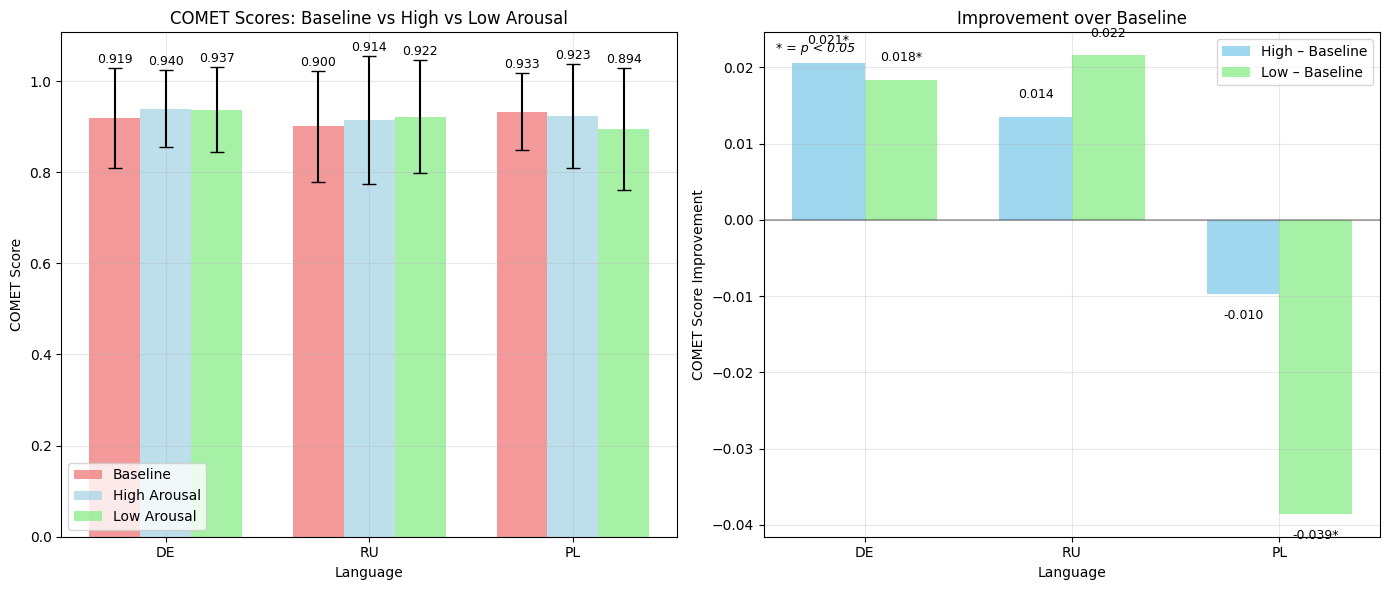

In [ ]:
# Visualization
import numpy as np
import matplotlib.pyplot as plt

if len(sem_results) > 0:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    languages_list = [r['language'].upper() for r in sem_results]
    baseline_means    = [r['baseline_mean'] for r in sem_results]
    high_means        = [r['high_mean'] for r in sem_results]
    low_means         = [r['low_mean'] for r in sem_results]
    baseline_stds     = [r['baseline_std'] for r in sem_results]
    high_stds         = [r['high_std'] for r in sem_results]
    low_stds          = [r['low_std'] for r in sem_results]

    x = np.arange(len(languages_list))
    width = 0.25

    bars_base = ax1.bar(
        x - width,
        baseline_means,
        width,
        yerr=baseline_stds,
        label='Baseline',
        alpha=0.8,
        capsize=5,
        color='lightcoral'
    )
    bars_high = ax1.bar(
        x,
        high_means,
        width,
        yerr=high_stds,
        label='High Arousal',
        alpha=0.8,
        capsize=5,
        color='lightblue'
    )
    bars_low = ax1.bar(
        x + width,
        low_means,
        width,
        yerr=low_stds,
        label='Low Arousal',
        alpha=0.8,
        capsize=5,
        color='lightgreen'
    )

    ax1.set_xlabel('Language')
    ax1.set_ylabel('COMET Score')
    ax1.set_title('COMET Scores: Baseline vs High vs Low Arousal')
    ax1.set_xticks(x)
    ax1.set_xticklabels(languages_list)
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    for i, (b_base, b_high, b_low) in enumerate(zip(bars_base, bars_high, bars_low)):
        ax1.text(
            b_base.get_x() + b_base.get_width() / 2,
            b_base.get_height() + baseline_stds[i] + 0.005,
            f'{baseline_means[i]:.3f}',
            ha='center',
            va='bottom',
            fontsize=9
        )
        ax1.text(
            b_high.get_x() + b_high.get_width() / 2,
            b_high.get_height() + high_stds[i] + 0.005,
            f'{high_means[i]:.3f}',
            ha='center',
            va='bottom',
            fontsize=9
        )
        ax1.text(
            b_low.get_x() + b_low.get_width() / 2,
            b_low.get_height() + low_stds[i] + 0.005,
            f'{low_means[i]:.3f}',
            ha='center',
            va='bottom',
            fontsize=9
        )
    improvements_high = [high_means[i] - baseline_means[i] for i in range(len(sem_results))]
    improvements_low  = [low_means[i] - baseline_means[i]  for i in range(len(sem_results))]
    p_high   = [r['p_base_high'] for r in sem_results]
    p_low    = [r['p_base_low']  for r in sem_results]

    width2 = 0.35
    bars_imp_high = ax2.bar(
        x - width2/2,
        improvements_high,
        width2,
        label='High – Baseline',
        alpha=0.8,
        color='skyblue'
    )
    bars_imp_low = ax2.bar(
        x + width2/2,
        improvements_low,
        width2,
        label='Low – Baseline',
        alpha=0.8,
        color='lightgreen'
    )

    ax2.set_xlabel('Language')
    ax2.set_ylabel('COMET Score Improvement')
    ax2.set_title('Improvement over Baseline')
    ax2.set_xticks(x)
    ax2.set_xticklabels(languages_list)
    ax2.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    for i, (imp_h, p_h, imp_l, p_l) in enumerate(zip(improvements_high, p_high, improvements_low, p_low)):
        sig_h = "*" if p_h < 0.05 else ""
        sig_l = "*" if p_l < 0.05 else ""
        offset_h = 0.002 if imp_h >= 0 else -0.002
        offset_l = 0.002 if imp_l >= 0 else -0.002
        va_h = 'bottom' if imp_h >= 0 else 'top'
        va_l = 'bottom' if imp_l >= 0 else 'top'

        ax2.text(
            i - width2/2,
            imp_h + offset_h,
            f'{imp_h:.3f}{sig_h}',
            ha='center',
            va=va_h,
            fontsize=9
        )
        ax2.text(
            i + width2/2,
            imp_l + offset_l,
            f'{imp_l:.3f}{sig_l}',
            ha='center',
            va=va_l,
            fontsize=9
        )

    ax2.text(
        0.02,
        0.98,
        "* = p < 0.05",
        transform=ax2.transAxes,
        va='top',
        ha='left',
        fontsize=9,
        style='italic'
    )

    plt.tight_layout()
    plt.show()


**Emotional fidelity**

After mapping fine-grained → 6 categories:
        Emotion emotion_standard
0     amusement              joy
1         anger            anger
2       anxiety             fear
3    compassion          neutral
4   contentment              joy
5       disgust          disgust
6          fear             fear
7     happiness              joy
8      interest          neutral
9    irritation            anger
10        pride              joy
11       relief              joy
12     surprise         surprise 

Loading multilingual emotion classifier (MilaNLProc/xlm-emo-t)...


Device set to use cuda:0


✓ Model loaded: MilaNLProc/xlm-emo-t

Raw labels (id2label) supported by the model:
  0: anger
  1: fear
  2: joy
  3: sadness

Processing language: DE
  → Found 95 valid examples for DE

  Classifying Baseline texts...
  Classifying High-Arousal texts...
  Classifying Low-Arousal texts...

--- Results for DE ---
Baseline     → Acc: 0.453, F1: 0.283
High-Arousal → Acc: 0.432, F1: 0.269  (Δ: -0.021)
Low-Arousal  → Acc: 0.421, F1: 0.257  (Δ: -0.032)
Combined EF  → Acc: 0.432  (Δ: -0.021)

Accuracy by standardized emotion category:
  anger    → Base=0.47, High=0.53, Low=0.53
  disgust  → Base=0.00, High=0.00, Low=0.00
  fear     → Base=0.44, High=0.33, Low=0.22
  joy      → Base=0.85, High=0.79, Low=0.79
  neutral  → Base=0.22, High=0.22, Low=0.22
  surprise → Base=0.00, High=0.00, Low=0.00

Processing language: RU
  → Found 95 valid examples for RU

  Classifying Baseline texts...
  Classifying High-Arousal texts...
  Classifying Low-Arousal texts...

--- Results for RU ---
Baseline     

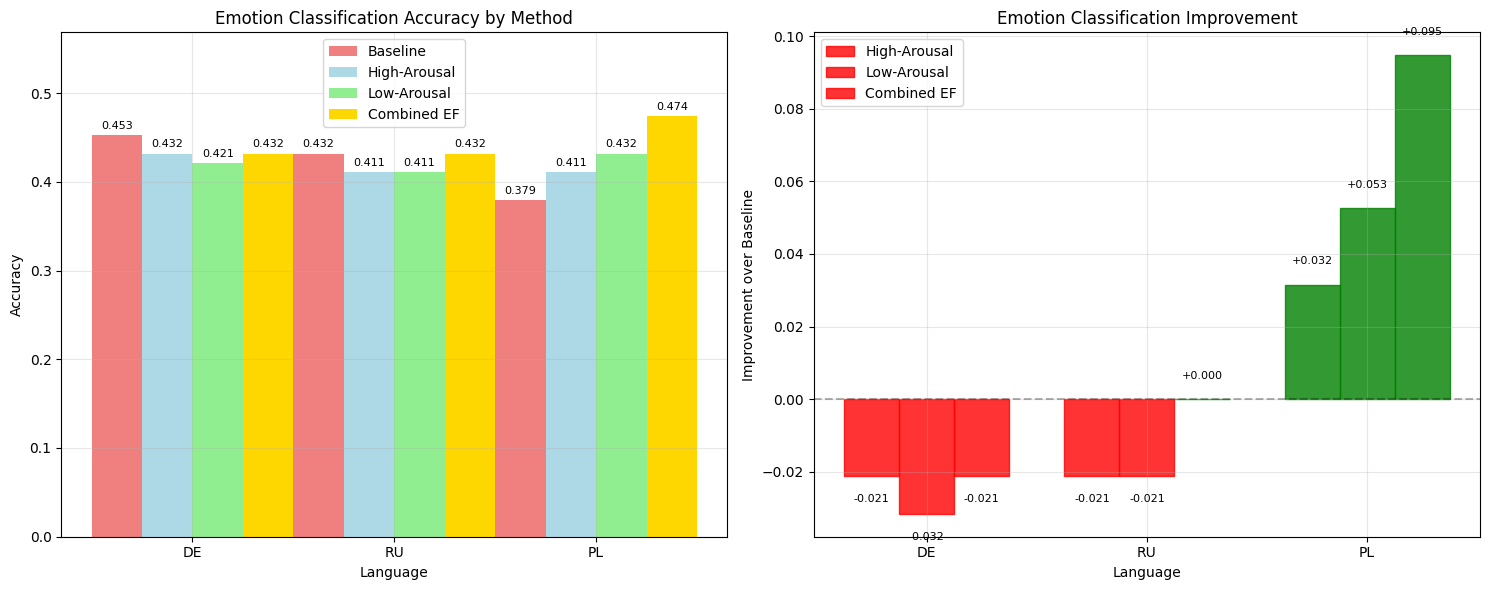

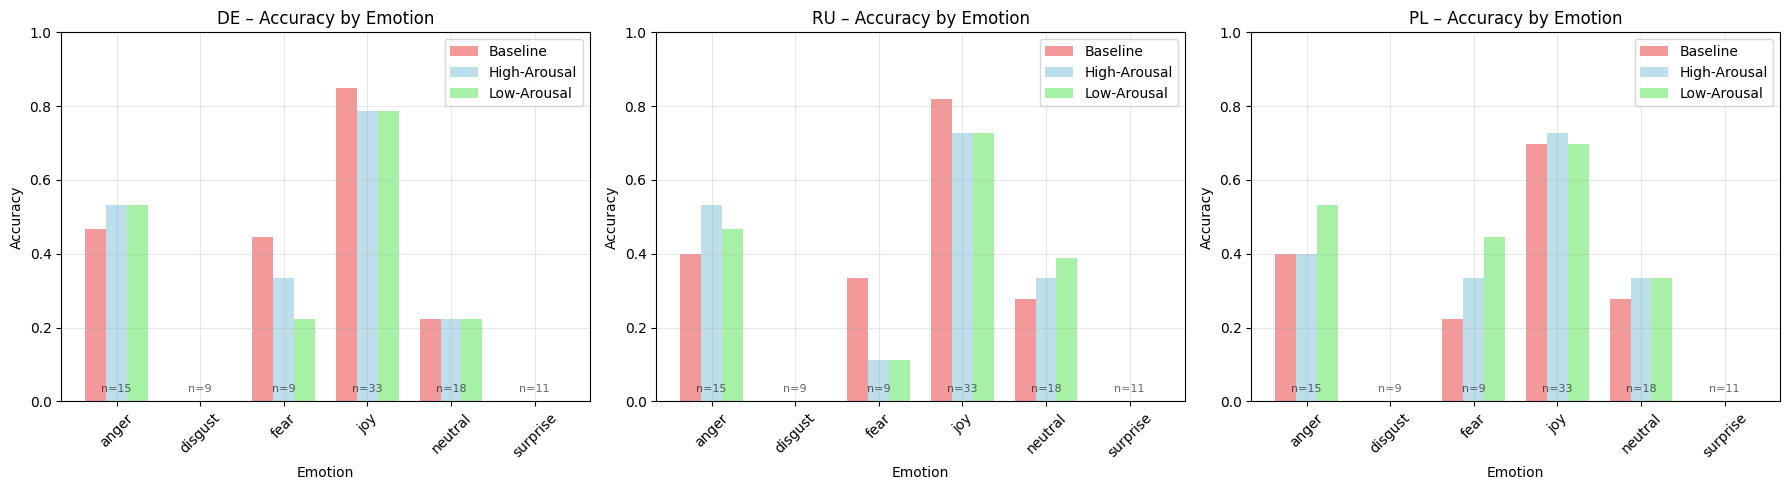


EMOTIONAL FIDELITY SUMMARY (DIRECT XLM-EMO-T + MAPPING)
  language  n_samples  baseline_acc  higharo_acc  lowaro_acc  combined_acc  \
0       de         95         0.453        0.432       0.421         0.432   
1       ru         95         0.432        0.411       0.411         0.432   
2       pl         95         0.379        0.411       0.432         0.474   

   improvement_high  improvement_low  improvement_combined  
0            -0.021           -0.032                -0.021  
1            -0.021           -0.021                 0.000  
2             0.032            0.053                 0.095  


In [ ]:
# ==============================================
# EMOTIONAL FIDELITY EVALUATION SCRIPT (DIRECT XLM-EMO-T + MAPPING)
# ==============================================

# Normalized fine-grained Emotion → 6 MELD categories

df['Emotion'] = df['Emotion'].astype(str).str.lower().str.strip()

emotion_mapping = {
    'amusement':   'joy',
    'happiness':   'joy',
    'contentment': 'joy',
    'pride':       'joy',
    'relief':      'joy',
    'anger':       'anger',
    'irritation':  'anger',
    'disgust':     'disgust',
    'anxiety':     'fear',
    'fear':        'fear',
    'surprise':    'surprise',
    'sadness':     'neutral',
    'compassion':  'neutral',
    'interest':    'neutral'
}
df['emotion_standard'] = df['Emotion'].map(emotion_mapping).fillna('neutral')

print("After mapping fine-grained → 6 categories:")
print(df[['Emotion','emotion_standard']].drop_duplicates().reset_index(drop=True), "\n")


# Load multilingual emotion classifier XLM-EMO-T
print("Loading multilingual emotion classifier (MilaNLProc/xlm-emo-t)...")
device = 0 if torch.cuda.is_available() else -1
emotion_classifier = pipeline(
    "text-classification",
    model="MilaNLProc/xlm-emo-t",
    tokenizer="MilaNLProc/xlm-emo-t",
    device=device,
    return_all_scores=True
)
print("✓ Model loaded: MilaNLProc/xlm-emo-t\n")

# Check raw labels supported by the model
print("Raw labels (id2label) supported by the model:")
id2label = emotion_classifier.model.config.id2label
for idx, lbl in id2label.items():
    print(f"  {idx}: {lbl}")
print()


# Define mapping from XLM-EMO-T raw_label → 6 MELD categories
# XLM-EMO-T returns labels among ['joy','anger','fear','sadness'].
# We funnel 'sadness' into 'neutral'. Any other unexpected label → 'neutral'.
raw_to_meld = {
    "joy":     "joy",
    "anger":   "anger",
    "fear":    "fear",
    "sadness": "neutral"
}

def map_xlm_emo_to_meld(raw_label: str) -> str:
    """
    Convert raw_label (e.g. 'joy','anger','fear','sadness')
    into one of six MELD categories: ['joy','anger','disgust','fear','surprise','neutral'].
    Since XLM-EMO-T does not produce 'disgust' or 'surprise', they default to 'neutral' here.
    """
    rl = raw_label.lower().strip()
    return raw_to_meld.get(rl, "neutral")

def select_best_label(raw_scores: list) -> str:
    """
    raw_scores is a list of dicts like [{'label': 'joy','score':0.65}, …].
    Return the label (lowercased) with the highest score.
    """
    best = max(raw_scores, key=lambda x: x['score'])
    return best['label'].lower()


# Main evaluation loop over each language

languages = ['de','ru','pl']
all_results = []
detailed_preds = []

for lang in languages:
    print("="*60)
    print(f"Processing language: {lang.upper()}")
    print("="*60)

    valid = []
    for idx, row in df.iterrows():
        true_emo = row['emotion_standard']
        if pd.isna(true_emo):
            continue

        baseline = row.get(f"{lang}_baseline", "").strip()
        higharo  = row.get(f"higharo_{lang}", "").strip()
        lowaro   = row.get(f"lowaro_{lang}", "").strip()

        if not (baseline and higharo and lowaro):
            continue

        valid.append({
            'idx': idx,
            'true_emotion': true_emo,
            'baseline':    baseline,
            'higharo':     higharo,
            'lowaro':      lowaro
        })

    n = len(valid)
    print(f"  → Found {n} valid examples for {lang.upper()}\n")
    if n == 0:
        print(f"No valid examples for {lang.upper()}, skipping.\n")
        continue

    baseline_texts = [v['baseline'] for v in valid]
    higharo_texts  = [v['higharo']  for v in valid]
    lowaro_texts   = [v['lowaro']   for v in valid]
    true_emotions  = [v['true_emotion'] for v in valid]

    print("  Classifying Baseline texts...")
    raw_preds_baseline = emotion_classifier(baseline_texts, batch_size=16)
    preds_baseline = [
        map_xlm_emo_to_meld(select_best_label(scores))
        for scores in raw_preds_baseline
    ]

    print("  Classifying High-Arousal texts...")
    raw_preds_high = emotion_classifier(higharo_texts, batch_size=16)
    preds_high = [
        map_xlm_emo_to_meld(select_best_label(scores))
        for scores in raw_preds_high
    ]

    print("  Classifying Low-Arousal texts...")
    raw_preds_low = emotion_classifier(lowaro_texts, batch_size=16)
    preds_low = [
        map_xlm_emo_to_meld(select_best_label(scores))
        for scores in raw_preds_low
    ]

    baseline_acc = accuracy_score(true_emotions, preds_baseline)
    baseline_f1  = f1_score(true_emotions, preds_baseline, average='macro', zero_division=0)

    higharo_acc = accuracy_score(true_emotions, preds_high)
    higharo_f1  = f1_score(true_emotions, preds_high, average='macro', zero_division=0)

    lowaro_acc = accuracy_score(true_emotions, preds_low)
    lowaro_f1  = f1_score(true_emotions, preds_low, average='macro', zero_division=0)

    combined_correct = [
        (preds_high[i] == true_emotions[i]) or (preds_low[i] == true_emotions[i])
        for i in range(n)
    ]
    combined_acc = np.mean(combined_correct)

    results = {
        'language':             lang,
        'n_samples':            n,
        'baseline_acc':         baseline_acc,
        'baseline_f1':          baseline_f1,
        'higharo_acc':          higharo_acc,
        'higharo_f1':           higharo_f1,
        'lowaro_acc':           lowaro_acc,
        'lowaro_f1':            lowaro_f1,
        'combined_acc':         combined_acc,
        'improvement_high':     higharo_acc - baseline_acc,
        'improvement_low':      lowaro_acc - baseline_acc,
        'improvement_combined': combined_acc - baseline_acc
    }
    all_results.append(results)

    for i, v in enumerate(valid):
        detailed_preds.append({
            'language':         lang,
            'idx':              v['idx'],
            'true_emotion':     v['true_emotion'],
            'baseline_text':    v['baseline'],
            'baseline_pred':    preds_baseline[i],
            'baseline_correct': (preds_baseline[i] == v['true_emotion']),
            'higharo_text':     v['higharo'],
            'higharo_pred':     preds_high[i],
            'higharo_correct':  (preds_high[i] == v['true_emotion']),
            'lowaro_text':      v['lowaro'],
            'lowaro_pred':      preds_low[i],
            'lowaro_correct':   (preds_low[i] == v['true_emotion'])
        })

    print(f"\n--- Results for {lang.upper()} ---")
    print(f"Baseline     → Acc: {baseline_acc:.3f}, F1: {baseline_f1:.3f}")
    print(f"High-Arousal → Acc: {higharo_acc:.3f}, F1: {higharo_f1:.3f}  (Δ: {results['improvement_high']:+.3f})")
    print(f"Low-Arousal  → Acc: {lowaro_acc:.3f}, F1: {lowaro_f1:.3f}  (Δ: {results['improvement_low']:+.3f})")
    print(f"Combined EF  → Acc: {combined_acc:.3f}  (Δ: {results['improvement_combined']:+.3f})\n")

    slice_df = pd.DataFrame(detailed_preds[-n:])
    print("Accuracy by standardized emotion category:")
    for emo_cat in sorted(slice_df['true_emotion'].unique()):
        subset = slice_df[slice_df['true_emotion'] == emo_cat]
        ba = subset['baseline_correct'].mean()
        ha = subset['higharo_correct'].mean()
        la = subset['lowaro_correct'].mean()
        print(f"  {emo_cat:<8} → Base={ba:.2f}, High={ha:.2f}, Low={la:.2f}")
    print()


pred_df = pd.DataFrame(detailed_preds)
pred_df.to_csv("emotional_predictions_direct.csv", index=False)
print("✓ Detailed predictions saved to <emotional_predictions_direct.csv>\n")


# McNemar’s tests
print("="*60)
print("STATISTICAL SIGNIFICANCE TESTING (McNemar’s)")
print("="*60)

for lang in ['de','ru','pl']:
    df_lang = pred_df[pred_df['language'] == lang]
    base_corr = df_lang['baseline_correct'].values
    high_corr = df_lang['higharo_correct'].values
    low_corr  = df_lang['lowaro_correct'].values

    print(f"\n--- {lang.upper()} ---")

    # Baseline vs High-Arousal
    b = int(np.sum(base_corr & ~high_corr))
    c = int(np.sum(~base_corr & high_corr))
    print(f"Baseline vs High-Arousal: b={b}, c={c}", end="")
    if (b + c) > 0:
        chi2 = (abs(b - c) - 1)**2 / (b + c)
        pval = 1 - chi2_dist.cdf(chi2, df=1)
        print(f", χ²={chi2:.3f}, p={pval:.3f}", end="")
        if pval < 0.05:
            print("  → Significant")
        else:
            print()
    else:
        print("  → No discordant pairs (skipped)")

    # Baseline vs Low-Arousal
    b = int(np.sum(base_corr & ~low_corr))
    c = int(np.sum(~base_corr & low_corr))
    print(f"Baseline vs Low-Arousal:  b={b}, c={c}", end="")
    if (b + c) > 0:
        chi2 = (abs(b - c) - 1)**2 / (b + c)
        pval = 1 - chi2_dist.cdf(chi2, df=1)
        print(f", χ²={chi2:.3f}, p={pval:.3f}", end="")
        if pval < 0.05:
            print("  → Significant")
        else:
            print()
    else:
        print("  → No discordant pairs (skipped)")

    # High-Arousal vs Low-Arousal
    b = int(np.sum(high_corr & ~low_corr))
    c = int(np.sum(~high_corr & low_corr))
    print(f"High-Arousal vs Low-Arousal: b={b}, c={c}", end="")
    if (b + c) > 0:
        chi2 = (abs(b - c) - 1)**2 / (b + c)
        pval = 1 - chi2_dist.cdf(chi2, df=1)
        print(f", χ²={chi2:.3f}, p={pval:.3f}", end="")
        if pval < 0.05:
            print("  → Significant")
        else:
            print()
    else:
        print("  → No discordant pairs (skipped)")

# Combined vs Baseline
print("\n" + "="*60)
print("STATISTICAL SIGNIFICANCE TESTING (Baseline vs Combined)")
print("="*60)

for lang in ['de','ru','pl']:
    df_lang = pred_df[pred_df['language'] == lang]
    base_corr = df_lang['baseline_correct'].values
    high_corr = df_lang['higharo_correct'].values
    low_corr  = df_lang['lowaro_correct'].values

    combined_corr = (high_corr | low_corr)
    b = int(np.sum(base_corr & ~combined_corr))
    c = int(np.sum(~base_corr & combined_corr))

    print(f"\n--- {lang.upper()} ---")
    print(f"Baseline vs Combined: b={b}, c={c}", end="")
    if (b + c) > 0:
        chi2 = (abs(b - c) - 1)**2 / (b + c)
        pval = 1 - chi2_dist.cdf(chi2, df=1)
        print(f", χ²={chi2:.3f}, p={pval:.3f}", end="")
        if pval < 0.05:
            print("  → Significant")
        else:
            print()
    else:
        print("  → No discordant pairs (skipped)")

# Visualizations
print("\n" + "="*60)
print("GENERATING VISUALIZATIONS")
print("="*60)

summary_df = pd.DataFrame(all_results)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
langs_list = [r['language'].upper() for r in all_results]
x = np.arange(len(langs_list))
w = 0.25

base_accs     = [r['baseline_acc']    for r in all_results]
high_accs     = [r['higharo_acc']      for r in all_results]
low_accs      = [r['lowaro_acc']       for r in all_results]
combined_accs = [r['combined_acc']     for r in all_results]

bars1 = ax1.bar(x - 1.5*w, base_accs,     w, label="Baseline",    color="lightcoral")
bars2 = ax1.bar(x - 0.5*w, high_accs,     w, label="High-Arousal", color="lightblue")
bars3 = ax1.bar(x + 0.5*w, low_accs,      w, label="Low-Arousal",  color="lightgreen")
bars4 = ax1.bar(x + 1.5*w, combined_accs, w, label="Combined EF", color="gold")

ax1.set_xlabel("Language")
ax1.set_ylabel("Accuracy")
ax1.set_title("Emotion Classification Accuracy by Method")
ax1.set_xticks(x)
ax1.set_xticklabels(langs_list)
ax1.legend()
ax1.grid(alpha=0.3)
ax1.set_ylim(0, max(base_accs + high_accs + low_accs + combined_accs) * 1.2)

for bars in (bars1, bars2, bars3, bars4):
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2, height + 0.005,
                 f"{height:.3f}", ha="center", va="bottom", fontsize=8)

impr_high = [r['improvement_high']    for r in all_results]
impr_low  = [r['improvement_low']     for r in all_results]
impr_comb = [r['improvement_combined'] for r in all_results]

bars5 = ax2.bar(x - w, impr_high, w, label="High-Arousal", alpha=0.8)
bars6 = ax2.bar(x,     impr_low,  w, label="Low-Arousal",  alpha=0.8)
bars7 = ax2.bar(x + w, impr_comb, w, label="Combined EF", alpha=0.8)

for bars in (bars5, bars6, bars7):
    for bar in bars:
        h = bar.get_height()
        bar.set_color("green" if h >= 0 else "red")

ax2.set_xlabel("Language")
ax2.set_ylabel("Improvement over Baseline")
ax2.set_title("Emotion Classification Improvement")
ax2.set_xticks(x)
ax2.set_xticklabels(langs_list)
ax2.axhline(y=0, color="black", linestyle="--", alpha=0.3)
ax2.legend()
ax2.grid(alpha=0.3)

for bars in (bars5, bars6, bars7):
    for bar in bars:
        h = bar.get_height()
        va = "bottom" if h >= 0 else "top"
        offset = 0.005 if h >= 0 else -0.005
        ax2.text(bar.get_x() + bar.get_width()/2, h + offset,
                 f"{h:+.3f}", ha="center", va=va, fontsize=8)

plt.tight_layout()
plt.savefig("emotional_fidelity_direct.png", dpi=300, bbox_inches="tight")
plt.show()

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for i, lang in enumerate(languages):
    ax = axes[i]
    df_lang = pred_df[pred_df["language"] == lang]
    stats = []
    for emo_cat in sorted(df_lang["true_emotion"].unique()):
        sub = df_lang[df_lang["true_emotion"] == emo_cat]
        stats.append({
            "emotion":   emo_cat,
            "baseline":  sub["baseline_correct"].mean(),
            "higharo":   sub["higharo_correct"].mean(),
            "lowaro":    sub["lowaro_correct"].mean(),
            "n_samples": len(sub)
        })
    stats_df = pd.DataFrame(stats)
    x_e = np.arange(len(stats_df))
    w_e = 0.25

    ax.bar(x_e - w_e, stats_df["baseline"], w_e, label="Baseline",    color="lightcoral", alpha=0.8)
    ax.bar(x_e,       stats_df["higharo"],  w_e, label="High-Arousal", color="lightblue", alpha=0.8)
    ax.bar(x_e + w_e, stats_df["lowaro"],   w_e, label="Low-Arousal",  color="lightgreen", alpha=0.8)

    ax.set_xlabel("Emotion")
    ax.set_ylabel("Accuracy")
    ax.set_title(f"{lang.upper()} – Accuracy by Emotion")
    ax.set_xticks(x_e)
    ax.set_xticklabels(stats_df["emotion"], rotation=45)
    ax.legend()
    ax.grid(alpha=0.3)
    ax.set_ylim(0, 1)

    for j, nval in enumerate(stats_df["n_samples"]):
        ax.text(j, 0.02, f"n={nval}", ha="center", va="bottom", fontsize=8, alpha=0.6)

plt.tight_layout()
plt.savefig("emotional_accuracy_by_emotion_direct.png", dpi=300, bbox_inches="tight")
plt.show()

# Final summary table
print("\n" + "="*60)
print("EMOTIONAL FIDELITY SUMMARY (DIRECT XLM-EMO-T + MAPPING)")
print("="*60)
summary_df = pd.DataFrame(all_results)
print(summary_df[[
    "language","n_samples",
    "baseline_acc","higharo_acc","lowaro_acc","combined_acc",
    "improvement_high","improvement_low","improvement_combined"
]].round(3))
